# git2net analysis for the networkx repository

First we import the required packages

In [18]:
import pygit2 as git2
import os
import shutil
import git2net
import pathpy as pp
import sqlite3
import pandas as pd
from datetime import date, datetime, timedelta
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import json 
import math
import copy
import networkx

import gambit

git_repo_url = 'https://github.com/servo/servo'
#git_repo_url = 'https://github.com/bytecodealliance/wasmtime'
#git_repo_url = 'https://github.com/pandas-dev/pandas.git'
#git_repo_url = 'https://github.com/networkx/networkx.git'
#git_repo_url = 'https://github.com/numpy/numpy.git'
#git_repo_url = 'https://github.com/deepcharles/ruptures.git'
#git_repo_url = 'https://github.com/mwaskom/seaborn.git'
repo_name = 'servo'
local_directory = '.'
git_repo_dir = 'repos/{r}4analysis'.format(r=repo_name)
sqlite_db_file = 'databases/{r}/{r}_rename.db'.format(r=repo_name)
#sqlite_db_file = 'databases/{r}/{r}.db'.format(r=repo_name)

Clone repo:

In [8]:
if os.path.exists(git_repo_dir):
    shutil.rmtree(git_repo_dir)

repo = git2.clone_repository(git_repo_url, git_repo_dir) # Clones a non-bare repository

Then we create the database for it. We will try with max_modification=100, so that most commits are processed.

Mine repo:

In [6]:
# Remove database if exists
#if os.path.exists(sqlite_db_file):
#    os.remove(sqlite_db_file)

max_modifications = 100
    
git2net.mine_git_repo(git_repo_dir, sqlite_db_file, max_modifications=max_modifications)

Found a matching database on provided path. Skipping 39667 (90.08%) of 44034 commits. 4367 commits remaining.


Parallel (8 processes):   0%|          | 0/4367 [00:00<?, ?it/s]

Commit exceeding max_modifications:  c617e7d288c0361cb1cd337ee8b9f487b2d17b9f


Parallel (8 processes):   0%|          | 1/4367 [00:00<1:03:21,  1.15it/s]

Commit exceeding max_modifications:  d64d987e1da66691ccd0e7e04fd54babc2c5bab4
Commit exceeding max_modifications:  ab988db12dffe46617deb235fc40690e98ebf652


Parallel (8 processes):   0%|          | 3/4367 [00:01<47:00,  1.55it/s]  

Commit exceeding max_modifications:  90b01df4c3767c22f3d625dd8ed20bceef8eef04


Parallel (8 processes):   0%|          | 4/4367 [00:01<38:09,  1.91it/s]

Commit exceeding max_modifications:  c7bce9823660106969e5d2c6b4e4c35f4003d360
Commit exceeding max_modifications: Commit exceeding max_modifications:   bf82bc54f349dd0944c37129af28dec6b43041fe473b0941eca8c6498e5065892de49562dce0b78c



Parallel (8 processes):   0%|          | 6/4367 [00:01<27:52,  2.61it/s]

Commit exceeding max_modifications:  7caa209039b5765138020ba4a34c9575392e49f5


Parallel (8 processes):   0%|          | 8/4367 [00:01<21:10,  3.43it/s]

Commit exceeding max_modifications:  bc520e0143a82c20b01df518e7be486552a40538


Parallel (8 processes):   0%|          | 9/4367 [00:01<18:55,  3.84it/s]

Commit exceeding max_modifications:  56e5ba1b825b77eaf56db7211ba7bf9549421c0b
Commit exceeding max_modifications:  2359587cbbc77a86d92c9628f19bc883818c563f


Parallel (8 processes):   0%|          | 11/4367 [00:01<14:30,  5.00it/s]

Commit exceeding max_modifications:  d0e47f427e190a0a06283ca6a17625c239b2ec91
Commit exceeding max_modifications: Commit exceeding max_modifications:   71ca10a50cdf3de2462cdb2986e4139709d7614b255819bb9abbb851a9f362e5840dcd2fc9bdf595



Parallel (8 processes):   0%|          | 13/4367 [00:02<14:50,  4.89it/s]

Commit exceeding max_modifications:  c2461886059ff6fdd04f5a2d5d1a7913882b87b0


Parallel (8 processes):   0%|          | 15/4367 [00:02<12:24,  5.84it/s]

Commit exceeding max_modifications:  226ccf7e7278b1a0e6cd8e4fdcadf77b94003686
Commit exceeding max_modifications:  f3f6e62f7fda50d77742f9527f8dc7171d7b8624
Commit exceeding max_modifications:  

Parallel (8 processes):   0%|          | 17/4367 [00:02<10:40,  6.79it/s]

797143a1d3e09b4ddd35a1ce5948be424ec3f9ef
Commit exceeding max_modifications:  21270738ae0b49097472aa6f861fac7cf465038e


Parallel (8 processes):   0%|          | 19/4367 [00:02<08:35,  8.44it/s]

Commit exceeding max_modifications:  352acbb8335fcf78f2d62dc781fa9d86b9368f9c
Commit exceeding max_modifications:  ddce8b8fa0b09f1d56ce9684028e23f4974b2e5f


Parallel (8 processes):   0%|          | 21/4367 [00:03<10:05,  7.17it/s]

Commit exceeding max_modifications:  a55cba04c6ff11996dbd7f6e08052ca255f082b4
Commit exceeding max_modifications:  40a7667580a49ddd997664130f5a63f9ce60b745


Parallel (8 processes):   1%|          | 23/4367 [00:03<08:51,  8.18it/s]

Commit exceeding max_modifications:  e98ddef9bbaf41adb15b158b8a0f21ef252a1a79
Commit exceeding max_modifications:  426d18ffb102533d6acf7162f772f58d5cf29b23


Parallel (8 processes):   1%|          | 25/4367 [00:03<08:07,  8.90it/s]

Commit exceeding max_modifications:  01667ef22bddd157be0375df6775d6b1feff7353
Commit exceeding max_modifications:  d2cfb651275a0829cb33ed977fa043d92b61d39a


Parallel (8 processes):   1%|          | 27/4367 [00:03<09:08,  7.91it/s]

Commit exceeding max_modifications:  824c7ac613ebb80bb432ff6425c5e25c642b6afb
Commit exceeding max_modifications:  de36f37ac76125be9b7bff02736d8f5c7b10e995


Parallel (8 processes):   1%|          | 29/4367 [00:04<08:18,  8.71it/s]

Commit exceeding max_modifications:  943ab4a4f0e3074e78d96ad94b7e96a46edacf79
Commit exceeding max_modifications:  048929278ad62af706c72b400f82e707dc6e4806


Parallel (8 processes):   1%|          | 31/4367 [00:04<09:14,  7.82it/s]

Commit exceeding max_modifications:  a71c1125eee678f701311e2751abcc34c1adf6fd
Commit exceeding max_modifications:  733162e217739f5a01d580ff57c5e592a74e000d


Parallel (8 processes):   1%|          | 33/4367 [00:04<09:09,  7.88it/s]

Commit exceeding max_modifications:  a7ef1cd35e9347a285f245041db4eb94047f4ab0
Commit exceeding max_modifications:  4fcb48da642dff3861d3eb432856c066263d4cf8
Commit exceeding max_modifications:  1ee52244860cc27c35dc65cc265f4bc3b9fe2d52


Parallel (8 processes):   1%|          | 36/4367 [00:04<07:17,  9.91it/s]

Commit exceeding max_modifications:  57d91c4b58566d91614228b3cd370012da993907
Commit exceeding max_modifications:  8f63dff8f8ebb2153cebb6fde4cc5e85ed5dd9ea


Parallel (8 processes):   1%|          | 38/4367 [00:05<10:02,  7.19it/s]

Commit exceeding max_modifications:  edd7e32fdbb97c47e7c5dfda292bf3d0be3b9f36
Commit exceeding max_modifications:  20bbf6a8596e53c7a27f2489874b81436afb4e6c


Parallel (8 processes):   1%|          | 40/4367 [00:05<09:24,  7.67it/s]

Commit exceeding max_modifications:  998710d907964da4d39d80075dc45171ce3adabe
Commit exceeding max_modifications:  ffcf3b2905b7f9e886904015b1583e93f78f1199


Parallel (8 processes):   1%|          | 42/4367 [00:05<08:55,  8.08it/s]

Commit exceeding max_modifications:  1e9fec9172364346937f375e315e1ce745662611
Commit exceeding max_modifications:  625325434b5c7dc72e784a592f7e014c16cf1018
Commit exceeding max_modifications:  817c57b5b4bf9ff24ac7464e2dc9b566689714d9


Parallel (8 processes):   1%|          | 45/4367 [00:05<07:22,  9.77it/s]

Commit exceeding max_modifications:  af616dba58cbf589b116b9e3cde4429df43e72cd
Commit exceeding max_modifications: Commit exceeding max_modifications:   f7aa6e3d9b8bfcc0565624f1094241b3b8658bd8
bbac8aa5c3d95e70151b824ca3443f0fb4d9b5a5


Parallel (8 processes):   1%|          | 47/4367 [00:06<10:41,  6.74it/s]

Commit exceeding max_modifications:  cc77b287617e857b45282d0f39bcac6f9cf5bdd1


Parallel (8 processes):   1%|          | 49/4367 [00:06<08:53,  8.09it/s]

Commit exceeding max_modifications:  b345e9458a316096a7877f3d54b25a9d8d155540
Commit exceeding max_modifications:  627017862859756231ce28a521b3128c6528b982


Parallel (8 processes):   1%|          | 51/4367 [00:06<07:29,  9.60it/s]

Commit exceeding max_modifications:  26f9543e60414d5ff3890d36c5370d0804c2cf18
Commit exceeding max_modifications:  7f188500a12373677c7ef9feb999276c30f1068a


Parallel (8 processes):   1%|          | 53/4367 [00:06<08:08,  8.83it/s]

Commit exceeding max_modifications:  371bea7d3b5c200243865153a0dad5acc4ff78ff
Commit exceeding max_modifications:  83aabe327d3b713581a4183b7f23cea0c39a94c9


Parallel (8 processes):   1%|▏         | 55/4367 [00:07<10:45,  6.68it/s]

Commit exceeding max_modifications:  ef5567b585168746152a96994193676f354c3509
Commit exceeding max_modifications:  e3cc46a7825ef60a36a25f2ff2f18c1f02ed8b50


Parallel (8 processes):   1%|▏         | 57/4367 [00:07<09:10,  7.83it/s]

Commit exceeding max_modifications:  0f0b0b33bf7375d834138a3bd3af9ba1921d390d
Commit exceeding max_modifications:  31eee791dd343807b6057c549bc74f41c4bf10a2


Parallel (8 processes):   1%|▏         | 59/4367 [00:07<07:43,  9.29it/s]

Commit exceeding max_modifications:  2a5f82a76453aebe1ce07f0e0c5b78bead93ed0c
Commit exceeding max_modifications:  384183a31f0f5e0fa2fff021185f08f18a0d11c0


Parallel (8 processes):   1%|▏         | 61/4367 [00:07<08:26,  8.50it/s]

Commit exceeding max_modifications:  9edfb439a65382d1f7f5659c40da70260a1cb7bc
Commit exceeding max_modifications: Commit exceeding max_modifications:  79219f2ba910c9bc23ac523ae55d3b64a839002b cd08960b0f6afaa47e1a6a20afc73055dac26aee



Parallel (8 processes):   1%|▏         | 63/4367 [00:08<08:57,  8.01it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 23e325ffb77092b6a108ab40bb2666067e673106 
7d9fa356717839fdf1ab01ccbc83fa71eefaf426


Parallel (8 processes):   1%|▏         | 65/4367 [00:08<08:07,  8.83it/s]

Commit exceeding max_modifications:  4331fad53d6d4a5fa6096c596c7abe8c30f05a8a
Commit exceeding max_modifications:  5c20ed302337de3ca375994bd283615020b3e72d


Parallel (8 processes):   2%|▏         | 68/4367 [00:08<07:08, 10.04it/s]

Commit exceeding max_modifications:  b35d83099949a81fb704a573c73f8fb4c4da45ee
Commit exceeding max_modifications:  493aa2cdf30fb2ff5886c714030a20d714764b67


Parallel (8 processes):   2%|▏         | 70/4367 [00:08<09:52,  7.26it/s]

Commit exceeding max_modifications:  9f742a946226edf6cd93db0c864449471b5b1325
Commit exceeding max_modifications: 

Parallel (8 processes):   2%|▏         | 71/4367 [00:09<10:03,  7.12it/s]

 b6ed24621ebbeb6866f151e778ace8f80e59fac9
Commit exceeding max_modifications:  6e9d8366b36c10216d8d22a90f095531807f83c0


Parallel (8 processes):   2%|▏         | 73/4367 [00:09<09:34,  7.47it/s]

Commit exceeding max_modifications:  32bceb3ae7c1549739f94e3dce60a6de7ce770a9


Parallel (8 processes):   2%|▏         | 74/4367 [00:09<09:13,  7.76it/s]

Commit exceeding max_modifications:  b36b779d24c6f7425f630c18495dae4c6edec137
Commit exceeding max_modifications:  948daf242278b22d7a15c1c594129785d1cff538


Parallel (8 processes):   2%|▏         | 76/4367 [00:09<07:38,  9.35it/s]

Commit exceeding max_modifications:  6f31ac2786e1dc334c7d78a79131fa5579710e9e
Commit exceeding max_modifications:  85393c69311bbe6dbb6f8ea8b28a6f0f6344fbe7


Parallel (8 processes):   2%|▏         | 78/4367 [00:09<08:27,  8.44it/s]

Commit exceeding max_modifications:  ffdc3f5b32a345b88eed774848924e862d47c093
Commit exceeding max_modifications:  d7b96db33ca8f2b8a162df38e0f00e95f5ea6fa1


Parallel (8 processes):   2%|▏         | 80/4367 [00:10<09:11,  7.78it/s]

Commit exceeding max_modifications:  76783b029e5e10da7fd61ab356a8f80a1eaf32e0


Parallel (8 processes):   2%|▏         | 81/4367 [00:10<10:02,  7.11it/s]

Commit exceeding max_modifications:  731e66ff132e41cdc49bc5324c0e15be19c46ec2
Commit exceeding max_modifications:  522d3f167b12fa79401eea5525c7b6133cae0f06
Commit exceeding max_modifications:  bba4bef106eb69ef3d4e03e303faa491f7849ebe


Parallel (8 processes):   2%|▏         | 84/4367 [00:10<08:17,  8.61it/s]

Commit exceeding max_modifications:  325a39b8bad2fb35c2a0d9bcb0da357a79bfb99a
Commit exceeding max_modifications:  22c60609210e625cab4aa5b533e7b32d902df18f


Parallel (8 processes):   2%|▏         | 86/4367 [00:10<07:13,  9.88it/s]

Commit exceeding max_modifications:  9bca8a706e3187c6f7c154c59921f80c18249a52
Commit exceeding max_modifications:  fbcfe78bf675ffb1fdbe549da3b96a0d1a5f0be8


Parallel (8 processes):   2%|▏         | 88/4367 [00:10<08:30,  8.39it/s]

Commit exceeding max_modifications:  c753f3ee05a25b2bb756c3b0c3131eac7ad58f1a
Commit exceeding max_modifications:  614b1f2fe61ee36c8e6f8a1d60dbbe35af68e368


Parallel (8 processes):   2%|▏         | 90/4367 [00:11<10:35,  6.73it/s]

Commit exceeding max_modifications:  de4e36570a29e079546977981b8f85e3afbbf62c
Commit exceeding max_modifications:  50c2af8ef19de31c4b41100f4278c937ced47c64


Parallel (8 processes):   2%|▏         | 92/4367 [00:11<09:19,  7.64it/s]

Commit exceeding max_modifications:  eaedeb07cb0c4fdda37f35057588e4a769fbe758


Parallel (8 processes):   2%|▏         | 93/4367 [00:11<09:21,  7.61it/s]

Commit exceeding max_modifications:  6751990c0d6e55d694ecc83371197536f4c87c47
Commit exceeding max_modifications:  59cef940e899a900b4601dbbc9b4d4bd96a96687


Parallel (8 processes):   2%|▏         | 95/4367 [00:11<07:56,  8.97it/s]

Commit exceeding max_modifications:  a0783aebbf95659ed571dabcbb7df7784828d696
Commit exceeding max_modifications:  5ebe3302470ef0561d2b9fcf7c7b2030b2921c2d


Parallel (8 processes):   2%|▏         | 97/4367 [00:12<09:21,  7.60it/s]

Commit exceeding max_modifications:  1d6a1fc0669e1338103535c9b1bc7c862f3a68fa
Commit exceeding max_modifications:  cd4a70964269f4aae9695241ca0feae1792a463c


Parallel (8 processes):   2%|▏         | 99/4367 [00:12<09:13,  7.71it/s]

Commit exceeding max_modifications:  52a809259af6a07820589c42ea406765c2cfc5ee
Commit exceeding max_modifications:  184d8b5bab2aa999280c6c3b7618428bb22b5205


Parallel (8 processes):   2%|▏         | 101/4367 [00:12<07:50,  9.06it/s]

Commit exceeding max_modifications:  97efd122a3699ece13248bd9c6e579c663e44703
Commit exceeding max_modifications:  246c9759bee9fa54a9167e9b08478446e80cd80f


Parallel (8 processes):   2%|▏         | 103/4367 [00:12<06:53, 10.32it/s]

Commit exceeding max_modifications:  629c4c6afe7cea86c051bb9f52adeac716e2c43f
Commit exceeding max_modifications:  b2e7e67087370e30a310bb3673b074c97c19d548


Parallel (8 processes):   2%|▏         | 105/4367 [00:13<08:23,  8.47it/s]

Commit exceeding max_modifications:  188b2c725d55f79e289a181575ca13c89408b1c7
Commit exceeding max_modifications:  4c0b368c67d005e57bf0a3dcbd7ddb6456eae68a


Parallel (8 processes):   2%|▏         | 107/4367 [00:13<09:02,  7.85it/s]

Commit exceeding max_modifications:  f3b9c11f7a8d3a834bb2547639eb2261210a1695
Commit exceeding max_modifications:  21e4d85511ffb928d0cab00b221413d54864afa5


Parallel (8 processes):   2%|▏         | 109/4367 [00:13<08:14,  8.61it/s]

Commit exceeding max_modifications:  0e394a65d34d779594da2e651f733d7ec74c05ca


Parallel (8 processes):   3%|▎         | 110/4367 [00:13<07:59,  8.87it/s]

Commit exceeding max_modifications:  27ed2ea8cf129e9c6ef1fc1a7bff0f435e2e506b
Commit exceeding max_modifications:  0974d21bcde4c7d2d546e5ba4586a05a137afa5b


Parallel (8 processes):   3%|▎         | 112/4367 [00:13<08:10,  8.67it/s]

Commit exceeding max_modifications:  df4bb6947ee614d9ae4a16615606e161fb025f09
Commit exceeding max_modifications:  2934c5a89d0a5b41936bbf0b9ca3f547ffba70ee


Parallel (8 processes):   3%|▎         | 114/4367 [00:14<07:21,  9.63it/s]

Commit exceeding max_modifications:  63b0e1568f7de58ba21c9891638154bed1848241
Commit exceeding max_modifications:  50a5008b854e4248d54189b70ce1284fc7e54e44


Parallel (8 processes):   3%|▎         | 116/4367 [00:14<09:07,  7.76it/s]

Commit exceeding max_modifications:  31c9df79f524a1d6e657b3ae5b64d1712eb2e811
Commit exceeding max_modifications:  3805bfd24bd768038c5045256f9516866406855c


Parallel (8 processes):   3%|▎         | 118/4367 [00:14<09:28,  7.47it/s]

Commit exceeding max_modifications:  b91e6f30e063cbcea4ffd750da8385ce448de797
Commit exceeding max_modifications:  944d8b00b05c41a272f59eb8d24886ece8bcc95b
Commit exceeding max_modifications:  7e8f33a003292ee242e9cdc1568f403d77d33899


Parallel (8 processes):   3%|▎         | 121/4367 [00:14<07:35,  9.32it/s]

Commit exceeding max_modifications:  57aa3813b90cd964b23c30af3c10b0135562e79c
Commit exceeding max_modifications:  405ee65708ff5312afa3427972d4ade98b63c983


Parallel (8 processes):   3%|▎         | 123/4367 [00:15<07:57,  8.89it/s]

Commit exceeding max_modifications:  541f22ade61a6abe7304e07f99d9ba73e7a609b1
Commit exceeding max_modifications:  49bf3dd47488bdf22fda78fa9f19d980c83003c3


Parallel (8 processes):   3%|▎         | 125/4367 [00:15<08:01,  8.81it/s]

Commit exceeding max_modifications:  582119502e88aba60848b90f6ba5e977e7442d82Commit exceeding max_modifications: 
 47cc25a47a95196bdc489369cd291804aeb22ad6


Parallel (8 processes):   3%|▎         | 127/4367 [00:15<08:29,  8.32it/s]

Commit exceeding max_modifications:  e8d89ca4641b8b954ba4d42d2d2ea6761dc5d0b2


Parallel (8 processes):   3%|▎         | 128/4367 [00:15<08:46,  8.05it/s]

Commit exceeding max_modifications:  251d818de29b97d8cf4a2398661a71c60cd89da8
Commit exceeding max_modifications:  f300e146b0ccd6207705826dbefb1bdc6e1e0987


Parallel (8 processes):   3%|▎         | 130/4367 [00:15<08:04,  8.74it/s]

Commit exceeding max_modifications:  3f17a495640cb7f859401ea20267d52122f3f519


Parallel (8 processes):   3%|▎         | 131/4367 [00:15<07:51,  8.99it/s]

Commit exceeding max_modifications:  80c001b2f00fa5982ec896d4a19fd6311a3ece97
Commit exceeding max_modifications: 

Parallel (8 processes):   3%|▎         | 132/4367 [00:16<09:06,  7.74it/s]

 dab0374d3e91adaca5f4acf3818ecfc3786901b3
Commit exceeding max_modifications:  a081b9a56f8654d4a9796c0ea6b119bf700debeb


Parallel (8 processes):   3%|▎         | 134/4367 [00:16<09:33,  7.39it/s]

Commit exceeding max_modifications:  76ddacd6a5be4bd62457fc6b75cdd47bffa90e1e


Parallel (8 processes):   3%|▎         | 135/4367 [00:16<10:14,  6.88it/s]

Commit exceeding max_modifications:  e37023730ff4241c8b8763ca70b5f0f60fa5360a
Commit exceeding max_modifications:  b491f56e591ed8f90fa1bda1331cbb3b0507a71b
Commit exceeding max_modifications:  aa52b0a0cd4b03b2fa9b7892c92385b210af6b2a


Parallel (8 processes):   3%|▎         | 138/4367 [00:16<08:34,  8.21it/s]

Commit exceeding max_modifications:  1cea7223ec8c661c4737aedfbbe22f9a2bb8c811
Commit exceeding max_modifications:  370192451f46ab81dd07dae754280c88fc617c97


Parallel (8 processes):   3%|▎         | 140/4367 [00:16<07:38,  9.21it/s]

Commit exceeding max_modifications:  7f8e8372e3b42d3a3ad7b7400d287b1760d32612
Commit exceeding max_modifications:  e7faa147a50807815e66b51386f1f83dd42cdf57


Parallel (8 processes):   3%|▎         | 142/4367 [00:17<08:43,  8.07it/s]

Commit exceeding max_modifications:  ad6d22b2bfecff5316dc7d22a1b174da373be7ea


Parallel (8 processes):   3%|▎         | 143/4367 [00:17<10:34,  6.66it/s]

Commit exceeding max_modifications:  11ba79894a13ddaee4bfcdd64d23fd4b54a041f3Commit exceeding max_modifications:  61642d64b5c06f30fd68961e5ffd21a35dacbc4c



Parallel (8 processes):   3%|▎         | 144/4367 [00:17<13:14,  5.31it/s]

Commit exceeding max_modifications:  b1305bb7d051f83850c51bb0da0ccc86a5e07922
Commit exceeding max_modifications:  75caade8287bbe9ee25a71bea01e3da6a1d3c1b5


Parallel (8 processes):   3%|▎         | 147/4367 [00:17<10:26,  6.73it/s]

Commit exceeding max_modifications:  340ebdfd85f9f9bb3caa352f5c679b4f3b3b9f97
Commit exceeding max_modifications:  e9ad87e27eb30cfacd66b575e104ee2784f95591


Parallel (8 processes):   3%|▎         | 149/4367 [00:18<11:00,  6.39it/s]

Commit exceeding max_modifications:  4fa872511117eafd934cad70c7d3b8c583fb960e
Commit exceeding max_modifications:  ccda8f204acb014387e92f1ecd47355e9e45ed89


Parallel (8 processes):   3%|▎         | 151/4367 [00:18<10:27,  6.72it/s]

Commit exceeding max_modifications:  c51b8a07acbbfa8539b9234c7717a9af53a9e2b8


Parallel (8 processes):   3%|▎         | 152/4367 [00:18<10:11,  6.89it/s]

Commit exceeding max_modifications:  045328c8e94f5bdfcd67105c5dfa9209f4cd501c
Commit exceeding max_modifications:  c228b81ca8e851b3fd4e161ea83fc1d0913d516d


Parallel (8 processes):   4%|▎         | 154/4367 [00:18<08:56,  7.85it/s]

Commit exceeding max_modifications:  95a4731c0eec0cfb2fb70af534757bc7ca63e407
Commit exceeding max_modifications: 

Parallel (8 processes):   4%|▎         | 155/4367 [00:19<10:48,  6.49it/s]

 cc44a3b0641d94908b2b2e01bec440f64f89f8be
Commit exceeding max_modifications:  177127e5974e30b35632b206f995659e8b663803


Parallel (8 processes):   4%|▎         | 157/4367 [00:19<09:35,  7.31it/s]

Commit exceeding max_modifications:  71a05a9c397a012a959718a7b00e4cd0ce58b359


Parallel (8 processes):   4%|▎         | 158/4367 [00:19<11:33,  6.07it/s]

Commit exceeding max_modifications:  39b6bd9b9586d101943055202a7e06eb8d349dd8
Commit exceeding max_modifications:  86eec63a02161de84f2404ff2292d3a8d1273784
Commit exceeding max_modifications:  a35212410ae78a19db99d284d63a00d1a72dbd79


Parallel (8 processes):   4%|▎         | 161/4367 [00:19<08:53,  7.89it/s]

Commit exceeding max_modifications:  94b7c486b12a50298f0706fce42b70a6ca90cdcb
Commit exceeding max_modifications:  Commit exceeding max_modifications: c6ab60dbfc6da7b4f800c9e40893c8b58413960c
 33e2a7b3625c82e83c7767e81266c2a23f509bed

Parallel (8 processes):   4%|▎         | 163/4367 [00:20<10:46,  6.51it/s]


Commit exceeding max_modifications:  6fb8eb32f2fb071c1e656542960d9dda7d86f69d
Commit exceeding max_modifications:  c10948736f1f7a8e6d6dcb1987a92818fb1f4003


Parallel (8 processes):   4%|▍         | 166/4367 [00:20<09:07,  7.67it/s]

Commit exceeding max_modifications:  e70dcc3ae55c743bab2aa4b35cbfd8dcf11f799a
Commit exceeding max_modifications:  a127fcd854ae0e31d05f34232f595833ccc2ba9e


Parallel (8 processes):   4%|▍         | 168/4367 [00:20<08:37,  8.12it/s]

Commit exceeding max_modifications:  eff0de0ce12b20ffc4806d14c95777004003f2ae
Commit exceeding max_modifications:  c87f34f877ab4acfb19c48f924068ab1964d397c


Parallel (8 processes):   4%|▍         | 170/4367 [00:20<08:38,  8.09it/s]

Commit exceeding max_modifications:  0ded2bb1ecb7da791c1296c2a2415f49705f8334


Parallel (8 processes):   4%|▍         | 171/4367 [00:20<09:41,  7.22it/s]

Commit exceeding max_modifications:  f350879574194bb612eac88e21d0920e9827afa7
Commit exceeding max_modifications:  5351c8572f564314f760037b9bcd355b43afa3aa


Parallel (8 processes):   4%|▍         | 173/4367 [00:21<08:11,  8.54it/s]

Commit exceeding max_modifications:  834df4e211e7dcac4369da4f5b8113f295869aa1
Commit exceeding max_modifications:  48ce107d7275c08273cea6dca3523d0eee23eea7


Parallel (8 processes):   4%|▍         | 175/4367 [00:21<08:20,  8.38it/s]

Commit exceeding max_modifications:  96fae78f9483da498345b67c44f97f649d084cd5
Commit exceeding max_modifications:  c9ce56a85d6c0591f71e28c9596c19fef13b91c0


Parallel (8 processes):   4%|▍         | 177/4367 [00:21<07:17,  9.58it/s]

Commit exceeding max_modifications:  f94228d9f95327aac987103806b6ed452c96f16a
Commit exceeding max_modifications:  9af090006017747809f5f72a8870bd516b20f483


Parallel (8 processes):   4%|▍         | 179/4367 [00:21<09:03,  7.70it/s]

Commit exceeding max_modifications:  3f2cbb275be8675a3f3a8504de1761d0e444f256
Commit exceeding max_modifications:  1de2fb3721b8a189156f4a860009cca01d8b2fd9


Parallel (8 processes):   4%|▍         | 181/4367 [00:21<07:44,  9.01it/s]

Commit exceeding max_modifications:  83196ddb26b5611bccfa2d709396daeff259bcd1
Commit exceeding max_modifications:  7cc8ff93ecb094735e97c3fab25c555dfa6d7737


Parallel (8 processes):   4%|▍         | 183/4367 [00:22<06:34, 10.61it/s]

Commit exceeding max_modifications:  983d180a43b23fdc125b4417afb215b342967f24
Commit exceeding max_modifications:  156ca98236a57ee52ff5b68741bc7783ba073612


Parallel (8 processes):   4%|▍         | 185/4367 [00:22<06:16, 11.11it/s]

Commit exceeding max_modifications:  018146b1a8d1e0a2cc5c2692665f3db12cbef84a
Commit exceeding max_modifications:  4795e9cf0ba8a9712e81c281e31ffd4cf34240f0


Parallel (8 processes):   4%|▍         | 187/4367 [00:22<08:46,  7.94it/s]

Commit exceeding max_modifications:  3936d142607ef5a9b4a49d48e207daf4975cc7d5
Commit exceeding max_modifications:  f5ad89f927864ba4f1cbb409b8b0e3b38febef76


Parallel (8 processes):   4%|▍         | 189/4367 [00:22<08:30,  8.18it/s]

Commit exceeding max_modifications:  9e48010c8ff8fb2c70f45ee721a1039ff634af2f
Commit exceeding max_modifications:  691e42f7ef9005b2466bff85eee21e0363c77050


Parallel (8 processes):   4%|▍         | 191/4367 [00:22<07:06,  9.79it/s]

Commit exceeding max_modifications:  cf789e40c58179f1a314439f53e8c8be9a5da6b7Commit exceeding max_modifications: 
 bc1f610d973ca4e52e75aaeb84a1156bcd1d59cc


Parallel (8 processes):   4%|▍         | 193/4367 [00:23<06:31, 10.65it/s]

Commit exceeding max_modifications:  69f8b46f362a828ffaefe9623355bc1ad76dc5e0
Commit exceeding max_modifications:  f775f12fe996718af94951c3c2457d896a213d96


Parallel (8 processes):   4%|▍         | 195/4367 [00:23<08:40,  8.01it/s]

Commit exceeding max_modifications:  fc62243f81ba4c5a3585b2a80c859fad16083557
Commit exceeding max_modifications:  c5e1b0d32e17fad29799023c85e2e73ac89c3af7


Parallel (8 processes):   5%|▍         | 197/4367 [00:23<08:09,  8.53it/s]

Commit exceeding max_modifications:  1773198e8d4c5ebe82b4780ebf0828833aa61846
Commit exceeding max_modifications:  99fc4ab634738136daa993443042a4cbf68c510c


Parallel (8 processes):   5%|▍         | 199/4367 [00:23<07:46,  8.93it/s]

Commit exceeding max_modifications:  d1b433a3b3bab353f320b2f39fa953ce326d2d55
Commit exceeding max_modifications:  397d8138e7b27541faf03d9635d7648416da4a75
Commit exceeding max_modifications:  d1eaa3adda5e59cc34822d6d1477b987796dfd62


Parallel (8 processes):   5%|▍         | 202/4367 [00:24<06:46, 10.24it/s]

Commit exceeding max_modifications:  2bda68f03862ae9b58673d7685ec80e61d5ba65e
Commit exceeding max_modifications:  9da7f10c3c46fee3d11d4ef9e8fb642fc9fb9870


Parallel (8 processes):   5%|▍         | 204/4367 [00:24<07:56,  8.74it/s]

Commit exceeding max_modifications:  82050d1e535681ea993e4290d02bcf4b9f4ee5a2
Commit exceeding max_modifications:  184a3346ab2fb2a4dfd267681af02711cfb6bc44


Parallel (8 processes):   5%|▍         | 206/4367 [00:24<08:38,  8.03it/s]

Commit exceeding max_modifications:  2d904f70801bdd709ac845520dbe1035dd6fd5db
Commit exceeding max_modifications:  b87d98e468d6c405dd02625e3e223e2412db8610


Parallel (8 processes):   5%|▍         | 208/4367 [00:24<08:00,  8.66it/s]

Commit exceeding max_modifications:  590c6e841bb39c6dd5fdfc8434b722f170bcb4a4
Commit exceeding max_modifications:  5c506f7a98368020c7936517f1d8e243c9556937


Parallel (8 processes):   5%|▍         | 210/4367 [00:25<07:05,  9.76it/s]

Commit exceeding max_modifications:  f11089cda0564a826ed53949a4b39d519944e28a
Commit exceeding max_modifications:  7d4ec333750fd7d57226c1d915f3227a2998e02f


Parallel (8 processes):   5%|▍         | 212/4367 [00:25<07:06,  9.75it/s]

Commit exceeding max_modifications:  2615be9bab984c8356bc053f90452d6f9fdaa241
Commit exceeding max_modifications:  1be7d7ccedec170016243bc5924239ef02b0b76f


Parallel (8 processes):   5%|▍         | 214/4367 [00:25<08:16,  8.36it/s]

Commit exceeding max_modifications:  fbf42c951b2f53d91e2f32f8035484a07ea83493


Parallel (8 processes):   5%|▍         | 215/4367 [00:25<09:42,  7.13it/s]

Commit exceeding max_modifications:  8626be6ab00d966cb4abed2a2fef691d286df32d
Commit exceeding max_modifications:  f06e0a818db47ff872b98070077f274dbc7eb704


Parallel (8 processes):   5%|▍         | 217/4367 [00:25<08:41,  7.96it/s]

Commit exceeding max_modifications:  56d1b16d1b3a18d5ffa1d9c32562d3b209851711
Commit exceeding max_modifications: 

Parallel (8 processes):   5%|▍         | 218/4367 [00:26<09:06,  7.59it/s]

 466faac2a507c833b282e274a28f6ae533c628f9
Commit exceeding max_modifications:  552db382d6fc868be3bc6aeb500915953f5e0ea3
Commit exceeding max_modifications:  d98062e2d4bf87d1ac24ce28e638d132cada812d


Parallel (8 processes):   5%|▌         | 221/4367 [00:26<08:05,  8.54it/s]

Commit exceeding max_modifications:  5d8ec549597de4af1008ee1395f89adbcf40fdb8
Commit exceeding max_modifications:  ba8cf6b0e6145265f9472d4855f078d8b5943fe7


Parallel (8 processes):   5%|▌         | 223/4367 [00:26<08:24,  8.22it/s]

Commit exceeding max_modifications:  2e17cae5d080db72d5f89733d19e0304857cfd34
Commit exceeding max_modifications:  cf616b90a236f88058dbad74b568b4d4379d2829


Parallel (8 processes):   5%|▌         | 225/4367 [00:26<07:37,  9.06it/s]

Commit exceeding max_modifications:  1d7148c79f9124779a910fd5291c5fa0543b2dae


Parallel (8 processes):   5%|▌         | 226/4367 [00:26<08:58,  7.69it/s]

Commit exceeding max_modifications:  df6a7959df69bf98b397f088fc3cf1fad2cc0aaf


Parallel (8 processes):   5%|▌         | 227/4367 [00:27<09:41,  7.12it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 16c7060bc8ff91527ae97f8a3feee5706747b9c5
 ec474ae835586c14ec4e1fb72196f2bc211f865f
Commit exceeding max_modifications:  1458709247586fcb3c14cd9132b735ff3080bf07
Commit exceeding max_modifications:  7800d98728bfa1375ad8b6a2dac7f2f35603b6d1


Parallel (8 processes):   5%|▌         | 231/4367 [00:27<08:18,  8.29it/s]

Commit exceeding max_modifications:  d9751c0fbb13d04b27c42a9ba5065b5af26f1286
Commit exceeding max_modifications:  0b06aeebe3e39374bcd9e31b4f948461c0ed1d0e


Parallel (8 processes):   5%|▌         | 233/4367 [00:27<08:05,  8.52it/s]

Commit exceeding max_modifications:  c1d218cf0260da4e0642e2ea5b73823de79aa2c7


Parallel (8 processes):   5%|▌         | 234/4367 [00:27<08:19,  8.27it/s]

Commit exceeding max_modifications:  b020a015d91a0e67f1a526927b91bb07da0f5140


Parallel (8 processes):   5%|▌         | 235/4367 [00:27<08:05,  8.52it/s]

Commit exceeding max_modifications:  6d7c4aac9c81f909d47dce10fa898e2a420632b2


Parallel (8 processes):   5%|▌         | 236/4367 [00:28<09:11,  7.49it/s]

Commit exceeding max_modifications:  efae66bccb116ddf41857436718ef1556243a3f2
Commit exceeding max_modifications:  2a9acdcb73685f2c5c14b51f33b741690b60cb23


Parallel (8 processes):   5%|▌         | 238/4367 [00:28<08:37,  7.98it/s]

Commit exceeding max_modifications:  3f9012864a2cd927cf17a8e11dfa6922add1b7df


Parallel (8 processes):   5%|▌         | 239/4367 [00:28<09:24,  7.31it/s]

Commit exceeding max_modifications:  1a2a08aa501dd0da8bcdf362b55acb31093f5c9c
Commit exceeding max_modifications:  c2076d707e85c0b197c6fde286b1799a80de4d80


Parallel (8 processes):   6%|▌         | 241/4367 [00:28<07:56,  8.65it/s]

Commit exceeding max_modifications:  27e0f16407629422b5e047e067d458142372c97e


Parallel (8 processes):   6%|▌         | 242/4367 [00:28<11:46,  5.83it/s]

Commit exceeding max_modifications:  7f9256e87b44125779002719a734ca412444e40e
Commit exceeding max_modifications:  505159a46446340b8f0c860d8dc100df8902e2bf


Parallel (8 processes):   6%|▌         | 244/4367 [00:28<09:28,  7.25it/s]

Commit exceeding max_modifications:  95fc29fa0db21959df99d81cdbb9561226321d2f
Commit exceeding max_modifications:  d5dd1d658e5d79701fb9d028479a0fcb26a033fa


Parallel (8 processes):   6%|▌         | 246/4367 [00:29<09:46,  7.03it/s]

Commit exceeding max_modifications:  2cc08f289ab909de44fa09a07b2c43b70ce379b9
Commit exceeding max_modifications:  395323cd70cad05f43617e9ef95f4db71df05d71
Commit exceeding max_modifications:  29d24a5049cda10111bb36f3ca2d798e68137107
Commit exceeding max_modifications:  a848a00a1db2c57f59509efc4165d8e04e89bb53


Parallel (8 processes):   6%|▌         | 250/4367 [00:29<08:34,  8.00it/s]

Commit exceeding max_modifications:  b70e3cc5be5474cf3e45b7db251cf1ee494e26f1
Commit exceeding max_modifications:  172db80703fc19ff078f2f46fb299cadd99a483b


Parallel (8 processes):   6%|▌         | 252/4367 [00:29<08:37,  7.95it/s]

Commit exceeding max_modifications:  e39e75865bdcef639b47a6a448a84cf2ca4894cf
Commit exceeding max_modifications:  1ad9c678f7fbfaffe86a0f76904aaf5f5a3bbee2


Parallel (8 processes):   6%|▌         | 254/4367 [00:30<07:59,  8.59it/s]

Commit exceeding max_modifications:  0be6389158799a58a46564524004e827c5884296
Commit exceeding max_modifications:  fdfcd7590aea16ac046938666cf221e1cfd8c3ce


Parallel (8 processes):   6%|▌         | 256/4367 [00:30<07:59,  8.57it/s]

Commit exceeding max_modifications:  5675dee3372d9b949df30a1a4c5ab34475d96cf9
Commit exceeding max_modifications:  f0b5794e44a2a28212aaf3fac4c340a3f32a8515
Commit exceeding max_modifications:  91abf5557b1a324d6568ce08cfb92cdffca10e41


Parallel (8 processes):   6%|▌         | 259/4367 [00:30<07:04,  9.67it/s]

Commit exceeding max_modifications:  576158d08deae2d87bde351548cbeb77590a34dc
Commit exceeding max_modifications:  99617557d40504060d5162739f8ba9b962843099


Parallel (8 processes):   6%|▌         | 261/4367 [00:30<07:44,  8.83it/s]

Commit exceeding max_modifications:  6264e4dcdc75b83c8d08eb6bbbc9ed8412a2115c


Parallel (8 processes):   6%|▌         | 262/4367 [00:30<08:26,  8.10it/s]

Commit exceeding max_modifications:  a3ea3eed47713a4a6faa86c575bc2ac95c5fe135


Parallel (8 processes):   6%|▌         | 263/4367 [00:31<08:20,  8.21it/s]

Commit exceeding max_modifications:  8bc4d07e50aa38371ef383b8f22ec9f7cacaae96


Parallel (8 processes):   6%|▌         | 264/4367 [00:31<08:19,  8.22it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  9d58c086e72a7d2fc8655506d35f30069bbadbbd07a3ce2ce167868560f16b874e55efac40dd2ad5

Commit exceeding max_modifications: Commit exceeding max_modifications:   73e5bbec4316c2e9b83121d5127687c20e1fb796a50807051b0ff9a46ce6f76189617534b8294276



Parallel (8 processes):   6%|▌         | 267/4367 [00:31<07:21,  9.29it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  5f15eb5fbfb7a8649132cc8b3a0731438983671499cf9dbfc107bacb84dfe5afa9539a0ede3beac2



Parallel (8 processes):   6%|▌         | 269/4367 [00:31<08:50,  7.72it/s]

Commit exceeding max_modifications:  4dc5287b4eac2debe3ac5fc69037c8a5dc25c6dc
Commit exceeding max_modifications:  477f8d22a420e81881ef38b24050275a3a8e0094


Parallel (8 processes):   6%|▌         | 272/4367 [00:31<07:34,  9.02it/s]

Commit exceeding max_modifications:  82f70c5d501a50d914d69bcd3743d81d5aac69d2
Commit exceeding max_modifications:  ab8d43910ca2f3e60e3dd1417be80ab53f438b6e


Parallel (8 processes):   6%|▋         | 274/4367 [00:32<08:00,  8.52it/s]

Commit exceeding max_modifications:  2c85c1d312405c586f05244c221b65750cf09981
Commit exceeding max_modifications:  075f667ce7fe3d94e9013768449a93ff3155c307


Parallel (8 processes):   6%|▋         | 276/4367 [00:32<07:18,  9.33it/s]

Commit exceeding max_modifications:  1f682d878db99651bfd26b8a28b57895f2238f87
Commit exceeding max_modifications:  Commit exceeding max_modifications: 39556cc8328793478c0e34ff99e2d36d1ab4f5cb b8ea10bfe3386357b68e5564332cf8ac9d5377bb



Parallel (8 processes):   6%|▋         | 278/4367 [00:32<08:16,  8.23it/s]

Commit exceeding max_modifications:  0d00e37c23dce23cad5b98f82ae711675f324810
Commit exceeding max_modifications:  c1cc31b9d66f3c61dd0aa7e6a1a43991187d09a5


Parallel (8 processes):   6%|▋         | 281/4367 [00:32<07:16,  9.36it/s]

Commit exceeding max_modifications:  52cc63a2622a77ee317f1b320be8ae7e478b2a43
Commit exceeding max_modifications:  9f3493b5bbfc6f0c40385fb41a32e006092e0f3a


Parallel (8 processes):   6%|▋         | 283/4367 [00:33<07:47,  8.73it/s]

Commit exceeding max_modifications:  b79d06c8d2363ebd6bdb171a943d1c932a6cea68


Parallel (8 processes):   7%|▋         | 284/4367 [00:33<07:43,  8.80it/s]

Commit exceeding max_modifications:  b20cc69a7a30f62fcdfee5c7f5ca61454199d425
Commit exceeding max_modifications:  afbc51a746af79f3daf14d77002a47967ef3d38e


Parallel (8 processes):   7%|▋         | 286/4367 [00:33<07:55,  8.59it/s]

Commit exceeding max_modifications:  6bedf4a229f07a9cce589466cb398cd5afdd382d
Commit exceeding max_modifications:  40fab8e362305a87f0d83f786a27cfa2abfe2fba


Parallel (8 processes):   7%|▋         | 288/4367 [00:33<06:52,  9.88it/s]

Commit exceeding max_modifications:  dfa16e049fd6e34810ac5e0616c5203a891815a9
Commit exceeding max_modifications:  168b81773e5bbc612d2001ec5bdf53759f6b2bc1


Parallel (8 processes):   7%|▋         | 290/4367 [00:33<07:02,  9.64it/s]

Commit exceeding max_modifications:  44930b0fb0b150d141652ba4e0e9d99da4599d30
Commit exceeding max_modifications:  c7e210f24c97be1057a652b3644332e7043bfeac


Parallel (8 processes):   7%|▋         | 292/4367 [00:34<10:08,  6.69it/s]

Commit exceeding max_modifications:  d27cda44ce45c55a23c67011c6552e4e962dc3e1
Commit exceeding max_modifications:  3fb666cf606f835a9ab9165339e34023ab83a358


Parallel (8 processes):   7%|▋         | 294/4367 [00:34<08:16,  8.20it/s]

Commit exceeding max_modifications:  58637a1174f94cb1ebbb394d3ba3c8c8f2d70639
Commit exceeding max_modifications:  017d1053617f6769d7f355e4a97d52ae67e53d1c


Parallel (8 processes):   7%|▋         | 296/4367 [00:34<07:08,  9.49it/s]

Commit exceeding max_modifications:  df57af1fc41814389ab246f9a199ab868b1ecd74
Commit exceeding max_modifications:  2089c1f285ae21789b9bff368154de3e7f49ffc7


Parallel (8 processes):   7%|▋         | 298/4367 [00:35<10:57,  6.19it/s]

Commit exceeding max_modifications:  f3df8859a83e1e3c61ee1472eb33132f28406a97


Parallel (8 processes):   7%|▋         | 299/4367 [00:35<10:51,  6.25it/s]

Commit exceeding max_modifications:  f57b487e4d53c60d8afe704ab0fd92f6158d63da
Commit exceeding max_modifications:  cad27a9d25390cda965c591f180a46061a2c19e9
Commit exceeding max_modifications:  83d9ab3ba5c6a725632a954cf2b9f65832f89832


Parallel (8 processes):   7%|▋         | 302/4367 [00:35<08:45,  7.73it/s]

Commit exceeding max_modifications:  f4da0f0e94259e12adeb193fd9ecf6813457b883
Commit exceeding max_modifications:  267badae69d476bbac63a687bb8fb63bf336aec2


Parallel (8 processes):   7%|▋         | 304/4367 [00:36<10:58,  6.17it/s]

Commit exceeding max_modifications:  71e07013ded2dd168bfc3be4db79bebe230786ef


Parallel (8 processes):   7%|▋         | 305/4367 [00:36<10:25,  6.49it/s]

Commit exceeding max_modifications:  188a0e7b94942072832964c89d2407ecb4248527


Parallel (8 processes):   7%|▋         | 306/4367 [00:36<09:35,  7.05it/s]

Commit exceeding max_modifications:  a745dda8635aa3f84fba19c62911edc64faa1281


Parallel (8 processes):   7%|▋         | 307/4367 [00:36<09:02,  7.48it/s]

Commit exceeding max_modifications:  0f0dd02daa5899d3f0117c37fb5669decae9c00f


Parallel (8 processes):   7%|▋         | 308/4367 [00:36<08:29,  7.97it/s]

Commit exceeding max_modifications:  37b67388846649da194bee653fa271963a9ee590


Parallel (8 processes):   7%|▋         | 309/4367 [00:36<12:24,  5.45it/s]

Commit exceeding max_modifications:  656617a91c906d7ec438543c757d8b8d1c7326aa
Commit exceeding max_modifications:  1c884dc76bef440f8ccd344fab874e2e2161683b


Parallel (8 processes):   7%|▋         | 311/4367 [00:37<10:44,  6.30it/s]

Commit exceeding max_modifications:  9b7bf415d7340cdcac1d272fd1f1145df02c1f5d
Commit exceeding max_modifications:  223a5c4972e86d95eee92f7d2fddb03d1cbe08e1


Parallel (8 processes):   7%|▋         | 313/4367 [00:37<09:20,  7.24it/s]

Commit exceeding max_modifications:  74afd086d2ce5a5631a63a1f6642cfc0de5dfef7
Commit exceeding max_modifications:  1511d7a2ad5cdad8d206bad818c0ed4e4aa9f279


Parallel (8 processes):   7%|▋         | 315/4367 [00:37<10:53,  6.20it/s]

Commit exceeding max_modifications:  80851f70552c24a45755bc9ff12530b4ff80d099
Commit exceeding max_modifications:  22e570a06e92bbc449eb01058e243443b536f467


Parallel (8 processes):   7%|▋         | 317/4367 [00:37<09:34,  7.05it/s]

Commit exceeding max_modifications:  9754c4c255988475d12a9c64a335d9bc8828076b
Commit exceeding max_modifications:  1f9c2f9b34dede8182f45655b03380f8c26f3475
Commit exceeding max_modifications:  5eaa92204599332d8f1fdfb04da302136161db55


Parallel (8 processes):   7%|▋         | 320/4367 [00:38<09:37,  7.01it/s]

Commit exceeding max_modifications:  4fac8b6810d9d748fffc025cfd1bb1d2b6c5655d
Commit exceeding max_modifications: 

Parallel (8 processes):   7%|▋         | 321/4367 [00:38<11:15,  5.99it/s]

 b7f59a36461e6c9eb08b8e48760168d3cb26a400
Commit exceeding max_modifications:  4997d3a112354a407365fede1ab1944834a2e13c


Parallel (8 processes):   7%|▋         | 323/4367 [00:38<09:09,  7.36it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 2dfa28f18670dec249d00978a61f1119afa3b839 f7c3544d75f277f8ac82c54f075d53042761b344



Parallel (8 processes):   7%|▋         | 324/4367 [00:38<08:41,  7.76it/s]

Commit exceeding max_modifications:  1a81b18b9f22d7bc1a967d08fcc7fbcf2ee200f5
Commit exceeding max_modifications:  43d476eb2babedac2ab5ab336fbfd6bae9372f16


Parallel (8 processes):   7%|▋         | 327/4367 [00:39<08:30,  7.92it/s]

Commit exceeding max_modifications:  8fd8fe3ad94fde4dc99bcb4bd18466ab2c5c609d


Parallel (8 processes):   8%|▊         | 328/4367 [00:39<10:12,  6.59it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  48ac95c1711ba001c83476bff6c257e613a7ff621fd6a48cca1ff951e60c9345e988f5489cb56f61

Commit exceeding max_modifications:  f7bfea58798a07d993ba7bc7d9c76f62be19ea4f


Parallel (8 processes):   8%|▊         | 331/4367 [00:39<08:19,  8.08it/s]

Commit exceeding max_modifications:  53d2432c90ab9ef171dfbef8e22ed3f58fcef8f0
Commit exceeding max_modifications:  306da57b0768da818b562cd46f48e95df34dee48


Parallel (8 processes):   8%|▊         | 333/4367 [00:39<08:04,  8.33it/s]

Commit exceeding max_modifications:  96b20bc2d33092c8380f8bd4ea0e1220fd6f4e5a
Commit exceeding max_modifications:  0307caa4bb850ace0fe68e9175ad763e28fc9af1


Parallel (8 processes):   8%|▊         | 335/4367 [00:40<10:13,  6.57it/s]

Commit exceeding max_modifications:  af2f46bddad7a0e87a46fc3e303f15b4343226c7
Commit exceeding max_modifications:  e3756f9e3fe8c042f5e6a02b9d4d6a2310aeda04


Parallel (8 processes):   8%|▊         | 337/4367 [00:40<08:19,  8.07it/s]

Commit exceeding max_modifications:  653b40d3e56aedbc11d6c51c5e80819231f42144
Commit exceeding max_modifications:  4fd4370a9680f4845f05efd43ce9cb26c7433f05


Parallel (8 processes):   8%|▊         | 339/4367 [00:40<07:30,  8.94it/s]

Commit exceeding max_modifications:  a3dafe49999d24e12b2f6b5cc74b468e58b7384a
Commit exceeding max_modifications:  f5d21faa8b9f95cee4128eca4b7fa5aa2389376b


Parallel (8 processes):   8%|▊         | 341/4367 [00:40<08:44,  7.68it/s]

Commit exceeding max_modifications:  9ae3cad31e6c0567afc909651ab1bcd1dc89d320


Parallel (8 processes):   8%|▊         | 342/4367 [00:40<09:12,  7.29it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  f9a50c9be0ea8d941c0065ff23758fd460cc5eaad037187213234d6c0deb5f2c6439647b5dd1b8a4



Parallel (8 processes):   8%|▊         | 343/4367 [00:41<10:06,  6.64it/s]

Commit exceeding max_modifications:  1b08211a5e9ec00eeaf241b916d51dc665289825
Commit exceeding max_modifications:  3d6d102fd13cce7b81fa6df0ca83449a225f9241


Parallel (8 processes):   8%|▊         | 346/4367 [00:41<09:11,  7.30it/s]

Commit exceeding max_modifications:  291ac06c01eed995d76ba42c68e91c2595c4bdd9
Commit exceeding max_modifications:  1f9de5ee2ce4dc039b01e575d60a4fee41a0b8b8


Parallel (8 processes):   8%|▊         | 348/4367 [00:41<08:02,  8.33it/s]

Commit exceeding max_modifications:  21c38d0de8e82e29d187929535a73bfd297538b8


Parallel (8 processes):   8%|▊         | 349/4367 [00:41<10:31,  6.36it/s]

Commit exceeding max_modifications:  8ecb9d681c385995b082d67874fdfa7f1e929e1f


Parallel (8 processes):   8%|▊         | 350/4367 [00:41<09:44,  6.88it/s]

Commit exceeding max_modifications:  1cb012fc5043dd978d118e49b2f76e9320090bba
Commit exceeding max_modifications:  2c177794408bfbb5f8d6042f38639a5cba5eb2e5


Parallel (8 processes):   8%|▊         | 352/4367 [00:42<07:55,  8.45it/s]

Commit exceeding max_modifications:  88ed4e58e16e1ccf2957e1838175b5195c5d7950
Commit exceeding max_modifications:  ba8eaac3e42d6df447377203a1f92a65080a79b2


Parallel (8 processes):   8%|▊         | 354/4367 [00:42<08:43,  7.67it/s]

Commit exceeding max_modifications:  89f90d930d172366d72fdd9f3363c80a5a56f552
Commit exceeding max_modifications:  49aed6555dbc008c1a378c5cbb303f5467232b6b


Parallel (8 processes):   8%|▊         | 356/4367 [00:42<10:33,  6.33it/s]

Commit exceeding max_modifications:  5afec62f0709bff8f77a14cc8e9ccbbc6f294fca


Parallel (8 processes):   8%|▊         | 357/4367 [00:42<09:28,  7.05it/s]

Commit exceeding max_modifications:  6d2f70a4fd275510ca90c5da27bb841dd25d39bd
Commit exceeding max_modifications:  ef8edd4e87aeb3cc71dfd9da2f69437080f5410e


Parallel (8 processes):   8%|▊         | 359/4367 [00:43<07:51,  8.51it/s]

Commit exceeding max_modifications:  e779e8905ba530eddf6777dfb7565131cfcd1830
Commit exceeding max_modifications:  1721cf45ed59306a69f3ade08feca065804c3804
Commit exceeding max_modifications:  16a7c792b564a6eab48391865a7060b8dba38284


Parallel (8 processes):   8%|▊         | 362/4367 [00:43<06:58,  9.56it/s]

Commit exceeding max_modifications:  b762758366928d15063ce661e75e9494d5720353
Commit exceeding max_modifications:  387836c42e2377fc53d51d3404e6b91d170727a8


Parallel (8 processes):   8%|▊         | 364/4367 [00:43<09:12,  7.24it/s]

Commit exceeding max_modifications:  3327fe301393f3ec5213a5b2b14d022bbac5976e


Parallel (8 processes):   8%|▊         | 365/4367 [00:43<09:03,  7.36it/s]

Commit exceeding max_modifications:  19744984da58feeeab64a98839ec2936fb8fb5a0
Commit exceeding max_modifications:  29a43a00b39e544596e3bcce9bdfca2159313ba5


Parallel (8 processes):   8%|▊         | 367/4367 [00:44<08:03,  8.27it/s]

Commit exceeding max_modifications:  92f46e3149df7de59aa5aa6700c1878958e2f273
Commit exceeding max_modifications:  2baa69595e2d57213c34b7e168b60885948fa85b
Commit exceeding max_modifications:  3e69bf8cd23caa5b691e42141d1111070ff831f5


Parallel (8 processes):   8%|▊         | 370/4367 [00:44<08:24,  7.92it/s]

Commit exceeding max_modifications:  8979d77e77f58b2061d9cec81a08b7e6bf6c6e6a


Parallel (8 processes):   8%|▊         | 371/4367 [00:44<08:36,  7.74it/s]

Commit exceeding max_modifications:  c0d8488b719ea72e73e435618e015c2f705853cc
Commit exceeding max_modifications:  5bdf20e94e4300160c7e97e2f12420701c100a51
Commit exceeding max_modifications:  a97f81b83d8901073b52054aaf3bfb9d0e74be07


Parallel (8 processes):   9%|▊         | 374/4367 [00:44<07:49,  8.51it/s]

Commit exceeding max_modifications:  65c30224a1d3ca81d0b8a8d46538af91f07dfebf
Commit exceeding max_modifications:  8c402728247c73268df9389948ee9a9d9e4063b2
Commit exceeding max_modifications:  f554ab1c4d0253e168247e5b3846d5461e0ede99


Parallel (8 processes):   9%|▊         | 377/4367 [00:45<08:02,  8.27it/s]

Commit exceeding max_modifications:  68d135e67116fd15634b0e61ce101e71d8bf34c6


Parallel (8 processes):   9%|▊         | 378/4367 [00:45<09:41,  6.86it/s]

Commit exceeding max_modifications:  90aacf00f866c7ef3b858d84585bd5142f74c9ee
Commit exceeding max_modifications:  d68730a0fc755149c1093021e34e7d34693429b7


Parallel (8 processes):   9%|▊         | 380/4367 [00:45<07:55,  8.39it/s]

Commit exceeding max_modifications:  fada39164cbaba3a9885f08fad6f10a2353a4838
Commit exceeding max_modifications:  dd319c1a998bbd3eeb84fdc4ca8a41ee7877ca37


Parallel (8 processes):   9%|▊         | 382/4367 [00:45<07:55,  8.38it/s]

Commit exceeding max_modifications:  8f9102731137efb1c5f002c6358a4de2d92c2bf8


Parallel (8 processes):   9%|▉         | 383/4367 [00:45<08:09,  8.14it/s]

Commit exceeding max_modifications:  542519ebfd073662bc9421ac5fa0aa01ebc0d6fe


Parallel (8 processes):   9%|▉         | 384/4367 [00:46<11:15,  5.90it/s]

Commit exceeding max_modifications:  8e3f4bba85b9b246fb7da8ea0994fb0160578c1b
Commit exceeding max_modifications:  4a95bce9f260b183660dab44ef3044618be6840c


Parallel (8 processes):   9%|▉         | 386/4367 [00:46<09:11,  7.22it/s]

Commit exceeding max_modifications:  34a617aaa133b0bc0756dd7d904203c9d633e69a
Commit exceeding max_modifications:  6595ebed0f50658b8f6d12f9c37017df5ea26efa


Parallel (8 processes):   9%|▉         | 388/4367 [00:46<07:34,  8.75it/s]

Commit exceeding max_modifications:  be6c251e4c01be61400786e25442f6df36f135f6
Commit exceeding max_modifications:  7d0409b8421e1b0c055507acc7d784cac890f47e


Parallel (8 processes):   9%|▉         | 390/4367 [00:46<08:52,  7.46it/s]

Commit exceeding max_modifications:  2ce7b7890753ed113dd39034a6a1e2fcff32e135
Commit exceeding max_modifications:  af81db54790efbeb86ee03e6ca63fb9046c6111a


Parallel (8 processes):   9%|▉         | 392/4367 [00:47<08:57,  7.40it/s]

Commit exceeding max_modifications:  1f25a2972a5978558f2b196b0755e3dd28a40fc5
Commit exceeding max_modifications:  2b52006b1c503a24d5e832934d3265d45e425f40


Parallel (8 processes):   9%|▉         | 394/4367 [00:47<07:48,  8.48it/s]

Commit exceeding max_modifications:  ab1ba0239d0da0884d0f18c6d70c5d363ff8d9ab
Commit exceeding max_modifications:  bf4fc6f388676cdc31cebc742a52e9d8896575f5


Parallel (8 processes):   9%|▉         | 396/4367 [00:47<09:38,  6.87it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:  c63fc4dc13a23cf5b9f8c0972111b3f9436d2143 
713f18a58d9ba39d0f2cd1cc987774a28a9035ee

Parallel (8 processes):   9%|▉         | 397/4367 [00:47<10:15,  6.45it/s]


Commit exceeding max_modifications: 881fe95cd11486658bbe51864ccbf40482884d20 
Commit exceeding max_modifications:  0de09b936e5e37c15b7865157a98ad78b1077659


Parallel (8 processes):   9%|▉         | 400/4367 [00:47<08:09,  8.10it/s]

Commit exceeding max_modifications:  ec79881471bf3e952f40ee7021b561532a9020c6
Commit exceeding max_modifications:  f6fe1953343a417b62fb310a380af7c6973849b0


Parallel (8 processes):   9%|▉         | 402/4367 [00:48<07:53,  8.38it/s]

Commit exceeding max_modifications:  05212b702dbafacd3d1d44e600139af8d7516308
Commit exceeding max_modifications:  2e93ae7f76f9ceb6733352cfd0e16ab478f1d0a3


Parallel (8 processes):   9%|▉         | 404/4367 [00:48<09:54,  6.67it/s]

Commit exceeding max_modifications:  bb95e07f8e75663706f9077138912c4e06c3eac9
Commit exceeding max_modifications:  9edc296c46b05606c74920a42ba0effb5c953db0
Commit exceeding max_modifications:  610de77e23626c68cbdc334eb84da468517e1c07


Parallel (8 processes):   9%|▉         | 407/4367 [00:48<07:53,  8.37it/s]

Commit exceeding max_modifications:  78665336e6a3d57e43610365f52ce038ba0d9e8b
Commit exceeding max_modifications:  0dec64caf01c98d10e72b73e35b994127c23e81f


Parallel (8 processes):   9%|▉         | 409/4367 [00:49<08:16,  7.97it/s]

Commit exceeding max_modifications:  8236221acf0f23f2217bf8b2346411396bd04f3c
Commit exceeding max_modifications:  44a4b7886d05b6e219f71f958d913657b08eea7d
Commit exceeding max_modifications:  

Parallel (8 processes):   9%|▉         | 411/4367 [00:49<09:38,  6.84it/s]

9ea50957fcf502e48acaa074e08872a73df9ac23
Commit exceeding max_modifications:  c3d242544e809aca945cf0ca6c2bf0f45ce6a602


Parallel (8 processes):   9%|▉         | 413/4367 [00:49<08:00,  8.22it/s]

Commit exceeding max_modifications:  bedfa74b1f66a87dac00c46ac6560fa012f033d9
Commit exceeding max_modifications:  db2eb36e19581eee83247160bbb03e2a671d0479


Parallel (8 processes):  10%|▉         | 415/4367 [00:49<07:07,  9.24it/s]

Commit exceeding max_modifications:  c670894aedc6ac30918fa9579383880c396f37e0
Commit exceeding max_modifications:  6b886e545d04e75e10ea9db6ce4e2ca6d01b62c4


Parallel (8 processes):  10%|▉         | 417/4367 [00:50<07:32,  8.73it/s]

Commit exceeding max_modifications:  67b121c0b82f4a2107d7b015f60bd025e04dc336
Commit exceeding max_modifications:  d6263c9b6e969fde4c644034e684a39d68667ad9
Commit exceeding max_modifications: 

Parallel (8 processes):  10%|▉         | 419/4367 [00:50<08:43,  7.55it/s]

 48e1d45bffaf7679d1f9487038a104f373a90e5a
Commit exceeding max_modifications:  4ebb95ccd8e034007eacb447a054919ef4af2bf7


Parallel (8 processes):  10%|▉         | 421/4367 [00:50<07:31,  8.74it/s]

Commit exceeding max_modifications:  8cbfb3482c59186742fa8bcf3ec925730914ffc7
Commit exceeding max_modifications:  e7808c526c348fea5e3b48af70b7f1a066652097


Parallel (8 processes):  10%|▉         | 423/4367 [00:50<08:06,  8.11it/s]

Commit exceeding max_modifications:  de251795c350a4f1ddb4afc78389906491e50e03
Commit exceeding max_modifications: 

Parallel (8 processes):  10%|▉         | 424/4367 [00:50<09:19,  7.05it/s]

 675267b7822d2d6c30c0e36fc22e0191b741b973
Commit exceeding max_modifications:  02303941bef5f5bbdbec750ab0dfa0b77f32345a
Commit exceeding max_modifications:  fa45688191221bf32a7a20188d5a8817c4ab61f2


Parallel (8 processes):  10%|▉         | 427/4367 [00:51<07:28,  8.78it/s]

Commit exceeding max_modifications:  b8c7f49ce8a130a057eea4cfc912bd68c99687aa
Commit exceeding max_modifications:  d86c5879255ec9ced621412d4565a9a66ee4dc72


Parallel (8 processes):  10%|▉         | 429/4367 [00:51<07:46,  8.45it/s]

Commit exceeding max_modifications:  6247a96761279979412fb49fa4fbca2fd9a82e1b
Commit exceeding max_modifications:  525d483b822692a86722fa1f53b0dd08bdf47e9f


Parallel (8 processes):  10%|▉         | 431/4367 [00:51<09:44,  6.73it/s]

Commit exceeding max_modifications:  420cf4c8dcbe4bba822bb6980b301416d9b5526e


Parallel (8 processes):  10%|▉         | 432/4367 [00:51<09:37,  6.81it/s]

Commit exceeding max_modifications:  4674afe846df6720882da28cbd2c3087c17d0b22
Commit exceeding max_modifications:  ca5f0338272b26724b231264bdfea72743321a0b
Commit exceeding max_modifications:  59d3b45b74a22fa807872b78e881991e86f7c6ee


Parallel (8 processes):  10%|▉         | 435/4367 [00:52<08:07,  8.07it/s]

Commit exceeding max_modifications:  d09881b051e01f145bf701d48d6d91167bccbe30
Commit exceeding max_modifications:  b876a54dce091e161b87340130446597dd864732


Parallel (8 processes):  10%|█         | 437/4367 [00:52<09:49,  6.67it/s]

Commit exceeding max_modifications:  c66c6af0bad4d50c027b7c896d8eff7d6a7949e7


Parallel (8 processes):  10%|█         | 438/4367 [00:52<10:51,  6.03it/s]

Commit exceeding max_modifications:  10b0d8c537c226400a617d28e8a060f9ca53d242
Commit exceeding max_modifications:  2947d78e4e0e7940b86e9fbdaa784ebbd28740f4


Parallel (8 processes):  10%|█         | 440/4367 [00:53<10:32,  6.21it/s]

Commit exceeding max_modifications:  a9f12da4f8a48daa197ff8bbc2021009fe6e2711
Commit exceeding max_modifications:  3f69eadc0d55b2f065d59dae84baeac45a0bdc8e


Parallel (8 processes):  10%|█         | 442/4367 [00:53<09:13,  7.09it/s]

Commit exceeding max_modifications:  658c3d05ae72b52e543342c7a33d37a345eb4374


Parallel (8 processes):  10%|█         | 443/4367 [00:53<10:02,  6.51it/s]

Commit exceeding max_modifications:  bfb96b94484c6f267662b600875b0cf86651d5b5


Parallel (8 processes):  10%|█         | 444/4367 [00:53<09:36,  6.81it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   886c08c393f51499490702eaf97fc770273a2600
705c95dedbbaa60ffd08e70579915e228d5b6ee0
Commit exceeding max_modifications:  5a66b59f9bfece8944d9766872cc95cdce7705e6


Parallel (8 processes):  10%|█         | 447/4367 [00:53<08:20,  7.83it/s]

Commit exceeding max_modifications:  5cf662fb9759924e75d3bfe77f1b7607e9961bcb


Parallel (8 processes):  10%|█         | 448/4367 [00:54<11:36,  5.63it/s]

Commit exceeding max_modifications:  4bc1db3fe85f2a1a04536f0f6045b53b1319f4bc


Parallel (8 processes):  10%|█         | 449/4367 [00:54<13:05,  4.99it/s]

Commit exceeding max_modifications:  1b7627264f6175d52bd7b3253de28fda514ba15c
Commit exceeding max_modifications:  1eeb05d914bcec1b4839b3f0be7b13c98b711783Commit exceeding max_modifications: 
 5b2ca4d13287a5707b5981e9cab2ee1bfeb2b1b4


Parallel (8 processes):  10%|█         | 451/4367 [00:54<10:28,  6.24it/s]

Commit exceeding max_modifications:  2672f2bbe46fd833c6a84b70edaa99dcaf092b5c


Parallel (8 processes):  10%|█         | 453/4367 [00:54<08:35,  7.60it/s]

Commit exceeding max_modifications:  e0bd80f80715bdbdf30de1de9c79a99a41cfd99e
Commit exceeding max_modifications:  0b447651e4e5309c057f2cf2af58b3aa733bb4c4


Parallel (8 processes):  10%|█         | 455/4367 [00:55<11:00,  5.92it/s]

Commit exceeding max_modifications:  2df88ee4b97fbc347dc99869b6989605760b662e
Commit exceeding max_modifications:  a409699a0bf608d8c830ce37ec54d19e51e4ed05


Parallel (8 processes):  10%|█         | 457/4367 [00:55<09:21,  6.97it/s]

Commit exceeding max_modifications:  e74a13c01df235d28c5a6f62a20adbdf5cdd4b79
Commit exceeding max_modifications:  416931f4be43826d3b2a96905c22f626c88b603c


Parallel (8 processes):  11%|█         | 459/4367 [00:55<08:14,  7.91it/s]

Commit exceeding max_modifications:  65811cfa02e588660942fedd9a11868ec5c5525f
Commit exceeding max_modifications:  28e163d6c44f1d85fbaea7f236da40972b6a63b1


Parallel (8 processes):  11%|█         | 461/4367 [00:56<10:45,  6.05it/s]

Commit exceeding max_modifications:  7adc336aaacfb5e544a9c8c4e0387afa457e5d72
Commit exceeding max_modifications:  58fa3b69b76387958db45bc9831ac7c79caab2ea


Parallel (8 processes):  11%|█         | 463/4367 [00:56<09:07,  7.13it/s]

Commit exceeding max_modifications:  b90fd5931dbba9cf26e3111132587ea285dbca05
Commit exceeding max_modifications:  8b7120012a5f5eed71236fcf5d546ae76837ea11


Parallel (8 processes):  11%|█         | 465/4367 [00:56<07:25,  8.76it/s]

Commit exceeding max_modifications:  d62f0fb7c4a14ac3ee977ab2ec86fcd654ff0824
Commit exceeding max_modifications:  acbca7b3aaf18866f7a1a79d9684149897bf4305


Parallel (8 processes):  11%|█         | 467/4367 [00:56<10:21,  6.27it/s]

Commit exceeding max_modifications:  cc98026487514889ace9d7fbacd1542fc963a1aa


Parallel (8 processes):  11%|█         | 468/4367 [00:56<09:21,  6.95it/s]

Commit exceeding max_modifications:  3a112bc07f49e5f1a79fe4788fe5e7676ccb8345


Parallel (8 processes):  11%|█         | 469/4367 [00:57<09:10,  7.08it/s]

Commit exceeding max_modifications:  9e8d231196693a660a1e70d535d1c3ab290ddf39
Commit exceeding max_modifications:  5873a5cf20b3db0fce59980b2a6b0b7b9da1e737


Parallel (8 processes):  11%|█         | 471/4367 [00:57<07:34,  8.57it/s]

Commit exceeding max_modifications:  4837dd9a1c172a55bfad0a7ae67dc3b64753be9a
Commit exceeding max_modifications:  b7e592443f56f3ca61e12c9e777c55ac2a3ebcd0


Parallel (8 processes):  11%|█         | 473/4367 [00:57<09:11,  7.06it/s]

Commit exceeding max_modifications:  b9f00190e1364fb1b9ab8dc089593910c3e34d41


Parallel (8 processes):  11%|█         | 474/4367 [00:57<08:33,  7.58it/s]

Commit exceeding max_modifications:  3b4b59551d9e2ba2501f4d991fadeb0215a323a7
Commit exceeding max_modifications:  2114ffd0b9742784d2723aad3a7c163e8d06b040


Parallel (8 processes):  11%|█         | 476/4367 [00:57<08:31,  7.60it/s]

Commit exceeding max_modifications:  106361443d58f57ac140e4b4033b60e98fdaad2b
Commit exceeding max_modifications:  da06c2dda096bd5e2a8959c102c315f9838ed465


Parallel (8 processes):  11%|█         | 478/4367 [00:58<08:27,  7.66it/s]

Commit exceeding max_modifications:  78792cced2c4f1702a0bc2039bdebf07f8bcd901


Parallel (8 processes):  11%|█         | 479/4367 [00:58<08:51,  7.32it/s]

Commit exceeding max_modifications:  50a30121bfbb842067b980815fbe6d6e385e996a
Commit exceeding max_modifications:  44c4bb00c1cb8645ee2fc303848a5136108e594f


Parallel (8 processes):  11%|█         | 481/4367 [00:58<08:32,  7.59it/s]

Commit exceeding max_modifications:  9ed2df3de704261399942b82a047a6a757501d53


Parallel (8 processes):  11%|█         | 482/4367 [00:58<09:28,  6.84it/s]

Commit exceeding max_modifications:  96cb8261e648e2a9bda46263430665e2aedf2eae
Commit exceeding max_modifications:  29c12dfc56b9d2398fd2b4d26404a850b99d73dd


Parallel (8 processes):  11%|█         | 484/4367 [00:59<08:53,  7.28it/s]

Commit exceeding max_modifications:  49cbcc97ed56724944ef713d4edb7a2df3934500


Parallel (8 processes):  11%|█         | 485/4367 [00:59<09:17,  6.97it/s]

Commit exceeding max_modifications:  08987e3eda370e3eb00876c7f5efdebf3ba0265a


Parallel (8 processes):  11%|█         | 486/4367 [00:59<10:29,  6.16it/s]

Commit exceeding max_modifications:  a5c7508fabb36f9f5bc14e84b5f481cf7036e5f7


Parallel (8 processes):  11%|█         | 487/4367 [00:59<10:56,  5.91it/s]

Commit exceeding max_modifications:  0a0fd30eb315172eaa5815c852b4b5dd59a3f0b3


Parallel (8 processes):  11%|█         | 488/4367 [00:59<10:15,  6.30it/s]

Commit exceeding max_modifications:  649301fd35b76c4c2dfc8d3f15f586cdcad9e343
Commit exceeding max_modifications:  c202d7b2f6ddf5709a59643a7e62aa2f763adf11


Parallel (8 processes):  11%|█         | 490/4367 [00:59<08:20,  7.74it/s]

Commit exceeding max_modifications:  af4e0a246a286325ed6bd23062e2dbeaf8bc1d50


Parallel (8 processes):  11%|█         | 491/4367 [00:59<08:41,  7.44it/s]

Commit exceeding max_modifications:  c528039a5324ffccc620bb49ad30823a1afab013


Parallel (8 processes):  11%|█▏        | 492/4367 [01:00<08:42,  7.42it/s]

Commit exceeding max_modifications:  d8b4611a79fbb8c4675d9de763280ada34e63b13


Parallel (8 processes):  11%|█▏        | 493/4367 [01:00<09:50,  6.56it/s]

Commit exceeding max_modifications:  a0af7a1581ffaa6b40149affdd5519caa2be015f


Parallel (8 processes):  11%|█▏        | 494/4367 [01:00<12:21,  5.23it/s]

Commit exceeding max_modifications:  f41834e3217bb571ead68e870ab0b1e88c4b5764
Commit exceeding max_modifications:  dbce4c5bd8ec005ba78ac8c2f8754bd137c87f25


Parallel (8 processes):  11%|█▏        | 496/4367 [01:00<09:41,  6.65it/s]

Commit exceeding max_modifications:  6a8bc8528498c0cbb2e50567d765a989cde2d115
Commit exceeding max_modifications:  2b9590c5a53f273c13c6fb36f95fbf593bbffd8b


Parallel (8 processes):  11%|█▏        | 498/4367 [01:00<08:45,  7.37it/s]

Commit exceeding max_modifications:  15a73614f4ae9f7b00a44aa66d899ab4a5254114


Parallel (8 processes):  11%|█▏        | 499/4367 [01:01<09:50,  6.55it/s]

Commit exceeding max_modifications:  d0bb6d0c07b4b87fa7bd8b4bd74f1a7009cc8c0aCommit exceeding max_modifications: 
 d9925f5f929a951f5e2545de0d5c36ee790293e1


Parallel (8 processes):  11%|█▏        | 500/4367 [01:01<12:46,  5.05it/s]

Commit exceeding max_modifications:  84c4a26e4d05015da4cbbf1f120b317a23bec0b4


Parallel (8 processes):  11%|█▏        | 502/4367 [01:01<10:04,  6.39it/s]

Commit exceeding max_modifications:  9c528c6382ee4355f42824a7caad217c4eb8a3b0


Parallel (8 processes):  12%|█▏        | 503/4367 [01:01<09:10,  7.01it/s]

Commit exceeding max_modifications:  0c5158587d997c69ce3c76062b369b8f0714306e


Parallel (8 processes):  12%|█▏        | 504/4367 [01:01<10:03,  6.41it/s]

Commit exceeding max_modifications:  6dad29eb433ca889091a923c2d861189ebb0643c
Commit exceeding max_modifications:  3b1b3fe0a09e3b0ba6033e758b3fad49b5269f20


Parallel (8 processes):  12%|█▏        | 506/4367 [01:02<11:25,  5.63it/s]

Commit exceeding max_modifications:  55a9abdf358dd8f05b06849f0d39b4e8ca8f6ba3


Parallel (8 processes):  12%|█▏        | 507/4367 [01:02<10:34,  6.09it/s]

Commit exceeding max_modifications:  f3b7c5cb4b0fab20db51b7560c3b3bb2d115be69
Commit exceeding max_modifications:  88ea7c4291ebce082a6c8b90bcf058a0e787a399


Parallel (8 processes):  12%|█▏        | 509/4367 [01:02<08:53,  7.23it/s]

Commit exceeding max_modifications:  a03616f379c255cc6c9b6e1d04dd7d98bd9926ce
Commit exceeding max_modifications:  45145108daa6af7e834a7c23530857c504b54b9c


Parallel (8 processes):  12%|█▏        | 511/4367 [01:02<10:01,  6.41it/s]

Commit exceeding max_modifications:  42d74324e22be0f105d2412938df8b05c20feff6


Parallel (8 processes):  12%|█▏        | 512/4367 [01:03<08:58,  7.16it/s]

Commit exceeding max_modifications:  07716780fc805aea63285337ee15e9e56acb47c7


Parallel (8 processes):  12%|█▏        | 513/4367 [01:03<08:24,  7.63it/s]

Commit exceeding max_modifications:  289decb064b44937f570fdc299de9af961296dd6
Commit exceeding max_modifications:  2e1ca10eeaf6a62326c1b864345f624ed2974a52


Parallel (8 processes):  12%|█▏        | 515/4367 [01:03<07:37,  8.42it/s]

Commit exceeding max_modifications:  f5e97ef1b54b7f85d9c5a55712e802dd70a89f8e
Commit exceeding max_modifications:  13e7de482c0f58ca5af30dbca5d94e6b9cedd1cd


Parallel (8 processes):  12%|█▏        | 517/4367 [01:03<08:41,  7.38it/s]

Commit exceeding max_modifications:  31413f4313fb96f9d17e54157d404c7633e59fc2


Parallel (8 processes):  12%|█▏        | 518/4367 [01:03<08:54,  7.21it/s]

Commit exceeding max_modifications:  7c63c7d7c109165b9584da5b31658ff89af21ef9


Parallel (8 processes):  12%|█▏        | 519/4367 [01:03<08:52,  7.22it/s]

Commit exceeding max_modifications:  95c6301cf4572c0ea552868107514a2261c43022
Commit exceeding max_modifications:  d654841288ad6c7d4f8d7da3c68d04ef7df2c241


Parallel (8 processes):  12%|█▏        | 521/4367 [01:04<08:00,  8.01it/s]

Commit exceeding max_modifications:  f4b526cfb4ea1ef263ff029650c74ff50a74d5db
Commit exceeding max_modifications:  3d0951cf256ec07b427eaa2305b85da7a7645359


Parallel (8 processes):  12%|█▏        | 523/4367 [01:04<08:05,  7.91it/s]

Commit exceeding max_modifications:  ff6a70fad3545a04a9646121bd1b0725254bebeb


Parallel (8 processes):  12%|█▏        | 524/4367 [01:04<09:07,  7.02it/s]

Commit exceeding max_modifications:  ef98e574297ed738f3b117c128bc578f623a35d5


Parallel (8 processes):  12%|█▏        | 525/4367 [01:04<09:44,  6.57it/s]

Commit exceeding max_modifications:  70b9922eb021a41ebdd9f54a4db0e9ddfb17786a
Commit exceeding max_modifications:  39b7508aa2b1f7d9b97d69ce3396d24c92c30efe


Parallel (8 processes):  12%|█▏        | 527/4367 [01:04<08:14,  7.77it/s]

Commit exceeding max_modifications:  a5fbb2f2a6fa79755f975feff2435abb6a5dd0e9


Parallel (8 processes):  12%|█▏        | 528/4367 [01:05<10:05,  6.34it/s]

Commit exceeding max_modifications:  0466766b2c946a781d917b3dac8f87714719369c


Parallel (8 processes):  12%|█▏        | 529/4367 [01:05<10:39,  6.00it/s]

Commit exceeding max_modifications:  ec07178b6fc5a0ab559eb191952101cf92b5d666


Parallel (8 processes):  12%|█▏        | 530/4367 [01:05<11:13,  5.70it/s]

Commit exceeding max_modifications:  5bab439ab6c58a5b78a6c2f69d6e93ad80da560f
Commit exceeding max_modifications:  9277c33b6374328252ea721f99a9485347e58ca0


Parallel (8 processes):  12%|█▏        | 532/4367 [01:05<09:40,  6.61it/s]

Commit exceeding max_modifications:  1f9778fad90e41ec70e8f54d61e168172635d925


Parallel (8 processes):  12%|█▏        | 533/4367 [01:05<09:57,  6.42it/s]

Commit exceeding max_modifications:  60140ad2942ae5d73c22963775b8f7529965fdb4


Parallel (8 processes):  12%|█▏        | 534/4367 [01:06<11:10,  5.72it/s]

Commit exceeding max_modifications:  d89e4f7991a4e43f16ea57587004e3616addcc09


Parallel (8 processes):  12%|█▏        | 535/4367 [01:06<12:32,  5.09it/s]

Commit exceeding max_modifications:  6e06cae44a151e252e9df5368c2a9e770fb4d3d5
Commit exceeding max_modifications:  8d1a6feca08a703a42a1bb98cb6370126d2e1e8e


Parallel (8 processes):  12%|█▏        | 537/4367 [01:06<10:58,  5.82it/s]

Commit exceeding max_modifications:  1600303231939a18a4962ebb9a22587085b29214
Commit exceeding max_modifications:  fa06a96f8a880a051ad4cad2489042547dd7f455


Parallel (8 processes):  12%|█▏        | 539/4367 [01:06<10:29,  6.08it/s]

Commit exceeding max_modifications:  524b02dbf7c2d8ef0d3a453124075f7718f7e458


Parallel (8 processes):  12%|█▏        | 540/4367 [01:07<12:12,  5.22it/s]

Commit exceeding max_modifications:  b1f0357fcee0b05bee79399bc96ea327b8b8dac8


Parallel (8 processes):  12%|█▏        | 541/4367 [01:07<11:08,  5.72it/s]

Commit exceeding max_modifications:  186c1d14d5b5fd8e9fcd5147d47ebe998dfe45cd


Parallel (8 processes):  12%|█▏        | 542/4367 [01:07<10:54,  5.84it/s]

Commit exceeding max_modifications:  fa5ad1c6b4faa2c43ff79e77962b94034a4f2bd0
Commit exceeding max_modifications:  48945b0fc1b1f1bee77f6cb30ac10e17614ef283


Parallel (8 processes):  12%|█▏        | 544/4367 [01:07<10:01,  6.36it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  98728a6c751a8959459f80286833152e21fa6cfcfd87c8cb3ee5ac2be258e0420420c228299c90e3



Parallel (8 processes):  12%|█▏        | 545/4367 [01:08<14:37,  4.35it/s]

Commit exceeding max_modifications:  532fd19d69fd11d06bca7539c722a46fab2c4419


Parallel (8 processes):  13%|█▎        | 547/4367 [01:08<11:27,  5.55it/s]

Commit exceeding max_modifications:  1384ff5e9f4d98630d4ec1206049c8fb6d96f187


Parallel (8 processes):  13%|█▎        | 548/4367 [01:08<11:51,  5.37it/s]

Commit exceeding max_modifications:  2d704312685249c20fa71d983094fc4e689bc5ff


Parallel (8 processes):  13%|█▎        | 549/4367 [01:08<16:31,  3.85it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   ae55b31a7f99633d0fad0cb78cb2043ae18ae43718de1f2357144d86ea83cd0cb66922e8a2157597


Parallel (8 processes):  13%|█▎        | 550/4367 [01:09<15:18,  4.16it/s]


Commit exceeding max_modifications:  064b72ac97197e7d1c6cbfd14a4546822c662332


Parallel (8 processes):  13%|█▎        | 552/4367 [01:09<12:14,  5.19it/s]

Commit exceeding max_modifications:  5fb39b2af90752215dfbe3a733e159d133f349ea


Parallel (8 processes):  13%|█▎        | 553/4367 [01:09<13:54,  4.57it/s]

Commit exceeding max_modifications:  86da67bb1e229f16b13892c42bd2a444b1b97644


Parallel (8 processes):  13%|█▎        | 554/4367 [01:09<13:18,  4.78it/s]

Commit exceeding max_modifications:  afc2c381db9c85eba3c10e87966351f77678dc6e


Parallel (8 processes):  13%|█▎        | 555/4367 [01:09<13:40,  4.65it/s]

Commit exceeding max_modifications:  df03062d626f485dd896ce9c4374dfce447dc657
Commit exceeding max_modifications: Commit exceeding max_modifications:   9f85370885c84ebb58cd7f4a72a6e78948f468dc80d471d5cf82e2dab2f8c2c0c7ea496e8ce29a72



Parallel (8 processes):  13%|█▎        | 558/4367 [01:09<10:12,  6.22it/s]

Commit exceeding max_modifications:  493da96cae7cc0e3b533fc1f01cc0c5e38a27e02
Commit exceeding max_modifications:  8b5418f58f5b80e3485ec9eff24d14dc0fbea9f9


Parallel (8 processes):  13%|█▎        | 560/4367 [01:10<10:50,  5.85it/s]

Commit exceeding max_modifications:  5478c7c24bf6e175a9bca39bb11829c8325be2a9
Commit exceeding max_modifications:  eaf90c0b1c14717fb580bb0bdb8f6c4db363ace6


Parallel (8 processes):  13%|█▎        | 562/4367 [01:10<11:56,  5.31it/s]

Commit exceeding max_modifications:  4e6bbe227299b3b8a08cba7e613952806ada4402


Parallel (8 processes):  13%|█▎        | 563/4367 [01:10<10:22,  6.11it/s]

Commit exceeding max_modifications:  e1ede2074d2ceb74c0d9f38b23697f17dc3a8fc9


Parallel (8 processes):  13%|█▎        | 564/4367 [01:11<10:25,  6.08it/s]

Commit exceeding max_modifications:  b7c88dd547c01d99c77c90329cc09f13a90a53b7
Commit exceeding max_modifications:  3424e234c8c86e787edfce6dc63ed155617e0e85


Parallel (8 processes):  13%|█▎        | 566/4367 [01:11<11:37,  5.45it/s]

Commit exceeding max_modifications:  c51deb9a6e88d456a263a7574913211fed6459e4
Commit exceeding max_modifications:  da02dba9793f373c6c9cdc1e0bd1c3411cfcc4ba
Commit exceeding max_modifications:  05deb3dcc8be9a0a623536467628aa68ae754918


Parallel (8 processes):  13%|█▎        | 569/4367 [01:11<09:14,  6.85it/s]

Commit exceeding max_modifications:  14c6d5db41bbbe2930c1df5b070cf7a6d54222fb


Parallel (8 processes):  13%|█▎        | 570/4367 [01:12<11:50,  5.35it/s]

Commit exceeding max_modifications:  f8ba9a81116e11249845189c6af8978df1693c4b


Parallel (8 processes):  13%|█▎        | 571/4367 [01:12<15:37,  4.05it/s]

Commit exceeding max_modifications:  f235d49372ba86d6d01530fe1b9ebdf8bea74468
Commit exceeding max_modifications:  9d4217990060b3d2c93a4b39fe391985f01a5979


Parallel (8 processes):  13%|█▎        | 573/4367 [01:12<12:07,  5.22it/s]

Commit exceeding max_modifications:  8e0b010117889550effa3ad793e7ee8f9b692b40
Commit exceeding max_modifications:  5bad6b1b6e149246e8949fd42059e777d1cbd9e3


Parallel (8 processes):  13%|█▎        | 575/4367 [01:12<10:07,  6.24it/s]

Commit exceeding max_modifications:  aeb8dce2d914808e4cdb8589d19ee9968897ed94


Parallel (8 processes):  13%|█▎        | 576/4367 [01:12<09:07,  6.93it/s]

Commit exceeding max_modifications:  da0b9d7c0185f0898fd47f5326e8e084d08a2fc0


Parallel (8 processes):  13%|█▎        | 577/4367 [01:13<12:49,  4.93it/s]

Commit exceeding max_modifications:  5a0be12e43f92fc64b1d8f5d35f9dadaa4b53521


Parallel (8 processes):  13%|█▎        | 578/4367 [01:13<11:50,  5.34it/s]

Commit exceeding max_modifications:  ef8a145233e17e80134a514304cf15cbd4352e0c
Commit exceeding max_modifications:  c44213219668d054ed267ac29a2513309b342e5f


Parallel (8 processes):  13%|█▎        | 580/4367 [01:13<11:16,  5.59it/s]

Commit exceeding max_modifications:  ca36779a7e8298918b21ae243a43a71b1520119b
Commit exceeding max_modifications:  68f32f7bef69e100b187246f1318a0a43adcfd44


Parallel (8 processes):  13%|█▎        | 582/4367 [01:14<11:36,  5.44it/s]

Commit exceeding max_modifications:  4221b354cfc05e4857ba4c1a160298965e243330


Parallel (8 processes):  13%|█▎        | 583/4367 [01:14<10:15,  6.15it/s]

Commit exceeding max_modifications:  be9a9ffda10fa2c50b13f79dabd49255f29f12f6


Parallel (8 processes):  13%|█▎        | 584/4367 [01:14<09:54,  6.36it/s]

Commit exceeding max_modifications:  c83825938346f794790bcd1343b7375e9e34f443
Commit exceeding max_modifications: 

Parallel (8 processes):  13%|█▎        | 585/4367 [01:14<10:52,  5.79it/s]

 c349b7b3a1f335a9b57e4f41998c28656cd1e5ef
Commit exceeding max_modifications:  5abfa12a4c8f899f7a6a92deb3293507aeb23705
Commit exceeding max_modifications:  Commit exceeding max_modifications: 58b5cd27de78c21c1b8ab1accda8d027fad70aaa
 

Parallel (8 processes):  13%|█▎        | 588/4367 [01:14<09:27,  6.66it/s]

c3f9e1813ac93d0e143397ea5df9d4e5bc452d73
Commit exceeding max_modifications:  67cf241acdeb58d05cf2150224ee7ea9e43f0669


Parallel (8 processes):  14%|█▎        | 590/4367 [01:14<08:01,  7.84it/s]

Commit exceeding max_modifications:  6a12f00d6d392651bae10365b4c806f36d704b21


Parallel (8 processes):  14%|█▎        | 591/4367 [01:15<07:30,  8.37it/s]

Commit exceeding max_modifications:  9e914ca0db2820b365c06deedb8b5325c63c007b


Parallel (8 processes):  14%|█▎        | 592/4367 [01:15<10:08,  6.21it/s]

Commit exceeding max_modifications:  b511004a616862394318381d7ef5ac3c59c7babe
Commit exceeding max_modifications:  83b364189c5c8f37d01cd3512d45d850f737800f


Parallel (8 processes):  14%|█▎        | 594/4367 [01:15<09:31,  6.60it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 163009575ad2562e9bae56a1201be6577d9fea8d
 

Parallel (8 processes):  14%|█▎        | 595/4367 [01:15<09:29,  6.63it/s]

acde10f005f9d4c2062fe5480be163b2c6dfe823
Commit exceeding max_modifications:  8a8204ffc8fa287dde2321c40d12b191b51960da
Commit exceeding max_modifications:  a0d3c9223f09757124b1520c4f17e94fa8bbe249


Parallel (8 processes):  14%|█▎        | 598/4367 [01:16<09:58,  6.30it/s]

Commit exceeding max_modifications:  61267cde63ce6c0f6433f57b3f8054886577d767


Parallel (8 processes):  14%|█▎        | 599/4367 [01:16<10:09,  6.18it/s]

Commit exceeding max_modifications:  de3547e401a0ace8b6bfb4b488ed0be9d5b3d79cCommit exceeding max_modifications: 
 d1269294e6c602c91012397c7584e3c2077e21ac
Commit exceeding max_modifications:  b737bd322e82800451f6c8d4d5a1652badd9e83f


Parallel (8 processes):  14%|█▍        | 602/4367 [01:16<07:59,  7.86it/s]

Commit exceeding max_modifications:  611ceabcd1d1e4efa1a9696209b53a741c3ffde2
Commit exceeding max_modifications:  ec9aa9ace024470363ff227b97fb442a400fe496


Parallel (8 processes):  14%|█▍        | 604/4367 [01:17<10:59,  5.71it/s]

Commit exceeding max_modifications:  44de9173cc968957e4441c14f57014111a2b847e


Parallel (8 processes):  14%|█▍        | 605/4367 [01:17<10:23,  6.03it/s]

Commit exceeding max_modifications:  8f1469eb08a437bcc6cfb510334be2b6430b4a8f
Commit exceeding max_modifications:  a7208869f2903e36f9b2f540b55b50283d7df466


Parallel (8 processes):  14%|█▍        | 607/4367 [01:17<09:02,  6.93it/s]

Commit exceeding max_modifications:  09b970af4aeba749146a9a9215e346653016672b
Commit exceeding max_modifications:  889eec364b6e3df22d36581008289e6fbfb8b39f


Parallel (8 processes):  14%|█▍        | 609/4367 [01:17<08:41,  7.21it/s]

Commit exceeding max_modifications:  b4b3cedc10cec47d95880bfbe55f2dbc37cd910e


Parallel (8 processes):  14%|█▍        | 610/4367 [01:17<10:40,  5.86it/s]

Commit exceeding max_modifications:  4d1be2f56cd7a37c4c803ba12733fca55b57d4de


Parallel (8 processes):  14%|█▍        | 611/4367 [01:18<09:38,  6.49it/s]

Commit exceeding max_modifications:  b26fac3f783f9f67089875a697cc2bf835babbfa
Commit exceeding max_modifications:  a58e731abdba7220a9c13e10c9cca47667a73271


Parallel (8 processes):  14%|█▍        | 613/4367 [01:18<09:26,  6.62it/s]

Commit exceeding max_modifications:  e04c2c78ee43ad81f2794d908a13744b6b976443


Parallel (8 processes):  14%|█▍        | 614/4367 [01:18<11:29,  5.45it/s]

Commit exceeding max_modifications:  37ce248f316ba3cb5a2cfb0b4bb95918c1c45828


Parallel (8 processes):  14%|█▍        | 615/4367 [01:18<11:09,  5.60it/s]

Commit exceeding max_modifications:  45a0c48efdfc327f6f2d1a2a3b60d6590bb19984


Parallel (8 processes):  14%|█▍        | 616/4367 [01:18<10:01,  6.24it/s]

Commit exceeding max_modifications:  b1d9f438b79743e03cb5b81a0e36f336943e940e
Commit exceeding max_modifications:  94e85a5226fe5b18bde40a2d5f6727b717bd148f


Parallel (8 processes):  14%|█▍        | 618/4367 [01:19<09:33,  6.54it/s]

Commit exceeding max_modifications:  5d04f8dc8e59fea8ef49beb89af26089421ef748


Parallel (8 processes):  14%|█▍        | 619/4367 [01:19<10:53,  5.73it/s]

Commit exceeding max_modifications:  e9842b7db2243ea72d9607c18753025e946788bd


Parallel (8 processes):  14%|█▍        | 620/4367 [01:19<11:25,  5.47it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   bff545d19826dcadd98c37970a1e7e14c9b21d1f
460f067b9da42cf7663f22428547b81f43ea60c1
Commit exceeding max_modifications: 

Parallel (8 processes):  14%|█▍        | 621/4367 [01:19<11:36,  5.38it/s]

 243647d15a48b2b7008657d321dead9912347d03
Commit exceeding max_modifications:  0ad6e78b23089bb4a433b2d77a0bdcd67b040bb3
Commit exceeding max_modifications:  2c9faf5363be229498578bdeca55c0c52730f0fa
Commit exceeding max_modifications:  098bdb5f22500a6e856b085a1140090f63ef8645


Parallel (8 processes):  14%|█▍        | 626/4367 [01:20<11:01,  5.65it/s]

Commit exceeding max_modifications:  ad94ef5a96e954f1a660cdd3a2ff03e0787f690b


Parallel (8 processes):  14%|█▍        | 627/4367 [01:20<09:46,  6.38it/s]

Commit exceeding max_modifications:  bae87d193d29a96680795fa1427f3fd08a42b061
Commit exceeding max_modifications:  1f45a736e5685dc35b3a703f332ee0aa05d3b125


Parallel (8 processes):  14%|█▍        | 629/4367 [01:20<09:51,  6.32it/s]

Commit exceeding max_modifications:  c0b397db77b87f02d1742efd71f526ba6e89197b
Commit exceeding max_modifications:  5730a8bdd137006bbbf8f33bcc3b8828c70d3a73


Parallel (8 processes):  14%|█▍        | 631/4367 [01:20<09:24,  6.62it/s]

Commit exceeding max_modifications:  42d45ad120d8d71c942c58275a50b146749dd4b4
Commit exceeding max_modifications:  507beda4c71bd6769c912eff14bb479be3dec005Commit exceeding max_modifications: 
 

Parallel (8 processes):  14%|█▍        | 633/4367 [01:21<10:45,  5.79it/s]

e4b02cc981ed095c2cf3816d26ad32353357e64e
Commit exceeding max_modifications: Commit exceeding max_modifications:  04f42271f88a2730ae9ecfe17952580c5885978b 
409fbafe9cdd16a2b5a25f64eae0bc11d6fc9aa1

Parallel (8 processes):  15%|█▍        | 635/4367 [01:21<08:50,  7.03it/s]


Commit exceeding max_modifications:  ab42ca42967354cba08d1dca83aa99a637bd7a6b
Commit exceeding max_modifications:  8c81d9ab28132cff1d792b5c99e98bea6f7870bd


Parallel (8 processes):  15%|█▍        | 638/4367 [01:21<07:45,  8.01it/s]

Commit exceeding max_modifications:  4052a22a1c6826cb18f03de9d2f6aed82d809e71
Commit exceeding max_modifications:  b34b82537acfb7cd9bd8bcecd5eb49528020b1ab


Parallel (8 processes):  15%|█▍        | 640/4367 [01:22<09:04,  6.84it/s]

Commit exceeding max_modifications:  04266f237a807ed3abbb678cbda0f5a8439171c7


Parallel (8 processes):  15%|█▍        | 641/4367 [01:22<10:43,  5.79it/s]

Commit exceeding max_modifications:  babeed998d297d2d7badc06ba9c8f90e42239b4f
Commit exceeding max_modifications:  0f8493a5669d8c6c29d07881534e144bfc87b511


Parallel (8 processes):  15%|█▍        | 643/4367 [01:22<08:49,  7.03it/s]

Commit exceeding max_modifications:  02d889494580d2b387a42d3a94360e40dce96282
Commit exceeding max_modifications:  71c5587856048708906cf3adb6952116f224d40e


Parallel (8 processes):  15%|█▍        | 645/4367 [01:22<07:10,  8.65it/s]

Commit exceeding max_modifications:  763aa6303fecad378744525b9bd1233b553fc539
Commit exceeding max_modifications:  6303126e0c48e9c83aa7edd813079a6a360837b2


Parallel (8 processes):  15%|█▍        | 647/4367 [01:23<08:19,  7.44it/s]

Commit exceeding max_modifications:  0f597d389052500d9b76b9f9f89e873e6f809ab1
Commit exceeding max_modifications:  26902a9a9b9266d7ffe13e9e1eb2c70fb0b70ae9Commit exceeding max_modifications:  
145aea3eeb48dcd48b5fe475d011b704dc46030c


Parallel (8 processes):  15%|█▍        | 649/4367 [01:23<08:51,  7.00it/s]

Commit exceeding max_modifications:  8db8a86ab1e943b5102a05d6d31800579fdb7875


Parallel (8 processes):  15%|█▍        | 651/4367 [01:23<07:37,  8.13it/s]

Commit exceeding max_modifications:  32daa17d5cbcad02db0713e21e52410cdc60480e
Commit exceeding max_modifications:  55769b2fbf24ed84ee0f8ea5fe856e5fd29d8e60


Parallel (8 processes):  15%|█▍        | 653/4367 [01:23<07:01,  8.82it/s]

Commit exceeding max_modifications:  aab2c40389c71c4b0db3ffa75bdec99cd440b8af
Commit exceeding max_modifications:  f35f809938792fbad61fd517187e46c1e009cd16


Parallel (8 processes):  15%|█▍        | 655/4367 [01:23<06:01, 10.27it/s]

Commit exceeding max_modifications:  35d1b13b724a751dbbc795e8b25570306c019f06
Commit exceeding max_modifications:  bc4fdb897fb0772050a4ab0ef6a140dd6a581ab1


Parallel (8 processes):  15%|█▌        | 657/4367 [01:24<07:37,  8.11it/s]

Commit exceeding max_modifications:  4f767430a4460760fb1307fa577048308f3a7610
Commit exceeding max_modifications:  ac733746094c2ab1c3e5a3326095032206e5fb86
Commit exceeding max_modifications:  bae2ca0e39e6673a97ce5994ee8290c97f806af2


Parallel (8 processes):  15%|█▌        | 660/4367 [01:24<06:46,  9.12it/s]

Commit exceeding max_modifications:  6f1db0fcd3ef861f61bed6b75aae63d738e575ba
Commit exceeding max_modifications:  417cf5738e4609f4b2e34e9e0c4f7ef68f087432


Parallel (8 processes):  15%|█▌        | 662/4367 [01:24<07:38,  8.08it/s]

Commit exceeding max_modifications:  7c7dbde0f4372037aac3635b8d81531ca9cdced3
Commit exceeding max_modifications:  724d4e191b80d84c46cde4a25be9c5f7340e9a06


Parallel (8 processes):  15%|█▌        | 664/4367 [01:24<06:55,  8.91it/s]

Commit exceeding max_modifications:  96ca6b6c6d1a7681e8b16fb313d548fc93753c67
Commit exceeding max_modifications:  0e4abddd37b1808033ad8811552575713fe7fa5a


Parallel (8 processes):  15%|█▌        | 666/4367 [01:25<06:23,  9.66it/s]

Commit exceeding max_modifications:  7a71f3932078e8248ecf8c6d28984e2fd4d1df6c
Commit exceeding max_modifications:  628c2a04326b27ac2743771dca52612c8ce30ad2


Parallel (8 processes):  15%|█▌        | 668/4367 [01:25<06:24,  9.61it/s]

Commit exceeding max_modifications:  45ed1e7bc186883767095d35732ea66a3a79c42d
Commit exceeding max_modifications:  23fa9de714662286480b26b28b742a7e23bc91f4


Parallel (8 processes):  15%|█▌        | 670/4367 [01:25<08:25,  7.31it/s]

Commit exceeding max_modifications:  ff2151b8bbc62fa29c90a429b7a4f12520420b6e
Commit exceeding max_modifications:  1a376aa75d5de8781b17a673850860f8afd2c28f
Commit exceeding max_modifications: 

Parallel (8 processes):  15%|█▌        | 672/4367 [01:25<07:32,  8.16it/s]

 ef8119511c440e50220417289a8adf5c7c1a93c3
Commit exceeding max_modifications:  eeffa795a7ecded7096ee12eb393440e7c0c9348
Commit exceeding max_modifications:  6111cf9ffcb4427ab9a0966b9a4d0387b3101e7b

Parallel (8 processes):  15%|█▌        | 674/4367 [01:26<06:32,  9.40it/s]


Commit exceeding max_modifications:  ecee44da0e00f761a3185958996ac0c20e82f418


Parallel (8 processes):  15%|█▌        | 676/4367 [01:26<05:55, 10.39it/s]

Commit exceeding max_modifications:  11d23a41b31c2b2846d1e9c6b40e87ba7e2a095f
Commit exceeding max_modifications:  7fb3c51bbbbc708b1472cb79751349adff8b9501


Parallel (8 processes):  16%|█▌        | 678/4367 [01:26<06:52,  8.94it/s]

Commit exceeding max_modifications:  12c618450bc5639901ad499e59e7e4190097a693
Commit exceeding max_modifications:  9a34decec295563d3b4050bc53daad142450e0d5


Parallel (8 processes):  16%|█▌        | 680/4367 [01:26<07:06,  8.65it/s]

Commit exceeding max_modifications:  128e12f011dcc8f8927fadc3879c4851e0890ded


Parallel (8 processes):  16%|█▌        | 681/4367 [01:26<08:07,  7.56it/s]

Commit exceeding max_modifications:  79f300f0387ad8218d06511c429d071cdef0193c
Commit exceeding max_modifications:  44e4f1ee5ebf78b5e3039b6e5c71c1e5f164068dCommit exceeding max_modifications:  


Parallel (8 processes):  16%|█▌        | 683/4367 [01:27<08:02,  7.64it/s]

e05999ea9f4883c85939b209f811ae20e9e9e89c
Commit exceeding max_modifications:  28f4dd4f4806bfc2496bebcdedc3120731f14da2


Parallel (8 processes):  16%|█▌        | 685/4367 [01:27<07:10,  8.55it/s]

Commit exceeding max_modifications:  4d737b51bb2053e9bb970b31b0516ac8810a061b
Commit exceeding max_modifications:  Commit exceeding max_modifications:  6f59acdd0a5c3f37b243daa8dcc30908f3f3bfd3
ac8097b5d2532b3b9fb94f59dddc1be21aa1fb4d

Parallel (8 processes):  16%|█▌        | 687/4367 [01:27<07:22,  8.31it/s]


Commit exceeding max_modifications:  e3bcf7bab7d0340fc7ebd0e58a2cde34e534c1cf


Parallel (8 processes):  16%|█▌        | 689/4367 [01:27<06:39,  9.20it/s]

Commit exceeding max_modifications:  ff2c7bb47b4303573e48021f5f5af6a0ab6e8e80


Parallel (8 processes):  16%|█▌        | 690/4367 [01:27<08:30,  7.20it/s]

Commit exceeding max_modifications:  22a6884a671da0434fe2b3bf30f50b9133d4c70bCommit exceeding max_modifications: 
 354e75a447c8afc7757d0340c03119de853110f5


Parallel (8 processes):  16%|█▌        | 692/4367 [01:28<06:57,  8.81it/s]

Commit exceeding max_modifications:  6a4ad433a250cf7dc61eaf91bc67961d17caf6c4
Commit exceeding max_modifications:  ec691904cc3f03e1cd6e630a7dac0fc0357d130d


Parallel (8 processes):  16%|█▌        | 694/4367 [01:28<07:40,  7.98it/s]

Commit exceeding max_modifications:  6b95c3957b32db1f7a25738229381e046e9be6e7
Commit exceeding max_modifications: 

Parallel (8 processes):  16%|█▌        | 695/4367 [01:28<07:43,  7.93it/s]

 b8f196f858dea3b6c275eafa57d14679f9be7066
Commit exceeding max_modifications:  d1295e9e7d0acfa32a55827fa8e28a297dbcf214
Commit exceeding max_modifications:  7c9f4644f3f5849a68a0575c755d9cb5619c86dc


Parallel (8 processes):  16%|█▌        | 698/4367 [01:28<07:09,  8.55it/s]

Commit exceeding max_modifications:  88f501c412ddf73bce8c585c324f45b0d97d48aa


Parallel (8 processes):  16%|█▌        | 699/4367 [01:28<06:57,  8.79it/s]

Commit exceeding max_modifications:  3951c577bf2ec0f809d81752737fccac966537a8
Commit exceeding max_modifications:  7512aa69c034767cfb41206180bec50b020b2b0f


Parallel (8 processes):  16%|█▌        | 701/4367 [01:29<09:12,  6.63it/s]

Commit exceeding max_modifications:  45224028dbc1d75e6dfc8add19ff8e997c7ebb99
Commit exceeding max_modifications:  b6bcccb204f710665482fa8098084a30126a3bac


Parallel (8 processes):  16%|█▌        | 703/4367 [01:29<07:44,  7.88it/s]

Commit exceeding max_modifications:  789aa5e3a0910c82588a9518ca57a135b2afa1fa
Commit exceeding max_modifications:  f432c3c49f9fb10de12feb17329984aa66a2848d
Commit exceeding max_modifications:  53d8f04ac4894480aa8bc7a6a79fb5e02ae050d1


Parallel (8 processes):  16%|█▌        | 705/4367 [01:29<06:44,  9.06it/s]

Commit exceeding max_modifications:  601169c0e5b0207805bb316b21e556f5ab67df9b
Commit exceeding max_modifications:  0e70a1f8a88fb1962e4ada447479b4228d09d724


Parallel (8 processes):  16%|█▌        | 708/4367 [01:30<07:54,  7.72it/s]

Commit exceeding max_modifications:  50d51bab7faa5ce52e9f345eee3d49886433289f


Parallel (8 processes):  16%|█▌        | 709/4367 [01:30<07:53,  7.73it/s]

Commit exceeding max_modifications:  6e774ea6eb6d719b98f924ab5bd0629d92fb27d0


Parallel (8 processes):  16%|█▋        | 710/4367 [01:30<09:12,  6.62it/s]

Commit exceeding max_modifications:  526a3c8df3882c83a0512dbb341cf7f1781ac402


Parallel (8 processes):  16%|█▋        | 711/4367 [01:30<09:10,  6.64it/s]

Commit exceeding max_modifications:  9a800becdf7f6b3b3524d204485cb7c593b506f5
Commit exceeding max_modifications:  5070c873d03ef62a66f18596ccdf8a030107efd6


Parallel (8 processes):  16%|█▋        | 713/4367 [01:30<07:28,  8.15it/s]

Commit exceeding max_modifications:  5450053b026bb842a00824ab0be1211ba0288540
Commit exceeding max_modifications:  1e3010e4cdb87a4a0ed07f541b5bd2f1872ccd5a
Commit exceeding max_modifications:  daad09d44245228fba9118316937add71bec7c58
Commit exceeding max_modifications:  e91169c0e2cfe37b1a2d0feb3aab50b72c816ffc


Parallel (8 processes):  16%|█▋        | 717/4367 [01:31<06:49,  8.92it/s]

Commit exceeding max_modifications:  36c5dd4c8c543ed6767fe9dd367281b292d68dba
Commit exceeding max_modifications:  86e3add8fdc35fc6980bb63695781925607437b8


Parallel (8 processes):  16%|█▋        | 719/4367 [01:31<07:08,  8.52it/s]

Commit exceeding max_modifications:  488459f80196a9d080dff9a57bfe0899c4c4ee68


Parallel (8 processes):  16%|█▋        | 720/4367 [01:31<11:06,  5.47it/s]

Commit exceeding max_modifications:  ca56ebbb09f3c258d10e7a7fa276d42fe258d893


Parallel (8 processes):  17%|█▋        | 721/4367 [01:31<10:30,  5.79it/s]

Commit exceeding max_modifications:  b098339f92a6d8351786686fb80aaaa76532ccb6
Commit exceeding max_modifications:  df4e6141793b9927b28a567cadda5b6bd7aeeee3


Parallel (8 processes):  17%|█▋        | 723/4367 [01:31<08:28,  7.17it/s]

Commit exceeding max_modifications:  64caba72848b2afb22ad13cf6a2637f64951d660
Commit exceeding max_modifications:  37201e38071d33308d085f80b967c7cdb55d391f


Parallel (8 processes):  17%|█▋        | 725/4367 [01:32<07:43,  7.85it/s]

Commit exceeding max_modifications:  b4d234107e7fcc02e88915f37c06bf651842c1dd
Commit exceeding max_modifications:  b39035c60e12c0c141eedf46e169bbd973a5f495


Parallel (8 processes):  17%|█▋        | 727/4367 [01:32<07:34,  8.01it/s]

Commit exceeding max_modifications:  dc159d055c5e4931648a7046492ec5c63ab922aa
Commit exceeding max_modifications:  c78da15abbffd223290300b6b985d65cd6f03d08


Parallel (8 processes):  17%|█▋        | 729/4367 [01:32<08:00,  7.57it/s]

Commit exceeding max_modifications:  0699d38e80c029a384354da96596421f3a97ceef


Parallel (8 processes):  17%|█▋        | 730/4367 [01:32<08:08,  7.45it/s]

Commit exceeding max_modifications:  50e0c36eeb8cd52b90dba24b5b3692abc25d8d4d


Parallel (8 processes):  17%|█▋        | 731/4367 [01:32<08:07,  7.46it/s]

Commit exceeding max_modifications:  021f441d24893861d45fec0cef7ed88dc9e6543a
Commit exceeding max_modifications:  e2385c8c0eb555e0ea7caa9c61229432aa25c9b1


Parallel (8 processes):  17%|█▋        | 733/4367 [01:33<07:09,  8.45it/s]

Commit exceeding max_modifications:  4067960ba5d309ec6c4c6aef6e7aa231aca0e5d5
Commit exceeding max_modifications:  8d8ffa8265d67e0ec89cf2d37d1c549b47187cca
Commit exceeding max_modifications:  

Parallel (8 processes):  17%|█▋        | 735/4367 [01:33<06:07,  9.88it/s]

c54558d5ef0ffbe7892ad1ba0c66bec6b0886fe1
Commit exceeding max_modifications:  a0221b91268307b1c2690241a4d24816471c915e


Parallel (8 processes):  17%|█▋        | 737/4367 [01:33<06:21,  9.52it/s]

Commit exceeding max_modifications:  d16ba51b4722a84f69976ca8679af672495248c8
Commit exceeding max_modifications:  3510cec3e511fb1dacf7b68e5a08bb64b221fc43


Parallel (8 processes):  17%|█▋        | 739/4367 [01:33<08:19,  7.27it/s]

Commit exceeding max_modifications:  9a465c58429547b59b8a6e1258eaaea46bf7e5a2


Parallel (8 processes):  17%|█▋        | 740/4367 [01:34<08:24,  7.18it/s]

Commit exceeding max_modifications:  65c3185b202b8dd57a39e1d84872d7528723b191
Commit exceeding max_modifications:  3c794d0076d9f68754865c1fdaa7d2e6055bc777
Commit exceeding max_modifications:  92f9e58310f1b7c3925882979ae9352967866b66


Parallel (8 processes):  17%|█▋        | 743/4367 [01:34<06:38,  9.09it/s]

Commit exceeding max_modifications:  f74754f582fa8126eacb1fa423cd9db2325d8621
Commit exceeding max_modifications:  efc31e619d0d4024faafbfecbd01aa4cff523904


Parallel (8 processes):  17%|█▋        | 745/4367 [01:34<05:56, 10.17it/s]

Commit exceeding max_modifications:  4848e37e2e0da2f83b1d7f0d231d59047012ff95
Commit exceeding max_modifications:  118fbd6120fdcbec04858ecddb3ac8be882f4da1


Parallel (8 processes):  17%|█▋        | 747/4367 [01:34<07:52,  7.66it/s]

Commit exceeding max_modifications:  ef74bf5d42e80f9420a197dbe3d7da609ba158b0
Commit exceeding max_modifications:  33c97b2ebbd7b77177b3e3874dc91dc487e64bad


Parallel (8 processes):  17%|█▋        | 749/4367 [01:35<09:09,  6.58it/s]

Commit exceeding max_modifications:  231bf425f26a1c2aa993e3adfed1e3cfae0da027


Parallel (8 processes):  17%|█▋        | 750/4367 [01:35<08:27,  7.12it/s]

Commit exceeding max_modifications:  32efe4129987e24a0a07822a1d0b11a58d2fdb1a
Commit exceeding max_modifications:  e668a43945f074a68548fde813e69919cf56e29d


Parallel (8 processes):  17%|█▋        | 752/4367 [01:35<07:27,  8.08it/s]

Commit exceeding max_modifications:  ceb72e54e469bb3811fb641e7c38f476781a5720
Commit exceeding max_modifications:  d7c98f86fff1a7bfcf879014d8e88cb5e8a09c76


Parallel (8 processes):  17%|█▋        | 754/4367 [01:35<07:02,  8.55it/s]

Commit exceeding max_modifications:  247f586284ff3938430fd2be8de2ba2ac82eadc2
Commit exceeding max_modifications:  acbe41305230a926458596444ca955eff063d9dd


Parallel (8 processes):  17%|█▋        | 756/4367 [01:36<08:38,  6.96it/s]

Commit exceeding max_modifications:  c19b01c2f4acdccf140e65145c8915acc6fbe59c


Parallel (8 processes):  17%|█▋        | 757/4367 [01:36<10:29,  5.73it/s]

Commit exceeding max_modifications:  e3eee5a41b2bc6e3517cdcdc745d74c59a82e76e
Commit exceeding max_modifications:  6449cd09ebd7f7e3545039c26bcbe9a6ca7a5621
Commit exceeding max_modifications:  7f95693288eac546b7b31a51a6fcf80883ae533b


Parallel (8 processes):  17%|█▋        | 760/4367 [01:36<08:30,  7.06it/s]

Commit exceeding max_modifications:  716cc8c8f524948fcdda68a0a290ed0db61861d4
Commit exceeding max_modifications:  ed6a3f5022ebfa364595b91d68b73e6ff60a4954


Parallel (8 processes):  17%|█▋        | 762/4367 [01:36<09:37,  6.24it/s]

Commit exceeding max_modifications:  13a96fcaf78c299beb2021d3ae9dae8d9e916762


Parallel (8 processes):  17%|█▋        | 763/4367 [01:37<09:45,  6.16it/s]

Commit exceeding max_modifications:  66848048465f5fee6c65eea1c0d0050b8fa27528


Parallel (8 processes):  17%|█▋        | 764/4367 [01:37<10:12,  5.88it/s]

Commit exceeding max_modifications:  e7b19249489eff7a7fd49bf458ee7bd681f8ad13
Commit exceeding max_modifications:  831979d6a7e6fc615434a6585710b2becb7dbf42


Parallel (8 processes):  18%|█▊        | 766/4367 [01:37<09:39,  6.21it/s]

Commit exceeding max_modifications:  5e7306bf1965988551cafe6a27baab13eb927bbe


Parallel (8 processes):  18%|█▊        | 767/4367 [01:37<09:07,  6.58it/s]

Commit exceeding max_modifications:  36e60959f4e01caa1d1df40cc4182b7ade5fcfca
Commit exceeding max_modifications:  3614ed74d9f8ee915740f0a5d4e75e2a5914f234


Parallel (8 processes):  18%|█▊        | 769/4367 [01:37<07:59,  7.50it/s]

Commit exceeding max_modifications:  a00f2d6310f42d641151d8aa46aef53338e568cc


Parallel (8 processes):  18%|█▊        | 770/4367 [01:37<07:25,  8.07it/s]

Commit exceeding max_modifications:  a515fe320b78758dedcb94848ae7b9a3fbd73fca
Commit exceeding max_modifications:  53608a60a4b834571a1e1acceffd15a77050898d


Parallel (8 processes):  18%|█▊        | 772/4367 [01:38<06:52,  8.72it/s]

Commit exceeding max_modifications:  99223656fbf6cade8c41d161a9e61a39f58ec796
Commit exceeding max_modifications:  fa7e1d07ff405e8121bbbe15557343846d657c85
Commit exceeding max_modifications:  dbff1ab33636bc7d60a4c97b63f39b59985726ce


Parallel (8 processes):  18%|█▊        | 775/4367 [01:38<08:46,  6.82it/s]

Commit exceeding max_modifications:  a877a56e0e603c6cc8e9f951c2ad14b6fe8f9b62
Commit exceeding max_modifications:  a27a15f94bc26fdc62d6faee591dfbd81838acfc


Parallel (8 processes):  18%|█▊        | 777/4367 [01:38<07:43,  7.74it/s]

Commit exceeding max_modifications:  78a298bdba64829947d9ef106d65ccd2e9ce6ed5
Commit exceeding max_modifications:  29c42a9f78a20ddeb5aa89b79d578a039c087967
Commit exceeding max_modifications:  595bda478ebd54b8be878980852b38c61a2cef2c


Parallel (8 processes):  18%|█▊        | 780/4367 [01:39<07:03,  8.47it/s]

Commit exceeding max_modifications:  2a125b56135cdaa86b49783e8a52e9f1e9c7c126
Commit exceeding max_modifications: Commit exceeding max_modifications:  01b4deb9d14926e5ad3ebe3e7f839affc4951a63 
8b95d7b8d860ec4c0834192083361a9fb78ddbeb


Parallel (8 processes):  18%|█▊        | 782/4367 [01:39<09:39,  6.18it/s]

Commit exceeding max_modifications:  63762d2b52ee6026216d304c8826bf8b4a5fdd20
Commit exceeding max_modifications:  b4906aa008325963348b6cc13bbcf8d2a4c9d694


Parallel (8 processes):  18%|█▊        | 785/4367 [01:39<07:34,  7.88it/s]

Commit exceeding max_modifications:  8ae008761f6bf19b7c912cf9e0bf2aa157f32dec
Commit exceeding max_modifications:  db0a0ac9f64e8701f93b322a5036b1c8a9ed52ca
Commit exceeding max_modifications:  3995a7672d4b4ee3f2d6f348f2fe0a88964fc9c6


Parallel (8 processes):  18%|█▊        | 788/4367 [01:40<06:37,  9.01it/s]

Commit exceeding max_modifications:  18f74a3d69fc7ef0a3dabb5551d7d5a7eb973439
Commit exceeding max_modifications:  5ee6fe120d43506e263cb4482b3a468d967a8386


Parallel (8 processes):  18%|█▊        | 790/4367 [01:40<08:59,  6.63it/s]

Commit exceeding max_modifications:  bc62b5aadb62267582fbd65daa28438ce6c6ac9c


Parallel (8 processes):  18%|█▊        | 791/4367 [01:40<08:10,  7.29it/s]

Commit exceeding max_modifications:  2bb34feb3ec8ba7aa3161ebc52f2ae9595192238


Parallel (8 processes):  18%|█▊        | 792/4367 [01:40<08:36,  6.92it/s]

Commit exceeding max_modifications:  2cfcc26d9e5cc732a7594f0c0d96d4174c6b0a8aCommit exceeding max_modifications:  
b32128e299212065d298b19106b9b7db970c2f23

Parallel (8 processes):  18%|█▊        | 793/4367 [01:41<10:02,  5.93it/s]


Commit exceeding max_modifications:  6bb495338bc5dd2ce4e66ca5e0e69b0016319f07
Commit exceeding max_modifications:  3c0cd5eb068945860fb357c975bfbe6070eebe49
Commit exceeding max_modifications:  e774a694407a435c7fb3ecee68b5bb50fbf2dc43


Parallel (8 processes):  18%|█▊        | 797/4367 [01:41<07:55,  7.52it/s]

Commit exceeding max_modifications:  9aa1b1e408f3c7cc9c7774da203d261ac0922866
Commit exceeding max_modifications:  fe01f140d895e59288d1b7c8a879c11934023f33


Parallel (8 processes):  18%|█▊        | 799/4367 [01:41<08:48,  6.76it/s]

Commit exceeding max_modifications:  d01233a7b417c87b18d31f10709ed83141887b94


Parallel (8 processes):  18%|█▊        | 800/4367 [01:41<09:37,  6.18it/s]

Commit exceeding max_modifications:  99b9901ca24e0710e2cdf8831a959a1fb92657a9


Parallel (8 processes):  18%|█▊        | 801/4367 [01:42<11:13,  5.29it/s]

Commit exceeding max_modifications:  d6708a2fea41f3078b33e1297a29aac192f5765d


Parallel (8 processes):  18%|█▊        | 802/4367 [01:42<13:03,  4.55it/s]

Commit exceeding max_modifications:  2a416e77a82141ebe6833f1def31e799af5d1c6b
Commit exceeding max_modifications:  Commit exceeding max_modifications: f5eec35cb47722f35cb1412eab2c096bb22fd6cc 
9f0c6d75d1abef030b1f98f07cb598100b96c05e


Parallel (8 processes):  18%|█▊        | 804/4367 [01:42<10:17,  5.77it/s]

Commit exceeding max_modifications:  e71ec40462b2fbadc0c40bbf1e8684f323d53ef0


Parallel (8 processes):  18%|█▊        | 806/4367 [01:42<08:28,  7.01it/s]

Commit exceeding max_modifications:  a1fb12616a29d2190baadd20d7763af1d9c02260
Commit exceeding max_modifications:  7ce88db5ca3dba7c0d72931400884fb38555c9ec


Parallel (8 processes):  19%|█▊        | 808/4367 [01:43<10:19,  5.74it/s]

Commit exceeding max_modifications:  39b205daccb96ebfcc5b396fc828381fa2a8c252


Parallel (8 processes):  19%|█▊        | 809/4367 [01:43<09:14,  6.42it/s]

Commit exceeding max_modifications:  d9bf1ba616b6b30f800aaa388745c2fcda9e784e


Parallel (8 processes):  19%|█▊        | 810/4367 [01:43<08:34,  6.91it/s]

Commit exceeding max_modifications:  bc7158310ce8abf6605840f1c23013640703e285


Parallel (8 processes):  19%|█▊        | 811/4367 [01:43<08:20,  7.11it/s]

Commit exceeding max_modifications:  8c09154d5969ae628aeb5e5c8bc6ee6174a2efd0


Parallel (8 processes):  19%|█▊        | 812/4367 [01:43<09:36,  6.17it/s]

Commit exceeding max_modifications:  67c3cb37073068fe8be7b35b26469e2e329ce385


Parallel (8 processes):  19%|█▊        | 813/4367 [01:43<10:08,  5.84it/s]

Commit exceeding max_modifications:  0e4ae508e2c15c75aacc05d536e7c914e5a149d4
Commit exceeding max_modifications:  338f66003e78250ce141584e87190661249c5589


Parallel (8 processes):  19%|█▊        | 815/4367 [01:44<08:23,  7.05it/s]

Commit exceeding max_modifications:  c6ae32abdde715dbdc3097a40ab7abdbc98cf4b0
Commit exceeding max_modifications:  9570b51565c3864e76570f41a45f3b94c002e50c


Parallel (8 processes):  19%|█▊        | 817/4367 [01:44<09:26,  6.26it/s]

Commit exceeding max_modifications:  35ee95c203a9a1d693299024ecab8ab469ca529b
Commit exceeding max_modifications:  63923bc7c923587652fb966f1f45009e483b1ebf


Parallel (8 processes):  19%|█▉        | 819/4367 [01:44<07:33,  7.83it/s]

Commit exceeding max_modifications:  44588cdc984de88aa298d80ac0aa93ac0980a4a9
Commit exceeding max_modifications:  6490d1e1c59c6de3d7ef030c209ad33e22bc6b26


Parallel (8 processes):  19%|█▉        | 821/4367 [01:45<09:20,  6.33it/s]

Commit exceeding max_modifications:  8dc4b8dcb927ba8f61b99d869efb688903504c07
Commit exceeding max_modifications:  8c87477138e655810769607ce2c049d461c1c88a


Parallel (8 processes):  19%|█▉        | 823/4367 [01:45<07:51,  7.52it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   66c8aa8cdac24ad956be5e99be3b7bc07c5f798c89ab368258eb827b0dcc8d6e6deecd3ed3c1de71



Parallel (8 processes):  19%|█▉        | 825/4367 [01:45<06:27,  9.14it/s]

Commit exceeding max_modifications:  7371da6ca031c50334f8c1068bb350ee1c17e0de
Commit exceeding max_modifications: Commit exceeding max_modifications:  6844adbe2dd2730cbc13df0a78736386501cad02
 

Parallel (8 processes):  19%|█▉        | 827/4367 [01:45<08:33,  6.89it/s]

b8e7cd71d6aada507a7eab1ddad44181b0d2d029
Commit exceeding max_modifications:  ea4206e36259cd464480fed3ca9ac6857568bd7c


Parallel (8 processes):  19%|█▉        | 829/4367 [01:46<09:05,  6.49it/s]

Commit exceeding max_modifications:  b7a3906664dfd2f09ab675d8edb252973eb4dba1


Parallel (8 processes):  19%|█▉        | 830/4367 [01:46<09:57,  5.92it/s]

Commit exceeding max_modifications:  7f156b8c12833e9134d29c4c309963eaa48c4ce1
Commit exceeding max_modifications:  756d745cb844e1c990306b97cc46ec1d16dd5c1f
Commit exceeding max_modifications:  e94a5305977c12f740224129b93508feef6b19ef


Parallel (8 processes):  19%|█▉        | 833/4367 [01:46<07:46,  7.58it/s]

Commit exceeding max_modifications:  4ab1cdece6f594512a0ae9605ff5ebee630a70ca
Commit exceeding max_modifications:  64e968d8bc88f646ebe9ae148c883d1b036f73d1


Parallel (8 processes):  19%|█▉        | 835/4367 [01:46<07:05,  8.31it/s]

Commit exceeding max_modifications:  f4a2fe95011167c3777892969ce1a413730a03e0
Commit exceeding max_modifications:  8e75a05e6bea78d388e6409020f3279a090c9168


Parallel (8 processes):  19%|█▉        | 837/4367 [01:47<09:31,  6.18it/s]

Commit exceeding max_modifications:  74226836ba27afedebd88cd1269018ef2ba25959
Commit exceeding max_modifications:  1436ee5afab4ede68ab834c7d6368a7d45ede7ac


Parallel (8 processes):  19%|█▉        | 838/4367 [01:47<11:32,  5.10it/s]

Commit exceeding max_modifications:  a0d26445c0df6361e1e8655581a09f0e0faf0818
Commit exceeding max_modifications:  809f64a283ba6471213b6fc980c7683c9b02e213


Parallel (8 processes):  19%|█▉        | 841/4367 [01:47<08:45,  6.70it/s]

Commit exceeding max_modifications:  d3e2f94f2024f4735f836588ed11303a0abafdf8
Commit exceeding max_modifications:  1f02c4ebbb7d5ea49051f4391f1418f20c15d7a9


Parallel (8 processes):  19%|█▉        | 843/4367 [01:47<09:10,  6.40it/s]

Commit exceeding max_modifications:  280c4e95f5ffefdd8dce1c8da6cb0d1da5b3840f
Commit exceeding max_modifications:  6d49681c7996735243e033223dd123e52ccd06b9


Parallel (8 processes):  19%|█▉        | 845/4367 [01:48<08:56,  6.56it/s]

Commit exceeding max_modifications:  d3889b4be43eb4d637f2d1ac5d021603653601eb
Commit exceeding max_modifications:  663ac945c1b09caa4d6c4576e7ab1bc2eb1b771a


Parallel (8 processes):  19%|█▉        | 847/4367 [01:48<08:27,  6.93it/s]

Commit exceeding max_modifications:  85792d281964858d3a9ff4fa46e2c7cd8700c03f


Parallel (8 processes):  19%|█▉        | 848/4367 [01:48<08:23,  6.99it/s]

Commit exceeding max_modifications:  099beee85c02d391b854dc5e06da34f89df8b760
Commit exceeding max_modifications:  9c713cb4688f1a1729ada64846fac2d8426b1ef4
Commit exceeding max_modifications:  0c500a9da53145bf065804794137e2b4fc295dee


Parallel (8 processes):  19%|█▉        | 851/4367 [01:48<07:50,  7.48it/s]

Commit exceeding max_modifications:  9118b64b4b610a95f48a88a198baac4eb31a04a0Commit exceeding max_modifications: 
 2f0daa1d47a2c720be241720b2083be4968404b6
Commit exceeding max_modifications:  557d79bb877a75c0cb1fd35f2aab7e0e0fa70f0d


Parallel (8 processes):  20%|█▉        | 854/4367 [01:49<06:40,  8.77it/s]

Commit exceeding max_modifications:  6b82ffc1ef3a11cfe115c0584eaefde1a96ab175
Commit exceeding max_modifications:  8f7f7e11b72a59271c3dccf54d9f4959a6992929


Parallel (8 processes):  20%|█▉        | 856/4367 [01:49<09:34,  6.11it/s]

Commit exceeding max_modifications:  262974cb1190ebc776b2155dfdcc62d4743f65b3
Commit exceeding max_modifications:  03a0b73538e58c0fb7e0828ff3371fdd99d0aa0b


Parallel (8 processes):  20%|█▉        | 858/4367 [01:49<08:01,  7.28it/s]

Commit exceeding max_modifications:  525e77f64fc65ea2397b4ff3849f5b1f39386698
Commit exceeding max_modifications:  77d3fbcca3c6f7e8b4068f89e25b090977fe5672


Parallel (8 processes):  20%|█▉        | 860/4367 [01:49<06:39,  8.78it/s]

Commit exceeding max_modifications:  e74021baaa85ba1b2839192d4fcb4f4b5cb5536b
Commit exceeding max_modifications:  842ec7c41566c478c07e30c10f330f9f8595eadd


Parallel (8 processes):  20%|█▉        | 862/4367 [01:50<09:33,  6.11it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:  f0122efcec30594014c5db9a9647098701195532 
8c0736211bf3e597b4d56a6efe6479a8c2d97c14


Parallel (8 processes):  20%|█▉        | 863/4367 [01:50<09:59,  5.85it/s]

Commit exceeding max_modifications:  1f5d8fedd4c507a487cdc94a3e837627a9db6440
Commit exceeding max_modifications:  73bc5cf1b80992a2920c169dcdd66f06e2386adf
Commit exceeding max_modifications:  4daf19e06abfc0698e94d705d5be82ae322412ff


Parallel (8 processes):  20%|█▉        | 867/4367 [01:50<07:37,  7.65it/s]

Commit exceeding max_modifications:  0ea86b084ba746cd7e5b93514a2269de3a957998
Commit exceeding max_modifications:  ea385fdd117cf68e6550782371142a85a2a2af8a


Parallel (8 processes):  20%|█▉        | 869/4367 [01:51<09:28,  6.15it/s]

Commit exceeding max_modifications:  ae20f2556bc7807b39b6649ac1f738644abcc26a
Commit exceeding max_modifications:  2d4a5eb983d07609247affe4fb7bf0a9a4a17755


Parallel (8 processes):  20%|█▉        | 871/4367 [01:51<08:37,  6.76it/s]

Commit exceeding max_modifications:  b1fffcd85de45b0c7b917beef2718621a323e5cf
Commit exceeding max_modifications:  f605c6aa69e34fcd5734350759969bfac2098952


Parallel (8 processes):  20%|█▉        | 873/4367 [01:51<08:52,  6.57it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:  64ad9e17d9323862833daa60290b037ea8334424 
dcf4218e30bdbb3d0371e99cc274b2b3da3d0da5


Parallel (8 processes):  20%|██        | 875/4367 [01:51<07:08,  8.15it/s]

Commit exceeding max_modifications:  b794efee05fc638b260d5029039429e1c4fc3be7
Commit exceeding max_modifications:  a9f6ab21536a8a33004e2ae3ebe2d39aad9e921c


Parallel (8 processes):  20%|██        | 877/4367 [01:52<06:55,  8.41it/s]

Commit exceeding max_modifications:  df454ac4dc714f348a2533633ad464285a8ef684
Commit exceeding max_modifications:  d574b78313be75f3388123d11354b897598877a3


Parallel (8 processes):  20%|██        | 879/4367 [01:52<07:56,  7.31it/s]

Commit exceeding max_modifications:  2a6707ce58df27d93e865bffb6b44d396b810c99
Commit exceeding max_modifications:  b35801bf291466a4db4eb805fc86aba20a29545e


Parallel (8 processes):  20%|██        | 881/4367 [01:52<08:13,  7.06it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   87aaa5ffe0ca7da8771883ea40d04d7c1449eea9b3bbea8be81f949e2af6e31cf67bcaaaeb8bd84b



Parallel (8 processes):  20%|██        | 882/4367 [01:52<08:00,  7.26it/s]

Commit exceeding max_modifications:  fb3fe3d784c24cdfd8040af0282e5c2182ee2051


Parallel (8 processes):  20%|██        | 884/4367 [01:53<07:07,  8.15it/s]

Commit exceeding max_modifications:  8327ab86e002712c603d56ddaadaccddf2290b3b
Commit exceeding max_modifications:  b468a6c31c69f6e230f7304bd8925fc4a0500f25


Parallel (8 processes):  20%|██        | 886/4367 [01:53<06:31,  8.89it/s]

Commit exceeding max_modifications:  5505bf1de50bb0b19c393739d29dadd2b2079171
Commit exceeding max_modifications:  3498deca39309fe919be203aad9a5f2c0cc6f098


Parallel (8 processes):  20%|██        | 888/4367 [01:53<06:40,  8.70it/s]

Commit exceeding max_modifications:  ee11a847dd4a5c3e3a618fc588773ae8f1624e27


Parallel (8 processes):  20%|██        | 889/4367 [01:53<11:44,  4.94it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: e8ed816728fa0339cf7c4b08a1bd4af48c008804
 f1018b84a838ec8505f6a0bcb6e13286ce80a95c
Commit exceeding max_modifications:  520ca258d4f979500f839e13a278bee35bfcc00a
Commit exceeding max_modifications:  

Parallel (8 processes):  20%|██        | 892/4367 [01:54<08:49,  6.57it/s]

a746522b58d31e14fe509d2f11fcb01b2089fdb0
Commit exceeding max_modifications:  088963f774f5068ec8dc0f3bd88579bc1e84c18d


Parallel (8 processes):  20%|██        | 894/4367 [01:54<07:33,  7.66it/s]

Commit exceeding max_modifications:  7aedb9c7cdcc1b67c1d6d01f36f2fe7c1a17ddac
Commit exceeding max_modifications:  bc034845b7e543e4e71fa21d6bf99e9f10ddb6c5


Parallel (8 processes):  21%|██        | 896/4367 [01:54<09:43,  5.95it/s]

Commit exceeding max_modifications:  88afe38092b9bb6320d01c94a9a239e8be284933
Commit exceeding max_modifications:  ab07b06823ea9748a6091aee2281495f86f00bce


Parallel (8 processes):  21%|██        | 898/4367 [01:55<08:55,  6.48it/s]

Commit exceeding max_modifications:  96d185359d78e82d2f41a56a1793f7e657c2d103
Commit exceeding max_modifications:  2374e9d30e015884e87305006ac61a77b7efd5eeCommit exceeding max_modifications:  
d8ffa3d0b85815a5ff62491f9f3bc7445834fc0e


Parallel (8 processes):  21%|██        | 900/4367 [01:55<07:49,  7.38it/s]

Commit exceeding max_modifications:  ee158cc65f117f8fa10c4b706ff4009c579c7775


Parallel (8 processes):  21%|██        | 902/4367 [01:55<06:38,  8.69it/s]

Commit exceeding max_modifications:  aae6525f7d23e0a1b2af0e77e7c9a91402e1f9e7
Commit exceeding max_modifications:  267630779316d2291b10ed8e60d0f9f5f2100ab1


Parallel (8 processes):  21%|██        | 904/4367 [01:55<07:56,  7.27it/s]

Commit exceeding max_modifications:  0209d42b7bb11b0e0e4cab8850e5f77cc0e31ad1
Commit exceeding max_modifications:  2fcf1a217953aadf7d77f8a216478aabbbf06657


Parallel (8 processes):  21%|██        | 906/4367 [01:55<07:42,  7.48it/s]

Commit exceeding max_modifications:  62a9bebeefaf0afdf312af54c83eaed5aeb1f9b4
Commit exceeding max_modifications:  3212d3a91ef749db9eb118c9168b2d5f6510bb59


Parallel (8 processes):  21%|██        | 908/4367 [01:56<07:42,  7.47it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 438b3a444b40ea85e53be0bd1c4689680d577727 


Parallel (8 processes):  21%|██        | 909/4367 [01:56<07:30,  7.67it/s]

7f8c34ce8ed6e5758d2723a2c736107f9765aa24
Commit exceeding max_modifications:  e5f3c5b6d1f09f1d86e63b1d37ab3d02f19a3be3


Parallel (8 processes):  21%|██        | 911/4367 [01:56<07:34,  7.60it/s]

Commit exceeding max_modifications:  b4da844c038b9c71f694e2200cc39db045d13fefCommit exceeding max_modifications:  
42f17128461f8da56a510b3454406cb74e3bba1a
Commit exceeding max_modifications:  553cf3d8e8dfc5eb1222fc48b507d6578da6bc66


Parallel (8 processes):  21%|██        | 914/4367 [01:56<06:32,  8.81it/s]

Commit exceeding max_modifications:  455ed0ae6d4c82fd38762a92f0dd6697bd3b2b50


Parallel (8 processes):  21%|██        | 915/4367 [01:56<07:11,  8.00it/s]

Commit exceeding max_modifications:  32c97b6c8d69a284a0f5a30bd68c9b8a8d00b204


Parallel (8 processes):  21%|██        | 916/4367 [01:57<11:15,  5.11it/s]

Commit exceeding max_modifications:  21f0e639794327040184f62b8afd3f1ce339e60b
Commit exceeding max_modifications:  6d8c018f6b62cd58922df9b54b4f2460e7b5c197
Commit exceeding max_modifications:  aaad24c5312367921c0d2eab117c3fa587018114
Commit exceeding max_modifications:  d5ce8f308faca3dda0728a2fd92b7d875a955d15


Parallel (8 processes):  21%|██        | 920/4367 [01:57<08:43,  6.58it/s]

Commit exceeding max_modifications:  4bcdbe6d56d4d4e2a679ad7e0e27f2caf71f4d22
Commit exceeding max_modifications:  ae67ae9cdb3f102a71af4ec45e88e5751e564a0e


Parallel (8 processes):  21%|██        | 922/4367 [01:58<11:14,  5.11it/s]

Commit exceeding max_modifications:  b355c0dbcbbbb5155170b4db971e012659081843


Parallel (8 processes):  21%|██        | 923/4367 [01:58<09:47,  5.86it/s]

Commit exceeding max_modifications:  35c74aecc22e60ccb3dbb03000c8546941b8250c
Commit exceeding max_modifications:  Commit exceeding max_modifications: f895f871971bcdcdb4631a0566660340399b7bed
 1d6aece589410e13d9773d702f4426d3e197155c


Parallel (8 processes):  21%|██        | 925/4367 [01:58<09:25,  6.09it/s]

Commit exceeding max_modifications:  22ce878edc22360af7391694efc9e5668116d3fb
Commit exceeding max_modifications:  70941e3806786d4bc4da3165e234e70249316de0


Parallel (8 processes):  21%|██▏       | 928/4367 [01:58<07:42,  7.44it/s]

Commit exceeding max_modifications:  9ceda7de509d3dff01a766077011207f94ffadfd
Commit exceeding max_modifications:  46256b33efeb84b35cc90ae2dee03890ba7f38c7


Parallel (8 processes):  21%|██▏       | 930/4367 [01:59<08:22,  6.84it/s]

Commit exceeding max_modifications:  c37a0866608421d9e3afd67f0777e27091104f0f


Parallel (8 processes):  21%|██▏       | 931/4367 [01:59<07:55,  7.23it/s]

Commit exceeding max_modifications:  64fb09ca2d5d077b4d3e0815ee3e094f67b7cf4e


Parallel (8 processes):  21%|██▏       | 932/4367 [01:59<08:42,  6.58it/s]

Commit exceeding max_modifications:  fee7cb179ee7ba2f159d87af07afaf0cd99a2161


Parallel (8 processes):  21%|██▏       | 933/4367 [01:59<10:10,  5.63it/s]

Commit exceeding max_modifications:  e8aeebbac5584e19e7ee23f187cdd6cf0da5ecb9
Commit exceeding max_modifications: 

Parallel (8 processes):  21%|██▏       | 934/4367 [01:59<09:34,  5.98it/s]

 7308205bfc15f217d80dd2fc9995531bcea77d00
Commit exceeding max_modifications:  b6e469cbde0e58bab1b99e8c5ba356be2fc61843


Parallel (8 processes):  21%|██▏       | 936/4367 [01:59<07:35,  7.53it/s]

Commit exceeding max_modifications:  1453f438256afe92b0f79980c984824aac4afeae
Commit exceeding max_modifications:  e3bea4f88724c9fc7dfceab590dd0df90a0a7a3f


Parallel (8 processes):  21%|██▏       | 938/4367 [02:00<07:40,  7.44it/s]

Commit exceeding max_modifications:  60d97c31129947d92258332e64a1896d2d988e2e


Parallel (8 processes):  22%|██▏       | 939/4367 [02:00<10:36,  5.39it/s]

Commit exceeding max_modifications:  162e89d8c6f19204e653b8d1fa83663ee710be15


Parallel (8 processes):  22%|██▏       | 940/4367 [02:00<10:27,  5.46it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   3a73a2452e33349a00e41798f0503044fb016543fa93d3f4674c0e326a644826f5c394136a858f2b



Parallel (8 processes):  22%|██▏       | 941/4367 [02:00<11:18,  5.05it/s]

Commit exceeding max_modifications:  f1bb0b0fa3eacac718a825c103cbdd1a0365fbf9
Commit exceeding max_modifications:  4d2040b31b6d18daacce73a582a676cacc3f941d
Commit exceeding max_modifications:  eac68c523bd0456671b1301a4a72184e46e5df86
Commit exceeding max_modifications:  f2f6787189d8ea021cbd4ea3425d39ef8b1b8f93


Parallel (8 processes):  22%|██▏       | 946/4367 [02:01<09:20,  6.10it/s]

Commit exceeding max_modifications:  7ff7932a8cb15c42a436958e953cc904ba7a0bd8


Parallel (8 processes):  22%|██▏       | 947/4367 [02:01<08:38,  6.60it/s]

Commit exceeding max_modifications:  6895dab07ca1ff61579e9f7cd287b68f1a92f9d3


Parallel (8 processes):  22%|██▏       | 948/4367 [02:01<10:48,  5.27it/s]

Commit exceeding max_modifications:  4607ed2f9541576875b8cfdcefabb4c2a9374a14


Parallel (8 processes):  22%|██▏       | 949/4367 [02:01<11:00,  5.18it/s]

Commit exceeding max_modifications:  a91433f0c87a8ef094be98d8849b7f661d5ad5e5
Commit exceeding max_modifications:  437e875c2e874fe274d1f18615cb14c12ada7484


Parallel (8 processes):  22%|██▏       | 951/4367 [02:02<09:09,  6.22it/s]

Commit exceeding max_modifications:  1a60e07ee8ce3f8bd55348e6ff26639bf4c1822b


Parallel (8 processes):  22%|██▏       | 952/4367 [02:02<08:51,  6.42it/s]

Commit exceeding max_modifications:  37574065e0a1a22493bdbf1ce8dd0480aa88c758
Commit exceeding max_modifications:  42c7472f336e687200507dafdf1087d8f0ea4d55


Parallel (8 processes):  22%|██▏       | 954/4367 [02:02<07:23,  7.69it/s]

Commit exceeding max_modifications:  0008c07dc343d911be042516b32c994fc18e3900
Commit exceeding max_modifications:  14c6497dbd5aae62b9381b3119b8f550e2943ef0


Parallel (8 processes):  22%|██▏       | 956/4367 [02:02<07:29,  7.59it/s]

Commit exceeding max_modifications:  2d6283c64be8c052e6b0a06e857950d7f25db353
Commit exceeding max_modifications:  e95368df6297e664122da8ae15f25724be557353


Parallel (8 processes):  22%|██▏       | 958/4367 [02:02<06:38,  8.55it/s]

Commit exceeding max_modifications:  5886493fb056daa326bf7ea88fc32cc4225cbc7a


Parallel (8 processes):  22%|██▏       | 959/4367 [02:03<09:49,  5.78it/s]

Commit exceeding max_modifications:  f3abfeeadd5c5b00b17e48c186e957ba10b6e33b


Parallel (8 processes):  22%|██▏       | 960/4367 [02:03<09:28,  5.99it/s]

Commit exceeding max_modifications:  edcf24fd4d39e86548717ecdfe36e2f1df30daac
Commit exceeding max_modifications:  f1baba973f9bc788a65d77b59528b3719c198315
Commit exceeding max_modifications:  f56062b0698addf17d8077f11e3c12a7e3a3cb8b


Parallel (8 processes):  22%|██▏       | 963/4367 [02:03<07:41,  7.38it/s]

Commit exceeding max_modifications:  7f944afee88bb2ab13de4f37118af14d40328f7f
Commit exceeding max_modifications:  605842f193aedc1151ab38a99c49f693c76e5cf3
Commit exceeding max_modifications:  59ba00ed84ca446bd121408245460d7a96ba6d71


Parallel (8 processes):  22%|██▏       | 966/4367 [02:03<07:30,  7.56it/s]

Commit exceeding max_modifications:  d82f97a9cd9f208a4f331d5991486ae7f0108c08


Parallel (8 processes):  22%|██▏       | 967/4367 [02:04<11:29,  4.93it/s]

Commit exceeding max_modifications:  4cb626ae297b2132bcc2f4d4756772c1f8c09fc3


Parallel (8 processes):  22%|██▏       | 968/4367 [02:04<10:25,  5.44it/s]

Commit exceeding max_modifications:  bed91b3334786970c91a47c3bc95889d8675b4d5
Commit exceeding max_modifications:  db95de6e581f5bf03406264c7f690bca5bb4701b
Commit exceeding max_modifications:  aac2da75f40f4c55a4b450b6d9d134429fcf741e


Parallel (8 processes):  22%|██▏       | 971/4367 [02:04<08:01,  7.05it/s]

Commit exceeding max_modifications:  639fdd6b128e0cfd418e4ae0dd78de3f5aecac4c
Commit exceeding max_modifications:  80d903a89725db081913f82515dc492ef711b829


Parallel (8 processes):  22%|██▏       | 973/4367 [02:04<07:24,  7.63it/s]

Commit exceeding max_modifications:  e1485718128bff632eff5445583e925ff796bdba
Commit exceeding max_modifications:  f10c01cd39842e7a98198e8b9edd11fb59306157


Parallel (8 processes):  22%|██▏       | 975/4367 [02:05<09:37,  5.87it/s]

Commit exceeding max_modifications:  f335586ff538004c708d836876b359704ebed86a


Parallel (8 processes):  22%|██▏       | 976/4367 [02:05<08:44,  6.46it/s]

Commit exceeding max_modifications:  9f892edd87441393e5de00790a5abb7fc93a09de
Commit exceeding max_modifications:  acaac52be7973cfbf6621796d4fb944fbfd343ff


Parallel (8 processes):  22%|██▏       | 978/4367 [02:05<07:49,  7.22it/s]

Commit exceeding max_modifications:  7ea01868fcb81d5b42a33eb6989ef8c044114430


Parallel (8 processes):  22%|██▏       | 979/4367 [02:05<08:13,  6.86it/s]

Commit exceeding max_modifications:  7f06b467a4ed988154bae3bb58c235b969e750c8


Parallel (8 processes):  22%|██▏       | 980/4367 [02:05<07:37,  7.40it/s]

Commit exceeding max_modifications:  0397e2a24d3e5c988b089ef100002397f4cabdfa


Parallel (8 processes):  22%|██▏       | 981/4367 [02:06<09:26,  5.97it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  4e4a213c73d49641fdfbf83c31152295d4856ae0
7d79df4a05948e0ce6e3abc6bef0f833d8bf541e


Parallel (8 processes):  22%|██▏       | 982/4367 [02:06<09:22,  6.02it/s]

Commit exceeding max_modifications:  78369e95cf7ed0813cb9342747caa4984ae7c527
Commit exceeding max_modifications:  

Parallel (8 processes):  23%|██▎       | 984/4367 [02:06<08:57,  6.29it/s]

0bf0f61a56eae3e3797c73847763e6c8b882d160
Commit exceeding max_modifications:  5333f564cd2f97ad78d2edc53f3791461b4b9244


Parallel (8 processes):  23%|██▎       | 986/4367 [02:06<07:09,  7.87it/s]

Commit exceeding max_modifications:  6056b16a7714c42e4ff67d2bccb27650d549eae4
Commit exceeding max_modifications:  4e215177962a50f1cfd9f21d95ecfd3a76a31602


Parallel (8 processes):  23%|██▎       | 988/4367 [02:06<07:27,  7.56it/s]

Commit exceeding max_modifications:  c4208e67b744b1d30f29c8ea1eb268f00b8e4ce7
Commit exceeding max_modifications:  f2b48d2764c88970d9fbf654e59fe135b6c79629


Parallel (8 processes):  23%|██▎       | 990/4367 [02:07<07:10,  7.84it/s]

Commit exceeding max_modifications:  0760e56bb66e38a16543ed24385c29fd7c4a034b


Parallel (8 processes):  23%|██▎       | 991/4367 [02:07<06:56,  8.10it/s]

Commit exceeding max_modifications:  0a6c2568730bc85b6b98c6c1a5eccd3b4ba9a541
Commit exceeding max_modifications: 

Parallel (8 processes):  23%|██▎       | 992/4367 [02:07<07:41,  7.32it/s]

 39d6b7988d0f6f49d228ca2bc3df2919d31770ae
Commit exceeding max_modifications:  85f9f9626eaff12b66299eb6190955f2726b432c


Parallel (8 processes):  23%|██▎       | 994/4367 [02:07<08:27,  6.65it/s]

Commit exceeding max_modifications:  2477cfc9b4ef7529c57806c91e5993d5734fd66b
Commit exceeding max_modifications:  d6c5fd8dabe51365f72fcbfa90eb16115a274110


Parallel (8 processes):  23%|██▎       | 996/4367 [02:07<06:45,  8.32it/s]

Commit exceeding max_modifications:  d0f692b2c51bc5c3e7509f850258781f50bdc7b3
Commit exceeding max_modifications:  863c905025e75e7119539c832e4e4647f44d90bb


Parallel (8 processes):  23%|██▎       | 998/4367 [02:07<05:41,  9.86it/s]

Commit exceeding max_modifications:  05a4dcdc3b38c0222ac417f826e06ce9d47068b2
Commit exceeding max_modifications:  d1e8b79583a6d9ff5a0860307d55b72b7177f77a


Parallel (8 processes):  23%|██▎       | 1000/4367 [02:08<07:27,  7.52it/s]

Commit exceeding max_modifications:  e36e3be855549ec86790c072808563538a950a41
Commit exceeding max_modifications:  84b30b06413511ad54689f31514da8ba1ad286e3


Parallel (8 processes):  23%|██▎       | 1002/4367 [02:08<06:47,  8.26it/s]

Commit exceeding max_modifications:  c631fcf96f03eb6113eb51f44004e68636e5eab2
Commit exceeding max_modifications:  4cc241c858ce8ee7894495d082a3bfc6233d80e8


Parallel (8 processes):  23%|██▎       | 1004/4367 [02:08<06:52,  8.16it/s]

Commit exceeding max_modifications:  1a6245828a96e3afda8eb8661df0834fde3dfea6


Parallel (8 processes):  23%|██▎       | 1005/4367 [02:09<08:24,  6.66it/s]

Commit exceeding max_modifications:  14eabf0d32b94dba0c0ec0ffcc3b9b950d1e2821


Parallel (8 processes):  23%|██▎       | 1006/4367 [02:09<07:36,  7.37it/s]

Commit exceeding max_modifications:  a333f0fdd0c15a893e43a09e5ba43c173f847ae2


Parallel (8 processes):  23%|██▎       | 1007/4367 [02:09<08:42,  6.43it/s]

Commit exceeding max_modifications:  72eae396795d61c0f68d5f09dd84f0835bf10c79
Commit exceeding max_modifications: Commit exceeding max_modifications:  e66e437ae66346883cb2cc700f84d06c44962be1 
39ab006c8f71404d2fcd81f7715b7b9e47d5aead

Parallel (8 processes):  23%|██▎       | 1009/4367 [02:09<07:48,  7.16it/s]


Commit exceeding max_modifications:  eda8784c34012b1916b524fb7afd7707c795c5e7


Parallel (8 processes):  23%|██▎       | 1011/4367 [02:09<08:02,  6.96it/s]

Commit exceeding max_modifications:  bcac1a3c95f6e34b6b0c060ee1f8283d0a384bf8


Parallel (8 processes):  23%|██▎       | 1012/4367 [02:10<09:50,  5.68it/s]

Commit exceeding max_modifications:  a026e8626731bbc638f84fcd5747134eb153ac6a
Commit exceeding max_modifications:  c0aa049b0aaf39df979234dff1ed01ff5d9aa5c5


Parallel (8 processes):  23%|██▎       | 1014/4367 [02:10<08:27,  6.60it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 0a1efe4578e43c4ffc2f90ff0118660899a83ac4
 f0014bd9cd5ac5db3e5a2f9fa8eafeb992df309a
Commit exceeding max_modifications: Commit exceeding max_modifications:  376980fb570c8f68c04eaed0b22e9046856aaaa0
 

Parallel (8 processes):  23%|██▎       | 1017/4367 [02:10<09:37,  5.80it/s]

0f9b2590cafc90b3b4ce2ad1b408fc0cd3fedca6
Commit exceeding max_modifications:  Commit exceeding max_modifications: 299ad0f9d0fcc699f0e5b72f2928fb4e8f9f59d0 
421dcc92f05532e5d8bda850c8d14c9375da2bd9

Parallel (8 processes):  23%|██▎       | 1019/4367 [02:11<09:11,  6.07it/s]


Commit exceeding max_modifications:  7deaeea707fdc42e2c3b1ebe9c5116b47529de80
Commit exceeding max_modifications:  a4991f536cb60b70309358cbb4da46dfbe412b3d
Commit exceeding max_modifications:  dfb482a2b7fdb570f34e9092384fa74a3e1b54e3


Parallel (8 processes):  23%|██▎       | 1023/4367 [02:11<06:53,  8.09it/s]

Commit exceeding max_modifications:  bbcbd35095bdfcd9b8e7eb329209682e89408c72
Commit exceeding max_modifications:  7e63c1be63716e6f190416b512caa12afb4cda52


Parallel (8 processes):  23%|██▎       | 1025/4367 [02:11<09:53,  5.63it/s]

Commit exceeding max_modifications:  e8e354d5d3e6757c16912e7f5e6234ec5eece493
Commit exceeding max_modifications:  d21ff2fa137155e8db649c100886962300a58140


Parallel (8 processes):  24%|██▎       | 1027/4367 [02:12<08:35,  6.48it/s]

Commit exceeding max_modifications:  84f01d1d7b1b1b893cbb28097b65c21c5fada8b3Commit exceeding max_modifications: 
 2b910678db8b461dc50919832044bd95cdecb53e
Commit exceeding max_modifications:  7c615233d88967f79efbf78618eda3f3a8479e88


Parallel (8 processes):  24%|██▎       | 1030/4367 [02:12<08:12,  6.77it/s]

Commit exceeding max_modifications:  bfe54539d290cb287e59e8ba106a54a3fab6201a
Commit exceeding max_modifications:  f736d8a261b0291f66100f1f3cd84f80936a2e03


Parallel (8 processes):  24%|██▎       | 1032/4367 [02:12<07:30,  7.40it/s]

Commit exceeding max_modifications:  ccfd768c4bd6874c67f1c45c23d770f617452a07
Commit exceeding max_modifications:  a373bd10ccbeb7415098433253eaf1bf21b69362

Parallel (8 processes):  24%|██▎       | 1034/4367 [02:12<07:02,  7.89it/s]

Commit exceeding max_modifications: 
 349c75536d30f7c5317a8a9c6dff71934d42421a
Commit exceeding max_modifications:  1ee11ec669ca93d8b44633a90b163a5d5b38e444
Commit exceeding max_modifications:  cc32c66e28f129e7ec14c5a55b5f2448a6994495
Commit exceeding max_modifications:  cc290c6e8a3a8576e57e48dd21fa74aa0e1cf3a9


Parallel (8 processes):  24%|██▍       | 1038/4367 [02:13<06:18,  8.79it/s]

Commit exceeding max_modifications:  15e76eb6e2c00ba26b65df73f1954ccada7509cf
Commit exceeding max_modifications:  a87fa103b89213b9306be35dd26980aed22207e0


Parallel (8 processes):  24%|██▍       | 1040/4367 [02:13<06:51,  8.08it/s]

Commit exceeding max_modifications:  fd994c457eabc9163dfef4c97f757dca97af76ff
Commit exceeding max_modifications:  b00c2740e300fd7b8c18276d8d416a9f78c42674


Parallel (8 processes):  24%|██▍       | 1042/4367 [02:13<05:50,  9.49it/s]

Commit exceeding max_modifications:  6edcad206d0888da1ba845e80d020c488c747131
Commit exceeding max_modifications:  19a5a9ad081548b1ca03a1ce98857c32be5404b1


Parallel (8 processes):  24%|██▍       | 1044/4367 [02:13<05:37,  9.84it/s]

Commit exceeding max_modifications:  4d80e0634ed58580a7d30fc7f57e6bdf4aa4e19d
Commit exceeding max_modifications:  a7c885706ec4bd526b00ecad5d870415ae6cc1e1


Parallel (8 processes):  24%|██▍       | 1046/4367 [02:14<05:37,  9.85it/s]

Commit exceeding max_modifications:  3d4416e1b0ae758e68900f725979238cc0128f8b
Commit exceeding max_modifications: Commit exceeding max_modifications:  eda711307ceb873b32b66a092b7430b8a393059f df8998356b242ed5c0286116f6f6fa2142fe0ece



Parallel (8 processes):  24%|██▍       | 1048/4367 [02:14<08:00,  6.91it/s]

Commit exceeding max_modifications:  8d988f20c12e0a5267e79650a90310951c66ca77


Parallel (8 processes):  24%|██▍       | 1050/4367 [02:14<06:30,  8.49it/s]

Commit exceeding max_modifications:  9c172f49d08fe9019b0ba193ea4d75c6ddb95cda
Commit exceeding max_modifications:  Commit exceeding max_modifications:  7e370c4df4ee0c564322a0bebd34b31359e88d857ae63b121334b77b0592fd10570926c8b8cfd11c



Parallel (8 processes):  24%|██▍       | 1052/4367 [02:14<06:52,  8.03it/s]

Commit exceeding max_modifications:  45562287e608f60203686435558bb8a9a614f9be


Parallel (8 processes):  24%|██▍       | 1054/4367 [02:15<06:23,  8.65it/s]

Commit exceeding max_modifications:  0e0e902edd200359db6ae06cd149fb1b0a97fcc6
Commit exceeding max_modifications:  dff217c2e3ff0b77eeebf62d36c2bf57c044cf14


Parallel (8 processes):  24%|██▍       | 1056/4367 [02:15<08:11,  6.74it/s]

Commit exceeding max_modifications:  6f801e3f3f806f55fd955a469ed175915f24d6cb
Commit exceeding max_modifications:  f2c213fa58b3bdef7f2299a9fad0dc0b03245f93


Parallel (8 processes):  24%|██▍       | 1058/4367 [02:15<06:55,  7.97it/s]

Commit exceeding max_modifications:  340a25e68c6b03f6acb0b7ccbf77dc68266395c0
Commit exceeding max_modifications:  3aae162426bfc4c8ae5c3dbc09ae75a8ba054a09


Parallel (8 processes):  24%|██▍       | 1060/4367 [02:15<06:24,  8.60it/s]

Commit exceeding max_modifications:  a262c3121f5c60416177635c225a019ee9125ac5
Commit exceeding max_modifications:  4da6855e2332ce433fd6d6ea9d84cbb940df2b41


Parallel (8 processes):  24%|██▍       | 1062/4367 [02:16<07:18,  7.54it/s]

Commit exceeding max_modifications:  f1defb446e8cd4e36231acae77f11c72c74964b0


Parallel (8 processes):  24%|██▍       | 1063/4367 [02:16<10:49,  5.09it/s]

Commit exceeding max_modifications:  82938547ed0fbc2b5fb80f72f229a07524e72d6e
Commit exceeding max_modifications:  c372dee6ca68f261a65d5332cfb02fb9e44b90b2


Parallel (8 processes):  24%|██▍       | 1065/4367 [02:16<08:34,  6.42it/s]

Commit exceeding max_modifications:  d926b5d3762a101d5280266f806f2b979f73b695
Commit exceeding max_modifications:  0a3a50a1293e4e8f3e04161014d03802765140c7


Parallel (8 processes):  24%|██▍       | 1067/4367 [02:16<06:52,  8.00it/s]

Commit exceeding max_modifications:  47a0f58f98e1a6ddcf5db24347fc6bf890d4a7d6
Commit exceeding max_modifications:  8163347e347996f0337086f605d74ce19b4930d0


Parallel (8 processes):  24%|██▍       | 1069/4367 [02:17<06:32,  8.40it/s]

Commit exceeding max_modifications:  e12fc2a6f70b44784baee7ec2d27879b2b38afe9
Commit exceeding max_modifications:  1946c71a9612260fefda89c528e41a1b259365c5


Parallel (8 processes):  25%|██▍       | 1071/4367 [02:17<08:15,  6.66it/s]

Commit exceeding max_modifications:  4d13f9f5d5cbca8de0c950a4d2344fc312a9c186
Commit exceeding max_modifications:  2b68cf4aba22b9e48e5e40e7191917ab4f2d967b


Parallel (8 processes):  25%|██▍       | 1073/4367 [02:17<07:14,  7.59it/s]

Commit exceeding max_modifications:  5a5e928cb9a0ab4f6556c63c70a88f5e7ade4f10
Commit exceeding max_modifications:  04f8ae56db0ba9df798b39a5b2f1bb1e23d6dcf3


Parallel (8 processes):  25%|██▍       | 1075/4367 [02:17<07:25,  7.39it/s]

Commit exceeding max_modifications:  abce9de2337d4d41ba977241b268f5774975f7b0


Parallel (8 processes):  25%|██▍       | 1076/4367 [02:18<07:55,  6.92it/s]

Commit exceeding max_modifications:  1b13ddcd8a22694a764260c3573d3b198478d4ce
Commit exceeding max_modifications:  4b8f1260b9e8fa875dd8055dd5f60f06d053a843
Commit exceeding max_modifications:  75ae1c033f41a0c9537c693c546a08cdbddc9dd3


Parallel (8 processes):  25%|██▍       | 1079/4367 [02:18<06:19,  8.67it/s]

Commit exceeding max_modifications:  20dd8ba7ecb459d1d6acd7a2c5a3631a5731da09
Commit exceeding max_modifications:  59205323da10b5867d4386a50a290c3a7500c217


Parallel (8 processes):  25%|██▍       | 1081/4367 [02:18<05:45,  9.51it/s]

Commit exceeding max_modifications:  0efbe5ece680ca515dcef95688a4b680a6a0df5e
Commit exceeding max_modifications:  97a45dc30c007af441376493a02eb7604f3e5672


Parallel (8 processes):  25%|██▍       | 1083/4367 [02:18<07:30,  7.29it/s]

Commit exceeding max_modifications:  bc2a88ad8f41087356e4936829ee1095bd7fc951
Commit exceeding max_modifications: Commit exceeding max_modifications:  

Parallel (8 processes):  25%|██▍       | 1084/4367 [02:19<09:56,  5.51it/s]

31a440867db54f5387aca3bd8ce2f644de84c5e1 
1fee7185a77424915d517a64685d6f7be40fbd3c
Commit exceeding max_modifications:  ccba2d6841119aac82dfe5ae2f528fdb910a6abd


Parallel (8 processes):  25%|██▍       | 1087/4367 [02:19<07:34,  7.21it/s]

Commit exceeding max_modifications:  959dbac0e7ca457d3979ff122ed4686eee209e91
Commit exceeding max_modifications:  21c177311522f0ecf4a5ce4068c8ede58c7ce676


Parallel (8 processes):  25%|██▍       | 1089/4367 [02:19<07:23,  7.39it/s]

Commit exceeding max_modifications:  fbc575407d68a516a2b15a0d1c74150a9011aa9c
Commit exceeding max_modifications:  55d14ffe001189a648c79512753fb9260a4b4c5d


Parallel (8 processes):  25%|██▍       | 1091/4367 [02:19<07:14,  7.55it/s]

Commit exceeding max_modifications:  210803b4b2f5bd8e4710c610d6950431137a9f7f
Commit exceeding max_modifications:  3d38a60cee8a2e19ae8f04df7c2374fc9d97999cCommit exceeding max_modifications: 
 

Parallel (8 processes):  25%|██▌       | 1093/4367 [02:20<08:01,  6.79it/s]

cf121ad8dff90b8fa55558ca9bdcbfe29512a617
Commit exceeding max_modifications:  ac8406f4aebe1e8571319a1d56fc627ea5782e60
Commit exceeding max_modifications:  990dd72da7d69ffa98a5d1b266f48d14d24852aa


Parallel (8 processes):  25%|██▌       | 1096/4367 [02:20<06:32,  8.34it/s]

Commit exceeding max_modifications:  a7a8eba13e799b707495a851b786009aa9652fea
Commit exceeding max_modifications:  160a44c286a6120a9c7e73864992da9d3237e3c0


Parallel (8 processes):  25%|██▌       | 1098/4367 [02:20<05:53,  9.26it/s]

Commit exceeding max_modifications:  f75fa5283e54aeca291fe865cd589e37b86cd8fe
Commit exceeding max_modifications:  a98a53925f09a1b1d65c4680ca7990f9ac3ee1bc


Parallel (8 processes):  25%|██▌       | 1100/4367 [02:20<06:08,  8.86it/s]

Commit exceeding max_modifications:  fc1e4c808541ca11e25831c7c6b5cfa924945fa5
Commit exceeding max_modifications:  288db30cbe1e46b20ddd1fd885744a5868a081e8


Parallel (8 processes):  25%|██▌       | 1102/4367 [02:21<07:28,  7.28it/s]

Commit exceeding max_modifications:  e65009f317e64b480bd6f6ff4a09fde54507484f
Commit exceeding max_modifications:  ca05f03ea3a3a48382c021d300e710e6e4a96423


Parallel (8 processes):  25%|██▌       | 1104/4367 [02:21<06:34,  8.28it/s]

Commit exceeding max_modifications:  894f6395e66c49d171b18adb1340014c3d6d2b4d
Commit exceeding max_modifications:  Commit exceeding max_modifications:  8255e74a61d62be94ef53caa9ebe6cd5082dcb4d3f2ceeff5dd1966dafe34381e20ec405ab72ccee



Parallel (8 processes):  25%|██▌       | 1106/4367 [02:21<05:58,  9.11it/s]

Commit exceeding max_modifications:  eae27adc4af727699338b67f648cac85233679ce
Commit exceeding max_modifications:  2c69278067a23703b251a69c875bee49449c6bfc


Parallel (8 processes):  25%|██▌       | 1109/4367 [02:21<06:09,  8.83it/s]

Commit exceeding max_modifications:  f9d9cd3aaed3326e8935f710f800288a50156c71
Commit exceeding max_modifications:  2e849b7064bdb30beedc4af13033b3f6a407f4b1
Commit exceeding max_modifications:  1a1ea30f8c36a5dd01717fbf2294707f5d78c377


Parallel (8 processes):  25%|██▌       | 1112/4367 [02:22<05:31,  9.82it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   944a8dc25a590e9722753abc968cb8cb217459977a439e62371189a986f3339b80b70e76642dc060



Parallel (8 processes):  26%|██▌       | 1114/4367 [02:22<06:33,  8.26it/s]

Commit exceeding max_modifications:  b4f573db1a4a054f7f991ac19c299a5a10aabad8
Commit exceeding max_modifications:  29823cb378ad0b05a82cfdd133c401a678a19007


Parallel (8 processes):  26%|██▌       | 1116/4367 [02:22<05:31,  9.81it/s]

Commit exceeding max_modifications:  20fc8b3c8d384e0a4377ed99ae1f84e0097cfdf5
Commit exceeding max_modifications:  c1252a40d9925aea69346b1b2e35151f7fa397a4


Parallel (8 processes):  26%|██▌       | 1118/4367 [02:22<05:45,  9.39it/s]

Commit exceeding max_modifications:  ec5f826d18adabbb0cf8d07b879b616dc5caa1aa
Commit exceeding max_modifications:  8bc4785bed662f87149260d87e030471c326ec88


Parallel (8 processes):  26%|██▌       | 1120/4367 [02:22<04:56, 10.95it/s]

Commit exceeding max_modifications:  52adcf38acc805e42d12df0b1962583b4670848e
Commit exceeding max_modifications:  283eb4129664593f050e95c092e672a18f4658fc
Commit exceeding max_modifications: 

Parallel (8 processes):  26%|██▌       | 1122/4367 [02:23<06:46,  7.98it/s]

 17ba9fb5da73e6edd265c8e126344259e897c095
Commit exceeding max_modifications:  b054cb82a6b50b07209c9a8670076d1d9ed61605


Parallel (8 processes):  26%|██▌       | 1124/4367 [02:23<07:21,  7.35it/s]

Commit exceeding max_modifications:  58a9b31de274d952a390f672fdc541c7d502ad59
Commit exceeding max_modifications:  f60598909a8ffd69fe1d87ee92aa94f1a26ef12e
Commit exceeding max_modifications:  f45a99c9fe5a4b05dd0d27f129d53ed1f75ea8ff


Parallel (8 processes):  26%|██▌       | 1127/4367 [02:23<06:10,  8.75it/s]

Commit exceeding max_modifications:  da8543909382cf023dba58d8340bbdd1b7772985
Commit exceeding max_modifications:  835f443865fbaa8784722ad6f950a2c8879fab31


Parallel (8 processes):  26%|██▌       | 1129/4367 [02:24<06:18,  8.55it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  ebddcc2d7f74ea46f183aa1201db5c876434fbe5
b97474fbbac613ee19a7ffe1b56d05a79f876b8b


Parallel (8 processes):  26%|██▌       | 1131/4367 [02:24<05:48,  9.28it/s]

Commit exceeding max_modifications:  0617727f5b58d1c4ebb10cf081f5952b7961fbf4
Commit exceeding max_modifications:  82cc51280e6819ab9f4cb2ef9c4d80266d2fce8a


Parallel (8 processes):  26%|██▌       | 1133/4367 [02:24<06:32,  8.24it/s]

Commit exceeding max_modifications:  a834bc1ec700ca6447ee13bda9714f78381f2f80
Commit exceeding max_modifications:  20f0be20d702af3c6f99c929191669b183606eb5


Parallel (8 processes):  26%|██▌       | 1135/4367 [02:24<06:17,  8.56it/s]

Commit exceeding max_modifications:  b61ad4190f7fb7d4fa32e01a0e3db77a912cb7cfCommit exceeding max_modifications: 
 3636b00e6fcaddbdaa0bdc75358e36d6c1bba9a9


Parallel (8 processes):  26%|██▌       | 1136/4367 [02:24<06:29,  8.29it/s]

Commit exceeding max_modifications:  1a834b5b83fba29a4e2f89161ae9734f5f60aff3


Parallel (8 processes):  26%|██▌       | 1138/4367 [02:25<06:48,  7.89it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   42141870e764d0763bfbbdbed70b74399ee342de
392135bd0c2f512a0d632a7d76e667bc9af8f4a7
Commit exceeding max_modifications:  03465ad8c77f03ae2f538d046ae1e1dc86f04723


Parallel (8 processes):  26%|██▌       | 1141/4367 [02:25<05:23,  9.96it/s]

Commit exceeding max_modifications:  c519739b7bcf408f2f671a89729aa30f39dd67a1
Commit exceeding max_modifications:  aa8c835d3b2b45a16cefd7c34fb18f3a6c627134


Parallel (8 processes):  26%|██▌       | 1143/4367 [02:25<05:14, 10.26it/s]

Commit exceeding max_modifications:  fe116b4bd70def7beb22ca7264476e3ab0f5932c
Commit exceeding max_modifications:  be9dfb2786c67d92e34b365b32935ed2342bb691


Parallel (8 processes):  26%|██▌       | 1145/4367 [02:25<05:43,  9.37it/s]

Commit exceeding max_modifications:  8b82eb6a04d80298e083b0c74d2db8cacb340f34
Commit exceeding max_modifications:  5fc511a40e4f5710783cd76875fd119997307ad8


Parallel (8 processes):  26%|██▋       | 1147/4367 [02:25<06:34,  8.17it/s]

Commit exceeding max_modifications:  6abcd793d780369767385b01b02ee725d6b10585


Parallel (8 processes):  26%|██▋       | 1148/4367 [02:26<08:32,  6.28it/s]

Commit exceeding max_modifications:  e18bf819059e4439d276b02083a60f6353aaa359
Commit exceeding max_modifications:  2ce9eba3dc87348c5de235883295f0f6ead4317e
Commit exceeding max_modifications:  cd1396fa9ae72bebf13115ed0d752fb21ce0df19


Parallel (8 processes):  26%|██▋       | 1151/4367 [02:26<06:42,  7.99it/s]

Commit exceeding max_modifications:  cdc7bca944b6ffebc59169d42331fffbee7f71ee
Commit exceeding max_modifications:  aa9f50a1d406e72d8b443f79439aaf9fd2ba4425


Parallel (8 processes):  26%|██▋       | 1153/4367 [02:26<06:46,  7.91it/s]

Commit exceeding max_modifications:  ea38ccfdfe12c64d41ff460f358e21cafead8414
Commit exceeding max_modifications:  e588943b4fcfce2fa2ef280ba6c1dc70a2033a1f


Parallel (8 processes):  26%|██▋       | 1155/4367 [02:26<06:43,  7.97it/s]

Commit exceeding max_modifications:  2a2b88f42c55614f949f218b0444778e8e2bfc78
Commit exceeding max_modifications:  a04e30d2471a92e4214d81302f46bcaed9503b3c


Parallel (8 processes):  26%|██▋       | 1157/4367 [02:26<05:37,  9.51it/s]

Commit exceeding max_modifications:  b6e06bd83740ea5dc3385f88daf88677fc676f11
Commit exceeding max_modifications:  0b64586bf5368f6bb200353205459c7ec88f7052


Parallel (8 processes):  27%|██▋       | 1159/4367 [02:27<05:22,  9.93it/s]

Commit exceeding max_modifications:  220bdfec2e869035127e872e12d303aefb545579
Commit exceeding max_modifications:  586c0702a0c80174d19c1eacb49c8295f2963ecc


Parallel (8 processes):  27%|██▋       | 1161/4367 [02:27<07:48,  6.85it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   72ffe3468ab221748ce9bc2657aef39fab755b6aa3fe756cdbe1ce4ea478a2026e0735a62f9411f5

Commit exceeding max_modifications:  345b8b9c00b146259b2b665775c3a5aa7ded6056


Parallel (8 processes):  27%|██▋       | 1164/4367 [02:27<06:09,  8.66it/s]

Commit exceeding max_modifications:  edf121324e475270f56f539900ff24f9005f3fdb
Commit exceeding max_modifications:  5a81470c4db563fce4f84949507b25206b0dbedb


Parallel (8 processes):  27%|██▋       | 1166/4367 [02:28<06:39,  8.01it/s]

Commit exceeding max_modifications:  c4bb543917ab2b6cbc31a5d9dbce1e004ea1e316
Commit exceeding max_modifications:  3bf96a7a318d495c48538ccba15f6a4108e9b4c2


Parallel (8 processes):  27%|██▋       | 1168/4367 [02:28<06:10,  8.63it/s]

Commit exceeding max_modifications:  64cca225e5b3943639a5d5d4bf46b06aef919650
Commit exceeding max_modifications:  c432e9ac540add7a7224cb20af98519544ae0189


Parallel (8 processes):  27%|██▋       | 1170/4367 [02:28<06:20,  8.41it/s]

Commit exceeding max_modifications:  126a197df8824047e810ffbf263efa567bf7d592
Commit exceeding max_modifications:  1efacd393843a761ee91c3a1765ef4801ccf18cc


Parallel (8 processes):  27%|██▋       | 1172/4367 [02:28<07:29,  7.10it/s]

Commit exceeding max_modifications:  86e583fbed0773f6f5c5df764d0eb7000bf713e2
Commit exceeding max_modifications:  a01d44ea2385b4c9a78e201e839b3d0f1ac0c936
Commit exceeding max_modifications:  4dcb05ca4f521b2c5eb12000678be035465e092b


Parallel (8 processes):  27%|██▋       | 1175/4367 [02:29<06:12,  8.57it/s]

Commit exceeding max_modifications:  073c5e3b6b8950c01c9e5691925d24787fd06d53
Commit exceeding max_modifications:  fb8934a1382ca2c9145895cf77cbe222beeb93e4
Commit exceeding max_modifications:  c9534dffc8ff8f6388387f5d8b2ea9e0090b7441


Parallel (8 processes):  27%|██▋       | 1178/4367 [02:29<05:56,  8.95it/s]

Commit exceeding max_modifications:  2d4941660bd3a4a91f82145a3a468fbf165eaf94
Commit exceeding max_modifications:  b11648903bb07a31ec93f3030058ed41b3472b17


Parallel (8 processes):  27%|██▋       | 1180/4367 [02:29<06:18,  8.41it/s]

Commit exceeding max_modifications:  7c4281f3dab30a9703067045e261bb36a5747030


Parallel (8 processes):  27%|██▋       | 1181/4367 [02:29<09:11,  5.78it/s]

Commit exceeding max_modifications:  509c04cab870fa45f8213211f6c3df7f98819367


Parallel (8 processes):  27%|██▋       | 1182/4367 [02:30<08:47,  6.04it/s]

Commit exceeding max_modifications:  5668a55ef43f7eab701c802736e451d8bdacab83
Commit exceeding max_modifications:  

Parallel (8 processes):  27%|██▋       | 1183/4367 [02:30<07:51,  6.76it/s]

ef265b1c0bd0ad42ef6ea8588a9c3b3782308129
Commit exceeding max_modifications:  55b0bb027caba9ca4f3fb091c55a53c24380dccb
Commit exceeding max_modifications:  d53507f747f7122dc520f5e4a374ee1ad955aa5d


Parallel (8 processes):  27%|██▋       | 1186/4367 [02:30<06:42,  7.90it/s]

Commit exceeding max_modifications:  6b1088234bca2643a993dd8b9b809e8a763c03bb
Commit exceeding max_modifications:  f0b3d1e77d69533371e2258f63223c37b4cb09ca


Parallel (8 processes):  27%|██▋       | 1188/4367 [02:30<05:43,  9.26it/s]

Commit exceeding max_modifications:  5d86b9b2ae801685cbae7a1d96587a25d993fdf6
Commit exceeding max_modifications:  09e6f4ac546a77294d9af7fe0ff0bc344be8de91


Parallel (8 processes):  27%|██▋       | 1190/4367 [02:30<06:20,  8.36it/s]

Commit exceeding max_modifications:  3d7b17681dc9c20358fda9efc72575feb968cc81


Parallel (8 processes):  27%|██▋       | 1191/4367 [02:30<06:02,  8.75it/s]

Commit exceeding max_modifications:  351b851e21ab34f30280b506e48c2d61aa115f1a


Parallel (8 processes):  27%|██▋       | 1192/4367 [02:31<08:45,  6.04it/s]

Commit exceeding max_modifications:  8caa17a466025adf9e6635e140951c014b33c5d8


Parallel (8 processes):  27%|██▋       | 1193/4367 [02:31<07:43,  6.84it/s]

Commit exceeding max_modifications:  2be5f7211377a9609aad962be443308bef247df1
Commit exceeding max_modifications:  8d7ceae1515057afc21c5c2e15d8e8d3683a16ce


Parallel (8 processes):  27%|██▋       | 1195/4367 [02:31<07:05,  7.45it/s]

Commit exceeding max_modifications:  cba47174e0b104ddb701c5b733a06509a21174dc


Parallel (8 processes):  27%|██▋       | 1196/4367 [02:31<08:23,  6.30it/s]

Commit exceeding max_modifications:  bc9c4b1cbaccb0e50216dd5b792e56ff42d2c0c0
Commit exceeding max_modifications:  c641ec97f02bf03a97f3562b9d138b14ebe1406c


Parallel (8 processes):  27%|██▋       | 1198/4367 [02:31<07:10,  7.36it/s]

Commit exceeding max_modifications:  862ebee6e6e1e5f64df00b732b41a8f7f5a5ad6c
Commit exceeding max_modifications:  cc7953e25eaf6221a0e6e31af43214d0807185eb


Parallel (8 processes):  27%|██▋       | 1200/4367 [02:32<07:04,  7.46it/s]

Commit exceeding max_modifications:  592842ccc3884d72d3a62d02334b2c80746c5722


Parallel (8 processes):  28%|██▊       | 1201/4367 [02:32<07:51,  6.71it/s]

Commit exceeding max_modifications:  bdecfa13d2114281472d5df4548a8faaf8a5bd87
Commit exceeding max_modifications:  e23962c4045a6ff20126996fa8fd7aa26c22def8


Parallel (8 processes):  28%|██▊       | 1203/4367 [02:32<06:28,  8.14it/s]

Commit exceeding max_modifications:  90c66e0db3dc6501b2e11400bad1eb0dbf54ec49
Commit exceeding max_modifications:  a99cd2362dd746a73510a2a804196f5c2c09dfec


Parallel (8 processes):  28%|██▊       | 1205/4367 [02:32<06:11,  8.52it/s]

Commit exceeding max_modifications:  530b5a649eb7284c0ff4e316b8eabd5cc62c1e80
Commit exceeding max_modifications:  51d41c5161fe61ad28cd0db98632633967832823


Parallel (8 processes):  28%|██▊       | 1207/4367 [02:33<06:38,  7.93it/s]

Commit exceeding max_modifications:  c87aa399ed082cd751b8947037a5ab16af604d7e
Commit exceeding max_modifications:  6581e3504a60aa1e7c363cc93b1036b4a174c166


Parallel (8 processes):  28%|██▊       | 1209/4367 [02:33<05:48,  9.06it/s]

Commit exceeding max_modifications:  93f137f06d36059105d62ffc6829d65f7efe0d9d
Commit exceeding max_modifications:  5002dff85352a09ff79f0183e437876f36b77515


Parallel (8 processes):  28%|██▊       | 1211/4367 [02:33<07:20,  7.17it/s]

Commit exceeding max_modifications:  0dea34a89c421aceaaf7e16059ecf3670d664350
Commit exceeding max_modifications:  9fae4b18d1293101ecc17342e433bb1b0fff8398


Parallel (8 processes):  28%|██▊       | 1213/4367 [02:33<06:21,  8.27it/s]

Commit exceeding max_modifications:  21687b0f30dc6ebcfe1b1a499e978bf356f4698b


Parallel (8 processes):  28%|██▊       | 1214/4367 [02:33<06:07,  8.57it/s]

Commit exceeding max_modifications:  bc52617d3351d64cfd1479c5088b591370529f59


Parallel (8 processes):  28%|██▊       | 1215/4367 [02:34<06:52,  7.64it/s]

Commit exceeding max_modifications:  1e968b0d3f72199d69f35831bcc9e8ed7d4bbc33


Parallel (8 processes):  28%|██▊       | 1216/4367 [02:34<07:02,  7.45it/s]

Commit exceeding max_modifications:  0f1f99a4bf3be2f695b402e8676c3b0b935cbc5b


Parallel (8 processes):  28%|██▊       | 1217/4367 [02:34<07:15,  7.24it/s]

Commit exceeding max_modifications:  280bfc961a013bec58ba23d756db002b3e44fdef


Parallel (8 processes):  28%|██▊       | 1218/4367 [02:34<08:41,  6.03it/s]

Commit exceeding max_modifications:  a80767993b6b2b885dfac9666f16fb1e1649ac99
Commit exceeding max_modifications:  b64b21ace0e9b3639906c9dc988c66ea596f3d88


Parallel (8 processes):  28%|██▊       | 1220/4367 [02:34<07:20,  7.15it/s]

Commit exceeding max_modifications:  3977128d7e8a21425650894c6ecd55b71bcfa042
Commit exceeding max_modifications:  12fa92b4d6371e3fd96a4223142992e02a1d1dbe


Parallel (8 processes):  28%|██▊       | 1222/4367 [02:34<06:23,  8.21it/s]

Commit exceeding max_modifications:  a8b3a07ea2498cb6dcddf6251c71d384153ba9a7
Commit exceeding max_modifications:  3804ca1ad7edce934065e697289bdbda06277085


Parallel (8 processes):  28%|██▊       | 1224/4367 [02:34<05:24,  9.67it/s]

Commit exceeding max_modifications:  28c0b869cab72020edbc54e5ccd761dc2dbb92b2
Commit exceeding max_modifications:  5e8ab6c0ff3eb8504c977f16dfc9507e36853e71


Parallel (8 processes):  28%|██▊       | 1226/4367 [02:35<06:05,  8.59it/s]

Commit exceeding max_modifications:  2ae8a70e2b929ac413c4bb09f00cc45d7433c05b
Commit exceeding max_modifications:  bc2f4c3450787654c955c7b4ce08d98f1f168e70


Parallel (8 processes):  28%|██▊       | 1228/4367 [02:35<08:00,  6.53it/s]

Commit exceeding max_modifications:  d620ab71c41431c3fb040162f554faefb9abfbd7
Commit exceeding max_modifications:  2fb8525919a72a1e1d5c873fb18a97c67c93bd95


Parallel (8 processes):  28%|██▊       | 1230/4367 [02:35<06:27,  8.10it/s]

Commit exceeding max_modifications:  09a39af1c18e4319165576cce1490e99845a2b9f
Commit exceeding max_modifications:  bc5a52b32886e82ec35c4cada9db38c031cf969c


Parallel (8 processes):  28%|██▊       | 1232/4367 [02:36<06:07,  8.54it/s]

Commit exceeding max_modifications:  c04d245bf2858fea1ef6ad4587b8b55be0f4b1eb
Commit exceeding max_modifications:  851194b0033cb1daa15d99adbb0191b25b637fa8


Parallel (8 processes):  28%|██▊       | 1234/4367 [02:36<05:52,  8.88it/s]

Commit exceeding max_modifications:  235a6a6380f50985dcbce9fa3901551cc111c954
Commit exceeding max_modifications:  86d65b60647c185e656e3ae607a3762e667974ad


Parallel (8 processes):  28%|██▊       | 1236/4367 [02:36<06:15,  8.34it/s]

Commit exceeding max_modifications:  04271124bb00567acfec546a469f5cc680a34ffd


Parallel (8 processes):  28%|██▊       | 1237/4367 [02:36<09:19,  5.59it/s]

Commit exceeding max_modifications:  8d81ee77a877f07e2d4f2779aa252f5f3bb98c7cCommit exceeding max_modifications:  7d978e7b3d6b41b234f7c9b4051b746a1fbeddee

Commit exceeding max_modifications:  3809e4a23dc1423caa78385d2bfa0ea4d6eabbcbCommit exceeding max_modifications:  
887376b225d1969b04b8893afffaa4d65ea6ba1a


Parallel (8 processes):  28%|██▊       | 1240/4367 [02:37<07:26,  7.00it/s]

Commit exceeding max_modifications:  5478e605aef93cc384b709688cc68e3ed854a68b


Parallel (8 processes):  28%|██▊       | 1242/4367 [02:37<06:34,  7.91it/s]

Commit exceeding max_modifications:  305eda66dd732ffcc4127c8d5b948d07702cb1c7
Commit exceeding max_modifications:  e30b288ed638f1903d30c8c5402b93b77b76b7b4


Parallel (8 processes):  28%|██▊       | 1244/4367 [02:37<07:48,  6.66it/s]

Commit exceeding max_modifications:  61491447e21655a1eca01a85797b25a254525d98
Commit exceeding max_modifications:  

Parallel (8 processes):  29%|██▊       | 1245/4367 [02:37<10:56,  4.76it/s]

461d7c4eebaebf27c369b30c318e56ee2796275d
Commit exceeding max_modifications:  e3eeb643f0b64107bcec01c9075f8bd9cefe58b3
Commit exceeding max_modifications:  79b1e6c40cf7b668e006f8c4808f73521be654c2
Commit exceeding max_modifications:  9860584edf8e1ae4783d6ac4d75bda6b06da2057


Parallel (8 processes):  29%|██▊       | 1249/4367 [02:38<08:15,  6.30it/s]

Commit exceeding max_modifications:  1e1db061c039d6e7635310c0c728cfb959322249
Commit exceeding max_modifications:  061cf054e7fe5019ef43c6fc13e49791fc25d99c


Parallel (8 processes):  29%|██▊       | 1251/4367 [02:38<06:52,  7.55it/s]

Commit exceeding max_modifications:  0d76cf8e5c5feef3bd9c5a8c1e1e653467f6fac4
Commit exceeding max_modifications:  23f5264e1c0b48ed0b04defdaa070a4336781d95


Parallel (8 processes):  29%|██▊       | 1253/4367 [02:38<10:04,  5.15it/s]

Commit exceeding max_modifications:  68fb9ebc413f9cfc1ad4ca578d904c164836db74
Commit exceeding max_modifications:  b577d66ec374811a6493e95b37829269bbc97dfaCommit exceeding max_modifications:  


Parallel (8 processes):  29%|██▊       | 1255/4367 [02:39<08:36,  6.03it/s]

4aaae7a4e69fd0dfb10b562d6a78ddfe3972d8f1
Commit exceeding max_modifications:  beff8ee68f9116971e8d14b182a574ef9f42a994
Commit exceeding max_modifications:  3679b0a328aaf37e6086d7ee7161f2cceb999067


Parallel (8 processes):  29%|██▉       | 1258/4367 [02:39<06:45,  7.67it/s]

Commit exceeding max_modifications:  7da28b7ca63c7b4538aa1b81b7ad1182415c32f2
Commit exceeding max_modifications:  5dae3cc01b2ae3049deb2af220740b19436ded1b


Parallel (8 processes):  29%|██▉       | 1260/4367 [02:39<07:54,  6.54it/s]

Commit exceeding max_modifications:  4fafcb121f807c31593bd2f8731358c68b3b7810
Commit exceeding max_modifications:  b9af49f12093dfacdd3d8831efab4a58bee2e458


Parallel (8 processes):  29%|██▉       | 1262/4367 [02:40<09:18,  5.56it/s]

Commit exceeding max_modifications:  4ec4592e96634e3e072c11d20e67fb0881b06332
Commit exceeding max_modifications:  9b2b101d195e2aa042ea71dae0ec6e50eb6d11d9


Parallel (8 processes):  29%|██▉       | 1264/4367 [02:40<08:51,  5.84it/s]

Commit exceeding max_modifications:  5afdf7fb5c9a4c997a287f6d61ec05857f073ce2


Parallel (8 processes):  29%|██▉       | 1265/4367 [02:40<08:29,  6.09it/s]

Commit exceeding max_modifications:  79cc2f70512e32f51b6ef9b8a0de7504bc7c5068Commit exceeding max_modifications: 
 beaef005c2e295ad59596c20575213aea8ffd871
Commit exceeding max_modifications:  68aca87e305138b2851c853149e0606756eb02b8


Parallel (8 processes):  29%|██▉       | 1268/4367 [02:40<06:46,  7.63it/s]

Commit exceeding max_modifications:  a972fdb353802a22b54f8c037ab562d79b5a98e7
Commit exceeding max_modifications:  6d59be17bedbf9a96915b854df8ae8a0cd371831


Parallel (8 processes):  29%|██▉       | 1270/4367 [02:41<07:41,  6.71it/s]

Commit exceeding max_modifications:  e2e7013e7629af1b1da4b944798bee00d4eae2d2
Commit exceeding max_modifications:  74925460952ac070ff5e365b6fe6b886fd81861b


Parallel (8 processes):  29%|██▉       | 1272/4367 [02:41<06:59,  7.38it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   ed743bb50cdc9cce2552b023954c13613260040e
37dbb502089a4b05eaaa53764a7f37cfe19523c9


Parallel (8 processes):  29%|██▉       | 1273/4367 [02:41<06:29,  7.93it/s]

Commit exceeding max_modifications:  3c3c32f95e7e125117b0dc5d6e7eacea3422749c
Commit exceeding max_modifications:  496e45b190edc3b7f6ebb42e0a849a3d55a184d6


Parallel (8 processes):  29%|██▉       | 1276/4367 [02:41<05:34,  9.23it/s]

Commit exceeding max_modifications:  665559556f5aeac5820e17684b14311aa3767c0c
Commit exceeding max_modifications:  5d98ee61bbdb76e179bc62c0366438e28abe79a9


Parallel (8 processes):  29%|██▉       | 1278/4367 [02:42<06:40,  7.71it/s]

Commit exceeding max_modifications:  902e6322e0d8768acf5349d20e1328e6b15a446c
Commit exceeding max_modifications:  d9c9d8d1e3b3dcfadcf7d85c1cfcdb010cb44aad


Parallel (8 processes):  29%|██▉       | 1280/4367 [02:42<06:33,  7.84it/s]

Commit exceeding max_modifications:  6e8eec21bf4ea5eaebd5a72ce24c6171c6032794


Parallel (8 processes):  29%|██▉       | 1281/4367 [02:42<10:25,  4.93it/s]

Commit exceeding max_modifications:  4a5a0a417bb55971fe70e7066c8d8c9a0ab36b3b
Commit exceeding max_modifications:  3011d4b450b107f87fab54f6c59245ac1478fa79


Parallel (8 processes):  29%|██▉       | 1283/4367 [02:42<08:32,  6.02it/s]

Commit exceeding max_modifications:  84fbd8946f0671cc4c1475bfbfa7ee02fce42cf7
Commit exceeding max_modifications:  4b78b9adab916cc4fdde6248e785030b79f406da


Parallel (8 processes):  29%|██▉       | 1285/4367 [02:43<07:31,  6.83it/s]

Commit exceeding max_modifications:  6bb5d0e8468797e057ce0f38f09338042823dd88
Commit exceeding max_modifications:  175340d1461c3474b49f88131b84298b8d097d36


Parallel (8 processes):  29%|██▉       | 1287/4367 [02:43<06:29,  7.90it/s]

Commit exceeding max_modifications:  73ad0b928dd158be1eeba30dd21e67d4b9d82048
Commit exceeding max_modifications:  fa432a5a34866356c4431f18b0790be4cfd2fb3f


Parallel (8 processes):  30%|██▉       | 1289/4367 [02:43<06:30,  7.88it/s]

Commit exceeding max_modifications:  e7a55ae55ee0091095b8a460b3088440f352dd2e
Commit exceeding max_modifications:  efa5a0329aecc159c3cdc1e278278077b9270a40


Parallel (8 processes):  30%|██▉       | 1291/4367 [02:43<07:41,  6.66it/s]

Commit exceeding max_modifications:  b6c0ed9a44b076928ea816ca529702eec25d0029


Parallel (8 processes):  30%|██▉       | 1292/4367 [02:43<07:12,  7.11it/s]

Commit exceeding max_modifications:  d28f2b89041e8b36e8423eff432ea3c507f0826f
Commit exceeding max_modifications: Commit exceeding max_modifications:   ca9bc23b391b92d1a6e16f565b531a7fac68852c73cfab0016fd761da24d6280154fda6561b417fe



Parallel (8 processes):  30%|██▉       | 1294/4367 [02:44<06:10,  8.29it/s]

Commit exceeding max_modifications:  46db988b906fbec0286fa07387bb34e76a5b3a94


Parallel (8 processes):  30%|██▉       | 1296/4367 [02:44<05:10,  9.90it/s]

Commit exceeding max_modifications:  03fa7f0ba533acc44100639ad85625810618df3a
Commit exceeding max_modifications:  20b1764d71a967ee4a355cd1b55e4250fe5f59a9


Parallel (8 processes):  30%|██▉       | 1298/4367 [02:44<04:47, 10.66it/s]

Commit exceeding max_modifications:  07a0c2f1dc87fc21a4ed96d251390a4bff165bda
Commit exceeding max_modifications:  de4eaa4f21c53a1d1da7d58ef2cda8ef28989fb6


Parallel (8 processes):  30%|██▉       | 1300/4367 [02:44<06:13,  8.21it/s]

Commit exceeding max_modifications:  cdf225c26e04ac8a2f3294ab32999ec482db8cd4
Commit exceeding max_modifications:  f5d589876b53f2a65e001525487dc6acb5aec088


Parallel (8 processes):  30%|██▉       | 1302/4367 [02:45<06:37,  7.71it/s]

Commit exceeding max_modifications:  4ae0897175143351439ff5b903d05a79c17e3725
Commit exceeding max_modifications:  2746c476d3114d987b153d93bed2d302ba2e52a5


Parallel (8 processes):  30%|██▉       | 1304/4367 [02:45<05:28,  9.34it/s]

Commit exceeding max_modifications:  4e18c230d031388570780ea0382eb5f7c6567a96
Commit exceeding max_modifications:  a94b92f8c4f3e3edbc8db7c106fe2b6d3a5d82ae


Parallel (8 processes):  30%|██▉       | 1306/4367 [02:45<05:31,  9.24it/s]

Commit exceeding max_modifications:  a3e8199c97fc0cb61f199d2bda218fe695f04b8c
Commit exceeding max_modifications:  9693295aafd48a33e88756d6cdd08d5bf4ae57bc


Parallel (8 processes):  30%|██▉       | 1308/4367 [02:45<05:29,  9.30it/s]

Commit exceeding max_modifications:  944d371b8f0e72f6aa5465be38c0c8daeab66127
Commit exceeding max_modifications:  abdf01ed058478ea120137a925a09d918c47cd02


Parallel (8 processes):  30%|██▉       | 1310/4367 [02:45<05:25,  9.40it/s]

Commit exceeding max_modifications:  3401361461f149f5577b473aeee40a4e8f887a8d
Commit exceeding max_modifications:  fc0915b218215f9f3cec7ff4462c4f2b95381cf3


Parallel (8 processes):  30%|███       | 1312/4367 [02:46<06:18,  8.07it/s]

Commit exceeding max_modifications:  9d795c3a3eeb34ef1f380053954bbffb63e31386
Commit exceeding max_modifications:  fdb1e511bde3fa9e3b3c524a07687dc52131fa0b


Parallel (8 processes):  30%|███       | 1314/4367 [02:46<05:33,  9.14it/s]

Commit exceeding max_modifications:  d053fb16f6519726c14ac4580301df4883e4af23
Commit exceeding max_modifications:  7f1ecddd313604e77035d659143d7302f928efce


Parallel (8 processes):  30%|███       | 1316/4367 [02:46<05:09,  9.85it/s]

Commit exceeding max_modifications:  93b130f3f7571ebb7407e3914d83dc6fc526c7d4
Commit exceeding max_modifications:  2aa257f603e73655ccf2375e3ee875a37d707d09


Parallel (8 processes):  30%|███       | 1318/4367 [02:46<06:10,  8.23it/s]

Commit exceeding max_modifications:  ef0f728f1eacb77d4ed82e35891bd77f0c882ff7


Parallel (8 processes):  30%|███       | 1319/4367 [02:47<09:30,  5.34it/s]

Commit exceeding max_modifications:  60e2f44a1950559398fa25aa9aa36cd2a7fa39ad
Commit exceeding max_modifications:  Commit exceeding max_modifications: 7a7bdf51adc3c5051f93c8044797c8fcaf89953c 
15947f8f73bc8145916e1213f559eede815d8529

Parallel (8 processes):  30%|███       | 1321/4367 [02:47<07:36,  6.67it/s]


Commit exceeding max_modifications:  7aafc0d0ec898f7981a094a6b698fa94e1360a21
Commit exceeding max_modifications:  5909c4e7e5b8e94f9f532a429d3a5772cc716082


Parallel (8 processes):  30%|███       | 1324/4367 [02:47<06:03,  8.38it/s]

Commit exceeding max_modifications:  20b9ce6cff2a2e553a1eba4bf74d8f58a96b6e65
Commit exceeding max_modifications:  4bc629b369242d16675161ab6af8141dab0bb556


Parallel (8 processes):  30%|███       | 1326/4367 [02:47<05:28,  9.26it/s]

Commit exceeding max_modifications:  3dce4c62ca55409dfac9dea6ecc674c0020eab6c
Commit exceeding max_modifications:  1086df67e04ce97fed080ba7c79ed8e1615202eb


Parallel (8 processes):  30%|███       | 1328/4367 [02:47<06:58,  7.26it/s]

Commit exceeding max_modifications:  0fc0db67c64bf8ab4593d1f84b8d1be517fa1b74
Commit exceeding max_modifications:  2d54a2c30a5f7cb8a32eac561747582f47214e14


Parallel (8 processes):  30%|███       | 1330/4367 [02:48<08:45,  5.78it/s]

Commit exceeding max_modifications:  3ae94fca708bb7783c9e0e356f58521fc19fcdbfCommit exceeding max_modifications: 


Parallel (8 processes):  30%|███       | 1331/4367 [02:48<09:04,  5.57it/s]

 ddf4e68c91bbab1a456b0eb86c2a7f0c3268d575
Commit exceeding max_modifications:  9b4b94aa755a04d4b9c9703574b01c03ad25a788
Commit exceeding max_modifications:  1b2450339c40dbcb65e94a346ea434d45f0edf90


Parallel (8 processes):  31%|███       | 1334/4367 [02:48<07:21,  6.87it/s]

Commit exceeding max_modifications:  490a2acac9a1da4b2a4466ed48ed30e3666734ca
Commit exceeding max_modifications:  b7facf41cbc7ba727666e95fd0c390d432d862fa


Parallel (8 processes):  31%|███       | 1336/4367 [02:49<08:23,  6.02it/s]

Commit exceeding max_modifications:  a22913569c2fa917015b23c27cb2f55de2a69ff2
Commit exceeding max_modifications:  b4695541ae50fec1047476155d14fd40bb551de9


Parallel (8 processes):  31%|███       | 1338/4367 [02:49<06:42,  7.52it/s]

Commit exceeding max_modifications:  700bb911fcd8b34dcc5fbce22adcd8117cbf60d2
Commit exceeding max_modifications:  78160bf3f967ad34c671fe953de578bfa0b9542b


Parallel (8 processes):  31%|███       | 1340/4367 [02:49<07:28,  6.75it/s]

Commit exceeding max_modifications:  8419f96dc0cb79c83922b62166390f6688f2aae0
Commit exceeding max_modifications:  a2ce4aa8525c3c83388c5401016a79ffe0444c03


Parallel (8 processes):  31%|███       | 1342/4367 [02:49<06:38,  7.58it/s]

Commit exceeding max_modifications:  d687f77fefbe3a9fada4f97913001c7f54218719
Commit exceeding max_modifications:  cb01d37338ed65c9d1e32dc620d67a7ea8cbadcf


Parallel (8 processes):  31%|███       | 1344/4367 [02:50<06:28,  7.77it/s]

Commit exceeding max_modifications:  75f6cf47c493a916272119cf41b0f16791ec8966
Commit exceeding max_modifications:  49431be44a7bbc256829463f4ec4658801742bd9


Parallel (8 processes):  31%|███       | 1346/4367 [02:50<05:19,  9.45it/s]

Commit exceeding max_modifications:  4e7c689a815198a51f96fdcac48a15eabf2157c0
Commit exceeding max_modifications:  8a75810eba22a76b78ca2ef4db64f946013f780f


Parallel (8 processes):  31%|███       | 1348/4367 [02:50<06:36,  7.62it/s]

Commit exceeding max_modifications:  1c9650cc90090784c63f5af55628ffe6b57c25ed
Commit exceeding max_modifications:  daee53cb7697459b9ad28a9ee377cd6d0b90c0a7


Parallel (8 processes):  31%|███       | 1350/4367 [02:50<05:28,  9.19it/s]

Commit exceeding max_modifications:  609d47b44fdd31b712100839e1d4c5db15dbafcd
Commit exceeding max_modifications:  91cee66fe890b283b380142f2c3a076fed2b1024


Parallel (8 processes):  31%|███       | 1352/4367 [02:50<05:01,  9.98it/s]

Commit exceeding max_modifications:  7aa0071e9b59db792742e1a47bd8577764a89fa7
Commit exceeding max_modifications:  1e10f8bbf700a43d4d3082cc00034594a2cefc0e


Parallel (8 processes):  31%|███       | 1354/4367 [02:51<05:37,  8.92it/s]

Commit exceeding max_modifications:  3993fde90acf08fd2ec423ce0d1f60f3a69a4b37
Commit exceeding max_modifications:  3c4a08c016c0fd62496bcc7ffdbe850ce8813ccd


Parallel (8 processes):  31%|███       | 1356/4367 [02:51<05:49,  8.62it/s]

Commit exceeding max_modifications:  545ae86dff6513f1f5de083ba3ce64b181368482


Parallel (8 processes):  31%|███       | 1357/4367 [02:51<05:57,  8.42it/s]

Commit exceeding max_modifications:  b399fcb54bf721b745f2313dabadc1f4363db6c9
Commit exceeding max_modifications:  07b770b829c7148d3a10e7a7467e114bc2f23125


Parallel (8 processes):  31%|███       | 1359/4367 [02:51<06:50,  7.32it/s]

Commit exceeding max_modifications:  11e8e42fd855c1078364c70926dfb1c888bdb7bb


Parallel (8 processes):  31%|███       | 1360/4367 [02:52<06:35,  7.60it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   b8d725d2079945a18c9b40250a2a722379dad966f4d3281a6acae55a606a28a09c3f30d01f33fb90

Commit exceeding max_modifications:  fb9c36c8339b302126209061853e6fa26137b9bd


Parallel (8 processes):  31%|███       | 1363/4367 [02:52<05:48,  8.63it/s]

Commit exceeding max_modifications:  f5a546a1600fe6a6761e3fd6ac1bb6c3f1a503eb
Commit exceeding max_modifications:  fbf77e40fefee85bab516adc0ca5d963f55e557b


Parallel (8 processes):  31%|███▏      | 1365/4367 [02:52<05:07,  9.77it/s]

Commit exceeding max_modifications:  6c68680581afbdd59034cb1535bfd4439cfa7394
Commit exceeding max_modifications:  569599d40426eda9c6acc86e58c35a423ba742be


Parallel (8 processes):  31%|███▏      | 1367/4367 [02:52<06:00,  8.33it/s]

Commit exceeding max_modifications:  51bb125189df1dcdb0e31f8b7665693d28b0d008
Commit exceeding max_modifications:  927cd8ebf762d1c2db5a5de710a2ebcbfd6bab22


Parallel (8 processes):  31%|███▏      | 1369/4367 [02:53<07:05,  7.05it/s]

Commit exceeding max_modifications:  58205f1a787a69adaeac0c875a6ed98d3a6640cbCommit exceeding max_modifications: 
 1fd745a4084c28039746d63c81d49120199dcad4


Parallel (8 processes):  31%|███▏      | 1371/4367 [02:53<05:47,  8.62it/s]

Commit exceeding max_modifications:  c46003eb05cca0ea779fee73d0f6325c85e19357
Commit exceeding max_modifications:  1901a21a2c179e5bb439609402a4e1cb9f5c08d1


Parallel (8 processes):  31%|███▏      | 1373/4367 [02:53<05:39,  8.81it/s]

Commit exceeding max_modifications:  ae38c53de7443db395fc06be2df0802531576794
Commit exceeding max_modifications:  345923b68223c68a7ee15d1a5de5d708556394cb


Parallel (8 processes):  31%|███▏      | 1375/4367 [02:53<05:28,  9.11it/s]

Commit exceeding max_modifications:  9e349544f0fed306861814ad4b71239645d034ce
Commit exceeding max_modifications:  aa011ea2759683ede76639a1ea889c93c21d1cb8


Parallel (8 processes):  32%|███▏      | 1377/4367 [02:54<06:00,  8.29it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 2d13178d2930da8668e77de078eeb65438eb502e 
3117787fd2a8b7748cfde1e9b8c5be3c00f2c599

Parallel (8 processes):  32%|███▏      | 1378/4367 [02:54<07:59,  6.24it/s]


Commit exceeding max_modifications:  5a5a76cc5db830d2e622d4e0924837383b64dfa2
Commit exceeding max_modifications:  93a103ba7306b578841b73a0ecfbccaad8fc78c1


Parallel (8 processes):  32%|███▏      | 1381/4367 [02:54<06:21,  7.82it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 142578f2e9dddadd530a4a436a74cfa411341cb5 
14529148ce56df57ca563c9debe095d686918b20


Parallel (8 processes):  32%|███▏      | 1383/4367 [02:54<05:52,  8.46it/s]

Commit exceeding max_modifications:  1b3c7ed0ee8e968df01258ca8858295ead77dfa4
Commit exceeding max_modifications:  b79401be312ef286b0aef68e5f03f7c7a072ea5d


Parallel (8 processes):  32%|███▏      | 1385/4367 [02:54<06:49,  7.29it/s]

Commit exceeding max_modifications:  b38d9cc3ad307a341a1f3b35d24ccc623df8cb20
Commit exceeding max_modifications:  0dd0e08de4074af2b032ed08a8e7708e73c2f2bd


Parallel (8 processes):  32%|███▏      | 1387/4367 [02:55<07:22,  6.74it/s]

Commit exceeding max_modifications:  5e7d91829782828e1020652e7bc9d16aa7456499
Commit exceeding max_modifications:  84f3cf22bfa3a8897a687e9282b1a9df1cbcb8cc


Parallel (8 processes):  32%|███▏      | 1389/4367 [02:55<06:36,  7.51it/s]

Commit exceeding max_modifications:  10777a8a8ee745b2e6e454f221edeaca6aba0bf9
Commit exceeding max_modifications:  67bfd0df4b11c5f81a6cc6041bfbc8317cd03d42


Parallel (8 processes):  32%|███▏      | 1391/4367 [02:55<06:45,  7.34it/s]

Commit exceeding max_modifications:  72645923972aab03e589510b252abcff13ec5b9b
Commit exceeding max_modifications:  234951e4b6d66891cd0cc9705f42e3ca16d9e3d5


Parallel (8 processes):  32%|███▏      | 1393/4367 [02:56<06:15,  7.91it/s]

Commit exceeding max_modifications:  0ec4ea4ee188f2e5db9d387d182c34a9d97d07cd
Commit exceeding max_modifications:  20244879136c71335a0d91aa20c38638da195e2f


Parallel (8 processes):  32%|███▏      | 1395/4367 [02:56<05:49,  8.50it/s]

Commit exceeding max_modifications:  8334020a870c4343b2b5e1476c2ee20a4d2d7779


Parallel (8 processes):  32%|███▏      | 1396/4367 [02:56<06:12,  7.97it/s]

Commit exceeding max_modifications:  2fb4dd9ec3bb4be7d5ea8404964536c89fc8732b


Parallel (8 processes):  32%|███▏      | 1397/4367 [02:56<07:09,  6.91it/s]

Commit exceeding max_modifications:  ad7befde7cb873bb437873e41df7773d268f3f51
Commit exceeding max_modifications:  a82d5106bd15d243c8552bf58472e3e9889d1ce2


Parallel (8 processes):  32%|███▏      | 1399/4367 [02:56<06:05,  8.11it/s]

Commit exceeding max_modifications:  dc3e11f96e8df0c6faf5f0a173b98e35b8791c89
Commit exceeding max_modifications:  079092dfeaa851dce30aa19bc8520b143c417502
Commit exceeding max_modifications:  

Parallel (8 processes):  32%|███▏      | 1401/4367 [02:56<05:03,  9.77it/s]

993fbc4320e6429c3edb43c9c5a3221a801f6f6f
Commit exceeding max_modifications:  8a78e75d4314aa5ac770ec070a6ea7eed341e3ec


Parallel (8 processes):  32%|███▏      | 1403/4367 [02:57<05:18,  9.31it/s]

Commit exceeding max_modifications:  7c0dfd07ad5149406b389ca893d51f6fa442e98e
Commit exceeding max_modifications:  ecb44e748b090655bea9d519448c02d290b9e957


Parallel (8 processes):  32%|███▏      | 1405/4367 [02:57<06:52,  7.19it/s]

Commit exceeding max_modifications:  821797d6f7728b512ffd8f59053f9040744e2c53


Parallel (8 processes):  32%|███▏      | 1406/4367 [02:57<06:32,  7.54it/s]

Commit exceeding max_modifications:  614e9ca840baacfa427ec78db99258a83b75e135
Commit exceeding max_modifications:  73b296350927bad6d526cce21434ce68a75216fa


Parallel (8 processes):  32%|███▏      | 1408/4367 [02:57<05:42,  8.64it/s]

Commit exceeding max_modifications:  2b1a39c2ae14b78e437551d05f0e691a13e5d183
Commit exceeding max_modifications:  54d2060eae2c07d7d888a4a90c4bfe0c34382ed1


Parallel (8 processes):  32%|███▏      | 1410/4367 [02:57<05:08,  9.59it/s]

Commit exceeding max_modifications:  55a2270e16868addccf62854f9eeafdb7e3016f1
Commit exceeding max_modifications:  ca30ad776b1de5dd53d0f729628c28b41a97484d


Parallel (8 processes):  32%|███▏      | 1412/4367 [02:58<04:54, 10.03it/s]

Commit exceeding max_modifications:  ee3f916b652ad99e5925f574e7fa074dd3be9ad9
Commit exceeding max_modifications:  5a85425815a19cd22f7578157492f1ce4e43cc28


Parallel (8 processes):  32%|███▏      | 1414/4367 [02:58<06:08,  8.01it/s]

Commit exceeding max_modifications:  28ebab43987b0f9829a03a3c043e621cae2db1fe
Commit exceeding max_modifications:  fb52bb7c8d70f0d7b85bb35d89779d83a25f2bc2


Parallel (8 processes):  32%|███▏      | 1416/4367 [02:58<05:04,  9.68it/s]

Commit exceeding max_modifications:  2ba804e6db52637fbe23fbecfd0e65b4db1a49e2
Commit exceeding max_modifications:  89804bb2516dc9a1e718e667b77cee4fe2552101


Parallel (8 processes):  32%|███▏      | 1418/4367 [02:58<04:46, 10.29it/s]

Commit exceeding max_modifications:  d00639c55f9a342765483d347a3c29d4647f7411
Commit exceeding max_modifications:  f763eca344fa6a49f2467d9baa25044bebc41ff2


Parallel (8 processes):  33%|███▎      | 1420/4367 [02:58<04:56,  9.94it/s]

Commit exceeding max_modifications:  99435663f8e986d1851e4aec683dbbad7d53c0a7
Commit exceeding max_modifications:  58e6d7bd58d039c5ba23fab37a592c8e976dbb36


Parallel (8 processes):  33%|███▎      | 1422/4367 [02:59<05:20,  9.18it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:  9b7708063aec5dbabc96cd93e16028e0ee6e14cd 
22ba0e16e0c016b3c68dc09eccbd8760767d45a4


Parallel (8 processes):  33%|███▎      | 1424/4367 [02:59<06:24,  7.64it/s]

Commit exceeding max_modifications:  6a0c70a22269cbec6b72cfa8db499838bb00a0c3


Parallel (8 processes):  33%|███▎      | 1425/4367 [02:59<06:04,  8.08it/s]

Commit exceeding max_modifications:  412f4bbb6ff075de23d1bbfdc8642ace5d9802da
Commit exceeding max_modifications:  4ceea0426c933c853b3479acaa3e523c2b34a467


Parallel (8 processes):  33%|███▎      | 1427/4367 [02:59<05:24,  9.07it/s]

Commit exceeding max_modifications:  d03f0a20cc0f98ee55fbca65d71ff59026bee323
Commit exceeding max_modifications:  3b4f0ec0bb5894244885c34fccae96bb2f0ce136


Parallel (8 processes):  33%|███▎      | 1429/4367 [02:59<04:36, 10.64it/s]

Commit exceeding max_modifications:  ef1b594f4836a0ff9f82960c5bdcbd038f72f8f0
Commit exceeding max_modifications:  1ed3521dcfdf573dd68afe18148e785a8af2389a


Parallel (8 processes):  33%|███▎      | 1431/4367 [03:00<06:44,  7.26it/s]

Commit exceeding max_modifications:  06bb57bdcb7eb60ffe4058ced7301a5f285eede5
Commit exceeding max_modifications:  c7e1a575a5225ccfb00a38fb50e052d986c0a78d


Parallel (8 processes):  33%|███▎      | 1433/4367 [03:00<06:16,  7.80it/s]

Commit exceeding max_modifications:  341fb72fc9692b5cdabb97cf6d6e8d89c1a56701


Parallel (8 processes):  33%|███▎      | 1434/4367 [03:00<06:29,  7.52it/s]

Commit exceeding max_modifications:  cdb69d442317e5ba57d571913007ae258879afc1


Parallel (8 processes):  33%|███▎      | 1435/4367 [03:00<06:35,  7.42it/s]

Commit exceeding max_modifications:  ccfc60161b8d92217b9f77040d6928d429bcbe9d
Commit exceeding max_modifications:  13c4393516df0d3415ed28d107f3744d56b59623
Commit exceeding max_modifications:  e48452fed3be57cbc8711fda02503268edf8159a


Parallel (8 processes):  33%|███▎      | 1438/4367 [03:01<05:20,  9.14it/s]

Commit exceeding max_modifications:  47fa31562a5c7b583a5342d75752200822f7467b
Commit exceeding max_modifications:  89301826f4a879524852899ac592720a78dd1716


Parallel (8 processes):  33%|███▎      | 1440/4367 [03:01<04:36, 10.60it/s]

Commit exceeding max_modifications:  76a8bd9cf34e469080427f1d63c266cff231bc54
Commit exceeding max_modifications:  a03a5e814a7003ba9697aa37d7492cf9e6425ea4


Parallel (8 processes):  33%|███▎      | 1442/4367 [03:01<05:41,  8.56it/s]

Commit exceeding max_modifications:  ce6d7a735f8b59a219bb20c9ffe930c52d527dbd
Commit exceeding max_modifications: Commit exceeding max_modifications:   4ebecc915a13cd944b25738dd5859f1a6072a4ff3216009731664d5099049267bca7a79e6af22196


Parallel (8 processes):  33%|███▎      | 1444/4367 [03:01<07:21,  6.63it/s]


Commit exceeding max_modifications:  81dfa6a96b99eae8a7232eab39de96edf663ba99
Commit exceeding max_modifications:  5996e008a34dd92602acb7bbd3ea41a880053110


Parallel (8 processes):  33%|███▎      | 1447/4367 [03:02<05:48,  8.38it/s]

Commit exceeding max_modifications:  495fbef1295c13d538fd5a24a61182d4e67b765d
Commit exceeding max_modifications:  c9442346d3b454d9cbfcbd76d887e4f22f942531
Commit exceeding max_modifications: 

Parallel (8 processes):  33%|███▎      | 1449/4367 [03:02<05:00,  9.70it/s]

 c212234258524af4cd7346b5ee1224a94ebedca9
Commit exceeding max_modifications:  37c8892b87f0656271a760479105e4b6d8a712a3


Parallel (8 processes):  33%|███▎      | 1451/4367 [03:02<05:52,  8.26it/s]

Commit exceeding max_modifications:  76092c437c267baf4f5d14da63d2ebaa25125a94
Commit exceeding max_modifications:  7fe688b8e932d60c1b588b1dd80e939d80be2706


Parallel (8 processes):  33%|███▎      | 1453/4367 [03:02<05:46,  8.40it/s]

Commit exceeding max_modifications:  ec4f61e5386d05055dab405953f462a06a0ec5df
Commit exceeding max_modifications:  2c1d6e7eaf08d41dfe0ea0ce0cb760897b37f626


Parallel (8 processes):  33%|███▎      | 1455/4367 [03:03<06:21,  7.63it/s]

Commit exceeding max_modifications:  4ec2f08e77b16e30f40d95d1ae8d79fc9da49b0f
Commit exceeding max_modifications:  c834e57f4db1edc8a6bf96048095f49ca49038bd


Parallel (8 processes):  33%|███▎      | 1457/4367 [03:03<05:14,  9.26it/s]

Commit exceeding max_modifications:  f67e5e4004506cf8d91a52d73d46113ab412e451
Commit exceeding max_modifications:  6693c92c03c9bfffaa748246416d4db795a6a988


Parallel (8 processes):  33%|███▎      | 1459/4367 [03:03<05:18,  9.12it/s]

Commit exceeding max_modifications:  a559c2035304b03d9662f8c71d0ddc4ad12f800e
Commit exceeding max_modifications:  9acd7f390a1abe8bd91c0dbeb2c3d7862d4cc2d8


Parallel (8 processes):  33%|███▎      | 1461/4367 [03:03<05:18,  9.13it/s]

Commit exceeding max_modifications:  31415588a384427392324ba03b6c65206ff09620
Commit exceeding max_modifications:  7fbd35efab8d7c999846d4953515d02e6e9f0872


Parallel (8 processes):  34%|███▎      | 1463/4367 [03:03<05:03,  9.55it/s]

Commit exceeding max_modifications:  0e950c0ba5ba96ab629a21e8bdeba0795e320316
Commit exceeding max_modifications:  7f84982de2fe8283d1df37d704842e037432087e


Parallel (8 processes):  34%|███▎      | 1465/4367 [03:04<05:42,  8.47it/s]

Commit exceeding max_modifications:  128a61eb9d7a7dbb3ad8bdd9218efcc171229c61
Commit exceeding max_modifications:  0c80ac9a1ba14966165ddb6b91f7c6efda6c2eae


Parallel (8 processes):  34%|███▎      | 1467/4367 [03:04<05:44,  8.42it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:  d9f53cb14df4467de714e61f9a5ab4b4a510f5f5 
7914f14caabaa557c9f88130443ab77162c7072b
Commit exceeding max_modifications:  36222cf543731af71b22d5fb8e3f17c6c51af895


Parallel (8 processes):  34%|███▎      | 1470/4367 [03:04<04:50,  9.97it/s]

Commit exceeding max_modifications:  3a5fd8b49a45b4647e9823d3e10243d9f4b2277b
Commit exceeding max_modifications:  3eb6fc48188bb3b8d469aac1bfa3b67114007758


Parallel (8 processes):  34%|███▎      | 1472/4367 [03:04<04:51,  9.95it/s]

Commit exceeding max_modifications:  d067f469d07ced138f9a63d1bdfc83fbc201a62f
Commit exceeding max_modifications:  19a5a30113c3b58d69b6010c79db35b9bd8978c9


Parallel (8 processes):  34%|███▍      | 1474/4367 [03:05<05:35,  8.63it/s]

Commit exceeding max_modifications:  318b23ed0047cc39625ca2f33a55d647b5886019
Commit exceeding max_modifications: 

Parallel (8 processes):  34%|███▍      | 1475/4367 [03:05<06:04,  7.93it/s]

 d42235ee905acf6bea7f5983c77124b8be9656fc
Commit exceeding max_modifications:  c12ca6fdd5403041c2414c6dcd1ccb8ce2f5043e
Commit exceeding max_modifications:  34a23b343c6f60ec060d7ac00cde552246e4af8f


Parallel (8 processes):  34%|███▍      | 1478/4367 [03:05<05:05,  9.47it/s]

Commit exceeding max_modifications:  cbc857bb78fdc5e9221ecdec25c82be7172bab36
Commit exceeding max_modifications:  c2727b18b0a42ed88f3a8bb5a5535a8206314f8f


Parallel (8 processes):  34%|███▍      | 1480/4367 [03:05<04:51,  9.92it/s]

Commit exceeding max_modifications:  896be066dd34e4d5f5f2c6425c093f5fa091401b
Commit exceeding max_modifications:  ec8ade47771597295dfb8e1a3994038ae4704622


Parallel (8 processes):  34%|███▍      | 1482/4367 [03:05<04:47, 10.05it/s]

Commit exceeding max_modifications:  6bd898626fa65ad1382e101ed9af8a5fcfde19e2
Commit exceeding max_modifications:  73aa4fc5d23c9393d10e4c5d116b7cc0608cbb94


Parallel (8 processes):  34%|███▍      | 1484/4367 [03:06<06:27,  7.44it/s]

Commit exceeding max_modifications:  bd05aa2c3c3a2513b58dd019d888545fd95712fc


Parallel (8 processes):  34%|███▍      | 1485/4367 [03:06<06:13,  7.71it/s]

Commit exceeding max_modifications:  1161d17f674e44d39bdbd948fe6e814954890672
Commit exceeding max_modifications:  ff04558ce26203cc3eb63edc9a15a6e6622b814a
Commit exceeding max_modifications:  fcb59d305742a18daa083352a9b6e9a45896c9f6Commit exceeding max_modifications: 
 a90d207c468a9a8a99cfafa301fed3f48eee5ba3


Parallel (8 processes):  34%|███▍      | 1488/4367 [03:06<05:13,  9.19it/s]

Commit exceeding max_modifications:  03cd936639905e4c980ee706f4ee8f0f35de5180


Parallel (8 processes):  34%|███▍      | 1490/4367 [03:06<04:43, 10.17it/s]

Commit exceeding max_modifications:  e23959a7618e8e7b7ca20300a2afeb1ac77712f3
Commit exceeding max_modifications:  a6e4b5bb86ad707a0863acff87344ca4239cfd2c


Parallel (8 processes):  34%|███▍      | 1492/4367 [03:06<05:17,  9.05it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   dad3b4785a73aa6ddea5ed50ee4ef01bd4049c8da25e0670b39df0efcc4c6642775c0de414461a3d



Parallel (8 processes):  34%|███▍      | 1494/4367 [03:07<05:30,  8.69it/s]

Commit exceeding max_modifications:  a0e404c79e100917d5c7512f500b488fe87c12dc
Commit exceeding max_modifications:  86f31d0dc7d94f5c836380e22f2cdf0411dcb2a1


Parallel (8 processes):  34%|███▍      | 1496/4367 [03:07<04:49,  9.90it/s]

Commit exceeding max_modifications:  fe6fac4ee2af33c0fc61381c86c351982d4b73fd
Commit exceeding max_modifications:  4ca7ce6329421d031188dd071c4d75c475a0cc88


Parallel (8 processes):  34%|███▍      | 1498/4367 [03:07<04:24, 10.87it/s]

Commit exceeding max_modifications:  7e192ce6442c69b38f1d86326464b3879fcb0368
Commit exceeding max_modifications:  b9bd15ebb0e84b48d5b0e7d1e952a911960d4fef


Parallel (8 processes):  34%|███▍      | 1500/4367 [03:07<04:16, 11.16it/s]

Commit exceeding max_modifications:  f12b77007981c056098b1daa9b759912d46b7c18
Commit exceeding max_modifications:  cd2f950de3bcbf88208dec16f7025ff516473e0d


Parallel (8 processes):  34%|███▍      | 1502/4367 [03:07<05:10,  9.22it/s]

Commit exceeding max_modifications:  494a89c27f302c47dff3c95c1a152219ad0463f7
Commit exceeding max_modifications:  f80623fd9325a01387fabddf85a59d2da8d162cd


Parallel (8 processes):  34%|███▍      | 1504/4367 [03:08<05:48,  8.22it/s]

Commit exceeding max_modifications:  a332e0bb563526f405d346fc463b004dccb7d1a1


Parallel (8 processes):  34%|███▍      | 1505/4367 [03:08<06:01,  7.92it/s]

Commit exceeding max_modifications:  f4cb87a783a85734021bdb14419de1350fbd255b
Commit exceeding max_modifications: a466f43fe532157d2100788080e132b00864dd36 

Parallel (8 processes):  34%|███▍      | 1506/4367 [03:08<05:46,  8.27it/s]


Commit exceeding max_modifications:  626d093245066755c751510d2c09a9b864b129fd
Commit exceeding max_modifications:  8c392dd3e792d55d6632a50b29a1f7a5055d4a3f


Parallel (8 processes):  35%|███▍      | 1509/4367 [03:08<04:34, 10.43it/s]

Commit exceeding max_modifications:  0ffbba94fa141f0049c96b3c30dccc22b1b43e6c
Commit exceeding max_modifications:  781a0771458de73d2f843377082a6961c38fb66d


Parallel (8 processes):  35%|███▍      | 1511/4367 [03:08<04:52,  9.75it/s]

Commit exceeding max_modifications:  3e12af581585b7ff988ab6ab9f3323f210b67dd1
Commit exceeding max_modifications:  6e0d7326ab2901ef493c6de5b41969f8ee602864


Parallel (8 processes):  35%|███▍      | 1513/4367 [03:09<05:13,  9.11it/s]

Commit exceeding max_modifications:  697e1979855426e4efee7e949d7b7804a9d67d0a
Commit exceeding max_modifications:  f96718d03da969510dc992699cb6f25c2e21ae1e


Parallel (8 processes):  35%|███▍      | 1515/4367 [03:09<06:34,  7.24it/s]

Commit exceeding max_modifications:  80447a79c43c03cc13f041899b369c639ff621ce
Commit exceeding max_modifications:  d2518affa9930f26e454bd7636ca004ae178a052
Commit exceeding max_modifications:  9e3cf3189b95acec2185a9f910061bcc1ba20af6


Parallel (8 processes):  35%|███▍      | 1518/4367 [03:09<05:12,  9.12it/s]

Commit exceeding max_modifications:  350c60b62d077cb19c4bd2cb7433c18ca08791bd
Commit exceeding max_modifications:  ee713bc7d93ed371af9de939ff6179d99cc11655


Parallel (8 processes):  35%|███▍      | 1520/4367 [03:09<04:46,  9.95it/s]

Commit exceeding max_modifications:  776a1d9cacdd929e9ef6189bfffc9513e57b76ce
Commit exceeding max_modifications:  c8321edc27ed7125181262e0341e66825951f634


Parallel (8 processes):  35%|███▍      | 1522/4367 [03:10<05:15,  9.02it/s]

Commit exceeding max_modifications:  6b40f97289c4c5a20b539992c3d511b3bf470f28
Commit exceeding max_modifications:  824a5e2e13fc02b93c9257e794253788d94dd8fc


Parallel (8 processes):  35%|███▍      | 1524/4367 [03:10<05:56,  7.98it/s]

Commit exceeding max_modifications:  b4a882f81ab9d8128166a49f0514a398ad7a3b7d
Commit exceeding max_modifications:  a1dfa0fd85fa3071c90b868f4594b9ee59d08744


Parallel (8 processes):  35%|███▍      | 1526/4367 [03:10<05:41,  8.31it/s]

Commit exceeding max_modifications:  fbec79e920c0b0ddeaeeb6c0cc97b20ad85729e0
Commit exceeding max_modifications:  0193f987f6b8cdce02c297529f823e403da49b20


Parallel (8 processes):  35%|███▍      | 1528/4367 [03:10<04:48,  9.85it/s]

Commit exceeding max_modifications:  af48de91fbc31a0bbb5c1fc5900fdb3e1519db5c
Commit exceeding max_modifications:  357e746a9a37a68604fe5ae1c3fb30334f75b4ac


Parallel (8 processes):  35%|███▌      | 1530/4367 [03:10<04:41, 10.07it/s]

Commit exceeding max_modifications:  1e7434f05c0ab895ce5571da163234868545ceda
Commit exceeding max_modifications:  f7b0ef343a796a3bd67e05cee1bbd7117191d9b8


Parallel (8 processes):  35%|███▌      | 1532/4367 [03:11<04:36, 10.24it/s]

Commit exceeding max_modifications:  5e7ed33a9b39726e52d63a39308cf55a1a0f3098
Commit exceeding max_modifications:  cecfea071442de4dc64206225747c897d4a619e5


Parallel (8 processes):  35%|███▌      | 1534/4367 [03:11<05:39,  8.35it/s]

Commit exceeding max_modifications:  5916b0817488d72eb7f33cea83eed825c30d5a79


Parallel (8 processes):  35%|███▌      | 1535/4367 [03:11<05:36,  8.42it/s]

Commit exceeding max_modifications:  84055461aa84a730342af3c423ea394b170db076
Commit exceeding max_modifications:  0d46c7c708b226f25eae72f1d711e4e55fd04527


Parallel (8 processes):  35%|███▌      | 1537/4367 [03:11<04:56,  9.54it/s]

Commit exceeding max_modifications:  ceb18e7d8624a6d78e3f712dc335928adaa7dc79
Commit exceeding max_modifications:  291f393723d22a582bb9a49ef7294ec14eca2127


Parallel (8 processes):  35%|███▌      | 1539/4367 [03:11<04:43,  9.96it/s]

Commit exceeding max_modifications:  6ef46ab9e4ec08d5f5226d41f0cac77c3584bae9
Commit exceeding max_modifications:  524ed827007dee1563aed25f3bc3d0edff77ea78

Parallel (8 processes):  35%|███▌      | 1541/4367 [03:12<04:25, 10.63it/s]


Commit exceeding max_modifications:  5b4cc9568dbd5c15e5d2fbc62719172f11566ffa
Commit exceeding max_modifications:  53b638c0e29ba78448d07695343b7ddfa36c5141


Parallel (8 processes):  35%|███▌      | 1543/4367 [03:12<06:09,  7.64it/s]

Commit exceeding max_modifications:  4984a83f675484a752e305f2d592f6d9e774c4fb
Commit exceeding max_modifications:  738f0eb97428f6b24c26df7e64a8328e0575b05cCommit exceeding max_modifications: 
 05f4512433c108d00b7bac3a50243aefea7f153c


Parallel (8 processes):  35%|███▌      | 1545/4367 [03:12<05:06,  9.20it/s]

Commit exceeding max_modifications:  74a3ea9135b13683a9e223790fe573a46cc6a141
Commit exceeding max_modifications:  97e205c8ef01545ad8abcf7ac2efa9e53b846847


Parallel (8 processes):  35%|███▌      | 1548/4367 [03:12<04:27, 10.53it/s]

Commit exceeding max_modifications:  7b803860470029a6deadb4d50fc401ddce968f6c
Commit exceeding max_modifications:  23905037728e6eb434808f2fa6e2af5db9191688
Commit exceeding max_modifications:  35b206ad2d9935d03a2b41f61d33a3efb3fd1284


Parallel (8 processes):  36%|███▌      | 1551/4367 [03:13<04:55,  9.54it/s]

Commit exceeding max_modifications:  0c6a277b099683e8cb87630fb6483bc89ed09aa4
Commit exceeding max_modifications:  ada0256030904412727d85af036dcfd8605dcb97


Parallel (8 processes):  36%|███▌      | 1553/4367 [03:13<05:05,  9.22it/s]

Commit exceeding max_modifications:  7c6793fc28423e518a0ceaae1176048fcb2caa3a
Commit exceeding max_modifications:  26dac9854633ea765430021ef99edb431bdf24b7


Parallel (8 processes):  36%|███▌      | 1555/4367 [03:13<05:23,  8.69it/s]

Commit exceeding max_modifications:  cfef68f92d1c8cdc928d3c0b60f22de4b40a97be
Commit exceeding max_modifications:  dae007fd1634bcf1545e67abaa7746fa95f10e94
Commit exceeding max_modifications: 

Parallel (8 processes):  36%|███▌      | 1557/4367 [03:13<04:34, 10.23it/s]

 2b4a7b0b7ad9dd568dfde15ab47dc634ec561d70
Commit exceeding max_modifications:  f7875dad1a43792ff3869f292990d03d30ebd9eb


Parallel (8 processes):  36%|███▌      | 1559/4367 [03:13<04:13, 11.08it/s]

Commit exceeding max_modifications:  dbce416ad436b9a3a007181fbd5d0f158cd7d9e4
Commit exceeding max_modifications:  f5a3d68513456b991313dfac19b94d630cc326be


Parallel (8 processes):  36%|███▌      | 1561/4367 [03:14<05:25,  8.62it/s]

Commit exceeding max_modifications:  dd34b2a3355dc7fa23d118888359d70f8b445db8
Commit exceeding max_modifications:  94d0c485e10138e0d5b2bd8b41b6a922a22a059f
Commit exceeding max_modifications:  91a0c4d50da7df38e2902e29fbec699e34ee892b


Parallel (8 processes):  36%|███▌      | 1564/4367 [03:14<05:21,  8.73it/s]

Commit exceeding max_modifications:  958806512054edc1cdf6522e5a882c2c8d692fe1
Commit exceeding max_modifications:  3b5d1f2814bcac1432e0ee8e4c079d23fcfdc280


Parallel (8 processes):  36%|███▌      | 1566/4367 [03:14<04:27, 10.46it/s]

Commit exceeding max_modifications:  eb2484f86dd57c95957b417ac0dd249ea86df06b
Commit exceeding max_modifications:  04e2af0b222de22782c29eb0a20622e5717cd574


Parallel (8 processes):  36%|███▌      | 1568/4367 [03:14<04:21, 10.70it/s]

Commit exceeding max_modifications:  f1c3e97fb47b6fbe1d82ebb30a38ab7afd4fe0b8
Commit exceeding max_modifications:  ef5ca14283f1f47654093b5c196ab813efb53ea8


Parallel (8 processes):  36%|███▌      | 1570/4367 [03:15<04:25, 10.53it/s]

Commit exceeding max_modifications:  784ca17dc0cb9d8d2a0ac1cb95f304dfca53998e
Commit exceeding max_modifications:  4a7ea7242935a9bea9ac82f82dd22b5ac8aad673


Parallel (8 processes):  36%|███▌      | 1572/4367 [03:15<04:05, 11.40it/s]

Commit exceeding max_modifications:  32a953f0bacb245e507d2a5125907b5ce724e332
Commit exceeding max_modifications:  e13bfeb50ff0f194a85232ba847aad5303e94c35


Parallel (8 processes):  36%|███▌      | 1574/4367 [03:15<04:14, 10.99it/s]

Commit exceeding max_modifications:  5173a655219d5eff64d4702718cfa63c2c44e1b3
Commit exceeding max_modifications:  333c397f03bc2d143e0d8c112138d5758d37f6f5
Commit exceeding max_modifications:  

Parallel (8 processes):  36%|███▌      | 1576/4367 [03:15<05:19,  8.73it/s]

d1b7f19410cb882280287b482bd7178a6eb529b1
Commit exceeding max_modifications:  35f328d7174c93bb6ef5913a206496779fb8d3bf
Commit exceeding max_modifications:  2601d8eb8b5988f1f72a2449b904a75f5dab0c59


Parallel (8 processes):  36%|███▌      | 1579/4367 [03:15<04:36, 10.08it/s]

Commit exceeding max_modifications:  9a7559fd826f53a0020e5e9a575c8265ad349af7
Commit exceeding max_modifications:  a91f48ee05933784630fdf918fc4b66037dba9f1


Parallel (8 processes):  36%|███▌      | 1581/4367 [03:16<03:56, 11.76it/s]

Commit exceeding max_modifications:  959dfe4a4f3dc2cd284411ba7abbe4947888d3e4
Commit exceeding max_modifications:  86a56822470af14c184a2d3cc8f58d3633c9d28a


Parallel (8 processes):  36%|███▌      | 1583/4367 [03:16<05:09,  8.99it/s]

Commit exceeding max_modifications:  990884be20a4f3e2785280ac3fc7d7e68ecf1b00
Commit exceeding max_modifications:  290a1696dc6b16c421a40dc08abdc072a2fb4cf2


Parallel (8 processes):  36%|███▋      | 1585/4367 [03:16<05:32,  8.38it/s]

Commit exceeding max_modifications:  32991370a1a01d1038aa819586fe7aa84c524b47
Commit exceeding max_modifications:  395981742475612eac7ef0bd484b4ae1bc1dd4a8
Commit exceeding max_modifications: 

Parallel (8 processes):  36%|███▋      | 1587/4367 [03:16<04:56,  9.36it/s]

 4b9693cf81c5953a062e138e37fed0e00f2c1cc1
Commit exceeding max_modifications:  eb36ab82c042750897e7d35bc57b0a453a6c228b
Commit exceeding max_modifications:  e9fa69bb2d2210563f774393b40913154ad43d22


Parallel (8 processes):  36%|███▋      | 1590/4367 [03:16<04:16, 10.83it/s]

Commit exceeding max_modifications:  65dd6d43409228e259153463fe24922c51172bc5
Commit exceeding max_modifications:  ef74d8da3bdb1cc3b1edf767a593e0e59228f23b


Parallel (8 processes):  36%|███▋      | 1592/4367 [03:17<06:05,  7.59it/s]

Commit exceeding max_modifications:  3fdce3942915e2ef461280d4908641580473ad94
Commit exceeding max_modifications:  00f229d615980dbd23612f64b7a60a70b76d3f97


Parallel (8 processes):  37%|███▋      | 1594/4367 [03:17<05:20,  8.67it/s]

Commit exceeding max_modifications:  17bf6aed21cb966c52382e7cef23d2bd66144874
Commit exceeding max_modifications:  8c6703637ff82e3a6063cfb032e6179e3dc4d18a


Parallel (8 processes):  37%|███▋      | 1596/4367 [03:17<05:46,  8.00it/s]

Commit exceeding max_modifications:  f70fc6644ddb142627c188ebbde2cc0a0282f9b4
Commit exceeding max_modifications:  870841099a5306e75766e6364296cf6d495467a0


Parallel (8 processes):  37%|███▋      | 1598/4367 [03:18<05:41,  8.11it/s]

Commit exceeding max_modifications:  913c874cb55fd0fdc9e8f3a4c34624cd015fac8a


Parallel (8 processes):  37%|███▋      | 1599/4367 [03:18<07:29,  6.16it/s]

Commit exceeding max_modifications:  e4a27c4d16ee0e80ccd4ffd97a93c2b2a4f05391
Commit exceeding max_modifications:  b3ad71353bf264770bf0b3a87b32d86928eb09d4


Parallel (8 processes):  37%|███▋      | 1601/4367 [03:18<06:05,  7.57it/s]

Commit exceeding max_modifications:  cc06363ce7309150197ac897606a4ca855ecd4c4
Commit exceeding max_modifications: Commit exceeding max_modifications:   696b806284795db461992be7b38861e5d110a204ccdb0a345886730078ae421e0f76dc6df1ffd844



Parallel (8 processes):  37%|███▋      | 1603/4367 [03:18<06:24,  7.18it/s]

Commit exceeding max_modifications:  22aebdf5d41a3509cd6515ccf5edcdf33715a76d
Commit exceeding max_modifications:  9c6f6ebf3e789c251f34d865a4a713988ba81cdb


Parallel (8 processes):  37%|███▋      | 1606/4367 [03:18<05:09,  8.92it/s]

Commit exceeding max_modifications:  1e42e4d9cec1a46a0a3009095c6030425c0a8845
Commit exceeding max_modifications:  73cbe61d563c0f5031518ef72e2492ac12f327f9


Parallel (8 processes):  37%|███▋      | 1608/4367 [03:19<05:13,  8.80it/s]

Commit exceeding max_modifications:  a4e26d503af5589262e0ad2a73b40325fc7ef8a0
Commit exceeding max_modifications:  ac6a2681ae9f94827ebd989c3d3c3b175cbb455f


Parallel (8 processes):  37%|███▋      | 1610/4367 [03:19<04:32, 10.13it/s]

Commit exceeding max_modifications:  dd611ef310159ff3de5e7117186504c050ddb02e
Commit exceeding max_modifications:  6cc1976cca808cac2069b241885a9c102ee7424d


Parallel (8 processes):  37%|███▋      | 1612/4367 [03:19<05:08,  8.93it/s]

Commit exceeding max_modifications:  95bc7ece477d201605c77a5e73c211bdd7723ee9
Commit exceeding max_modifications:  bbc821607a920d17f5ed43a96941079e77710d9d


Parallel (8 processes):  37%|███▋      | 1614/4367 [03:19<05:07,  8.94it/s]

Commit exceeding max_modifications:  d562d101809fbbb3d43511ae4cd3acbee280a7e7
Commit exceeding max_modifications:  30867001d17222cc5d0b18086dca9f5d9bcb3934


Parallel (8 processes):  37%|███▋      | 1616/4367 [03:20<04:55,  9.30it/s]

Commit exceeding max_modifications:  a89ba50180532bc652db7ff649f252ffdca33177
Commit exceeding max_modifications:  44d3eec88b935810d889db05522f1b59a2f23c39


Parallel (8 processes):  37%|███▋      | 1618/4367 [03:20<04:56,  9.27it/s]

Commit exceeding max_modifications:  3af2586b8e6299863112922a52945dcd2fe75daf
Commit exceeding max_modifications:  bcf41844833e1818768f9d8ca73a931996617868


Parallel (8 processes):  37%|███▋      | 1620/4367 [03:20<04:09, 10.99it/s]

Commit exceeding max_modifications:  a2babd6db8bd8fdfa30f5fbb66b734e679960285
Commit exceeding max_modifications:  210b1be1d093adf3a4fb4d4360c6e016676f34be


Parallel (8 processes):  37%|███▋      | 1622/4367 [03:20<04:04, 11.24it/s]

Commit exceeding max_modifications:  67a4ecd68ec782fd661c0095df1e7f75e79a5d84
Commit exceeding max_modifications:  e1eff691f8a1d8c9c7ab33344364f0419626b80e


Parallel (8 processes):  37%|███▋      | 1624/4367 [03:20<05:28,  8.36it/s]

Commit exceeding max_modifications:  bf92d0a27ff04ce93a9e301d1782ea04d0a9a208
Commit exceeding max_modifications:  beec035eb0ff6babf48ce836184329e60e795177
Commit exceeding max_modifications:  a093b56c84cd66e4629c1e252134b523a49f751d
Commit exceeding max_modifications:  a0269027db848354fe779ce73d03d60a2b26a87f


Parallel (8 processes):  37%|███▋      | 1628/4367 [03:21<04:27, 10.25it/s]

Commit exceeding max_modifications:  c4f87f451faf8eeac3e046c38ebf8b9b3dd0051e
Commit exceeding max_modifications:  b18ec28fa7dab1728bb9e01d675534a28c43bb6a


Parallel (8 processes):  37%|███▋      | 1630/4367 [03:21<03:56, 11.55it/s]

Commit exceeding max_modifications:  4dbca055c6d225e5fe5030bf2d402b73d2ea94da
Commit exceeding max_modifications:  69f914b8b567424c85f9a947b453e7e9b0d4d243


Parallel (8 processes):  37%|███▋      | 1632/4367 [03:21<06:33,  6.96it/s]

Commit exceeding max_modifications:  00f30d1b7e0073cd7896eee12ca3832c017993a0
Commit exceeding max_modifications:  7be32770b18854af11acdbf3ec229b2a5d763a61
Commit exceeding max_modifications:  4021d057c941f38ca9f9ef9bb03f91d1b54f01c0


Parallel (8 processes):  37%|███▋      | 1634/4367 [03:21<05:46,  7.90it/s]

Commit exceeding max_modifications:  a88487f96a5e17dfbaf02acd3a2af49456013b6e
Commit exceeding max_modifications:  b3cdcfaa39a7933a9f87a6881f5d58e5afe94086


Parallel (8 processes):  37%|███▋      | 1637/4367 [03:22<04:44,  9.59it/s]

Commit exceeding max_modifications:  22c8df150af341064abac25a26768c8c1517df1f
Commit exceeding max_modifications:  9a45252a844b52beff278090fed2e39312377628


Parallel (8 processes):  38%|███▊      | 1639/4367 [03:22<04:27, 10.19it/s]

Commit exceeding max_modifications:  0d896a8d820e31037d536f133b5a8b8c43c2e1a2
Commit exceeding max_modifications:  94eefc4001e0998fcea5a35943da73624ea82b13


Parallel (8 processes):  38%|███▊      | 1641/4367 [03:22<05:11,  8.74it/s]

Commit exceeding max_modifications:  d2d62267a14891ecc37092a1a931862b9f784019
Commit exceeding max_modifications:  a913815a4de0f1b66a5fd6dfe1c41105cf38e63e


Parallel (8 processes):  38%|███▊      | 1643/4367 [03:22<06:03,  7.50it/s]

Commit exceeding max_modifications:  bd5eef58a21d54f256fed0734afe8cdce4ebb226


Parallel (8 processes):  38%|███▊      | 1644/4367 [03:23<06:05,  7.45it/s]

Commit exceeding max_modifications:  7c346e0d943fd518031437bcc7d10fee16213ff3
Commit exceeding max_modifications:  290ff5c80138c77d65eaada3183dec35c059e38e
Commit exceeding max_modifications:  8992b654102f83bb809fa230ea3a5b84c2758946
Commit exceeding max_modifications:  73b6e705b4e18f53f36c8af98543dc2819764ef5


Parallel (8 processes):  38%|███▊      | 1648/4367 [03:23<04:44,  9.55it/s]

Commit exceeding max_modifications:  a0619688a638b322f17d2034e0309502af1a5e52
Commit exceeding max_modifications:  b54cfc9f259e72ea26e68ec8a7b1d617cf0812d3


Parallel (8 processes):  38%|███▊      | 1650/4367 [03:23<04:28, 10.13it/s]

Commit exceeding max_modifications:  21ad1c210997daba82ec49e1572c7b0634b6f337
Commit exceeding max_modifications:  882d5512bb9aa7263864fb18d702c1efb6401914


Parallel (8 processes):  38%|███▊      | 1652/4367 [03:23<05:22,  8.41it/s]

Commit exceeding max_modifications:  4cb3404c09d0b6a5a19a2c842d2e8809fae31e87
Commit exceeding max_modifications:  ced1199c61ef93e56269fbe803cb6d7ee4df25c7


Parallel (8 processes):  38%|███▊      | 1654/4367 [03:24<06:21,  7.12it/s]

Commit exceeding max_modifications:  92d380c399204d327e74771f5a9b8b2a343acecc
Commit exceeding max_modifications: 

Parallel (8 processes):  38%|███▊      | 1655/4367 [03:24<05:59,  7.54it/s]

 37c4051d21f5baacdf843510c8b111202ac2e876
Commit exceeding max_modifications:  a15d279e9f9eccc3d2e2cca6d1e0949e51732a63
Commit exceeding max_modifications:  91a223093368be339ad00f42df4214ac36e1be6e
Commit exceeding max_modifications:  75c869d508231a216413808d80d6e02dec3ced6c


Parallel (8 processes):  38%|███▊      | 1659/4367 [03:24<05:06,  8.82it/s]

Commit exceeding max_modifications:  477a9827b82e880048038d9cc26b3000d013a3c4
Commit exceeding max_modifications:  9b84acc618c2ebee1b0b863dba92b92946446413
Commit exceeding max_modifications:  01b6ad55bd435bc4f58e5eab2e8adb7e4febb50a


Parallel (8 processes):  38%|███▊      | 1662/4367 [03:24<04:31,  9.95it/s]

Commit exceeding max_modifications:  816b2969c34a43c51365ea2b49d90c08d434c9ea
Commit exceeding max_modifications:  4eb653817f87e5fb47de34356f558eb76ecbca9f


Parallel (8 processes):  38%|███▊      | 1664/4367 [03:25<06:41,  6.73it/s]

Commit exceeding max_modifications:  49133d1f49008f3efd0bcd93c764b9ff7772512b
Commit exceeding max_modifications:  6ee175bf705108ab25e80521d7be84b5e58ef698
Commit exceeding max_modifications:  535563be313d2766267872a822642e68b686a4a9


Parallel (8 processes):  38%|███▊      | 1667/4367 [03:25<05:10,  8.69it/s]

Commit exceeding max_modifications:  9be4fd56ce5467ce6d0e48c6efda9eb26f40eb7a
Commit exceeding max_modifications:  fde9ac176887f802fe38da114c1bca9ac660769e


Parallel (8 processes):  38%|███▊      | 1669/4367 [03:25<04:40,  9.62it/s]

Commit exceeding max_modifications:  d03039757c3fc9b86152481a5dc4a54a0ecc18e4
Commit exceeding max_modifications:  139c111091210a5002bda668d14debb2e1c68ca9


Parallel (8 processes):  38%|███▊      | 1671/4367 [03:25<04:23, 10.24it/s]

Commit exceeding max_modifications:  be896712ac56f69d95b31e0d5a459fbd86f71bd8
Commit exceeding max_modifications:  d6788a5048b9aeab592de651edb2513816389a48


Parallel (8 processes):  38%|███▊      | 1673/4367 [03:25<05:35,  8.03it/s]

Commit exceeding max_modifications:  5357f05ff785ee160d6b07de5d0e10aba199e578
Commit exceeding max_modifications:  b1337da1143dfe4d494c39cdce78e1469c200ff5


Parallel (8 processes):  38%|███▊      | 1675/4367 [03:26<05:59,  7.50it/s]

Commit exceeding max_modifications:  91a2e7614ce1679a44a3c390a1fc792bf381f271
Commit exceeding max_modifications:  7fecaa3e8496d9cee06f967caf978ba7685cc390
Commit exceeding max_modifications:  0c56499bdc5c92bac44f8c33e4781899c34d64e1


Parallel (8 processes):  38%|███▊      | 1678/4367 [03:26<05:04,  8.82it/s]

Commit exceeding max_modifications:  a4ecdf2d5fda281f25e2689852bc2134429e07c6
Commit exceeding max_modifications:  6efea399ed0e44fe6bd151f346ca2c3371e2f66c


Parallel (8 processes):  38%|███▊      | 1680/4367 [03:26<05:15,  8.52it/s]

Commit exceeding max_modifications:  71b68ea0dec10a8e71a9f080d7d7ff382d8f0127
Commit exceeding max_modifications:  9d2b98e6f82fe601672dbf435a920ccceffe78dc


Parallel (8 processes):  39%|███▊      | 1682/4367 [03:26<04:30,  9.92it/s]

Commit exceeding max_modifications:  11dffa89582aca3607de60e2bcd00b3e917e713b
Commit exceeding max_modifications:  f6163c77b9ac979f8406ef6ffe90e8c8e4a054cc


Parallel (8 processes):  39%|███▊      | 1684/4367 [03:27<05:50,  7.66it/s]

Commit exceeding max_modifications:  23590f683a06b67f666e83009513b67ed8225ce7
Commit exceeding max_modifications:  077a54de19ad6336cc6fae5fb4d9897535f67c2b
Commit exceeding max_modifications:  25f32c4513a9d7c3514c4079eef35b1cc5c6b286


Parallel (8 processes):  39%|███▊      | 1687/4367 [03:27<04:56,  9.03it/s]

Commit exceeding max_modifications:  89cdcbc420d82aade20a2ee704fdea295dec437a
Commit exceeding max_modifications:  f0a74ee0d2048242a480254bd525e730707973c0


Parallel (8 processes):  39%|███▊      | 1689/4367 [03:27<04:18, 10.35it/s]

Commit exceeding max_modifications:  b13afccb8a4e922f66c77a92914e6505c62ae483
Commit exceeding max_modifications:  de7d73adb0a51627e4aaa568787fe36c22029bd3


Parallel (8 processes):  39%|███▊      | 1691/4367 [03:27<05:02,  8.84it/s]

Commit exceeding max_modifications:  9d320d5a34fe9911266940eb1ce96204d345b678
Commit exceeding max_modifications:  4cd7321531a95ca2d9a1b4d5e04e3fdb35b03f56


Parallel (8 processes):  39%|███▉      | 1693/4367 [03:28<05:40,  7.85it/s]

Commit exceeding max_modifications:  58fec2f05a21eb69899c8ec21e4b95000cfed2f2
Commit exceeding max_modifications:  17fe437fb72694763f0f7f1b4701127ebc2ef5aa


Parallel (8 processes):  39%|███▉      | 1695/4367 [03:28<05:43,  7.78it/s]

Commit exceeding max_modifications:  7f2da7483b2d0c71a227fb8707eea00b0602d977
Commit exceeding max_modifications:  0f600db3ae5f1464b5d8fed169e6d50974715013


Parallel (8 processes):  39%|███▉      | 1697/4367 [03:28<05:28,  8.12it/s]

Commit exceeding max_modifications:  adb3e12b72a3d11cbe0973321cbe8009c2555c7a
Commit exceeding max_modifications:  149facbb3c6da82d445aa29b694097d451711bbb


Parallel (8 processes):  39%|███▉      | 1699/4367 [03:28<05:41,  7.81it/s]

Commit exceeding max_modifications:  c7991d596f7453d09c2b2a98eecce72f182a4e24Commit exceeding max_modifications: 
 885d152e92b20bdaeb0d0ad20affd269fc3b55d3


Parallel (8 processes):  39%|███▉      | 1700/4367 [03:29<08:49,  5.04it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 987b640c54c86c020dc4948be2a41fd58e8ade02
 c6ea1ec91f4a0b79b4fcdfa05a9b492fa6c9a798
Commit exceeding max_modifications:  955e2851bf715f2d7ec7898fdf9730b24fe69115


Parallel (8 processes):  39%|███▉      | 1704/4367 [03:29<06:55,  6.41it/s]

Commit exceeding max_modifications:  220e6e40142141c8c857da53aafc607923930194


Parallel (8 processes):  39%|███▉      | 1705/4367 [03:29<07:03,  6.29it/s]

Commit exceeding max_modifications:  6f9ff7b8bf66cbeb7d539c6728db05f05aa8f85c
Commit exceeding max_modifications:  d6ba94ca281bdcc53679e95b28b185e8e6284bc2
Commit exceeding max_modifications:  6d4ccab2b71c8eedcf05ed5402195538d626f8c8


Parallel (8 processes):  39%|███▉      | 1708/4367 [03:30<06:14,  7.11it/s]

Commit exceeding max_modifications:  f94ce710179f34f645b9ea779bab2082593d1de8
Commit exceeding max_modifications:  2225ccd46416443b1e196a14f5ff1b5dff5001d0


Parallel (8 processes):  39%|███▉      | 1710/4367 [03:30<05:18,  8.35it/s]

Commit exceeding max_modifications:  87cce8180a3feba92086da0e96ccea09fa177d98
Commit exceeding max_modifications:  8fff2f29d0da97a35bece887506964f5fb4b33d6


Parallel (8 processes):  39%|███▉      | 1712/4367 [03:30<06:47,  6.52it/s]

Commit exceeding max_modifications:  50bba770d6073bba6e6e219dbc3687087a864a42


Parallel (8 processes):  39%|███▉      | 1713/4367 [03:30<07:42,  5.74it/s]

Commit exceeding max_modifications:  851d6230f3836dccdad932d553488c2420b4dbb3
Commit exceeding max_modifications:  2a2a89b7e401e72a4d8d6199c483d7ab09ff5c1e


Parallel (8 processes):  39%|███▉      | 1715/4367 [03:31<06:30,  6.79it/s]

Commit exceeding max_modifications:  867df7f3d7a89b48de76106601cbc5e474acb9ddCommit exceeding max_modifications:  
f1c82be0e61df679db25199ac3e7afc4be5d141f


Parallel (8 processes):  39%|███▉      | 1716/4367 [03:31<06:41,  6.61it/s]

Commit exceeding max_modifications:  b0a6808956cd861ab5435a6d2a698aa6f5bf096d


Parallel (8 processes):  39%|███▉      | 1718/4367 [03:31<05:22,  8.22it/s]

Commit exceeding max_modifications:  cfc74e20603e7395a743b3b3c202db6db840da4d
Commit exceeding max_modifications:  da25e881459084395b3f8e5891d08de0645b5f0b


Parallel (8 processes):  39%|███▉      | 1720/4367 [03:31<05:57,  7.39it/s]

Commit exceeding max_modifications:  89c020f25887961570b9ec7c4ebf592e021c0ea8Commit exceeding max_modifications: 
 f54dd0112bd9e51b21e9a5ee38bb2cfc0326e071
Commit exceeding max_modifications:  3ab514302f964a76938b8c87b4f27edb00d0f537


Parallel (8 processes):  39%|███▉      | 1723/4367 [03:31<04:42,  9.37it/s]

Commit exceeding max_modifications:  b08d4a7d395e41a344085d4cf79801c62019c976
Commit exceeding max_modifications:  f4c6d0009209d83fdb66f8a7348065edf75a22ff


Parallel (8 processes):  40%|███▉      | 1725/4367 [03:31<04:32,  9.70it/s]

Commit exceeding max_modifications:  29d4f7d467a1e50b7bcff651743fd5b5bfac2c66
Commit exceeding max_modifications:  1f76aa6ef7ec7db0a0c40223874a72e8f4059deb


Parallel (8 processes):  40%|███▉      | 1727/4367 [03:32<04:12, 10.45it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: eade32ed16569806a849e74a395d92a2dbd980a0 
15c542d3a10d2764fda14f8e54054eeb113bff1a


Parallel (8 processes):  40%|███▉      | 1729/4367 [03:32<04:41,  9.37it/s]

Commit exceeding max_modifications:  c75946c3ed52d262aae585055023becd5a2e9769
Commit exceeding max_modifications:  bb24fd3177cd69931d6a894bfcbb605286cefa1e


Parallel (8 processes):  40%|███▉      | 1731/4367 [03:32<05:18,  8.28it/s]

Commit exceeding max_modifications:  f9505c7fafcbabd24cfa613493ecacd3e29d273e
Commit exceeding max_modifications:  7e2329ea4eb81f9153a64f63264ebb29d771e82d


Parallel (8 processes):  40%|███▉      | 1733/4367 [03:32<04:38,  9.45it/s]

Commit exceeding max_modifications:  b0f91193fd4fbb86fc75fc593a6fdc40dc95bfcd
Commit exceeding max_modifications:  8511258a5b17109084684d8cf9997baa4a8c3069


Parallel (8 processes):  40%|███▉      | 1735/4367 [03:33<05:20,  8.21it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: f3c102d2fe5ae2992233f5ab2de7c00f188bc8a0
 c3f0c9054feb97f4b3c106393930887d9841df1f
Commit exceeding max_modifications:  023a9c55ec84413b9c097c4963f5c3e1b4885eb9


Parallel (8 processes):  40%|███▉      | 1738/4367 [03:33<04:24,  9.94it/s]

Commit exceeding max_modifications:  1934a338757a84a6efddcbd3ecf051cd128a8d18
Commit exceeding max_modifications:  742ed2e03c4c083d911525b6a2bfe0de31b3668d
Commit exceeding max_modifications: 

Parallel (8 processes):  40%|███▉      | 1740/4367 [03:33<06:16,  6.97it/s]

 2da1977108daea20cf68068f2960033f3934dfc1
Commit exceeding max_modifications:  6fc0d2f92703e74f2e527af31e3f52e83de96018
Commit exceeding max_modifications:  Commit exceeding max_modifications: 88cd8a3cf0d299a4dc066059d454fdbc395dbfeb 


Parallel (8 processes):  40%|███▉      | 1743/4367 [03:33<04:58,  8.80it/s]

e4a1cb6f87ac1ba2035c833dca5d9619edeefb8d
Commit exceeding max_modifications:  36fc07d9c4ec1abde2c55134cd5fd9688ddb6ed7


Parallel (8 processes):  40%|███▉      | 1745/4367 [03:34<04:22, 10.00it/s]

Commit exceeding max_modifications:  bc5004b05ca0a54ddcbe7f308f8df8f61a4d7a99
Commit exceeding max_modifications:  9c5abebd470cc0fe4af27929c2bd8a737d351e3f


Parallel (8 processes):  40%|████      | 1747/4367 [03:34<03:49, 11.41it/s]

Commit exceeding max_modifications:  1395b728849add4451e176b66ad9bda68c7afcfe
Commit exceeding max_modifications:  73bb75989fe7f3d976a9ffd023def835d16e0441


Parallel (8 processes):  40%|████      | 1749/4367 [03:34<05:10,  8.43it/s]

Commit exceeding max_modifications:  cc2011c05037a8f261f2e803b8a3fb58178ab1b9
Commit exceeding max_modifications:  d161f6ec44ccaf1fa5506e62d6de47306f06a30d


Parallel (8 processes):  40%|████      | 1751/4367 [03:34<05:07,  8.51it/s]

Commit exceeding max_modifications:  b0cf5348b830e51ef76a04c8434ab7b42d5de1ca
Commit exceeding max_modifications:  f0e21d0bbe38774e6fb2c756a7302f79a86ae717


Parallel (8 processes):  40%|████      | 1753/4367 [03:34<04:28,  9.74it/s]

Commit exceeding max_modifications:  536c0d74994bf8b5eaef3f64247753d75ba7baab
Commit exceeding max_modifications:  fa60ce62b8770c4658518e4fe66dbb529b9ffd5f


Parallel (8 processes):  40%|████      | 1755/4367 [03:35<04:08, 10.50it/s]

Commit exceeding max_modifications:  812a3a1c4663738511f55fa84c7328231df2d399
Commit exceeding max_modifications:  8926db302a71079b8c116247abbcf059fde4e808


Parallel (8 processes):  40%|████      | 1757/4367 [03:35<04:27,  9.75it/s]

Commit exceeding max_modifications:  cd63f1b158807035d2a83584e64329015a3fff4d
Commit exceeding max_modifications:  6fe9fd226903b32cd78fc77c1efad37a2c3c8950


Parallel (8 processes):  40%|████      | 1759/4367 [03:35<07:33,  5.76it/s]

Commit exceeding max_modifications:  e2b494b1d08b8929ca7e5ae369304f41af81ace2
Commit exceeding max_modifications:  e9933f36b771e9aad24b7abcac0ae81b49539d35


Parallel (8 processes):  40%|████      | 1761/4367 [03:36<05:57,  7.30it/s]

Commit exceeding max_modifications:  8ca1383c419dec9f5bcd23bb0caf87cb4774a7e6
Commit exceeding max_modifications:  368af6f8619804244a7d8ba4614f0b4950cfd9f1


Parallel (8 processes):  40%|████      | 1763/4367 [03:36<05:14,  8.28it/s]

Commit exceeding max_modifications:  6d1836e32bfd1337a3acdf91abb409a399c9f5e3
Commit exceeding max_modifications:  349971b38019ea5513650090a5cad1878d33b431
Commit exceeding max_modifications:  e394334739635e58bc4d160e9d27bf7217945746


Parallel (8 processes):  40%|████      | 1766/4367 [03:36<06:17,  6.89it/s]

Commit exceeding max_modifications:  28d62f0f031a389463bf2afd1cfbd53da96a5068
Commit exceeding max_modifications:  aea6797a94f4ab61279525f1daf2670e8e2a4d17


Parallel (8 processes):  40%|████      | 1768/4367 [03:36<05:19,  8.14it/s]

Commit exceeding max_modifications:  357bf3b85a1b548ba012f95a97853b34035c89ab
Commit exceeding max_modifications:  0bdc728f344f6134dba474e372b85427e1e4e86b


Parallel (8 processes):  41%|████      | 1770/4367 [03:37<05:18,  8.15it/s]

Commit exceeding max_modifications:  ab197de04f51f4bc2ed504b846e12a0abedf8f1f
Commit exceeding max_modifications:  8d9008e5a7725cab466ba2dede3cebbc87465682


Parallel (8 processes):  41%|████      | 1772/4367 [03:37<04:31,  9.54it/s]

Commit exceeding max_modifications:  84a44a401424852bc44ef5e751e84544ed892e70
Commit exceeding max_modifications:  11396b4dd3834d6794bd4e32f30c1df96fc6a01d


Parallel (8 processes):  41%|████      | 1774/4367 [03:37<04:55,  8.78it/s]

Commit exceeding max_modifications:  1afae52c47e754c6573f4a8b72fcc2e6994d253f
Commit exceeding max_modifications:  72b76458b75087050ad882cead11f76d753d1046


Parallel (8 processes):  41%|████      | 1776/4367 [03:38<05:57,  7.25it/s]

Commit exceeding max_modifications:  5f813233c9e2b51497c1e5fe4bc10ffd641a3b5e
Commit exceeding max_modifications:  3fa9ce16db910c0b44617dafdcd8e76b6f813c61
Commit exceeding max_modifications:  debdebe8dea69c41472002bb49dbb29cc30a85f2


Parallel (8 processes):  41%|████      | 1779/4367 [03:38<04:52,  8.84it/s]

Commit exceeding max_modifications:  d2ae3d8bedf99c97877ec944d94f2aa72e67478d
Commit exceeding max_modifications:  28698dc8ba0501d3c7783e46ad3201cab5730d0b
Commit exceeding max_modifications:  978a603190dc7230c95ef9ecaca9dcdb1a78bf4c


Parallel (8 processes):  41%|████      | 1782/4367 [03:38<05:16,  8.16it/s]

Commit exceeding max_modifications:  e52eb2a5e378f1f234431cd621fbee277c71f908
Commit exceeding max_modifications:  f86e71150677adf472ab1d14c47731f47e52220d


Parallel (8 processes):  41%|████      | 1784/4367 [03:39<07:03,  6.10it/s]

Commit exceeding max_modifications:  b5d8e8b84d75d14ed6e4bce7174cb762b85b6f84Commit exceeding max_modifications: 
 Commit exceeding max_modifications: ddaa679f3914945cb68c1d79691b31c6b2fe3644 d724bffde80fec1698a485698d8743022a1e9d57

Commit exceeding max_modifications:  af6353df87770c6d616facdc07f9f929e99b9eda


Parallel (8 processes):  41%|████      | 1788/4367 [03:39<05:26,  7.90it/s]

Commit exceeding max_modifications:  14bbe9d8729dece2d80bb651bca1c2eda13d0429
Commit exceeding max_modifications:  ed731c80d710cbb1433c4c83f0630f8c221985e1


Parallel (8 processes):  41%|████      | 1790/4367 [03:39<07:25,  5.78it/s]

Commit exceeding max_modifications:  7adc79047dc1fafef3615cb8fcc8e4a43764f262
Commit exceeding max_modifications: Commit exceeding max_modifications:   854d720b21dda68034233a25385c4f2564a4a2d5469ed934e75f1e231ffd005e7b3cb058fcca307f



Parallel (8 processes):  41%|████      | 1792/4367 [03:40<08:19,  5.16it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   b34fdf62341a01abb8da021f07071c5eb8b066224fadf9b0b613f4e9673defedf26a81eea4217d8b

Commit exceeding max_modifications:  5af2603ec4f59f2bbabc8aa9d73deed29acf9492


Parallel (8 processes):  41%|████      | 1796/4367 [03:40<06:20,  6.75it/s]

Commit exceeding max_modifications:  65624dbfc28442b58145215f524eb13aeb2cadf6
Commit exceeding max_modifications:  a780f6f28cf5d0f4faa7ad84822692d9bab1d031


Parallel (8 processes):  41%|████      | 1798/4367 [03:40<06:16,  6.82it/s]

Commit exceeding max_modifications:  063aec5ade249a34a7d3d0e6d38a0a7b255e9da9
Commit exceeding max_modifications:  56a99577b31a942e340624f97377980b0e612088


Parallel (8 processes):  41%|████      | 1800/4367 [03:41<07:22,  5.80it/s]

Commit exceeding max_modifications:  ad2ca516a2b3c81f577a0b750cdda12058006da1
Commit exceeding max_modifications:  3bf81c389bf8ddfce7c862cdd112ed0a85a91529


Parallel (8 processes):  41%|████▏     | 1802/4367 [03:41<06:34,  6.51it/s]

Commit exceeding max_modifications:  cd803afd1ecce7feccf0ae0193f0b848e458fa9b


Parallel (8 processes):  41%|████▏     | 1803/4367 [03:41<07:17,  5.86it/s]

Commit exceeding max_modifications:  a204c4176dcccdad8ec99d74055c66794c3f64ba
Commit exceeding max_modifications:  31e9d81c0f8fdfa4bb8ab27fda804b8d424e5378
Commit exceeding max_modifications:  050d9d909749f5d549b4dfdf69690bd1b5486836


Parallel (8 processes):  41%|████▏     | 1806/4367 [03:41<06:02,  7.07it/s]

Commit exceeding max_modifications:  4b394312153c56812113c149df77a313939de30f


Parallel (8 processes):  41%|████▏     | 1807/4367 [03:42<06:24,  6.66it/s]

Commit exceeding max_modifications:  eb8d0c3df89e3f51c2610014ab3289eb552f95c9
Commit exceeding max_modifications:  26de7c6bc48affbc2087b32649850f0733e567f0


Parallel (8 processes):  41%|████▏     | 1809/4367 [03:42<05:25,  7.86it/s]

Commit exceeding max_modifications:  0294a474b802a87ce7788e603203a1ad526d18a7


Parallel (8 processes):  41%|████▏     | 1810/4367 [03:42<06:14,  6.83it/s]

Commit exceeding max_modifications:  1b1fadb8b88eefe878617230a7b78c75a164332d
Commit exceeding max_modifications:  8c4931f26f49cf328b63880b6b9b9bf8d99279c4


Parallel (8 processes):  41%|████▏     | 1812/4367 [03:42<05:39,  7.53it/s]

Commit exceeding max_modifications:  d8a8e3e42eda3704d8793d398b24f2e37bded4ec
Commit exceeding max_modifications:  f90fc2fa885fd63901c4a14ee70b0169c10efbd0


Parallel (8 processes):  42%|████▏     | 1814/4367 [03:42<04:36,  9.25it/s]

Commit exceeding max_modifications:  e7efdfc6551433feb037dfeb3cbbd1f0c22b8ea1
Commit exceeding max_modifications:  d3fa0a3dd61273b8216a1c6f1312ba418dc52c85


Parallel (8 processes):  42%|████▏     | 1816/4367 [03:43<05:42,  7.45it/s]

Commit exceeding max_modifications:  d124297456482df2536c49aa659634d4b9429e84
Commit exceeding max_modifications:  808ffffd1e8dab9ca6340a981b797434b34e2e36


Parallel (8 processes):  42%|████▏     | 1818/4367 [03:43<04:52,  8.72it/s]

Commit exceeding max_modifications:  94a2262821aae8139ef8cef5a6f2c5e5780aea00
Commit exceeding max_modifications:  de421216ad51d036ceea433fb86a58fbf9e79656


Parallel (8 processes):  42%|████▏     | 1820/4367 [03:43<04:30,  9.41it/s]

Commit exceeding max_modifications:  e600e0495ce4ab0f1bb798689f8ebeab84258ec3
Commit exceeding max_modifications:  ed98cb9c0a0ce66e2580773c0716ce86fa1f5377


Parallel (8 processes):  42%|████▏     | 1822/4367 [03:43<04:00, 10.56it/s]

Commit exceeding max_modifications:  f5c67fda04195bd6d8ef10a73b9158eb60dbd6d7
Commit exceeding max_modifications:  4a63581fadd41f9a1901498e47672c59d44b5fb0


Parallel (8 processes):  42%|████▏     | 1824/4367 [03:44<06:05,  6.95it/s]

Commit exceeding max_modifications:  7be9f0e7c4f16c5626180c3a6b07abdecea408fe
Commit exceeding max_modifications:  e62d029ed643e5ce503cfbc7525da75a705ccf71


Parallel (8 processes):  42%|████▏     | 1826/4367 [03:44<05:09,  8.22it/s]

Commit exceeding max_modifications:  686df84d77e6c058fe137229526eeedac5ad9f1d
Commit exceeding max_modifications:  0f2c71aa662d268e75aa1a6ead214a201e57bc73
Commit exceeding max_modifications:  fd8127b23b177886217eb1f21963e6c02528647a


Parallel (8 processes):  42%|████▏     | 1829/4367 [03:44<04:49,  8.76it/s]

Commit exceeding max_modifications:  1cc587a767a2e3e00d0bd1b400bda2c21af4e075
Commit exceeding max_modifications:  17da52bf2b96e7fbc43adb3848da8a5a7cdbd0a7


Parallel (8 processes):  42%|████▏     | 1831/4367 [03:44<04:53,  8.63it/s]

Commit exceeding max_modifications:  b783cacc54e52c468c27fe946dd1909af4561e9f
Commit exceeding max_modifications:  3f83628fa9362624968a7efccd8fa6f8c6a9aa7d


Parallel (8 processes):  42%|████▏     | 1833/4367 [03:45<06:04,  6.95it/s]

Commit exceeding max_modifications:  0f9dbcc8080e5763553d316261e2d158c19ce6f1Commit exceeding max_modifications: 
 82b0d5ad54d94a29f595d59cbb37dcbab5d5a5c8


Parallel (8 processes):  42%|████▏     | 1834/4367 [03:45<06:17,  6.70it/s]

Commit exceeding max_modifications:  e264be7dd7627965fd0a4b7f3e05457aed772a43
Commit exceeding max_modifications:  2ebddca5921230eafc25acaa5bf47c10756f3e51


Parallel (8 processes):  42%|████▏     | 1837/4367 [03:45<05:07,  8.23it/s]

Commit exceeding max_modifications:  449758ef5dd399f7e1a5a9550dcdd614056cee9e
Commit exceeding max_modifications:  e03093e96c1df53b613440b63b561e4ff7361e44


Parallel (8 processes):  42%|████▏     | 1839/4367 [03:45<05:33,  7.59it/s]

Commit exceeding max_modifications:  0edab51f05fe4749075d35393e87d24ddbd23842


Parallel (8 processes):  42%|████▏     | 1840/4367 [03:46<06:19,  6.67it/s]

Commit exceeding max_modifications:  f659d43bd403e4ac1305990ba704f23b4a6cd5e6
Commit exceeding max_modifications:  

Parallel (8 processes):  42%|████▏     | 1841/4367 [03:46<07:41,  5.47it/s]

aa6cf08e4bb1d47e5f1a1e11466443340c3b8b31
Commit exceeding max_modifications:  e8ed3e0b7f5fefffa7fa8c73846bdcb6673bf36e
Commit exceeding max_modifications:  dc8ed0d740ede21ed3eb11f8b64813858fc1ca06
Commit exceeding max_modifications:  806584da9ac923feaac1d4c22ca030d75c26c31d


Parallel (8 processes):  42%|████▏     | 1845/4367 [03:46<05:55,  7.09it/s]

Commit exceeding max_modifications:  8747c4e04cdecf79ccf6a3279679f04ad07a6a42
Commit exceeding max_modifications:  1071c3339fd858014382b4e9938584279555b5ec


Parallel (8 processes):  42%|████▏     | 1847/4367 [03:46<06:09,  6.83it/s]

Commit exceeding max_modifications:  42f58503c0dfb5c02d4395d481b9bd65e3d69d3a
Commit exceeding max_modifications:  3272861fca20baad4809ff0d50d3155948eeffea


Parallel (8 processes):  42%|████▏     | 1849/4367 [03:47<06:12,  6.76it/s]

Commit exceeding max_modifications:  f3fd8238ce1f7b2eb74d4fccbe76cfac8aa2335a


Parallel (8 processes):  42%|████▏     | 1850/4367 [03:47<08:25,  4.98it/s]

Commit exceeding max_modifications:  21eafebd37bd90b2240ec156c0cc714434b89595


Parallel (8 processes):  42%|████▏     | 1851/4367 [03:47<08:39,  4.84it/s]

Commit exceeding max_modifications:  c87d0c671c2ae20a97099f3f369e81eb0ce5e403
Commit exceeding max_modifications:  e772086b8c380a94e3b925213526b9374e162bc6


Parallel (8 processes):  42%|████▏     | 1853/4367 [03:47<07:07,  5.88it/s]

Commit exceeding max_modifications:  4013e9d7a0be666343ef9d806408af5c0a852d91
Commit exceeding max_modifications:  45f20f0bd65ed9ed6f0183703a73740dae9c4af3


Parallel (8 processes):  42%|████▏     | 1855/4367 [03:47<05:46,  7.24it/s]

Commit exceeding max_modifications:  69eda6a60cece433e91d4bc578e94d8d5dfc9544
Commit exceeding max_modifications:  e9fdc4c72a1f93223dc22ae83d9c63271989505d


Parallel (8 processes):  43%|████▎     | 1857/4367 [03:48<05:08,  8.14it/s]

Commit exceeding max_modifications:  4c851925fbbd8446f6bfc36ff6836e9b24ad635b
Commit exceeding max_modifications:  0912bd06d7c5f5560de43a47b2f15002f334a533


Parallel (8 processes):  43%|████▎     | 1859/4367 [03:48<05:43,  7.30it/s]

Commit exceeding max_modifications:  43bd0cae0d983ec1e78c82fcebea303f2854cb85
Commit exceeding max_modifications:  eb058e20a91b1646d0ac1176d4084b14b7c02fc2


Parallel (8 processes):  43%|████▎     | 1861/4367 [03:48<05:11,  8.04it/s]

Commit exceeding max_modifications:  9d5dde26040108c4928bd20b34b70c1be36b0cdb


Parallel (8 processes):  43%|████▎     | 1862/4367 [03:48<05:18,  7.88it/s]

Commit exceeding max_modifications:  9c0d8e44a005ef68f805569f535a6ffa1f46d627
Commit exceeding max_modifications:  26c45275ffaccf746e47606a74b3aee519673e54


Parallel (8 processes):  43%|████▎     | 1864/4367 [03:49<05:27,  7.65it/s]

Commit exceeding max_modifications:  ebc61bb2c3ac682ca366019b21160819ec3c7882
Commit exceeding max_modifications:  f7896fd80bf42082d29f82d5393dc1f175735bb4
Commit exceeding max_modifications:  842ff5f978f341b1929f16cbdcac2b1edbe1482e


Parallel (8 processes):  43%|████▎     | 1867/4367 [03:49<04:23,  9.49it/s]

Commit exceeding max_modifications:  f537fbd08f4523023f2428774a704fa4cd43aaa8
Commit exceeding max_modifications: Commit exceeding max_modifications:  f6f1d52fefa6289ee11fa93ee2afd12152ef3b63
 

Parallel (8 processes):  43%|████▎     | 1869/4367 [03:49<04:48,  8.66it/s]

91bd8f44f2bf373921a8453d4a9732f22d8ee344
Commit exceeding max_modifications:  5ccb087769fdb5253514e1ea2babd28b21c65907


Parallel (8 processes):  43%|████▎     | 1871/4367 [03:49<04:24,  9.45it/s]

Commit exceeding max_modifications:  fd89ddf4bba2ff7f53842332f0651f45620c494b
Commit exceeding max_modifications:  86aa4e89c53fbf80f70fa3622cba2140b42a3b35


Parallel (8 processes):  43%|████▎     | 1873/4367 [03:50<05:43,  7.27it/s]

Commit exceeding max_modifications:  e45546edf0445d5ca714162bff89c0780d087993
Commit exceeding max_modifications:  967fef15de75fd969dd04686cb50d732330295a5Commit exceeding max_modifications:  
349ddb555a8be9daad691a201f72682a141e34e4


Parallel (8 processes):  43%|████▎     | 1875/4367 [03:50<04:39,  8.92it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   f74f1fb59233c3f366cec4ace5df37c0264786be2d732d829b3fc93938898118ee55ef985ebfc657



Parallel (8 processes):  43%|████▎     | 1877/4367 [03:50<04:01, 10.30it/s]

Commit exceeding max_modifications:  2ed9188757511df74ebd425e69f9777dd3b8dae8


Parallel (8 processes):  43%|████▎     | 1879/4367 [03:50<04:24,  9.41it/s]

Commit exceeding max_modifications:  17dc598d995c71748024cac432b76189722d10ea
Commit exceeding max_modifications:  bbf292b12010509867dd594055162fa776f0de41


Parallel (8 processes):  43%|████▎     | 1881/4367 [03:51<06:08,  6.74it/s]

Commit exceeding max_modifications:  7ff803e322a4488eb6b7f813b5f4f82abc49c6c1
Commit exceeding max_modifications:  bb86bb8514ee4d39d048b1a8d7048a6d269d4d97


Parallel (8 processes):  43%|████▎     | 1883/4367 [03:51<05:39,  7.31it/s]

Commit exceeding max_modifications:  f795eb1a8b7443ea9dc1cf1c81a6ac0484894659
Commit exceeding max_modifications:  cc74b5b36f03dca9bd543885222ed0e6d91fedcd


Parallel (8 processes):  43%|████▎     | 1885/4367 [03:51<05:04,  8.16it/s]

Commit exceeding max_modifications:  541db5f9a791f52e22d409d3b40b13223df69b4c


Parallel (8 processes):  43%|████▎     | 1886/4367 [03:51<05:01,  8.23it/s]

Commit exceeding max_modifications:  dfe0f4c2019001a204b0d6ef91fe10a358e20ce7


Parallel (8 processes):  43%|████▎     | 1887/4367 [03:51<08:54,  4.64it/s]

Commit exceeding max_modifications:  33c6abb1a8a908e848e5aab77bd9c2a94647b74c
Commit exceeding max_modifications:  0f6c883658930006994b2738f059d050c037ffb9
Commit exceeding max_modifications:  e357ea44bb5bfe657646bcfd19d9585fffb22401


Parallel (8 processes):  43%|████▎     | 1890/4367 [03:52<06:49,  6.05it/s]

Commit exceeding max_modifications:  418c3e8cc74b561c9c704da4dfdfb74681bf42a1
Commit exceeding max_modifications:  4263b798ad3969ceeb86e607d5f13eeadd2db6dd


Parallel (8 processes):  43%|████▎     | 1892/4367 [03:52<08:00,  5.15it/s]

Commit exceeding max_modifications:  ef3903163da57ef31ee0a2566b627c58473bdaab
Commit exceeding max_modifications:  7aeed78eef0a082a8cc2314c421eb27ff6539bc3


Parallel (8 processes):  43%|████▎     | 1894/4367 [03:52<07:16,  5.66it/s]

Commit exceeding max_modifications:  dc594face82acc68d4de43e47026741c84153469
Commit exceeding max_modifications:  e3e10ada09cf98df776d560d363fa70fcabfb64f


Parallel (8 processes):  43%|████▎     | 1896/4367 [03:53<05:58,  6.89it/s]

Commit exceeding max_modifications:  f1287814db78aee51c94ac0eb8d14393f7a1086eCommit exceeding max_modifications:  
5c321737c65c1c7f11b9c58d010e07412403167a


Parallel (8 processes):  43%|████▎     | 1898/4367 [03:53<05:38,  7.29it/s]

Commit exceeding max_modifications:  b7b5de0350e37f8b37da24ac2be3020ff2384561


Parallel (8 processes):  43%|████▎     | 1899/4367 [03:53<06:37,  6.21it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   3b516af7835e917d279e45d986d18ec22a67ece9ad87d36a69e79cc53b516b4d0d8bddaaa5d431f5

Commit exceeding max_modifications:  0c4e13cbc5ea4d80a8a4ac8a876777d53289a6da


Parallel (8 processes):  44%|████▎     | 1902/4367 [03:54<06:45,  6.08it/s]

Commit exceeding max_modifications:  53c62e890acd05475d94b19d760272c6b658d83a
Commit exceeding max_modifications:  f56032b9201ef3227629439552a070ce255facf7


Parallel (8 processes):  44%|████▎     | 1904/4367 [03:54<05:23,  7.62it/s]

Commit exceeding max_modifications:  fb6015a75b68b2f894ee0b057a2f17a3ea78494e
Commit exceeding max_modifications:  6c518c89b969d1e9a96c3c5b9fe0da6cfc3637d1


Parallel (8 processes):  44%|████▎     | 1906/4367 [03:54<04:28,  9.18it/s]

Commit exceeding max_modifications:  8b41c7c137c78aab208fe2991c3ec951fe5f1386
Commit exceeding max_modifications:  3905b5af1804ad912c6e1854a0bcdfe9bda79065


Parallel (8 processes):  44%|████▎     | 1908/4367 [03:54<05:49,  7.04it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  896a920ff53f683cdaac8bc6b2f796633a436a7f74c36cb35ddac3bf7db9215d85b9d4d7a660197b

Commit exceeding max_modifications:  

Parallel (8 processes):  44%|████▎     | 1910/4367 [03:54<06:00,  6.82it/s]

62821a69153441f36b8ff10050a29502dea71037
Commit exceeding max_modifications:  dd47b1ba6c6d0d4921c65721c9620bb227783774


Parallel (8 processes):  44%|████▍     | 1912/4367 [03:55<04:49,  8.49it/s]

Commit exceeding max_modifications:  6aa552d59f21644ed93b17b1cec4197cd354b882
Commit exceeding max_modifications:  36f26148e6f3decfac7858455c3170d7bf7d8b3f


Parallel (8 processes):  44%|████▍     | 1914/4367 [03:55<04:51,  8.43it/s]

Commit exceeding max_modifications:  ca2a5025e50819f3fc54f66f681f9d73479386e4
Commit exceeding max_modifications:  8187969c39d6cfcd415571dc02c0b62e932a59da


Parallel (8 processes):  44%|████▍     | 1916/4367 [03:55<07:18,  5.59it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 18c8c290daea3419b02799e206c2cb50845cd0af 4e73fceaf7eb62542b72d211cb84ab555cef7ba9

Commit exceeding max_modifications:  3f1ae6425588bbac37da2e0f8aa2a708f51fa988


Parallel (8 processes):  44%|████▍     | 1919/4367 [03:56<05:47,  7.04it/s]

Commit exceeding max_modifications:  f6bd158fd4287226a881e58020f7dc154fa32532
Commit exceeding max_modifications:  0d9b26f4e4f05b704ffa15b187190388804167a2


Parallel (8 processes):  44%|████▍     | 1921/4367 [03:56<05:31,  7.38it/s]

Commit exceeding max_modifications:  9be1fead3ccf419e5d32a935ba6a5271c2e5170a
Commit exceeding max_modifications:  5cd8265f9a279e1cebe84218e691e7f80a541fb9


Parallel (8 processes):  44%|████▍     | 1923/4367 [03:56<06:42,  6.07it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   7ca393a9603d7fa72e58a36bd53c29db396f6ea4
dfb939629616490af4248c58ec3675244dc10e27

Parallel (8 processes):  44%|████▍     | 1924/4367 [03:57<06:59,  5.82it/s]


Commit exceeding max_modifications:  286bfb96a06705e37e690be07a51f5e1797f35b0
Commit exceeding max_modifications:  fada0eb6607fa746cd88426ebb7bb4052f709cda
Commit exceeding max_modifications:  837531992864f920342020462830b933d5ed0280


Parallel (8 processes):  44%|████▍     | 1928/4367 [03:57<05:31,  7.36it/s]

Commit exceeding max_modifications:  5da0aa9f11b7b1c2dc8b5adf178eebafa92d1849
Commit exceeding max_modifications:  a7b77306f985b79d3b8b4d9b2cb51fa38f45bd39


Parallel (8 processes):  44%|████▍     | 1930/4367 [03:57<06:39,  6.11it/s]

Commit exceeding max_modifications:  abb2985ffe96485b58f6b9e5f8b2dd3641d987b7
Commit exceeding max_modifications:  10cc59dd2ef7509c724f5c81c0dcd22b31071590


Parallel (8 processes):  44%|████▍     | 1932/4367 [03:58<08:09,  4.97it/s]

Commit exceeding max_modifications:  a5ff57b20fea879cc24e9dc6b94dc381ce105b89
Commit exceeding max_modifications:  5d1e02760b9a247684a7b6959a732e0cf7c006ba


Parallel (8 processes):  44%|████▍     | 1934/4367 [03:58<07:27,  5.44it/s]

Commit exceeding max_modifications:  486dac31c59c77acc281f1a45a4331880d35105b


Parallel (8 processes):  44%|████▍     | 1935/4367 [03:58<06:36,  6.13it/s]

Commit exceeding max_modifications:  b0976566fb9c79f7dc67b2ac808eb50ef4ad653f
Commit exceeding max_modifications:  a01ab9ad3462bb5f30f5ea7903abd6deb9beb364


Parallel (8 processes):  44%|████▍     | 1937/4367 [03:58<05:28,  7.40it/s]

Commit exceeding max_modifications:  448422c9a4f0cf28b92fd9e1479aa3d013b703f7Commit exceeding max_modifications:  


Parallel (8 processes):  44%|████▍     | 1938/4367 [03:59<08:39,  4.68it/s]

0edc0f547dfca72cd97626350caa2a19f705175b
Commit exceeding max_modifications:  61d64daf4c5831e5e4428f76faaea874d8d5f4cd


Parallel (8 processes):  44%|████▍     | 1940/4367 [03:59<06:58,  5.80it/s]

Commit exceeding max_modifications:  62690887c163332688add2b1e62bb4c12b2e7df4


Parallel (8 processes):  44%|████▍     | 1941/4367 [03:59<06:18,  6.40it/s]

Commit exceeding max_modifications:  2c3a03b254c696d7be7a3d85ae5957628db63206
Commit exceeding max_modifications:  f05491166f21879f74758b2f03bbc4c4a4c31eb8
Commit exceeding max_modifications:  3ca7f4fc9296c2dd53e644ac25ddaa6411147d24


Parallel (8 processes):  45%|████▍     | 1944/4367 [03:59<05:50,  6.92it/s]

Commit exceeding max_modifications:  dbd4adf3b266fb8d02cb717bc255c04f0fe41c05


Parallel (8 processes):  45%|████▍     | 1945/4367 [04:00<07:41,  5.25it/s]

Commit exceeding max_modifications:  cdf52773a153fa64dadb2c84ec4d7c24bac692eb
Commit exceeding max_modifications: Commit exceeding max_modifications:  460c90af8d028fac341a8d3b274fba591441dc32 
323760f47e79b49ef8db4484cca1969bc26b5413


Parallel (8 processes):  45%|████▍     | 1947/4367 [04:00<06:08,  6.56it/s]

Commit exceeding max_modifications:  eabbee629104076c1a776a31bf0fd0b5b802964f


Parallel (8 processes):  45%|████▍     | 1949/4367 [04:00<05:31,  7.30it/s]

Commit exceeding max_modifications:  b42ee29c1bc66484406c289c70aa5c4795728743
Commit exceeding max_modifications:  1306b16d5a170074b4f42046a7b1a3a43952b346


Parallel (8 processes):  45%|████▍     | 1951/4367 [04:01<07:21,  5.47it/s]

Commit exceeding max_modifications:  9468fae0d443b2a8b9a7694f917dc097ac6c7e60
Commit exceeding max_modifications:  95fc78884c8b28acaf9f9c94d109f7161b9eb250
Commit exceeding max_modifications:  11d8322e6cf88eb3bd9e8ad22c0c6e7c68d744f6


Parallel (8 processes):  45%|████▍     | 1954/4367 [04:01<06:23,  6.30it/s]

Commit exceeding max_modifications:  46099db0155d7374ae2f9a0c9d72b09d751c19c6
Commit exceeding max_modifications:  7cae54ea188c081e902039b11045a61dd5271fc0


Parallel (8 processes):  45%|████▍     | 1956/4367 [04:01<05:24,  7.43it/s]

Commit exceeding max_modifications:  e7f54d3730b85ce6fd1cf4f91bbb92791366b44c


Parallel (8 processes):  45%|████▍     | 1957/4367 [04:01<06:40,  6.02it/s]

Commit exceeding max_modifications:  296fa2512ba2fbc8f1d6b7e82e30ad3b5d2a9a20
Commit exceeding max_modifications:  df9286d67c51f7598862a275ebcf874eb83ec151


Parallel (8 processes):  45%|████▍     | 1959/4367 [04:01<05:19,  7.54it/s]

Commit exceeding max_modifications:  8747ccc9e853bcede73b838634992638655934f5
Commit exceeding max_modifications:  4ec2e8b4c56c914af9fd570acaef85460f322fa9


Parallel (8 processes):  45%|████▍     | 1961/4367 [04:02<05:11,  7.74it/s]

Commit exceeding max_modifications:  166abb82bc1ab56343002d8acd365c5d20795ba0
Commit exceeding max_modifications:  9d32b9cc35377f5d74197514435199e407c096fa


Parallel (8 processes):  45%|████▍     | 1963/4367 [04:02<05:33,  7.21it/s]

Commit exceeding max_modifications:  fe7d039416ea93f9a5a120cda9a6114ec1438c3e
Commit exceeding max_modifications:  12de6165321fe5c066d91bca73eea81c542e5994


Parallel (8 processes):  45%|████▍     | 1965/4367 [04:02<04:48,  8.33it/s]

Commit exceeding max_modifications:  e2ae3b683eefbdb58477d3b696304f0aff7ec6ef
Commit exceeding max_modifications:  eac4f407e2bfa0055a698ca438972566f0814e43


Parallel (8 processes):  45%|████▌     | 1967/4367 [04:02<04:18,  9.27it/s]

Commit exceeding max_modifications:  b584944f1731c71920abf9a03e1f3cd1e790f7c4
Commit exceeding max_modifications:  f388c0ab1e4df8cbd94d58eb7657f36baaf813fe


Parallel (8 processes):  45%|████▌     | 1969/4367 [04:02<04:10,  9.59it/s]

Commit exceeding max_modifications:  7e273d6c9b86d6ffbf216e84ae7326976888e5ef
Commit exceeding max_modifications:  12dca42dd703573cff4d231e5043b7f5dcdf06f7


Parallel (8 processes):  45%|████▌     | 1971/4367 [04:03<04:51,  8.23it/s]

Commit exceeding max_modifications:  c0f3ec87806a0d718d7f9ef1ccb912c78fc482d2


Parallel (8 processes):  45%|████▌     | 1972/4367 [04:03<06:04,  6.57it/s]

Commit exceeding max_modifications:  061cb5f48e5c93a5decf39e530aea4a566e97341
Commit exceeding max_modifications:  Commit exceeding max_modifications: ab77d03c3bb6466eb55af5f445cdc805f6a05847
 27ae1ef2e7d78f38e744f2e00e177302f2d6aa82


Parallel (8 processes):  45%|████▌     | 1974/4367 [04:03<05:02,  7.90it/s]

Commit exceeding max_modifications:  ff17af064b672482e12d98ec474e2dc0013cb17f
Commit exceeding max_modifications:  811c980864a4670887c3ed36f15f4139b7e3d6ed


Parallel (8 processes):  45%|████▌     | 1977/4367 [04:03<04:23,  9.08it/s]

Commit exceeding max_modifications:  87140641a4f8636b431db41777d01302f8f6ad3d
Commit exceeding max_modifications:  0c929ad3fd902f4314844787868fe891033d3b01
Commit exceeding max_modifications:  

Parallel (8 processes):  45%|████▌     | 1979/4367 [04:04<06:04,  6.55it/s]

d3cc41ceec81a27877c8b7c2e8e3b370aac19912
Commit exceeding max_modifications:  d7dff8e6d118bf82f837b3e6387cf96647007cdd
Commit exceeding max_modifications:  0c53ba318aaccf9b4a8b233496ed7bfe929c02ce
Commit exceeding max_modifications:  c58bcc23ea5c4b5f83944e111ce9a2d0ec2b5400


Parallel (8 processes):  45%|████▌     | 1983/4367 [04:04<04:55,  8.08it/s]

Commit exceeding max_modifications:  ffdb27ae3380e6271a01279cb3ba35df6b6c8da9
Commit exceeding max_modifications:  81275234aa225d1011bad7eca126af800ff0d4fc


Parallel (8 processes):  45%|████▌     | 1985/4367 [04:04<05:05,  7.79it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   2b02a444ea57448fb30408cba5297101bf9b310d91bdc50e10bdb08fab4dbd3ee3b7997e34168d3a



Parallel (8 processes):  46%|████▌     | 1987/4367 [04:05<05:08,  7.71it/s]

Commit exceeding max_modifications:  c5433277b44467ccbfd00024000ded5769157e3c


Parallel (8 processes):  46%|████▌     | 1988/4367 [04:05<06:40,  5.94it/s]

Commit exceeding max_modifications:  568ab550053fddf346806ed6cc2d3bfe37f3e1d0


Parallel (8 processes):  46%|████▌     | 1989/4367 [04:05<06:11,  6.40it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   9c2dffdf72efe4274bb514407edc552b14fc0a4d348c28240760560eef44bc1443673e0cf6fd501c

Commit exceeding max_modifications:  ed5485ed18535a1de9401c7c9499be26292e76fc


Parallel (8 processes):  46%|████▌     | 1992/4367 [04:05<04:59,  7.92it/s]

Commit exceeding max_modifications:  3e686b7d1e0ebe565765c73a4456ffe0176bdd37
Commit exceeding max_modifications:  626c029623fea999fd7ea8650a6df8859ac87fcd
Commit exceeding max_modifications: 

Parallel (8 processes):  46%|████▌     | 1994/4367 [04:05<05:11,  7.61it/s]

 0fce761bb31f26f147054104c734d02d8aeb027f
Commit exceeding max_modifications:  8cb8089665a7ec08e333e327c21002645a90d50c


Parallel (8 processes):  46%|████▌     | 1996/4367 [04:06<05:43,  6.90it/s]

Commit exceeding max_modifications:  2843eb5ddf0c8170854eb420774bd5a34bc6710d


Parallel (8 processes):  46%|████▌     | 1997/4367 [04:06<06:47,  5.82it/s]

Commit exceeding max_modifications:  79ee821bef68e371b104a7af4fb657460362ff1dCommit exceeding max_modifications: 
 649ccef0217c847247371c308a96d0e6b8f5fc2a


Parallel (8 processes):  46%|████▌     | 1999/4367 [04:06<05:24,  7.29it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   9070ca1c3c058b8f13eb7dac4d075007468eff30083bb49d0dd76b46efc5ffc0c74fe18a55d76a28

Commit exceeding max_modifications:  65ff4a399cda00c098d9f7af9c51c4278d5d94ef


Parallel (8 processes):  46%|████▌     | 2002/4367 [04:06<04:31,  8.71it/s]

Commit exceeding max_modifications:  51dd0c65cd6799f0dc61eb380fdbd08db60c10bd
Commit exceeding max_modifications:  9d1b26de1f24e4183ecf0c8aa4957aec9674d1f9


Parallel (8 processes):  46%|████▌     | 2004/4367 [04:07<05:10,  7.62it/s]

Commit exceeding max_modifications:  edd82b3c20766877f4530e90a2ec1c9ce3fed848
Commit exceeding max_modifications:  7a71035793f6d87c8f0f8e63ae045c1aaa40b617


Parallel (8 processes):  46%|████▌     | 2006/4367 [04:07<04:56,  7.96it/s]

Commit exceeding max_modifications:  d52a08a5c5175b01561b93f0cd94545fdd2b989c


Parallel (8 processes):  46%|████▌     | 2007/4367 [04:07<08:08,  4.83it/s]

Commit exceeding max_modifications:  b55b9dc78ef1405ef23af589cd79587f2749743c


Parallel (8 processes):  46%|████▌     | 2008/4367 [04:07<07:14,  5.43it/s]

Commit exceeding max_modifications:  4f0f2fb13eb1e3ce8bf0c5be9749f830545f0bb5
Commit exceeding max_modifications:  03450ee8e17a8e5c206f60c93cf035c7522f70b0


Parallel (8 processes):  46%|████▌     | 2010/4367 [04:08<05:40,  6.93it/s]

Commit exceeding max_modifications:  901525c9116ee0945781811c97fd3395db7c5cf9
Commit exceeding max_modifications:  f18782fb0e10e150f44719d9899a62b84ecb7adc


Parallel (8 processes):  46%|████▌     | 2012/4367 [04:08<04:44,  8.28it/s]

Commit exceeding max_modifications:  82f65f6eb38400affcc8e8bbc9023f345baf3942
Commit exceeding max_modifications:  bc1ac6e64cd9735d87e4057f4bbe61023ffc22f5


Parallel (8 processes):  46%|████▌     | 2014/4367 [04:08<04:47,  8.20it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   55c3e6ed87405f7bcdddcd623ecb1a932f4f8a434b6e79337ef975e3ec752513b76ae6a6284c1199



Parallel (8 processes):  46%|████▌     | 2016/4367 [04:08<05:33,  7.05it/s]

Commit exceeding max_modifications:  ee47fe192511558f69d12036cc9cab5a009b8b25
Commit exceeding max_modifications:  5585ff2c440dc27c8e98e834c9c0e9d956581b8e
Commit exceeding max_modifications:  665817d2a6391b391566de76759460dd29153980
Commit exceeding max_modifications:  3e2f6dc8705d8085578df44a2db598927ba78baf


Parallel (8 processes):  46%|████▌     | 2019/4367 [04:08<04:31,  8.63it/s]

Commit exceeding max_modifications:  9451b41d33d00016cfd45b0c4fc7a999a83169a9


Parallel (8 processes):  46%|████▋     | 2021/4367 [04:09<03:54, 10.02it/s]

Commit exceeding max_modifications:  173181a491f18a292ea80acbc25dd561e6e678d8
Commit exceeding max_modifications:  9515abbca396c176e6a5c603a193573ac0cb9e33


Parallel (8 processes):  46%|████▋     | 2023/4367 [04:09<04:25,  8.82it/s]

Commit exceeding max_modifications:  43e2720f86ddb710843724969a6b3e1892a01829
Commit exceeding max_modifications:  a287271486e85a0e20d9465ebe25522ad5900a2c


Parallel (8 processes):  46%|████▋     | 2025/4367 [04:09<05:22,  7.26it/s]

Commit exceeding max_modifications:  95bad3f33a9f0af9511011d4a83a9c95322784d5


Parallel (8 processes):  46%|████▋     | 2026/4367 [04:09<05:17,  7.38it/s]

Commit exceeding max_modifications:  559c0d1d905bf6bc1dd72d576cd4fc8287e0947bCommit exceeding max_modifications:  
af48b42c57701040d59ac40e25837a444c6ee361
Commit exceeding max_modifications:  2bb4f65100ca07e9281c8ad04cd498ff1346387f


Parallel (8 processes):  46%|████▋     | 2029/4367 [04:10<04:39,  8.37it/s]

Commit exceeding max_modifications:  7b134440fc736450cc87470a78e94f80b9161679
Commit exceeding max_modifications:  97023f18f34413d79b0c7e0b7d5cb3781868392f


Parallel (8 processes):  47%|████▋     | 2031/4367 [04:10<03:52, 10.03it/s]

Commit exceeding max_modifications:  eb26194dd12f1430e9089512d54973d3b12b2e36
Commit exceeding max_modifications:  a6739cb17f381b88531eb6173d048868aec8e082


Parallel (8 processes):  47%|████▋     | 2033/4367 [04:10<04:10,  9.32it/s]

Commit exceeding max_modifications:  d76d0978911e4823d9d40f7ed161de24f3cc7f61
Commit exceeding max_modifications:  38e808645292a1e4e9264937b979137b194c2196
Commit exceeding max_modifications:  

Parallel (8 processes):  47%|████▋     | 2035/4367 [04:10<04:48,  8.09it/s]

b07ebbae6b92bc510a6ddbf24676498f86bf5a8a
Commit exceeding max_modifications:  81f6b9a1c77dfa69599f08c1841f9d70de76deea
Commit exceeding max_modifications:  31228c18499d1c7f68b6b64b559354c768e81215


Parallel (8 processes):  47%|████▋     | 2038/4367 [04:10<03:59,  9.74it/s]

Commit exceeding max_modifications:  9597fec9fa82f4e64c2f28889d6865722cadcd5d
Commit exceeding max_modifications:  4b69665beb6cf03118b0f811f9dbc076f51b1aae


Parallel (8 processes):  47%|████▋     | 2040/4367 [04:11<04:11,  9.26it/s]

Commit exceeding max_modifications:  b70cbeb84caf5ec4a90a900fc5d4082989044acd
Commit exceeding max_modifications:  e7b195b060fc9240393ad2754d3a92829b406541


Parallel (8 processes):  47%|████▋     | 2042/4367 [04:11<04:03,  9.54it/s]

Commit exceeding max_modifications:  20a3b0236d20e621591e751646758e833526084b
Commit exceeding max_modifications:  e8272dcf1a316549cdbc98a16c181c02743041c4


Parallel (8 processes):  47%|████▋     | 2044/4367 [04:11<04:54,  7.88it/s]

Commit exceeding max_modifications:  7d95fb8e49dd0eb9fa9efb9d70008f5f9bf20a83
Commit exceeding max_modifications: 5fff90c73f77dd9ed41b692e6b3ea960a29ee8a8 


Parallel (8 processes):  47%|████▋     | 2046/4367 [04:11<04:27,  8.67it/s]

Commit exceeding max_modifications:  a6369149dc5344b2b80a12fca1c43cf99c94fdc9


Parallel (8 processes):  47%|████▋     | 2047/4367 [04:12<04:39,  8.29it/s]

Commit exceeding max_modifications:  b07f06ce9263177f01cde692d3ea5830a7dfdeeb


Parallel (8 processes):  47%|████▋     | 2048/4367 [04:12<04:39,  8.30it/s]

Commit exceeding max_modifications:  a624496cc485e4eebe82860ca241cb651d91f54a
Commit exceeding max_modifications:  c9d9ed8e96b88bf738c8753106424bbb28a4b02e


Parallel (8 processes):  47%|████▋     | 2050/4367 [04:12<04:07,  9.38it/s]

Commit exceeding max_modifications:  32f835260cd3ea03a881f7a344a01f401c4db621
Commit exceeding max_modifications:  a087fee4b4daa76c7e1677b0adae512fb6c87d04


Parallel (8 processes):  47%|████▋     | 2052/4367 [04:12<03:57,  9.75it/s]

Commit exceeding max_modifications:  8a48578a2601769d61ab6f8429e7b1ecb19cbb84
Commit exceeding max_modifications:  53c6f8ea8bf1002d0c99c067601fe070dcd6bcf1


Parallel (8 processes):  47%|████▋     | 2054/4367 [04:12<05:00,  7.70it/s]

Commit exceeding max_modifications:  74558990b258cb55f230ebe8ec3fc557fd286f94


Parallel (8 processes):  47%|████▋     | 2055/4367 [04:13<06:27,  5.96it/s]

Commit exceeding max_modifications:  1c4076a75993001eba1f467b1fe0576f62238c36Commit exceeding max_modifications:  dc654c991238305d6fc0524173c85f40d7b9e90f

Commit exceeding max_modifications:  cdd4de9c06024d2b92adb44ed7b74392a0ba0e86


Parallel (8 processes):  47%|████▋     | 2058/4367 [04:13<05:17,  7.26it/s]

Commit exceeding max_modifications:  90a75d41b787e47fa12e90966cd7398291e5f53a


Parallel (8 processes):  47%|████▋     | 2059/4367 [04:13<05:09,  7.46it/s]

Commit exceeding max_modifications:  494dcd7e52df4e80565e7fea6213a24d4bdae785


Parallel (8 processes):  47%|████▋     | 2060/4367 [04:13<05:22,  7.15it/s]

Commit exceeding max_modifications:  62d0de349debf54c32e865e813eac43fb83df7be


Parallel (8 processes):  47%|████▋     | 2061/4367 [04:13<05:50,  6.58it/s]

Commit exceeding max_modifications:  9f64630eaa5731db10b113ce0a2b967dbc4de15a


Parallel (8 processes):  47%|████▋     | 2062/4367 [04:13<05:18,  7.24it/s]

Commit exceeding max_modifications:  b8159e659e787c1e792d13b0939bb88e978ae84e
Commit exceeding max_modifications:  a1006a52a7904b113ee99f5c5b15babb8ae57be4


Parallel (8 processes):  47%|████▋     | 2064/4367 [04:14<04:25,  8.68it/s]

Commit exceeding max_modifications:  10779f02519b193f07df997ab013ce7ca45cf656
Commit exceeding max_modifications:  5b4c9c7c770c676bd9eb2721fb23764e56c43dcc


Parallel (8 processes):  47%|████▋     | 2066/4367 [04:14<04:20,  8.84it/s]

Commit exceeding max_modifications:  474369618965569407d127b1e8c481e757cc59d3
Commit exceeding max_modifications:  d4ddec8d33dbdaa248ae45d7c8ff58cfca7d7a5e


Parallel (8 processes):  47%|████▋     | 2068/4367 [04:14<05:08,  7.44it/s]

Commit exceeding max_modifications:  69e28f07097d4ebeeff4505802b1fb26072e3844
Commit exceeding max_modifications:  c5fe2351124c673d1dc4d59355a03654b4fcc541


Parallel (8 processes):  47%|████▋     | 2070/4367 [04:14<04:15,  8.97it/s]

Commit exceeding max_modifications:  7e363d60bb201a526eeebefbd57844cb1f070354
Commit exceeding max_modifications:  ced303b9cbc193b5ebf221cbf2048ac1e7d0d552Commit exceeding max_modifications: 
 3fa5d83ab798a9f1f88a73bf8618e6d7ccbb4b64


Parallel (8 processes):  47%|████▋     | 2072/4367 [04:15<05:10,  7.40it/s]

Commit exceeding max_modifications:  5624c0e3f16e0057bb228627eaf9018ef88e7786
Commit exceeding max_modifications:  2550b47decbc9876d96a459e399658ca54998bda


Parallel (8 processes):  48%|████▊     | 2075/4367 [04:15<04:33,  8.37it/s]

Commit exceeding max_modifications:  34e0805b125ae77b9c05ff096c4bbc8d8ffd8bfc
Commit exceeding max_modifications:  f1fab036ab16910587c3b0d7813c78b49562f6d9


Parallel (8 processes):  48%|████▊     | 2077/4367 [04:15<04:23,  8.68it/s]

Commit exceeding max_modifications:  42de8e3d3fe8927b4730a7a42880eb46f743384a
Commit exceeding max_modifications:  ad72df206bb1d3516ff7ec23d7fc8608088af8acCommit exceeding max_modifications: 
 c6e774e69a243365074daae7998dec1b2ec6bee3


Parallel (8 processes):  48%|████▊     | 2079/4367 [04:15<05:06,  7.46it/s]

Commit exceeding max_modifications:  1cf87a243a60cefd35bfea694ad442a6a9ab9d14
Commit exceeding max_modifications:  f29fd7757396e8763753215b8e7d82cb437f8f5a


Parallel (8 processes):  48%|████▊     | 2082/4367 [04:16<03:59,  9.55it/s]

Commit exceeding max_modifications:  21c9ef3c6df5ce5886922334b8ea0f94fe83d79a
Commit exceeding max_modifications:  4ada03febf2ecdae8220f174a80d22a49a232c5f


Parallel (8 processes):  48%|████▊     | 2084/4367 [04:16<03:22, 11.30it/s]

Commit exceeding max_modifications:  40c8a6389afdad8fdffdf4a5616627f9a51b1822
Commit exceeding max_modifications:  8129cf5563ba91f420f51a09cff9d9a317683ba6


Parallel (8 processes):  48%|████▊     | 2086/4367 [04:16<03:42, 10.23it/s]

Commit exceeding max_modifications:  e7f45028dcd4d7015b4eed2ecc193e176b1fbd1c
Commit exceeding max_modifications:  ac2fd024b5c1b72d2823770dee5623ffd0b64513


Parallel (8 processes):  48%|████▊     | 2088/4367 [04:16<03:49,  9.93it/s]

Commit exceeding max_modifications:  6ca456ca21ef9429e4da0a86c45ca0a9a77b7524
Commit exceeding max_modifications:  b2df99cb65a585907e59f70081c3b3c15317b11a


Parallel (8 processes):  48%|████▊     | 2090/4367 [04:16<03:43, 10.20it/s]

Commit exceeding max_modifications:  564fb5c53b670ca7f12a35867eda4fe0113be500
Commit exceeding max_modifications:  90689b791669c7b9d13695b2ad88b08ec5d99e05


Parallel (8 processes):  48%|████▊     | 2092/4367 [04:17<04:14,  8.93it/s]

Commit exceeding max_modifications:  cff9b427fca1ab878fd23929cf7835666aab6d84
Commit exceeding max_modifications:  a3b85cbd6cd74090b6e9f09e3d0980045e8f6a1b


Parallel (8 processes):  48%|████▊     | 2094/4367 [04:17<04:04,  9.29it/s]

Commit exceeding max_modifications:  23701f865988c420425f46386e4106f2f3fb95fc
Commit exceeding max_modifications:  a5282cabe04ac836458652bcb2b5e40214d36390
Commit exceeding max_modifications:  5c797d194346d5be3c55da51d82bfcd1031a51f5


Parallel (8 processes):  48%|████▊     | 2097/4367 [04:17<04:04,  9.29it/s]

Commit exceeding max_modifications:  29517d553e6c2fddc7e3cf0c0abef58c6d0f34aa
Commit exceeding max_modifications:  35aad086191c7c4561067a1f774b3ae2d69bc375


Parallel (8 processes):  48%|████▊     | 2099/4367 [04:17<03:32, 10.69it/s]

Commit exceeding max_modifications:  81801ab8b4c76eb1fc69a6d31175c3a372dad93a
Commit exceeding max_modifications:  1282e0d8080ae15307ac8d35941754f9d60f0d76


Parallel (8 processes):  48%|████▊     | 2101/4367 [04:18<04:59,  7.58it/s]

Commit exceeding max_modifications:  2567c40829704dcb1c7769defffb9dabfd701633
Commit exceeding max_modifications:  0e3c54c1911ba2c3bf305ee04f04fcd9bf2fc2fe
Commit exceeding max_modifications: 

Parallel (8 processes):  48%|████▊     | 2103/4367 [04:18<04:24,  8.56it/s]

 77afc3f33a72627fd4d6e83485722f3b38ae8420
Commit exceeding max_modifications:  82cc22fab40c6b422c08ca66358a1fead13e9bc4
Commit exceeding max_modifications:  f87c2a8d7616112ca924e30292db2d244cf87eec


Parallel (8 processes):  48%|████▊     | 2106/4367 [04:18<03:32, 10.65it/s]

Commit exceeding max_modifications:  ca340eca391a6d0bf3fbe3563f230e9f85cce9cb
Commit exceeding max_modifications:  139055fca32de5e5a30161112752294770bdf67f


Parallel (8 processes):  48%|████▊     | 2108/4367 [04:19<05:45,  6.54it/s]

Commit exceeding max_modifications:  00a2f55e5f39f8f077b83d43caf4710fa0647f76
Commit exceeding max_modifications:  33470943739dc4028392b7e6c116dce0cd41cd15


Parallel (8 processes):  48%|████▊     | 2110/4367 [04:19<04:44,  7.93it/s]

Commit exceeding max_modifications:  f2879a568d34ecc8d42de55569813d8a851e904f
Commit exceeding max_modifications:  0444d76c6b117c3ad8dc4d3a59de252eaececbf1


Parallel (8 processes):  48%|████▊     | 2112/4367 [04:19<04:06,  9.16it/s]

Commit exceeding max_modifications:  f3191db2b19a4475382b594a5bf0cec4b990a8c1
Commit exceeding max_modifications:  8338df1c7011ed150a8e7d6d3655895fecf1575c


Parallel (8 processes):  48%|████▊     | 2114/4367 [04:19<04:17,  8.74it/s]

Commit exceeding max_modifications:  2de0e5f99e925fa9e533a49e259bb6df287400f3
Commit exceeding max_modifications:  cfca26a7e0efdf3a2835a576bb1bca998779dadb


Parallel (8 processes):  48%|████▊     | 2116/4367 [04:19<05:05,  7.37it/s]

Commit exceeding max_modifications:  b1c7a2fa6dd94bde092bc4d9baed456e7a8bf45b


Parallel (8 processes):  48%|████▊     | 2117/4367 [04:20<06:53,  5.44it/s]

Commit exceeding max_modifications:  528d0fb40939311625dd977b52e879758d6f6aab
Commit exceeding max_modifications:  235ce65d7c35701ac42961c0e81194640e8609ae
Commit exceeding max_modifications:  8171a5f7fe31a6b67a6a0ebcb25a024002a625bf


Parallel (8 processes):  49%|████▊     | 2120/4367 [04:20<06:29,  5.76it/s]

Commit exceeding max_modifications:  8830f62a100b52d78db2fd0336cb55a66cfb2e9b
Commit exceeding max_modifications:  78aaa85aec8184d0a2d70006c45034d7c2ec561a


Parallel (8 processes):  49%|████▊     | 2122/4367 [04:20<05:37,  6.66it/s]

Commit exceeding max_modifications:  240c05f13b859fc87531555cfd59fa273503a1a7


Parallel (8 processes):  49%|████▊     | 2123/4367 [04:20<05:27,  6.85it/s]

Commit exceeding max_modifications:  d0159be172fcd98b4661d8084f23f81507c73f29
Commit exceeding max_modifications:  a9022be0c3e30249845ca5947ac0c0a6743c7991


Parallel (8 processes):  49%|████▊     | 2125/4367 [04:21<05:35,  6.68it/s]

Commit exceeding max_modifications:  5e3c4c21986b10ac7292d75245e57700f5075b1a
Commit exceeding max_modifications:  d3d2b0261a8aacd4f74e330f8c007a91f829a96e


Parallel (8 processes):  49%|████▊     | 2127/4367 [04:21<04:46,  7.83it/s]

Commit exceeding max_modifications:  aa15dc269f41503d81ad44cd7e85d69e6f4aeac7


Parallel (8 processes):  49%|████▊     | 2128/4367 [04:21<07:11,  5.19it/s]

Commit exceeding max_modifications:  55b2c7973860d93f54f12730bcb63483c6dc02b2
Commit exceeding max_modifications:  eecee32a0b139096e8fe268590536b2eb5ac911d


Parallel (8 processes):  49%|████▉     | 2130/4367 [04:22<07:27,  5.00it/s]

Commit exceeding max_modifications:  ec24a40ab6b0d2022ff0b09057910105fdea8a6a


Parallel (8 processes):  49%|████▉     | 2131/4367 [04:22<07:43,  4.82it/s]

Commit exceeding max_modifications:  cb9490cb7375644acc64d3a2a5a6fd9346b4bfef
Commit exceeding max_modifications:  00e2a1c62a04ae337f9008dcea8e265edd2d3ef4


Parallel (8 processes):  49%|████▉     | 2133/4367 [04:22<05:58,  6.23it/s]

Commit exceeding max_modifications:  efc3683cc7ceff0cd8c8528a168a78d42fb1a0e8
Commit exceeding max_modifications:  0e62a5829b7c29ae2667a21a439aff1e89201bf3


Parallel (8 processes):  49%|████▉     | 2135/4367 [04:22<05:41,  6.53it/s]

Commit exceeding max_modifications:  421baa854ea40c7b1a3d1e75acac14da04a3fbcc
Commit exceeding max_modifications: 

Parallel (8 processes):  49%|████▉     | 2136/4367 [04:23<09:11,  4.05it/s]

 ca08271345f78fa881c174545f5b69a8ccb78143
Commit exceeding max_modifications:  4c538b642e4bdfbf42c522c5a59c258a6d14546e


Parallel (8 processes):  49%|████▉     | 2138/4367 [04:23<07:15,  5.12it/s]

Commit exceeding max_modifications:  865b9aea357d4b51696d4a0343521a0f2a20bcf1
Commit exceeding max_modifications:  4506f0d30cbbb02df32e9c16135ef288ad6b7e2e


Parallel (8 processes):  49%|████▉     | 2140/4367 [04:23<07:39,  4.85it/s]

Commit exceeding max_modifications:  59d727b020f18260e0bacc9aed6ffa5b75b3f0b6
Commit exceeding max_modifications:  fe16c1d5c3c9084da0ccb85af599d6ec0f8ab20b


Parallel (8 processes):  49%|████▉     | 2142/4367 [04:24<06:41,  5.55it/s]

Commit exceeding max_modifications:  4cf2ce66fc4f970a47ab1fb4b9aa1a55282640f7
Commit exceeding max_modifications:  e8e2d0a4b24475b018dbc7e59ea46fdceaf20815


Parallel (8 processes):  49%|████▉     | 2144/4367 [04:24<06:22,  5.81it/s]

Commit exceeding max_modifications:  578498ba247078187df13b7293a9768057d96d28
Commit exceeding max_modifications:  21926e0008d2ae67ad21b73f080eadc2ef82d958


Parallel (8 processes):  49%|████▉     | 2146/4367 [04:24<05:30,  6.72it/s]

Commit exceeding max_modifications:  89c1892b304fc0a609a291724286a0bf9ebf4605
Commit exceeding max_modifications:  11c64178d86979e8d50f11cff66c2b0e8fe666c1


Parallel (8 processes):  49%|████▉     | 2148/4367 [04:24<04:32,  8.16it/s]

Commit exceeding max_modifications:  041bd626ace013f93fa7fe101c70f36543fc9b0d
Commit exceeding max_modifications:  c14e27ed595f75d6dfd8fc0d96a2be74b6191295


Parallel (8 processes):  49%|████▉     | 2150/4367 [04:25<05:10,  7.15it/s]

Commit exceeding max_modifications:  d6042707a660ec0377ff2db038e089cf509ac886
Commit exceeding max_modifications:  1b08bfc5c0f49dabf205c9f3c32d35c21ea0042c
Commit exceeding max_modifications:  bdc7919cef766a42694c59690a2d79e336a4edee


Parallel (8 processes):  49%|████▉     | 2153/4367 [04:25<04:46,  7.73it/s]

Commit exceeding max_modifications:  2b03a9974c61d1481d4b40351ff1305ad0b26588
Commit exceeding max_modifications:  5ab0ac162019aede12a8150118328566467fddf2


Parallel (8 processes):  49%|████▉     | 2155/4367 [04:25<04:48,  7.66it/s]

Commit exceeding max_modifications:  fd4843a40ef7c000bbd747208fcf61267dbf157f


Parallel (8 processes):  49%|████▉     | 2156/4367 [04:26<06:30,  5.67it/s]

Commit exceeding max_modifications:  dcd7d2fa32aa53628a9be63a2d0ea64796cd968e


Parallel (8 processes):  49%|████▉     | 2157/4367 [04:26<06:40,  5.52it/s]

Commit exceeding max_modifications:  fe4139b779b3af749ec1426ddf4e1393c7b85442


Parallel (8 processes):  49%|████▉     | 2158/4367 [04:26<06:09,  5.97it/s]

Commit exceeding max_modifications:  43a4f016471d1e1d6b4072f9dd8cf3b8f9dfe48c


Parallel (8 processes):  49%|████▉     | 2159/4367 [04:26<06:03,  6.07it/s]

Commit exceeding max_modifications:  29b4eec14187c96a1518af6a954bd00194375382
Commit exceeding max_modifications:  1283d036d53e54707e9701170a267f81d0b39c21


Parallel (8 processes):  49%|████▉     | 2161/4367 [04:26<05:10,  7.09it/s]

Commit exceeding max_modifications:  65dceaee056b42785449563527060122bae538ba


Parallel (8 processes):  50%|████▉     | 2162/4367 [04:27<10:11,  3.61it/s]

Commit exceeding max_modifications:  b74f52d6df118d832db08276ebe698fee2fa2265
Commit exceeding max_modifications:  1f531f66ea9d1ecb33cadb2ad6442673b016907a


Parallel (8 processes):  50%|████▉     | 2164/4367 [04:27<10:51,  3.38it/s]

Commit exceeding max_modifications:  63af764fc5349e213c42d2007b0bff5d310b3422


Parallel (8 processes):  50%|████▉     | 2165/4367 [04:28<10:23,  3.53it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  15db457551387d7cef7c439f1b09494af6a24e9a75736751d9ffa1489c67387b89b79d7ebd06611c



Parallel (8 processes):  50%|████▉     | 2166/4367 [04:28<10:00,  3.66it/s]

Commit exceeding max_modifications:  994ff4b66ee51bbfae431af0ca99497b38fb0e19


Parallel (8 processes):  50%|████▉     | 2168/4367 [04:28<08:09,  4.49it/s]

Commit exceeding max_modifications:  fa93a79ed0c93f88e7fc6473da378eadaabe7b1a


Parallel (8 processes):  50%|████▉     | 2169/4367 [04:28<09:28,  3.87it/s]

Commit exceeding max_modifications:  8d182cb1627c7c2cc638d4de2a3065e8c34f9f2e


Parallel (8 processes):  50%|████▉     | 2170/4367 [04:29<09:33,  3.83it/s]

Commit exceeding max_modifications:  bf6d338c4bd159deb11cef9b89028e556151220f


Parallel (8 processes):  50%|████▉     | 2171/4367 [04:29<10:17,  3.56it/s]

Commit exceeding max_modifications:  ec1f61d9cc6328f1a7036a20d9e2dbd6cbd9bf42


Parallel (8 processes):  50%|████▉     | 2172/4367 [04:29<09:58,  3.67it/s]

Commit exceeding max_modifications:  4989f0091632a8c874b3e203ecf7122aa2b5a15b


Parallel (8 processes):  50%|████▉     | 2173/4367 [04:30<10:55,  3.35it/s]

Commit exceeding max_modifications:  86b9e7d7d604e00cfd7ab63351d3221cd5cf872e


Parallel (8 processes):  50%|████▉     | 2174/4367 [04:30<11:54,  3.07it/s]

Commit exceeding max_modifications:  92b49010b107ffd8be9169a1c979710338dc24c4
Commit exceeding max_modifications:  c494d25e24d515509a5d8bb86a30669ee01742b9


Parallel (8 processes):  50%|████▉     | 2175/4367 [04:30<10:51,  3.37it/s]

Commit exceeding max_modifications:  052971a71a91389bef90d27d42008d5648f727b4


Parallel (8 processes):  50%|████▉     | 2177/4367 [04:31<09:12,  3.96it/s]

Commit exceeding max_modifications:  af1cd386f5bc000936267094c64114c264f77b38
Commit exceeding max_modifications:  07094641f2cee3834565790af93404d0741c1154


Parallel (8 processes):  50%|████▉     | 2179/4367 [04:31<07:57,  4.58it/s]

Commit exceeding max_modifications:  107ead64d073f9e13ce2c4477624a20bcd0dd30e


Parallel (8 processes):  50%|████▉     | 2180/4367 [04:31<07:09,  5.09it/s]

Commit exceeding max_modifications:  338e2ae5206d5270a6feaf7adbb8279fe25040e2


Parallel (8 processes):  50%|████▉     | 2181/4367 [04:31<08:46,  4.15it/s]

Commit exceeding max_modifications:  3d888b5db8a1b23a2f15958f453ded3d591c01b0
Commit exceeding max_modifications:  37760054e2cf742c9043b96b832d2fbdf796d367


Parallel (8 processes):  50%|████▉     | 2183/4367 [04:32<07:42,  4.72it/s]

Commit exceeding max_modifications:  d117694eccc8d8f89d14213e88a9931d3adee572
Commit exceeding max_modifications:  ff1b58385cc904db8c06c79e66b8027db83d27dc


Parallel (8 processes):  50%|█████     | 2185/4367 [04:32<06:42,  5.42it/s]

Commit exceeding max_modifications:  c9884604e974937c45ca3dfc5afb23079536fd41


Parallel (8 processes):  50%|█████     | 2186/4367 [04:32<09:09,  3.97it/s]

Commit exceeding max_modifications:  62aa91e0dcb431d2115d3a9bc41354742e7b992b


Parallel (8 processes):  50%|█████     | 2187/4367 [04:33<08:24,  4.32it/s]

Commit exceeding max_modifications:  ee0294380be94dcea916039485a8fd933538373a


Parallel (8 processes):  50%|█████     | 2188/4367 [04:33<08:43,  4.16it/s]

Commit exceeding max_modifications:  20a833eb75e92c3f7dd081bf526d8d8fbaf618ef
Commit exceeding max_modifications:  bf29f64bf699154c8cbb22a13495c43a49ed5f96


Parallel (8 processes):  50%|█████     | 2189/4367 [04:33<08:55,  4.07it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   5c7e79e91c12d19830fdb4c6c17be2a551f88aa22977a4e26e0691dad8b640b47edbf77968d97d5a

Commit exceeding max_modifications:  50f11e3584c9c0255098bdd438b11a84c093b197


Parallel (8 processes):  50%|█████     | 2193/4367 [04:33<07:29,  4.83it/s]

Commit exceeding max_modifications:  e07245cabacdb0cfb597bfc3864abea6d567a1c6


Parallel (8 processes):  50%|█████     | 2194/4367 [04:34<07:17,  4.96it/s]

Commit exceeding max_modifications:  c227604a2c79a247011a5d986a943a2ae911bab2
Commit exceeding max_modifications:  fa61bfb83a7d7d9160e0384bb651e9b019c206ce


Parallel (8 processes):  50%|█████     | 2196/4367 [04:34<05:54,  6.13it/s]

Commit exceeding max_modifications:  07fd6155aae8579f1a30ea99af3549c413240f24
Commit exceeding max_modifications:  db5fb74a4d3ff4c354edac8e116ed4f5665d61a5


Parallel (8 processes):  50%|█████     | 2198/4367 [04:34<04:40,  7.73it/s]

Commit exceeding max_modifications:  e2bc0f017cfd24734777f64d8607b23dbe9552d7
Commit exceeding max_modifications:  00b3612fe9045f1cb6ba6c89ba7801642a6fa2c9


Parallel (8 processes):  50%|█████     | 2200/4367 [04:34<04:54,  7.36it/s]

Commit exceeding max_modifications:  17e97b9320fdb7cdb33bbc5f4d0fde0653bbf2e4
Commit exceeding max_modifications:  006202732f0bd8d2239bdd51898380bdbe0f0f1a


Parallel (8 processes):  50%|█████     | 2202/4367 [04:34<04:36,  7.82it/s]

Commit exceeding max_modifications:  dc35457b4a6dec744de1e8b61bf8fb9b3947a3ba


Parallel (8 processes):  50%|█████     | 2203/4367 [04:35<04:46,  7.57it/s]

Commit exceeding max_modifications:  8b6b2e97c87528c4b78c20f92f7e036fca7aa962
Commit exceeding max_modifications: 

Parallel (8 processes):  50%|█████     | 2204/4367 [04:35<06:56,  5.19it/s]

 a812af51d614bd96402da91d8f648ce51b301a1b
Commit exceeding max_modifications:  6a6da9c2a4805d28365961c6ecd1e8dc7559b0b1
Commit exceeding max_modifications:  6aae59e7e50531f45d78495cf07970001ef05f86


Parallel (8 processes):  51%|█████     | 2207/4367 [04:35<05:33,  6.48it/s]

Commit exceeding max_modifications:  ff70c4426d9ea2f36dc18216678f743e9f56f561
Commit exceeding max_modifications:  7a8733723551201d2c06acde9b0915b4c03938b4


Parallel (8 processes):  51%|█████     | 2209/4367 [04:35<05:01,  7.17it/s]

Commit exceeding max_modifications:  db41cc00be93523114092125859534b107ec772a
Commit exceeding max_modifications: 

Parallel (8 processes):  51%|█████     | 2210/4367 [04:36<06:37,  5.43it/s]

 b93579a8f0e59c8102a243133455d8012e82e415
Commit exceeding max_modifications:  c9e3fabdfd0d4c900e83a1050ec465303e339681
Commit exceeding max_modifications:  b35c6bc14e494600ea8c5f3285ff2da618bfec78


Parallel (8 processes):  51%|█████     | 2213/4367 [04:36<05:06,  7.03it/s]

Commit exceeding max_modifications:  89f9af88a31e4b07609658545f1c2bf6878a2acc
Commit exceeding max_modifications:  2b1a30175ce8118eab7ffa0bd771602742e915ad


Parallel (8 processes):  51%|█████     | 2215/4367 [04:36<04:48,  7.46it/s]

Commit exceeding max_modifications:  989d2fd53267d063212ef3b7b7f13f2402943c4a
Commit exceeding max_modifications:  d41f720ee422f53a7c49d0877d105d8750ea404f


Parallel (8 processes):  51%|█████     | 2217/4367 [04:36<05:28,  6.55it/s]

Commit exceeding max_modifications:  94b188d6c137a2502a29d00a7669a2d674e9693f


Parallel (8 processes):  51%|█████     | 2218/4367 [04:37<05:19,  6.73it/s]

Commit exceeding max_modifications:  d0300ffd67c2278f6c9ce8cac23923f13641abf3


Parallel (8 processes):  51%|█████     | 2219/4367 [04:37<04:54,  7.28it/s]

Commit exceeding max_modifications:  e5a0bb9b4d26156ee675c33968007c7d0d54fd3b


Parallel (8 processes):  51%|█████     | 2220/4367 [04:37<05:28,  6.54it/s]

Commit exceeding max_modifications:  e2c89df8eeb5f2dbac1436335aea52099a622d0d


Parallel (8 processes):  51%|█████     | 2221/4367 [04:37<05:43,  6.25it/s]

Commit exceeding max_modifications:  1a4df8f87668d5f5f24f4faeca43fb592a8edfe0


Parallel (8 processes):  51%|█████     | 2222/4367 [04:37<06:34,  5.44it/s]

Commit exceeding max_modifications:  9f2b33c646906bac055ca47d7020ad1f4cb7f770


Parallel (8 processes):  51%|█████     | 2223/4367 [04:37<06:11,  5.78it/s]

Commit exceeding max_modifications:  7d685d4baa0b107e3dd95eeba8076bfb9e07ba0e
Commit exceeding max_modifications:  f3220eab1e6f39b4817e5ea62755a4dc6cb15c87


Parallel (8 processes):  51%|█████     | 2225/4367 [04:38<07:22,  4.84it/s]

Commit exceeding max_modifications:  a4808a3649e6cb6e579e60b82d9979755643f711


Parallel (8 processes):  51%|█████     | 2226/4367 [04:38<07:14,  4.93it/s]

Commit exceeding max_modifications:  697b9e2b87147a0f3767226c52097549d65b96da
Commit exceeding max_modifications:  4d3c932c470feb6136e4204c9cae6a2ebdc4058a


Parallel (8 processes):  51%|█████     | 2228/4367 [04:39<07:14,  4.92it/s]

Commit exceeding max_modifications:  59033e697063e6bbe0f0c4c56e4d9aeff46a3336
Commit exceeding max_modifications:  b62b51ab4b373b6b972d2fef11d0d314c11de362


Parallel (8 processes):  51%|█████     | 2230/4367 [04:39<06:08,  5.80it/s]

Commit exceeding max_modifications:  ec8975b18d043fd0c97678b93d6e8f56c504cee7


Parallel (8 processes):  51%|█████     | 2231/4367 [04:39<06:20,  5.61it/s]

Commit exceeding max_modifications:  7e6290451fade3428eb7263949ed0fc4ac4388a7
Commit exceeding max_modifications:  bda560d01b6a9452a9124957f39b99a701aac25c


Parallel (8 processes):  51%|█████     | 2233/4367 [04:39<05:37,  6.32it/s]

Commit exceeding max_modifications:  6b2e5283c9e810ac316c203849b6ea25544a62c7


Parallel (8 processes):  51%|█████     | 2234/4367 [04:39<05:14,  6.79it/s]

Commit exceeding max_modifications:  06aa339a1bf578d90f4c5a88877b579b67f33a56
Commit exceeding max_modifications:  4307b6e67b0cb35e2afc46ba0b64e7bc5bde1bdf


Parallel (8 processes):  51%|█████     | 2236/4367 [04:40<05:28,  6.49it/s]

Commit exceeding max_modifications:  2024ef56b00d4fce0c173f4d47474d97d767379d
Commit exceeding max_modifications:  04aa53a94402919711ef86362f4c4d91a9ae6070


Parallel (8 processes):  51%|█████     | 2238/4367 [04:40<04:51,  7.30it/s]

Commit exceeding max_modifications:  9c1307307575637f5ad360413c6a8395579ab511


Parallel (8 processes):  51%|█████▏    | 2239/4367 [04:40<08:25,  4.21it/s]

Commit exceeding max_modifications:  ce17959f7c5f817bc5739c6693c93cafb1855f4f


Parallel (8 processes):  51%|█████▏    | 2240/4367 [04:40<07:03,  5.02it/s]

Commit exceeding max_modifications:  2282292fa4e4ab876b2f8df50a9b5f40fb619dbc


Parallel (8 processes):  51%|█████▏    | 2241/4367 [04:41<07:58,  4.44it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  ff54a58694af43fc549baa6c64bf6ebc5c37385f3e3e05c99d51d7c1d63ecd9c51381ddf2cc6c461

Commit exceeding max_modifications:  4bd0590117d0c76d59a509287a07c3bb9c8321ae


Parallel (8 processes):  51%|█████▏    | 2244/4367 [04:41<06:49,  5.19it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 01f51bb35fe27be1a88ca2fc22d48c69d16e5586 
2b6f573eb5d1920cec5ad8a1ee98474b715e2e08


Parallel (8 processes):  51%|█████▏    | 2245/4367 [04:41<08:16,  4.28it/s]

Commit exceeding max_modifications:  e6d9c251d1b9770aa520bf358b79d906a00d71bb
Commit exceeding max_modifications:  f578ec9b706d29a1ba0d2d760dc619b95e620e57


Parallel (8 processes):  51%|█████▏    | 2248/4367 [04:41<06:08,  5.74it/s]

Commit exceeding max_modifications:  ac9b1cfd038e94c5aae6b580c54c052f77d8324b
Commit exceeding max_modifications:  b5e5a99cb773a8df6f8f2ee40d8ae42ae46bab92


Parallel (8 processes):  52%|█████▏    | 2250/4367 [04:42<07:07,  4.96it/s]

Commit exceeding max_modifications:  f84e9236aee15348dc9bb3555500117fef922e12


Parallel (8 processes):  52%|█████▏    | 2251/4367 [04:42<06:19,  5.57it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: f2df3052d904c2a3e6f1a78185ab82653263bffd


Parallel (8 processes):  52%|█████▏    | 2252/4367 [04:42<06:08,  5.73it/s]

 9faf0cdce50379dfb8125d7a9c913babd56382e2
Commit exceeding max_modifications:  64e0a52537e076c091e8b0713149f827600e1bb0
Commit exceeding max_modifications:  0e1caebaf4671498ee05abc24027ce0da3b5e601


Parallel (8 processes):  52%|█████▏    | 2255/4367 [04:42<04:43,  7.44it/s]

Commit exceeding max_modifications:  36eb711d3b324de5437cc586bb6a8e09b2219108
Commit exceeding max_modifications:  c659993a6f28190ee1609c8d414e88dc33540d34


Parallel (8 processes):  52%|█████▏    | 2257/4367 [04:43<05:50,  6.01it/s]

Commit exceeding max_modifications:  10552c23fc6c81b37bcfcba8f35430fc8d6a0ea8
Commit exceeding max_modifications:  cd5bf022bd047cee7dfcbe086b8b615dfb19bb59
Commit exceeding max_modifications:  Commit exceeding max_modifications: f317075147a6725d96a4540262275259d15d9e6c
 

Parallel (8 processes):  52%|█████▏    | 2260/4367 [04:43<05:45,  6.10it/s]

a0e4ea9f56947e9e47397984566e3e0cb5c3561e
Commit exceeding max_modifications: Commit exceeding max_modifications:  a4b4c8e0150fc143977a56553f9f9fee55b116c0 c22baf58d06d19a9347993698fd70f9a4513bcb2Commit exceeding max_modifications: 

 

Parallel (8 processes):  52%|█████▏    | 2262/4367 [04:44<05:06,  6.88it/s]

aa497bd31b4343a87e9e0f063a8e4b463b625b65
Commit exceeding max_modifications:  1ed60100695ec21fe6a023f967258fd018c7dafd


Parallel (8 processes):  52%|█████▏    | 2265/4367 [04:44<04:19,  8.11it/s]

Commit exceeding max_modifications:  426bd83a0d90e3beea37f64928b1c90c71801b0eCommit exceeding max_modifications: 
 e0fb3fc58645d6c3b872242095bed47fc1c43305


Parallel (8 processes):  52%|█████▏    | 2267/4367 [04:44<04:21,  8.02it/s]

Commit exceeding max_modifications:  7e501f50f7ef71c6f877bb2ebbaaeaf0162b5f43


Parallel (8 processes):  52%|█████▏    | 2268/4367 [04:44<05:42,  6.14it/s]

Commit exceeding max_modifications:  41fb6ed1ffda877c24747a4d209bb32885ac6b2f
Commit exceeding max_modifications:  9e64008e759a678a3971d04977c2b20b66fa8229
Commit exceeding max_modifications:  cd663ea33263aaf359bc3d4f78635d1ddfef34c2
Commit exceeding max_modifications:  b1d3d6f6324394f0e9f17b027fef24420d829b5c


Parallel (8 processes):  52%|█████▏    | 2272/4367 [04:44<04:30,  7.76it/s]

Commit exceeding max_modifications:  6cb78057bb115262f31548ef651b24a48957f11d
Commit exceeding max_modifications:  4c3f1756da1373e9eef33716c9a93b0bb0559241


Parallel (8 processes):  52%|█████▏    | 2274/4367 [04:45<04:30,  7.74it/s]

Commit exceeding max_modifications:  112bb55b921dc53b519c85138f64d5701f2c4d2d
Commit exceeding max_modifications:  7945dff8ea18cd4084c1baa075d506837359ebe5


Parallel (8 processes):  52%|█████▏    | 2276/4367 [04:45<05:26,  6.40it/s]

Commit exceeding max_modifications:  2b9acb12dd84fe349db1d84c2046a7ebcd001852


Parallel (8 processes):  52%|█████▏    | 2277/4367 [04:45<07:01,  4.96it/s]

Commit exceeding max_modifications:  bdbb298bac881d8cf773739e4d7018080b40beb6
Commit exceeding max_modifications:  432648745e517584dfe5189a480de2f386f5329c
Commit exceeding max_modifications: Commit exceeding max_modifications:  a6113af87335d69d11e53bc0ef2618dc7f6d16a0 
4454e81878bfdc8bfdac9a24738b2192102b0456

Parallel (8 processes):  52%|█████▏    | 2280/4367 [04:46<05:26,  6.39it/s]


Commit exceeding max_modifications:  6a7ae3b12e5484dc1856f843028dda7b66007cfd


Parallel (8 processes):  52%|█████▏    | 2282/4367 [04:46<04:55,  7.05it/s]

Commit exceeding max_modifications:  4d7383f4f3acabfdc76c285c8cf7fb849abd11bd
Commit exceeding max_modifications:  a0fff37de3a836ff04b78bc752950535326b1859


Parallel (8 processes):  52%|█████▏    | 2284/4367 [04:46<06:05,  5.70it/s]

Commit exceeding max_modifications:  8a6476740e8f3226a592fd6af491cb895ea6b7d8


Parallel (8 processes):  52%|█████▏    | 2285/4367 [04:47<06:26,  5.38it/s]

Commit exceeding max_modifications:  554b0c0d06a229e6635bcadcf60b9c477345664a
Commit exceeding max_modifications:  691f3be24a6fcc90ae7d0b9b0783abf8674e1b0f
Commit exceeding max_modifications:  0b4ea018b0df2ba5f65d2a5cc45b70e4243e324a
Commit exceeding max_modifications:  cccca27f4fd3d9cd5f2f5ee2853672fecc8a7b4b


Parallel (8 processes):  52%|█████▏    | 2289/4367 [04:47<04:58,  6.96it/s]

Commit exceeding max_modifications:  6c93afc8fc4e0fa263118752c4d515c5820a98c6
Commit exceeding max_modifications:  a57b869a58207edd4811949088bdfe1e45ef7edd


Parallel (8 processes):  52%|█████▏    | 2291/4367 [04:47<05:03,  6.84it/s]

Commit exceeding max_modifications:  363aae6a431f0caf289b15965b44d59ede0bedb8
Commit exceeding max_modifications:  9e1479bbddd3a1b4ead82dcbc7b1f23e3dd55013


Parallel (8 processes):  53%|█████▎    | 2293/4367 [04:47<05:23,  6.42it/s]

Commit exceeding max_modifications:  c0d00e9a6ad08a0a57484036e37f118912295326


Parallel (8 processes):  53%|█████▎    | 2294/4367 [04:48<05:58,  5.78it/s]

Commit exceeding max_modifications:  a0e340d68f5a51d61a69b0bc16f543d3cef54597
Commit exceeding max_modifications:  203ff9fd256fde2e6667bab6bfddac6385ab5323


Parallel (8 processes):  53%|█████▎    | 2296/4367 [04:48<05:13,  6.60it/s]

Commit exceeding max_modifications:  726b56aa12ef03e5acff82ab5108ac051b5552ee


Parallel (8 processes):  53%|█████▎    | 2297/4367 [04:48<04:44,  7.28it/s]

Commit exceeding max_modifications:  f48dce120dddd8e3d585cfc8bc221faa2726bf6b


Parallel (8 processes):  53%|█████▎    | 2298/4367 [04:48<04:43,  7.30it/s]

Commit exceeding max_modifications:  f6463c89d50b0ebc377bfe10bd0ffe0c59dd84ca
Commit exceeding max_modifications:  9c484452c0688205044a632b18083f85a3697693


Parallel (8 processes):  53%|█████▎    | 2300/4367 [04:48<03:54,  8.80it/s]

Commit exceeding max_modifications:  16bd067c6cd959d36ac4e3bfc0a2e86091cf68d2
Commit exceeding max_modifications:  64a4dfbc71ca5e803df206eccc2696c2eae3b906


Parallel (8 processes):  53%|█████▎    | 2302/4367 [04:48<03:57,  8.69it/s]

Commit exceeding max_modifications:  b699dfac8b18e053eb35e11e9fe93be391bacc92
Commit exceeding max_modifications:  7de2043b9c565fe1afc704cca9461cb08fccd67c


Parallel (8 processes):  53%|█████▎    | 2304/4367 [04:49<03:56,  8.71it/s]

Commit exceeding max_modifications:  ac162e8f72d46280d8501dc670e3d823d0c8fdf9


Parallel (8 processes):  53%|█████▎    | 2305/4367 [04:49<04:04,  8.43it/s]

Commit exceeding max_modifications:  e2f28140184e9124bd9e94d0b15f289ec5258822
Commit exceeding max_modifications:  b6bd719c5dfa1dd5bb1900d31d318250cb54271e


Parallel (8 processes):  53%|█████▎    | 2307/4367 [04:49<03:37,  9.45it/s]

Commit exceeding max_modifications:  63ab4f73f18391f73bf6bacbbafeceddaaeac5bd
Commit exceeding max_modifications:  7ccc58e3ae356108a1d17fa6fdaf07af663912b6


Parallel (8 processes):  53%|█████▎    | 2309/4367 [04:49<04:24,  7.78it/s]

Commit exceeding max_modifications:  909ebff1844c3fcf95ea3b479b61077ff5a552e2
Commit exceeding max_modifications:  95f9e14e67766b36a8b72e62925a34b1818be2c8


Parallel (8 processes):  53%|█████▎    | 2311/4367 [04:50<04:28,  7.66it/s]

Commit exceeding max_modifications:  aa8fb3a2044c03301e23aa9ffbee1161b9bd092c


Parallel (8 processes):  53%|█████▎    | 2312/4367 [04:50<04:50,  7.07it/s]

Commit exceeding max_modifications:  53d9ca1bcd902a174283314f460cc8eb30f0b67d


Parallel (8 processes):  53%|█████▎    | 2313/4367 [04:50<06:08,  5.58it/s]

Commit exceeding max_modifications:  345c373192a30329c2c4f70631ab0792fc348f7d
Commit exceeding max_modifications:  d701c11cc7d5a7a1f3a9f95e5d8925287eef8a97
Commit exceeding max_modifications: 

Parallel (8 processes):  53%|█████▎    | 2315/4367 [04:50<05:47,  5.91it/s]

 84ce43284cd074fec9fafc7dd23bb3d2a1013d43
Commit exceeding max_modifications:  e597cd9e1adc23ae30587ff6bffc05119ac33fb9
Commit exceeding max_modifications:  1c7424d9206605e8a3dbf851b8d6900dfa4906b9


Parallel (8 processes):  53%|█████▎    | 2317/4367 [04:51<06:08,  5.57it/s]

Commit exceeding max_modifications:  3f33c72bb40ebebd4cd2d5d3e1011c54cf2204fd


Parallel (8 processes):  53%|█████▎    | 2319/4367 [04:51<04:56,  6.91it/s]

Commit exceeding max_modifications:  aa8de380cc5d6f5d06e663c73529216f9fd16584


Parallel (8 processes):  53%|█████▎    | 2320/4367 [04:51<04:39,  7.33it/s]

Commit exceeding max_modifications:  f5c1f5117e4de30a02d2614c23a52fc863231d51
Commit exceeding max_modifications:  b8ceefcd310ae0942e724bc98d42412c835f8a6e
Commit exceeding max_modifications: 

Parallel (8 processes):  53%|█████▎    | 2322/4367 [04:51<05:34,  6.11it/s]

 840c44e2a8db05c11d5c87a7ce644001732b0cfa
Commit exceeding max_modifications:  6d06d1bbcc99af5195c538b339bf4e92beaa412f


Parallel (8 processes):  53%|█████▎    | 2324/4367 [04:52<05:37,  6.05it/s]

Commit exceeding max_modifications:  23b6f569d09f9b10a70ca1b5c8a48f7da45853e2
Commit exceeding max_modifications:  eb09d8c6e2e0d84f5a43267a37614b27f3451311
Commit exceeding max_modifications:  28c92db26837531e75327cff7727ed8bc1c70b48Commit exceeding max_modifications: 
 

Parallel (8 processes):  53%|█████▎    | 2327/4367 [04:52<05:08,  6.61it/s]

Commit exceeding max_modifications: db5631a0861cc131ef08f44f1d54bdafbc5ac086
 5b575e36479bd1edc46a036c780dccf274dd430c
Commit exceeding max_modifications:  4aaac61a87f4e45e46d0591be73ce108e562c33f


Parallel (8 processes):  53%|█████▎    | 2330/4367 [04:52<04:35,  7.39it/s]

Commit exceeding max_modifications:  f3533538ea8a0c9491d26618cfbdb1527139d7de


Parallel (8 processes):  53%|█████▎    | 2331/4367 [04:53<05:38,  6.02it/s]

Commit exceeding max_modifications:  e5b606f6a41058bdcc5745ab0da075d0e6ed52fb
Commit exceeding max_modifications:  91398cf559ddeec8974e04b0a92e464669436177


Parallel (8 processes):  53%|█████▎    | 2333/4367 [04:53<04:45,  7.12it/s]

Commit exceeding max_modifications:  eaf59ca9b9dc3bf31c95555b8d43a5d476bfd7f4
Commit exceeding max_modifications:  72f326b22bfa9dfae30941883979fd9f3090d044
Commit exceeding max_modifications:  a77d35b60c5e9b01f868daff510fbb7e44ca1bbc

Parallel (8 processes):  53%|█████▎    | 2335/4367 [04:53<04:40,  7.25it/s]


Commit exceeding max_modifications:  3525100a5f9286607ea44738e5cfd8d248425d7d
Commit exceeding max_modifications:  2d789646345a21c32f9bed0f7380526469384238


Parallel (8 processes):  54%|█████▎    | 2338/4367 [04:53<03:48,  8.89it/s]

Commit exceeding max_modifications:  34f388229df4f201302ee51a8969c0556692bf0b
Commit exceeding max_modifications:  2f94e0d2a8c79f999e64231d2dbce5582ef1a689


Parallel (8 processes):  54%|█████▎    | 2340/4367 [04:54<04:50,  6.98it/s]

Commit exceeding max_modifications:  4b8416fafbbfec7f3adbc46874ea779ed90ad3d1
Commit exceeding max_modifications:  8080f068706515dddd1d758891faff70cb7cf4cf


Parallel (8 processes):  54%|█████▎    | 2342/4367 [04:54<04:22,  7.72it/s]

Commit exceeding max_modifications:  949a2ed552bb5b770958b2d2b15d5c69e26177ea


Parallel (8 processes):  54%|█████▎    | 2343/4367 [04:54<05:58,  5.65it/s]

Commit exceeding max_modifications:  c6c4fb2f7a62b295c39e53a8600b74df203e53ab


Parallel (8 processes):  54%|█████▎    | 2344/4367 [04:54<06:26,  5.24it/s]

Commit exceeding max_modifications:  3561bcdbe6b90e625612687964bfcb58b63a87ec
Commit exceeding max_modifications:  84513d43bae2de596686e01d3584cb560a3e6e9e


Parallel (8 processes):  54%|█████▎    | 2346/4367 [04:55<05:47,  5.81it/s]

Commit exceeding max_modifications:  d232705106478e0a2e5de78f8b40144408879c36


Parallel (8 processes):  54%|█████▎    | 2347/4367 [04:55<08:25,  3.99it/s]

Commit exceeding max_modifications:  25dcd0ecfd4cb7a844f00696730cb0d3ab4b198c
Commit exceeding max_modifications:  9cd60c8e78af7b80e7578612ae442de26d1a325b


Parallel (8 processes):  54%|█████▍    | 2349/4367 [04:55<07:05,  4.74it/s]

Commit exceeding max_modifications:  20db733f8efa8effdfd128e98fcc7b1310fb533a


Parallel (8 processes):  54%|█████▍    | 2350/4367 [04:56<07:07,  4.72it/s]

Commit exceeding max_modifications:  122bfa03e1fba01dc7d52e63268a83492d994b53


Parallel (8 processes):  54%|█████▍    | 2351/4367 [04:56<06:31,  5.15it/s]

Commit exceeding max_modifications:  d0a9fdb92b1476bc42603b495a01bd10da18d978
Commit exceeding max_modifications:  d744e35d38ce84f7209eb1fc41d2d9f38545d0de


Parallel (8 processes):  54%|█████▍    | 2353/4367 [04:56<05:37,  5.97it/s]

Commit exceeding max_modifications:  ad4905cb900925107c06b655109e373c48450464


Parallel (8 processes):  54%|█████▍    | 2354/4367 [04:56<05:28,  6.12it/s]

Commit exceeding max_modifications:  9a900ef019cd643bff961d7b20db6da69f3edb29


Parallel (8 processes):  54%|█████▍    | 2355/4367 [04:56<07:35,  4.42it/s]

Commit exceeding max_modifications:  c99bcdd4b8d4b4ac495d8a26eb8a4d2c710a2589
Commit exceeding max_modifications:  4f4fb32264ab94406c189471e9ec753a06011b23

Parallel (8 processes):  54%|█████▍    | 2356/4367 [04:57<08:35,  3.90it/s]


Commit exceeding max_modifications:  f1a06e0d0c121a2712faf67bc65bd9b297bbf29a
Commit exceeding max_modifications:  d234aeb5af5450702211511995b9a19c57e38d52


Parallel (8 processes):  54%|█████▍    | 2359/4367 [04:57<06:56,  4.82it/s]

Commit exceeding max_modifications:  d1378d6bad17fa5e279ec8e63e374e0f51add05a


Parallel (8 processes):  54%|█████▍    | 2360/4367 [04:58<09:56,  3.37it/s]

Commit exceeding max_modifications:  b4c86d3ebaf17c10fae5da422d176df8bd21f40a
Commit exceeding max_modifications:  625634a0275bb1ea1e918407368ab70990a728f1
Commit exceeding max_modifications:  0ff6f32d7d4eb597a1ea9ea7480c0371b79386b4


Parallel (8 processes):  54%|█████▍    | 2363/4367 [04:58<07:54,  4.22it/s]

Commit exceeding max_modifications:  84b40513c3c87d00cfac71bc9a25645ab2ad889c


Parallel (8 processes):  54%|█████▍    | 2364/4367 [04:58<06:36,  5.06it/s]

Commit exceeding max_modifications:  7d1071a6a48dfec5474fb79b63a7515492f7d397
Commit exceeding max_modifications:  bf667677f75cd3f56fff3a91f73c21ba1e4705af


Parallel (8 processes):  54%|█████▍    | 2366/4367 [04:58<05:58,  5.58it/s]

Commit exceeding max_modifications:  847115ba0441b1b1a6ad98562b010f7e33b7b14d


Parallel (8 processes):  54%|█████▍    | 2367/4367 [04:58<06:54,  4.83it/s]

Commit exceeding max_modifications:  245dcc2118c88f7b51d65c124a85d74dd356a77a
Commit exceeding max_modifications:  2c9ef9e558e6809c4d359af9d0d4498fcbadb871


Parallel (8 processes):  54%|█████▍    | 2369/4367 [04:59<05:27,  6.10it/s]

Commit exceeding max_modifications:  894caaa98f5aad31a18ab57e3a3fd115e0215f00
Commit exceeding max_modifications:  e891345f2650c4001773908b705d7ff23bbbc4e5
Commit exceeding max_modifications:  1d8283e01059710737f55531e777a4f19adb6f9e


Parallel (8 processes):  54%|█████▍    | 2372/4367 [04:59<04:37,  7.19it/s]

Commit exceeding max_modifications:  816185f09488e7ac7c5595c0a4f9625601e5e72c
Commit exceeding max_modifications:  67370b37d3e70af1d49bdbf3a050d10e0be47a07


Parallel (8 processes):  54%|█████▍    | 2374/4367 [04:59<05:28,  6.07it/s]

Commit exceeding max_modifications:  3d109b4574149e14b516cd85942d12ff82868857
Commit exceeding max_modifications:  4ff3389c90fcfd93a2a66cf4467f2cffefaf100a
Commit exceeding max_modifications:  fe1a057bd1dac069998c7f4fd23027bb0629025e


Parallel (8 processes):  54%|█████▍    | 2377/4367 [04:59<04:29,  7.39it/s]

Commit exceeding max_modifications:  a4b298c002fd0f029578f290c9c2594948fc8622
Commit exceeding max_modifications:  cb764be7cdb76b5bc23f21e86dac9e235de0b709


Parallel (8 processes):  54%|█████▍    | 2379/4367 [05:00<04:22,  7.58it/s]

Commit exceeding max_modifications:  b0cb92176ae6af7d52e701488fca62766c5cfc86


Parallel (8 processes):  54%|█████▍    | 2380/4367 [05:00<05:01,  6.58it/s]

Commit exceeding max_modifications:  ea214e9bc37f7618055b34472dee676345525e86


Parallel (8 processes):  55%|█████▍    | 2381/4367 [05:00<05:28,  6.05it/s]

Commit exceeding max_modifications:  ab4b3c94ee8961ff347955289f9b4c9dd6a1ffcd


Parallel (8 processes):  55%|█████▍    | 2382/4367 [05:00<04:58,  6.65it/s]

Commit exceeding max_modifications:  9edbd2d7aa88a66162333cf47e13c9af06eef987
Commit exceeding max_modifications:  77dcc678febed8a7859901d6b925d368c6fe8953
Commit exceeding max_modifications:  a297e8f2881d0d1927160d2ebc0e4b26d71f2534


Parallel (8 processes):  55%|█████▍    | 2385/4367 [05:01<05:23,  6.14it/s]

Commit exceeding max_modifications:  0b5720547e8ee0148d8482b04cfc0a5f71cca2f0
Commit exceeding max_modifications:  687459a726cfcb42bc4a6b77891e6e1cf79d7aaf


Parallel (8 processes):  55%|█████▍    | 2387/4367 [05:01<04:18,  7.65it/s]

Commit exceeding max_modifications:  521748c01e0a932ecb7d6801732e2a5cc516903e
Commit exceeding max_modifications:  0cad37718da6d1665cc3e89e0924ad430952e566


Parallel (8 processes):  55%|█████▍    | 2389/4367 [05:01<05:13,  6.32it/s]

Commit exceeding max_modifications:  f6762d54e27eec8b65e88d062694b6b46b5bfea7


Parallel (8 processes):  55%|█████▍    | 2390/4367 [05:02<06:06,  5.40it/s]

Commit exceeding max_modifications:  d6c4c743fb2f6b6c62072597746ba85479d71349
Commit exceeding max_modifications:  1e79f27cd4c2a778ab7486aee5741ebcb042fea7


Parallel (8 processes):  55%|█████▍    | 2392/4367 [05:02<05:07,  6.42it/s]

Commit exceeding max_modifications:  6b4094e2a4c0b5b21042fa7f82423d0dadcefc1b


Parallel (8 processes):  55%|█████▍    | 2393/4367 [05:02<08:34,  3.83it/s]

Commit exceeding max_modifications:  6ad085be59a63dd08836883ce3db25df34831f8f
Commit exceeding max_modifications:  f63284efc04b298b010f34f5225a3fa9014bf763Commit exceeding max_modifications: 
 31f91ec3e1871ace39bad2207c2d15b22fd09e33

Parallel (8 processes):  55%|█████▍    | 2395/4367 [05:02<07:01,  4.68it/s]


Commit exceeding max_modifications:  9d36d960d0d986bd98fbe9340ffa4e59705fa2a2
Commit exceeding max_modifications:  24183668c448e739f556dcd2b45a803fd7657a00


Parallel (8 processes):  55%|█████▍    | 2398/4367 [05:03<05:59,  5.48it/s]

Commit exceeding max_modifications:  7ddb44a302b5815ae10748b333750481e6ca2993
Commit exceeding max_modifications:  c35379c6833d3e0a363b098c7fe410a66355931e
Commit exceeding max_modifications:  4e6b100c7efdf1eb708c51a76be8835d85722e9a


Parallel (8 processes):  55%|█████▍    | 2401/4367 [05:03<05:24,  6.05it/s]

Commit exceeding max_modifications:  ab39f6dbc7e6ccebc5cb9b33d55971d95c784051
Commit exceeding max_modifications:  91a27ea277b30d8bf2dfc52e2fd5938095899765
Commit exceeding max_modifications:  77850c2c05d9dbfe226e97dd62d82fa8c6d402b3


Parallel (8 processes):  55%|█████▌    | 2404/4367 [05:03<04:31,  7.23it/s]

Commit exceeding max_modifications:  2439ab02b8e021836ff620ef473e556adaa66d58


Parallel (8 processes):  55%|█████▌    | 2405/4367 [05:04<04:15,  7.67it/s]

Commit exceeding max_modifications:  7cc4165ddad9b76bf35e1a6fb115c00eefe4a00f


Parallel (8 processes):  55%|█████▌    | 2406/4367 [05:04<05:12,  6.28it/s]

Commit exceeding max_modifications:  0786e34a3af55377f2d9eac81c0960a8b13acfda


Parallel (8 processes):  55%|█████▌    | 2407/4367 [05:04<05:31,  5.92it/s]

Commit exceeding max_modifications:  c3dee8828d75bf0ee00e44b87203bc654d0e923e


Parallel (8 processes):  55%|█████▌    | 2408/4367 [05:04<06:42,  4.87it/s]

Commit exceeding max_modifications:  022daccbe102aa67c6a4442f8d9cbccc3a7e221b
Commit exceeding max_modifications:  35cd2e93c2fff280e4d238dcd8251a2d2971a421


Parallel (8 processes):  55%|█████▌    | 2410/4367 [05:05<06:13,  5.24it/s]

Commit exceeding max_modifications:  65eff4fb8a12948fec75ef34bf9442adcc115097


Parallel (8 processes):  55%|█████▌    | 2411/4367 [05:05<06:00,  5.43it/s]

Commit exceeding max_modifications:  3e8caa46792b552c6a7559714077d1b3d9f33194
Commit exceeding max_modifications:  8f98acd0e7b9b5f93629765976f067b33c69e371


Parallel (8 processes):  55%|█████▌    | 2413/4367 [05:05<05:08,  6.32it/s]

Commit exceeding max_modifications:  0b6df7ef4dc1b0f215d8abb0e9238d0c687ff595


Parallel (8 processes):  55%|█████▌    | 2414/4367 [05:05<04:40,  6.97it/s]

Commit exceeding max_modifications:  e9bdf87a27278519942a87290c1157d3b654ef0c


Parallel (8 processes):  55%|█████▌    | 2415/4367 [05:05<06:08,  5.30it/s]

Commit exceeding max_modifications:  eb1dfd07756f690dfbebae2e53447bc747c5763a
Commit exceeding max_modifications:  83e2dc11b071afd3ad4a287249b0a0602f6314a0
Commit exceeding max_modifications:  a07c71889524f947fb39bcb65baf135bd2a04d0d


Parallel (8 processes):  55%|█████▌    | 2418/4367 [05:05<04:39,  6.97it/s]

Commit exceeding max_modifications:  b2354c6d24e1c0fcdc9d09fc6f1885f4eebb1572
Commit exceeding max_modifications:  d9d11b39caf3ec46fbdff2b3afc657cab8a26333


Parallel (8 processes):  55%|█████▌    | 2420/4367 [05:06<05:52,  5.53it/s]

Commit exceeding max_modifications:  464a3ef390cf490610aaa4d92905eafb5a6f907d
Commit exceeding max_modifications:  199471231478425b0de3c29b473764dabfe45cba


Parallel (8 processes):  55%|█████▌    | 2422/4367 [05:06<04:58,  6.52it/s]

Commit exceeding max_modifications:  a3df7c3a3c90de79a753ae1ab5b6dbbecec45f75
Commit exceeding max_modifications:  07ba57b864c00c820c601e420032d1ed682b6af2
Commit exceeding max_modifications:  40f7da0aaca538b3f9d87856f8ec0dbf99f6f7e1


Parallel (8 processes):  56%|█████▌    | 2425/4367 [05:06<03:57,  8.19it/s]

Commit exceeding max_modifications:  527d874bc107039156d40d25b2a76f4a28eb639e
Commit exceeding max_modifications:  42701e55885012eef39d4f83ea7cd81ad19c6210


Parallel (8 processes):  56%|█████▌    | 2427/4367 [05:07<05:12,  6.21it/s]

Commit exceeding max_modifications:  0bc549be55506e7980fe74922f8f0db4df59afc8
Commit exceeding max_modifications:  Commit exceeding max_modifications: fc3c558cbffef5bca46c94c9e4c90a476789b189
 5c4f54c4035d316eba55eda0186e2f2e010042d5

Parallel (8 processes):  56%|█████▌    | 2429/4367 [05:07<04:30,  7.15it/s]


Commit exceeding max_modifications:  36f5b69224d519c58ec8f786945e5f3fa4bfb5a1


Parallel (8 processes):  56%|█████▌    | 2431/4367 [05:07<04:19,  7.45it/s]

Commit exceeding max_modifications:  761c8bc2a946be867a4d190648ac8f6cf9bb62c6


Parallel (8 processes):  56%|█████▌    | 2432/4367 [05:08<08:03,  4.00it/s]

Commit exceeding max_modifications:  d6edd5b4381168d76e7a58c3991c8896eba74eb2
Commit exceeding max_modifications:  3279d1fe85d3aa8dbb99c59b4184e4bc3cc6c54b
Commit exceeding max_modifications:  61cf3460a41dfa2143cff1da18c63a5f7a50df3e


Parallel (8 processes):  56%|█████▌    | 2435/4367 [05:08<06:17,  5.12it/s]

Commit exceeding max_modifications:  0c5b0201637899bd8ec7f63d0dc3944a01895986
Commit exceeding max_modifications:  5ea569f076f6ba6532bb994c9ecfd7e4c454cd60
Commit exceeding max_modifications: 

Parallel (8 processes):  56%|█████▌    | 2437/4367 [05:09<07:18,  4.40it/s]

 b198cd722a3e7ca24cabbe0f4a268646bb48dc55
Commit exceeding max_modifications:  440e855c335cce5f6523044ac53f54ac727d92e7
Commit exceeding max_modifications:  fe00a63040da3ead9ef3703d5094d3f1e36bffd4


Parallel (8 processes):  56%|█████▌    | 2440/4367 [05:09<05:53,  5.45it/s]

Commit exceeding max_modifications:  1f562af4186285e2fe988634677cfecf6d36bdd8


Parallel (8 processes):  56%|█████▌    | 2441/4367 [05:09<05:13,  6.14it/s]

Commit exceeding max_modifications:  d843a66300bbb11b10438744cad5ad6f8763ae0b


Parallel (8 processes):  56%|█████▌    | 2442/4367 [05:09<04:58,  6.45it/s]

Commit exceeding max_modifications:  b322aa3943e484b0f278838365b410ef9060de8f


Parallel (8 processes):  56%|█████▌    | 2443/4367 [05:09<04:47,  6.70it/s]

Commit exceeding max_modifications:  94648326357eb48768b993122841bf9790f7b89d


Parallel (8 processes):  56%|█████▌    | 2444/4367 [05:09<06:06,  5.24it/s]

Commit exceeding max_modifications:  0226a1a4add1bc2b79a0bdba1f725e00ce854937


Parallel (8 processes):  56%|█████▌    | 2445/4367 [05:10<06:17,  5.09it/s]

Commit exceeding max_modifications:  c2d3f2a40f8a3d20b1e669061dc2744dc9fbbab3


Parallel (8 processes):  56%|█████▌    | 2446/4367 [05:10<06:16,  5.11it/s]

Commit exceeding max_modifications:  e231a68acf4dabc7541cb15703f082eb3dd2b945
Commit exceeding max_modifications:  132bf17e871c09180d6df425478b55950e3d3324


Parallel (8 processes):  56%|█████▌    | 2448/4367 [05:10<05:52,  5.44it/s]

Commit exceeding max_modifications:  8f84f893a7444cb28405774613f4eb4c82a0d076
Commit exceeding max_modifications:  f7775a289ebdd1b05add1376b8600782bd0711ed
Commit exceeding max_modifications:  7f745139a773bd26838b0a2b7d992d8252ce4fed


Parallel (8 processes):  56%|█████▌    | 2451/4367 [05:10<04:31,  7.05it/s]

Commit exceeding max_modifications:  920ea9fb17c6a5da5b0812825933127c370f5717
Commit exceeding max_modifications:  d70e131247fcd5fb8ad2aad98a38e61e5f738cf2


Parallel (8 processes):  56%|█████▌    | 2453/4367 [05:11<04:35,  6.94it/s]

Commit exceeding max_modifications:  16bdf9225dd979feeea1580f78041016ce41643f


Parallel (8 processes):  56%|█████▌    | 2454/4367 [05:11<05:12,  6.12it/s]

Commit exceeding max_modifications:  e2fca1b228ff20d54b67e0d1fa502b694b5c290e
Commit exceeding max_modifications:  934848c1a1cfed33c38e015a01e485a566add3e7


Parallel (8 processes):  56%|█████▌    | 2456/4367 [05:11<06:20,  5.03it/s]

Commit exceeding max_modifications:  8c46b67f8e9ac86d7cf71d92c3352ff6b5befa17
Commit exceeding max_modifications:  493bb05ed0945ea1193836d55627fde88a34a501Commit exceeding max_modifications:  
82213cce6f3a4e14a007f1e584d69bfd6611d4e0
Commit exceeding max_modifications:  2bc70e738b01051a64f2183691e0abd9a0f84072


Parallel (8 processes):  56%|█████▋    | 2460/4367 [05:12<04:52,  6.53it/s]

Commit exceeding max_modifications:  8988d674d0cbea59eaaa8c80f36f29d214682a0b
Commit exceeding max_modifications:  4787b28da37238d9b1d892b794455db24b481d99


Parallel (8 processes):  56%|█████▋    | 2462/4367 [05:12<04:59,  6.36it/s]

Commit exceeding max_modifications:  a4e8164dd0042282dd7398041ce4d9c7aed5dea4


Parallel (8 processes):  56%|█████▋    | 2463/4367 [05:12<05:24,  5.86it/s]

Commit exceeding max_modifications:  3961e8d1eb1c84eb710ea32471ef594a3e3ec7eb
Commit exceeding max_modifications:  a69c117da2e0b489361a0b607f831ec36005c78e


Parallel (8 processes):  56%|█████▋    | 2465/4367 [05:13<05:48,  5.47it/s]

Commit exceeding max_modifications:  aab335e543f52211b2c44f6ed2ebf0cba98ddf97
Commit exceeding max_modifications:  e57187305f03fc02e854725ece4a29ea2b6c0d75


Parallel (8 processes):  56%|█████▋    | 2467/4367 [05:13<04:43,  6.71it/s]

Commit exceeding max_modifications:  c1cc2aaf9cd82ec1be317dbdea057f617d0c4541


Parallel (8 processes):  57%|█████▋    | 2468/4367 [05:13<04:44,  6.67it/s]

Commit exceeding max_modifications:  1a9943d736dcba7c8e07adfa2fcc64ea0943c9e6
Commit exceeding max_modifications:  37a73d3bc09a8a3f12e4e2d42850419208000ba8


Parallel (8 processes):  57%|█████▋    | 2470/4367 [05:13<05:43,  5.52it/s]

Commit exceeding max_modifications:  aa76909f55e126957dfc163db9512ffe344c348f
Commit exceeding max_modifications:  158f7eec0eb23882a3ee56144c2dba24f0a14f72


Parallel (8 processes):  57%|█████▋    | 2472/4367 [05:13<04:45,  6.65it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   41f9f85040f9ab6f5dcd2148fe5d6879dfe78f77
e80dfd616de3359d023faffd74eb1d94d4e577f1
Commit exceeding max_modifications:  b539ae7fe5d105edd5c25e12e295ba667d84806a


Parallel (8 processes):  57%|█████▋    | 2475/4367 [05:14<04:38,  6.79it/s]

Commit exceeding max_modifications:  a5af9a106a1a3937dbbcafb2d18c783e5311749c


Parallel (8 processes):  57%|█████▋    | 2476/4367 [05:14<05:36,  5.62it/s]

Commit exceeding max_modifications:  53382f5a0f18c85e6a85e0630b520bd95503237f
Commit exceeding max_modifications:  00c2489af0e774cfdfdcbac36008a77c841b940b


Parallel (8 processes):  57%|█████▋    | 2478/4367 [05:14<04:26,  7.08it/s]

Commit exceeding max_modifications:  65df9cb73a26db2c61100ee8f1ecd13c6a80e225
Commit exceeding max_modifications:  076198fe803faa357619c969ab452da85bcb1ec5


Parallel (8 processes):  57%|█████▋    | 2480/4367 [05:14<03:55,  8.00it/s]

Commit exceeding max_modifications:  9dda87aa70df51205c7744b382f3abd2c3db3439
Commit exceeding max_modifications:  0051597525797c4404cdc460389fe27780729626


Parallel (8 processes):  57%|█████▋    | 2482/4367 [05:15<03:53,  8.08it/s]

Commit exceeding max_modifications:  95b54ca8f3c931e1902bcafd517e9466a9a0f8af


Parallel (8 processes):  57%|█████▋    | 2483/4367 [05:15<04:39,  6.75it/s]

Commit exceeding max_modifications:  78e90d6358d2ce2e06862dec9eae1e72bbe2bfab
Commit exceeding max_modifications:  9c24c16d82c826c7d67a5c33803ac95a2262d055
Commit exceeding max_modifications: 

Parallel (8 processes):  57%|█████▋    | 2485/4367 [05:15<05:56,  5.28it/s]

 Commit exceeding max_modifications:  3e96a322ae6797631fd784dfde4b92ffccefd85d
2ceb8dcd22f13763504081d4cbde2ea89f6f4a89
Commit exceeding max_modifications:  af439de43266046d807c7805178e027f3d9ab316


Parallel (8 processes):  57%|█████▋    | 2488/4367 [05:16<04:37,  6.77it/s]

Commit exceeding max_modifications:  775b784f799ad0c104f57dbce0b6ab0c2fa441de
Commit exceeding max_modifications:  0694c7083e59f496969a225e220de7cef48122eb


Parallel (8 processes):  57%|█████▋    | 2490/4367 [05:16<05:07,  6.10it/s]

Commit exceeding max_modifications:  9aaf7302f0aa763fda27f8e830d5ea90b200c738


Parallel (8 processes):  57%|█████▋    | 2491/4367 [05:16<05:03,  6.18it/s]

Commit exceeding max_modifications:  be9e5df91301d828de2ce93678c37ad632fc2d4d


Parallel (8 processes):  57%|█████▋    | 2492/4367 [05:17<07:25,  4.21it/s]

Commit exceeding max_modifications:  3ccfc288deab9655b98540b9ff8996456f216c5d
Commit exceeding max_modifications:  ca45711d07641aeba01c90882754dfa9f25df3a7
Commit exceeding max_modifications:  bc82521eb71bed7341335e1aca586fc98d271d5a
Commit exceeding max_modifications:  e855973e2b65b30926fde98c4d54a525382c4f5f


Parallel (8 processes):  57%|█████▋    | 2496/4367 [05:17<05:31,  5.64it/s]

Commit exceeding max_modifications:  3424a5c51f1acf2518c1473ce894fdf2117df91b
Commit exceeding max_modifications:  97c6246385cbd807482bfc61514b240af29c9258


Parallel (8 processes):  57%|█████▋    | 2498/4367 [05:17<06:02,  5.16it/s]

Commit exceeding max_modifications:  83ade0c0b8d68eae90abba4666979d8e78b37a3b
Commit exceeding max_modifications:  5da5ede9c79377b27c986488302e41dfe9c9ea71


Parallel (8 processes):  57%|█████▋    | 2500/4367 [05:18<08:16,  3.76it/s]

Commit exceeding max_modifications:  cfae377660790d16b10993f4b41439592bb08a4d


Parallel (8 processes):  57%|█████▋    | 2501/4367 [05:18<07:15,  4.29it/s]

Commit exceeding max_modifications:  2f89d25484f3db0ff364c0db2955bda026ced04d


Parallel (8 processes):  57%|█████▋    | 2502/4367 [05:18<06:02,  5.14it/s]

Commit exceeding max_modifications:  14fff5bbe09912365eab9ae954a94599514167a8


Parallel (8 processes):  57%|█████▋    | 2503/4367 [05:18<05:29,  5.66it/s]

Commit exceeding max_modifications:  25ebde78aab42c7cc8e09f728e484ccfd8bba1f9
Commit exceeding max_modifications:  abb83a3dbd8530ba386fc52d963cf1cd3dc85c9a


Parallel (8 processes):  57%|█████▋    | 2505/4367 [05:19<05:39,  5.48it/s]

Commit exceeding max_modifications:  ad83faa7452f46fe496487f21d2469616417a7b5


Parallel (8 processes):  57%|█████▋    | 2506/4367 [05:19<06:48,  4.55it/s]

Commit exceeding max_modifications:  471dff5e2177d0b6f1346b8f0f286541a161b7d6
Commit exceeding max_modifications:  8edc7686ef3fbd88cf46a8d875f9fb40112ddd52


Parallel (8 processes):  57%|█████▋    | 2508/4367 [05:19<06:13,  4.97it/s]

Commit exceeding max_modifications:  cd0e7e7ebbe1e43ccc4f17c4c37ca6be4f4a27cd


Parallel (8 processes):  57%|█████▋    | 2509/4367 [05:20<05:22,  5.76it/s]

Commit exceeding max_modifications:  96ce8a7e9bb6807816225b72eb4e9923e8ee1602


Parallel (8 processes):  57%|█████▋    | 2510/4367 [05:20<05:45,  5.38it/s]

Commit exceeding max_modifications:  8423a908719997b62dbce74c8a43f77ec344c756
Commit exceeding max_modifications: 

Parallel (8 processes):  57%|█████▋    | 2511/4367 [05:20<05:15,  5.87it/s]

 022cc93c226207dbcad24f0efff825c3370d0e63
Commit exceeding max_modifications:  0114122fe048089cea9262b414cd8a4cba87b719
Commit exceeding max_modifications:  e7791f9a00ad51880d1b4cf06507fde146a5ca28


Parallel (8 processes):  58%|█████▊    | 2514/4367 [05:20<04:10,  7.40it/s]

Commit exceeding max_modifications:  cc41d52291b3a74a7d5f78f5b0eccb5f579a7613
Commit exceeding max_modifications:  d34403047e806fa6c8c2468946f64429622ec434


Parallel (8 processes):  58%|█████▊    | 2516/4367 [05:20<04:18,  7.17it/s]

Commit exceeding max_modifications:  5c8ede4b05f3940cfaa94d6341984502c920685d


Parallel (8 processes):  58%|█████▊    | 2517/4367 [05:21<05:41,  5.41it/s]

Commit exceeding max_modifications:  e2e7796a0ca9865026f7e65464e35bdeb52f14ae


Parallel (8 processes):  58%|█████▊    | 2518/4367 [05:21<05:32,  5.55it/s]

Commit exceeding max_modifications:  9e2bbb73858b4a3e83cd1397906eaad789749a9c


Parallel (8 processes):  58%|█████▊    | 2519/4367 [05:21<04:50,  6.37it/s]

Commit exceeding max_modifications:  aac4a3485f1080b43485a4349cbcdfd9bae09767


Parallel (8 processes):  58%|█████▊    | 2520/4367 [05:21<04:47,  6.42it/s]

Commit exceeding max_modifications:  74c1e00d8163f255bb4141ff3549bbdedd7ea766


Parallel (8 processes):  58%|█████▊    | 2521/4367 [05:21<04:31,  6.80it/s]

Commit exceeding max_modifications:  3ebfea9f10d456b3a19dad6acc8cba3c46d082cf
Commit exceeding max_modifications:  99099d860d205ce52b6e885fa5d8bdfac65e4a59
Commit exceeding max_modifications:  fd64f11efe0f3d5e4cf6a906389217a7853aba4c


Parallel (8 processes):  58%|█████▊    | 2524/4367 [05:21<03:42,  8.27it/s]

Commit exceeding max_modifications:  54b387ab59d123ee5f2f5e94cadd4f16e746ff50
Commit exceeding max_modifications:  d827370804c34d8422c08db0e2941c62cb237a52


Parallel (8 processes):  58%|█████▊    | 2526/4367 [05:22<03:54,  7.85it/s]

Commit exceeding max_modifications:  f2306c8e19adffedf23de141fac182494077727c


Parallel (8 processes):  58%|█████▊    | 2527/4367 [05:22<04:34,  6.71it/s]

Commit exceeding max_modifications:  6b6fc7de92a5a3fe1285c039e90fec9d47fac098


Parallel (8 processes):  58%|█████▊    | 2528/4367 [05:22<06:29,  4.72it/s]

Commit exceeding max_modifications:  280c87822da16b233dfa0bdfce47c76545f701bc


Parallel (8 processes):  58%|█████▊    | 2529/4367 [05:22<05:41,  5.38it/s]

Commit exceeding max_modifications:  5391cfc396cd8ae9b4a51d31e816b8fdf561d860
Commit exceeding max_modifications:  9e1ec1d5bbc22842c10633ce51ff07fd9d06e9ad


Parallel (8 processes):  58%|█████▊    | 2531/4367 [05:23<05:21,  5.70it/s]

Commit exceeding max_modifications:  4dc8bdeb61930bde943259b696cf066a79cd9f87


Parallel (8 processes):  58%|█████▊    | 2532/4367 [05:23<06:44,  4.54it/s]

Commit exceeding max_modifications:  6f81ed49f6a7281341d079766de0601286c4802c


Parallel (8 processes):  58%|█████▊    | 2533/4367 [05:23<05:45,  5.31it/s]

Commit exceeding max_modifications:  567c2ba0d96a629cb1a9cbc36dde4adcc66d6f8a


Parallel (8 processes):  58%|█████▊    | 2534/4367 [05:23<05:53,  5.18it/s]

Commit exceeding max_modifications:  1ee3deea274eeda9a31af3ccd3a9bacf19603ce8


Parallel (8 processes):  58%|█████▊    | 2535/4367 [05:23<05:09,  5.92it/s]

Commit exceeding max_modifications:  9a14811494f98d3099ad6734d352893d327db765
Commit exceeding max_modifications:  394aced19f7984d9f0456349097bb616c1897ee9


Parallel (8 processes):  58%|█████▊    | 2537/4367 [05:24<05:09,  5.91it/s]

Commit exceeding max_modifications:  02b6155a57c10051988a881045032d342eb7f225


Parallel (8 processes):  58%|█████▊    | 2538/4367 [05:24<04:48,  6.34it/s]

Commit exceeding max_modifications:  c8f3abfdbcdb8c70dc3bd073ab39d5a2a8d88e89


Parallel (8 processes):  58%|█████▊    | 2539/4367 [05:24<07:05,  4.30it/s]

Commit exceeding max_modifications:  aa61200ecac1dc93b7ee2c972427fc18cb5b1f9c


Parallel (8 processes):  58%|█████▊    | 2540/4367 [05:25<09:04,  3.35it/s]

Commit exceeding max_modifications:  156b1cc8918a2923f41582fb65f4eb661f84de0c


Parallel (8 processes):  58%|█████▊    | 2541/4367 [05:25<11:51,  2.57it/s]

Commit exceeding max_modifications:  81f6ac8f9298c437389a875b12b2de162510d1ef
Commit exceeding max_modifications: 

Parallel (8 processes):  58%|█████▊    | 2542/4367 [05:26<12:27,  2.44it/s]

 6c901de21696ec3c820ea5dbe7de56778bdf5364
Commit exceeding max_modifications:  587cbd079e67a1997b07a414ece053bc98e61791


Parallel (8 processes):  58%|█████▊    | 2544/4367 [05:26<09:12,  3.30it/s]

Commit exceeding max_modifications:  73459d5b3608cc9d6a9fcd97a45ecca687bf219f
Commit exceeding max_modifications:  26a311fc6212b420e5976e408d317737398fa13e


Parallel (8 processes):  58%|█████▊    | 2546/4367 [05:26<07:07,  4.26it/s]

Commit exceeding max_modifications:  02c689625bff350d448e0d1f197136b132d39b36
Commit exceeding max_modifications:  162826d6a9b7ac3dcbffd2988f3fc6ec7019ef04


Parallel (8 processes):  58%|█████▊    | 2548/4367 [05:26<06:28,  4.68it/s]

Commit exceeding max_modifications:  4d1801424130d6fc8ee60d187930a0de2b119152


Parallel (8 processes):  58%|█████▊    | 2549/4367 [05:27<07:54,  3.83it/s]

Commit exceeding max_modifications:  d05cebdc6b68b93a239e848fd9d63a95edf5f09a


Parallel (8 processes):  58%|█████▊    | 2550/4367 [05:27<07:00,  4.32it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   81655a9a997f4a19a85bce3e40cf18393db387a19070d4bc65086d34bbe3bbe97f1ac5c9f4c47749



Parallel (8 processes):  58%|█████▊    | 2551/4367 [05:27<06:23,  4.74it/s]

Commit exceeding max_modifications:  5578cab464fe6319872ce7816e3e5219a0b4bb30


Parallel (8 processes):  58%|█████▊    | 2553/4367 [05:27<05:08,  5.87it/s]

Commit exceeding max_modifications:  f9ee2396ab371d94671e99de25fc2127a4bdc9ff


Parallel (8 processes):  58%|█████▊    | 2554/4367 [05:27<05:42,  5.29it/s]

Commit exceeding max_modifications:  5ef3fff1b1b101f66948ff8594c51dd046abbae3
Commit exceeding max_modifications:  6aab6dd99ceb5119697cd843b21a8a5a22b33eb5


Parallel (8 processes):  59%|█████▊    | 2556/4367 [05:28<05:05,  5.92it/s]

Commit exceeding max_modifications:  41a6c0cc3945e9388ff9e97e52b3d5b40459a41f


Parallel (8 processes):  59%|█████▊    | 2557/4367 [05:28<05:33,  5.43it/s]

Commit exceeding max_modifications:  1343c7de50fc0d77af942eecf5d7d0050ead74ac
Commit exceeding max_modifications:  8164c9d4cff3d3faf6575532dc8f8beb6f41bd10


Parallel (8 processes):  59%|█████▊    | 2559/4367 [05:28<04:29,  6.70it/s]

Commit exceeding max_modifications:  51283cf77a5de1ab03770d2bfb8eacaabcacdc88


Parallel (8 processes):  59%|█████▊    | 2560/4367 [05:28<04:09,  7.26it/s]

Commit exceeding max_modifications:  23dfe7c81e76bb05ff897098c53b2e5688ff47d9


Parallel (8 processes):  59%|█████▊    | 2561/4367 [05:28<05:26,  5.54it/s]

Commit exceeding max_modifications:  8dab4d659aae9fc4954e3a346bd663f60485de31
Commit exceeding max_modifications:  c8fd63802e55a7c7fecbfdf43b78456f6bdae2ff
Commit exceeding max_modifications:  129b97ad082dd57b220a1f2ace72962b6fcdf675


Parallel (8 processes):  59%|█████▊    | 2564/4367 [05:29<04:16,  7.03it/s]

Commit exceeding max_modifications:  041d0e36a454ba93af79d6a3e91ba3cb42a59b25
Commit exceeding max_modifications:  6cb39fad473e21a760720a8b4c2c208b5baace7a


Parallel (8 processes):  59%|█████▉    | 2566/4367 [05:29<03:50,  7.81it/s]

Commit exceeding max_modifications:  78ad1df0b008c782cc496bed45c5898c2ba545ac
Commit exceeding max_modifications:  f37124563bf3332c3f1a441bb77ec1fba3ce431b


Parallel (8 processes):  59%|█████▉    | 2568/4367 [05:29<04:01,  7.45it/s]

Commit exceeding max_modifications:  e122341a1d2f3fa545d3c09d0d21ba6ec0324518
Commit exceeding max_modifications:  795e7f60029ec8d6be23bbac007ac2100abdabe1


Parallel (8 processes):  59%|█████▉    | 2570/4367 [05:29<04:10,  7.18it/s]

Commit exceeding max_modifications:  025b5550fc6f1fd74605b09973ffc606dae7432c


Parallel (8 processes):  59%|█████▉    | 2571/4367 [05:30<04:00,  7.46it/s]

Commit exceeding max_modifications:  9a83ab6297ddb62937fc54521b7fd4d19017e6b1


Parallel (8 processes):  59%|█████▉    | 2572/4367 [05:30<04:03,  7.37it/s]

Commit exceeding max_modifications:  910cc23a6e85cced43905f7615065b23bdb54b42


Parallel (8 processes):  59%|█████▉    | 2573/4367 [05:30<04:01,  7.42it/s]

Commit exceeding max_modifications:  26745b27419f687dec1e23434a5be827d4342768


Parallel (8 processes):  59%|█████▉    | 2574/4367 [05:30<03:54,  7.64it/s]

Commit exceeding max_modifications:  cd02ca6c191f61865eafb4c62af532b19db53030


Parallel (8 processes):  59%|█████▉    | 2575/4367 [05:30<03:45,  7.96it/s]

Commit exceeding max_modifications:  d348777fc3e0cd80bed1fff8e606c0494c99e1ba


Parallel (8 processes):  59%|█████▉    | 2576/4367 [05:30<03:55,  7.62it/s]

Commit exceeding max_modifications:  c8a10f4827ff80c129f59602200702884777f182
Commit exceeding max_modifications:  b0de9c53153ce7f08d0e5f221ab58fa8a8c490d9


Parallel (8 processes):  59%|█████▉    | 2578/4367 [05:30<03:38,  8.21it/s]

Commit exceeding max_modifications:  ed86bc7ec6c22ee4b2f70e9bbd48824a389567b9


Parallel (8 processes):  59%|█████▉    | 2579/4367 [05:31<03:39,  8.14it/s]

Commit exceeding max_modifications:  eb77036ab5e3a1939d557fe6f9b76d3b599db06b


Parallel (8 processes):  59%|█████▉    | 2580/4367 [05:31<05:15,  5.66it/s]

Commit exceeding max_modifications:  efa2c7334eef4e2d4e905b5d187deb1fd54ae577


Parallel (8 processes):  59%|█████▉    | 2581/4367 [05:31<05:41,  5.24it/s]

Commit exceeding max_modifications:  7b3feb7ffe176907233c85e0fc1c4300ee64ea8c
Commit exceeding max_modifications:  7972a514de874a7a05f9312b1e80104952ea3c19
Commit exceeding max_modifications:  a37bc7d05458069d5cd23d15c8818d37a0d512fb


Parallel (8 processes):  59%|█████▉    | 2584/4367 [05:31<04:36,  6.45it/s]

Commit exceeding max_modifications:  fb838278a51151c9069463c9ec0cdf4a9face6e8
Commit exceeding max_modifications:  9a9b4b2a14d3cec2e3184853ecba30f663f3b8e4


Parallel (8 processes):  59%|█████▉    | 2586/4367 [05:31<04:03,  7.31it/s]

Commit exceeding max_modifications:  0ecd671f52fed93fb0ae11599c7543b3d027cc2d


Parallel (8 processes):  59%|█████▉    | 2587/4367 [05:32<04:19,  6.85it/s]

Commit exceeding max_modifications:  2239fac07cfdc890c2dd33cfd3090a09b3a713d1


Parallel (8 processes):  59%|█████▉    | 2588/4367 [05:32<04:04,  7.27it/s]

Commit exceeding max_modifications:  bdf450336e9c16cb5f6e0d462f866f787dc66e7f
Commit exceeding max_modifications:  82e94e3b678f2638d62d1ced613f0555805b24e3


Parallel (8 processes):  59%|█████▉    | 2590/4367 [05:32<03:21,  8.81it/s]

Commit exceeding max_modifications:  b1c6281d3ccba6a5ce8f09fb704c33054a0af37c
Commit exceeding max_modifications:  8277527874e7701f03dbabb9859a97a785e2b6fe


Parallel (8 processes):  59%|█████▉    | 2592/4367 [05:32<03:53,  7.62it/s]

Commit exceeding max_modifications:  4852f7d6160a1a3af3bf834d16e7ff1c29dfc0cc


Parallel (8 processes):  59%|█████▉    | 2593/4367 [05:32<03:48,  7.77it/s]

Commit exceeding max_modifications:  5e9d150c07b778369e64266a6241e6da33ebdb1a


Parallel (8 processes):  59%|█████▉    | 2594/4367 [05:33<04:27,  6.63it/s]

Commit exceeding max_modifications:  df2adebefdfa3da49f173e480fa1e56450f9bda2
Commit exceeding max_modifications:  ac331c6663f50300a1b647ecf3fc3df9d46eac97
Commit exceeding max_modifications:  302e2cf5a4ba8b4e7bb3fce20f710a9d2ccd3d4e


Parallel (8 processes):  59%|█████▉    | 2597/4367 [05:33<03:59,  7.38it/s]

Commit exceeding max_modifications:  c37a345dc9f4dda6ea29c42f96f6c7201c42cbac


Parallel (8 processes):  59%|█████▉    | 2598/4367 [05:33<04:38,  6.36it/s]

Commit exceeding max_modifications:  1f041bebfb109ca15d4a07b751edb6ab7e39b0b5
Commit exceeding max_modifications: 

Parallel (8 processes):  60%|█████▉    | 2599/4367 [05:33<04:11,  7.04it/s]

 f313847b6b7f9b121145a2df878e357e26c19948
Commit exceeding max_modifications:  2671a1c064bf33d68fa96ff7f6f34123434fa052


Parallel (8 processes):  60%|█████▉    | 2601/4367 [05:33<03:26,  8.56it/s]

Commit exceeding max_modifications:  17a00612198e20c3a6a21962ae97f470e2b246fd
Commit exceeding max_modifications:  5603ebfa5625016279527b76604128794c1f312a


Parallel (8 processes):  60%|█████▉    | 2603/4367 [05:34<04:07,  7.14it/s]

Commit exceeding max_modifications:  8ea5658199312955a4176ea8bcbb890b19c36d58


Parallel (8 processes):  60%|█████▉    | 2604/4367 [05:34<04:00,  7.32it/s]

Commit exceeding max_modifications:  7abc9acf6eeef753a09e0d5a32076f70e4cf9939


Parallel (8 processes):  60%|█████▉    | 2605/4367 [05:34<03:46,  7.79it/s]

Commit exceeding max_modifications:  10cf425069685a868c3007e129ec037edc43ab4d
Commit exceeding max_modifications:  483010ec8b9afe5f450bbae192bc82c0bbd23779Commit exceeding max_modifications: 
 6e844f22780a1a2b78c3a1f4bd934581144cb34e

Parallel (8 processes):  60%|█████▉    | 2607/4367 [05:34<03:23,  8.63it/s]


Commit exceeding max_modifications:  81fe52bd9a22a416b8f3b5227ad2d092998f0383


Parallel (8 processes):  60%|█████▉    | 2609/4367 [05:34<03:03,  9.56it/s]

Commit exceeding max_modifications:  20a08918d9abaf9c648052252f821e52bd6d4af6
Commit exceeding max_modifications:  25cc45eec288c28f30726b7587d7bb12bc61800a


Parallel (8 processes):  60%|█████▉    | 2611/4367 [05:34<03:20,  8.74it/s]

Commit exceeding max_modifications:  58039c10b0d513ba3555b1f5ad781e16b3c51c6e


Parallel (8 processes):  60%|█████▉    | 2612/4367 [05:35<05:16,  5.55it/s]

Commit exceeding max_modifications:  4413290de1a67a26a7682cb809e74a6718b80c85


Parallel (8 processes):  60%|█████▉    | 2613/4367 [05:35<07:22,  3.96it/s]

Commit exceeding max_modifications:  4205ff9c40a181748ca4b402e3a3d05c419eaf2d
Commit exceeding max_modifications:  7295abcc2a655f42e87640d157068db40de088fb
Commit exceeding max_modifications: 

Parallel (8 processes):  60%|█████▉    | 2615/4367 [05:35<05:45,  5.06it/s]

 97e3c5f3a9158080b6e9b8d654b4ea3c285c722f
Commit exceeding max_modifications: Commit exceeding max_modifications:  057acdca2d806508be77e0e84c2a627e8b48fa41
 57053e03bbfc65e1d2f283cfa8646038be9f9b06

Parallel (8 processes):  60%|█████▉    | 2617/4367 [05:36<04:33,  6.41it/s]


Commit exceeding max_modifications:  74ba683e2733ca5baa3fc70cfb33d885b40eb606
Commit exceeding max_modifications:  bbef6712767d43c2432ff749db888ceb1e6e74ef


Parallel (8 processes):  60%|█████▉    | 2620/4367 [05:36<04:24,  6.60it/s]

Commit exceeding max_modifications:  7fa2b2c879923a8b1f05be59ec9511ba8d5928c8


Parallel (8 processes):  60%|██████    | 2621/4367 [05:36<04:23,  6.64it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  74e7736720f457abc62ffe82cdda1db230320747
65710bee94c953e2522ba6f1338ca85ef2eaf2d5


Parallel (8 processes):  60%|██████    | 2622/4367 [05:36<06:35,  4.42it/s]

Commit exceeding max_modifications:  76ddbe4d7afd48b83b23f3fd0cff47b214a0a290
Commit exceeding max_modifications:  eb13ddc00c566c695c64f9eda578d7a6e94c2c93


Parallel (8 processes):  60%|██████    | 2625/4367 [05:37<05:01,  5.78it/s]

Commit exceeding max_modifications:  2a8d9b6983b8881c1be93d074eab962369efd266
Commit exceeding max_modifications:  552af0043ae237d56090a274556bc89156b050ec


Parallel (8 processes):  60%|██████    | 2627/4367 [05:37<04:08,  7.01it/s]

Commit exceeding max_modifications:  eda9b9b73a2a6ee07194a185c6d49115443baf4b
Commit exceeding max_modifications:  7ca426fa1427ce6d43f6a49113b5a17a5be8b043


Parallel (8 processes):  60%|██████    | 2629/4367 [05:37<05:02,  5.74it/s]

Commit exceeding max_modifications:  7a88a2e28ae20b9ce3dddaef1da25b7837088b2a
Commit exceeding max_modifications:  78327fcba5a0bcabc8411327ae1aa175bbaf5f49


Parallel (8 processes):  60%|██████    | 2631/4367 [05:37<04:03,  7.14it/s]

Commit exceeding max_modifications:  900a81d3809c810c279230b79f2f5c1822327076
Commit exceeding max_modifications:  304e09732ea8a47cdfcc5e9953adfc5fb754e5e0


Parallel (8 processes):  60%|██████    | 2633/4367 [05:38<04:23,  6.58it/s]

Commit exceeding max_modifications:  ae0a5a8eada818652be8b65d1d1220a434981e65


Parallel (8 processes):  60%|██████    | 2634/4367 [05:38<04:02,  7.14it/s]

Commit exceeding max_modifications:  48bb94ded85a46860fdf2f397a349bda1d401277
Commit exceeding max_modifications:  3eaee747ed82175f16212612b58f949f518f80dd


Parallel (8 processes):  60%|██████    | 2636/4367 [05:38<03:27,  8.36it/s]

Commit exceeding max_modifications:  61fe737885a63ba79b97d7acf211db5dd8704e4b
Commit exceeding max_modifications:  597f7c1cc653840c4f6fc353b2bebd4fc6ba5268


Parallel (8 processes):  60%|██████    | 2638/4367 [05:38<03:18,  8.73it/s]

Commit exceeding max_modifications:  69e524381043bc958586a3e9449bac58cd03c07c
Commit exceeding max_modifications:  7e78edcff9b24ece7baf62f2a9a748314a2ea90f


Parallel (8 processes):  60%|██████    | 2640/4367 [05:38<02:59,  9.60it/s]

Commit exceeding max_modifications:  8902a267219b16909f132f3b6fff0ed6f1fa08c5
Commit exceeding max_modifications:  42ca43e51fd705d6c0c915c699abf65b4b15de78


Parallel (8 processes):  60%|██████    | 2642/4367 [05:39<02:52, 10.01it/s]

Commit exceeding max_modifications:  e4657c14961db58bedd0a13ba72667bcb470f34d
Commit exceeding max_modifications:  1652fe2a91e43d27350a8230363da8d28dfbf678


Parallel (8 processes):  61%|██████    | 2644/4367 [05:39<02:37, 10.97it/s]

Commit exceeding max_modifications:  4625160f0af794e2675e8a81389c44dfa291c3d5
Commit exceeding max_modifications:  aa9591137a0a583c4b4718f4038545a860fbaeee


Parallel (8 processes):  61%|██████    | 2646/4367 [05:39<03:53,  7.38it/s]

Commit exceeding max_modifications:  9ea4ca448a4c663ffa2320ca4ef63d709f2c21a6
Commit exceeding max_modifications:  b158417956a059215bee921dbda767ab09c88f48


Parallel (8 processes):  61%|██████    | 2648/4367 [05:39<03:36,  7.94it/s]

Commit exceeding max_modifications:  9a0404ac5fc1c463aa68bb0c68d709a61157c2bf
Commit exceeding max_modifications:  45ac424ef7bcdedc85c3efe2a2cfd41e4e972982


Parallel (8 processes):  61%|██████    | 2650/4367 [05:39<03:03,  9.34it/s]

Commit exceeding max_modifications:  bcafe4188f347af6089e801d8c9c9d2f3a4ca017
Commit exceeding max_modifications:  91282778e4a68db85bd720ec84a0a5633d115bdb


Parallel (8 processes):  61%|██████    | 2652/4367 [05:40<04:50,  5.91it/s]

Commit exceeding max_modifications:  326701c290c87a43bd8736f468fd4ce098a8a155
Commit exceeding max_modifications:  2304f02123038a2e729bc90a2e2db9a795f30158
Commit exceeding max_modifications:  b2341e328dc3597259519c5aa8c4f14fa22fd4e8
Commit exceeding max_modifications:  30d9962b7018710e1d8633a108ec4602c8c9d2d2


Parallel (8 processes):  61%|██████    | 2656/4367 [05:40<04:01,  7.10it/s]

Commit exceeding max_modifications:  d0eccdba1ab972c96f835686b359b544e00075c4
Commit exceeding max_modifications:  17576964d339b420ee43575d5daefaa0778b729a


Parallel (8 processes):  61%|██████    | 2658/4367 [05:41<04:02,  7.06it/s]

Commit exceeding max_modifications:  657173abd8331842c4c81a9ad0773d55523e824f


Parallel (8 processes):  61%|██████    | 2659/4367 [05:41<04:55,  5.78it/s]

Commit exceeding max_modifications:  835d593cd0a4aa648a6f1fe7a7fd6937a733d66f
Commit exceeding max_modifications:  

Parallel (8 processes):  61%|██████    | 2660/4367 [05:41<04:28,  6.35it/s]

b19f9d9c5b6360d1d05ac3b2b7b3b5d78b0bdfa9
Commit exceeding max_modifications:  9e560099c944d65fd20c9296696a5ec1d44e9d5a
Commit exceeding max_modifications:  6e8293d426523789cc8294197d9f0b9719006bc8


Parallel (8 processes):  61%|██████    | 2663/4367 [05:41<03:45,  7.54it/s]

Commit exceeding max_modifications:  cb915d669a8352d3e5374c7501bc7337e8ef1d45
Commit exceeding max_modifications:  cbd81d2ad9d57d9298719d9bd58ff1fe7a444255


Parallel (8 processes):  61%|██████    | 2665/4367 [05:42<03:41,  7.70it/s]

Commit exceeding max_modifications:  e580250d5d99060b0ee8d88e3ff66b6d9ec24050
Commit exceeding max_modifications:  662fd0afa49ff48888e7f6fe42e23470117b2ddd


Parallel (8 processes):  61%|██████    | 2667/4367 [05:42<04:00,  7.07it/s]

Commit exceeding max_modifications:  c876592d84dc3e82fab355649a6f35d93b8bdd81


Parallel (8 processes):  61%|██████    | 2668/4367 [05:42<03:56,  7.19it/s]

Commit exceeding max_modifications:  e07315e6afc4923e051b9aec0237532f0b5915f6
Commit exceeding max_modifications:  2f8dc655191455c285d4b4b5952d493fd4dc0782
Commit exceeding max_modifications:  126ed26171c2788f0012aafdc50042d96a9fc696


Parallel (8 processes):  61%|██████    | 2671/4367 [05:42<03:08,  8.98it/s]

Commit exceeding max_modifications:  fa8b4ea139f52dfee545f790d9c482f561f325f7
Commit exceeding max_modifications:  8aded34bf6cff6cb657bf434afdd9dc6cd1c4020


Parallel (8 processes):  61%|██████    | 2673/4367 [05:42<02:38, 10.72it/s]

Commit exceeding max_modifications:  95bfaa0a770479fb3bf6bf0b1f85c9ae343e66ff
Commit exceeding max_modifications:  46fdf156e41c72ff0be76c0966feb584a7d8324a


Parallel (8 processes):  61%|██████▏   | 2675/4367 [05:43<03:15,  8.64it/s]

Commit exceeding max_modifications:  024b40b39d3848f1a1f7020bd7ed8c901817f09c
Commit exceeding max_modifications:  200cc8aa6b8a0c14b3390f1ff02a62f1fce9ac31


Parallel (8 processes):  61%|██████▏   | 2677/4367 [05:43<03:37,  7.78it/s]

Commit exceeding max_modifications:  ad32d52ba55c4c7921c0d4c3e5731289f4a9b872
Commit exceeding max_modifications:  ba1ed11ced078686febc78b580773e8e93789b4d


Parallel (8 processes):  61%|██████▏   | 2679/4367 [05:43<03:09,  8.92it/s]

Commit exceeding max_modifications:  4ec7dedce115effbcc01fff8f84812581146e038
Commit exceeding max_modifications:  5e52992c6bd6400736f32399cb16bfb52a1b4e8b


Parallel (8 processes):  61%|██████▏   | 2681/4367 [05:43<03:49,  7.35it/s]

Commit exceeding max_modifications:  ddc85098af03fa097eac65762c8bb60f369901fe
Commit exceeding max_modifications:  7a3daac613c3d87782ef5cf2062ca7cfd8606bdc


Parallel (8 processes):  61%|██████▏   | 2683/4367 [05:44<03:50,  7.29it/s]

Commit exceeding max_modifications:  e265fcfc3ca55b1a23ee7d1ad24f8f334187be11


Parallel (8 processes):  61%|██████▏   | 2684/4367 [05:44<03:34,  7.85it/s]

Commit exceeding max_modifications:  4a942c982f4f7317ea2b9ec0690727cfe02cc61f
Commit exceeding max_modifications:  b00ee41ac1bf42cb3207b5e4b01c888c0af2608d


Parallel (8 processes):  62%|██████▏   | 2686/4367 [05:44<02:58,  9.44it/s]

Commit exceeding max_modifications:  bd791500b2612cab337a31a01535616fc74bbc0b
Commit exceeding max_modifications:  e217672c1ab665a68aca36bb5086956254604e75


Parallel (8 processes):  62%|██████▏   | 2688/4367 [05:44<02:55,  9.57it/s]

Commit exceeding max_modifications:  6878dbbbeaa59b21a7b3608b6d6a911e88c1e443
Commit exceeding max_modifications:  76e59a46d3aff701b2e8dfbaf047f6d5c3edcced


Parallel (8 processes):  62%|██████▏   | 2690/4367 [05:45<03:51,  7.23it/s]

Commit exceeding max_modifications:  b628b6ef8e8520a0137a4c82307ec3fbda40b890


Parallel (8 processes):  62%|██████▏   | 2691/4367 [05:45<04:16,  6.52it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:  62d726369f816b0050fd73cc0610077ce7c8662d
 

Parallel (8 processes):  62%|██████▏   | 2692/4367 [05:45<04:18,  6.49it/s]

8667cb327da62c067bca6b70acccd959ed832a81
Commit exceeding max_modifications:  cb07debcb6f3d3561177ce536c320986720791b7Commit exceeding max_modifications: 
 45f7199eee82c66637ec68287eafa40a651001c4

Parallel (8 processes):  62%|██████▏   | 2694/4367 [05:45<03:39,  7.61it/s]


Commit exceeding max_modifications:  618a790050d8eab39e3c44b3d39dfefa7648445e


Parallel (8 processes):  62%|██████▏   | 2696/4367 [05:45<03:52,  7.20it/s]

Commit exceeding max_modifications:  da2d9b2228441863feba2af2a60f84d2657fb962
Commit exceeding max_modifications:  9c7efd9151bff29192f40bcc0efec5a7e87a6a80


Parallel (8 processes):  62%|██████▏   | 2698/4367 [05:46<03:45,  7.40it/s]

Commit exceeding max_modifications:  b93d4b2ac6a24f1d377b4cb3393f79e0e877c642


Parallel (8 processes):  62%|██████▏   | 2699/4367 [05:46<03:38,  7.64it/s]

Commit exceeding max_modifications:  2ed23ce4c9ce43da7a8cbc8dd94b46574ca9fec5
Commit exceeding max_modifications:  0aa76d7524ad9d881a4579bc7fe39899d45c07c8


Parallel (8 processes):  62%|██████▏   | 2701/4367 [05:46<03:29,  7.95it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   44b75ed588626113ec3e14adacbb47d508f4688bb1fd6237d1304f3d57abdafd3e6e738c1ece9f83

Commit exceeding max_modifications:  9e92eb205a2a12fe0be883e42cb7f82deebc9031
Commit exceeding max_modifications:  f220a63a0f4d7757c2a5e7c9da1c2063d37bebd6


Parallel (8 processes):  62%|██████▏   | 2705/4367 [05:46<03:19,  8.34it/s]

Commit exceeding max_modifications:  0a11e10a0ffaaddfc4baed9e5b22891fdab7588c


Parallel (8 processes):  62%|██████▏   | 2706/4367 [05:47<03:21,  8.22it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: dd5e5e9294e51e8cbbbcd6affa54e954701a7d2e Commit exceeding max_modifications:  2012be4a8bd97f2fd69f986c8fffb1af1eec21dc

c0aa4ada603ea8621fa361461b888e5712f51063

Parallel (8 processes):  62%|██████▏   | 2707/4367 [05:47<03:34,  7.76it/s]


Commit exceeding max_modifications:  3b1078b58d510668355adb294193c0fa436b79c9


Parallel (8 processes):  62%|██████▏   | 2710/4367 [05:47<03:16,  8.45it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   44434263087ebb0d58766c10c9c9ac69c9b32b51696816622ca090fb616272b7f265747bb1d1078d



Parallel (8 processes):  62%|██████▏   | 2711/4367 [05:47<03:09,  8.75it/s]

Commit exceeding max_modifications:  baa2a96c2ccbcdf3b2fbf290ae68a1ded63143ea


Parallel (8 processes):  62%|██████▏   | 2713/4367 [05:47<02:58,  9.29it/s]

Commit exceeding max_modifications:  a15d33a10e8a0aa1c02fa44ede50a63b95606b8f
Commit exceeding max_modifications:  b1a2b6b5bfe72440059834c67dc28ad422b89a82


Parallel (8 processes):  62%|██████▏   | 2715/4367 [05:47<02:31, 10.92it/s]

Commit exceeding max_modifications:  13e322183df9836ea1330e64756a7fddf7da972f
Commit exceeding max_modifications:  b8281b437417cacfc403d87aff859705fe998124


Parallel (8 processes):  62%|██████▏   | 2717/4367 [05:48<03:14,  8.50it/s]

Commit exceeding max_modifications:  4620f0b8c8115b5fa808c815bb17fe727a6c15dd
Commit exceeding max_modifications:  24cb7491d6a06f06d055a24195c104211405e9b3


Parallel (8 processes):  62%|██████▏   | 2719/4367 [05:48<02:48,  9.75it/s]

Commit exceeding max_modifications:  a2937d948818665ecda16a06fe6c8fa751d265fd
Commit exceeding max_modifications:  050b2bca70b09a84901de84b4538f19da3250eee


Parallel (8 processes):  62%|██████▏   | 2721/4367 [05:48<03:22,  8.14it/s]

Commit exceeding max_modifications:  831f966b0c3a28af431677c42ea21a3f44d1218b
Commit exceeding max_modifications:  ff06f1d031be33fd4ea319f821b789ddacacbdf6


Parallel (8 processes):  62%|██████▏   | 2723/4367 [05:48<03:08,  8.72it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   369983211da48f6e8c2d54792b8d34192582f7bc
fa77675488d4be64a4dfe015ac314db7ec1eb005
Commit exceeding max_modifications:  1517298820bcb965e2ce7d76aabdf736d1590582


Parallel (8 processes):  62%|██████▏   | 2726/4367 [05:49<02:38, 10.35it/s]

Commit exceeding max_modifications:  0ab2c3f8a37631bda574abf15afcb17e4d1ebf08
Commit exceeding max_modifications:  679fb369241d3899997e53df873b722e519c28e9


Parallel (8 processes):  62%|██████▏   | 2728/4367 [05:49<03:50,  7.10it/s]

Commit exceeding max_modifications:  e50e2621fe90c443271ae29ab6ee72799fdad918
Commit exceeding max_modifications:  94991db14545f5f9f40573770c64bb9821a5efa3
Commit exceeding max_modifications: 

Parallel (8 processes):  63%|██████▎   | 2730/4367 [05:49<03:26,  7.91it/s]

 6da89a630f926e5e119c510a964eff222628e2c7
Commit exceeding max_modifications:  73bb458cf53587e543401ebdf9a2452a8b0ad190
Commit exceeding max_modifications:  34bf312e0caa030b1bbda7b27317c7112ff051c7


Parallel (8 processes):  63%|██████▎   | 2733/4367 [05:49<02:56,  9.24it/s]

Commit exceeding max_modifications:  ac17f08d1972685726ef73956d91f01608127d38
Commit exceeding max_modifications:  1d0624b34371d6b54ddf2837dd5c16229a66426d


Parallel (8 processes):  63%|██████▎   | 2735/4367 [05:50<03:54,  6.95it/s]

Commit exceeding max_modifications:  f1dd31f70440fa9c7a40525bd1e03eede568f74d


Parallel (8 processes):  63%|██████▎   | 2736/4367 [05:50<03:58,  6.84it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  c8b0501178e2f195f891d2f2222c808314c7d56f98527ddb8cd03db965c8b78f1b01095623ed9702



Parallel (8 processes):  63%|██████▎   | 2737/4367 [05:50<04:10,  6.50it/s]

Commit exceeding max_modifications:  6b0c111126f94174274b5fd8c9a1c6d3b378f738
Commit exceeding max_modifications:  Commit exceeding max_modifications: 5da10694912fa43b673f74445f4f249eaf46b451


Parallel (8 processes):  63%|██████▎   | 2740/4367 [05:51<03:55,  6.90it/s]

 a1a14459c141afc6ac6771b8a6c9ca374537edf2
Commit exceeding max_modifications:  3841c70500360f86ced3413dbafb0633399c84f4


Parallel (8 processes):  63%|██████▎   | 2742/4367 [05:51<03:29,  7.77it/s]

Commit exceeding max_modifications:  07e334ae55623518516ddae6d758cf7650142398
Commit exceeding max_modifications:  26007fddd3f8aabfe026f06de64207d31edf5318
Commit exceeding max_modifications:  c96f07a0b592dedd09570f3e1492684ed68b38b2


Parallel (8 processes):  63%|██████▎   | 2745/4367 [05:51<03:26,  7.85it/s]

Commit exceeding max_modifications:  2b410acbf989e648fda450979962e9dc57c1ee48


Parallel (8 processes):  63%|██████▎   | 2746/4367 [05:51<03:13,  8.37it/s]

Commit exceeding max_modifications:  1d6fe65401383bd01d30368d32eedcd908fa79ad
Commit exceeding max_modifications:  651a6990d0f60fabd3f8db7aef7ea47b672e6504


Parallel (8 processes):  63%|██████▎   | 2748/4367 [05:51<03:06,  8.69it/s]

Commit exceeding max_modifications:  7c65505df3fff47f43062da20088113631ed9ae0
Commit exceeding max_modifications:  482923cec2947b1f4698cdd5c31802bed1ce8a14


Parallel (8 processes):  63%|██████▎   | 2750/4367 [05:52<02:34, 10.44it/s]

Commit exceeding max_modifications:  d44243a65496d630deea9b552c4d7cc888491590
Commit exceeding max_modifications:  100acea433d7d220e9a9893758df2195990d9afe


Parallel (8 processes):  63%|██████▎   | 2752/4367 [05:52<03:19,  8.08it/s]

Commit exceeding max_modifications:  3f0643c1def19b1d0b38204c0ed483643d8cdb81
Commit exceeding max_modifications:  ae09fe490b6fb9b28c26d0f0be9a2b8f8121a2f6


Parallel (8 processes):  63%|██████▎   | 2754/4367 [05:52<03:05,  8.71it/s]

Commit exceeding max_modifications:  bdaf50e3095a4fbd0c2cdaaf4309d4b1da8ddbc6
Commit exceeding max_modifications:  06f453a2b8b3749efd26d0fbce6f9da5da906ae2


Parallel (8 processes):  63%|██████▎   | 2756/4367 [05:52<02:54,  9.24it/s]

Commit exceeding max_modifications:  34c40f34bff1fca32e7f6e632953002e6809fad5
Commit exceeding max_modifications:  eaf073b26b68a9c7920bb05aece70e500717aaf4


Parallel (8 processes):  63%|██████▎   | 2758/4367 [05:53<03:14,  8.26it/s]

Commit exceeding max_modifications:  aa1b688ed83bec9c56195fc8e632ef1d73d2087e


Parallel (8 processes):  63%|██████▎   | 2759/4367 [05:53<04:07,  6.48it/s]

Commit exceeding max_modifications:  e7d11d057867f618a88fc6cb874ef45c7a4a7d7f
Commit exceeding max_modifications:  d657a6c6e885cc3bc58f82e8616b50d358fe8ece


Parallel (8 processes):  63%|██████▎   | 2761/4367 [05:53<03:42,  7.23it/s]

Commit exceeding max_modifications:  5c371dd95837baca5f5a1fe51cb2163f780bea7a


Parallel (8 processes):  63%|██████▎   | 2762/4367 [05:53<03:54,  6.83it/s]

Commit exceeding max_modifications:  08bbf4f93a7d6ad5fdf8049fd063db8c93e733a6


Parallel (8 processes):  63%|██████▎   | 2763/4367 [05:53<04:49,  5.53it/s]

Commit exceeding max_modifications:  d81798696dc007cc48a8229ebd7c6f78521a12d0
Commit exceeding max_modifications:  9980d6a8c51feefc296527dd99df2d9870c4709c


Parallel (8 processes):  63%|██████▎   | 2765/4367 [05:54<04:05,  6.52it/s]

Commit exceeding max_modifications:  b49ffaa0f7cd4e89967e3c1e4d51e75f42103182Commit exceeding max_modifications:  73a776843fbcfc1d4553ba7c25c1398e78a772ec



Parallel (8 processes):  63%|██████▎   | 2766/4367 [05:54<05:40,  4.71it/s]

Commit exceeding max_modifications:  92962de76c3400e46ff329e66eff238ac076ed38


Parallel (8 processes):  63%|██████▎   | 2768/4367 [05:54<04:30,  5.92it/s]

Commit exceeding max_modifications:  1046ae58a155d3f1ab4d011242a03a81a712f3c4
Commit exceeding max_modifications:  79f2e786b2202b9be4f1b2bc6221324c7d085582


Parallel (8 processes):  63%|██████▎   | 2770/4367 [05:54<03:37,  7.33it/s]

Commit exceeding max_modifications:  0cf129208f8d27876ba96b67fec70b8f4c572ab2Commit exceeding max_modifications:  
f7fd1288811c0053ca85f96f8895b37c784bb993


Parallel (8 processes):  63%|██████▎   | 2772/4367 [05:55<03:55,  6.77it/s]

Commit exceeding max_modifications:  c9229f3f99936627229edf7a616b2af915ce2416


Parallel (8 processes):  63%|██████▎   | 2773/4367 [05:55<05:04,  5.23it/s]

Commit exceeding max_modifications:  8da0947a6b24609a3dd5d817156094fa117df906


Parallel (8 processes):  64%|██████▎   | 2774/4367 [05:55<04:36,  5.76it/s]

Commit exceeding max_modifications:  df6afb2dd1c9f83494020dcb2e3a4b66b263f855
Commit exceeding max_modifications:  6731ddd29f40f05ebb65fef0b1164c8632a7872a


Parallel (8 processes):  64%|██████▎   | 2776/4367 [05:55<03:43,  7.10it/s]

Commit exceeding max_modifications:  9d8431185a3186ce560f6fc54cf135540398e90c
Commit exceeding max_modifications:  3b6ddd885a13fb750d58188251a1221aec40a010
Commit exceeding max_modifications:  a067620789cf378202129baf6ec7943b34d3142e


Parallel (8 processes):  64%|██████▎   | 2779/4367 [05:56<03:33,  7.43it/s]

Commit exceeding max_modifications:  2aff31dd26e03382e1d493717acd6a1e00223265
Commit exceeding max_modifications:  f3ca48206e02d48fc8e9f7d340d25e2210d00723


Parallel (8 processes):  64%|██████▎   | 2781/4367 [05:56<03:32,  7.46it/s]

Commit exceeding max_modifications:  9caf215beb53165e3f411a15bf7e4b2922ff22ae


Parallel (8 processes):  64%|██████▎   | 2782/4367 [05:56<03:58,  6.63it/s]

Commit exceeding max_modifications:  c553c43ba10e11f3436b2b44566d488f9bbc4e52
Commit exceeding max_modifications:  0fcc9b4ec7f320de893ea25d8ee45e575619e2ce
Commit exceeding max_modifications:  45e238938fa9fe8cd9ea9ae04f1b3fa78a7e384a


Parallel (8 processes):  64%|██████▍   | 2785/4367 [05:56<03:12,  8.22it/s]

Commit exceeding max_modifications:  12d0a0b9959f7f483397eb443ccc7a222d63ba95
Commit exceeding max_modifications:  9cb8844e4b45fc8d11bf8c72c65aa4f3cf279757


Parallel (8 processes):  64%|██████▍   | 2787/4367 [05:56<02:49,  9.34it/s]

Commit exceeding max_modifications:  642f3cb54137c609c6c4180422a5e6064302af0b
Commit exceeding max_modifications:  cc0e7fde2121bc955ef427b7a398d996496a9fae


Parallel (8 processes):  64%|██████▍   | 2789/4367 [05:56<02:51,  9.21it/s]

Commit exceeding max_modifications:  99e465bbd00d224fb98a3c35c9d6cd095a965f11
Commit exceeding max_modifications:  72f64c4b6ea85df8e0beacb41682fd1adbaefa54


Parallel (8 processes):  64%|██████▍   | 2791/4367 [05:57<03:48,  6.89it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   27577955aa1c61a91809389a07846f0259a0a939
31c618895b075059de9fcb2816125fd8abcf1a7f
Commit exceeding max_modifications:  3d91d83cc770bb19492eee1ca91e0488fd094f33


Parallel (8 processes):  64%|██████▍   | 2794/4367 [05:57<03:27,  7.56it/s]

Commit exceeding max_modifications:  27bb33cb9ec549bbe46b4ebad22d6e21f4dc62ba
Commit exceeding max_modifications:  1668fbc7c377cd04061106498fe33296593f1cce


Parallel (8 processes):  64%|██████▍   | 2796/4367 [05:57<02:54,  8.98it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  6840c18389982a4719f41d9ba78514ea6c0cdc37
66223ee1054a36a093cf5ded065f6fc6d3fecd8b


Parallel (8 processes):  64%|██████▍   | 2798/4367 [05:58<03:30,  7.44it/s]

Commit exceeding max_modifications:  248d8596d5aa7611c171178da30da39676b0dcd9
Commit exceeding max_modifications:  8de1b8d3f4d0e814980a1f7836a9e865e0d0f53b


Parallel (8 processes):  64%|██████▍   | 2800/4367 [05:58<03:10,  8.24it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: be69f9c3e6a6f5efb5ba1edd50955cb12c111bf8Commit exceeding max_modifications: 
  721d2a8abdcc78971001928347cd1f7b96571fbb


Parallel (8 processes):  64%|██████▍   | 2801/4367 [05:58<05:26,  4.79it/s]

4b091ef59bd280590540557fcb62b1f5efdc385a
Commit exceeding max_modifications:  c4a6dcfe4bd5f5613cee3596e68a1eb7a97bd32e


Parallel (8 processes):  64%|██████▍   | 2804/4367 [05:59<04:46,  5.45it/s]

Commit exceeding max_modifications:  e68585a26f21c70e70b85f9c79fc0edd0a12fb23


Parallel (8 processes):  64%|██████▍   | 2805/4367 [05:59<04:14,  6.13it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:  1cf4070a55e6bc88df8b834641cf834867d530e7
 121cbd0078c5bd1693b040567e166a3ca55d7269

Parallel (8 processes):  64%|██████▍   | 2806/4367 [05:59<03:59,  6.53it/s]


Commit exceeding max_modifications:  d1e28c482e354c03af1852066c850d47b855d6be
Commit exceeding max_modifications:  54d15a307a93d98856673b88c410e2341b045e9f
Commit exceeding max_modifications:  552a416efe9a9e6531f448fe8f91eb4e0ca9a4a2


Parallel (8 processes):  64%|██████▍   | 2810/4367 [05:59<03:19,  7.79it/s]

Commit exceeding max_modifications:  d9e04610389a0946e167a98daf93b41a334f288a


Parallel (8 processes):  64%|██████▍   | 2811/4367 [06:00<04:58,  5.21it/s]

Commit exceeding max_modifications:  a0ba56cdf03067fad452b104adc2efb49ebb4551
Commit exceeding max_modifications:  7c8de385726030ba09b35d424981c0294cb74a1b


Parallel (8 processes):  64%|██████▍   | 2813/4367 [06:00<04:05,  6.34it/s]

Commit exceeding max_modifications:  11d1184663b897e7cf0153771a8b90944ad43375
Commit exceeding max_modifications:  bab4e9efa5b73f28feeb98235afeff410d73a430


Parallel (8 processes):  64%|██████▍   | 2815/4367 [06:00<03:19,  7.79it/s]

Commit exceeding max_modifications:  8ff0c417a2b0d2f37a84b76735e011a4d500d3ab
Commit exceeding max_modifications:  e7a0a4437b76fecea1ebc65dff4863bb632d46ad


Parallel (8 processes):  65%|██████▍   | 2817/4367 [06:00<02:44,  9.43it/s]

Commit exceeding max_modifications:  0453e8ff5c7dda7f9ce85b36f5bb9277497078ff
Commit exceeding max_modifications:  d3763452b59837d72bd23eb03eac0926d1ff6145


Parallel (8 processes):  65%|██████▍   | 2819/4367 [06:00<03:02,  8.50it/s]

Commit exceeding max_modifications:  44cbe969e24e65fc8f82f77bac6374ceb4aa0e71
Commit exceeding max_modifications:  9223d6248d4831a86f8172efdb9b6057f329a713


Parallel (8 processes):  65%|██████▍   | 2821/4367 [06:01<03:50,  6.70it/s]

Commit exceeding max_modifications:  4d9fb872fbcbfe19b689bd045bf49c8d0b5ff63e
Commit exceeding max_modifications:  2e15cf0f81d3a61a5f9b40699b51575fcefac857


Parallel (8 processes):  65%|██████▍   | 2823/4367 [06:01<03:26,  7.49it/s]

Commit exceeding max_modifications:  61893dde1400d1e391faf5e52e7af5fb989a2dbb
Commit exceeding max_modifications:  106f1377d20b29fd4568423525554e493e1eebd7


Parallel (8 processes):  65%|██████▍   | 2825/4367 [06:01<03:13,  7.97it/s]

Commit exceeding max_modifications:  d8b025c6ccefd4a81b0dfccb2f4e342b621741cc


Parallel (8 processes):  65%|██████▍   | 2826/4367 [06:01<04:42,  5.46it/s]

Commit exceeding max_modifications:  3e4ec1724ace62ac7a6dc13b0c570a79acde5553
Commit exceeding max_modifications:  4ac5b8a3aea5df3bf374dcfdb22c34f5ff0bafe8
Commit exceeding max_modifications:  f2b224d6106236a7ae4f95a8428d3a45515c22baCommit exceeding max_modifications:  160842b8c15ef328ec380f9f69403d88372bafde



Parallel (8 processes):  65%|██████▍   | 2829/4367 [06:02<03:46,  6.78it/s]

Commit exceeding max_modifications:  59ef536d5e8aed6aa4f4dd0105b4920c4a437bc5


Parallel (8 processes):  65%|██████▍   | 2831/4367 [06:02<03:18,  7.74it/s]

Commit exceeding max_modifications:  9d8a2bfcd763b90452f0253471f0c13cf14b227f
Commit exceeding max_modifications:  1f9b13479462d453f8e498f1caa192ae09961307


Parallel (8 processes):  65%|██████▍   | 2833/4367 [06:02<04:08,  6.16it/s]

Commit exceeding max_modifications:  e1cff7b8a7f661675f2caf4c852d029510bdf21d
Commit exceeding max_modifications:  c7cd1b83a11002ae11d6338ced69114798f408c0


Parallel (8 processes):  65%|██████▍   | 2835/4367 [06:02<03:38,  7.02it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   2cf9a00c9983bf23eff23d56321973d36a14f977310ee3ef8535554d488b5d7027bbbed6b9bb8659

Commit exceeding max_modifications:  09cdcab500b6f91a16bf9859ff0c5d54edfa3e6e


Parallel (8 processes):  65%|██████▍   | 2838/4367 [06:03<03:28,  7.33it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  0f17273276d7b3585fde5ca0e3888fafd250905a
7c043f1bd850790870c23854e5c801c8e04199b1
Commit exceeding max_modifications:  81ab255b70cd5cc2a3ef6f27414c3655ed26a82f


Parallel (8 processes):  65%|██████▌   | 2841/4367 [06:03<03:36,  7.05it/s]

Commit exceeding max_modifications:  fb95f9df9cab44afd66eae809af164637bd8f00a
Commit exceeding max_modifications:  00148da264429cb4affc891b3828fa868e6baec0


Parallel (8 processes):  65%|██████▌   | 2843/4367 [06:03<03:03,  8.31it/s]

Commit exceeding max_modifications:  6bce9a1d1b075cf40c901aab821fa192361be64b
Commit exceeding max_modifications: 

Parallel (8 processes):  65%|██████▌   | 2844/4367 [06:04<03:26,  7.36it/s]

 c3608c0cb581cc055e98605d38540769e28949d1
Commit exceeding max_modifications:  e851ef0cd20d7ff5020f925cb6cb832145edfcea


Parallel (8 processes):  65%|██████▌   | 2846/4367 [06:04<03:15,  7.79it/s]

Commit exceeding max_modifications:  02c1eed9991623cfc2e282149ff2912c7092406b


Parallel (8 processes):  65%|██████▌   | 2847/4367 [06:04<03:12,  7.90it/s]

Commit exceeding max_modifications:  5b41c01bdc31bdc983efef8318f4aa61f0ec1224


Parallel (8 processes):  65%|██████▌   | 2848/4367 [06:04<04:07,  6.14it/s]

Commit exceeding max_modifications:  43e21dc845c7e7c930e6cdbb31b218fd80eddf2e


Parallel (8 processes):  65%|██████▌   | 2849/4367 [06:04<03:39,  6.91it/s]

Commit exceeding max_modifications:  b1669b853b3462d32295431321dcb69377060df4


Parallel (8 processes):  65%|██████▌   | 2850/4367 [06:04<03:47,  6.68it/s]

Commit exceeding max_modifications:  d44e9aced206cfcc74fb89dd1a7e43bbdada8d68
Commit exceeding max_modifications:  74f3bef690086cb30d193b127f79bbea53bd0c9d


Parallel (8 processes):  65%|██████▌   | 2852/4367 [06:05<04:14,  5.96it/s]

Commit exceeding max_modifications:  5fd64d9436c35f244623db60b121a36312114e05
Commit exceeding max_modifications:  bd01f2fabddc3925b959dd70f80eb3d52ef1f984


Parallel (8 processes):  65%|██████▌   | 2854/4367 [06:05<03:27,  7.30it/s]

Commit exceeding max_modifications:  07d53e32c467932d743fa558fa3135f7173f3441
Commit exceeding max_modifications:  fe07d2c575c797ad2ee88422adacea7806f5c5a1


Parallel (8 processes):  65%|██████▌   | 2856/4367 [06:05<02:51,  8.82it/s]

Commit exceeding max_modifications:  bdaf11b099f86ba6cb5c9882ead16d46f6db3ca7
Commit exceeding max_modifications:  62ff03213055d1aae74640ad551ce0908bd26bbd


Parallel (8 processes):  65%|██████▌   | 2858/4367 [06:06<03:27,  7.26it/s]

Commit exceeding max_modifications:  756bd2173a0014e1455f666727068c9bfb327d90
Commit exceeding max_modifications:  8a1cfaacb70bda3fe8bec693bc785a015bebea8f


Parallel (8 processes):  65%|██████▌   | 2860/4367 [06:06<03:20,  7.52it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:  0e5e5db3976c2d5b97ae52bc88349d8b5e21cef9
 2b37e5c94d9207667f8a42fd4a032e2dacf9a354
Commit exceeding max_modifications:  6b648429f54b6b56546e8f744657e32bd6ac21b5


Parallel (8 processes):  66%|██████▌   | 2863/4367 [06:06<02:38,  9.47it/s]

Commit exceeding max_modifications:  363073568e492ba51d5fefc899ff0ceed074f707
Commit exceeding max_modifications:  b56a3b8e69711d764d5ca0fe01fe6451ef9e4f74


Parallel (8 processes):  66%|██████▌   | 2865/4367 [06:07<04:08,  6.04it/s]

Commit exceeding max_modifications:  007333e123c2f07df0e92a2ff7b28e2bf12d732e
Commit exceeding max_modifications:  871fe9306f9f485a09ad5f9cc35658da17addbf7


Parallel (8 processes):  66%|██████▌   | 2867/4367 [06:07<03:29,  7.15it/s]

Commit exceeding max_modifications:  4e463dec65ede55e11ca24e82738720c6ba6be3b
Commit exceeding max_modifications:  b7e9bab26755c46b45ea651d30557ba7be9d89eb


Parallel (8 processes):  66%|██████▌   | 2869/4367 [06:07<04:11,  5.95it/s]

Commit exceeding max_modifications:  581df9da2c82675a0d867cfdcb9193e8a3216e0d
Commit exceeding max_modifications:  71dcf37d5561ddb05ed22abc0eebdcc291dbce02Commit exceeding max_modifications: 
 

Parallel (8 processes):  66%|██████▌   | 2871/4367 [06:07<03:23,  7.34it/s]

5de6d87c97050db35cfb0a575e14b4d9b6207ac5
Commit exceeding max_modifications:  7ed6b9d3ce81ff562344cd9f683be224080de9c7


Parallel (8 processes):  66%|██████▌   | 2873/4367 [06:08<03:51,  6.45it/s]

Commit exceeding max_modifications:  1ec2de258d319edefc5fed66bb43fc5c2d6fff31


Parallel (8 processes):  66%|██████▌   | 2874/4367 [06:08<03:28,  7.16it/s]

Commit exceeding max_modifications:  3d4a416c6b6a6ea07fc760f26a17310c45ed72b9Commit exceeding max_modifications:  
9358b6a2fbad4d5a1df6f929f23544dfff2c1cfb

Parallel (8 processes):  66%|██████▌   | 2875/4367 [06:08<03:15,  7.63it/s]


Commit exceeding max_modifications:  e6b363df5b4fb3829e8ad26825338ded1d76e7dd
Commit exceeding max_modifications:  05db47be0f1662a61ab35ccf9790132f0dcf7a69


Parallel (8 processes):  66%|██████▌   | 2878/4367 [06:08<02:43,  9.08it/s]

Commit exceeding max_modifications:  093a1ee3656a9df116a4a96963642c2166f281f6
Commit exceeding max_modifications:  c80c3f3167486813e878ed807129e8ca210f6cd9


Parallel (8 processes):  66%|██████▌   | 2880/4367 [06:09<03:36,  6.88it/s]

Commit exceeding max_modifications:  7f2b8e606c86e1363fb3b9e0f9a00f62c271a0f6


Parallel (8 processes):  66%|██████▌   | 2881/4367 [06:09<03:27,  7.16it/s]

Commit exceeding max_modifications:  19495a76e49f2bfde67b80ff7d104d8594377738
Commit exceeding max_modifications:  710271f070b563c37bb889d2f88df7a924dea0d2
Commit exceeding max_modifications:  884aac7233279d249b863e9b3bddcc269deae33d


Parallel (8 processes):  66%|██████▌   | 2884/4367 [06:09<03:18,  7.46it/s]

Commit exceeding max_modifications:  7f495fdd61f4ef2da8e6bff74925b703ce592d34


Parallel (8 processes):  66%|██████▌   | 2885/4367 [06:09<04:39,  5.29it/s]

Commit exceeding max_modifications:  8b66216ed2558a2f9c5bca0e2045af201d00f8d3
Commit exceeding max_modifications:  cc8a9fa92823010d2134ee9daf997bcbc33de41b
Commit exceeding max_modifications:  a7e62acbe8ddae59a2592e45b78c11e2b5dc5407


Parallel (8 processes):  66%|██████▌   | 2888/4367 [06:10<03:50,  6.42it/s]

Commit exceeding max_modifications:  e12c76982d6137593ac0251c0bcfeb1328768c63
Commit exceeding max_modifications:  f18d64ce582d591abb0fa1808b6c75b33b1d5c33


Parallel (8 processes):  66%|██████▌   | 2890/4367 [06:10<04:14,  5.81it/s]

Commit exceeding max_modifications:  0355b8e70dd6e8ac40198f0411dc53f3e210128d


Parallel (8 processes):  66%|██████▌   | 2891/4367 [06:10<05:03,  4.86it/s]

Commit exceeding max_modifications:  a28e15e4ea34ed068cc4a49a0625c54f370cd9e8
Commit exceeding max_modifications:  427003210b3e16a82f958e35ff4212f26ffa35ab
Commit exceeding max_modifications: 

Parallel (8 processes):  66%|██████▌   | 2893/4367 [06:10<04:10,  5.89it/s]

 4334a9c855144a93a1df6347fe9aa29e544a2e7f
Commit exceeding max_modifications:  42ebf4617209d78e1fdda71fa1d1271c348db802


Parallel (8 processes):  66%|██████▋   | 2895/4367 [06:11<03:23,  7.24it/s]

Commit exceeding max_modifications:  2fb00d1d5abc04888f8d6ece5236899066b05a6b
Commit exceeding max_modifications:  3d32efad2a804403dc0b953cb0c42ce3d40367c1


Parallel (8 processes):  66%|██████▋   | 2897/4367 [06:11<03:40,  6.66it/s]

Commit exceeding max_modifications:  4d8d54fc00644204768886569959429dd67998a0


Parallel (8 processes):  66%|██████▋   | 2898/4367 [06:11<05:03,  4.84it/s]

Commit exceeding max_modifications:  cfb401eea938a6546f7899994d6a6391e1701e3b
Commit exceeding max_modifications:  85fe63f51271402875ddc7ffa241a14af3a362b3
Commit exceeding max_modifications:  27f443fd009dcbcd85487e0cf538c8c11e944822


Parallel (8 processes):  66%|██████▋   | 2901/4367 [06:11<03:48,  6.41it/s]

Commit exceeding max_modifications:  008368fa671e2a25ea5dd81116e71ca21067e04b
Commit exceeding max_modifications:  ab5a57fadf649ede43ae3f478be6df9bfa69893a


Parallel (8 processes):  66%|██████▋   | 2903/4367 [06:12<04:32,  5.37it/s]

Commit exceeding max_modifications:  defc1763330514dbf87509e0bd04702a3f875350
Commit exceeding max_modifications:  ac3c002138cb2b2ebeaf840436d7022d4bb72ffc


Parallel (8 processes):  67%|██████▋   | 2905/4367 [06:12<03:50,  6.34it/s]

Commit exceeding max_modifications:  a0a977cee8d33fdf2bccd62e878b36fa8b82e007
Commit exceeding max_modifications:  db29cb01b0450c29d0ac45c6de2819a4f87e400a


Parallel (8 processes):  67%|██████▋   | 2907/4367 [06:13<04:22,  5.56it/s]

Commit exceeding max_modifications:  34a5a824b8635d918425080dc54397671f4212a7
Commit exceeding max_modifications:  169b8cf144e352b393fc84d3a1b547c3ae990cba


Parallel (8 processes):  67%|██████▋   | 2909/4367 [06:13<03:49,  6.35it/s]

Commit exceeding max_modifications:  6890347cd595143bcbce8a147e0a801dff269d0c


Parallel (8 processes):  67%|██████▋   | 2910/4367 [06:13<05:02,  4.81it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  f2ea73f360f30c3aad306bfc53bc8c70410887294851e4e2b9208439ae22403b7c3d9b29b5df5645

Commit exceeding max_modifications:  9513544e91998243545e9d08234edcc6d2a4b0d8


Parallel (8 processes):  67%|██████▋   | 2913/4367 [06:13<04:00,  6.05it/s]

Commit exceeding max_modifications:  e96a5ae37e9e002de83e547ded2f237615363ed0


Parallel (8 processes):  67%|██████▋   | 2914/4367 [06:14<05:58,  4.06it/s]

Commit exceeding max_modifications:  8c91d13e13021762c846a79f4dd087c1c69adfbd


Parallel (8 processes):  67%|██████▋   | 2915/4367 [06:14<05:25,  4.46it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 431423388ee97fcbf23b5f7bbb6e8cf2c86740a5
 c12e341c0ce9fcd8c3f71905b9b379af802bff04

Parallel (8 processes):  67%|██████▋   | 2916/4367 [06:14<04:45,  5.07it/s]


Commit exceeding max_modifications:  2cd454f4f8187911da829ac2f28e6807b31e2a4b


Parallel (8 processes):  67%|██████▋   | 2918/4367 [06:14<03:58,  6.08it/s]

Commit exceeding max_modifications:  bc03d321429799321be238067f11de4ca6c7e90f


Parallel (8 processes):  67%|██████▋   | 2919/4367 [06:14<03:49,  6.32it/s]

Commit exceeding max_modifications:  b3f94b43307334707e9b60529d475cfc3dc6c432


Parallel (8 processes):  67%|██████▋   | 2920/4367 [06:15<04:11,  5.75it/s]

Commit exceeding max_modifications:  858f91938863b0e313831f26fe3ae25e41aaf6c1
Commit exceeding max_modifications:  0fac8f2f62aff22897a0ca657a840333827cabf0


Parallel (8 processes):  67%|██████▋   | 2922/4367 [06:15<04:15,  5.65it/s]

Commit exceeding max_modifications:  3a33f99cad1e80e1f1a3e12dd98cabd9c40aa246


Parallel (8 processes):  67%|██████▋   | 2923/4367 [06:15<03:57,  6.08it/s]

Commit exceeding max_modifications:  34fda66dfa5528f2b10a873e9a67417c6986c712
Commit exceeding max_modifications:  bf84a079f9a6b3abcf9a2d88252e8d6d1f2ceef3
Commit exceeding max_modifications: 

Parallel (8 processes):  67%|██████▋   | 2925/4367 [06:15<03:09,  7.62it/s]

 681c0ebf4b5a4b5abf0843986036e3594cc193b8
Commit exceeding max_modifications:  ad4cc3691e7440eb9031c801f1d05a2a38e72eef


Parallel (8 processes):  67%|██████▋   | 2927/4367 [06:15<02:52,  8.35it/s]

Commit exceeding max_modifications:  18fe57256201607d2e6bcf450dbf06e9d4082242
Commit exceeding max_modifications:  6d308c35773d191cdc84301132dd938dfb900b74


Parallel (8 processes):  67%|██████▋   | 2929/4367 [06:16<03:50,  6.23it/s]

Commit exceeding max_modifications:  43cc2a02247f7672f6c59da72bd8dc78f16c2506
Commit exceeding max_modifications:  93dc2295f7dc7dc6436be0e524701ccf08566fb9
Commit exceeding max_modifications:  452d2dcdef527161956292253d1a3a716fe67ff0


Parallel (8 processes):  67%|██████▋   | 2932/4367 [06:16<02:57,  8.07it/s]

Commit exceeding max_modifications:  e58226814f612edce3be999c0ced4a1edf0db96a
Commit exceeding max_modifications:  e2406d31dd8e0aa912b57e2eeb08c98528938bbe


Parallel (8 processes):  67%|██████▋   | 2934/4367 [06:16<02:40,  8.93it/s]

Commit exceeding max_modifications:  f2c1b70e4a0887f3ae742bac5cb92c6a3cceea01
Commit exceeding max_modifications:  525484a4d980f0f75cb0ca73e50c2347c2d24153


Parallel (8 processes):  67%|██████▋   | 2936/4367 [06:17<04:03,  5.87it/s]

Commit exceeding max_modifications:  059ac12c00c4cfac4133b23fc3d81e71b90eb8e2
Commit exceeding max_modifications:  a0e8458f6430c66010a0d4856c4326fd36ab13f5


Parallel (8 processes):  67%|██████▋   | 2938/4367 [06:17<03:13,  7.39it/s]

Commit exceeding max_modifications:  5f4030d028f5f5cceb67caba608f4de4031df780
Commit exceeding max_modifications:  7a67443fcb4eea1919ed77c302e25c3052c23721


Parallel (8 processes):  67%|██████▋   | 2940/4367 [06:17<03:34,  6.66it/s]

Commit exceeding max_modifications:  c9b5b8fad342c73790ec8348b7b6ab5f2129d223
Commit exceeding max_modifications:  d484e66c4547e0b8b55521b5b4e3f777a4755c14


Parallel (8 processes):  67%|██████▋   | 2942/4367 [06:17<03:21,  7.08it/s]

Commit exceeding max_modifications:  953dbda9a6fa775525f39b5c9b3f8b2837d13759


Parallel (8 processes):  67%|██████▋   | 2943/4367 [06:18<03:17,  7.21it/s]

Commit exceeding max_modifications:  4cf39a696d1c98f1b88a65c1bd955baa52f1997e


Parallel (8 processes):  67%|██████▋   | 2944/4367 [06:18<03:43,  6.35it/s]

Commit exceeding max_modifications:  2e0191b8394a318cd88e4660cf09fe6c8d88552b
Commit exceeding max_modifications:  6c6fb676b79e71621220a7226ca5558da6c879c6
Commit exceeding max_modifications:  41feb83c10dd8c37b5e3e45b82f670b18ee23243


Parallel (8 processes):  67%|██████▋   | 2947/4367 [06:18<03:19,  7.13it/s]

Commit exceeding max_modifications:  31c02614beb94207237865e58587f75a98b5c9b1


Parallel (8 processes):  68%|██████▊   | 2948/4367 [06:18<03:42,  6.39it/s]

Commit exceeding max_modifications:  93d826f7ba8bc4cb67fd9a7839ceca0888c036e8
Commit exceeding max_modifications:  e27653ceae291f7506b6ca1cfe266033bd35ecdc


Parallel (8 processes):  68%|██████▊   | 2950/4367 [06:18<03:09,  7.48it/s]

Commit exceeding max_modifications:  1ff56aa84ff73b4e14861e70a1b9e8cc957efa39


Parallel (8 processes):  68%|██████▊   | 2951/4367 [06:19<04:01,  5.86it/s]

Commit exceeding max_modifications:  b9b729caa06229695e25bde8d5a735e713003c3d
Commit exceeding max_modifications:  cb63cfd5c7ad6c8088f8b3ccf11f0fa801fe2d89


Parallel (8 processes):  68%|██████▊   | 2953/4367 [06:19<03:23,  6.95it/s]

Commit exceeding max_modifications:  f142b1d1c75e36f83df0aad9cbdcec96a2c8c021
Commit exceeding max_modifications:  6fa1853bb1e9bc80271c5259a8d2ed7799a0d6ff
Commit exceeding max_modifications:  e7b65c42c42bcf4c7e68822108cf5e0989bf72c6


Parallel (8 processes):  68%|██████▊   | 2956/4367 [06:19<03:05,  7.62it/s]

Commit exceeding max_modifications:  a74f5222db7f7f39e426cd0b8836f5b806730ef7
Commit exceeding max_modifications:  

Parallel (8 processes):  68%|██████▊   | 2957/4367 [06:19<04:10,  5.63it/s]

4a4d878f18a37aa8d24949c1798db697754bdcd2
Commit exceeding max_modifications:  9832feddf3b6111dbf648ab758faa312ab30fd07
Commit exceeding max_modifications:  be1e0690eb890ef785cee76e3a180f9265d820b8


Parallel (8 processes):  68%|██████▊   | 2960/4367 [06:20<03:09,  7.41it/s]

Commit exceeding max_modifications:  17204544d975a44f813b96ed3e0eae3b688596bc
Commit exceeding max_modifications:  0ba7da443101f2c12e2b50473fe2165c35d52e99


Parallel (8 processes):  68%|██████▊   | 2962/4367 [06:20<03:09,  7.43it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  52045cb3700fe416a61e38146f77e5086a53785a
a16110682b512d56c5691ffedbd380233e57117c


Parallel (8 processes):  68%|██████▊   | 2964/4367 [06:20<02:47,  8.40it/s]

Commit exceeding max_modifications:  a14b952fa3eedec86e6308213c525538bcb20827
Commit exceeding max_modifications:  b20333a324e95f424cf413322002820dc3f173fe


Parallel (8 processes):  68%|██████▊   | 2966/4367 [06:20<02:39,  8.76it/s]

Commit exceeding max_modifications:  4e12deb7b6b61e2e329e8eaee431eddb473d1252
Commit exceeding max_modifications: Commit exceeding max_modifications:   4c8d29f5a7fb457cee3144b708c9e51142c2779a
54f54d194df1911d1dd35a82dd87331853f985a3

Parallel (8 processes):  68%|██████▊   | 2968/4367 [06:21<03:18,  7.05it/s]


Commit exceeding max_modifications:  c449cbb8eacd2e42b450a2a06af4d94bda2bc103
Commit exceeding max_modifications:  03b005c7b28fe887ff97e109392ecf2983e6f8c0
Commit exceeding max_modifications:  07d1559141959cb0c49df33f1eb7dbc58c3e71da


Parallel (8 processes):  68%|██████▊   | 2972/4367 [06:21<02:52,  8.07it/s]

Commit exceeding max_modifications:  36bb42525a4bda8b9ed72a996e0fcf00af4da1c3Commit exceeding max_modifications:  b73956cc371d2b1bc0c82823b11e7777bb69ad6b



Parallel (8 processes):  68%|██████▊   | 2974/4367 [06:21<03:05,  7.52it/s]

Commit exceeding max_modifications:  56c2e85cab5b01ad31be3c69f0fcc2c992960e5c


Parallel (8 processes):  68%|██████▊   | 2975/4367 [06:22<04:17,  5.41it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   9b2018779347dcd404b955e3773dfed3c3b45c92


Parallel (8 processes):  68%|██████▊   | 2976/4367 [06:22<03:48,  6.09it/s]

b4a2d60b25ced61a7f5b23df33036b8d55ee0ce8
Commit exceeding max_modifications:  799490a02e9bea575bf34c39f045ef0883539f05


Parallel (8 processes):  68%|██████▊   | 2978/4367 [06:22<03:37,  6.40it/s]

Commit exceeding max_modifications:  94c1551c8f5e576d13bf114146f197cceaa2e37f
Commit exceeding max_modifications:  a9f7b132303f7c02648043df5ebdc25726bd3f88
Commit exceeding max_modifications:  d4dc41672a023d8b4d4f0a1aa054fa0302238cff


Parallel (8 processes):  68%|██████▊   | 2981/4367 [06:22<02:46,  8.32it/s]

Commit exceeding max_modifications:  852223b08a007e348d0c8e64b9eeed6ab0432b4f
Commit exceeding max_modifications:  62031e3cb0f6e2b2fc74665135cdff040fb980c8


Parallel (8 processes):  68%|██████▊   | 2983/4367 [06:23<03:32,  6.52it/s]

Commit exceeding max_modifications:  67beaa46e2015643e76becf18f415430ecb382bf
Commit exceeding max_modifications:  0a5aab6cc2d23b6b9bf5de142e7a8a5b84e32380


Parallel (8 processes):  68%|██████▊   | 2985/4367 [06:23<02:58,  7.76it/s]

Commit exceeding max_modifications:  aa63d607174b946a4d208ec51daaac021198db20
Commit exceeding max_modifications:  efca990ffef88789a95c443decb765bd09891aad


Parallel (8 processes):  68%|██████▊   | 2987/4367 [06:23<03:00,  7.66it/s]

Commit exceeding max_modifications:  1409c767e42228d011edbce2c1c7e3aa3e22f3e3
Commit exceeding max_modifications:  64c848950c50b1946e5a3f69d66ca5aac5b9ce1a


Parallel (8 processes):  68%|██████▊   | 2989/4367 [06:23<03:30,  6.53it/s]

Commit exceeding max_modifications:  cd06c3450e12b3f4b135fa65b830c6605b61f286
Commit exceeding max_modifications:  af077f8cf7feeb3ae791be133e4b3a10bf9ef614


Parallel (8 processes):  68%|██████▊   | 2991/4367 [06:24<03:06,  7.36it/s]

Commit exceeding max_modifications:  670a32c9e93cfc8773de61cd6990a23e34f31907
Commit exceeding max_modifications:  7776ed79d7505ae97ca4934556d7f8efe75b4c58


Parallel (8 processes):  69%|██████▊   | 2993/4367 [06:24<02:57,  7.75it/s]

Commit exceeding max_modifications:  f821fc653388c0e865fb979ba7d0d8c4d52c0eb6
Commit exceeding max_modifications:  e39b2b96fe13fe72dd009e8bd84cf3bfd79592fe


Parallel (8 processes):  69%|██████▊   | 2995/4367 [06:24<02:38,  8.65it/s]

Commit exceeding max_modifications:  17590fd48fc1387e3fd062e95d26083cb8b48057


Parallel (8 processes):  69%|██████▊   | 2996/4367 [06:24<02:39,  8.59it/s]

Commit exceeding max_modifications:  5fcf52d9464fa387941257a58cc4638d2b4d538c
Commit exceeding max_modifications:  b1b47d8046ada8f6c7dc2da65ab68018b0676b0eCommit exceeding max_modifications:  b13f7abb16275961ee4c7fb389e100da171c3b8c



Parallel (8 processes):  69%|██████▊   | 2998/4367 [06:24<03:03,  7.45it/s]

Commit exceeding max_modifications:  81f750afa770f9bf6f2b0fff8052e5ccf047e4ed
Commit exceeding max_modifications:  2c28e2b64fc7ed6d086d887e31345f3f710e6eb3


Parallel (8 processes):  69%|██████▊   | 3001/4367 [06:25<02:23,  9.55it/s]

Commit exceeding max_modifications:  fdafc833ae5d7e69c90164894c4277f809649a05
Commit exceeding max_modifications:  3ca9d143afdaab0986c1fa87df546224b6cce5be


Parallel (8 processes):  69%|██████▉   | 3003/4367 [06:25<02:26,  9.29it/s]

Commit exceeding max_modifications:  65e1f1fb3edf7cff7849bd9c6833d1a060d789a2
Commit exceeding max_modifications:  6f8bb4dd404f7e1cea4c3f0465c4cc77cfc339c4


Parallel (8 processes):  69%|██████▉   | 3005/4367 [06:25<02:59,  7.57it/s]

Commit exceeding max_modifications:  3f30720bbafc504f286beed0cb195dbd1bf6a2e4
Commit exceeding max_modifications:  425686984dd1c0e94106bf901fd47dde2eaacc8e


Parallel (8 processes):  69%|██████▉   | 3007/4367 [06:25<02:40,  8.45it/s]

Commit exceeding max_modifications:  e868ab01a47220d0c89409f22de679460ed92ff5
Commit exceeding max_modifications:  ce93e017c65ba8e987226c843df7fc923af5957a


Parallel (8 processes):  69%|██████▉   | 3009/4367 [06:26<02:44,  8.26it/s]

Commit exceeding max_modifications:  3a5ebb1f5d7d55d581adcd0e835e2765789aa96b


Parallel (8 processes):  69%|██████▉   | 3010/4367 [06:26<03:02,  7.45it/s]

Commit exceeding max_modifications:  5d479109ef3bdbf0d937f6ea318e9cce8bbde2b3


Parallel (8 processes):  69%|██████▉   | 3011/4367 [06:26<03:18,  6.81it/s]

Commit exceeding max_modifications:  fb875f822ef3875be7f5dd6f80ffadc500bab834
Commit exceeding max_modifications:  cb4e3e298e94719d28a830c5dc676dc614c07289


Parallel (8 processes):  69%|██████▉   | 3013/4367 [06:26<03:17,  6.87it/s]

Commit exceeding max_modifications:  7e766e9189f8d33e497d78377d5337831d520253
Commit exceeding max_modifications:  208d6cb99e903942a77160f51c5483fd2edd40a1
Commit exceeding max_modifications:  255d54086b1345e3b82408c655431f22c69f0c14


Parallel (8 processes):  69%|██████▉   | 3016/4367 [06:26<02:42,  8.29it/s]

Commit exceeding max_modifications:  123f58592c9bedae735a84fe5c93b0a20292ea86Commit exceeding max_modifications: 
 6fb7a8cdc787abf7c69304d3186b0a318ef25412


Parallel (8 processes):  69%|██████▉   | 3018/4367 [06:27<02:44,  8.18it/s]

Commit exceeding max_modifications:  3eca80e5b25818558cceac665658ed3f45c032bc


Parallel (8 processes):  69%|██████▉   | 3019/4367 [06:27<04:57,  4.53it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:  Commit exceeding max_modifications: 5ffa689e9f88fdc9edfbc90f1bb6a95c9e66d1da 85c20db495b25af653e6cb77130e166fae8d4b20

 ce756346a422c645e0ca65557b8d23c68e346e80
Commit exceeding max_modifications:  ce37d5ebf2a6541c52a7a125b647fab89722b937


Parallel (8 processes):  69%|██████▉   | 3023/4367 [06:27<04:00,  5.59it/s]

Commit exceeding max_modifications:  edff458e23aa536dc6d766148dc2ff0e93096f42
Commit exceeding max_modifications:  2181872973ce49b50ed2dd077c4fdde6f4c5d019


Parallel (8 processes):  69%|██████▉   | 3025/4367 [06:28<03:51,  5.79it/s]

Commit exceeding max_modifications:  61d2641a7d7c27b8c3107579324582451bc5588f
Commit exceeding max_modifications:  1c74a80e283b73e54bccb11d9114c1b33dc8052f


Parallel (8 processes):  69%|██████▉   | 3027/4367 [06:28<03:41,  6.05it/s]

Commit exceeding max_modifications:  0957328ee2a411034e3dc9fbd792528d779df86e
Commit exceeding max_modifications:  8dc7a25893cbe9a2c958966618d28757201899b6

Parallel (8 processes):  69%|██████▉   | 3029/4367 [06:28<03:09,  7.07it/s]


Commit exceeding max_modifications:  b4fb2cda087a4467742681cc27291c803d0dc825
Commit exceeding max_modifications:  5e5eccabf885cfc749a3bcb8a757be52ca0663f6Commit exceeding max_modifications: 
 

Parallel (8 processes):  69%|██████▉   | 3031/4367 [06:28<02:40,  8.31it/s]

28a12579e2fb34f5bf34b6bc686ad3f871f25a51
Commit exceeding max_modifications:  0a9a222356ae5b491885edd381fb5b821074ee1c


Parallel (8 processes):  69%|██████▉   | 3033/4367 [06:29<02:32,  8.72it/s]

Commit exceeding max_modifications:  69eacfa8c82f7a5e38098f46138d35b706e47917
Commit exceeding max_modifications:  Commit exceeding max_modifications: 7c8a4ecead45d576bec3aaba02a13d8f21434eb4 
9d9fff3b0ad843286875051e6544b3d4750d6238

Parallel (8 processes):  69%|██████▉   | 3035/4367 [06:29<02:37,  8.45it/s]


Commit exceeding max_modifications:  886c2fad9217e87b4a67410e194fdf063af9332d


Parallel (8 processes):  70%|██████▉   | 3037/4367 [06:29<02:48,  7.88it/s]

Commit exceeding max_modifications:  7f7eead3d8933451c005668db64d2e3f7837477e
Commit exceeding max_modifications:  03f223663f1c0bc7432f0f47b533fb41c0226eb1


Parallel (8 processes):  70%|██████▉   | 3039/4367 [06:29<02:17,  9.63it/s]

Commit exceeding max_modifications:  2ee155ea3a8b57b0d7da3f1e6a8ceb0c0c074f2a
Commit exceeding max_modifications:  657ed9f1ca0c389d6d668acbe9cf4d5aca18579e
Commit exceeding max_modifications: 

Parallel (8 processes):  70%|██████▉   | 3041/4367 [06:29<02:22,  9.32it/s]

 22cbf5fd2ae04a496c3ba78f3baa588f2a91028d
Commit exceeding max_modifications:  bdc584f3ed31dcb94e7b49a9977ab2e6a512c9fd


Parallel (8 processes):  70%|██████▉   | 3043/4367 [06:30<02:29,  8.84it/s]

Commit exceeding max_modifications:  3a2705f587c9a33f9440412f130a27cc66dcad28
Commit exceeding max_modifications:  57b1eabe7d5345382e3929b3f2e5ae9cee0ac71c


Parallel (8 processes):  70%|██████▉   | 3045/4367 [06:30<02:45,  7.98it/s]

Commit exceeding max_modifications:  6924024f0a61fab8f8be0559619cdc3f93045056Commit exceeding max_modifications:  faf3a183f3755a9986ec4379abadf3523bd8b3c0



Parallel (8 processes):  70%|██████▉   | 3046/4367 [06:30<03:12,  6.88it/s]

Commit exceeding max_modifications:  4c234de927c7ca2eb2bad0dbf59cf8273861d808


Parallel (8 processes):  70%|██████▉   | 3048/4367 [06:30<02:38,  8.31it/s]

Commit exceeding max_modifications:  7a5ce048d2e6740c91187c12abebce132f90bfaa
Commit exceeding max_modifications:  525d515a8928c5ebe5dff57074be70f7edaf966b


Parallel (8 processes):  70%|██████▉   | 3050/4367 [06:31<02:48,  7.83it/s]

Commit exceeding max_modifications:  0d5c6a0c37d40b7820140500510def7714a133e5


Parallel (8 processes):  70%|██████▉   | 3051/4367 [06:31<03:21,  6.54it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 732399d5d9c6f5f9324f137ad232dbc0bea503c2 8f11b52d9a80a51ddf80212817b87efc20bef8d6


Parallel (8 processes):  70%|██████▉   | 3052/4367 [06:31<03:57,  5.55it/s]


Commit exceeding max_modifications:  d72cd4df2039fe782e1376b709854907fd7b377c
Commit exceeding max_modifications:  4c776f33d407c1ef84952967925318476ac9e3f6


Parallel (8 processes):  70%|██████▉   | 3055/4367 [06:31<03:14,  6.76it/s]

Commit exceeding max_modifications:  b3eed5b5bdb39138bab07ca18b77e4b622179756
Commit exceeding max_modifications:  8e783577d24cac2983fbea1b46d5452ffa5fb44f


Parallel (8 processes):  70%|███████   | 3057/4367 [06:32<03:22,  6.47it/s]

Commit exceeding max_modifications:  92fa6ede8519308aa27fcd5e09d22b6b4dbec40d


Parallel (8 processes):  70%|███████   | 3058/4367 [06:32<04:25,  4.92it/s]

Commit exceeding max_modifications:  a74f38f843e8fd56f87e28c8f535fbfe67298595Commit exceeding max_modifications: 


Parallel (8 processes):  70%|███████   | 3059/4367 [06:32<03:48,  5.73it/s]

 a5c515b81ccd4bcf9aa46ec2cbb659e3e0d813a4
Commit exceeding max_modifications:  2c2117cf7bd69b186e0d55f69b2621965bcac227


Parallel (8 processes):  70%|███████   | 3061/4367 [06:32<03:01,  7.18it/s]

Commit exceeding max_modifications:  e6cf68704ec6aed83203307c7e7122ce46092fed
Commit exceeding max_modifications:  95182b7b3c93175702dd122cabd2ac814ff57dba


Parallel (8 processes):  70%|███████   | 3063/4367 [06:32<03:06,  6.97it/s]

Commit exceeding max_modifications:  8a69cb391f9bee11c321a20e00bd577bce37d7bc


Parallel (8 processes):  70%|███████   | 3064/4367 [06:33<03:02,  7.14it/s]

Commit exceeding max_modifications:  e1c53488d68f6dfde80631f7aeda7675fa73884f
Commit exceeding max_modifications:  988f9847a063eb78f75f95a36975ae49981662e5


Parallel (8 processes):  70%|███████   | 3066/4367 [06:33<03:03,  7.09it/s]

Commit exceeding max_modifications:  09f9273b2d6e97e172f847f6e01d9e83e44e5dd0
Commit exceeding max_modifications: 

Parallel (8 processes):  70%|███████   | 3067/4367 [06:33<02:56,  7.36it/s]

 e381cebeb6cb9dbf7ca5555bcd40f427470e353a
Commit exceeding max_modifications:  631f6bef8d2a91423228b0dfedbacbcf37947b7c
Commit exceeding max_modifications:  

Parallel (8 processes):  70%|███████   | 3069/4367 [06:33<03:04,  7.04it/s]

5f4074ada84fdd25ef6751221da630df8fcab346
Commit exceeding max_modifications:  2e0556c5035a985c8f56146242cd9c7f70aa425c
Commit exceeding max_modifications:  6824f42b11b2865e06216fd042d29f772208a11a


Parallel (8 processes):  70%|███████   | 3072/4367 [06:33<02:34,  8.41it/s]

Commit exceeding max_modifications:  69d6c85949ae22f7ae0a71aaf62e64c4aabd704b
Commit exceeding max_modifications:  Commit exceeding max_modifications: fd174c54ef4fa6574ae782dacccaeccd14abb936 
ae33700c72f4bb7f27fcb4cff2de673fc4073341


Parallel (8 processes):  70%|███████   | 3074/4367 [06:34<03:12,  6.71it/s]

Commit exceeding max_modifications:  2cbd177082ee801e3d6ebcde17ab76625639c1d7


Parallel (8 processes):  70%|███████   | 3076/4367 [06:34<02:34,  8.35it/s]

Commit exceeding max_modifications:  5592682c4b8326fd0e31c500782061b025fe8a30
Commit exceeding max_modifications:  ea108ffc4751f584c20d62b7b9e52ea23be02c2f
Commit exceeding max_modifications:  1d2c0ba0bc71e34495accde61f58443f0f18c28c


Parallel (8 processes):  71%|███████   | 3079/4367 [06:34<02:08, 10.02it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   a2b195aff81d7945243947df5ab1a973baf5c91e223d6cd13c3d6be6216b123bd7ebe2a49d802fac



Parallel (8 processes):  71%|███████   | 3081/4367 [06:35<03:10,  6.75it/s]

Commit exceeding max_modifications:  49bf3ba05f264a086fa5f421d5d40c6402ea5ada
Commit exceeding max_modifications:  7490dd6f0deafc8192126a88a8a6f75c100e5d71


Parallel (8 processes):  71%|███████   | 3083/4367 [06:35<02:46,  7.71it/s]

Commit exceeding max_modifications:  b1ecda32aa40398fb83fea435460d9594e9e5136
Commit exceeding max_modifications:  107dfb36f3f16bd1080e61a826c5073d2cd065c6


Parallel (8 processes):  71%|███████   | 3085/4367 [06:35<03:07,  6.83it/s]

Commit exceeding max_modifications:  e100af57a5bd95701b5310871e9909e3726539f0


Parallel (8 processes):  71%|███████   | 3086/4367 [06:35<03:22,  6.33it/s]

Commit exceeding max_modifications:  a06a573f80551d7f2d388ba7af5bcf3fb0789078


Parallel (8 processes):  71%|███████   | 3087/4367 [06:36<03:35,  5.94it/s]

Commit exceeding max_modifications:  d170f43b53c840b5f6a1f657968092c096a171e9


Parallel (8 processes):  71%|███████   | 3088/4367 [06:36<03:15,  6.56it/s]

Commit exceeding max_modifications:  c700482629060bcf8b2c7e6118dc169209d60881
Commit exceeding max_modifications:  57205318c5f76fead08e6410512bad86c6d04739


Parallel (8 processes):  71%|███████   | 3090/4367 [06:36<02:41,  7.92it/s]

Commit exceeding max_modifications:  ba8922cc76cf1d01f925b2502d0a6a03dc3ba2fc


Parallel (8 processes):  71%|███████   | 3091/4367 [06:36<02:37,  8.11it/s]

Commit exceeding max_modifications:  9e12b4175eb7b93df9667557ec1e185de0983f28


Parallel (8 processes):  71%|███████   | 3092/4367 [06:36<02:33,  8.29it/s]

Commit exceeding max_modifications:  2e9637477ca1a3da2e417f7f349ab13ff74a73a8


Parallel (8 processes):  71%|███████   | 3093/4367 [06:36<02:50,  7.47it/s]

Commit exceeding max_modifications:  f81da9824e81d8e1a97a46a9b8af795c896ca005
Commit exceeding max_modifications:  14cddab6990037784b20753b1a42a41b0246f74f


Parallel (8 processes):  71%|███████   | 3095/4367 [06:37<03:22,  6.29it/s]

Commit exceeding max_modifications:  23c49bbbea2299c56d71b0615173ec92a8c35d36
Commit exceeding max_modifications:  177b2a6fa9094ce725d50636abe76e8bd557c7dd


Parallel (8 processes):  71%|███████   | 3097/4367 [06:37<02:40,  7.91it/s]

Commit exceeding max_modifications:  489ff5e9322f363a9d7621829b865fefd56108e1
Commit exceeding max_modifications:  18477d1e1e16bf96da7155e98da4be6663320897


Parallel (8 processes):  71%|███████   | 3099/4367 [06:37<02:27,  8.62it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 29097d15d031f9f0d18a284cf8db25c072b3b070 e382266b2295cb3dc97526bd98025f5b9221443a



Parallel (8 processes):  71%|███████   | 3101/4367 [06:37<02:57,  7.14it/s]

Commit exceeding max_modifications:  ed9204968a40d08d02625f6a9543d4de6b900870


Parallel (8 processes):  71%|███████   | 3102/4367 [06:38<03:32,  5.96it/s]

Commit exceeding max_modifications:  5f477707a1ec863aea7868299b960e86582382bc


Parallel (8 processes):  71%|███████   | 3103/4367 [06:38<03:18,  6.38it/s]

Commit exceeding max_modifications:  686c6b89edc17d77a2e35c6e30120f6d468fe878


Parallel (8 processes):  71%|███████   | 3104/4367 [06:38<04:59,  4.22it/s]

Commit exceeding max_modifications:  0dc17af7f0dab01f673894b6ac7c84cb50d03603


Parallel (8 processes):  71%|███████   | 3105/4367 [06:39<06:05,  3.46it/s]

Commit exceeding max_modifications:  ee785f6f2370929712915a0eab563e39e2b32592
Commit exceeding max_modifications:  a2b76b0169bbc7691fe2dc173ce7948ee1aca876


Parallel (8 processes):  71%|███████   | 3107/4367 [06:39<04:36,  4.56it/s]

Commit exceeding max_modifications:  12f4ae132e6298d1f11ec2186aa9ff3ec6982b9b
Commit exceeding max_modifications:  988e38fe0ac225a3762deb1cd5c4bbda6fe37f53


Parallel (8 processes):  71%|███████   | 3109/4367 [06:39<03:32,  5.91it/s]

Commit exceeding max_modifications:  d0bd2d5e44d4006b00ef53f351945d01e1c8458d
Commit exceeding max_modifications:  120d9aa5dc7e9e471f128d7157493d3467d67b8c


Parallel (8 processes):  71%|███████   | 3111/4367 [06:39<03:29,  6.00it/s]

Commit exceeding max_modifications:  a1441d537c1a9395b5f6b419c830ad21355171d8
Commit exceeding max_modifications:  67d38b429b28651e598230ef0889a452b11eba81


Parallel (8 processes):  71%|███████▏  | 3113/4367 [06:39<03:33,  5.88it/s]

Commit exceeding max_modifications:  15be65486810e700516965bd1264a46c0ee40f8d
Commit exceeding max_modifications:  5bc34e3e4dfb6502b462dd407ce414f9ea6f573f


Parallel (8 processes):  71%|███████▏  | 3115/4367 [06:40<03:03,  6.82it/s]

Commit exceeding max_modifications:  3c256580fa6f3aa61b5a8619cd2bfd1881c80e0d


Parallel (8 processes):  71%|███████▏  | 3116/4367 [06:40<03:24,  6.11it/s]

Commit exceeding max_modifications:  677f26dcbe36aa62c54699934406c247834ca39e


Parallel (8 processes):  71%|███████▏  | 3117/4367 [06:40<03:38,  5.71it/s]

Commit exceeding max_modifications:  d52692241e2e3c57223e8ca4936dc3c7e5945719Commit exceeding max_modifications:  5fdc7c0d2c787ef562809072e3dd7c3258dc8a83



Parallel (8 processes):  71%|███████▏  | 3118/4367 [06:40<03:21,  6.20it/s]

Commit exceeding max_modifications:  b81cdc75ce0070e8c0c634c803d2a681f924f118
Commit exceeding max_modifications:  026e550d3536115b23ad794e08b3c93147913dfb
Commit exceeding max_modifications:  df73c71fb18c144abedd6889c34dd1031ffcbb8e


Parallel (8 processes):  71%|███████▏  | 3122/4367 [06:40<02:37,  7.90it/s]

Commit exceeding max_modifications:  812bf8d816d29ecf132ff15a2da6a83c690e2e48
Commit exceeding max_modifications:  4499a0fbb62bc8bab01a48d2fdcd04b4b45d22b4


Parallel (8 processes):  72%|███████▏  | 3124/4367 [06:41<03:18,  6.26it/s]

Commit exceeding max_modifications:  938a920b86de09b545949cde7df69cb8188312e8
Commit exceeding max_modifications:  8328763ff277bf6c050c94a91bd4b41ff1518e3c


Parallel (8 processes):  72%|███████▏  | 3126/4367 [06:41<02:40,  7.74it/s]

Commit exceeding max_modifications:  c57e9bb93834aedf9a22bebc45589b3d622b9e98Commit exceeding max_modifications:  
005320c08c9dc0a87ada445f66549c2140891975


Parallel (8 processes):  72%|███████▏  | 3128/4367 [06:41<02:23,  8.64it/s]

Commit exceeding max_modifications:  25d8a6999b2d6730d65d328d80ed9906d12f286c
Commit exceeding max_modifications:  6942694e4a82845d1a42e782973b65e7c015aa21


Parallel (8 processes):  72%|███████▏  | 3130/4367 [06:41<02:46,  7.45it/s]

Commit exceeding max_modifications:  91d12669e478fd139771f71b5ae4c470f348ede7
Commit exceeding max_modifications:  d9ea7ae1781f090ba52423b39ff6e9ee96e550c2


Parallel (8 processes):  72%|███████▏  | 3132/4367 [06:42<02:16,  9.07it/s]

Commit exceeding max_modifications:  dc1da02aa427d91da4946cef2296b18f893a525f
Commit exceeding max_modifications:  2dfbbd0ca24ae17cb282a0f02289b42e9334947b


Parallel (8 processes):  72%|███████▏  | 3134/4367 [06:42<02:22,  8.68it/s]

Commit exceeding max_modifications:  31a654893a4db553e1f7e49afdbcfef183a51aaf
Commit exceeding max_modifications:  Commit exceeding max_modifications:  1128f40f4e383987d5ef04528fea4bfd5bff9889e7fcc8e274b654b39145c615ee9120b6bb0bce52



Parallel (8 processes):  72%|███████▏  | 3136/4367 [06:42<02:57,  6.94it/s]

Commit exceeding max_modifications:  bb6265b99bdd41987bf85e191807a4ab10fee361
Commit exceeding max_modifications:  effeb278b65afa7e857bef8af9e79301e7748750
Commit exceeding max_modifications:  60f1ffc5a79f98c261dbf5f8d184da160dfadfc5


Parallel (8 processes):  72%|███████▏  | 3140/4367 [06:42<02:17,  8.89it/s]

Commit exceeding max_modifications:  410c3f0260851d81f3714ef0b44f4bdb4c9f2466
Commit exceeding max_modifications:  7be3e2f06b38f39a77ad76f313070a0bf5011c96


Parallel (8 processes):  72%|███████▏  | 3142/4367 [06:43<02:54,  7.02it/s]

Commit exceeding max_modifications:  510ffde3f18d02f19be1e90baa903239922a8e49
Commit exceeding max_modifications:  d34bde34f1d1f101814c66b15886491adf9436e7


Parallel (8 processes):  72%|███████▏  | 3144/4367 [06:43<03:08,  6.48it/s]

Commit exceeding max_modifications:  28f7a87186178d24c449f110155b5e3d87c4de0c
Commit exceeding max_modifications:  fdbb317d7a241928d08e40dfd5b0ae3003ecba51


Parallel (8 processes):  72%|███████▏  | 3146/4367 [06:43<02:38,  7.69it/s]

Commit exceeding max_modifications:  7afe2153e89f97fed82be4da184fb1c014761948
Commit exceeding max_modifications:  4470035f7540602a011b87ec25f4cbb39194c7d5


Parallel (8 processes):  72%|███████▏  | 3148/4367 [06:43<02:10,  9.36it/s]

Commit exceeding max_modifications:  dcce668d3a8f348d39981324f2953396b3677a60
Commit exceeding max_modifications:  dc1f7ba3ec4ac980906bdd130fb1491c5b7acc22


Parallel (8 processes):  72%|███████▏  | 3150/4367 [06:44<02:44,  7.42it/s]

Commit exceeding max_modifications:  8f7440f36881fa60f4237d0dec8928799a6aa747
Commit exceeding max_modifications:  e948c7dcc6d879d550a22daae7b0f120a29847c1


Parallel (8 processes):  72%|███████▏  | 3152/4367 [06:44<02:36,  7.75it/s]

Commit exceeding max_modifications:  3d57c22e9cda982923dd184152d3f187910d7b46
Commit exceeding max_modifications: Commit exceeding max_modifications:   9a7e2663e898575b7bef2e68b7cf27bfb38144347ffe65e6726c4f179e97140a7ff679c6cb706c40



Parallel (8 processes):  72%|███████▏  | 3154/4367 [06:44<02:13,  9.08it/s]

Commit exceeding max_modifications:  55cea0dd643c3e1fb1193d3eef9b117e615dc706
Commit exceeding max_modifications:  410c8e5085b45d5d0628159cecc3df05f82ac87d
Commit exceeding max_modifications: Commit exceeding max_modifications:   82f649751c045730419f9d1704305717c4f346ec


Parallel (8 processes):  72%|███████▏  | 3158/4367 [06:45<02:27,  8.19it/s]

b8af92a3efb6d9e97216414357bb92b2cbf29851
Commit exceeding max_modifications:  7adf022dfa2b4b29728bd599d5eaf197be572c88
Commit exceeding max_modifications:  d93b652c114b177390f0e0dca9aeb9ab8b0db839


Parallel (8 processes):  72%|███████▏  | 3161/4367 [06:45<02:05,  9.62it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:  c9dde3a4bb9a6e4c8d69888a21c7117129f8f95e 9f6d134957ffeb27aa33b4e5fcc8b92b96dfbc0f

Commit exceeding max_modifications:  adefd2cdfce52c1cbc09dcb5b3284b3870c4d936


Parallel (8 processes):  72%|███████▏  | 3164/4367 [06:45<02:17,  8.74it/s]

Commit exceeding max_modifications:  8ec28978cdc3e0fa66652a7a0a57911ca414254c
Commit exceeding max_modifications:  5c8fee4e0bdf01efc83f4db10a60ac1629db6795Commit exceeding max_modifications: 
 f767403c00267074a49f87746ef0f8916690a140


Parallel (8 processes):  72%|███████▏  | 3166/4367 [06:46<02:39,  7.52it/s]

Commit exceeding max_modifications:  eb1f03242abd2a1be4aeead9cb26a86197d708a2
Commit exceeding max_modifications:  d7269ad3c667ac71226380abd0002d2f7109bd01
Commit exceeding max_modifications:  f78dd6142e0b87492e0f8d5668c333a18a0cf780


Parallel (8 processes):  73%|███████▎  | 3170/4367 [06:46<02:07,  9.36it/s]

Commit exceeding max_modifications:  b9b01764fb86427a7b6b59e97ae475cdaf1b0c09
Commit exceeding max_modifications:  07a8473fa29d15a41ad4a25948be2acdd00737ac


Parallel (8 processes):  73%|███████▎  | 3172/4367 [06:46<02:39,  7.49it/s]

Commit exceeding max_modifications:  45af8a34fe6cc6f304f935ababdbc90fb4c50ede
Commit exceeding max_modifications:  196c511d5ebf81b3fe202c5e0c5c1972a6408ab7


Parallel (8 processes):  73%|███████▎  | 3174/4367 [06:47<03:02,  6.54it/s]

Commit exceeding max_modifications:  29156ca9e2f5e801a777dca6ef2e6eeb0c03b5cc
Commit exceeding max_modifications:  633bcf839eb11a6b48ef2777d086742ff011b709


Parallel (8 processes):  73%|███████▎  | 3176/4367 [06:47<02:27,  8.09it/s]

Commit exceeding max_modifications:  d2856ce8aeca11e543bc4d9f869400d73451374e
Commit exceeding max_modifications:  802e16b702c42495f578472f2f67567317f34365


Parallel (8 processes):  73%|███████▎  | 3178/4367 [06:47<03:02,  6.52it/s]

Commit exceeding max_modifications:  06b00da16bb314a07409b3206fe5a575f09ed81f
Commit exceeding max_modifications:  371f514664fe993c84b63bb1e72882c063782574


Parallel (8 processes):  73%|███████▎  | 3180/4367 [06:47<02:30,  7.88it/s]

Commit exceeding max_modifications:  f224376602ede11c94244563b7e7c0750aeb5053
Commit exceeding max_modifications:  555fa75b2c7f4faa0818e86296a4ea3d5b8e4d42


Parallel (8 processes):  73%|███████▎  | 3182/4367 [06:48<03:17,  5.99it/s]

Commit exceeding max_modifications:  6775c69da128608fa6f7f11e19232c05a3b92365


Parallel (8 processes):  73%|███████▎  | 3183/4367 [06:48<03:01,  6.52it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: b68253eac07a8ca2903859b3148ac1c721930cc4 b01a4d0e292ad3f07d5bbca941bd42e135b34206

Commit exceeding max_modifications:  c78985981478775263df915fd5fa9986854f4045


Parallel (8 processes):  73%|███████▎  | 3186/4367 [06:48<02:57,  6.67it/s]

Commit exceeding max_modifications:  91469aa47215c8e1b4e4ae5643ca793b3f65af9b


Parallel (8 processes):  73%|███████▎  | 3187/4367 [06:49<02:57,  6.64it/s]

Commit exceeding max_modifications:  60c190887466afd7dd2e6cb9c6d0bf2c78a3b35a
Commit exceeding max_modifications:  376847c41505bd6345ba2b0c2f207685de229496


Parallel (8 processes):  73%|███████▎  | 3189/4367 [06:49<02:36,  7.52it/s]

Commit exceeding max_modifications:  b09e82fc9f9a1504a115dbcccf7976fdaf977483Commit exceeding max_modifications:  
9f1d1e8b63592f56aaeba2cfa0eb99edab1531be


Parallel (8 processes):  73%|███████▎  | 3190/4367 [06:49<02:59,  6.56it/s]

Commit exceeding max_modifications:  c585f4fff5696b4c048be2c763e27671028e83dc
Commit exceeding max_modifications:  ff3f3d30c741eb8d73d6a39421cbfc7451ec97ee


Parallel (8 processes):  73%|███████▎  | 3193/4367 [06:49<02:33,  7.67it/s]

Commit exceeding max_modifications:  aa600775638c93be7148b2386f318bbc2ed09344


Parallel (8 processes):  73%|███████▎  | 3194/4367 [06:49<02:44,  7.11it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   93a31731d9e1691ff6d27bd8433e28c7814c87e66a637ceffbe34474ea4b657b08acc0966dc8a088

Commit exceeding max_modifications:  ec2ca08e8e047ba7a23d31d8ad3c37d502efb76a


Parallel (8 processes):  73%|███████▎  | 3197/4367 [06:50<02:28,  7.89it/s]

Commit exceeding max_modifications:  9a0c02cfc12625e5929e3fded4574fda051794ee


Parallel (8 processes):  73%|███████▎  | 3198/4367 [06:50<02:28,  7.89it/s]

Commit exceeding max_modifications:  4094a2618322af48eabddf52f1e0e38ccd02dadd
Commit exceeding max_modifications:  8d515564e8604b990f048a3419c6a70cbaa31513


Parallel (8 processes):  73%|███████▎  | 3200/4367 [06:50<02:21,  8.23it/s]

Commit exceeding max_modifications:  a8ae0e56dd75e6467e063c7f8014ab94ba07f0a0
Commit exceeding max_modifications:  Commit exceeding max_modifications: 3658a8cc591ef4ca827ce1cda9565a1bca7d7b3c 8ceb0ed4bde579b8eb11d4a52f8fd1461e51304d


Parallel (8 processes):  73%|███████▎  | 3202/4367 [06:50<02:06,  9.19it/s]


Commit exceeding max_modifications:  00a9f307733fa98cea8160e96d404bce9a871c09


Parallel (8 processes):  73%|███████▎  | 3204/4367 [06:50<01:56,  9.98it/s]

Commit exceeding max_modifications:  8fd06759dc3bb9b551720043292ee5911bf35541
Commit exceeding max_modifications:  a084997afee23bb541e89a807905ff1c815a649e


Parallel (8 processes):  73%|███████▎  | 3206/4367 [06:51<02:21,  8.21it/s]

Commit exceeding max_modifications:  02a68a38f02bb1b98489e5bd58cc078689e81280
Commit exceeding max_modifications:  17f423723c0206c934f104eb3352f39a9533aa41


Parallel (8 processes):  73%|███████▎  | 3208/4367 [06:51<01:57,  9.88it/s]

Commit exceeding max_modifications:  4275420a562cd7c936010a791138554ea2a33fe9
Commit exceeding max_modifications:  6af82582ebaa8135a436cda463779d9a0fe6c5b6


Parallel (8 processes):  74%|███████▎  | 3210/4367 [06:51<01:59,  9.70it/s]

Commit exceeding max_modifications:  2e0d1ad567dce6be99dbae33c3e0dd9993a8d4fb
Commit exceeding max_modifications:  5f89dc87bd26ddb62931251edf7c76c782b96a94


Parallel (8 processes):  74%|███████▎  | 3212/4367 [06:51<02:25,  7.91it/s]

Commit exceeding max_modifications:  cacd4ed4e216ec4c572ea78c7e86bcd0b3d8c86b
Commit exceeding max_modifications: 

Parallel (8 processes):  74%|███████▎  | 3213/4367 [06:52<03:02,  6.32it/s]

 76712d7d25f8b48d78e6be87aaefd0e55d1f7d09
Commit exceeding max_modifications:  52b63b7088035aa2f67ccf030ccf181d5f97e954
Commit exceeding max_modifications:  2fb324e174ed75eb545a6936c54c6944f24fadd6


Parallel (8 processes):  74%|███████▎  | 3216/4367 [06:52<02:33,  7.48it/s]

Commit exceeding max_modifications:  6ff252478110e10df1e7abaef199de805bf8f1d5


Parallel (8 processes):  74%|███████▎  | 3217/4367 [06:52<02:25,  7.93it/s]

Commit exceeding max_modifications:  dfabc33e06c79322ccd034fc392102081554c781
Commit exceeding max_modifications:  2d9e170157b9cc137c686baf8896681be056ea85


Parallel (8 processes):  74%|███████▎  | 3219/4367 [06:52<02:22,  8.04it/s]

Commit exceeding max_modifications:  b2a7fc9046b8488525adea93d8869b264280bfc8
Commit exceeding max_modifications:  9a4f90bf0cb30909e4866c542a781052ec74812a


Parallel (8 processes):  74%|███████▍  | 3221/4367 [06:52<02:24,  7.94it/s]

Commit exceeding max_modifications:  87f328a9a2a78851a142a1a85f0fde5897637fa3
Commit exceeding max_modifications: 

Parallel (8 processes):  74%|███████▍  | 3222/4367 [06:53<02:30,  7.59it/s]

 ab959253279ac8a07a5fd089aafe7804ae910874
Commit exceeding max_modifications:  1af15054e77acb644c573e3252274652c72e7751


Parallel (8 processes):  74%|███████▍  | 3224/4367 [06:53<02:11,  8.69it/s]

Commit exceeding max_modifications:  3ade7b680d2d17fb849d10fd69acd7a3010ed8e4
Commit exceeding max_modifications:  482fda3a78d188fdaa5a6c1a11ead2d27861e8dc


Parallel (8 processes):  74%|███████▍  | 3226/4367 [06:53<02:12,  8.61it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   2a8cd0f0064392f7ba3ecfd6925d83db2b552024
6297fa582ac4c870e4a8d16cd261da6ede14191d

Parallel (8 processes):  74%|███████▍  | 3227/4367 [06:53<03:07,  6.09it/s]


Commit exceeding max_modifications:  39bd45529d6ef3eea8e0eeef77d0294e0db1b02cCommit exceeding max_modifications:  
6a4e6174a7287f769737ae7f588bc74fdf93bc49


Parallel (8 processes):  74%|███████▍  | 3229/4367 [06:53<02:46,  6.84it/s]

Commit exceeding max_modifications:  3a48586f8594d048ed8b06810d0f1f57f286c742
Commit exceeding max_modifications:  51222397b0899477b60dfb68a479fe9b98897dbfCommit exceeding max_modifications:  


Parallel (8 processes):  74%|███████▍  | 3232/4367 [06:54<02:49,  6.69it/s]

d18b651358c3c7496c900e558468494ae36edb69
Commit exceeding max_modifications:  ae6d88f6674ffd957202cd1ed16e5af27343b1f9
Commit exceeding max_modifications:  18f59fc16f431b16407bf5fcfb2e89d9a5adfd5b


Parallel (8 processes):  74%|███████▍  | 3235/4367 [06:54<02:22,  7.93it/s]

Commit exceeding max_modifications:  4f4e219e54bf43dee47af26b7e6fc0b2c8018159
Commit exceeding max_modifications:  

Parallel (8 processes):  74%|███████▍  | 3236/4367 [06:55<03:57,  4.77it/s]

dd5dda676a6712cd75eb4842b2c52bdc1b73356e
Commit exceeding max_modifications:  eed68f662b8e32ba16018968a66395dfe5883a72
Commit exceeding max_modifications:  068997cd30be6f2988f4b89ab39995aa3266cc39
Commit exceeding max_modifications:  4260063220a132641e6685bf95d426def6e3b75d


Parallel (8 processes):  74%|███████▍  | 3240/4367 [06:55<02:59,  6.27it/s]

Commit exceeding max_modifications:  d430317825d06e919985e6706d1e8ed976cbea20
Commit exceeding max_modifications:  0eedd13befd12ab296a6ce8155fff2c62f3122e5


Parallel (8 processes):  74%|███████▍  | 3242/4367 [06:55<03:10,  5.90it/s]

Commit exceeding max_modifications:  b87d7e7555cfec75f722a6deabd0e9388c90463d
Commit exceeding max_modifications:  d6118923d3f12a1e621b4dc7c809312452a318d2


Parallel (8 processes):  74%|███████▍  | 3244/4367 [06:56<03:56,  4.75it/s]

Commit exceeding max_modifications:  8eddb60150286c318b79eb5df663aae23722eb24
Commit exceeding max_modifications:  e852d02f1c02b42b5eb5b0ee592d5128f1232458
Commit exceeding max_modifications:  7a67261dce714413e602754895f6715f8a628a8c


Parallel (8 processes):  74%|███████▍  | 3247/4367 [06:56<03:00,  6.19it/s]

Commit exceeding max_modifications:  efe9b08c3db16b2a089ee0bb8b03d708636d22da
Commit exceeding max_modifications:  a38f28f8112e87776857481f7f8308a85d0125ce


Parallel (8 processes):  74%|███████▍  | 3249/4367 [06:56<03:12,  5.80it/s]

Commit exceeding max_modifications:  5bcb1b579c28b09fa72163ac38e2864778e3dd9d


Parallel (8 processes):  74%|███████▍  | 3250/4367 [06:57<03:59,  4.67it/s]

Commit exceeding max_modifications:  2f0dbc57a6614b586559168f3c3f70b598a7c03e
Commit exceeding max_modifications:  f90dd12133fbca74e8164e8b9b4106d92cc843e4
Commit exceeding max_modifications:  

Parallel (8 processes):  74%|███████▍  | 3252/4367 [06:57<03:21,  5.53it/s]

6ed204d692182e58b7b44b5a02cac4e758d70a14
Commit exceeding max_modifications:  86ad84198ef0f53b12e0eecfacd9edbfa0d27a1a


Parallel (8 processes):  75%|███████▍  | 3254/4367 [06:57<03:12,  5.78it/s]

Commit exceeding max_modifications:  93426a035c9e06a362476a17e8ec7137e7856e87
Commit exceeding max_modifications:  4e9967b43e28ecff566678a34b3e0ce839dd644f
Commit exceeding max_modifications: 

Parallel (8 processes):  75%|███████▍  | 3256/4367 [06:57<03:01,  6.11it/s]

 f2b6cb77f2b00cd0a0e80d9930e8f603fd430370
Commit exceeding max_modifications:  9138d1dfed2dc2c28ab2af0052e009202a2ebc09


Parallel (8 processes):  75%|███████▍  | 3258/4367 [06:58<02:58,  6.23it/s]

Commit exceeding max_modifications:  75bc72b29f1eb71ac81c1a53fe901ea9e9b45b20


Parallel (8 processes):  75%|███████▍  | 3259/4367 [06:58<03:49,  4.82it/s]

Commit exceeding max_modifications:  06a07909c1dec52c9986db62a7a048efc0b42a05


Parallel (8 processes):  75%|███████▍  | 3260/4367 [06:58<03:55,  4.70it/s]

Commit exceeding max_modifications:  81f021f2df42aee481aff6317418f62c87f00ab4


Parallel (8 processes):  75%|███████▍  | 3261/4367 [06:59<04:33,  4.05it/s]

Commit exceeding max_modifications:  636e82108d02624d8089ddca1c4f5736ed9ef226
Commit exceeding max_modifications:  119cb894cd26606b7eff42c9ff96e719c3ccf539


Parallel (8 processes):  75%|███████▍  | 3263/4367 [06:59<03:57,  4.65it/s]

Commit exceeding max_modifications:  8bc8981ae5ccc54caf443663ddb51ab9053d3ad4


Parallel (8 processes):  75%|███████▍  | 3264/4367 [06:59<04:35,  4.00it/s]

Commit exceeding max_modifications:  c413a1139e60924bd807ddd3d81d295ef936b407Commit exceeding max_modifications: 


Parallel (8 processes):  75%|███████▍  | 3265/4367 [06:59<04:22,  4.19it/s]

 540a73ed2970948e916db0c53880ca20cb5083e9
Commit exceeding max_modifications:  5735600736fdc7bdf1262e0b007ec88140f92b63
Commit exceeding max_modifications:  6a79d6ee643f70c20a68fc7221ef9e4f81956516


Parallel (8 processes):  75%|███████▍  | 3267/4367 [07:00<03:47,  4.83it/s]

Commit exceeding max_modifications:  41d1a94f1abcd7d9d36245c8b059fd6a11e1cd97
Commit exceeding max_modifications:  745857066c7484b654aa6c32edc0c589fe184e2a

Parallel (8 processes):  75%|███████▍  | 3270/4367 [07:00<03:14,  5.65it/s]


Commit exceeding max_modifications:  4159f01feb3818eae49414e876a700c55a218643


Parallel (8 processes):  75%|███████▍  | 3271/4367 [07:00<02:56,  6.20it/s]

Commit exceeding max_modifications:  d75b7fd8cb049ea2526a74333ad494b8f91e9ecd


Parallel (8 processes):  75%|███████▍  | 3272/4367 [07:00<02:41,  6.78it/s]

Commit exceeding max_modifications:  67cb378835f6248f73d921e2874b087dc5de118f


Parallel (8 processes):  75%|███████▍  | 3273/4367 [07:00<02:33,  7.13it/s]

Commit exceeding max_modifications:  7b653cad7b0d891e06e4847ad738f38a9510dd92
Commit exceeding max_modifications:  57465056e788bc1247b9ee3d1bea328f6911d76a
Commit exceeding max_modifications:  748fa72320dcf73964ccf79d8d84e80c6031df37


Parallel (8 processes):  75%|███████▌  | 3276/4367 [07:01<02:20,  7.74it/s]

Commit exceeding max_modifications:  293ccd07e8031dc0040d58c25621eac6e7c41df0


Parallel (8 processes):  75%|███████▌  | 3277/4367 [07:01<02:52,  6.31it/s]

Commit exceeding max_modifications:  b3c2bed84bf3c507698c2b265593061b6138525b
Commit exceeding max_modifications:  de89b09f681ec178fa03b7bfb0adb5bb3c96fba0
Commit exceeding max_modifications:  ee17eedf3a857f27ce2b6b775574a3a455df8aa3


Parallel (8 processes):  75%|███████▌  | 3280/4367 [07:01<02:29,  7.27it/s]

Commit exceeding max_modifications:  6ca62aa0de1fda970daac53681a9b6e47cf91fbd
Commit exceeding max_modifications:  e6b271d32981ad95442c029bf72bd35efc88f9c5


Parallel (8 processes):  75%|███████▌  | 3282/4367 [07:01<02:35,  6.99it/s]

Commit exceeding max_modifications:  ba0f5f096a06acd7d321e79d93e5c20b91549484


Parallel (8 processes):  75%|███████▌  | 3283/4367 [07:02<02:37,  6.88it/s]

Commit exceeding max_modifications:  2be3c2a1afbb1424e5f22ce9657ade5b0b0762f5
Commit exceeding max_modifications:  a1c911f07f6f7f23e2b4b4865a225f8b9bea7d76


Parallel (8 processes):  75%|███████▌  | 3285/4367 [07:02<02:24,  7.50it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  3d5ad91231e7ddcf9cc03d31fae4c259dfcb42adcf725fc3f59bc1b94e3b35ab4cfe60b3d41559cc


Parallel (8 processes):  75%|███████▌  | 3286/4367 [07:02<02:43,  6.60it/s]


Commit exceeding max_modifications:  a2755f5689ce0564184999f681af1286284e8f78


Parallel (8 processes):  75%|███████▌  | 3288/4367 [07:02<02:25,  7.40it/s]

Commit exceeding max_modifications:  da624d51bda166a1556815c7a29f473a9084fd5b


Parallel (8 processes):  75%|███████▌  | 3289/4367 [07:02<02:44,  6.57it/s]

Commit exceeding max_modifications:  049527872e6dfadf3f69f0f9fa6fffee520a6f7b


Parallel (8 processes):  75%|███████▌  | 3290/4367 [07:03<03:14,  5.54it/s]

Commit exceeding max_modifications:  9e6c0de73d489e3c48bc00b71bea56938f200edc


Parallel (8 processes):  75%|███████▌  | 3291/4367 [07:03<03:10,  5.66it/s]

Commit exceeding max_modifications:  5fd4467cb3daae0e8cb6f2ceaa2d560f3566e952


Parallel (8 processes):  75%|███████▌  | 3292/4367 [07:03<03:28,  5.17it/s]

Commit exceeding max_modifications:  b60afa18f5e801ae7b442e35d9d529e3ea24408c
Commit exceeding max_modifications:  75c201f78e8bb5dc9a9722380b17461924d94ee6


Parallel (8 processes):  75%|███████▌  | 3294/4367 [07:03<02:57,  6.06it/s]

Commit exceeding max_modifications:  4ade050ed004e756e318be540b7106f4171531a5
Commit exceeding max_modifications:  25501514bd5b02e35bc4c045c62d3a02998b11ab


Parallel (8 processes):  75%|███████▌  | 3296/4367 [07:04<02:58,  6.01it/s]

Commit exceeding max_modifications:  bb4795bb9531da2ab320dae523d2d0663106d39aCommit exceeding max_modifications: 
 

Parallel (8 processes):  75%|███████▌  | 3297/4367 [07:04<02:40,  6.67it/s]

902c03b511ac0d3d38fec0336e73cbd3c2fbc528
Commit exceeding max_modifications:  d46a05182a840c957a6afee564024d7a6f6e700d


Parallel (8 processes):  76%|███████▌  | 3299/4367 [07:04<02:10,  8.17it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  402db83b2b19f33240b0db4cf07e0c9d056b1786b0b01b86b8e848bf29f557855a58fc1e0d2dff6e

Commit exceeding max_modifications:  Commit exceeding max_modifications:  45b68ecbfc08738fd731383f6369725eef5981059706cd497da0fcc30c9af04b7d3dc0d4e9d7c8fb



Parallel (8 processes):  76%|███████▌  | 3302/4367 [07:04<02:10,  8.19it/s]

Commit exceeding max_modifications:  9ce82ea1aedfd3eddad0eed9fac6718599a25ec3


Parallel (8 processes):  76%|███████▌  | 3304/4367 [07:05<02:22,  7.47it/s]

Commit exceeding max_modifications:  b6df281b80927621a8c7b2eca7c5f7b24511e525
Commit exceeding max_modifications:  218a2aefc5708a22a3594a2947317810bcf3c6f5
Commit exceeding max_modifications:  22e3797fb620b8b24b28abbce781ac0c0aa6ccda


Parallel (8 processes):  76%|███████▌  | 3307/4367 [07:05<01:49,  9.64it/s]

Commit exceeding max_modifications:  f54c15bc48feae267a5ef8f097e168cf7bbdf44e
Commit exceeding max_modifications:  d1b16afe042a343eed389230ebf114e8e20fa0ce


Parallel (8 processes):  76%|███████▌  | 3309/4367 [07:05<01:52,  9.41it/s]

Commit exceeding max_modifications:  6e7c58784d16e7aeaa1f67f4b41818a6ab94b792
Commit exceeding max_modifications:  84693d81173b58c4afc408a7295210960842484a


Parallel (8 processes):  76%|███████▌  | 3311/4367 [07:05<01:50,  9.60it/s]

Commit exceeding max_modifications:  78438113d4ee6838c1f630f4ac0cdb2b157e8781
Commit exceeding max_modifications:  0780fb0693d46ce321889e5222c5025b800415c2


Parallel (8 processes):  76%|███████▌  | 3313/4367 [07:05<02:18,  7.58it/s]

Commit exceeding max_modifications:  2660f359254e7543b7c91d14728b44ac01e438e5
Commit exceeding max_modifications:  c2052437dc59e77aea4f2a6316164c6c1a7204de


Parallel (8 processes):  76%|███████▌  | 3315/4367 [07:06<01:57,  8.98it/s]

Commit exceeding max_modifications:  bbc94d256c65402afd435c17a3f6c6aaf021342f
Commit exceeding max_modifications:  1ab4dd135121291d838b0b764617f7aaa865cb90


Parallel (8 processes):  76%|███████▌  | 3317/4367 [07:06<01:43, 10.10it/s]

Commit exceeding max_modifications:  ea4600828861010da859399d3d432e2252619c2d
Commit exceeding max_modifications:  dc65d825e8a27d6e5604155de7dcb01fcd871123


Parallel (8 processes):  76%|███████▌  | 3319/4367 [07:06<02:17,  7.62it/s]

Commit exceeding max_modifications:  ea4e3aee91ede11a00b17c3d806e305f4a7f5a92
Commit exceeding max_modifications:  86efbe30ca2f228fcfcd7798ef2c7d2ce0150509


Parallel (8 processes):  76%|███████▌  | 3321/4367 [07:06<02:03,  8.47it/s]

Commit exceeding max_modifications:  36f70f5ab183cacde6d68079d927dbaf63444f2a
Commit exceeding max_modifications:  555167ffdb0067e0b2491a255e0ea7d61f0ad7a8


Parallel (8 processes):  76%|███████▌  | 3323/4367 [07:06<01:42, 10.22it/s]

Commit exceeding max_modifications:  9785613310f754ecd90665e99f30a74936a9e765
Commit exceeding max_modifications:  37ab273c826eb8b74882362db4584657fb448bb5


Parallel (8 processes):  76%|███████▌  | 3325/4367 [07:07<02:01,  8.57it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   75548f40c622f8bc2b3ec6b212fd4b378fcdc22fe05f0b41ba37dd4d61d427435ddd369974942312



Parallel (8 processes):  76%|███████▌  | 3327/4367 [07:07<02:08,  8.12it/s]

Commit exceeding max_modifications:  7371c8689d83edb11aa62dcdf3f7c93bde6e930a
Commit exceeding max_modifications:  a7d48dca80497083e8ad6db059536fc1f3b96701


Parallel (8 processes):  76%|███████▌  | 3329/4367 [07:07<01:55,  8.96it/s]

Commit exceeding max_modifications:  1df8d57dc6adcf56c22b45053b3d2eca904d17d3
Commit exceeding max_modifications:  ec408e9a571f7be9d8630c06add7f528a3199e47
Commit exceeding max_modifications: Commit exceeding max_modifications:   dd1c183a2b959dff73b43f5230dab03089802f012c280ab6acbd51791a8cbdbd4f7feccb049ce323

Commit exceeding max_modifications:  

Parallel (8 processes):  76%|███████▋  | 3332/4367 [07:08<02:17,  7.50it/s]

5d9dba19563c8a693f8516b4d5d82f36c21b2543
Commit exceeding max_modifications:  4ded3038c027ce954358f47d4cb780815733aaad


Parallel (8 processes):  76%|███████▋  | 3335/4367 [07:08<01:47,  9.59it/s]

Commit exceeding max_modifications:  ab8d99856ec50752f1ec58086fc684d5e83eeaaf
Commit exceeding max_modifications:  b3a97f29e81cbd06b731a0e499562c4132f125ab


Parallel (8 processes):  76%|███████▋  | 3337/4367 [07:08<01:34, 10.94it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  0e503a0e0c942b3535724674ba332ad838da2352
d28d9fe2739162adc449c71f1a296592125e8c99


Parallel (8 processes):  76%|███████▋  | 3339/4367 [07:08<02:00,  8.55it/s]

Commit exceeding max_modifications:  a71595731f01efb4cdf061eb2e8d2aa6eb957f83
Commit exceeding max_modifications: Commit exceeding max_modifications:   641f5e66e60d25680b262d075f40ba256bbf0b73723df4abcf90d626cb7232e40c9bcef449ebd334



Parallel (8 processes):  77%|███████▋  | 3341/4367 [07:09<02:25,  7.07it/s]

Commit exceeding max_modifications:  a84d4ab75599ff62d7a94049ada8c4654ad94c0e


Parallel (8 processes):  77%|███████▋  | 3343/4367 [07:09<02:13,  7.70it/s]

Commit exceeding max_modifications:  eee2c895f41081750e34c2ecc6e95e7e1cbac784


Parallel (8 processes):  77%|███████▋  | 3344/4367 [07:09<02:21,  7.23it/s]

Commit exceeding max_modifications:  c5d6bb604d8d03d775cfc59e8bf2afdda2301e7d
Commit exceeding max_modifications:  5a5336aaf0a35f4a8642f9fc87471ae3d0356a95


Parallel (8 processes):  77%|███████▋  | 3346/4367 [07:09<01:58,  8.65it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   bcd8c5e5970182e1eac7cfb1e4f2ab3e23139b1a
9b59a11b7c11370537b7fcd979c1b455d35262b4


Parallel (8 processes):  77%|███████▋  | 3348/4367 [07:10<02:20,  7.27it/s]

Commit exceeding max_modifications:  58c61d3aed273f29d0b19d80b194dc384ce147f0


Parallel (8 processes):  77%|███████▋  | 3349/4367 [07:10<02:12,  7.66it/s]

Commit exceeding max_modifications:  d8f2f2ef0e7354afecd0f3fc398629013480bafb
Commit exceeding max_modifications:  5b696bbbd0906bad4380e6b9b6e6a951b1e1d1f6


Parallel (8 processes):  77%|███████▋  | 3351/4367 [07:10<01:54,  8.87it/s]

Commit exceeding max_modifications:  4bc7277be1e4efc5739a57609d48191e5dfdee4e
Commit exceeding max_modifications:  578d9a7fb9beb7c035be589f2d01b56462964829


Parallel (8 processes):  77%|███████▋  | 3353/4367 [07:10<02:17,  7.38it/s]

Commit exceeding max_modifications:  32eb858a6a0534d8acdd5184a50a22d90c18b2a8
Commit exceeding max_modifications:  8ecbed9e423c473854143cef059d3bbc687777da


Parallel (8 processes):  77%|███████▋  | 3355/4367 [07:10<01:58,  8.52it/s]

Commit exceeding max_modifications:  12d22f6bd217ecd02868ab30f8b1cae8bad5d4e6
Commit exceeding max_modifications:  83fb2b06d064589b12fc9f573a97ef85598f1980
Commit exceeding max_modifications:  118a9ecdfe5005a0f3328c362ce8d7a7f1b52912


Parallel (8 processes):  77%|███████▋  | 3357/4367 [07:11<02:00,  8.38it/s]

Commit exceeding max_modifications:  175c0d56ca48cea180500931f8a44acd1ac713be


Parallel (8 processes):  77%|███████▋  | 3358/4367 [07:11<02:01,  8.29it/s]

Commit exceeding max_modifications:  a905916edeed869d5065e50a5f931d373fc8a4ab


Parallel (8 processes):  77%|███████▋  | 3360/4367 [07:11<01:50,  9.11it/s]

Commit exceeding max_modifications:  5011e9c21c4c562a1e4b5380be19cef696e305ea


Parallel (8 processes):  77%|███████▋  | 3361/4367 [07:11<02:31,  6.65it/s]

Commit exceeding max_modifications:  61dc04a293a082e4ee54b991bac3d998da63ac82
Commit exceeding max_modifications:  882dcc8408159bed5633337d11e83b6839f97e34
Commit exceeding max_modifications:  927dfd15bf87566f860a2ab6f4fcb507e83f8b1a


Parallel (8 processes):  77%|███████▋  | 3364/4367 [07:11<02:01,  8.26it/s]

Commit exceeding max_modifications:  5fb941d6f7de9289b5ffa683c924c2e2bba74d3a
Commit exceeding max_modifications:  aff72973cf0b2d57dc83e479d1826f4112f5d380


Parallel (8 processes):  77%|███████▋  | 3366/4367 [07:12<02:05,  7.97it/s]

Commit exceeding max_modifications:  e26530341bdd3bfdaf40ba0e9f6cc1460732bc9e
Commit exceeding max_modifications:  bf587f22d7d9c96913a4df5added16f0454197f8


Parallel (8 processes):  77%|███████▋  | 3368/4367 [07:12<01:57,  8.53it/s]

Commit exceeding max_modifications:  dc8be8f2825b7de873bf442aeb4a5dd0ed88d4b1
Commit exceeding max_modifications:  c54df2b965ccfd2817d9f41fd98a7bd17017e7af


Parallel (8 processes):  77%|███████▋  | 3370/4367 [07:12<02:21,  7.05it/s]

Commit exceeding max_modifications:  07abea0707b734f4a1243d936e99412a748f3591
Commit exceeding max_modifications:  273fe590db1656a00ff94d86d5d63fb3bf0e410d


Parallel (8 processes):  77%|███████▋  | 3372/4367 [07:12<01:55,  8.62it/s]

Commit exceeding max_modifications:  b7b1b903d33278fa866574c2a3dfd8c2be559fb0
Commit exceeding max_modifications:  60f9f7c75f413d04c3fc723af79e816ea63194a6


Parallel (8 processes):  77%|███████▋  | 3374/4367 [07:13<02:31,  6.56it/s]

Commit exceeding max_modifications:  15e68ad3d3c09942a3483afb05aa28702c63d314


Parallel (8 processes):  77%|███████▋  | 3375/4367 [07:13<02:26,  6.78it/s]

Commit exceeding max_modifications:  9117e979b667d5aaec26a213c29fc66eb12d6b25Commit exceeding max_modifications: 
 45113a6e41f5a6f7d8137508c25def522cf9bafd
Commit exceeding max_modifications:  6a54d600431621bfd4c4d4e49e7816e95deec68e
Commit exceeding max_modifications:  145699ccd0d284ce31db16c03c5d46344fa212a1


Parallel (8 processes):  77%|███████▋  | 3379/4367 [07:13<01:52,  8.80it/s]

Commit exceeding max_modifications:  2ad6e940913972620eab6c45a3fe2ace3c2c88f0
Commit exceeding max_modifications:  0c20fba2ab9f7f2f350a2ea42cdf3c1c58c1462b


Parallel (8 processes):  77%|███████▋  | 3381/4367 [07:13<02:08,  7.68it/s]

Commit exceeding max_modifications:  e10932a8f789cf1f0de0aa1e44c49b7f36121baf
Commit exceeding max_modifications:  c7c0bfdd8d99f3f4fb7d1577610562d69ed0109b
Commit exceeding max_modifications:  b052a1a020844b2756e9c020ea550709beba34fb
Commit exceeding max_modifications: 

Parallel (8 processes):  77%|███████▋  | 3384/4367 [07:14<02:04,  7.87it/s]

 6f4c6712cba4b6a72f93d6ed776263a0243a3196
Commit exceeding max_modifications:  1b77e42d79dbd250012045d2c0cc606530f35ff1
Commit exceeding max_modifications:  f78ca5794a905dca45f479ac5bca6975b93b64ab


Parallel (8 processes):  78%|███████▊  | 3387/4367 [07:14<01:42,  9.54it/s]

Commit exceeding max_modifications:  4ff24af3d50db27480b3f6d7f8f9f8d495584857
Commit exceeding max_modifications:  d671010e466839010ca76c1292b8dc936941a3f0


Parallel (8 processes):  78%|███████▊  | 3389/4367 [07:14<02:27,  6.63it/s]

Commit exceeding max_modifications:  812ca3b4f24972dd7a528d25a2a787ff12fa526e
Commit exceeding max_modifications:  65bcf633eae13b840f7d98805311455337b495a5
Commit exceeding max_modifications: 

Parallel (8 processes):  78%|███████▊  | 3391/4367 [07:15<02:25,  6.70it/s]

 a355f41c9f0e28e47170b0c9ef7c5f2a95496094
Commit exceeding max_modifications:  48d918dcdead5fcf38dbda1dfc0d0ca8284108c2


Parallel (8 processes):  78%|███████▊  | 3393/4367 [07:15<02:07,  7.62it/s]

Commit exceeding max_modifications:  9c6bf785bd92146a02d6637d75d62cbbad8930f2


Parallel (8 processes):  78%|███████▊  | 3394/4367 [07:15<02:34,  6.29it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 7f77cb0bde01065e82cbb50214f3d21811fdd7dc
 

Parallel (8 processes):  78%|███████▊  | 3395/4367 [07:15<02:25,  6.69it/s]

f626355b67fc007d5961c446d5a4ddbcc3785698
Commit exceeding max_modifications:  4ad08fff04d974855845bb1bafe10920bfd27a97
Commit exceeding max_modifications:  Commit exceeding max_modifications: 2aca5c82e475b41da24adc7899423bbcb0966b32
 60b62482da9f8b1a617d228cdc438a1f01c2ea12


Parallel (8 processes):  78%|███████▊  | 3399/4367 [07:15<01:49,  8.86it/s]

Commit exceeding max_modifications:  147c042c5a36f75179e251454e84dd9d23435fd6
Commit exceeding max_modifications:  fb9157df3be0421f074ad99b179021778ab90a7e


Parallel (8 processes):  78%|███████▊  | 3401/4367 [07:16<01:59,  8.06it/s]

Commit exceeding max_modifications:  64560ec0b66066e06050b090d9fe7b281897516d
Commit exceeding max_modifications:  df9065afb6e1716044855a310d1e24f05221721d


Parallel (8 processes):  78%|███████▊  | 3403/4367 [07:16<01:45,  9.17it/s]

Commit exceeding max_modifications:  f7fb130a2a21ae19cf0996251134ad23fea9068d
Commit exceeding max_modifications:  5a5512f805b2af33a3932e5ae82f893c55d0503f


Parallel (8 processes):  78%|███████▊  | 3405/4367 [07:16<01:55,  8.30it/s]

Commit exceeding max_modifications:  31ee5fc2f567f6b5b82c5029a7c1b3008ae493ee
Commit exceeding max_modifications:  97f1300739120c3e34e7d146da47c8f84e929e2b


Parallel (8 processes):  78%|███████▊  | 3407/4367 [07:16<01:42,  9.37it/s]

Commit exceeding max_modifications:  396df402185266fba595560ba9c642669fc834f0
Commit exceeding max_modifications:  eb05af27d2bc8597bb7ce54b4b545e5ec99dd84f


Parallel (8 processes):  78%|███████▊  | 3409/4367 [07:16<01:45,  9.08it/s]

Commit exceeding max_modifications:  f65cb94b9e417bdaab6fd8d699bf213ae55cd740
Commit exceeding max_modifications:  f3b1f0d30858e65811f436c7f941d374977dc6ff
Commit exceeding max_modifications:  2caa227e10369c4590cba5b6bceb85d907cd1f8c


Parallel (8 processes):  78%|███████▊  | 3412/4367 [07:17<01:48,  8.83it/s]

Commit exceeding max_modifications:  901fef5fa90f47dfc4cff6827fecf72cb3fda6de
Commit exceeding max_modifications:  8846cda501bd0523a07180b1ea5606a7b8299f1a


Parallel (8 processes):  78%|███████▊  | 3414/4367 [07:17<01:41,  9.38it/s]

Commit exceeding max_modifications:  2c09f9435827ac6048c62ecf2b883782c3833463
Commit exceeding max_modifications:  5372931eaaef0c61fbc7b26221dd477519f3efec


Parallel (8 processes):  78%|███████▊  | 3416/4367 [07:17<01:27, 10.85it/s]

Commit exceeding max_modifications:  39963266ae842d37ceff1502a2936b4acbf9037d
Commit exceeding max_modifications:  a7008d1cf71c6bcdf49ce41d45178a413199c837


Parallel (8 processes):  78%|███████▊  | 3418/4367 [07:17<01:33, 10.13it/s]

Commit exceeding max_modifications:  d1db623dfc918796ebdfd213f00690cead4cd91a
Commit exceeding max_modifications:  0d2c2045ccdce005eb6fc9235f3e7ca78da0db08


Parallel (8 processes):  78%|███████▊  | 3420/4367 [07:18<02:01,  7.80it/s]

Commit exceeding max_modifications:  dfa78986a6f74176bc36f4ba29969ec421a8730c
Commit exceeding max_modifications:  18ab860f4cac5520306b09f8ab6b0e2f1539a2cf
Commit exceeding max_modifications:  05f90cd24e4a375d1d0364c3094eaf8f5a259f26
Commit exceeding max_modifications:  bea56037eff66d6aacd53749636bdcb5f02b1ff2

Parallel (8 processes):  78%|███████▊  | 3423/4367 [07:18<01:41,  9.31it/s]


Commit exceeding max_modifications:  7da8d75a7e2a1f07bd09b8fb03b404ce4392a2af
Commit exceeding max_modifications:  dc22a78cc28a06e4192414974722748a034c93f1
Commit exceeding max_modifications:  47e39af0f36227e8e98b3dc3511c225192bf3736


Parallel (8 processes):  78%|███████▊  | 3427/4367 [07:18<01:39,  9.48it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  1b524ead1e2626fe0152e049f634f8705ee187e2
c060f005354f6524e726cccab2bff065bd18cbc1Commit exceeding max_modifications:  91b612f8dfd5b97f7f89e96f2412f2a14cab373e



Parallel (8 processes):  79%|███████▊  | 3429/4367 [07:19<01:42,  9.12it/s]

Commit exceeding max_modifications:  3a21261f69f992e4d3c8b3eacfc0078b98f4f1bd


Parallel (8 processes):  79%|███████▊  | 3431/4367 [07:19<01:45,  8.85it/s]

Commit exceeding max_modifications:  ea00d3409848c98dd7399853a131a59c100b7d46
Commit exceeding max_modifications:  ea3249550467bd9f5a1de8271ed4fcaa70a7cdda
Commit exceeding max_modifications:  75aba2b7d95588ded6f0383057b96cc871410c5a


Parallel (8 processes):  79%|███████▊  | 3434/4367 [07:19<01:39,  9.40it/s]

Commit exceeding max_modifications:  7a72f8a1686cae4d710266b4ac50a646046907b0
Commit exceeding max_modifications:  b62d1d4f7a70292b55547f6ea9f59e19525522ec


Parallel (8 processes):  79%|███████▊  | 3436/4367 [07:19<01:44,  8.93it/s]

Commit exceeding max_modifications:  42003a921b35edcc7c6a642b8d525821a836e9b6
Commit exceeding max_modifications:  f16642210258bcf86de5e40574852002f7c08a80
Commit exceeding max_modifications:  a922c497fade0250123b86d7535838c9a8d3b0af


Parallel (8 processes):  79%|███████▊  | 3439/4367 [07:19<01:22, 11.29it/s]

Commit exceeding max_modifications:  b0f573b59fd9ee9acc611efd41084257de47de7e
Commit exceeding max_modifications:  81c59077fded1a9402b25cff7006794057b92404


Parallel (8 processes):  79%|███████▉  | 3441/4367 [07:20<01:37,  9.53it/s]

Commit exceeding max_modifications:  83bb96740dfff3bbb89bb7ba3160d37de039e0a1
Commit exceeding max_modifications:  5f1681ad25921e7bb779a9223445167124e44e14


Parallel (8 processes):  79%|███████▉  | 3443/4367 [07:20<01:22, 11.21it/s]

Commit exceeding max_modifications:  3db473714bc87c1c692ebf300620aa382bd9cd1b
Commit exceeding max_modifications:  b0012a62b2ac97bad2a12c048de830362e0ea4bc


Parallel (8 processes):  79%|███████▉  | 3445/4367 [07:20<01:25, 10.74it/s]

Commit exceeding max_modifications:  92bd7637a1b7efb5b3fdfb7b3eaa3be344d54a44Commit exceeding max_modifications: 
 7289e837fdbafa296166a68cf38eed5d89ae89d8


Parallel (8 processes):  79%|███████▉  | 3447/4367 [07:20<01:44,  8.84it/s]

Commit exceeding max_modifications:  6cd42bdcfbcf329ff5805a56988a9b5eeb8e0e22
Commit exceeding max_modifications:  40fd7910a54d8e0180f605d4b4e8f80931383e44


Parallel (8 processes):  79%|███████▉  | 3449/4367 [07:21<01:44,  8.77it/s]

Commit exceeding max_modifications:  87c1019c5deafd128acd76f083e63f1a285bb1e0
Commit exceeding max_modifications:  f31a88d85de2a7bdee65216b3b66b697b459a31d


Parallel (8 processes):  79%|███████▉  | 3451/4367 [07:21<01:54,  7.97it/s]

Commit exceeding max_modifications:  7ba88e823744c0d1a37fdd1a00f3571d48c698bb
Commit exceeding max_modifications:  7e357cf9746ec96360938326d91cf6ccf7bc4180


Parallel (8 processes):  79%|███████▉  | 3453/4367 [07:21<01:58,  7.74it/s]

Commit exceeding max_modifications:  951dc2419af2aa4c9e79e42c73e74db54bdeb7ba


Parallel (8 processes):  79%|███████▉  | 3454/4367 [07:21<01:53,  8.06it/s]

Commit exceeding max_modifications:  e70397d90aef6af1f14952cd22839bb0a4a1f072
Commit exceeding max_modifications:  f170d55d3e3693791b62669c1ae12125e66b4906


Parallel (8 processes):  79%|███████▉  | 3456/4367 [07:21<01:37,  9.37it/s]

Commit exceeding max_modifications:  64bcce23898891cfdfe6a8b3baa3728aa2f12f27
Commit exceeding max_modifications:  05922c380ce5fe32a24943724ce712db5f8e00fc


Parallel (8 processes):  79%|███████▉  | 3458/4367 [07:22<01:45,  8.61it/s]

Commit exceeding max_modifications:  136366bf641f08590ba60cbe2fa98ecc3181a98eCommit exceeding max_modifications:  bb00a83ec404215c54e013d85227bf467be563f4


Parallel (8 processes):  79%|███████▉  | 3459/4367 [07:22<01:55,  7.87it/s]


Commit exceeding max_modifications:  dc71e058599ea530737ce069f2b8779af0633829
Commit exceeding max_modifications:  e8d677ad264876838d297bd6843d0b02cc488dd9


Parallel (8 processes):  79%|███████▉  | 3462/4367 [07:22<01:34,  9.61it/s]

Commit exceeding max_modifications:  1974c875a1fb12103a6916c58ed2cbef8c3e32a2
Commit exceeding max_modifications:  e900c22105bed088cbd89113caf82cb3a6e20a3d


Parallel (8 processes):  79%|███████▉  | 3464/4367 [07:22<01:47,  8.43it/s]

Commit exceeding max_modifications:  ded86439880f733c0165417ecfb44c706c1e7fc0
Commit exceeding max_modifications:  fc97a53a9413b1b72c8eb25f9a38a26bdd5beefe


Parallel (8 processes):  79%|███████▉  | 3466/4367 [07:23<02:09,  6.97it/s]

Commit exceeding max_modifications:  deae103042a14db2f62aff418fe08221a6a093ec
Commit exceeding max_modifications:  b3b72cb9e3f83609082793362385345d91e0be37
Commit exceeding max_modifications:  e10cf7adad91a4740a5ba859f4fc33ee59423908
Commit exceeding max_modifications:  aa268e154f5bd1c57c0e49f7564a060dc1c1b09a


Parallel (8 processes):  79%|███████▉  | 3470/4367 [07:23<01:36,  9.25it/s]

Commit exceeding max_modifications:  073194a61826f2043b61940244a761645f2ff20c
Commit exceeding max_modifications:  82fd8d1daf0ac59dd6b846479eb5d36b123d2ce3


Parallel (8 processes):  80%|███████▉  | 3472/4367 [07:23<02:10,  6.85it/s]

Commit exceeding max_modifications:  0e4c4b85c716c18f847e79435eb7ba089052fae7
Commit exceeding max_modifications:  c54d09afaf68981e11604a7122d3d79bc0a20ff3


Parallel (8 processes):  80%|███████▉  | 3474/4367 [07:23<02:04,  7.17it/s]

Commit exceeding max_modifications:  9f1d46949053ae48df15e4030506df111e3d34ae
Commit exceeding max_modifications:  20d165ac2cdf82c716ec547457ac41742964071a


Parallel (8 processes):  80%|███████▉  | 3476/4367 [07:24<02:01,  7.33it/s]

Commit exceeding max_modifications:  a03a413c1589958452f3cac3daeab7a6344cae62
Commit exceeding max_modifications: Commit exceeding max_modifications:  a5c368fd0115527aaaa555641d292be43258a6ef 
068a210da08b7e00bf4a763d716874ada8246313

Parallel (8 processes):  80%|███████▉  | 3478/4367 [07:24<01:52,  7.93it/s]


Commit exceeding max_modifications:  748edb2cd94f806bd1540f2e0a10413ff06d9af8
Commit exceeding max_modifications:  762e67f4867e8b52f20f5a08fa48a56e6ebc97c1


Parallel (8 processes):  80%|███████▉  | 3481/4367 [07:24<01:37,  9.10it/s]

Commit exceeding max_modifications:  ecaf65408cd9a555cb36ace00b005fc6eec453c9
Commit exceeding max_modifications:  5e74467d6812d9d6cd25924445e403b506f23a4a


Parallel (8 processes):  80%|███████▉  | 3483/4367 [07:24<01:33,  9.50it/s]

Commit exceeding max_modifications:  c9baa5b9fc7af488b7fec8ce991f6059bb47df4f
Commit exceeding max_modifications:  a8b8f4647622dc88e2d19c04de3948795dcc594d


Parallel (8 processes):  80%|███████▉  | 3485/4367 [07:25<01:41,  8.69it/s]

Commit exceeding max_modifications:  d2051946181f62de6ec8ade4a0a73fc971c74923
Commit exceeding max_modifications:  2a54d41295241c2ad90fb8973985c7cc235ceb13
Commit exceeding max_modifications:  6ccad53937c2dcc8d1d24d9d924e236927211cf8


Parallel (8 processes):  80%|███████▉  | 3488/4367 [07:25<01:21, 10.79it/s]

Commit exceeding max_modifications:  4458bc762c743da1e2c8b4821ac9f41c56546183
Commit exceeding max_modifications:  a5844d5efd9135c0448ace252508bdce20e341c3


Parallel (8 processes):  80%|███████▉  | 3490/4367 [07:25<01:27, 10.03it/s]

Commit exceeding max_modifications:  03e574fd3e8dee3c2286cb48692cced6c8589f48
Commit exceeding max_modifications:  cdd4dc41b3d5ddfe3442e5078ee7c58c6f19bfeb
Commit exceeding max_modifications: 

Parallel (8 processes):  80%|███████▉  | 3492/4367 [07:25<01:24, 10.30it/s]

 79408fa36bae63eef07c5bbb5c92d40d3193d808
Commit exceeding max_modifications:  c65e2685db93024e60bb76d010e67cac2c16d91d
Commit exceeding max_modifications:  b49e74b1f277587b4899fb8feea6bb50d3a41312


Parallel (8 processes):  80%|████████  | 3495/4367 [07:25<01:27,  9.92it/s]

Commit exceeding max_modifications:  dcdf910a259005bbdd993089d12f9f7eca9a26db
Commit exceeding max_modifications:  1a31e495a19b364d98b2eae9c2718e098bfc0bde


Parallel (8 processes):  80%|████████  | 3497/4367 [07:26<01:33,  9.32it/s]

Commit exceeding max_modifications:  bac9903fbeed0a394a86c0091e727aada665433d
Commit exceeding max_modifications:  352e2277eb2cd0a72393e20aac9ac40d1e44de44Commit exceeding max_modifications: 
 

Parallel (8 processes):  80%|████████  | 3499/4367 [07:26<01:44,  8.28it/s]

aa36d5f657eb32b59d994d08b177a02372b4b01c
Commit exceeding max_modifications:  62899c0f52dd7ecbae89690109e2d50806a1ca9c


Parallel (8 processes):  80%|████████  | 3501/4367 [07:26<01:28,  9.83it/s]

Commit exceeding max_modifications:  bb5cd02da30fe8ef4dcdea5cca17667cd4ac6cdb
Commit exceeding max_modifications:  19ca0b30bd1420e40558c7ef9ec796c6cc78d6b3


Parallel (8 processes):  80%|████████  | 3503/4367 [07:27<02:04,  6.92it/s]

Commit exceeding max_modifications:  3e77a0ae09daf28c0a102add5a198bff08befe31
Commit exceeding max_modifications:  292a12e545cbf9db47ddd02cc240cff4a8a2781a


Parallel (8 processes):  80%|████████  | 3505/4367 [07:27<01:44,  8.26it/s]

Commit exceeding max_modifications:  106a0185f404c2ce5011272a9191eb71a731e855
Commit exceeding max_modifications:  43a5f65940f85a30ba3f7fb9cbb96b194cde81b6


Parallel (8 processes):  80%|████████  | 3507/4367 [07:27<01:59,  7.21it/s]

Commit exceeding max_modifications:  45c91aa0cbdc488fba2241eecaaa718094c2150e
Commit exceeding max_modifications: 

Parallel (8 processes):  80%|████████  | 3508/4367 [07:27<01:51,  7.70it/s]

 097a91112e5e83775b589e74c8412f0c37a07f75
Commit exceeding max_modifications:  d47f0ad1f672c7f1543eb753fc87c6acdf9f16e8
Commit exceeding max_modifications:  728133611656f37480b96103dcc1d025f7d12ba3


Parallel (8 processes):  80%|████████  | 3511/4367 [07:27<01:27,  9.77it/s]

Commit exceeding max_modifications:  3892d85fe09b39f8ff56e53a4875488fb2951dd5
Commit exceeding max_modifications:  171b543a8a7c42bd40630011fbdb3e86171fd11d


Parallel (8 processes):  80%|████████  | 3513/4367 [07:28<01:21, 10.46it/s]

Commit exceeding max_modifications:  865f7c03e916750dd34d70f1f22b7408ba24695c
Commit exceeding max_modifications:  77db7ea0ee060180ed9994f235a710a1b9096b4f


Parallel (8 processes):  80%|████████  | 3515/4367 [07:28<01:25,  9.95it/s]

Commit exceeding max_modifications:  2134bb15b7abdc1b9ff3025cc2e2188935da7416
Commit exceeding max_modifications:  33bea4a089f8392d18face68a45ef45f2c0f1eb6Commit exceeding max_modifications: 
 

Parallel (8 processes):  81%|████████  | 3517/4367 [07:28<01:27,  9.75it/s]

7d986a2eb1152800fbe8d79ca4ebf812d48e377a
Commit exceeding max_modifications:  2488213d18d5bc9806b41fb2756a2a82dbe933a4


Parallel (8 processes):  81%|████████  | 3519/4367 [07:28<01:43,  8.21it/s]

Commit exceeding max_modifications:  0d142bea9ae9b822c0d03d23b00dae23126a92c8
Commit exceeding max_modifications:  0b54c81deafa3000054fb7b157b97fea828d82d8


Parallel (8 processes):  81%|████████  | 3521/4367 [07:28<01:25,  9.86it/s]

Commit exceeding max_modifications:  5c7a4db5f4e374dee287d403d90c7bc0e07ac9d0
Commit exceeding max_modifications:  fd2950e903aab2c6d56d537a71a2a25ccd0307e5


Parallel (8 processes):  81%|████████  | 3523/4367 [07:29<01:41,  8.35it/s]

Commit exceeding max_modifications:  8b6c1e759438f21e2072ce36eb97130dd7d0e182
Commit exceeding max_modifications:  1d645f37418719a3f965f5729543c97c2d057d01


Parallel (8 processes):  81%|████████  | 3525/4367 [07:29<01:30,  9.33it/s]

Commit exceeding max_modifications:  db5824faf8b49b6e731ff05a4d35169b2c587956
Commit exceeding max_modifications:  3f5cb0e2f5f5e76753452dfc42187cf0ce8622f1


Parallel (8 processes):  81%|████████  | 3527/4367 [07:29<01:32,  9.06it/s]

Commit exceeding max_modifications:  e185423fc7b4e6b69fb27569c1c6ec8d5635d2eb
Commit exceeding max_modifications:  bd636b0e6c4f124281ce9206eedd7f60ba4ed475
Commit exceeding max_modifications:  b876168721e0d771a208cc9dfcc6bc3ba426edb2


Parallel (8 processes):  81%|████████  | 3530/4367 [07:29<01:14, 11.31it/s]

Commit exceeding max_modifications:  95e6c7157285368281c492888f1c0b92eddeec71
Commit exceeding max_modifications:  e201b1688ba6350a4f5c1df73893e9032dcb6f08


Parallel (8 processes):  81%|████████  | 3532/4367 [07:30<01:58,  7.03it/s]

Commit exceeding max_modifications:  9f971f794e39ccb1bad70f23f1449c57e89a3037
Commit exceeding max_modifications:  dbee7f7d2764af0eb2c380f15b0bd3f4fc52920e
Commit exceeding max_modifications:  f8c957dc1b712dd24e65d84fbfaed14b6cfcecdc
Commit exceeding max_modifications:  

Parallel (8 processes):  81%|████████  | 3535/4367 [07:30<01:54,  7.27it/s]

ff6ddb4b613b8028bd16fb2355c539dc14bec7a6
Commit exceeding max_modifications:  123d43bb16cd6807ad6de3e83316191a58505d5b


Parallel (8 processes):  81%|████████  | 3537/4367 [07:30<01:35,  8.65it/s]

Commit exceeding max_modifications:  c6192dc286ce0496b76998c900b48cdf7cdabdfe
Commit exceeding max_modifications:  0131952d6d97bf904da353cec9a8fdb32307ef01


Parallel (8 processes):  81%|████████  | 3539/4367 [07:31<01:49,  7.56it/s]

Commit exceeding max_modifications:  fdfc840baca427f58daaa251100c3940256e86c5
Commit exceeding max_modifications:  d988b4c943340963282adf85f115f2ed5fed50c9


Parallel (8 processes):  81%|████████  | 3541/4367 [07:31<01:44,  7.88it/s]

Commit exceeding max_modifications:  ed25f52f4325355b31403de833cb2c1bcba0f53d
Commit exceeding max_modifications:  904fcb4317ffd0f1ed6d0400cdb768fedacfda3d


Parallel (8 processes):  81%|████████  | 3543/4367 [07:31<01:26,  9.49it/s]

Commit exceeding max_modifications:  b5042eaa52f85714753bb6497d4b98ac6b09be5e
Commit exceeding max_modifications:  5688e878ec353a3456ed419ae66bd395f0ba9a0b


Parallel (8 processes):  81%|████████  | 3545/4367 [07:31<01:17, 10.57it/s]

Commit exceeding max_modifications:  0c29efe00039b09dedbfd9bef7a97bb4d66dc8fd
Commit exceeding max_modifications:  eb8fbddca95306b63012f8b848f2396c37ab8122


Parallel (8 processes):  81%|████████  | 3547/4367 [07:31<01:26,  9.53it/s]

Commit exceeding max_modifications:  91877875b9516b02bc17fa632e20906186349726
Commit exceeding max_modifications:  f9174a471733d82d1b4b1a9a22cb7adedffcf450


Parallel (8 processes):  81%|████████▏ | 3549/4367 [07:32<01:27,  9.37it/s]

Commit exceeding max_modifications:  9f5dd86091da02207f98673816e998e1495e1e1e
Commit exceeding max_modifications:  7b6e60883f178d69f33917bab10c93925b258f3a


Parallel (8 processes):  81%|████████▏ | 3551/4367 [07:32<01:32,  8.84it/s]

Commit exceeding max_modifications:  5c202ed392210ab824e16dc466e695dc0f5f7253


Parallel (8 processes):  81%|████████▏ | 3552/4367 [07:32<01:45,  7.75it/s]

Commit exceeding max_modifications:  a23e2dbe48330265c9211b0f6fd188fe25d477bf
Commit exceeding max_modifications:  8903de3c76ffb50c461492762e5779ccdb6ec1e1


Parallel (8 processes):  81%|████████▏ | 3554/4367 [07:32<01:29,  9.04it/s]

Commit exceeding max_modifications:  90b0a7fcc5f8c94e176c817cad75d40a82b4388a
Commit exceeding max_modifications:  d3b37ead0a969b6c8e90676d37057e7b53ee8dd9


Parallel (8 processes):  81%|████████▏ | 3556/4367 [07:32<01:34,  8.59it/s]

Commit exceeding max_modifications:  0e9d89cecc3983422eb28831155bbc354c03fe16


Parallel (8 processes):  81%|████████▏ | 3557/4367 [07:33<01:50,  7.32it/s]

Commit exceeding max_modifications:  dcc72ab14d0d7c15589d7524b31d7da02cac3ee2


Parallel (8 processes):  81%|████████▏ | 3558/4367 [07:33<02:04,  6.52it/s]

Commit exceeding max_modifications:  1de92906e8205e5e46ae947378dd916905fbbf7f
Commit exceeding max_modifications:  f200e2106499d412890fdc750485d7e9c1d4dcf8


Parallel (8 processes):  82%|████████▏ | 3560/4367 [07:33<01:41,  7.95it/s]

Commit exceeding max_modifications:  2a594821ba44ba2c13e9a39c6fd8c5a450bd06f4Commit exceeding max_modifications: 
 893fce13744629b91b2d78b76befc563637cbdee


Parallel (8 processes):  82%|████████▏ | 3562/4367 [07:33<01:23,  9.66it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   0b79fe377d9a851e06c48449f43db81acdd56caa74d1f02a6a5668d64ea9f831e514b281d1a16864



Parallel (8 processes):  82%|████████▏ | 3564/4367 [07:34<02:01,  6.62it/s]

Commit exceeding max_modifications:  8518553805fff50ad4700975f9855f1f645d031a
Commit exceeding max_modifications:  f2d096fa6a0eef7f7f8e299a6b430b5a5a27d0c1


Parallel (8 processes):  82%|████████▏ | 3566/4367 [07:34<01:37,  8.24it/s]

Commit exceeding max_modifications:  f7db4b7f8011239f01c3ba2e5e402c866fbe68fbCommit exceeding max_modifications: 
 c3a5048e211764fa0a7ed773f0095f3f190c947bCommit exceeding max_modifications:  0dccfd148a62807d1d962aaef5321f4ce6d9dbc9



Parallel (8 processes):  82%|████████▏ | 3568/4367 [07:34<01:20,  9.91it/s]

Commit exceeding max_modifications:  0c4205ebfe3ab2c78b0318371858225021d4cb06


Parallel (8 processes):  82%|████████▏ | 3570/4367 [07:34<01:41,  7.87it/s]

Commit exceeding max_modifications:  24674687acaaca3a796f8cc61bc98c6e7d0097fb
Commit exceeding max_modifications:  592649ba503bf79fe251cbd539f7eabd7d79135d


Parallel (8 processes):  82%|████████▏ | 3572/4367 [07:35<01:59,  6.63it/s]

Commit exceeding max_modifications:  ae1758fec95bc4244a6f4d8336068e9c5b75a38d
Commit exceeding max_modifications:  2b77a992dba0547180b9bfd89a015556f8a51ba5Commit exceeding max_modifications: 
 

Parallel (8 processes):  82%|████████▏ | 3574/4367 [07:35<01:43,  7.64it/s]

be409233fdf8d3578e0529ec150a3697788ba4c8
Commit exceeding max_modifications:  0bd995cdf5a67b5121f143848e68e1b60ea589bf


Parallel (8 processes):  82%|████████▏ | 3576/4367 [07:35<01:46,  7.40it/s]

Commit exceeding max_modifications:  42bec01a596e65abe2d34df00192876093b939ef


Parallel (8 processes):  82%|████████▏ | 3577/4367 [07:35<01:42,  7.68it/s]

Commit exceeding max_modifications:  60238afa6ce1aa9078908b5fefd5426f48a9911b
Commit exceeding max_modifications:  36e52003a7cb8086ad70bcab8fb65c970cc88b34


Parallel (8 processes):  82%|████████▏ | 3579/4367 [07:35<01:30,  8.70it/s]

Commit exceeding max_modifications:  f3e6351e472bdbc3b574a7734437c9f8cd1b60cc
Commit exceeding max_modifications:  31eafadcb3ca84cfd0a1473fdc0e0ea17ebe9251


Parallel (8 processes):  82%|████████▏ | 3581/4367 [07:35<01:29,  8.80it/s]

Commit exceeding max_modifications:  53879945a9ee3a3c74d36af791bb52d95fd93366
Commit exceeding max_modifications:  e33f4d3e4818512f96de471859503c26d6a5b30f
Commit exceeding max_modifications:  2d02f2b58765d69dfd5362b4406c06f6fcc1a40f


Parallel (8 processes):  82%|████████▏ | 3584/4367 [07:36<01:20,  9.77it/s]

Commit exceeding max_modifications:  e3a9063412bcb453c1eb7d23b48bcc80bd71eea2
Commit exceeding max_modifications:  937efba0cd6662b4e0060e7056c52dac2896535c


Parallel (8 processes):  82%|████████▏ | 3586/4367 [07:36<01:16, 10.22it/s]

Commit exceeding max_modifications:  d0f64d9d56979f66a0de2f239c3fc691b45535d6
Commit exceeding max_modifications:  7596a0fc1a6cd5880c12d3a785236ea4d71f0be7
Commit exceeding max_modifications: 

Parallel (8 processes):  82%|████████▏ | 3588/4367 [07:36<01:42,  7.63it/s]

 7e4d0534c3dcb54a6721c24ecae91942b019daaa
Commit exceeding max_modifications:  7cf071079d5db1b6897ad56ca4111fc69a935658


Parallel (8 processes):  82%|████████▏ | 3590/4367 [07:37<02:08,  6.03it/s]

Commit exceeding max_modifications:  b3ac17b82f687561c4cb3c53a264a99789d4ca09
Commit exceeding max_modifications:  b939b3806f698443e94cd33b8a3dac17a0fe62bb


Parallel (8 processes):  82%|████████▏ | 3592/4367 [07:37<01:58,  6.51it/s]

Commit exceeding max_modifications:  912a09c476c95de44d8f4c653c42d35567eba24c
Commit exceeding max_modifications:  81d0cdbb2cc73a263740569138ef2a67aa0cd106


Parallel (8 processes):  82%|████████▏ | 3594/4367 [07:37<01:46,  7.29it/s]

Commit exceeding max_modifications:  8e0d037ee82da747fa9c13234d5c3677f930e690


Parallel (8 processes):  82%|████████▏ | 3595/4367 [07:37<02:13,  5.80it/s]

Commit exceeding max_modifications:  1352e7188a007624badaca5e55b301c9f260b5f9


Parallel (8 processes):  82%|████████▏ | 3596/4367 [07:38<02:08,  5.98it/s]

Commit exceeding max_modifications:  6d220d02de9cd8e50421080179355875789f1100


Parallel (8 processes):  82%|████████▏ | 3597/4367 [07:38<02:12,  5.80it/s]

Commit exceeding max_modifications:  688d0768898343347b7b5ba140cbc6340677be90
Commit exceeding max_modifications:  679312d37d426389dafd0f714a6d93da720f5a47


Parallel (8 processes):  82%|████████▏ | 3599/4367 [07:38<02:00,  6.35it/s]

Commit exceeding max_modifications:  0f4066a38a13a1c6b240f0ab61fa1342ccc73d23
Commit exceeding max_modifications:  2ac52623c2a5cbf90ee53fddae57fb33392bbcfb


Parallel (8 processes):  82%|████████▏ | 3601/4367 [07:38<01:52,  6.78it/s]

Commit exceeding max_modifications:  e71dc9977cdf483b9a7f9bc284cae2596811283e


Parallel (8 processes):  82%|████████▏ | 3602/4367 [07:39<02:06,  6.07it/s]

Commit exceeding max_modifications:  04268147c58ea7478b214b762cb79454d2388aa5
Commit exceeding max_modifications:  b10a24e81ec96db6aec0e0b1dbea8c7fb25f5bad


Parallel (8 processes):  83%|████████▎ | 3604/4367 [07:39<01:40,  7.60it/s]

Commit exceeding max_modifications:  c4785e3256e11351aea976d90995d5589e24deef
Commit exceeding max_modifications:  6b2079e5b3272245bdd21e2664e2ef6cd83f7aab


Parallel (8 processes):  83%|████████▎ | 3606/4367 [07:39<01:33,  8.17it/s]

Commit exceeding max_modifications:  e6a0d5b0bd7fe738d2dbfc6c115fb30f1c486c36
Commit exceeding max_modifications:  e89e78d401c785cd11189c5d448a6248165c5a83


Parallel (8 processes):  83%|████████▎ | 3608/4367 [07:39<01:26,  8.74it/s]

Commit exceeding max_modifications:  0790c856d5c376a0839347a3f0d4e4f7b07779c6
Commit exceeding max_modifications:  baac1e2c69d3b6e840ced2be4b5e03bb39bd40d5


Parallel (8 processes):  83%|████████▎ | 3610/4367 [07:39<01:41,  7.46it/s]

Commit exceeding max_modifications:  ed9b5843443db7164bda6eb6f3cb7caff2ff5a3c
Commit exceeding max_modifications:  da75ef25a74e4bcc29be86637706083875118281


Parallel (8 processes):  83%|████████▎ | 3612/4367 [07:39<01:22,  9.10it/s]

Commit exceeding max_modifications:  43c558fa597901f30f6994e2d99858f2954fdce2
Commit exceeding max_modifications:  004f0cfcbf3024d329d4773f6bafa07127e2602f


Parallel (8 processes):  83%|████████▎ | 3614/4367 [07:40<01:37,  7.75it/s]

Commit exceeding max_modifications:  e3a2301efe911dfa232803a293f62c16ffdd3925
Commit exceeding max_modifications:  cdd5dc17aa8f1c0764180ee25e1a2b86a2c4af81


Parallel (8 processes):  83%|████████▎ | 3616/4367 [07:40<01:40,  7.50it/s]

Commit exceeding max_modifications:  2c70db5f5b3f418807bc13d503ffb9d1d7fe425b


Parallel (8 processes):  83%|████████▎ | 3617/4367 [07:40<01:37,  7.72it/s]

Commit exceeding max_modifications:  55473eb441214cd4b73d4e37da9e39a55e47f3f0
Commit exceeding max_modifications:  993a5f6bec227783d438aa100b67a4215a7b2596


Parallel (8 processes):  83%|████████▎ | 3619/4367 [07:40<01:19,  9.40it/s]

Commit exceeding max_modifications:  3475790fc23f939560f546901bf3082ebf20508a
Commit exceeding max_modifications:  ea7e753cea36e9dec7a2745c14364e3bbc9db4a0


Parallel (8 processes):  83%|████████▎ | 3621/4367 [07:41<01:39,  7.53it/s]

Commit exceeding max_modifications:  4c5ec9da27b4ff1e7175d9f1e8994d7ba0922b3d
Commit exceeding max_modifications:  13ff7ce6219be918626d4542196cd30c05be4453


Parallel (8 processes):  83%|████████▎ | 3623/4367 [07:41<01:42,  7.25it/s]

Commit exceeding max_modifications:  fe471de33bb73b6fb1d0150e7bac87eb2bb996ba
Commit exceeding max_modifications:  b20883ce9954de22f7875ff69ee5a5ff99f98a3c


Parallel (8 processes):  83%|████████▎ | 3625/4367 [07:41<01:27,  8.50it/s]

Commit exceeding max_modifications:  163a4fc7fcb36d8830c99445f08fdf941bb08e38
Commit exceeding max_modifications:  44783c89bbbc0f138776606a733bd277799346e9


Parallel (8 processes):  83%|████████▎ | 3627/4367 [07:42<01:47,  6.88it/s]

Commit exceeding max_modifications:  35b1548cb64357c5881b71ed43397dbd71aec141
Commit exceeding max_modifications:  006113195ffbf473bbf109a9a6e6e87869876405


Parallel (8 processes):  83%|████████▎ | 3629/4367 [07:42<01:31,  8.06it/s]

Commit exceeding max_modifications:  107a29121c8a0e21d03645dd07121b59b595ac93
Commit exceeding max_modifications:  d1a1f007ed556193104a10162cda30af69b2f7f3


Parallel (8 processes):  83%|████████▎ | 3631/4367 [07:42<01:44,  7.01it/s]

Commit exceeding max_modifications:  f5ff38b87559cd25db44fa7bc6f2a9c4cb2264e0


Parallel (8 processes):  83%|████████▎ | 3632/4367 [07:42<01:49,  6.69it/s]

Commit exceeding max_modifications:  7786464dad72a221e162ac56a7dba8b0223115ee
Commit exceeding max_modifications:  9a760cfc02e619084690cc1cab77a3406ae822e9


Parallel (8 processes):  83%|████████▎ | 3634/4367 [07:43<01:46,  6.86it/s]

Commit exceeding max_modifications:  d66e24dc707b4c1667b7f55b0ce6d2968f0b96bd


Parallel (8 processes):  83%|████████▎ | 3635/4367 [07:43<02:00,  6.09it/s]

Commit exceeding max_modifications:  0633f327ca00e2603967cbb491d2e7f6d5d9a6bf
Commit exceeding max_modifications:  

Parallel (8 processes):  83%|████████▎ | 3636/4367 [07:43<02:00,  6.05it/s]

b5b9732509bb66a2427be7848d9b21bc5357a4b7
Commit exceeding max_modifications:  0cb6acf9a26591464f5ae9012401a3b110b75ac5


Parallel (8 processes):  83%|████████▎ | 3638/4367 [07:43<01:47,  6.79it/s]

Commit exceeding max_modifications:  c78f0d74490d310f6342f7c7af74cde4c5cfbcc8
Commit exceeding max_modifications:  9c3feb746b5039339cb4e20aff9a3f72f2963170


Parallel (8 processes):  83%|████████▎ | 3640/4367 [07:43<01:35,  7.60it/s]

Commit exceeding max_modifications:  afb1faf80f3efbdd2611adad74a125b37df25f61
Commit exceeding max_modifications:  ada95b98786fd4bdaefdcf3be7626a85314a7b3a


Parallel (8 processes):  83%|████████▎ | 3642/4367 [07:44<01:46,  6.83it/s]

Commit exceeding max_modifications:  9c6897c967be76ea403898fbae847b5b08113b4f
Commit exceeding max_modifications:  af74a5d2cfb3b4fc77527d9927e5307babfdada1


Parallel (8 processes):  83%|████████▎ | 3644/4367 [07:44<01:26,  8.38it/s]

Commit exceeding max_modifications:  80b29380f144e4693a45487a966d7044cd0f5b6f
Commit exceeding max_modifications: Commit exceeding max_modifications:  876f455901e18d9cb43daa83c9f96a35b8e458be 
dae49435c2f3e18502c889a1f0b67194a797cb1a


Parallel (8 processes):  83%|████████▎ | 3646/4367 [07:44<01:14,  9.73it/s]

Commit exceeding max_modifications:  d2429e507756947385d7eedb78da3be33d8b7138
Commit exceeding max_modifications:  0884884796d90833a71b6526d4771bfdd45c6e57


Parallel (8 processes):  84%|████████▎ | 3649/4367 [07:44<01:05, 10.89it/s]

Commit exceeding max_modifications:  e3a5f36fb21d8a93c248016bdd59b8878713a8a3
Commit exceeding max_modifications:  13977bbeddd25cff0a4c5ed1adb17936501de1fe


Parallel (8 processes):  84%|████████▎ | 3651/4367 [07:45<01:31,  7.84it/s]

Commit exceeding max_modifications:  32d8a1efbbe0089adeafdffc47803fda541719bc
Commit exceeding max_modifications:  145c89a2d49b7a0c2842e99dff65da4d8164bf7d


Parallel (8 processes):  84%|████████▎ | 3653/4367 [07:45<01:23,  8.57it/s]

Commit exceeding max_modifications:  1cdd66a0a7d64d1fe22b37b705d346d1b47a32bf
Commit exceeding max_modifications:  54015be6bf1a5c8195ec0842801455899cded111


Parallel (8 processes):  84%|████████▎ | 3655/4367 [07:45<01:14,  9.60it/s]

Commit exceeding max_modifications:  cd00e57c974249ccb7a388ac2ebfb33b149dd52e
Commit exceeding max_modifications:  611601240849299bf8fa78a4eacc5b422049b7ad


Parallel (8 processes):  84%|████████▎ | 3657/4367 [07:45<01:25,  8.34it/s]

Commit exceeding max_modifications:  4576de974b6b619c0af8efc07ac2dfc521d1d6a8
Commit exceeding max_modifications:  0f9b04680a27e7503bb2ebceb41c5abc8d59a294


Parallel (8 processes):  84%|████████▍ | 3659/4367 [07:46<01:51,  6.36it/s]

Commit exceeding max_modifications:  ad9bfc2a62b70b9f3dbb1c3a5969f30bacce3d74


Parallel (8 processes):  84%|████████▍ | 3660/4367 [07:46<01:39,  7.08it/s]

Commit exceeding max_modifications:  412eccddccbac216141f21b0327185efb0e16d57
Commit exceeding max_modifications:  79b20c62c2a5588f603bfdbe997d906d078571bc


Parallel (8 processes):  84%|████████▍ | 3662/4367 [07:46<01:33,  7.53it/s]

Commit exceeding max_modifications:  48a4c07246af6f8011ae418bc6f8f2991edc44d2
Commit exceeding max_modifications:  756cf66cd2f134edf4b3a14226a3028650af9379


Parallel (8 processes):  84%|████████▍ | 3664/4367 [07:46<01:16,  9.14it/s]

Commit exceeding max_modifications:  5a55ae1b13497d1ae78ff01596f4342dce16d9be
Commit exceeding max_modifications:  134d1f9f317ab5e1aa655c651cc2c88418f55379Commit exceeding max_modifications:  317568b1592902f45a156cb606b82ae6918a2d5f



Parallel (8 processes):  84%|████████▍ | 3666/4367 [07:46<01:27,  8.05it/s]

Commit exceeding max_modifications:  44d8727ad328bc34aeff390241814fcb4d6270bc


Parallel (8 processes):  84%|████████▍ | 3668/4367 [07:47<01:24,  8.28it/s]

Commit exceeding max_modifications:  60ee61bb8b24f0edb02487100dbb993b2475b969


Parallel (8 processes):  84%|████████▍ | 3669/4367 [07:47<01:22,  8.42it/s]

Commit exceeding max_modifications:  d42835b238cc8a086f08e9901e19b81bc5d75be3
Commit exceeding max_modifications:  5a6b2d94d4c2ed93c2db136f5d00ea324e6c2a65


Parallel (8 processes):  84%|████████▍ | 3671/4367 [07:47<01:09, 10.06it/s]

Commit exceeding max_modifications:  813be919269f632ba23746e4700e8a18bdd4ae07Commit exceeding max_modifications: 
 0bd794aed783260652313144ec3e74590db12b7b


Parallel (8 processes):  84%|████████▍ | 3673/4367 [07:47<01:01, 11.29it/s]

Commit exceeding max_modifications:  85ed7d3883c2dfd9d203b54514f096d5a7694958
Commit exceeding max_modifications:  c7993204e44eefc5c6a06258f1e826ce33cdd170


Parallel (8 processes):  84%|████████▍ | 3675/4367 [07:47<01:15,  9.19it/s]

Commit exceeding max_modifications:  e5dc58e99444759af47c2563ed01874c17f00bcd
Commit exceeding max_modifications:  b062f514953c326ad8d1753de715bbb24ee68625


Parallel (8 processes):  84%|████████▍ | 3677/4367 [07:48<01:13,  9.42it/s]

Commit exceeding max_modifications:  62afb52f84418b970ac12814b1af3df584c7dc9f
Commit exceeding max_modifications:  a0f14ceb7be9a8f1af4fb1eb41a8e8194cb6c541


Parallel (8 processes):  84%|████████▍ | 3679/4367 [07:48<01:08, 10.11it/s]

Commit exceeding max_modifications:  c942f1dc15e37a6849026ad489dae50138c16c03
Commit exceeding max_modifications:  c43ac3bee5495431459633d1bedad4f295d861ac


Parallel (8 processes):  84%|████████▍ | 3681/4367 [07:48<01:18,  8.77it/s]

Commit exceeding max_modifications:  7293cf141d71c0dfff330d8845c54054f402afd4
Commit exceeding max_modifications:  95f3d46644243b24b5c7c25b6b5d1dc50c34f0d3


Parallel (8 processes):  84%|████████▍ | 3683/4367 [07:48<01:13,  9.34it/s]

Commit exceeding max_modifications:  ad1a4adac56fc86c12f59da92f0539d8e94a4848
Commit exceeding max_modifications:  b4d7ec1c99259f936c9e34de157b652707d308de
Commit exceeding max_modifications:  5119e2cbbd44fbf3aa6cf5dc22686c2dc81aae70


Parallel (8 processes):  84%|████████▍ | 3686/4367 [07:48<01:08,  9.90it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 30fafdca19fd1eeb624c661b4c90c68482a43c05 e3c91f7c4919e96e80c5d0ef8e9acb3e4461b1c3

Commit exceeding max_modifications:  58f3766c5bdb1ba866e27557a1e26d987520dc89


Parallel (8 processes):  84%|████████▍ | 3689/4367 [07:49<01:03, 10.68it/s]

Commit exceeding max_modifications:  5b46b73c1b7b506d5965d6959431aa0693326d73
Commit exceeding max_modifications: Commit exceeding max_modifications:   4b1bb895a30e798f3b0c293e4cf95630db69232338f0c35b74df71f3a49e0a2109cf617a7f451b74



Parallel (8 processes):  85%|████████▍ | 3691/4367 [07:49<01:23,  8.05it/s]

Commit exceeding max_modifications:  6ab923c8e8172ce1a4944b85cac549fa99ec9f4d
Commit exceeding max_modifications:  7e7c8873e443f5960d23785d250e472027a0eef3


Parallel (8 processes):  85%|████████▍ | 3694/4367 [07:49<01:05, 10.30it/s]

Commit exceeding max_modifications:  63a5807540892a3b0bf6ce5e27de23ca1a1b127b
Commit exceeding max_modifications:  33357a82e42e00d8ec149c4f085d3a16554a1381


Parallel (8 processes):  85%|████████▍ | 3696/4367 [07:50<01:30,  7.44it/s]

Commit exceeding max_modifications:  13a349603d986f969f522a676f356702aa69d5ac
Commit exceeding max_modifications:  5737db81f99c2a4f277a3c9d8ebd1f1ffb6f4402


Parallel (8 processes):  85%|████████▍ | 3698/4367 [07:50<01:14,  9.04it/s]

Commit exceeding max_modifications:  168aa56f1855873eaabc193a34c814217bbc94e2
Commit exceeding max_modifications:  d43e191449e57dea83346f0f75b462cad35d59e5


Parallel (8 processes):  85%|████████▍ | 3700/4367 [07:50<01:22,  8.06it/s]

Commit exceeding max_modifications:  58ff35f5bf26994b519d1591b24aca903b051d8c
Commit exceeding max_modifications:  e8e0b702662704572e7c04a78d0ab9e023a0ad5c


Parallel (8 processes):  85%|████████▍ | 3702/4367 [07:50<01:32,  7.20it/s]

Commit exceeding max_modifications:  54769a86b9de1815e935065de83548ef534ebeeb
Commit exceeding max_modifications:  4bccffb415998547e308197a1d27f4f2858e1d94
Commit exceeding max_modifications:  

Parallel (8 processes):  85%|████████▍ | 3704/4367 [07:51<01:24,  7.87it/s]

59c68e2eb7afdda17fc27e866360a1746a78bbda
Commit exceeding max_modifications:  9fb83d81438d425e06d061f8ba0c4128c61fc1ac
Commit exceeding max_modifications:  fa876fc6603469e0dc7f3989af1a71f60a0b1023

Parallel (8 processes):  85%|████████▍ | 3707/4367 [07:51<01:20,  8.19it/s]


Commit exceeding max_modifications:  0fef1bfbecd562116784958ba512ab6cd9898732
Commit exceeding max_modifications:  3d03b3bca0ee545d15ac3521391327bd08f02aae


Parallel (8 processes):  85%|████████▍ | 3709/4367 [07:51<01:30,  7.29it/s]

Commit exceeding max_modifications:  b945de4ea910a6c6c8e296089bc3b2baf2afa248


Parallel (8 processes):  85%|████████▍ | 3710/4367 [07:51<01:25,  7.65it/s]

Commit exceeding max_modifications:  1634f4e6ed6b2c1f3153fda36e69359946e6b5c5
Commit exceeding max_modifications:  c57e246f3d76d141431fc292e3f559e5f2af339a


Parallel (8 processes):  85%|████████▌ | 3712/4367 [07:52<01:18,  8.35it/s]

Commit exceeding max_modifications:  ddee627ae5c93e05c38a0a84173b1190692c66f9
Commit exceeding max_modifications:  d2e60ae2c3f1f3513cd728c6e8ae34e59100bb8a


Parallel (8 processes):  85%|████████▌ | 3714/4367 [07:52<01:04, 10.06it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications:  07f6d783a3c553d6e61170767883b2f5d80a8fbd
ee944e769d9230df531fb16c047b2b235bfa0dd7


Parallel (8 processes):  85%|████████▌ | 3716/4367 [07:52<00:57, 11.32it/s]

Commit exceeding max_modifications:  98e13c3d2183bb52931932d4ee3f3a15507e4ba2
Commit exceeding max_modifications:  c76a995ba2f201a413827a375186e1b5d082ffc7


Parallel (8 processes):  85%|████████▌ | 3718/4367 [07:52<01:14,  8.73it/s]

Commit exceeding max_modifications:  ca29399babcf05048ce5e222efede5f655e0a760
Commit exceeding max_modifications:  7ef4c65ac32071612ba2981d6fb5a6b2431c205d


Parallel (8 processes):  85%|████████▌ | 3720/4367 [07:52<01:13,  8.82it/s]

Commit exceeding max_modifications:  67b433648c79a8b397213605311011e22d707cec
Commit exceeding max_modifications:  19d6b7b38056a332f76d56560be329920084c15d


Parallel (8 processes):  85%|████████▌ | 3722/4367 [07:53<01:17,  8.37it/s]

Commit exceeding max_modifications:  acd14672e186adb1a417007bcb90702a21484e83


Parallel (8 processes):  85%|████████▌ | 3723/4367 [07:53<01:51,  5.78it/s]

Commit exceeding max_modifications:  8bd342906905c01cf8cbeac4a73c943c2b40d62d
Commit exceeding max_modifications:  d1c76edecf03905ef61646822a42f6164cd27185


Parallel (8 processes):  85%|████████▌ | 3725/4367 [07:53<01:45,  6.06it/s]

Commit exceeding max_modifications:  ecef8994e075e91e829b98bdb3a7f9a891900bf6
Commit exceeding max_modifications:  d5e5414be372a28215c5162b1257765b89fbd619


Parallel (8 processes):  85%|████████▌ | 3727/4367 [07:53<01:29,  7.19it/s]

Commit exceeding max_modifications:  3ea6d87bcc37167464e856949a4b9b77d0e9318a


Parallel (8 processes):  85%|████████▌ | 3728/4367 [07:54<01:31,  6.99it/s]

Commit exceeding max_modifications:  4f5110f34f04c7b0b264a261f63894af61ce24d8


Parallel (8 processes):  85%|████████▌ | 3729/4367 [07:54<01:49,  5.84it/s]

Commit exceeding max_modifications:  1d6ba62c8f3a05a3b241d0b60ebbda819bf264c8
Commit exceeding max_modifications:  6ca767d7f92eb22eb7631283973ef8305567bf07
Commit exceeding max_modifications:  998f9d1906c1a4bfaff35c76c3b8de666aa996b5


Parallel (8 processes):  85%|████████▌ | 3732/4367 [07:54<01:28,  7.21it/s]

Commit exceeding max_modifications:  2d055cbf6b8114bcc4f941b6f206f8e8014cc31a


Parallel (8 processes):  85%|████████▌ | 3733/4367 [07:54<01:29,  7.07it/s]

Commit exceeding max_modifications:  0ed0c0d9f01ac5ae906d5b7842aa79c70b119adc


Parallel (8 processes):  86%|████████▌ | 3734/4367 [07:54<01:50,  5.72it/s]

Commit exceeding max_modifications:  96fc7662dcacb0656908f19f16d3c203d64f6592


Parallel (8 processes):  86%|████████▌ | 3735/4367 [07:55<01:49,  5.78it/s]

Commit exceeding max_modifications:  4dbe3b30cd62013f7a8f231b733f1eef3fd80b33
Commit exceeding max_modifications:  a9965db69fd32de7b8363972ffaa0622009f835b
Commit exceeding max_modifications:  16251cd8dbb3ee5d943b214aa6573d32f08bf93b


Parallel (8 processes):  86%|████████▌ | 3738/4367 [07:55<01:27,  7.16it/s]

Commit exceeding max_modifications:  a927f1ad8a9ce211618139b2a69c8ce3b739438b


Parallel (8 processes):  86%|████████▌ | 3739/4367 [07:55<01:37,  6.45it/s]

Commit exceeding max_modifications:  916ba6ef4d6f4dbed66f85c79382f604f092b7ba
Commit exceeding max_modifications:  7d66871a9f3c9224f3ecf37ec2c66dd410db648c


Parallel (8 processes):  86%|████████▌ | 3741/4367 [07:55<01:20,  7.78it/s]

Commit exceeding max_modifications:  15d8c6058bb5fd21036cb35500a0c2f23a9ef7f7
Commit exceeding max_modifications:  fd6f9140f79a855b9db5fe4e305f8ca8b6c1a84f


Parallel (8 processes):  86%|████████▌ | 3743/4367 [07:55<01:35,  6.56it/s]

Commit exceeding max_modifications:  f913dcd7f9fd631e996e00af8b4222c496c093d7
Commit exceeding max_modifications:  c3ecf2ecef36bfc35ba75442c81d54fd2bc695be
Commit exceeding max_modifications:  c8479c8b9032686f78ca2efe1314fb829fac201b
Commit exceeding max_modifications:  029049b48630f426ac5face4d9a9c0cd5195c66c


Parallel (8 processes):  86%|████████▌ | 3747/4367 [07:56<01:11,  8.66it/s]

Commit exceeding max_modifications:  932f14ce3a6739a9d10c3fe75c98b4a3d8f757dd
Commit exceeding max_modifications:  687156ac90d0cead80e89b63b9394d1a6f7a808e


Parallel (8 processes):  86%|████████▌ | 3749/4367 [07:56<01:05,  9.49it/s]

Commit exceeding max_modifications:  f9e7c6b9dc65fc178ef5e7e516bd777ef3bb5052
Commit exceeding max_modifications:  5f71be281d42f33750f6255296d078721ec0c4c7


Parallel (8 processes):  86%|████████▌ | 3751/4367 [07:56<01:34,  6.55it/s]

Commit exceeding max_modifications:  234c8557ed1fbdd57115c2dab4f2587fd257ee2b
Commit exceeding max_modifications:  3aa15e3fa30194e465c8bbb21c07d5239a6ac9f8


Parallel (8 processes):  86%|████████▌ | 3753/4367 [07:56<01:17,  7.95it/s]

Commit exceeding max_modifications:  5f75f7ffdd6405fd238de317fad3f1a2d4e05212
Commit exceeding max_modifications:  75ca3d8198520c1be5fa8218f8b238c7d319d78b


Parallel (8 processes):  86%|████████▌ | 3755/4367 [07:57<01:21,  7.50it/s]

Commit exceeding max_modifications:  1dbfe69c918db53a15d90a9432a2ac54b36190d2
Commit exceeding max_modifications:  dd97e6d164457a3ebdb0be22bfa9ff76e251aced


Parallel (8 processes):  86%|████████▌ | 3757/4367 [07:57<01:10,  8.61it/s]

Commit exceeding max_modifications:  8350f8a08a6591bda0172eaa3b7f8f077ecba59d
Commit exceeding max_modifications:  b3c12ad9b3404d4b9df2ccbb15b7a9259a2a0322
Commit exceeding max_modifications:  2c0bbcf2aa6e9daef8815992bfaea5e2b83a99e9


Parallel (8 processes):  86%|████████▌ | 3760/4367 [07:57<00:57, 10.55it/s]

Commit exceeding max_modifications:  59265775346cbab86467bea7e52b1922c1a31a11
Commit exceeding max_modifications:  2b71e0cba8940cd49b42ee387df2cee3466018a3


Parallel (8 processes):  86%|████████▌ | 3762/4367 [07:57<00:54, 11.18it/s]

Commit exceeding max_modifications:  7dcd83f488479d6529337455479d708bc379a7f6
Commit exceeding max_modifications:  516279e24f3d77e0050aeeed17ef24c9701edc1a


Parallel (8 processes):  86%|████████▌ | 3764/4367 [07:57<01:08,  8.85it/s]

Commit exceeding max_modifications:  af1ebe79efd799498010f196983a233aa5203d64
Commit exceeding max_modifications:  b895ccbec4e279e5c7b737b0557171477e34884b


Parallel (8 processes):  86%|████████▌ | 3766/4367 [07:58<00:58, 10.20it/s]

Commit exceeding max_modifications:  e66ab111a6fb5ea9fc7684a0ebeddbe6aa2134f1
Commit exceeding max_modifications:  e23fbd25e65397a8f53812085edb5538f2d1ff44


Parallel (8 processes):  86%|████████▋ | 3768/4367 [07:58<01:12,  8.31it/s]

Commit exceeding max_modifications:  7ba88247baf27eddde07cd6097bd0f2de0171122
Commit exceeding max_modifications:  9972aee81f0e80d34157325a5e13b3b1a7ef417a


Parallel (8 processes):  86%|████████▋ | 3770/4367 [07:58<01:23,  7.19it/s]

Commit exceeding max_modifications:  018bc3f2196bc6c6ff05d2ffbe8c91a5330943d7
Commit exceeding max_modifications:  6b740f02831a7840610cce64f4c5295f71a5ce34


Parallel (8 processes):  86%|████████▋ | 3772/4367 [07:58<01:09,  8.52it/s]

Commit exceeding max_modifications:  f7d3d4a44762b3196c8dcbe58b628b5a23fc7833
Commit exceeding max_modifications:  d64f7d427a8dc56bbfc92183f57588e7eb1d56c2


Parallel (8 processes):  86%|████████▋ | 3774/4367 [07:59<00:57, 10.23it/s]

Commit exceeding max_modifications:  406eefb4b1e02a40638317290006ac8e828e0764
Commit exceeding max_modifications:  ae49473c25d61452d1cd02db03bc9760b6cd95c2


Parallel (8 processes):  86%|████████▋ | 3776/4367 [07:59<01:02,  9.49it/s]

Commit exceeding max_modifications:  3df65c02fe73a4cce9e391fa1de0b9a4d613c51b
Commit exceeding max_modifications:  b944a6e281fc59e75df07181f6ca3d39a9dc5d6a


Parallel (8 processes):  87%|████████▋ | 3778/4367 [07:59<00:57, 10.20it/s]

Commit exceeding max_modifications:  136aa4015b54266f9b19029b33cde2c7572802aa
Commit exceeding max_modifications:  5a26190fc9cb4b5ff3f4bf57cf1a88243c732e9e


Parallel (8 processes):  87%|████████▋ | 3780/4367 [07:59<01:01,  9.50it/s]

Commit exceeding max_modifications:  95da6dbd6d2126a8110b58705a45be76a422c6e8
Commit exceeding max_modifications:  2128bf1e05bfb6adac343047310d7117b80c0068


Parallel (8 processes):  87%|████████▋ | 3782/4367 [07:59<01:01,  9.59it/s]

Commit exceeding max_modifications:  e1dd0d9bca5033c37498733c8107dcc686bea807
Commit exceeding max_modifications:  5e91e48293406cebf6fef4ed03bcae568021c348


Parallel (8 processes):  87%|████████▋ | 3784/4367 [08:00<00:54, 10.61it/s]

Commit exceeding max_modifications:  e691e42d58f6b0f29aa5c09abdc6b669f53408b0
Commit exceeding max_modifications:  37023b24f256f7defd605e90e0873afee9197a1e


Parallel (8 processes):  87%|████████▋ | 3786/4367 [08:00<01:03,  9.21it/s]

Commit exceeding max_modifications:  19a2b8047db7e34dc6e69b621e7d9de5d6a6fa45
Commit exceeding max_modifications:  5db25836a47d8216b18e6d58b34de0679a863168


Parallel (8 processes):  87%|████████▋ | 3788/4367 [08:00<01:00,  9.60it/s]

Commit exceeding max_modifications:  bc10c60710c958f3a794e06d77f8932bf043c847
Commit exceeding max_modifications:  455a99ca8db4426c2f0f33b92846f0d8902a62b7


Parallel (8 processes):  87%|████████▋ | 3790/4367 [08:00<00:53, 10.88it/s]

Commit exceeding max_modifications:  9fd668488e0986a36fe55f7fd023588993674ae6
Commit exceeding max_modifications: Commit exceeding max_modifications:   17d194dd89362fa59488010410f7bb429d79668106803a2edb992cddd90b1ec71ec60af9c36de7ea



Parallel (8 processes):  87%|████████▋ | 3792/4367 [08:01<01:12,  7.98it/s]

Commit exceeding max_modifications:  3abbfdf2786124dbded7c9a616b4ad38f71a1708
Commit exceeding max_modifications:  33a74a4f4eb9a4df0b6ccf2b6988331e59ae2baa


Parallel (8 processes):  87%|████████▋ | 3795/4367 [08:01<00:57,  9.89it/s]

Commit exceeding max_modifications:  54c7024ce0cd5199501757575ac4a8b82ae42dae
Commit exceeding max_modifications:  23deec8c39149b3603ca726c13ede23352e50a38


Parallel (8 processes):  87%|████████▋ | 3797/4367 [08:01<01:03,  8.98it/s]

Commit exceeding max_modifications:  970a34bb8e079e62debe92a11c9df14e2ef2b768
Commit exceeding max_modifications:  242a000f2fd3aeb2227e4a7636286ed8916e2768


Parallel (8 processes):  87%|████████▋ | 3799/4367 [08:01<01:06,  8.56it/s]

Commit exceeding max_modifications:  9e2ca8b05e7a58d000e4730080bdf28bddb0925a
Commit exceeding max_modifications:  f6f2b493f665a0a883de87ab4aa17854fa84ea19


Parallel (8 processes):  87%|████████▋ | 3801/4367 [08:01<00:58,  9.66it/s]

Commit exceeding max_modifications:  7d1f968d529e9bd96f19ce9e478be2163c79a7a2
Commit exceeding max_modifications:  324e2d2b422be23695a0dec8d73089ee98c55e48


Parallel (8 processes):  87%|████████▋ | 3803/4367 [08:02<01:00,  9.30it/s]

Commit exceeding max_modifications:  16230ee27917ce22497ebc21f91d5a856be9f217
Commit exceeding max_modifications:  a4fbad25333741c3a697cbe5cecc59ea99ceef3e


Parallel (8 processes):  87%|████████▋ | 3805/4367 [08:02<00:53, 10.43it/s]

Commit exceeding max_modifications:  b74bf3ef9a31ff30535f57aa63c31b10e6da102f
Commit exceeding max_modifications:  e9afb0ca7767764b318c6dc2aa3bd83d4f7351bb


Parallel (8 processes):  87%|████████▋ | 3807/4367 [08:02<00:53, 10.38it/s]

Commit exceeding max_modifications:  7d3617a0d414b64d5de4d15ec5d4a5069f0a592e
Commit exceeding max_modifications:  d1f1371509d1b18d34cc91e05b1a744bdc3ff01b


Parallel (8 processes):  87%|████████▋ | 3809/4367 [08:02<00:55, 10.13it/s]

Commit exceeding max_modifications:  28299459634c5cfccce28f57f148fc31e56c1b42
Commit exceeding max_modifications:  Commit exceeding max_modifications: 71940ff28c38929139815c1f9b4c70d77abbf993
 

Parallel (8 processes):  87%|████████▋ | 3811/4367 [08:02<01:09,  8.05it/s]

b34fc52dc29e2f490a68c1394615fecbfe63b4bf
Commit exceeding max_modifications:  aa37904bbdb3c17d80a1b39f315977295d636d0f


Parallel (8 processes):  87%|████████▋ | 3813/4367 [08:03<00:59,  9.36it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:  9dbc6554f087ca3675104fb1bac45b0c442a0158
 c9480c8e07a89c1bd40b29438f90e76dd8757edc
Commit exceeding max_modifications:  37c53c4ea80bbda2b467c95b721d9968c4723105


Parallel (8 processes):  87%|████████▋ | 3816/4367 [08:03<00:52, 10.40it/s]

Commit exceeding max_modifications:  66f14773c6c0ded0634751e1ada6fdf5c6ca8d69
Commit exceeding max_modifications:  00ac44796667d93806b79f79e23dcd4dcee58652


Parallel (8 processes):  87%|████████▋ | 3818/4367 [08:03<00:52, 10.48it/s]

Commit exceeding max_modifications:  306e8ac5f9b1f5b30c83f6861cfc3139273274bc
Commit exceeding max_modifications:  21de781e2a848b0ac12ff267a253b289dac926ec


Parallel (8 processes):  87%|████████▋ | 3820/4367 [08:03<00:46, 11.81it/s]

Commit exceeding max_modifications:  bc1e74097346007ee6523842ef6dc4a611322ac8
Commit exceeding max_modifications:  99cd30eaad786f7c0a113979e8a9f6b4d0250fec
Commit exceeding max_modifications:  

Parallel (8 processes):  88%|████████▊ | 3822/4367 [08:04<01:03,  8.56it/s]

4c4f5881785a293642d7c4a8a815f0411012e267
Commit exceeding max_modifications:  61275d8d948e6034386f4c555d1a7bf4ca80b40d
Commit exceeding max_modifications:  354001a8dce8826598a3c4ef9af4a065abab8a49
Commit exceeding max_modifications: 

Parallel (8 processes):  88%|████████▊ | 3825/4367 [08:04<01:06,  8.21it/s]

 b60c70bab6e787fff594296a0996e8aeb2d8ba7e
Commit exceeding max_modifications:  610991bdfcc3b02b17f0dff9b744c9a8d1c3eaad


Parallel (8 processes):  88%|████████▊ | 3827/4367 [08:04<01:02,  8.64it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   a21b57af3abf8050ca72ee4a371c9108308d543b
e116a19f0bcec3e290b591352d3785fd68f7377e


Parallel (8 processes):  88%|████████▊ | 3828/4367 [08:04<01:04,  8.41it/s]

Commit exceeding max_modifications:  906e45aab01239d9393fa09d68a783e543fae1dc


Parallel (8 processes):  88%|████████▊ | 3830/4367 [08:04<00:52, 10.16it/s]

Commit exceeding max_modifications:  412bc1cddd8027596950164f3b396198bdcba25e
Commit exceeding max_modifications:  25220049d9793ad3d488bc061951a65c3f8a487e


Parallel (8 processes):  88%|████████▊ | 3832/4367 [08:04<00:48, 11.08it/s]

Commit exceeding max_modifications:  578c0bfe8dfce023852df574a68c90edee1e309f
Commit exceeding max_modifications:  0540c4a284952145773e3c86d0f57f69a83283f1


Parallel (8 processes):  88%|████████▊ | 3834/4367 [08:05<00:56,  9.52it/s]

Commit exceeding max_modifications:  77e26e71da5d61ffc77db7c7e624688ee55eb403
Commit exceeding max_modifications:  71419df5fa073505dad94970bc293f39c1f0262b


Parallel (8 processes):  88%|████████▊ | 3836/4367 [08:05<01:02,  8.50it/s]

Commit exceeding max_modifications:  e5a831682ed6a00fc8706bcda1369da053be6ac3
Commit exceeding max_modifications:  c9909643a2df6779e61387b7a6cd454b8bcac631
Commit exceeding max_modifications:  56cffff61e9f9bf84dfc162ced5c0b0e293c29af


Parallel (8 processes):  88%|████████▊ | 3839/4367 [08:05<00:58,  8.98it/s]

Commit exceeding max_modifications:  ddd8e2aca2795c86333d63254152338db0714ad1
Commit exceeding max_modifications:  bb7a5b6dba5a9511468b9913922e510a3c49a94c
Commit exceeding max_modifications:  

Parallel (8 processes):  88%|████████▊ | 3841/4367 [08:06<01:12,  7.30it/s]

1aab10f20aa1409ce59577d0d383b8001d440296
Commit exceeding max_modifications:  ba0df48d47d44456e0eb89caae97ae8423f20995
Commit exceeding max_modifications:  55139554bae383d85dfe2f96a09d91af2e01da77


Parallel (8 processes):  88%|████████▊ | 3844/4367 [08:06<00:55,  9.37it/s]

Commit exceeding max_modifications:  95ac8f9041301c30da3ed8d038aa3f8747e0ea7a
Commit exceeding max_modifications:  94f517b8d8950853f1dc78039886efd0ed132280


Parallel (8 processes):  88%|████████▊ | 3846/4367 [08:06<00:56,  9.29it/s]

Commit exceeding max_modifications:  d1279ebdc66f8735eb29f051df365c74b0a5f1f5
Commit exceeding max_modifications:  28d2cbf6bc5912b63cd73ef879cd7d160b148558


Parallel (8 processes):  88%|████████▊ | 3848/4367 [08:07<01:12,  7.16it/s]

Commit exceeding max_modifications:  3bedd440265864bc713b4f3d620b65cfc58b7381
Commit exceeding max_modifications:  d4bfc5902ae5dfe6920c3afa074f4bf961487c9f


Parallel (8 processes):  88%|████████▊ | 3850/4367 [08:07<01:00,  8.54it/s]

Commit exceeding max_modifications:  4bfe70c4aeed8d3c7c4acde433a974f6c34f9d30
Commit exceeding max_modifications:  39e4eb43c383ef7312211937d98ace9935d50a43
Commit exceeding max_modifications:  ed392ab3bea3948acb03b3319bb77b09920162ad


Parallel (8 processes):  88%|████████▊ | 3853/4367 [08:07<00:51,  9.92it/s]

Commit exceeding max_modifications:  9d801f12f0b65f7e9f6c5a2734822e8e9f51a28e
Commit exceeding max_modifications:  6fb75c2b9eb3825932a22b1c7a6d7ce03809fbb2


Parallel (8 processes):  88%|████████▊ | 3855/4367 [08:07<01:13,  7.01it/s]

Commit exceeding max_modifications:  7207d01d8f7b44d35f6f624dd09e1bb82a1b489d
Commit exceeding max_modifications:  4e650e83284bc25b781902085df4c25b39d95dd5


Parallel (8 processes):  88%|████████▊ | 3857/4367 [08:08<01:09,  7.33it/s]

Commit exceeding max_modifications:  64dee1fa116870eb76c3b8b54090afce9c4d1d13
Commit exceeding max_modifications:  f063ae266ef22d7c18e66b66c0193bfe464ecf5f


Parallel (8 processes):  88%|████████▊ | 3859/4367 [08:08<01:01,  8.29it/s]

Commit exceeding max_modifications:  909e31e1106083c1d27aa775047122fd643c527d
Commit exceeding max_modifications:  d08c4fff15cb5f6a8840621e848c9de22fcc3439


Parallel (8 processes):  88%|████████▊ | 3861/4367 [08:08<01:13,  6.87it/s]

Commit exceeding max_modifications:  73abf56e9954cd3efc86ae5bc3857ae07c2a6da6
Commit exceeding max_modifications:  292d6ec588fa28ca264e1ef19547a4a8d40c9f7b


Parallel (8 processes):  88%|████████▊ | 3863/4367 [08:08<00:59,  8.47it/s]

Commit exceeding max_modifications:  a3c8521d09c4f0a1a58d1016b2873dbc6834ae78
Commit exceeding max_modifications:  00971fa7af6ac1139f551bec6fe9d734077e4de0


Parallel (8 processes):  89%|████████▊ | 3865/4367 [08:09<01:20,  6.27it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 729674b69ac9790055ae7059ad8d7ec3cb56f6ac 
a237e41b89d26c86c2196cbf2a41cf2aaed5e8ed
Commit exceeding max_modifications:  271ff16028a8aa3ab5fa6acf0590ddfbb0624eb8


Parallel (8 processes):  89%|████████▊ | 3868/4367 [08:09<01:02,  7.94it/s]

Commit exceeding max_modifications:  a478aafa1f79e4c3c2f9df71808a494978a2f00d
Commit exceeding max_modifications:  6653b89b6406a4adefe3e68b5d9474dcd4696327


Parallel (8 processes):  89%|████████▊ | 3870/4367 [08:09<01:08,  7.29it/s]

Commit exceeding max_modifications:  b290ad95c159aeefa6e3fca91876e2a5fc584584
Commit exceeding max_modifications:  f3e7a5cac04da7b0b8594d5f77da51d41a06789d


Parallel (8 processes):  89%|████████▊ | 3872/4367 [08:09<01:01,  8.05it/s]

Commit exceeding max_modifications:  d8e6deb2ea0f83579f6c23c2311399520e2600d2
Commit exceeding max_modifications:  5ee1a48d82c2f55c6bea1962339bb1620d15dec2


Parallel (8 processes):  89%|████████▊ | 3874/4367 [08:10<01:08,  7.16it/s]

Commit exceeding max_modifications:  9c88bfb345a02bb3b293598b0324cf1a0f402d48
Commit exceeding max_modifications:  805258f2d720a7b4e88fc13fa96589302e058324
Commit exceeding max_modifications:  Commit exceeding max_modifications: bd54acb29d3e18bec544f1a3d3cf91ed030167e2Commit exceeding max_modifications:  
 856f03ae7595e90b86d6f1c7b64fae1f9f3aa95ac5ddf8e76ae50ae3e6d6d21f9c38a2d437694574



Parallel (8 processes):  89%|████████▉ | 3877/4367 [08:10<00:59,  8.18it/s]

Commit exceeding max_modifications:  6aec2c8594b15245b1e66b49e4c0e87176d3aad7
Commit exceeding max_modifications:  4eefaa4a2c664e93f6f3cc18ad28b957b8200616


Parallel (8 processes):  89%|████████▉ | 3881/4367 [08:10<00:58,  8.32it/s]

Commit exceeding max_modifications:  50e05a83b4067af8a3016131fdf379aec8b4887e


Parallel (8 processes):  89%|████████▉ | 3882/4367 [08:11<00:56,  8.62it/s]

Commit exceeding max_modifications:  536c60afe197a98a836b1a5740ac0b25210dbd6c
Commit exceeding max_modifications:  cb40a5f9fe71628cbefd07dd8dbdd6d47fa673af


Parallel (8 processes):  89%|████████▉ | 3884/4367 [08:11<01:02,  7.78it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 75fce11335f5053d93651c28377764ae37b9acff aa9f16ce45f6eb22ffd5bc6a10802ded4cc2319b



Parallel (8 processes):  89%|████████▉ | 3885/4367 [08:11<01:08,  7.06it/s]

Commit exceeding max_modifications:  9c7b1ae715292c3bc10a2f73daebcd792472f649
Commit exceeding max_modifications:  f05c81363446d427dc38aa612cc929c44300066b


Parallel (8 processes):  89%|████████▉ | 3888/4367 [08:11<00:54,  8.86it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   e26e864c61370b27a9868a059d91bcb360ce8b09
ea4ae0465531b273e8b4a5e4848f722163b29c58


Parallel (8 processes):  89%|████████▉ | 3890/4367 [08:11<00:51,  9.29it/s]

Commit exceeding max_modifications:  bd6100be03cc22a186010846b1362bc318a7ebc9
Commit exceeding max_modifications:  66b81d51dc03bb0167644477eed4b906e6332ceb


Parallel (8 processes):  89%|████████▉ | 3892/4367 [08:12<00:47,  9.93it/s]

Commit exceeding max_modifications:  c01f22d31196657227378c86f29ec7e95cae9e74
Commit exceeding max_modifications:  d96accc27fee793cf29621a0a0526b076e99121d


Parallel (8 processes):  89%|████████▉ | 3894/4367 [08:12<01:00,  7.81it/s]

Commit exceeding max_modifications:  500a21c6c74721f39068dd721481b108164ca75b


Parallel (8 processes):  89%|████████▉ | 3895/4367 [08:12<01:07,  6.96it/s]

Commit exceeding max_modifications:  887d5f941732c674a0e37e04d5be72aae3405441


Parallel (8 processes):  89%|████████▉ | 3896/4367 [08:12<01:01,  7.61it/s]

Commit exceeding max_modifications:  b2a6928224d6338dc78a811588dcbaf50274bc42
Commit exceeding max_modifications:  9eee0482c0b60ecdcf5d8b367a642978b66b2c5d
Commit exceeding max_modifications:  ab5c81c0bbdefd798c58923cf726e866a3c9c185


Parallel (8 processes):  89%|████████▉ | 3899/4367 [08:12<00:56,  8.34it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 21ed97712586fe1d9d7a4937ba59362e04257def 
aeeac427373d1b6d9d5c1a139b22aa99437157d3


Parallel (8 processes):  89%|████████▉ | 3900/4367 [08:13<01:16,  6.08it/s]

Commit exceeding max_modifications:  96553cb7e2ab9e20466b93e727cce184c0b21326


Parallel (8 processes):  89%|████████▉ | 3902/4367 [08:13<01:07,  6.89it/s]

Commit exceeding max_modifications:  e1cc38bea8a701108b6f2fa809f341769613b55f
Commit exceeding max_modifications:  ef54bd6e58dbfaf7105857b13249539392cc0d1e


Parallel (8 processes):  89%|████████▉ | 3904/4367 [08:13<00:57,  8.12it/s]

Commit exceeding max_modifications:  6cc582992ecea52f279d128734ecc06adabce4ea
Commit exceeding max_modifications:  0a00ea3db3c2353c78435030040fd3f57f5f4497


Parallel (8 processes):  89%|████████▉ | 3906/4367 [08:13<01:01,  7.50it/s]

Commit exceeding max_modifications:  afc4e7ec251ff4decc9915d065440a34dbb9cfb5
Commit exceeding max_modifications:  db12fbb0be4e0c689070a27221f27de6cb447618


Parallel (8 processes):  89%|████████▉ | 3908/4367 [08:14<00:54,  8.41it/s]

Commit exceeding max_modifications:  acca20d544ee3f88e41e1c2191a67dcc25184339


Parallel (8 processes):  90%|████████▉ | 3909/4367 [08:14<01:04,  7.05it/s]

Commit exceeding max_modifications:  c183f952973be34dfa40958cfac080c5349e9182
Commit exceeding max_modifications:  2e5dc647df5090707d4c8170014db9a1a1c4df72
Commit exceeding max_modifications:  d4fe7acb356b61dc710f6f7d17f456ea8c686bdb


Parallel (8 processes):  90%|████████▉ | 3912/4367 [08:14<00:49,  9.11it/s]

Commit exceeding max_modifications:  db4f300c7c87d0132aecaa69b28697ae7dc3e5b8
Commit exceeding max_modifications:  6f4d1ac19bcd5b67bec8eb2edf269dae32958729


Parallel (8 processes):  90%|████████▉ | 3914/4367 [08:14<00:51,  8.72it/s]

Commit exceeding max_modifications:  7561e51bd51977daf7d75b17695fb9a2c116bdf4
Commit exceeding max_modifications: Commit exceeding max_modifications:   79b6758cb91985245a79824fb1983fe3af4b11fbd1bac7f76824b6c42780bd4fd2f5433b8da01f97



Parallel (8 processes):  90%|████████▉ | 3916/4367 [08:14<00:46,  9.71it/s]

Commit exceeding max_modifications:  9cbebe29077efbb8b22631f27facc0b548faf5a3


Parallel (8 processes):  90%|████████▉ | 3918/4367 [08:15<00:47,  9.42it/s]

Commit exceeding max_modifications:  87c26a3a0d6effcd6eca39a7b270368ee28cfd62
Commit exceeding max_modifications:  cab9104d92aeca2526afd38148add41ea2fcb053


Parallel (8 processes):  90%|████████▉ | 3920/4367 [08:15<00:44, 10.01it/s]

Commit exceeding max_modifications:  c3a7a8bc5a1c26cb918c8309091d4b3208cce1c7
Commit exceeding max_modifications:  94e91cf03a3704cc20aff5a38c48e87d273244b3


Parallel (8 processes):  90%|████████▉ | 3922/4367 [08:15<00:45,  9.73it/s]

Commit exceeding max_modifications:  0fff48a26905a5dab44cf027b08f8256c1204a04
Commit exceeding max_modifications:  a39a0531d752da728a40d89aec611ff4aa4a89b3


Parallel (8 processes):  90%|████████▉ | 3924/4367 [08:15<00:44, 10.06it/s]

Commit exceeding max_modifications:  b22e34fb74ae5353e2fa2abe171cbbb6ee77931b
Commit exceeding max_modifications:  7c5c105d03d295e00b9dfb4350da8ce4ec9fe1f8


Parallel (8 processes):  90%|████████▉ | 3926/4367 [08:15<00:55,  7.94it/s]

Commit exceeding max_modifications:  1986adee0b4f8155412b4c5b721e531becc22514
Commit exceeding max_modifications:  87bf24139c6f7f271a7906bb3d28fbad095e21c4

Parallel (8 processes):  90%|████████▉ | 3927/4367 [08:16<01:16,  5.76it/s]


Commit exceeding max_modifications:  c8b6329575d62c912fab5980ac733dd5d9bff260
Commit exceeding max_modifications:  70700c20ed8bc3d82e709a3d48e03d8e16530361


Parallel (8 processes):  90%|████████▉ | 3930/4367 [08:16<00:57,  7.58it/s]

Commit exceeding max_modifications:  7c5551417b62a05357f2b8b6d908918dd0dee5cd
Commit exceeding max_modifications:  14464e49beb98de7aaa764d84c2e2175aaf48bbb
Commit exceeding max_modifications:  

Parallel (8 processes):  90%|█████████ | 3932/4367 [08:16<00:50,  8.70it/s]

bc7c10c2ceb71b1a0ea086aee8c0f720415fa85f
Commit exceeding max_modifications:  e9c2ef16d4d53edec73ed6af2ab5873bdf75e4cf


Parallel (8 processes):  90%|█████████ | 3934/4367 [08:16<00:52,  8.21it/s]

Commit exceeding max_modifications:  94063d67a8fb1f4a9f776771aba9eb8a2b3bd3bd
Commit exceeding max_modifications:  32b240b013a5ac6ec0c19b3af0d6f548f6c6aed6


Parallel (8 processes):  90%|█████████ | 3936/4367 [08:17<00:51,  8.32it/s]

Commit exceeding max_modifications:  49d005595964ef03019f903fedf58834408f8ae3
Commit exceeding max_modifications:  2e6c62ed6214bf7f8d69bad5ef11ccf27f25280a


Parallel (8 processes):  90%|█████████ | 3938/4367 [08:17<00:43,  9.78it/s]

Commit exceeding max_modifications:  fa473ec037ddaf849937fcc2d7518b499bb7f8d8
Commit exceeding max_modifications:  ce076a8382a81675cb93c56e0bdc8d1be60eaf15
Commit exceeding max_modifications:  2fd427270dd3f3a63198b3cda5e2fe3cf0781f76


Parallel (8 processes):  90%|█████████ | 3941/4367 [08:17<00:36, 11.62it/s]

Commit exceeding max_modifications:  f374cb11057215c4b36e6d4807a26fddb900a90e
Commit exceeding max_modifications:  a3446579ec44a9218e95b09258bf1515073039e9


Parallel (8 processes):  90%|█████████ | 3943/4367 [08:17<00:55,  7.60it/s]

Commit exceeding max_modifications:  8b65c22304dfeb86e0ab2fe16e548358d3646f77
Commit exceeding max_modifications:  7170a69695212ba8c24a9f0c4202f0ddfe52f742


Parallel (8 processes):  90%|█████████ | 3945/4367 [08:17<00:46,  9.05it/s]

Commit exceeding max_modifications:  844dd859b34be2ea30c48f1875acfc3ce58640ca
Commit exceeding max_modifications:  f3313739f576cc5ca955e20743db524114a8f799


Parallel (8 processes):  90%|█████████ | 3947/4367 [08:18<00:48,  8.61it/s]

Commit exceeding max_modifications:  57846678c285670d7d1f0b13be258f79c15010de
Commit exceeding max_modifications:  43d80b242d1c0e3132dd01bb6ffee078dc2cbc70


Parallel (8 processes):  90%|█████████ | 3949/4367 [08:18<00:42,  9.88it/s]

Commit exceeding max_modifications:  06c4ca14c3bfbba65307f777cadc634ac0425dc7
Commit exceeding max_modifications:  93a6c3783625bee8d5858809d44c95604bfbcd48


Parallel (8 processes):  90%|█████████ | 3951/4367 [08:18<00:43,  9.63it/s]

Commit exceeding max_modifications:  a243b0a7413cefdedc79655b4d3e2204ad69d4e1
Commit exceeding max_modifications:  d7d56454b07b70e3d9b2e3746ea1b2a1a1f05b7f
Commit exceeding max_modifications:  

Parallel (8 processes):  91%|█████████ | 3953/4367 [08:18<00:53,  7.69it/s]

9f0ec1286384a5ca9508ff2cb30a27751c0168b5
Commit exceeding max_modifications:  bb1b5f25d438b456b4a29bdf03bb04dbadef9438


Parallel (8 processes):  91%|█████████ | 3955/4367 [08:19<00:49,  8.30it/s]

Commit exceeding max_modifications:  39e0e3f8971c8e29041ff6ca783ea9140184864aCommit exceeding max_modifications: 


Parallel (8 processes):  91%|█████████ | 3956/4367 [08:19<00:59,  6.88it/s]

 8e0a28178fe5d2e69be72b4525f12be82b85cf22
Commit exceeding max_modifications:  1a6193703134512b8d09b54a85bf58b3df82a372
Commit exceeding max_modifications:  1b463fce85f9be158bdadb3c3c896c227a47d149


Parallel (8 processes):  91%|█████████ | 3959/4367 [08:19<00:48,  8.45it/s]

Commit exceeding max_modifications:  4702cbe05cf7d8cbdc486f8cf7de77225e25495a
Commit exceeding max_modifications:  14303bd651e248e6e7a73759d622658088f9ddf1


Parallel (8 processes):  91%|█████████ | 3961/4367 [08:19<00:51,  7.87it/s]

Commit exceeding max_modifications:  5dae012db80deb2ebb1c5589bbddf3e35f730842
Commit exceeding max_modifications:  2b24cfed10e01d91dd44a1015cc553a0fc09bbab


Parallel (8 processes):  91%|█████████ | 3963/4367 [08:19<00:45,  8.81it/s]

Commit exceeding max_modifications:  ea491b41174edd03c3ee08fe29046c33b96b0406
Commit exceeding max_modifications:  1c115a17377393176235fc7d95dfadab9140457b


Parallel (8 processes):  91%|█████████ | 3965/4367 [08:20<00:38, 10.32it/s]

Commit exceeding max_modifications:  ff3d5c5125d0bcd048d88e761e02e5ff5a4dc23c
Commit exceeding max_modifications:  7758d4ff620930464ec1c500fd018eac15e37af6


Parallel (8 processes):  91%|█████████ | 3967/4367 [08:20<00:33, 11.92it/s]

Commit exceeding max_modifications:  d4f1f4641dbb4b44f7d2b507f4fb4a5ae875626d
Commit exceeding max_modifications:  8536cee72cca0f8a4d9f7a14b47a8b16ed356179


Parallel (8 processes):  91%|█████████ | 3969/4367 [08:20<00:38, 10.27it/s]

Commit exceeding max_modifications:  e2d980a0712ffe59c20100c6120a199a769b41c1
Commit exceeding max_modifications:  5f6a05e71575f1d18650334fef1cd0d1985db839
Commit exceeding max_modifications: 

Parallel (8 processes):  91%|█████████ | 3971/4367 [08:20<00:42,  9.23it/s]

 59ec134bb8b9562580b517a104868b7448e5f3f4
Commit exceeding max_modifications:  00b57b4fd95ad53859c52f9be19d94ae16bed9c2
Commit exceeding max_modifications:  17ac381513a6e0aef4e706c6c405a6ad7e5d8b80


Parallel (8 processes):  91%|█████████ | 3974/4367 [08:20<00:35, 11.07it/s]

Commit exceeding max_modifications:  51fd0e83e96a405ee48c7d72906a159ff1ba919f
Commit exceeding max_modifications: Commit exceeding max_modifications:   cb4e3cb16a43f91566155b25a5fdf26af6de6a92
8e3d12bfcb1d277baa367092135e798dacf8f117

Parallel (8 processes):  91%|█████████ | 3976/4367 [08:21<00:57,  6.83it/s]


Commit exceeding max_modifications:  1a561242cfca27b51d31bf63509cbc95044b69d4


Parallel (8 processes):  91%|█████████ | 3978/4367 [08:21<00:52,  7.41it/s]

Commit exceeding max_modifications:  554af02ab44f6dc96b8ebc570cdb01708a5a44bb
Commit exceeding max_modifications:  410a4c1fd2f0362953ebe5cb74cb94136390299b
Commit exceeding max_modifications:  60ee588c71c6bba9871efaaf0ef68ae05e3e175f


Parallel (8 processes):  91%|█████████ | 3981/4367 [08:21<00:42,  9.14it/s]

Commit exceeding max_modifications:  04fae2fdca97bac1e16635ac6eb1a3ef939ea0fa
Commit exceeding max_modifications:  2a42c14544107c05fa3b98b130f1e78ff5d58068
Commit exceeding max_modifications: 

Parallel (8 processes):  91%|█████████ | 3983/4367 [08:22<01:02,  6.19it/s]

 68f641ee78c80065663941ff49223c556f200e53
Commit exceeding max_modifications:  9e528b8124e0f8609cd67c10397d0a71fad8445f
Commit exceeding max_modifications:  0367ec2e8b972d5a4f1b88fb39a5ed691e976057
Commit exceeding max_modifications:  c1f5515a92c61726e689cca52e8fff1c4976a7f9


Parallel (8 processes):  91%|█████████▏| 3987/4367 [08:22<00:50,  7.47it/s]

Commit exceeding max_modifications:  d85c6ee341aca37ca0385bf0ccdd3665eb6f6913
Commit exceeding max_modifications:  7ef7c78b1b7965eee7f0b810bb5786ec583b8dbb


Parallel (8 processes):  91%|█████████▏| 3989/4367 [08:22<00:43,  8.62it/s]

Commit exceeding max_modifications:  35fe0fb56f06217eb13dc92a15fc9e1c6d6127eb
Commit exceeding max_modifications:  872d62402150be0484aff0c23e7dbc78dcaed3aa
Commit exceeding max_modifications:  2560e78f11d197f40b3a44069cf68a0609d7081a


Parallel (8 processes):  91%|█████████▏| 3992/4367 [08:22<00:40,  9.26it/s]

Commit exceeding max_modifications:  a34d1573b6d79211f0efeafcc3ae4b505280cb54
Commit exceeding max_modifications:  Commit exceeding max_modifications:  10202c2ad28933f92d85501b5c2f5f7d5441c5cb
1928e441aa0e0cece7127e74ecc5e8128d82d100


Parallel (8 processes):  91%|█████████▏| 3994/4367 [08:23<00:35, 10.47it/s]

Commit exceeding max_modifications:  27444deacfc7d525627d732e35db67c6cbdd39e2


Parallel (8 processes):  92%|█████████▏| 3996/4367 [08:23<00:37,  9.77it/s]

Commit exceeding max_modifications:  1156c553ac8fb9aa273ff1fb84a5056e350a7f28
Commit exceeding max_modifications:  15e75254d4aacb1f832d7a858d681cf7d30de5e3


Parallel (8 processes):  92%|█████████▏| 3998/4367 [08:23<00:37,  9.95it/s]

Commit exceeding max_modifications:  cb92a15600771a69a796f88975d8100f4be296ae
Commit exceeding max_modifications:  721271dcd3c20db5ca8cf146e2b5907647afb4d6


Parallel (8 processes):  92%|█████████▏| 4000/4367 [08:23<00:34, 10.67it/s]

Commit exceeding max_modifications:  dfe879ec619f02b4102bc07050845b849d0dfbfb
Commit exceeding max_modifications:  c2a1ab163d45a8971b5ccf2a59dc0874dc047358
Commit exceeding max_modifications: 

Parallel (8 processes):  92%|█████████▏| 4002/4367 [08:24<00:42,  8.66it/s]

 5ee555f94406a0c024fffaea110f8cac8011746a
Commit exceeding max_modifications:  73760ea59434971d24e6aac7e5fe3c79c1ba5bf6
Commit exceeding max_modifications:  77784e512ee924b09ec45f4c70b2252b65b3d670

Parallel (8 processes):  92%|█████████▏| 4004/4367 [08:24<00:36,  9.95it/s]


Commit exceeding max_modifications:  1186363afe30491f5db4f5cc0866ac37559c579d


Parallel (8 processes):  92%|█████████▏| 4006/4367 [08:24<00:35, 10.19it/s]

Commit exceeding max_modifications:  9e09e1034fdea1e06decf06419e3a701f41e2b35
Commit exceeding max_modifications:  f31d345c814e1626cb5007e9b25e28c267853b14


Parallel (8 processes):  92%|█████████▏| 4008/4367 [08:24<00:32, 10.99it/s]

Commit exceeding max_modifications:  abc3ed40c9daf8c7a68d82a2d5fb40ad632eb27f
Commit exceeding max_modifications:  24cc72ba85fdec01ecc135313b09ae78d7b9b5f8


Parallel (8 processes):  92%|█████████▏| 4010/4367 [08:24<00:41,  8.60it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 05a3d004b4e74514000fa818cd4e1194838c69d1
 1d538279c788a2d61d277b9b93d22edd8b07c5ae


Parallel (8 processes):  92%|█████████▏| 4012/4367 [08:25<00:38,  9.13it/s]

Commit exceeding max_modifications:  b01119b943724353a25d043ec8fb6de3ca04ba1aCommit exceeding max_modifications: 
 a84b06065bd85a914122e21c0905763f1f32ef63


Parallel (8 processes):  92%|█████████▏| 4014/4367 [08:25<00:36,  9.55it/s]

Commit exceeding max_modifications:  976a3e099e47397c96738d280cfbae7492e2498c
Commit exceeding max_modifications:  16a99daa229dec77ac280c82216936b97c8e4d9c


Parallel (8 processes):  92%|█████████▏| 4016/4367 [08:25<00:32, 10.92it/s]

Commit exceeding max_modifications:  1a24e35f18a311873ee77ffb5f046abea033a341
Commit exceeding max_modifications:  0ce03d4dc0cd0aefeb4abc1fb1fdcfa1712da134


Parallel (8 processes):  92%|█████████▏| 4018/4367 [08:25<00:36,  9.68it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 596e9105c54e1a6b64aacda1e169b5167c68a6f6 
6d9b2eef296fe3281fc098a5ea238c8053c3f893
Commit exceeding max_modifications:  d9b2cf53e87b1f9b7b24859b69dae70082451fb0


Parallel (8 processes):  92%|█████████▏| 4021/4367 [08:25<00:31, 10.99it/s]

Commit exceeding max_modifications:  f93c87fb5dabf8b468f8679479127bb321fd4eeb
Commit exceeding max_modifications:  57e751658bed2496ede3546f35d632838bf5a755


Parallel (8 processes):  92%|█████████▏| 4023/4367 [08:26<00:45,  7.54it/s]

Commit exceeding max_modifications:  429bb9e8740db28239338f649382a50bfc98feea
Commit exceeding max_modifications:  23a1b0dfb964d72ba97705a287faa8b21ae1b4a3
Commit exceeding max_modifications:  5b88980973a61eca03b5be896a1232f2c45ca78e
Commit exceeding max_modifications:  1b55ab5804d99f54fd45b3a9ec4a20154b38bf9b


Parallel (8 processes):  92%|█████████▏| 4027/4367 [08:26<00:35,  9.67it/s]

Commit exceeding max_modifications:  d4d7cae87ea1d1152bc10c55da89e95a5e19336b
Commit exceeding max_modifications:  7142512dcf985e78c82597848c2f464df52a639f
Commit exceeding max_modifications:  

Parallel (8 processes):  92%|█████████▏| 4029/4367 [08:26<00:37,  8.93it/s]

60f4fedcbf37636ecd53b648a3127af479f1a67a
Commit exceeding max_modifications:  1527afff179e7b40df62133e1880c6421cab7f98


Parallel (8 processes):  92%|█████████▏| 4031/4367 [08:26<00:35,  9.48it/s]

Commit exceeding max_modifications:  bd013aa7b7def2ba9082f050c6bb383434a0671f
Commit exceeding max_modifications:  854cc793861c31c395387a1197c40e840bc95826


Parallel (8 processes):  92%|█████████▏| 4033/4367 [08:27<00:43,  7.67it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   5ad7e5b4fbd58b0503a32cb134a536ff634c6b5b3a95d0503cdcba761d01a4eb1e5ffc338dfc2287

Commit exceeding max_modifications:  53263595f1759c4f5ec3f88ed7b83a8cf4ad525d

Parallel (8 processes):  92%|█████████▏| 4035/4367 [08:27<00:36,  9.20it/s]


Commit exceeding max_modifications:  d71847b2bf400820ad9f5b26a077296b9ca8b921
Commit exceeding max_modifications:  0f4e59a46447c9f6514f3f9403a5dcaf6552fdac


Parallel (8 processes):  92%|█████████▏| 4038/4367 [08:27<00:28, 11.38it/s]

Commit exceeding max_modifications:  0b61cfc3ae803ac0f9deef937f890f83b24c9a35
Commit exceeding max_modifications:  1dc41b327711bc7e267fd1212762ae0e15ee7401


Parallel (8 processes):  93%|█████████▎| 4040/4367 [08:27<00:31, 10.45it/s]

Commit exceeding max_modifications:  f35f671f45ef1b589dec3bd9aa62fd4ae664e9e0
Commit exceeding max_modifications:  77a75403db7b095ed3bb7620a30297b78f376787


Parallel (8 processes):  93%|█████████▎| 4042/4367 [08:28<00:44,  7.37it/s]

Commit exceeding max_modifications:  32cb62aa1b1058e3e551f386ae126d1e9ba1b512
Commit exceeding max_modifications:  3889f69a713abd6a2ccb533cb73832c96419f1cb


Parallel (8 processes):  93%|█████████▎| 4044/4367 [08:28<00:44,  7.19it/s]

Commit exceeding max_modifications:  25469bdcd1f578dc3b871f5d07f833b4dfe1f162
Commit exceeding max_modifications:  b2b66b9895fd624d17594ddcf8830a56624f8d3f


Parallel (8 processes):  93%|█████████▎| 4046/4367 [08:28<00:36,  8.81it/s]

Commit exceeding max_modifications:  9cb19dfc8b765fb21362ccf03368d70adf9bc591
Commit exceeding max_modifications:  5a608d0348f985aea70dd7df7883a09549c84e0a


Parallel (8 processes):  93%|█████████▎| 4048/4367 [08:28<00:30, 10.33it/s]

Commit exceeding max_modifications:  0838d782c66528e42bc6cc6481a6d6146dfadf1a
Commit exceeding max_modifications:  819f78557abd1aaf92e2588f79b7c4f0c1efdf28


Parallel (8 processes):  93%|█████████▎| 4050/4367 [08:28<00:38,  8.31it/s]

Commit exceeding max_modifications:  260441296f23d6a4c28cf7364601a41ac09fcd7a
Commit exceeding max_modifications:  5eb768ac0a709fa2158f66280bc2ebc7425d2d9f


Parallel (8 processes):  93%|█████████▎| 4052/4367 [08:29<00:38,  8.09it/s]

Commit exceeding max_modifications:  55a8982c8f2d1d826a053b72e6d684abbe29f053
Commit exceeding max_modifications:  e2488d29089f24b5eedfe9e20b3be282c288ab68
Commit exceeding max_modifications:  4e473343d4d7895e1189ccf9c33ecc0b738f08db


Parallel (8 processes):  93%|█████████▎| 4055/4367 [08:29<00:30, 10.15it/s]

Commit exceeding max_modifications:  6659e9004dc4941b9aa6164cdc80af61b899e006
Commit exceeding max_modifications:  6757f22bb23f5bbbaa660ea18210ef8234e269fa


Parallel (8 processes):  93%|█████████▎| 4057/4367 [08:29<00:38,  8.11it/s]

Commit exceeding max_modifications:  e0e2392ebbffc2397cabf7c7505236e134d6a65a
Commit exceeding max_modifications:  223b6843dbe31dacd945ba9a21b4023224add5e9


Parallel (8 processes):  93%|█████████▎| 4059/4367 [08:30<00:42,  7.30it/s]

Commit exceeding max_modifications:  af110ac21fcf1e108c919f5e9d724b2441996ed6
Commit exceeding max_modifications:  b24cb329fbd7a194f51dc415755f3a2a3236906c
Commit exceeding max_modifications: 

Parallel (8 processes):  93%|█████████▎| 4062/4367 [08:30<00:33,  9.11it/s]

 b9404fcd488ebd354d99769ee144a99a794ed0e8
Commit exceeding max_modifications:  a4cebda3db24d0b71a31e4bfc8b3cdd77ccaf07d
Commit exceeding max_modifications:  4b034ede46fb226659ed9f2ee441a74c7b1599c5


Parallel (8 processes):  93%|█████████▎| 4064/4367 [08:30<00:33,  8.95it/s]

Commit exceeding max_modifications:  fa6a725a86a7f69c8e73205492de94c2f91a63ee
Commit exceeding max_modifications: Commit exceeding max_modifications:   19b36bd7952630d2e4a749565c570d3cca217658ee46561b78a6a34a4d8bca5446d4d7e4d1e931ee



Parallel (8 processes):  93%|█████████▎| 4066/4367 [08:30<00:30,  9.78it/s]

Commit exceeding max_modifications:  81ec205c9de94f91d7ec8332f6529ee10922ce03


Parallel (8 processes):  93%|█████████▎| 4068/4367 [08:30<00:31,  9.54it/s]

Commit exceeding max_modifications:  f397fef6e3182fa64082ac6693871dcb0c47089d
Commit exceeding max_modifications:  3bc4a935f8d456ed26954a283c4a9857f95e5b6a


Parallel (8 processes):  93%|█████████▎| 4070/4367 [08:31<00:35,  8.45it/s]

Commit exceeding max_modifications:  8713954a533da7f4e7ec0877b9385908596b5230
Commit exceeding max_modifications:  ee56d5d2124285c6d509fd7db32f0684ea8986ba
Commit exceeding max_modifications:  8800452e347bc62d04b5678baadb39705d45503b


Parallel (8 processes):  93%|█████████▎| 4073/4367 [08:31<00:28, 10.33it/s]

Commit exceeding max_modifications:  7fafd91593af65225219b500b14959a2e9eadd85
Commit exceeding max_modifications:  026760a17b16a7389b1265d741416e0413d3ba04


Parallel (8 processes):  93%|█████████▎| 4075/4367 [08:31<00:27, 10.47it/s]

Commit exceeding max_modifications:  8916a42180a9119bf5d8710a30694b1825b97414
Commit exceeding max_modifications:  b43522423307395cc7db2b55e9390316e5c4ef11


Parallel (8 processes):  93%|█████████▎| 4077/4367 [08:31<00:26, 10.93it/s]

Commit exceeding max_modifications:  cf30457776b84d772bf1dbe45788c58bf7219cd2
Commit exceeding max_modifications:  22a7522a045fc1a680c4e8b60ffa8aa4eaadfca9


Parallel (8 processes):  93%|█████████▎| 4079/4367 [08:31<00:30,  9.45it/s]

Commit exceeding max_modifications:  ec9308199ebf3992ab879e56e4bca44af1ac3c61
Commit exceeding max_modifications:  1cd78e78f60bf732baffc54be207b3fa646488f3


Parallel (8 processes):  93%|█████████▎| 4081/4367 [08:32<00:25, 11.05it/s]

Commit exceeding max_modifications:  cbbbe16936151ba5febc01fd3e893203ce0d32df
Commit exceeding max_modifications:  1b38197812e0f76ac85f18e8b6e0b5bc95afb9dc


Parallel (8 processes):  93%|█████████▎| 4083/4367 [08:32<00:24, 11.78it/s]

Commit exceeding max_modifications:  0af883b31020e6c5063f8dfcb6f4605c97e1bc3d
Commit exceeding max_modifications:  d7b197279e9621ef5ead36b078db551e169fdee7


Parallel (8 processes):  94%|█████████▎| 4085/4367 [08:32<00:38,  7.34it/s]

Commit exceeding max_modifications:  e61628420bffbbf107237b31db20232b1b6a340b
Commit exceeding max_modifications:  bdbbed75623ca059e4f86916b4c4d23ab2779f41
Commit exceeding max_modifications: Commit exceeding max_modifications:   e0e22a3399181e1727de976c705c9e5577b838b6e447ba9856b647edbf26a3314f99d3d0c3b234da
Commit exceeding max_modifications: 
 

Parallel (8 processes):  94%|█████████▎| 4088/4367 [08:33<00:37,  7.44it/s]

ea9ecd647498df3004e4ab64f22e4a99f1671832
Commit exceeding max_modifications:  c73734c0bce13f4ab59d59934a77f58b2b8b7569


Parallel (8 processes):  94%|█████████▎| 4091/4367 [08:33<00:35,  7.76it/s]

Commit exceeding max_modifications:  c8d0548824357b18ad45013a388f284e7c58fb53


Parallel (8 processes):  94%|█████████▎| 4092/4367 [08:33<00:41,  6.69it/s]

Commit exceeding max_modifications:  1e182cd18509439d6698dc7af68b230a6c3ea948
Commit exceeding max_modifications:  9fe92ecb4c35747fd58b13f6ae23eb0f31a14680


Parallel (8 processes):  94%|█████████▎| 4094/4367 [08:33<00:34,  7.89it/s]

Commit exceeding max_modifications:  ef4f5e526487f57d2c29d4e7779c79e1dfa7cb85
Commit exceeding max_modifications:  1a3fdf7a133379b813a6494fcebded9e22b9fec4


Parallel (8 processes):  94%|█████████▍| 4096/4367 [08:34<00:37,  7.16it/s]

Commit exceeding max_modifications:  8b7e9b21579b22f2c50ac7efe501338b44b23505


Parallel (8 processes):  94%|█████████▍| 4097/4367 [08:34<00:39,  6.84it/s]

Commit exceeding max_modifications:  0646c16dd1fb8914464dbb2f2d9fec2742f03798
Commit exceeding max_modifications:  9daadd03cc0c1673319930fba96875c3664bc866
Commit exceeding max_modifications: Commit exceeding max_modifications:   809b4ae2eefdbc118efc911b1d14d9a5a04eff79
f221b0000759efbd5c42a0f5c905a10169a2fb9e

Parallel (8 processes):  94%|█████████▍| 4100/4367 [08:34<00:38,  6.86it/s]


Commit exceeding max_modifications:  49ebfaa55cbbc48391548bdcb5df683dac735046
Commit exceeding max_modifications:  9cd22a01f78bf1b1e39609fb67ef7464a1ce3831


Parallel (8 processes):  94%|█████████▍| 4103/4367 [08:34<00:33,  7.84it/s]

Commit exceeding max_modifications:  8ce3ff656dcb4cc179a03600619507cdeea2f790
Commit exceeding max_modifications:  Commit exceeding max_modifications:  86e7f9afc13c42bacf968ffc127247010819bc70
2863a4690c5be9377e0d456b6e07c24cdc4ab170

Parallel (8 processes):  94%|█████████▍| 4105/4367 [08:35<00:27,  9.57it/s]


Commit exceeding max_modifications: Commit exceeding max_modifications:   b63ce282aa5afe25df3a7a41f4fae10bcd98daad086556e706bbb65790e7fb9a918bf7e8051171e0



Parallel (8 processes):  94%|█████████▍| 4107/4367 [08:35<00:25, 10.20it/s]

Commit exceeding max_modifications:  48bf169101dfe6d185d869cefe483cec16384c52


Parallel (8 processes):  94%|█████████▍| 4109/4367 [08:35<00:27,  9.34it/s]

Commit exceeding max_modifications:  c0778ff3c581366fb270b491e6aae5301425b247
Commit exceeding max_modifications:  3216209506f36b3db7dc733c2e391fb11dc6bd67


Parallel (8 processes):  94%|█████████▍| 4111/4367 [08:35<00:25, 10.05it/s]

Commit exceeding max_modifications:  774673d186ecf08733f7e108a0e84d8467376b05
Commit exceeding max_modifications:  c02da14847dd343ed91e98e9a9b753ea08ffdd05


Parallel (8 processes):  94%|█████████▍| 4113/4367 [08:35<00:28,  8.97it/s]

Commit exceeding max_modifications:  f844ca5ebab72c5b3d94250253013f3be530140e
Commit exceeding max_modifications:  ac37078af889bd640c4e8aea313b4e802103473a
Commit exceeding max_modifications:  863a7ee08b40c983a272b0d8a08b2663a64ec71f


Parallel (8 processes):  94%|█████████▍| 4116/4367 [08:36<00:23, 10.46it/s]

Commit exceeding max_modifications:  a24291362946f92bf155b390ea469b7be50a4c2d
Commit exceeding max_modifications:  6a9aac3e654d4498c8c2605ebe8a24b609770e21


Parallel (8 processes):  94%|█████████▍| 4118/4367 [08:36<00:31,  8.03it/s]

Commit exceeding max_modifications:  244e6ca8c227ddbf5ebcbd39414b15bd1ffc161f
Commit exceeding max_modifications: Commit exceeding max_modifications:   b5710861ec170cf415f717597652d02334d42f2f
ebec798263356817bbd3a2940e6f973f2704b886

Parallel (8 processes):  94%|█████████▍| 4120/4367 [08:36<00:32,  7.67it/s]


Commit exceeding max_modifications:  0648c1dc9e28c67176376913d9effa6fbe698904
Commit exceeding max_modifications:  b83433fb142a54c4987d330acae3fbd8cbd7044e


Parallel (8 processes):  94%|█████████▍| 4123/4367 [08:36<00:25,  9.46it/s]

Commit exceeding max_modifications:  8a5a5cb91bb12f0cf6bed3f33450d2809d187d05
Commit exceeding max_modifications:  Commit exceeding max_modifications: 4c80634acb7c002d28099c7e246dd5ca738a3c75 
59c9606dea563b6911364b842fab7cb1ce6679e1


Parallel (8 processes):  94%|█████████▍| 4125/4367 [08:37<00:22, 10.67it/s]

Commit exceeding max_modifications:  49885648e7ddc003f3e658da61976fb30afd1088


Parallel (8 processes):  95%|█████████▍| 4127/4367 [08:37<00:22, 10.79it/s]

Commit exceeding max_modifications:  5a8023dae76a22e2a86be8db5667de309785db9b
Commit exceeding max_modifications:  965dded825a88e21a99a429703292826d41ca783


Parallel (8 processes):  95%|█████████▍| 4129/4367 [08:37<00:21, 10.89it/s]

Commit exceeding max_modifications:  c7bdb1bcc0cd4985277579b7585d1abbbe489287
Commit exceeding max_modifications:  8f61ce6bf5c8c34bdf9d001e54aa2b633e0329cc


Parallel (8 processes):  95%|█████████▍| 4131/4367 [08:37<00:24,  9.65it/s]

Commit exceeding max_modifications:  d25b57c434ab81d962a1979b54480bae6886feb5
Commit exceeding max_modifications:  Commit exceeding max_modifications: 7eabd5c8bd0401befaf3dc540eeacecd9536c420 
d0670d484528bbe60a03d8da52c90b09cab486b4

Parallel (8 processes):  95%|█████████▍| 4133/4367 [08:37<00:25,  9.19it/s]


Commit exceeding max_modifications:  870812d8955649645f82841ee4bd3c5db454423a


Parallel (8 processes):  95%|█████████▍| 4135/4367 [08:38<00:23, 10.05it/s]

Commit exceeding max_modifications:  0ce3ad5a4bba228f617e7d4bf3b34b39684dc3d9
Commit exceeding max_modifications:  189a4d07a2f95d49f40a70d8cb7e242b14a86d11
Commit exceeding max_modifications: 

Parallel (8 processes):  95%|█████████▍| 4137/4367 [08:38<00:22, 10.01it/s]

 582a7a7afa8810cd641dbfa410604f29c2ceb64b
Commit exceeding max_modifications:  119e6f2dc826cca91c2ae71163b34c7bb0fccdbd


Parallel (8 processes):  95%|█████████▍| 4139/4367 [08:38<00:26,  8.74it/s]

Commit exceeding max_modifications:  b41f5f97f26895f874514ce88cb359d65915738c
Commit exceeding max_modifications:  1dd57d625c79da748974175b9fe0df2c8d585010


Parallel (8 processes):  95%|█████████▍| 4141/4367 [08:38<00:26,  8.52it/s]

Commit exceeding max_modifications:  c6a3dcb90dbf657afacab7ab291bdc5b50adb47c


Parallel (8 processes):  95%|█████████▍| 4142/4367 [08:38<00:28,  7.88it/s]

Commit exceeding max_modifications:  08366323ef4ac77aa812d44499037bab4bc60eeb
Commit exceeding max_modifications:  6a3c3a4e18370d5604644d5491430b82d51c5be9
Commit exceeding max_modifications:  1ad22043ab4c0a1a0f38d41fa2ad0e6f444649be


Parallel (8 processes):  95%|█████████▍| 4145/4367 [08:39<00:22, 10.08it/s]

Commit exceeding max_modifications:  332c9cc12f43281b639239eba339beac1b552313
Commit exceeding max_modifications:  5831ab8221916d4843b18ba3d2fdf0ec5cec2630


Parallel (8 processes):  95%|█████████▍| 4147/4367 [08:39<00:27,  7.97it/s]

Commit exceeding max_modifications:  c26a803fee43962fe5bab5f4f26adc0319d590ef
Commit exceeding max_modifications:  Commit exceeding max_modifications:  720d8a12b8159e88c9bb46c71d50778b10042d37
f0ba895c68cf14c76b5ca963f7c8399ae4c23573


Parallel (8 processes):  95%|█████████▌| 4149/4367 [08:39<00:26,  8.35it/s]

Commit exceeding max_modifications:  0021a82cb2a6925981b448e76ce5bfe64526b2e2
Commit exceeding max_modifications:  6aeadcec77a66ef7416e50483a59f6ee711bbae5
Commit exceeding max_modifications:  b1bd4090470c6f2b9ff4ea410455ae8e38fec2c5


Parallel (8 processes):  95%|█████████▌| 4153/4367 [08:39<00:19, 10.79it/s]

Commit exceeding max_modifications:  6499367fe244917a15d47292b3aaf84222ee5748
Commit exceeding max_modifications:  52c90955dcd598fa6b2f7833ec1e670cfe57f707


Parallel (8 processes):  95%|█████████▌| 4155/4367 [08:40<00:28,  7.32it/s]

Commit exceeding max_modifications:  286793c2d2dd7e9aeac974744ec757f65136c8fb
Commit exceeding max_modifications:  9fbdbddb0c271db161ff5943cfc1c5c6122f633a
Commit exceeding max_modifications:  549179bbd68a2de57a1083ee77a595da323dbd6b


Parallel (8 processes):  95%|█████████▌| 4158/4367 [08:40<00:22,  9.25it/s]

Commit exceeding max_modifications:  f8c8307f94c439893dfe92a4ca3a5ec97e68eddc
Commit exceeding max_modifications:  1cd53da9388ca579dab5e1bb5a7f67bc4087cc30


Parallel (8 processes):  95%|█████████▌| 4160/4367 [08:40<00:22,  9.18it/s]

Commit exceeding max_modifications:  6e28d7b3ecd605b57932f1b7334446a196e395d8
Commit exceeding max_modifications:  748e60814afae4885c41d104d1ac25726aed6fe0


Parallel (8 processes):  95%|█████████▌| 4162/4367 [08:40<00:24,  8.52it/s]

Commit exceeding max_modifications:  6a7e9ff438da01f5ea6e566d985e8df9ceeb6adf
Commit exceeding max_modifications:  8067a2fe9430e6685ce77916512dfec26a4c4c58


Parallel (8 processes):  95%|█████████▌| 4164/4367 [08:41<00:23,  8.66it/s]

Commit exceeding max_modifications:  53467b80b9e79b27beeb305d77ebca5b18515d2f
Commit exceeding max_modifications:  08328c22d69d728ea7ed78434dbe8d15356738e0


Parallel (8 processes):  95%|█████████▌| 4166/4367 [08:41<00:20,  9.71it/s]

Commit exceeding max_modifications:  589ab01be4398007cfacc27adfa3c3ad72bedd7e
Commit exceeding max_modifications:  92d17be4fe755195d2019bb22ad5387e88a35bef


Parallel (8 processes):  95%|█████████▌| 4168/4367 [08:41<00:19, 10.32it/s]

Commit exceeding max_modifications:  e41c8bc2b77308de33b1b60c009c47004668e8f5
Commit exceeding max_modifications:  3cd6b71e6bff0f19055a71faaea4c66239e30c7d


Parallel (8 processes):  95%|█████████▌| 4170/4367 [08:41<00:21,  9.18it/s]

Commit exceeding max_modifications:  3c426d707859091cae24a32db6575609c42fa646
Commit exceeding max_modifications:  7499b0736e0ff8f413aa8f5a8c789342b8d207bc


Parallel (8 processes):  96%|█████████▌| 4172/4367 [08:41<00:18, 10.49it/s]

Commit exceeding max_modifications:  a3410e195f065d8838986b5361aacc04795f37b7
Commit exceeding max_modifications:  Commit exceeding max_modifications: Commit exceeding max_modifications: d028d71fe950ee48d0f7d1276537cf4985ad374a  48463ddb6dd55e30ba8437e1de00f18f19f3c9536d0cc4a1b7c1c81406063ab6ab54ca435d000a5a




Parallel (8 processes):  96%|█████████▌| 4174/4367 [08:42<00:25,  7.71it/s]

Commit exceeding max_modifications:  216c13cdc4ff631d0917c8269379e8d0f1d29eba


Parallel (8 processes):  96%|█████████▌| 4177/4367 [08:42<00:19,  9.82it/s]

Commit exceeding max_modifications:  64d2d5f911f56f16e53f1ee5dc45776ee22ec967
Commit exceeding max_modifications:  714a3cfe1e6e1e6b18c6aeb7fcdcfe93919a60d0


Parallel (8 processes):  96%|█████████▌| 4179/4367 [08:42<00:23,  7.91it/s]

Commit exceeding max_modifications:  6164358bcd0eecb686287728b8d4ecba6309ab8a
Commit exceeding max_modifications:  cce28326906f7382ebfbc1522098f3356eb6322a


Parallel (8 processes):  96%|█████████▌| 4181/4367 [08:42<00:23,  8.08it/s]

Commit exceeding max_modifications:  62c7cb4c79a90ebada67b62c87867fdd3c052e95
Commit exceeding max_modifications:  594dfab11c8c1d845f4525eb3849dbcb7a31cbd3
Commit exceeding max_modifications:  41af791c532f773ee6c806f519cc05411f27c21e


Parallel (8 processes):  96%|█████████▌| 4184/4367 [08:43<00:18,  9.87it/s]

Commit exceeding max_modifications:  03fb9c5d6e8c67fc996644a9e77e36d46687957f
Commit exceeding max_modifications:  46f8f3d00940e62827ceaa5c6689dec979ac1631


Parallel (8 processes):  96%|█████████▌| 4186/4367 [08:43<00:24,  7.48it/s]

Commit exceeding max_modifications:  b0a5c77cf6ff75ce43eb12d876c07f18106c7948
Commit exceeding max_modifications:  3d057c8eeca3ef9337d042e79a408c145a52859d


Parallel (8 processes):  96%|█████████▌| 4188/4367 [08:43<00:20,  8.85it/s]

Commit exceeding max_modifications:  f4a5709e37858e0b68a9643aac97245c2893f46d
Commit exceeding max_modifications:  d92bb2d4aa5c227fff8e0ca893728fdedb499285


Parallel (8 processes):  96%|█████████▌| 4190/4367 [08:44<00:24,  7.08it/s]

Commit exceeding max_modifications:  12f5411aad24eca8faafa12c354fc43b548dba6d
Commit exceeding max_modifications:  Commit exceeding max_modifications: 3c34da1c910657d8321e70318bf68e994bf315d6 8504f7d13d30cf31fbe45e8d61e89d55a2004dbe



Parallel (8 processes):  96%|█████████▌| 4192/4367 [08:44<00:24,  7.16it/s]

Commit exceeding max_modifications:  5304c69b42fc7f7efd967867624a8b7cd26ef929


Parallel (8 processes):  96%|█████████▌| 4194/4367 [08:44<00:23,  7.33it/s]

Commit exceeding max_modifications:  8ab389c10cfcb107cfe58fde514f5724b51909fd
Commit exceeding max_modifications:  2999a91526df7649a4727744d38d93fd6e157d5a


Parallel (8 processes):  96%|█████████▌| 4196/4367 [08:44<00:21,  7.91it/s]

Commit exceeding max_modifications:  aec530632a71aa004e2a67373226f6a69d79fc09
Commit exceeding max_modifications:  f518ffc858dc0ba22f34d49b8f87f0aa89412a64


Parallel (8 processes):  96%|█████████▌| 4198/4367 [08:45<00:22,  7.36it/s]

Commit exceeding max_modifications:  858bb432988c209ed484784e12f37db49f9dc97d
Commit exceeding max_modifications:  cb97d28681b08b7e474af18f2d6fb0824ee72bfa


Parallel (8 processes):  96%|█████████▌| 4200/4367 [08:45<00:18,  9.00it/s]

Commit exceeding max_modifications:  3173ca7ad966b1768bbb537f9059e4311624c3f9
Commit exceeding max_modifications:  da9809caf0d8d6a22591682aa27da74699d0b1d3


Parallel (8 processes):  96%|█████████▌| 4202/4367 [08:45<00:16, 10.10it/s]

Commit exceeding max_modifications:  75d64844153019cbd33385994cede79a2242d286
Commit exceeding max_modifications:  701b6989994d3d8d3926c703255e2a33c802963d


Parallel (8 processes):  96%|█████████▋| 4204/4367 [08:45<00:18,  8.84it/s]

Commit exceeding max_modifications:  1c7e2d22cfdc3b4ae66bff920a11bf592ffd9c9e
Commit exceeding max_modifications:  10398f2a9841d831d7ce997f8384ac2e56cf64e5


Parallel (8 processes):  96%|█████████▋| 4206/4367 [08:45<00:17,  9.06it/s]

Commit exceeding max_modifications:  90bb96a79743af5765f28d8a4d5b19c456495a15
Commit exceeding max_modifications:  ac354572e26746918049d14fec33b37204f0c2df


Parallel (8 processes):  96%|█████████▋| 4208/4367 [08:46<00:17,  8.93it/s]

Commit exceeding max_modifications:  0092318a7341c0e1df55e17b0ae24fa1c80d4774
Commit exceeding max_modifications:  3f7697690aabd2d8c31bc880fcae21250244219a


Parallel (8 processes):  96%|█████████▋| 4210/4367 [08:46<00:18,  8.38it/s]

Commit exceeding max_modifications:  a71c7758db8b9d783958fdff117c4f6bece68a19


Parallel (8 processes):  96%|█████████▋| 4211/4367 [08:46<00:22,  6.99it/s]

Commit exceeding max_modifications:  28cbee585dca1a90e025b1684672522a425ad52c


Parallel (8 processes):  96%|█████████▋| 4212/4367 [08:46<00:21,  7.17it/s]

Commit exceeding max_modifications:  3c9587d4cebdc2280b534298dd75ea54ac3bd37f


Parallel (8 processes):  96%|█████████▋| 4213/4367 [08:46<00:22,  6.78it/s]

Commit exceeding max_modifications:  4d10b28d1204cb772bbc704e35c989fd80dab46a
Commit exceeding max_modifications:  14fd2e56e6fdbb9e059c819a8c7d44b06f6140da


Parallel (8 processes):  97%|█████████▋| 4215/4367 [08:46<00:18,  8.02it/s]

Commit exceeding max_modifications:  406d15974f3231dc769c2703e89b986ef9b20210


Parallel (8 processes):  97%|█████████▋| 4216/4367 [08:47<00:27,  5.54it/s]

Commit exceeding max_modifications:  b32ad59278ba4595f0ac86e11ecc3c2d3d69b47b


Parallel (8 processes):  97%|█████████▋| 4217/4367 [08:47<00:27,  5.50it/s]

Commit exceeding max_modifications:  fd719d397c4e47e640d79a43d49c9730dd07c1c5
Commit exceeding max_modifications:  e0bbe82f769c76081cb8eab82a233a9da3c6001f


Parallel (8 processes):  97%|█████████▋| 4219/4367 [08:47<00:21,  6.86it/s]

Commit exceeding max_modifications:  e5c0a0cc08f3fd2f94b298bdf9ec6bcf32bfc2d9
Commit exceeding max_modifications:  454002ec4eb576c588612650fcc6ac210acc2a7b


Parallel (8 processes):  97%|█████████▋| 4221/4367 [08:47<00:17,  8.15it/s]

Commit exceeding max_modifications:  06c0cf768d18d923486066ff75a3b1ee04656697
Commit exceeding max_modifications:  d3f5d549bbae972e6bb9629c976b441e3c85ba0b


Parallel (8 processes):  97%|█████████▋| 4223/4367 [08:48<00:23,  6.22it/s]

Commit exceeding max_modifications:  66f7f0a9f262a6e5501f46fbd2fdd99ab4a5db14
Commit exceeding max_modifications:  1d217b7f0f95a5f5629ee6c9b5ca57319232a509


Parallel (8 processes):  97%|█████████▋| 4225/4367 [08:48<00:18,  7.66it/s]

Commit exceeding max_modifications:  8b930e61ddbc4bf8bf7195646f0ceb5503a12594
Commit exceeding max_modifications:  011458ba956fd3222636a6a498315259773224b2


Parallel (8 processes):  97%|█████████▋| 4227/4367 [08:48<00:16,  8.28it/s]

Commit exceeding max_modifications:  2dd4277ed6b0e66d2bf7ac5b89875a097b02bdb4
Commit exceeding max_modifications:  f77bfb3c49fa3137e0e95ffe10aefc159763b24c


Parallel (8 processes):  97%|█████████▋| 4229/4367 [08:48<00:20,  6.78it/s]

Commit exceeding max_modifications:  35e56e2beea50345c57b988c4644343d86d1f603
Commit exceeding max_modifications:  5097f12054f9f20280be856622d905b5cec307f9
Commit exceeding max_modifications:  b15995fcab844c51fb5ff58e4bc08b9444c20c5a


Parallel (8 processes):  97%|█████████▋| 4232/4367 [08:49<00:17,  7.55it/s]

Commit exceeding max_modifications:  4c3247e4809b162ab357376102285d28b423b80e


Parallel (8 processes):  97%|█████████▋| 4233/4367 [08:49<00:18,  7.33it/s]

Commit exceeding max_modifications:  c1dbf011b51946b6a5a6137db3725e79ea1297c7
Commit exceeding max_modifications:  f29d4a30af972603367a92870c0e5927edbaa211


Parallel (8 processes):  97%|█████████▋| 4235/4367 [08:49<00:19,  6.93it/s]

Commit exceeding max_modifications:  e0938d42338d66787e12d1c544fe586bc5e5a2daCommit exceeding max_modifications: 
 d42fbfb315ae82875c1d8536ba8058271638d85b
Commit exceeding max_modifications:  Commit exceeding max_modifications:  549cc12801d7b9aea9b3f07ed4b4610821dabe570aff4e1d577620c20b850845e83d612763821216



Parallel (8 processes):  97%|█████████▋| 4238/4367 [08:50<00:16,  7.70it/s]

Commit exceeding max_modifications:  6a818ffecf356bf83baba4c59b68e6e140fbe058


Parallel (8 processes):  97%|█████████▋| 4240/4367 [08:50<00:16,  7.91it/s]

Commit exceeding max_modifications:  b89d47297d2770694bf6d00bf838246b90828b5d
Commit exceeding max_modifications:  838d833cf975c5ef71ed60a705ee58e6368f09bf


Parallel (8 processes):  97%|█████████▋| 4242/4367 [08:50<00:18,  6.86it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   9b9941c0d3e79133fa255a67d726b742892e1b5df8ebe03dc287797834cdf87c78de8ff3a9525575

Commit exceeding max_modifications:  c7f4eba3dbfb15169a25d7f4c9a8efbe6e547348
Commit exceeding max_modifications:  a605e18eb6f94de6272eab3e6527bfa9174bf1d5
Commit exceeding max_modifications:  15a435a7ae0a7ae2cf408ad6a1ef3702bd6ce88d


Parallel (8 processes):  97%|█████████▋| 4247/4367 [08:50<00:13,  8.66it/s]

Commit exceeding max_modifications:  064655c9cdaa0dd8252e3196f72a081cc43f8e00
Commit exceeding max_modifications:  48c420fdb522a61d749e8ee2208322d5ca02a9d6


Parallel (8 processes):  97%|█████████▋| 4249/4367 [08:51<00:21,  5.37it/s]

Commit exceeding max_modifications:  5bc24b7324eb441661df3c279570c8408c689acc
Commit exceeding max_modifications:  30347a49347acf6259e2b9e4ab644d52a5f92b6fCommit exceeding max_modifications: 
 

Parallel (8 processes):  97%|█████████▋| 4251/4367 [08:51<00:17,  6.71it/s]

d3ebe5105314cc70b53277242e4095ece9f6e482
Commit exceeding max_modifications:  d5ff9803bfff821fcd94de546175195e790266f6
Commit exceeding max_modifications:  927b34500fed7c0883a3c6c96a74e74b74f0c908


Parallel (8 processes):  97%|█████████▋| 4254/4367 [08:51<00:13,  8.26it/s]

Commit exceeding max_modifications:  2177a03cade4095368d6edc492640ff559f0744e
Commit exceeding max_modifications:  720fc3472ff469f8d0471fca93532348a51f8a89


Parallel (8 processes):  97%|█████████▋| 4256/4367 [08:52<00:15,  7.32it/s]

Commit exceeding max_modifications:  fbd8987f23cbb1f4b99d290b23be16cb80189767
Commit exceeding max_modifications:  9ded3a127f730ee8d8c2ad843225e3cf4955e940


Parallel (8 processes):  98%|█████████▊| 4258/4367 [08:52<00:12,  8.62it/s]

Commit exceeding max_modifications:  6b40627efab049ae7a0c9456a4fe76bfb720e7ea
Commit exceeding max_modifications:  473bfd0bae84905888fe546a8818d73837c35f0b


Parallel (8 processes):  98%|█████████▊| 4260/4367 [08:52<00:11,  9.17it/s]

Commit exceeding max_modifications:  3c1f690bebda299629acb376bca16b736379cfdc
Commit exceeding max_modifications:  9efcfb8f0f1b7b253e90977a5899140c536932bd


Parallel (8 processes):  98%|█████████▊| 4262/4367 [08:52<00:10, 10.36it/s]

Commit exceeding max_modifications:  30ac2e79a59460c7eff7ecdf87d9ec05148ba930
Commit exceeding max_modifications:  3f46bec962caea3ab2552e52492177dfb13751ae


Parallel (8 processes):  98%|█████████▊| 4264/4367 [08:52<00:09, 10.50it/s]

Commit exceeding max_modifications:  d68d543eab3b557349425c9c3d6aec0cf19b7203
Commit exceeding max_modifications:  20ef49e035596136ce43b47a66b27c8b5c25967b


Parallel (8 processes):  98%|█████████▊| 4266/4367 [08:53<00:11,  8.73it/s]

Commit exceeding max_modifications:  310a1346da9d4eb208bb04dc9a81a387db82e2f4
Commit exceeding max_modifications:  cf68cd16bda1c0b2547228112920289fd373f2bd


Parallel (8 processes):  98%|█████████▊| 4268/4367 [08:53<00:12,  8.25it/s]

Commit exceeding max_modifications:  de8e1783ff87ff2f1c1b46b1212380b8344df412


Parallel (8 processes):  98%|█████████▊| 4269/4367 [08:53<00:15,  6.48it/s]

Commit exceeding max_modifications:  bc30cda34773d04b77a71f48524e703b0fd121c6


Parallel (8 processes):  98%|█████████▊| 4270/4367 [08:53<00:14,  6.56it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:   35eaf659740a83e16b2ac20bf50b6497387715064ad0fe43ee1d3bd22cb2133e0e831713cadf7756

Commit exceeding max_modifications:  d6361c02904c351c04c9eba2fd4e1698afdb4d4d


Parallel (8 processes):  98%|█████████▊| 4273/4367 [08:54<00:12,  7.35it/s]

Commit exceeding max_modifications:  4d77bb1a3ca2946a47479d5d6367772d1ff92987


Parallel (8 processes):  98%|█████████▊| 4274/4367 [08:54<00:12,  7.67it/s]

Commit exceeding max_modifications:  93c31df551a595b96a5b231ae43f140b2f2904be
Commit exceeding max_modifications:  d7e7e43a801aca4eb23bd82187520e75792af6b5


Parallel (8 processes):  98%|█████████▊| 4276/4367 [08:54<00:11,  8.25it/s]

Commit exceeding max_modifications:  6764feaa1eafe2eb627129259b67c3c616c04cb4


Parallel (8 processes):  98%|█████████▊| 4277/4367 [08:54<00:13,  6.69it/s]

Commit exceeding max_modifications:  b4f48c67f8b0dae06d503ac0aa5c9e1f55548816


Parallel (8 processes):  98%|█████████▊| 4278/4367 [08:54<00:12,  7.12it/s]

Commit exceeding max_modifications:  3342711f685caedfc5eff52fbfec91b750865c5f
Commit exceeding max_modifications:  fa3a407699a04d2ac4b26e0b32c25556236d937dCommit exceeding max_modifications:  
9beb538679910db95b7b4666a2d38ea779208193


Parallel (8 processes):  98%|█████████▊| 4280/4367 [08:55<00:13,  6.27it/s]

Commit exceeding max_modifications:  5a56bdc141ad29f1e2627d1fc38de70384aa5ef1


Parallel (8 processes):  98%|█████████▊| 4282/4367 [08:55<00:11,  7.14it/s]

Commit exceeding max_modifications:  7ae94b80304c5d8324b2068f2bb8a6cf8c44bfe6


Parallel (8 processes):  98%|█████████▊| 4283/4367 [08:55<00:11,  7.23it/s]

Commit exceeding max_modifications:  3bf1085c72d1bf05507c4755709e9c25c6ca4e7f


Parallel (8 processes):  98%|█████████▊| 4284/4367 [08:55<00:17,  4.86it/s]

Commit exceeding max_modifications:  Commit exceeding max_modifications: 46bb15382f8875c0ec5655745eca0c165e426dcb 
9bd667ec511ac2d8b4fb397f147b4fbd1efef877
Commit exceeding max_modifications:  c67c5d4fb8380e7ce2b52cb7b0b11871d34190b2


Parallel (8 processes):  98%|█████████▊| 4287/4367 [08:55<00:12,  6.37it/s]

Commit exceeding max_modifications:  11a9f36057d4ac23165ab92a03ed619f57feb999
Commit exceeding max_modifications:  ca4afea1c0c9bc5532ca29dd923ecaa39d1ef1c2


Parallel (8 processes):  98%|█████████▊| 4289/4367 [08:56<00:17,  4.54it/s]

Commit exceeding max_modifications: Commit exceeding max_modifications:  fd7b27430c201ac52a0f1b8393a79aa5b46f8f29
 c693a4a80b950636b99371ed4e431ba8bac244b6


Parallel (8 processes):  98%|█████████▊| 4291/4367 [08:56<00:12,  5.91it/s]

Commit exceeding max_modifications:  b60f78225862ac691b3d242b0ed19ebced6d6933
Commit exceeding max_modifications:  468f34f13180a886bbb0f599b04653a1a031aecc


Parallel (8 processes):  98%|█████████▊| 4293/4367 [08:57<00:13,  5.47it/s]

Commit exceeding max_modifications:  c5424d579d1038f5b1e68b30f5c076cacd0fc8ddCommit exceeding max_modifications: 


Parallel (8 processes):  98%|█████████▊| 4294/4367 [08:57<00:15,  4.80it/s]

 fe2a1a9e9dce3f5f0e699f6162c7cbef22b9a51e
Commit exceeding max_modifications:  1599557991faf8491c80d0e373326841605a691f
Commit exceeding max_modifications:  4908a80058f69d36a6a6fe40c6ce84d573b6f83e


Parallel (8 processes):  98%|█████████▊| 4297/4367 [08:57<00:11,  5.89it/s]

Commit exceeding max_modifications:  1fe67041bb62eeb73b1ba6fab2665531b696d4b1
Commit exceeding max_modifications:  f8d7dc71d46958126c1c798f230d8160223c2968


Parallel (8 processes):  98%|█████████▊| 4299/4367 [08:58<00:10,  6.34it/s]

Commit exceeding max_modifications:  a10a95fba69d6d755d200b67b874bf117046dd51Commit exceeding max_modifications: 
 c0abe7413f06e2b78fea4a649bfe3d568918a51b


Parallel (8 processes):  98%|█████████▊| 4300/4367 [08:58<00:11,  5.60it/s]

Commit exceeding max_modifications:  be19c03d967b4ec94eec86d1241b6e694ba857da


Parallel (8 processes):  99%|█████████▊| 4302/4367 [08:58<00:09,  6.78it/s]

Commit exceeding max_modifications:  fbdfe2527b6ee89eb0323b8e42a179f62171dc4a
Commit exceeding max_modifications:  b960606d13b78fd139588573e8d408ea0b831fe6Commit exceeding max_modifications: 
 

Parallel (8 processes):  99%|█████████▊| 4304/4367 [08:58<00:10,  6.28it/s]

b2465a1f22a7931f9a03ceca3c2b544c40de0939
Commit exceeding max_modifications:  3de36aa286fd01872c83558f109abc82271e61f1


Parallel (8 processes):  99%|█████████▊| 4306/4367 [08:59<00:09,  6.59it/s]

Commit exceeding max_modifications:  f706f9116b5e4c6bdaeece04a29d3017b57e552d
Commit exceeding max_modifications:  eca0b6bcfb5e3c6435afdb4ca697e4b2697927d2
Commit exceeding max_modifications:  8d0e68720775addf089324a5fdfcd299dc5de097


Parallel (8 processes):  99%|█████████▊| 4309/4367 [08:59<00:07,  7.89it/s]

Commit exceeding max_modifications:  d36d2d0fd532b1ee09f70b72ed8938ce54ef2a97
Commit exceeding max_modifications:  9f0945f6a01c9d3f019bcd7c43a960efdf9b3a29


Parallel (8 processes):  99%|█████████▊| 4311/4367 [08:59<00:06,  8.85it/s]

Commit exceeding max_modifications:  9115c87050df0a1b3c9cbaf3a688019ee3797704
Commit exceeding max_modifications:  f668366d26966e680adb00aae4e4d1e06563ad09
Commit exceeding max_modifications:  8c6e1e9f1dfd130600fbb1b3f8f5b53905e0e82e


Parallel (8 processes):  99%|█████████▉| 4314/4367 [08:59<00:05,  9.02it/s]

Commit exceeding max_modifications:  de414f03247208eeb669be291b37c6487bafa7d5
Commit exceeding max_modifications:  0c920b2834ea8bd7b70ae0b8f58d57dac80aced1
Commit exceeding max_modifications:  8a427109154be87b2474df17e875ff5e6ef683b9


Parallel (8 processes):  99%|█████████▉| 4317/4367 [08:59<00:04, 10.14it/s]

Commit exceeding max_modifications:  2efc2e28806c669bd4d9c0a079d44bf196de05a1
Commit exceeding max_modifications:  cce3d8f521307704cf4e8a76044070a2950e02f1


Parallel (8 processes):  99%|█████████▉| 4319/4367 [09:00<00:05,  9.44it/s]

Commit exceeding max_modifications:  d6865e4cff9af4516d6e8467f5260fdadebfc601
Commit exceeding max_modifications:  98cf3a1895a332591d7da0d24ff5609ba3bceb26


Parallel (8 processes):  99%|█████████▉| 4321/4367 [09:00<00:04,  9.76it/s]

Commit exceeding max_modifications:  e1065fa22a8d04cd8a30583424d86c07f7187c03
Commit exceeding max_modifications:  b506d7413aed3cb0dc366c214f04947b102b76da


Parallel (8 processes):  99%|█████████▉| 4323/4367 [09:00<00:06,  6.90it/s]

Commit exceeding max_modifications:  b521b7dff7278d0b2e46b6a942233185352aefc9
Commit exceeding max_modifications:  8e4409345a87d9725f763d0fbac63db8943f280c
Commit exceeding max_modifications:  4096fb91697e3282c9f3c392c02ee53914495e0a


Parallel (8 processes):  99%|█████████▉| 4326/4367 [09:00<00:04,  8.69it/s]

Commit exceeding max_modifications:  7ac8b749e3d9b1d178258ef71ed108f26bca4f8a
Commit exceeding max_modifications:  74e3a4b0c58cd5f695e088db0517cffc42732113


Parallel (8 processes):  99%|█████████▉| 4328/4367 [09:01<00:06,  6.12it/s]

Commit exceeding max_modifications:  877b5b65e97a92cca45f1385a5c145aa2c65ce09
Commit exceeding max_modifications:  35d56e4a5ade5f6ea047daac946f6f882131a380


Parallel (8 processes):  99%|█████████▉| 4330/4367 [09:01<00:05,  7.10it/s]

Commit exceeding max_modifications:  399043f6a9e28684a400851d0aa979c8409114f0
Commit exceeding max_modifications:  cabd254509a4be594cd809ea71c7928fdb040da3


Parallel (8 processes):  99%|█████████▉| 4332/4367 [09:02<00:05,  6.95it/s]

Commit exceeding max_modifications:  9320df4683c65e0c1b5c018c232c331399aff8f0
Commit exceeding max_modifications:  02952b63dd57d232cec73b764b5aebf4548bd72d


Parallel (8 processes):  99%|█████████▉| 4334/4367 [09:02<00:03,  8.61it/s]

Commit exceeding max_modifications:  811253983806f642b7aee959aaad20c48fed082e
Commit exceeding max_modifications:  ec9472572a2d7e6951da77ff3eb9149b1a8a6de5


Parallel (8 processes):  99%|█████████▉| 4336/4367 [09:02<00:04,  7.56it/s]

Commit exceeding max_modifications:  00b98796bd9e8a74bf841a4e5f1f371dd28f07fd
Commit exceeding max_modifications:  7e5a73a627b36cf73f35a14be880770b5e4821fc


Parallel (8 processes):  99%|█████████▉| 4338/4367 [09:02<00:03,  8.36it/s]

Commit exceeding max_modifications:  5b8f045f2b86848c88108009c46a17dc1c719a95
Commit exceeding max_modifications:  5b04bf785a26b66b0b468376a0b8357089a99486


Parallel (8 processes):  99%|█████████▉| 4340/4367 [09:03<00:03,  6.89it/s]

Commit exceeding max_modifications:  17a6c1616e83830dfea5420b616f61e98ed4b76a
Commit exceeding max_modifications:  78cf1982a2eaf84b4ac32db7a81d6c3923154e95


Parallel (8 processes):  99%|█████████▉| 4342/4367 [09:03<00:02,  8.45it/s]

Commit exceeding max_modifications:  19d1544b66ffad08d3484d0a4770d86f48d9651e
Commit exceeding max_modifications:  ca2fd0f2903582842178d61d242588e7af1e429f


Parallel (8 processes):  99%|█████████▉| 4344/4367 [09:03<00:02, 10.13it/s]

Commit exceeding max_modifications:  7b73751e5d7b7ece3e4ef783843dda7dea301f17
Commit exceeding max_modifications:  a72990e378b95f6f3fc4158ff9e016bf39704334


Parallel (8 processes): 100%|█████████▉| 4346/4367 [09:03<00:02,  7.39it/s]

Commit exceeding max_modifications:  30f927f67b797a7c891407a9d73252ce4ee7ac3d
Commit exceeding max_modifications:  a636cc0c39ae8d4d45cad4af0c0281e02c8d9741
Commit exceeding max_modifications:  6e1350f3aa69750afa3bd76ca085deb90a56d980


Parallel (8 processes): 100%|█████████▉| 4349/4367 [09:03<00:02,  8.87it/s]

Commit exceeding max_modifications:  4db11786c54fe9519d09e616c731da8fd6927106
Commit exceeding max_modifications:  b196bfeeeb90e87769700b52202e898da999f8da


Parallel (8 processes): 100%|█████████▉| 4351/4367 [09:04<00:02,  6.95it/s]

Commit exceeding max_modifications:  48b2fe9e8e2d1987649b1a8b3d93567586144181
Commit exceeding max_modifications:  8c2ea9fdf048fce53518425f57dc04d7c06499db
Commit exceeding max_modifications: 

Parallel (8 processes): 100%|█████████▉| 4353/4367 [09:04<00:02,  6.48it/s]

 ffb6a2863b4debce71f88cca4fdeb5c284beb84b
Commit exceeding max_modifications:  6b8f08a1404d997db83cc998539f7c6759bd48e1
Commit exceeding max_modifications: 

Parallel (8 processes): 100%|█████████▉| 4355/4367 [09:04<00:01,  7.60it/s]

 902af56b808a273fb8643c06e5053b61e2aa125d
Commit exceeding max_modifications:  b99372177f4caf4b07085adb8c1027e621acda5a


Parallel (8 processes): 100%|█████████▉| 4357/4367 [09:04<00:01,  9.32it/s]

Commit exceeding max_modifications:  5cd4d0259a8073eda3da17fec85459e9c6048243
Commit exceeding max_modifications:  8aad7694e23382d0f51c70e038a195bb3ebc1740


Parallel (8 processes): 100%|█████████▉| 4359/4367 [09:05<00:01,  7.09it/s]

Commit exceeding max_modifications:  5dd0cba51d74ccbf6d745d92e54b840269f717c6
Commit exceeding max_modifications:  2985d48b773c25910b20f6201e99ed2240a46a55Commit exceeding max_modifications: 
 68e200a5812a2d3eb24139e024fcd94c196f1113


Parallel (8 processes): 100%|█████████▉| 4361/4367 [09:05<00:00,  7.65it/s]

Commit exceeding max_modifications:  b0b2acb8f8e4ead6dd338d06f894a013fe970ff5


Parallel (8 processes): 100%|█████████▉| 4363/4367 [09:05<00:00,  7.62it/s]

Commit exceeding max_modifications:  56531f467203bd009f4d0245ddb03d896697933a
Commit exceeding max_modifications:  885a29c0ba87245e1ac3f2599482ea1835f97b65
Commit exceeding max_modifications:  970a3b60da585531d4c9c32b02622e05204ef2bf


Parallel (8 processes): 100%|█████████▉| 4366/4367 [09:06<00:00,  7.68it/s]

Commit exceeding max_modifications:  87be1008ded90f39f42a04967f5e3456276e3232


Parallel (8 processes): 100%|██████████| 4367/4367 [09:07<00:00,  7.97it/s]


Let's check the commits that had more than 100 files modified

In [ ]:
git2net.mining_state_summary(git_repo_dir, sqlite_db_file)

### Database modification
Replacing the duplicate names, then the names with numbers for compatibility with a temporal network.

In [34]:
con = sqlite3.connect(sqlite_db_file)

# Query the db
data = pd.read_sql("""SELECT * FROM commits""", con)
aliases = data[['author_name', 'author_email']]
aliases = aliases.rename(columns={'author_email': 'alias_email', 'author_name': 'alias_name'})
aliases = aliases.drop_duplicates()
authors = gambit.disambiguate_aliases(aliases)
authors

for index, row in data.iterrows():
    print(index, row['author_name'])
    if len(authors[(authors.alias_name == row['author_name']) & (authors.alias_email == row['author_email'])]['author_id']) == 1:
        auth_id = authors[(authors.alias_name == row['author_name']) & (authors.alias_email == row['author_email'])]['author_id'].values[0]
        data.loc[index, 'author_name'] = auth_id
    else:
        raise ValueError
        
data.to_sql('commits', con, if_exists='replace')

0 Dave Herman
1 Patrick Walton
2 Patrick Walton
3 Patrick Walton
4 Niko Matsakis
5 Niko Matsakis
6 Patrick Walton
7 Niko Matsakis
8 Niko Matsakis
9 Niko Matsakis
10 Niko Matsakis
11 Patrick Walton
12 Patrick Walton
13 Patrick Walton
14 Patrick Walton
15 Brian Anderson
16 Brian Anderson
17 Brian Anderson
18 Patrick Walton
19 Brian Anderson
20 Brian Anderson
21 Brian Anderson
22 Brian Anderson
23 Brian Anderson
24 Brian Anderson
25 Brian Anderson
26 Brian Anderson
27 Brian Anderson
28 Brian Anderson
29 Brian Anderson
30 Brian Anderson
31 Brian Anderson
32 Brian Anderson
33 Brian Anderson
34 Brian Anderson
35 Brian Anderson
36 Brian Anderson
37 Brian Anderson
38 Brian Anderson
39 Brian Anderson
40 Brian Anderson
41 Brian Anderson
42 Brian Anderson
43 Brian Anderson
44 Brian Anderson
45 Brian Anderson
46 Brian Anderson
47 Brian Anderson
48 Brian Anderson
49 Brian Anderson
50 Brian Anderson
51 Brian Anderson
52 Brian Anderson
53 Brian Anderson
54 Brian Anderson
55 Brian Anderson
56 Brian An

447 Brian Anderson
448 Josh Matthews
449 Patrick Walton
450 Patrick Walton
451 Brian Anderson
452 Brian Anderson
453 Patrick Walton
454 Patrick Walton
455 Patrick Walton
456 Patrick Walton
457 Patrick Walton
458 Patrick Walton
459 Brian Anderson
460 Patrick Walton
461 Brian Anderson
462 Brian Anderson
463 Brian Anderson
464 Brian Anderson
465 Brian Anderson
466 Brian Anderson
467 Eric Holk
468 Eric Holk
469 Brian Anderson
470 Brian Anderson
471 Eric Holk
472 Brian Anderson
473 Josh Matthews
474 Brian Anderson
475 Brian Anderson
476 Brian Anderson
477 Brian Anderson
478 Brian Anderson
479 Brian Anderson
480 Brian Anderson
481 Brian Anderson
482 Brian Anderson
483 Brian Anderson
484 Brian Anderson
485 Brian Anderson
486 Brian Anderson
487 Patrick Walton
488 Brian Anderson
489 Brian Anderson
490 Brian Anderson
491 Brian Anderson
492 Josh Matthews
493 Brian Anderson
494 Patrick Walton
495 Patrick Walton
496 Brian Anderson
497 Brian Anderson
498 Brian Anderson
499 Brian J. Burg
500 Patrick 

893 Brian J. Burg
894 Patrick Walton
895 Brian J. Burg
896 Brian J. Burg
897 Brian J. Burg
898 Patrick Walton
899 Patrick Walton
900 Patrick Walton
901 Patrick Walton
902 Patrick Walton
903 Brian Anderson
904 Brian J. Burg
905 Patrick Walton
906 Patrick Walton
907 Brian Anderson
908 Patrick Walton
909 Brian Anderson
910 Brian Anderson
911 Patrick Walton
912 Brian Anderson
913 Brian J. Burg
914 Brian Anderson
915 Patrick Walton
916 Brian Anderson
917 Brian J. Burg
918 Brian J. Burg
919 Brian J. Burg
920 Brian J. Burg
921 Brian J. Burg
922 Brian J. Burg
923 Brian Anderson
924 Brian J. Burg
925 Brian J. Burg
926 Brian Anderson
927 Brian Anderson
928 Brian Anderson
929 Brian Anderson
930 Brian J. Burg
931 Brian Anderson
932 Brian Anderson
933 Brian Anderson
934 Brian J. Burg
935 Brian Anderson
936 Brian Anderson
937 Brian Anderson
938 Patrick Walton
939 Brian Anderson
940 Brian Anderson
941 Brian Anderson
942 Brian Anderson
943 Brian Anderson
944 Brian Anderson
945 Brian Anderson
946 Brian

1331 Brian Anderson
1332 Seth Fowler
1333 Young-il Choi
1334 Young-il Choi
1335 Brian Anderson
1336 Young-il Choi
1337 Jack Moffitt
1338 Jack Moffitt
1339 Young-il Choi
1340 Young-il Choi
1341 Young-il Choi
1342 Young-il Choi
1343 Young-il Choi
1344 Young-il Choi
1345 Young-il Choi
1346 Young-il Choi
1347 Young-il Choi
1348 aydinkim
1349 Young-il Choi
1350 aydinkim
1351 Young-il Choi
1352 Patrick Walton
1353 Patrick Walton
1354 Patrick Walton
1355 yichoi
1356 Patrick Walton
1357 Patrick Walton
1358 Patrick Walton
1359 Jack Moffitt
1360 yichoi
1361 ILyoan
1362 Jack Moffitt
1363 Young-il Choi
1364 Jack Moffitt
1365 Young-il Choi
1366 Young-il Choi
1367 Young-il Choi
1368 Young-il Choi
1369 Young-il Choi
1370 Young-il Choi
1371 Young-il Choi
1372 Young-il Choi
1373 Young-il Choi
1374 Jack Moffitt
1375 ILyoan
1376 Young-il Choi
1377 Young-il Choi
1378 Patrick Walton
1379 Jack Moffitt
1380 Patrick Walton
1381 Patrick Walton
1382 Patrick Walton
1383 Patrick Walton
1384 Patrick Walton
1385 Ja

1817 bors-servo
1818 bors-servo
1819 bors-servo
1820 Youngmin Yoo
1821 bors-servo
1822 bors-servo
1823 Keegan McAllister
1824 bors-servo
1825 Keegan McAllister
1826 Keegan McAllister
1827 bors-servo
1828 Keegan McAllister
1829 Josh Matthews
1830 Youngsoo Son
1831 Youngsoo Son
1832 bors-servo
1833 Tim Kuehn
1834 bors-servo
1835 Tim Kuehn
1836 bors-servo
1837 Tim Kuehn
1838 Tim Kuehn
1839 Josh Matthews
1840 Tim Kuehn
1841 Tim Kuehn
1842 bors-servo
1843 Tim Kuehn
1844 Tim Kuehn
1845 Youngmin Yoo
1846 Tim Kuehn
1847 bors-servo
1848 bors-servo
1849 bors-servo
1850 Tim Kuehn
1851 Tim Kuehn
1852 Tim Kuehn
1853 Tim Kuehn
1854 Tim Kuehn
1855 Tim Kuehn
1856 Josh Matthews
1857 Josh Matthews
1858 Tim Kuehn
1859 Tim Kuehn
1860 bors-servo
1861 Youngsoo Son
1862 Keegan McAllister
1863 Tim Kuehn
1864 bors-servo
1865 Keegan McAllister
1866 bors-servo
1867 bors-servo
1868 Keegan McAllister
1869 Keegan McAllister
1870 Keegan McAllister
1871 bors-servo
1872 Keegan McAllister
1873 Keegan McAllister
1874 Ke

2311 Josh Matthews
2312 bors-servo
2313 Josh Matthews
2314 Josh Matthews
2315 Jack Moffitt
2316 bors-servo
2317 Ms2ger
2318 Ms2ger
2319 bors-servo
2320 Junyoung Cho
2321 Junyoung Cho
2322 bors-servo
2323 Josh Matthews
2324 Josh Matthews
2325 bors-servo
2326 Josh Matthews
2327 Josh Matthews
2328 Lars Bergstrom
2329 bors-servo
2330 bors-servo
2331 bors-servo
2332 Keegan McAllister
2333 bors-servo
2334 bors-servo
2335 James Graham
2336 Keegan McAllister
2337 bors-servo
2338 bors-servo
2339 bors-servo
2340 Keegan McAllister
2341 bors-servo
2342 Tim Kuehn
2343 bors-servo
2344 Keegan McAllister
2345 Keegan McAllister
2346 Lars Bergstrom
2347 Luis de Bethencourt
2348 bors-servo
2349 Keegan McAllister
2350 Tim Kuehn
2351 Tim Kuehn
2352 Tim Kuehn
2353 Tim Kuehn
2354 Tetsuharu OHZEKI
2355 Luis de Bethencourt
2356 bors-servo
2357 Luis de Bethencourt
2358 Jack Moffitt
2359 bors-servo
2360 bors-servo
2361 Jack Moffitt
2362 Jack Moffitt
2363 Jack Moffitt
2364 Jack Moffitt
2365 bors-servo
2366 Keegan

2835 bors-servo
2836 Keegan McAllister
2837 Youngmin Yoo
2838 Keegan McAllister
2839 Keegan McAllister
2840 bors-servo
2841 bors-servo
2842 Jack Moffitt
2843 Jack Moffitt
2844 Ms2ger
2845 Ms2ger
2846 bors-servo
2847 bors-servo
2848 Jack Moffitt
2849 Youngmin Yoo
2850 bors-servo
2851 bors-servo
2852 june0cho
2853 Tetsuharu OHZEKI
2854 Tom Schuster
2855 Ms2ger
2856 bors-servo
2857 Sangeun Kim
2858 bors-servo
2859 Adenilson Cavalcanti
2860 bors-servo
2861 Tetsuharu OHZEKI
2862 bors-servo
2863 Adenilson Cavalcanti
2864 bors-servo
2865 Patrick Walton
2866 Ryan Choi
2867 Jack Moffitt
2868 Jack Moffitt
2869 bors-servo
2870 bors-servo
2871 Jack Moffitt
2872 Jack Moffitt
2873 Ryan Choi
2874 Sangeun Kim
2875 bors-servo
2876 bors-servo
2877 Jack Moffitt
2878 bors-servo
2879 Daniel Glazman
2880 Jack Moffitt
2881 Daniel Glazman
2882 bors-servo
2883 bors-servo
2884 S Pradeep Kumar
2885 S Pradeep Kumar
2886 S Pradeep Kumar
2887 S Pradeep Kumar
2888 bors-servo
2889 S Pradeep Kumar
2890 bors-servo
2891

3290 Simon Sapin
3291 bors-servo
3292 Simon Sapin
3293 Simon Sapin
3294 Simon Sapin
3295 Simon Sapin
3296 Simon Sapin
3297 Patrick Walton
3298 bors-servo
3299 Lars Bergstrom
3300 Lars Bergstrom
3301 bors-servo
3302 bors-servo
3303 patrick kim
3304 patrick kim
3305 patrick kim
3306 Patrick Walton
3307 Lars Bergstrom
3308 bors-servo
3309 bors-servo
3310 Patrick Walton
3311 Patrick Walton
3312 Patrick Walton
3313 bors-servo
3314 bors-servo
3315 bors-servo
3316 Deokjin Kim
3317 Clark Gaebel
3318 bors-servo
3319 bors-servo
3320 bors-servo
3321 Tetsuharu OHZEKI
3322 bors-servo
3323 bors-servo
3324 Bruno de Oliveira Abinader
3325 Patrick Walton
3326 bors-servo
3327 Patrick Walton
3328 bors-servo
3329 Patrick Walton
3330 bors-servo
3331 Patrick Walton
3332 Patrick Walton
3333 Bruno de Oliveira Abinader
3334 bors-servo
3335 Bruno de Oliveira Abinader
3336 Patrick Walton
3337 bors-servo
3338 Patrick Walton
3339 bors-servo
3340 Lars Bergstrom
3341 Patrick Walton
3342 bors-servo
3343 Patrick Walto

3782 bors-servo
3783 Lars Bergstrom
3784 Shamir Khodzha
3785 bors-servo
3786 Lars Bergstrom
3787 Ms2ger
3788 lpy
3789 lpy
3790 bors-servo
3791 Josh Matthews
3792 Lars Bergstrom
3793 Ms2ger
3794 bors-servo
3795 bors-servo
3796 bors-servo
3797 bors-servo
3798 Tetsuharu OHZEKI
3799 Tetsuharu OHZEKI
3800 bors-servo
3801 Ms2ger
3802 Ms2ger
3803 Ms2ger
3804 Ms2ger
3805 Ms2ger
3806 bors-servo
3807 Ms2ger
3808 Ms2ger
3809 Ms2ger
3810 bors-servo
3811 Ms2ger
3812 bors-servo
3813 Ms2ger
3814 Ms2ger
3815 S Pradeep Kumar
3816 Matt Brubeck
3817 Josh Matthews
3818 Matt Brubeck
3819 bors-servo
3820 bors-servo
3821 Josh Matthews
3822 bors-servo
3823 lpy
3824 bors-servo
3825 lpy
3826 bors-servo
3827 Tetsuharu OHZEKI
3828 Youngsoo Son
3829 Junyoung Cho
3830 bors-servo
3831 bors-servo
3832 bors-servo
3833 Junyoung Cho
3834 Matt Brubeck
3835 bors-servo
3836 Huon Wilson
3837 Bruno de Oliveira Abinader
3838 bors-servo
3839 Bruno de Oliveira Abinader
3840 Junyoung Cho
3841 Bruno de Oliveira Abinader
3842 Brun

4308 bors-servo
4309 Ms2ger
4310 Ms2ger
4311 Harry Maclean
4312 bors-servo
4313 Ms2ger
4314 Brendan Zabarauskas
4315 bors-servo
4316 bors-servo
4317 Ms2ger
4318 Brendan Zabarauskas
4319 bors-servo
4320 Brendan Zabarauskas
4321 Ms2ger
4322 Ms2ger
4323 Ms2ger
4324 bors-servo
4325 Manish Goregaokar
4326 Simon Sapin
4327 Josh Matthews
4328 bors-servo
4329 bors-servo
4330 bors-servo
4331 Ms2ger
4332 bors-servo
4333 Ms2ger
4334 Ms2ger
4335 Ms2ger
4336 Ms2ger
4337 Brendan Zabarauskas
4338 Ms2ger
4339 Cameron Zwarich
4340 Cameron Zwarich
4341 Glenn Watson
4342 bors-servo
4343 Glenn Watson
4344 bors-servo
4345 bors-servo
4346 Glenn Watson
4347 bors-servo
4348 bors-servo
4349 bors-servo
4350 Glenn Watson
4351 Cameron Zwarich
4352 bors-servo
4353 Ms2ger
4354 Ms2ger
4355 Ms2ger
4356 Ms2ger
4357 Ms2ger
4358 Ms2ger
4359 bors-servo
4360 bors-servo
4361 Simon Sapin
4362 Simon Sapin
4363 Simon Sapin
4364 Simon Sapin
4365 Cameron Zwarich
4366 Ms2ger
4367 Gulshan Singh
4368 bors-servo
4369 bors-servo
437

4767 Cameron Zwarich
4768 Matt Brubeck
4769 Edit Balint
4770 bors-servo
4771 bors-servo
4772 bors-servo
4773 Patrick Walton
4774 Brendan Zabarauskas
4775 Junyoung Cho
4776 bors-servo
4777 bors-servo
4778 bors-servo
4779 bors-servo
4780 Brendan Zabarauskas
4781 Brendan Zabarauskas
4782 Matt Brubeck
4783 Bruno de Oliveira Abinader
4784 bors-servo
4785 Bruno de Oliveira Abinader
4786 Bruno de Oliveira Abinader
4787 Bruno de Oliveira Abinader
4788 Bruno de Oliveira Abinader
4789 Bruno de Oliveira Abinader
4790 Bruno de Oliveira Abinader
4791 Ms2ger
4792 Patrick Walton
4793 Manish Goregaokar
4794 Ms2ger
4795 Ms2ger
4796 Ms2ger
4797 Ms2ger
4798 Ms2ger
4799 Ms2ger
4800 Tetsuharu OHZEKI
4801 bors-servo
4802 bors-servo
4803 Tetsuharu OHZEKI
4804 Ms2ger
4805 Ms2ger
4806 bors-servo
4807 Ms2ger
4808 Brendan Zabarauskas
4809 Brian Anderson
4810 bors-servo
4811 Patrick Walton
4812 Matt Brubeck
4813 bors-servo
4814 Bruno de Oliveira Abinader
4815 bors-servo
4816 bors-servo
4817 bors-servo
4818 Ms2ger

5262 Cameron Zwarich
5263 Matt Brubeck
5264 Matt Brubeck
5265 Matt Brubeck
5266 Manish Goregaokar
5267 Ms2ger
5268 Ms2ger
5269 Ms2ger
5270 Manish Goregaokar
5271 Lars Bergstrom
5272 Ms2ger
5273 Ms2ger
5274 Ms2ger
5275 Ms2ger
5276 Ms2ger
5277 Ms2ger
5278 Ms2ger
5279 Ms2ger
5280 Ms2ger
5281 Ms2ger
5282 Ms2ger
5283 Ms2ger
5284 Ms2ger
5285 Ms2ger
5286 Ms2ger
5287 Ms2ger
5288 Ms2ger
5289 Ms2ger
5290 Martin Robinson
5291 Ms2ger
5292 Glenn Watson
5293 Martin Robinson
5294 Glenn Watson
5295 Cameron Zwarich
5296 Cameron Zwarich
5297 Ms2ger
5298 Cameron Zwarich
5299 Ms2ger
5300 Ms2ger
5301 Edit Balint
5302 Ms2ger
5303 Bruno de Oliveira Abinader
5304 Lars Bergstrom
5305 Martin Robinson
5306 Bruno de Oliveira Abinader
5307 Manish Goregaokar
5308 Glenn Watson
5309 Lars Bergstrom
5310 Cameron Zwarich
5311 Cameron Zwarich
5312 Cameron Zwarich
5313 Glenn Watson
5314 Ms2ger
5315 Lars Bergstrom
5316 Ms2ger
5317 Ms2ger
5318 Ms2ger
5319 Edit Balint
5320 Ms2ger
5321 Ms2ger
5322 Ms2ger
5323 Lars Bergstrom
5

5765 Ms2ger
5766 Manish Goregaokar
5767 Martin Robinson
5768 Glenn Watson
5769 Simon Sapin
5770 Simon Sapin
5771 glennw
5772 Sean McArthur
5773 Simon Sapin
5774 Ms2ger
5775 Simon Sapin
5776 Ms2ger
5777 Ms2ger
5778 Martin Robinson
5779 Simon Sapin
5780 Simon Sapin
5781 Ms2ger
5782 Ms2ger
5783 Simon Sapin
5784 Bruno de Oliveira Abinader
5785 Bruno de Oliveira Abinader
5786 Ms2ger
5787 Ms2ger
5788 Tetsuharu OHZEKI
5789 Bruno de Oliveira Abinader
5790 Manish Goregaokar
5791 Simon Sapin
5792 Manish Goregaokar
5793 Simon Sapin
5794 Martin Robinson
5795 Manish Goregaokar
5796 Simon Sapin
5797 Simon Sapin
5798 Ms2ger
5799 Glenn Watson
5800 Bruno de Oliveira Abinader
5801 Ms2ger
5802 Bruno de Oliveira Abinader
5803 Bruno de Oliveira Abinader
5804 Bruno de Oliveira Abinader
5805 Bruno de Oliveira Abinader
5806 Bruno de Oliveira Abinader
5807 Glenn Watson
5808 Ms2ger
5809 glennw
5810 Ms2ger
5811 Patrick Walton
5812 glennw
5813 Manish Goregaokar
5814 Manish Goregaokar
5815 Simon Sapin
5816 Ms2ger


6228 Glenn Watson
6229 Cameron Zwarich
6230 bors-servo
6231 Glenn Watson
6232 Patrick Walton
6233 bors-servo
6234 Cameron Zwarich
6235 Cameron Zwarich
6236 Simon Sapin
6237 Gilles Leblanc
6238 Cameron Zwarich
6239 Cameron Zwarich
6240 Cameron Zwarich
6241 bors-servo
6242 Patrick Walton
6243 Glenn Watson
6244 bors-servo
6245 Glenn Watson
6246 Ms2ger
6247 bors-servo
6248 bors-servo
6249 Patrick Walton
6250 Cameron Zwarich
6251 Patrick Walton
6252 Cameron Zwarich
6253 Cameron Zwarich
6254 Jack Moffitt
6255 bors-servo
6256 Rohan Prinja
6257 bors-servo
6258 bors-servo
6259 Ms2ger
6260 Glenn Watson
6261 bors-servo
6262 bors-servo
6263 Glenn Watson
6264 Glenn Watson
6265 bors-servo
6266 bors-servo
6267 Glenn Watson
6268 Ms2ger
6269 bors-servo
6270 bors-servo
6271 Ms2ger
6272 Simon Sapin
6273 bors-servo
6274 Simon Sapin
6275 bors-servo
6276 Simon Sapin
6277 Bruno de Oliveira Abinader
6278 Glenn Watson
6279 bors-servo
6280 bors-servo
6281 Matt Brubeck
6282 Martin Robinson
6283 bors-servo
6284 M

6689 Ray Clanan
6690 bors-servo
6691 bors-servo
6692 Glenn Watson
6693 bors-servo
6694 bors-servo
6695 Glenn Watson
6696 bors-servo
6697 bors-servo
6698 Josh Matthews
6699 Josh Matthews
6700 Josh Matthews
6701 bors-servo
6702 bors-servo
6703 Jack Moffitt
6704 Keegan McAllister
6705 bors-servo
6706 Keegan McAllister
6707 Keegan McAllister
6708 Keegan McAllister
6709 Keegan McAllister
6710 Keegan McAllister
6711 bors-servo
6712 bors-servo
6713 Mukilan Thiyagarajan
6714 Mukilan Thiyagarajan
6715 Ms2ger
6716 Mukilan Thiyagarajan
6717 bors-servo
6718 bors-servo
6719 Glenn Watson
6720 LalehB
6721 bors-servo
6722 Clark Gaebel
6723 Glenn Watson
6724 bors-servo
6725 bors-servo
6726 Martin Robinson
6727 Martin Robinson
6728 Martin Robinson
6729 Clark Gaebel
6730 bors-servo
6731 bors-servo
6732 Clark Gaebel
6733 Clark Gaebel
6734 Clark Gaebel
6735 Clark Gaebel
6736 Clark Gaebel
6737 Clark Gaebel
6738 Clark Gaebel
6739 Patrick Walton
6740 Clark Gaebel
6741 Patrick Walton
6742 Patrick Walton
6743 P

7160 Tetsuharu OHZEKI
7161 Tetsuharu OHZEKI
7162 bors-servo
7163 Tetsuharu OHZEKI
7164 Tetsuharu OHZEKI
7165 Jesse Tuchsen
7166 Patrick Walton
7167 Matt Murphy
7168 Patrick Walton
7169 Patrick Walton
7170 Simon Sapin
7171 Simon Sapin
7172 Kshitij Parajuli
7173 Josh Matthews
7174 Josh Matthews
7175 bors-servo
7176 bors-servo
7177 bors-servo
7178 aakashjain
7179 bors-servo
7180 aakashjain
7181 bors-servo
7182 bors-servo
7183 Matthew Rasmus
7184 Patrick Walton
7185 bors-servo
7186 Matthew Rasmus
7187 Nathan Climer
7188 Clark Gaebel
7189 Nathan Froyd
7190 Michael Booth
7191 aakashjain
7192 bors-servo
7193 Patrick Walton
7194 Matt Brubeck
7195 Clark Gaebel
7196 bors-servo
7197 bors-servo
7198 bors-servo
7199 Clark Gaebel
7200 bors-servo
7201 Simon Sapin
7202 Simon Sapin
7203 Simon Sapin
7204 Simon Sapin
7205 Simon Sapin
7206 Simon Sapin
7207 Simon Sapin
7208 Simon Sapin
7209 Simon Sapin
7210 Clark Gaebel
7211 bors-servo
7212 bors-servo
7213 bors-servo
7214 Patrick Walton
7215 Cameron Zwaric

7627 bors-servo
7628 bors-servo
7629 Glenn Watson
7630 Tetsuharu OHZEKI
7631 Eduard Burtescu
7632 Eduard Burtescu
7633 Eduard Burtescu
7634 Eduard Burtescu
7635 Eduard Burtescu
7636 bors-servo
7637 Ms2ger
7638 bors-servo
7639 Ms2ger
7640 Ms2ger
7641 bors-servo
7642 Ms2ger
7643 Josh Matthews
7644 bors-servo
7645 bors-servo
7646 Bruno de Oliveira Abinader
7647 Bruno de Oliveira Abinader
7648 Bruno de Oliveira Abinader
7649 Bruno de Oliveira Abinader
7650 Ms2ger
7651 Bruno de Oliveira Abinader
7652 bors-servo
7653 Michael Wu
7654 Ms2ger
7655 Ms2ger
7656 Ms2ger
7657 Ms2ger
7658 Ms2ger
7659 Bruno de Oliveira Abinader
7660 bors-servo
7661 Ms2ger
7662 Ms2ger
7663 bors-servo
7664 Ms2ger
7665 bors-servo
7666 Ms2ger
7667 bors-servo
7668 bors-servo
7669 Emanuel Rylke
7670 Amanda Watson
7671 bors-servo
7672 bors-servo
7673 bors-servo
7674 bors-servo
7675 bors-servo
7676 Patrick Walton
7677 Glenn Watson
7678 bors-servo
7679 Glenn Watson
7680 bors-servo
7681 Ms2ger
7682 Patrick Walton
7683 Patrick W

8136 Simon Sapin
8137 Ms2ger
8138 Ms2ger
8139 Ms2ger
8140 Ms2ger
8141 Ms2ger
8142 Patrick Walton
8143 Diego Marcos
8144 Ms2ger
8145 Ms2ger
8146 bors-servo
8147 Simon Sapin
8148 bors-servo
8149 bors-servo
8150 bors-servo
8151 Josh Matthews
8152 Manish Goregaokar
8153 Manish Goregaokar
8154 bors-servo
8155 Tetsuharu OHZEKI
8156 Simon Sapin
8157 bors-servo
8158 Manish Goregaokar
8159 Manish Goregaokar
8160 bors-servo
8161 Manish Goregaokar
8162 bors-servo
8163 Tetsuharu OHZEKI
8164 bors-servo
8165 bors-servo
8166 Tetsuharu OHZEKI
8167 Tetsuharu OHZEKI
8168 Tetsuharu OHZEKI
8169 Tetsuharu OHZEKI
8170 Tetsuharu OHZEKI
8171 Tetsuharu OHZEKI
8172 Simon Sapin
8173 Tetsuharu OHZEKI
8174 bors-servo
8175 Ms2ger
8176 bors-servo
8177 bors-servo
8178 Ms2ger
8179 Glenn Watson
8180 Maciej Skrzypkowski
8181 Keith Yeung
8182 bors-servo
8183 Manish Goregaokar
8184 bors-servo
8185 Adenilson Cavalcanti
8186 bors-servo
8187 bors-servo
8188 Adenilson Cavalcanti
8189 Martin Robinson
8190 bors-servo
8191 bors-

8653 Patrick Walton
8654 Simon Sapin
8655 Simon Sapin
8656 bors-servo
8657 Simon Sapin
8658 Dan Fox
8659 Patrick Walton
8660 bors-servo
8661 Dan Fox
8662 Dan Fox
8663 Simon Sapin
8664 Dan Fox
8665 Simon Sapin
8666 Simon Sapin
8667 Dan Fox
8668 Dan Fox
8669 Patrick Walton
8670 bors-servo
8671 Josh Matthews
8672 bors-servo
8673 Josh Matthews
8674 Josh Matthews
8675 Josh Matthews
8676 Simon Sapin
8677 Josh Matthews
8678 bors-servo
8679 Josh Matthews
8680 Josh Matthews
8681 Adenilson Cavalcanti
8682 Josh Matthews
8683 Bryan Bell
8684 bors-servo
8685 Glenn Watson
8686 Simon Sapin
8687 Bryan Bell
8688 bors-servo
8689 bors-servo
8690 Adenilson Cavalcanti
8691 James Gilbertson
8692 James Gilbertson
8693 bors-servo
8694 James Gilbertson
8695 James Gilbertson
8696 Ms2ger
8697 Simon Sapin
8698 bors-servo
8699 bors-servo
8700 James Gilbertson
8701 James Gilbertson
8702 James Gilbertson
8703 Prabhjyot Singh Sodhi
8704 Glenn Watson
8705 bors-servo
8706 Dan Fox
8707 Gilles Leblanc
8708 Gilles Leblanc

9166 Bryan Bell
9167 Ms2ger
9168 Ms2ger
9169 bors-servo
9170 bors-servo
9171 bors-servo
9172 Manish Goregaokar
9173 bors-servo
9174 Ms2ger
9175 bors-servo
9176 Matt Brubeck
9177 Ms2ger
9178 James Graham
9179 Gilles Leblanc
9180 James Graham
9181 James Graham
9182 James Graham
9183 James Graham
9184 bors-servo
9185 bors-servo
9186 bors-servo
9187 James Graham
9188 James Graham
9189 James Graham
9190 yodalee
9191 yodalee
9192 Mikko Vanhatalo
9193 Bogdan Cuza
9194 Utkarsh Kukreti
9195 Anthony Ramine
9196 James Graham
9197 bors-servo
9198 Dave Hodder
9199 Matt Brubeck
9200 bors-servo
9201 Muhammad Zaheer
9202 Matt Brubeck
9203 bors-servo
9204 Eric Hegnes
9205 Dave Hodder
9206 Manish Goregaokar
9207 Ms2ger
9208 thiagopnts
9209 Anthony Ramine
9210 Anthony Ramine
9211 bors-servo
9212 Anthony Ramine
9213 bors-servo
9214 Anthony Ramine
9215 bors-servo
9216 Ms2ger
9217 Anthony Ramine
9218 Josh Matthews
9219 Matt Brubeck
9220 bors-servo
9221 Matt Brubeck
9222 bors-servo
9223 bors-servo
9224 Antho

9676 Patrick Walton
9677 Matt Brubeck
9678 bors-servo
9679 Patrick Walton
9680 bors-servo
9681 bors-servo
9682 Ms2ger
9683 Ms2ger
9684 Ms2ger
9685 Ms2ger
9686 Ms2ger
9687 Ms2ger
9688 Ms2ger
9689 Ms2ger
9690 Ms2ger
9691 bors-servo
9692 bors-servo
9693 Patrick Walton
9694 Ms2ger
9695 bors-servo
9696 Simon Sapin
9697 Simon Sapin
9698 Simon Sapin
9699 bors-servo
9700 Jinwoo Song
9701 bors-servo
9702 Matt Brubeck
9703 bors-servo
9704 Matt Brubeck
9705 Anthony Ramine
9706 Anthony Ramine
9707 bors-servo
9708 bors-servo
9709 Prabhjyot Singh Sodhi
9710 Ms2ger
9711 Glenn Watson
9712 Peter
9713 Ms2ger
9714 Anthony Ramine
9715 Anthony Ramine
9716 Anthony Ramine
9717 bors-servo
9718 bors-servo
9719 bors-servo
9720 Prabhjyot Singh Sodhi
9721 bors-servo
9722 bors-servo
9723 Ms2ger
9724 Manish Goregaokar
9725 bors-servo
9726 Ms2ger
9727 Ms2ger
9728 bors-servo
9729 Dave Hodder
9730 bors-servo
9731 Ms2ger
9732 bors-servo
9733 bors-servo
9734 bors-servo
9735 bors-servo
9736 Glenn Watson
9737 Nicholas Net

10148 Anthony Ramine
10149 bors-servo
10150 Matt Brubeck
10151 Mike Blumenkrantz
10152 Mike Blumenkrantz
10153 Jinwoo Song
10154 Mike Blumenkrantz
10155 Mike Blumenkrantz
10156 Mike Blumenkrantz
10157 Mike Blumenkrantz
10158 Mike Blumenkrantz
10159 Mike Blumenkrantz
10160 Mike Blumenkrantz
10161 Mike Blumenkrantz
10162 Mike Blumenkrantz
10163 Mike Blumenkrantz
10164 Mike Blumenkrantz
10165 Mike Blumenkrantz
10166 bors-servo
10167 Mike Blumenkrantz
10168 Mike Blumenkrantz
10169 Mike Blumenkrantz
10170 bors-servo
10171 Mike Blumenkrantz
10172 Mike Blumenkrantz
10173 Mike Blumenkrantz
10174 Mike Blumenkrantz
10175 bors-servo
10176 Mike Blumenkrantz
10177 Mike Blumenkrantz
10178 Mike Blumenkrantz
10179 Mike Blumenkrantz
10180 Mike Blumenkrantz
10181 Mike Blumenkrantz
10182 Nicholas Nethercote
10183 Nicholas Nethercote
10184 Nicholas Nethercote
10185 Nicholas Nethercote
10186 Jinwoo Song
10187 Mátyás Mustoha
10188 Mátyás Mustoha
10189 Anthony Ramine
10190 Jinwoo Song
10191 Mátyás Mustoha
10

10631 Matt Brubeck
10632 Matt Brubeck
10633 Matt Brubeck
10634 bors-servo
10635 bors-servo
10636 Matt Brubeck
10637 Brandon Mintern
10638 David Winslow
10639 Ms2ger
10640 bors-servo
10641 Ms2ger
10642 bors-servo
10643 Ms2ger
10644 Ms2ger
10645 bors-servo
10646 Alexander Putilin
10647 Josh Matthews
10648 David Zbarsky
10649 Tim Taubert
10650 bors-servo
10651 bors-servo
10652 bors-servo
10653 Simon Sapin
10654 Ms2ger
10655 Ms2ger
10656 Ms2ger
10657 bors-servo
10658 Ms2ger
10659 Michael Wu
10660 bors-servo
10661 bors-servo
10662 bors-servo
10663 Corey Farwell
10664 Corey Farwell
10665 bors-servo
10666 David Zbarsky
10667 bors-servo
10668 Ms2ger
10669 bors-servo
10670 bors-servo
10671 Kevin Ball
10672 bors-servo
10673 Patrick Walton
10674 ecoal95
10675 bors-servo
10676 bors-servo
10677 ecoal95
10678 ecoal95
10679 ecoal95
10680 Kevin Ball
10681 Kevin Ball
10682 David Winslow
10683 Glenn Watson
10684 bors-servo
10685 David Winslow
10686 Michael Tremel
10687 bors-servo
10688 Ms2ger
10689 bors

11103 Michael Howell
11104 bors-servo
11105 Ravi Shankar
11106 Patrick Walton
11107 zmike
11108 bors-servo
11109 bors-servo
11110 Bogdan Cuza
11111 bors-servo
11112 Patrick Walton
11113 bors-servo
11114 Patrick Walton
11115 bors-servo
11116 Sam Gibson
11117 bors-servo
11118 bors-servo
11119 Sam Gibson
11120 bors-servo
11121 bors-servo
11122 Patrick Walton
11123 Harrison G
11124 Kayo Hamid
11125 bors-servo
11126 bors-servo
11127 Ms2ger
11128 bors-servo
11129 Ravi Shankar
11130 Glenn Watson
11131 bors-servo
11132 bors-servo
11133 Ms2ger
11134 Bogdan Cuza
11135 Ms2ger
11136 Ms2ger
11137 Glenn Watson
11138 bors-servo
11139 Matt Brubeck
11140 Patrick Walton
11141 Matt Brubeck
11142 Matt Brubeck
11143 Glenn Watson
11144 bors-servo
11145 bors-servo
11146 bors-servo
11147 Patrick Walton
11148 bors-servo
11149 David Zbarsky
11150 r0e
11151 bors-servo
11152 Simon Sapin
11153 Josh Matthews
11154 bors-servo
11155 bors-servo
11156 bors-servo
11157 Manish Goregaokar
11158 Josh Matthews
11159 bors-se

11579 Matt Brubeck
11580 bors-servo
11581 Avi Weinstock
11582 bors-servo
11583 Corey Farwell
11584 bors-servo
11585 bors-servo
11586 Patrick Walton
11587 Ms2ger
11588 bors-servo
11589 bors-servo
11590 Ms2ger
11591 Ms2ger
11592 David Rajchenbach-Teller
11593 bors-servo
11594 bors-servo
11595 David Rajchenbach-Teller
11596 bors-servo
11597 Martin Robinson
11598 bors-servo
11599 Dhananjay Nakrani
11600 bors-servo
11601 Manish Goregaokar
11602 David Zbarsky
11603 David Zbarsky
11604 David Zbarsky
11605 David Zbarsky
11606 David Zbarsky
11607 David Zbarsky
11608 David Zbarsky
11609 David Zbarsky
11610 David Zbarsky
11611 David Zbarsky
11612 David Zbarsky
11613 David Zbarsky
11614 David Zbarsky
11615 David Zbarsky
11616 bors-servo
11617 David Zbarsky
11618 David Zbarsky
11619 David Zbarsky
11620 Corey Farwell
11621 David Zbarsky
11622 bors-servo
11623 João Oliveira
11624 bors-servo
11625 David Zbarsky
11626 Ms2ger
11627 Manish Goregaokar
11628 Manish Goregaokar
11629 Anthony Ramine
11630 Ant

12054 Brandon Fairchild
12055 bors-servo
12056 bors-servo
12057 Michael Howell
12058 Anthony Ramine
12059 Corey Farwell
12060 bors-servo
12061 bors-servo
12062 Corey Farwell
12063 Paul Rouget
12064 Corey Farwell
12065 Corey Farwell
12066 Mathieu Rheaume
12067 Anthony Broad-Crawford
12068 Corey Farwell
12069 bors-servo
12070 Paul Rouget
12071 Corey Farwell
12072 Bryan Bell
12073 Mathieu Rheaume
12074 Bryan Bell
12075 bors-servo
12076 Bryan Bell
12077 Bryan Bell
12078 Martin Robinson
12079 bors-servo
12080 Maciej Skrzypkowski
12081 Martin Robinson
12082 Bryan Bell
12083 Martin Robinson
12084 Corey Farwell
12085 bors-servo
12086 bors-servo
12087 Ms2ger
12088 Lars Bergstrom
12089 Ms2ger
12090 bors-servo
12091 bors-servo
12092 Ms2ger
12093 bors-servo
12094 Philipp Hartwig
12095 bors-servo
12096 Manish Goregaokar
12097 Manish Goregaokar
12098 Glenn Watson
12099 Manish Goregaokar
12100 Manish Goregaokar
12101 Ms2ger
12102 James Graham
12103 Manish Goregaokar
12104 Ms2ger
12105 bors-servo
1210

12542 Ms2ger
12543 Ms2ger
12544 Ms2ger
12545 Ms2ger
12546 Ms2ger
12547 Josh Matthews
12548 bors-servo
12549 Martin Robinson
12550 bors-servo
12551 KALPESH KRISHNA
12552 Anthony Ramine
12553 Corey Farwell
12554 Anthony Ramine
12555 Anthony Ramine
12556 Corey Farwell
12557 bors-servo
12558 Corey Farwell
12559 Corey Farwell
12560 Corey Farwell
12561 Corey Farwell
12562 Corey Farwell
12563 Corey Farwell
12564 Corey Farwell
12565 Corey Farwell
12566 bors-servo
12567 Corey Farwell
12568 Corey Farwell
12569 Corey Farwell
12570 Corey Farwell
12571 Corey Farwell
12572 bors-servo
12573 Corey Farwell
12574 Corey Farwell
12575 Corey Farwell
12576 Corey Farwell
12577 Corey Farwell
12578 Corey Farwell
12579 Corey Farwell
12580 Corey Farwell
12581 Corey Farwell
12582 Anthony Ramine
12583 Corey Farwell
12584 Corey Farwell
12585 Corey Farwell
12586 Corey Farwell
12587 Corey Farwell
12588 Corey Farwell
12589 Corey Farwell
12590 Corey Farwell
12591 Corey Farwell
12592 Corey Farwell
12593 Corey Farwell
12

13044 bors-servo
13045 bors-servo
13046 Gökberk Yaltıraklı
13047 nxnfufunezn
13048 bors-servo
13049 bors-servo
13050 KALPESH KRISHNA
13051 Eli Friedman
13052 bors-servo
13053 Eli Friedman
13054 Bobby Holley
13055 Bobby Holley
13056 Bobby Holley
13057 bors-servo
13058 Olivia Nordquist
13059 bors-servo
13060 Emilio Cobos Álvarez
13061 Emilio Cobos Álvarez
13062 Emilio Cobos Álvarez
13063 Ms2ger
13064 Emilio Cobos Álvarez
13065 bors-servo
13066 nxnfufunezn
13067 Emilio Cobos Álvarez
13068 David Zbarsky
13069 Emilio Cobos Álvarez
13070 Eli Friedman
13071 Corey Farwell
13072 Emilio Cobos Álvarez
13073 David Zbarsky
13074 bors-servo
13075 Ms2ger
13076 Ms2ger
13077 Ms2ger
13078 Adenilson Cavalcanti
13079 Adenilson Cavalcanti
13080 Adenilson Cavalcanti
13081 bors-servo
13082 Josh Matthews
13083 bors-servo
13084 Patrick Walton
13085 Eli Friedman
13086 bors-servo
13087 Eli Friedman
13088 Glenn Watson
13089 bors-servo
13090 rohan.prinja
13091 bors-servo
13092 Alan Jeffrey
13093 bors-servo
13094 N

13540 Martin Feckie
13541 Martin Feckie
13542 Martin Feckie
13543 bors-servo
13544 Keith Yeung
13545 Martin Feckie
13546 Rizky Luthfianto
13547 bors-servo
13548 Ms2ger
13549 Ms2ger
13550 Ms2ger
13551 Ms2ger
13552 bors-servo
13553 Ms2ger
13554 bors-servo
13555 bors-servo
13556 Josh Matthews
13557 bors-servo
13558 bors-servo
13559 bors-servo
13560 bors-servo
13561 Alex Gaynor
13562 Corey Farwell
13563 Xtreak
13564 Bobby Holley
13565 Bobby Holley
13566 bors-servo
13567 Bobby Holley
13568 Bobby Holley
13569 David Zbarsky
13570 Eli Friedman
13571 Eli Friedman
13572 jmr0
13573 bors-servo
13574 Nick Fitzgerald
13575 bors-servo
13576 bors-servo
13577 Ms2ger
13578 bors-servo
13579 Ms2ger
13580 bors-servo
13581 Ms2ger
13582 Ms2ger
13583 Ms2ger
13584 Ms2ger
13585 Ms2ger
13586 Ms2ger
13587 Ms2ger
13588 Ravi Shankar
13589 Simon Sapin
13590 bors-servo
13591 Tom Schuster
13592 bors-servo
13593 Corey Farwell
13594 Martin Robinson
13595 bors-servo
13596 bors-servo
13597 Patrick Walton
13598 Eli Friedma

14007 Olaf Buddenhagen
14008 bors-servo
14009 Corey Farwell
14010 Daan Sprenkels
14011 bors-servo
14012 Joe Kachmar
14013 Simon Martin
14014 Manish Goregaokar
14015 bors-servo
14016 Manish Goregaokar
14017 bors-servo
14018 Dongie Agnir
14019 Ms2ger
14020 bors-servo
14021 bors-servo
14022 Anthony Ramine
14023 bors-servo
14024 bors-servo
14025 Alberto Corona
14026 bors-servo
14027 Josh Matthews
14028 Nikki
14029 bors-servo
14030 Nikki
14031 Bobby Holley
14032 Josh Matthews
14033 Nikki
14034 Nikki
14035 Bobby Holley
14036 bors-servo
14037 Nicolas
14038 bors-servo
14039 bors-servo
14040 Simon Sapin
14041 Simon Sapin
14042 Ms2ger
14043 bors-servo
14044 Ms2ger
14045 bors-servo
14046 bors-servo
14047 Simon Sapin
14048 Josh Matthews
14049 Nikki
14050 Corey Farwell
14051 Josh Matthews
14052 Josh Matthews
14053 bors-servo
14054 David Raifaizen
14055 Simon Sapin
14056 Beomjin Kim
14057 Daan Sprenkels
14058 bors-servo
14059 David Rajchenbach-Teller
14060 Josh Matthews
14061 Josh Matthews
14062 Jos

14459 jmr0
14460 Patrick Walton
14461 bors-servo
14462 bors-servo
14463 bors-servo
14464 bors-servo
14465 Michael Rosenberg
14466 Prabhjyot Singh Sodhi
14467 Florian Strübe
14468 bors-servo
14469 bors-servo
14470 Glenn Watson
14471 Josh Matthews
14472 Patrick Walton
14473 Paul Rouget
14474 Glenn Watson
14475 Adam Casey
14476 bors-servo
14477 Simon Sapin
14478 Simon Sapin
14479 Simon Sapin
14480 Matt Brubeck
14481 bors-servo
14482 Florian Strübe
14483 Josh Matthews
14484 bors-servo
14485 Glenn Watson
14486 bors-servo
14487 bors-servo
14488 Corey Farwell
14489 bors-servo
14490 bors-servo
14491 bors-servo
14492 Glenn Watson
14493 Simon Sapin
14494 Simon Sapin
14495 Simon Sapin
14496 bors-servo
14497 Simon Sapin
14498 Mátyás Mustoha
14499 Simon Sapin
14500 Lars Bergstrom
14501 Simon Sapin
14502 Mathieu Hordesseaux
14503 Patrick Walton
14504 Josh Matthews
14505 Matt Brubeck
14506 Keith Yeung
14507 bors-servo
14508 bors-servo
14509 Shing Lyu
14510 bors-servo
14511 bors-servo
14512 Nikki
1451

14918 Ms2ger
14919 Gregory Malecha
14920 bors-servo
14921 Matt Brubeck
14922 Glenn Watson
14923 bors-servo
14924 bors-servo
14925 Ms2ger
14926 Ms2ger
14927 Bob
14928 Ms2ger
14929 Nikki
14930 bors-servo
14931 Ulf Nilsson
14932 Ms2ger
14933 bors-servo
14934 Emilio Cobos Álvarez
14935 Anthony Ramine
14936 Glenn Watson
14937 Emilio Cobos Álvarez
14938 bors-servo
14939 bors-servo
14940 Martin Robinson
14941 Emilio Cobos Álvarez
14942 Bobby Holley
14943 Emilio Cobos Álvarez
14944 bors-servo
14945 Rahul Sharma
14946 Emilio Cobos Álvarez
14947 Glenn Watson
14948 Bob
14949 Bob
14950 bors-servo
14951 bors-servo
14952 Corey Farwell
14953 Patrick Walton
14954 Peter
14955 Patrick Walton
14956 Patrick Walton
14957 Patrick Walton
14958 Patrick Walton
14959 Patrick Walton
14960 Patrick Walton
14961 Patrick Walton
14962 Lars Bergstrom
14963 UK992
14964 Glenn Watson
14965 bors-servo
14966 Jack Moffitt
14967 bors-servo
14968 Jack Moffitt
14969 Patrick Walton
14970 bors-servo
14971 Simon Sapin
14972 bors-

15363 Emilio Cobos Álvarez
15364 Emilio Cobos Álvarez
15365 bors-servo
15366 Emilio Cobos Álvarez
15367 Emilio Cobos Álvarez
15368 Ms2ger
15369 Josh Matthews
15370 Bobby Holley
15371 Bobby Holley
15372 Bobby Holley
15373 Bobby Holley
15374 Bobby Holley
15375 Jan-Fabian Humann
15376 Alan Jeffrey
15377 bors-servo
15378 Nazım Can Altınova
15379 bors-servo
15380 Alan Jeffrey
15381 Anthony Ramine
15382 bors-servo
15383 Anthony Ramine
15384 bors-servo
15385 Matt Brubeck
15386 Murali Ramanujam
15387 bors-servo
15388 Paul Padier
15389 Paul Padier
15390 Ms2ger
15391 bors-servo
15392 bors-servo
15393 bors-servo
15394 Paul Padier
15395 Anthony Ramine
15396 Connor Brewster
15397 Emilio Cobos Álvarez
15398 bors-servo
15399 James Graham
15400 Patrick Walton
15401 Josh Matthews
15402 Alan Jeffrey
15403 bors-servo
15404 Mohamed Albashir
15405 Manish Goregaokar
15406 bors-servo
15407 Patrick Walton
15408 James 'zofrex' Sanderson
15409 Daniel Robertson
15410 Corey Farwell
15411 James 'zofrex' Sanderson


15819 Corey Farwell
15820 Alberto Corona
15821 Peter
15822 Corey Farwell
15823 David Zbarsky
15824 Corey Farwell
15825 Corey Farwell
15826 bors-servo
15827 bors-servo
15828 bors-servo
15829 Corey Farwell
15830 Keith Yeung
15831 Corey Farwell
15832 Yoav Alon
15833 Peter
15834 Josh Matthews
15835 Josh Matthews
15836 bors-servo
15837 Matt Brubeck
15838 Yoav Alon
15839 Emilio Cobos Álvarez
15840 rwa
15841 bors-servo
15842 Nazım Can Altınova
15843 Alan Jeffrey
15844 bors-servo
15845 Martin Robinson
15846 Greg Guthe
15847 Corey Farwell
15848 bors-servo
15849 bors-servo
15850 Zhen Zhang
15851 bors-servo
15852 bors-servo
15853 Emilio Cobos Álvarez
15854 Emilio Cobos Álvarez
15855 Emilio Cobos Álvarez
15856 Emilio Cobos Álvarez
15857 Emilio Cobos Álvarez
15858 bors-servo
15859 Ms2ger
15860 Alan Jeffrey
15861 bors-servo
15862 edunham
15863 bors-servo
15864 Emilio Cobos Álvarez
15865 Matt Brubeck
15866 Patrick Walton
15867 bors-servo
15868 bors-servo
15869 Corey Farwell
15870 bors-servo
15871 Cor

16273 Patrick Walton
16274 Cameron McCormack
16275 Patrick Walton
16276 Patrick Walton
16277 Patrick Walton
16278 Patrick Walton
16279 Patrick Walton
16280 Patrick Walton
16281 Connor Brewster
16282 Patrick Walton
16283 Patrick Walton
16284 Bobby Holley
16285 Patrick Walton
16286 Patrick Walton
16287 Glenn Watson
16288 Connor Brewster
16289 Emilio Cobos Álvarez
16290 Keith Yeung
16291 Emilio Cobos Álvarez
16292 Patrick Walton
16293 Cameron McCormack
16294 Keith Yeung
16295 Cameron McCormack
16296 Cameron McCormack
16297 Michael Howell
16298 Cameron McCormack
16299 Mátyás Mustoha
16300 Mátyás Mustoha
16301 Cameron McCormack
16302 askeing
16303 bors-servo
16304 zakorgy
16305 Fabrice Desré
16306 bors-servo
16307 Matt Brubeck
16308 Matt Brubeck
16309 bors-servo
16310 bors-servo
16311 Matt Brubeck
16312 bors-servo
16313 Matt Brubeck
16314 Dongie Agnir
16315 bors-servo
16316 Fabrice Desré
16317 Matt Brubeck
16318 Cameron McCormack
16319 bors-servo
16320 bors-servo
16321 Cameron McCormack
163

16732 David Raifaizen
16733 bors-servo
16734 Ms2ger
16735 bors-servo
16736 Rahul Sharma
16737 David Raifaizen
16738 David Raifaizen
16739 David Raifaizen
16740 David Raifaizen
16741 David Raifaizen
16742 Simon Sapin
16743 David Raifaizen
16744 Cameron McCormack
16745 David Raifaizen
16746 David Raifaizen
16747 bors-servo
16748 David Raifaizen
16749 Ms2ger
16750 Anthony Ramine
16751 bors-servo
16752 Rahul Sharma
16753 Ms2ger
16754 Matt Brubeck
16755 Ms2ger
16756 bors-servo
16757 Pu Xingyu
16758 Josh Matthews
16759 bors-servo
16760 bors-servo
16761 Matt Brubeck
16762 Matt Brubeck
16763 Mitchell Hentges
16764 Rebecca
16765 bors-servo
16766 bors-servo
16767 Rebecca
16768 Josh Matthews
16769 Josh Matthews
16770 Josh Matthews
16771 bors-servo
16772 Cameron McCormack
16773 bors-servo
16774 Cameron McCormack
16775 bors-servo
16776 Bobby Holley
16777 Cameron McCormack
16778 Bobby Holley
16779 bors-servo
16780 bors-servo
16781 Dirkjan Ochtman
16782 bors-servo
16783 bors-servo
16784 bors-servo
16

17192 Ms2ger
17193 bors-servo
17194 Ms2ger
17195 Ms2ger
17196 Ms2ger
17197 Ms2ger
17198 Ms2ger
17199 Ms2ger
17200 Ms2ger
17201 bors-servo
17202 Ms2ger
17203 Ms2ger
17204 Ms2ger
17205 Ms2ger
17206 Ms2ger
17207 Ms2ger
17208 Ms2ger
17209 Ms2ger
17210 Ms2ger
17211 Ms2ger
17212 Ms2ger
17213 Ms2ger
17214 Ms2ger
17215 bors-servo
17216 Ms2ger
17217 Ms2ger
17218 Ms2ger
17219 bors-servo
17220 bors-servo
17221 Ms2ger
17222 Ms2ger
17223 Matt Brubeck
17224 Brian Grinstead
17225 Sagar Muchhal
17226 Matt Brubeck
17227 Josh Matthews
17228 Ms2ger
17229 bors-servo
17230 Josh Matthews
17231 Ms2ger
17232 Patrick Trottier
17233 Josh Matthews
17234 Connor Brewster
17235 bors-servo
17236 Mike Blumenkrantz
17237 bors-servo
17238 bors-servo
17239 Ms2ger
17240 bors-servo
17241 bors-servo
17242 bors-servo
17243 Ms2ger
17244 Ms2ger
17245 Ms2ger
17246 Ms2ger
17247 Ms2ger
17248 Ms2ger
17249 Ms2ger
17250 bors-servo
17251 Ms2ger
17252 Ms2ger
17253 Ms2ger
17254 Ms2ger
17255 Ms2ger
17256 Josh Matthews
17257 Ms2ger
1725

17660 bors-servo
17661 bors-servo
17662 bors-servo
17663 Ms2ger
17664 Ms2ger
17665 Ms2ger
17666 zeusintuivo
17667 bors-servo
17668 bors-servo
17669 bors-servo
17670 Pu Xingyu
17671 bors-servo
17672 Pu Xingyu
17673 bors-servo
17674 bors-servo
17675 Anthony Ramine
17676 Connor Brewster
17677 Anthony Ramine
17678 bors-servo
17679 Ms2ger
17680 Ms2ger
17681 Ms2ger
17682 bors-servo
17683 Ms2ger
17684 Ms2ger
17685 Ms2ger
17686 Ms2ger
17687 Ms2ger
17688 Ms2ger
17689 Ms2ger
17690 Ms2ger
17691 Manish Goregaokar
17692 Ms2ger
17693 Josh Matthews
17694 Manish Goregaokar
17695 Josh Matthews
17696 Emilio Cobos Álvarez
17697 Manish Goregaokar
17698 Emilio Cobos Álvarez
17699 bors-servo
17700 bors-servo
17701 Emilio Cobos Álvarez
17702 Guillaume Gomez
17703 bors-servo
17704 cjkenned
17705 Alexandrov Sergey
17706 Kuba Birecki
17707 Simon Martin
17708 Zhen Zhang
17709 Zhen Zhang
17710 Ms2ger
17711 bors-servo
17712 Connor Brewster
17713 Connor Brewster
17714 Sergey Alexandrov
17715 Connor Brewster
17716 M

18115 bors-servo
18116 Pu Xingyu
18117 bors-servo
18118 Shing Lyu
18119 bors-servo
18120 Anthony Ramine
18121 Anthony Ramine
18122 Shing Lyu
18123 Alexandrov Sergey
18124 Josh Matthews
18125 Alexandrov Sergey
18126 bors-servo
18127 bors-servo
18128 Steve Melia
18129 Glenn Watson
18130 Emilio Cobos Álvarez
18131 Glenn Watson
18132 Paul Rouget
18133 Alexandrov Sergey
18134 Alexandrov Sergey
18135 Anthony Ramine
18136 bors-servo
18137 Ravi Shankar
18138 msreckovic
18139 bors-servo
18140 bors-servo
18141 bors-servo
18142 Simon Sapin
18143 Simon Sapin
18144 Emilio Cobos Álvarez
18145 Emilio Cobos Álvarez
18146 bors-servo
18147 Michael Howell
18148 bors-servo
18149 Simon Sapin
18150 bors-servo
18151 Michael Howell
18152 Eric Anholt
18153 Eric Anholt
18154 Ravi Shankar
18155 bors-servo
18156 bors-servo
18157 Anthony Ramine
18158 Zhen Zhang
18159 Anthony Ramine
18160 bors-servo
18161 bors-servo
18162 Bobby Holley
18163 Bobby Holley
18164 Malisa Smith
18165 bors-servo
18166 Alan Jeffrey
18167 E

18537 bors-servo
18538 bors-servo
18539 Nazım Can Altınova
18540 yoyo930021
18541 Ashwin R
18542 bors-servo
18543 bors-servo
18544 yoyo930021
18545 yoyo930021
18546 yoyo930021
18547 bors-servo
18548 yoyo930021
18549 yoyo930021
18550 bors-servo
18551 bors-servo
18552 bors-servo
18553 Keith Yeung
18554 bors-servo
18555 Anthony Ramine
18556 bors-servo
18557 Glenn Watson
18558 bors-servo
18559 bors-servo
18560 Eric Anholt
18561 Simon Sapin
18562 Alan Jeffrey
18563 Anthony Ramine
18564 bors-servo
18565 UK992
18566 bors-servo
18567 Bobby Holley
18568 bors-servo
18569 edunham
18570 Emilio Cobos Álvarez
18571 bors-servo
18572 Emilio Cobos Álvarez
18573 Glenn Watson
18574 bors-servo
18575 Glenn Watson
18576 bors-servo
18577 bors-servo
18578 Manish Goregaokar
18579 Manish Goregaokar
18580 Manish Goregaokar
18581 bors-servo
18582 Glenn Watson
18583 Alexandrov Sergey
18584 Alexandrov Sergey
18585 bors-servo
18586 bors-servo
18587 Emilio Cobos Álvarez
18588 Anthony Ramine
18589 Anthony Ramine
18590

19001 Nazım Can Altınova
19002 bors-servo
19003 Nazım Can Altınova
19004 Simon Sapin
19005 Malisa Smith
19006 bors-servo
19007 bors-servo
19008 Brandon Fairchild
19009 Manish Goregaokar
19010 Josh Matthews
19011 Josh Matthews
19012 Kevin Liu
19013 Michael Howell
19014 Xidorn Quan
19015 Till Schneidereit
19016 Alan Jeffrey
19017 bors-servo
19018 Ms2ger
19019 Ms2ger
19020 Brandon Fairchild
19021 Ms2ger
19022 Ms2ger
19023 Guillaume Gomez
19024 UK992
19025 Ravi Shankar
19026 Wellington Cordeiro
19027 bors-servo
19028 Patrick Trottier
19029 bors-servo
19030 Wellington Cordeiro
19031 j-koreth
19032 Jan Zerebecki
19033 Patrick Walton
19034 Guillaume Gomez
19035 Matt Schmoyer
19036 Matt Schmoyer
19037 bors-servo
19038 Manish Goregaokar
19039 Manish Goregaokar
19040 bors-servo
19041 bors-servo
19042 Tom Huibregtse
19043 j-koreth
19044 bors-servo
19045 Manish Goregaokar
19046 Gregory
19047 Gregory
19048 bors-servo
19049 bors-servo
19050 Emilio Cobos Álvarez
19051 Anthony Ramine
19052 Emilio Cobo

19422 bors-servo
19423 bors-servo
19424 Jeena Lee
19425 bors-servo
19426 Anthony Ramine
19427 bors-servo
19428 bors-servo
19429 Glenn Watson
19430 bors-servo
19431 bors-servo
19432 bors-servo
19433 Manish Goregaokar
19434 Xidorn Quan
19435 Xidorn Quan
19436 Xidorn Quan
19437 Martin Robinson
19438 Scott Trinh
19439 Ms2ger
19440 bors-servo
19441 Josh Matthews
19442 bors-servo
19443 Manish Goregaokar
19444 Yuki Izumi
19445 Manish Goregaokar
19446 bors-servo
19447 Josh Matthews
19448 bors-servo
19449 bors-servo
19450 Shing Lyu
19451 Shing Lyu
19452 Shing Lyu
19453 Shing Lyu
19454 Josh Matthews
19455 Dirkjan Ochtman
19456 Shing Lyu
19457 Nazım Can Altınova
19458 Cameron McCormack
19459 Xidorn Quan
19460 Nazım Can Altınova
19461 Glenn Watson
19462 Martin Robinson
19463 bors-servo
19464 bors-servo
19465 Cameron McCormack
19466 Corey Farwell
19467 Corey Farwell
19468 Simon Sapin
19469 Glenn Watson
19470 Ms2ger
19471 Cameron McCormack
19472 bors-servo
19473 Mátyás Mustoha
19474 Mátyás Mustoha
1

19876 Michael Howell
19877 Bobby Holley
19878 Jeena Lee
19879 Xidorn Quan
19880 Anthony Ramine
19881 Glenn Watson
19882 Ms2ger
19883 bors-servo
19884 Anthony Ramine
19885 Bobby Holley
19886 Jeremy Chen
19887 Patrick Walton
19888 Ms2ger
19889 Ms2ger
19890 bors-servo
19891 bors-servo
19892 Ms2ger
19893 Josh Matthews
19894 Corey Farwell
19895 Attila Dusnoki
19896 Corey Farwell
19897 Ms2ger
19898 bors-servo
19899 Alan Jeffrey
19900 bors-servo
19901 Corey Farwell
19902 Ms2ger
19903 Raphael Nestler
19904 Raphael Nestler
19905 Ms2ger
19906 Matt Brubeck
19907 Lars Bergstrom
19908 Ms2ger
19909 Pu Xingyu
19910 Alan Jeffrey
19911 bors-servo
19912 bors-servo
19913 Glenn Watson
19914 bors-servo
19915 bors-servo
19916 bors-servo
19917 bors-servo
19918 Ravi Shankar
19919 Ravi Shankar
19920 Ravi Shankar
19921 bors-servo
19922 bors-servo
19923 Emilio Cobos Álvarez
19924 Raphael Nestler
19925 bors-servo
19926 Ms2ger
19927 Ms2ger
19928 Ms2ger
19929 Ms2ger
19930 Ms2ger
19931 Ms2ger
19932 bors-servo
19933 

20364 Nazım Can Altınova
20365 Corey Farwell
20366 Sijmen Schoon
20367 bors-servo
20368 Cameron McCormack
20369 Cameron McCormack
20370 bors-servo
20371 bors-servo
20372 Cameron McCormack
20373 Raghav
20374 bors-servo
20375 Cameron McCormack
20376 Attila Dusnoki
20377 Emilio Cobos Álvarez
20378 bors-servo
20379 bors-servo
20380 Cameron McCormack
20381 bors-servo
20382 bors-servo
20383 Zakor Gyula
20384 bors-servo
20385 Nazım Can Altınova
20386 ddh
20387 Ms2ger
20388 bors-servo
20389 bors-servo
20390 bors-servo
20391 Michael Howell
20392 Cameron McCormack
20393 Cameron McCormack
20394 bors-servo
20395 Cameron McCormack
20396 Cameron McCormack
20397 Cameron McCormack
20398 Attila Dusnoki
20399 Cameron McCormack
20400 Cameron McCormack
20401 Attila Dusnoki
20402 Simon Sapin
20403 Anthony Ramine
20404 bors-servo
20405 bors-servo
20406 Anthony Ramine
20407 Anthony Ramine
20408 Anthony Ramine
20409 Anthony Ramine
20410 Anthony Ramine
20411 Anthony Ramine
20412 Alan Jeffrey
20413 bors-servo
2

20830 Emilio Cobos Álvarez
20831 Emilio Cobos Álvarez
20832 Emilio Cobos Álvarez
20833 Emilio Cobos Álvarez
20834 Emilio Cobos Álvarez
20835 bors-servo
20836 Emilio Cobos Álvarez
20837 Emilio Cobos Álvarez
20838 Emilio Cobos Álvarez
20839 Emilio Cobos Álvarez
20840 bors-servo
20841 Julien Levesy
20842 Eric Anholt
20843 Emilio Cobos Álvarez
20844 Emilio Cobos Álvarez
20845 Emilio Cobos Álvarez
20846 Emilio Cobos Álvarez
20847 bors-servo
20848 Emilio Cobos Álvarez
20849 Emilio Cobos Álvarez
20850 Emilio Cobos Álvarez
20851 Emilio Cobos Álvarez
20852 Nazım Can Altınova
20853 Emilio Cobos Álvarez
20854 Xidorn Quan
20855 bors-servo
20856 bors-servo
20857 Cameron McCormack
20858 Simon Sapin
20859 bors-servo
20860 Simon Sapin
20861 bors-servo
20862 bors-servo
20863 Emilio Cobos Álvarez
20864 Emilio Cobos Álvarez
20865 Emilio Cobos Álvarez
20866 Emilio Cobos Álvarez
20867 bors-servo
20868 Emilio Cobos Álvarez
20869 Emilio Cobos Álvarez
20870 Emilio Cobos Álvarez
20871 Emilio Cobos Álvarez
2087

21265 Nikhil Shagrithaya
21266 Anthony Ramine
21267 tyler
21268 Glenn Watson
21269 bors-servo
21270 bors-servo
21271 Aneesh Agrawal
21272 Aneesh Agrawal
21273 Aneesh Agrawal
21274 Xidorn Quan
21275 Cameron McCormack
21276 Emilio Cobos Álvarez
21277 Manish Goregaokar
21278 bors-servo
21279 Ms2ger
21280 bors-servo
21281 bors-servo
21282 Ms2ger
21283 Emilio Cobos Álvarez
21284 bors-servo
21285 Ms2ger
21286 Ms2ger
21287 bors-servo
21288 Ms2ger
21289 bors-servo
21290 bors-servo
21291 Florian Merz
21292 bors-servo
21293 Emilio Cobos Álvarez
21294 bors-servo
21295 bors-servo
21296 bors-servo
21297 bors-servo
21298 Xidorn Quan
21299 bors-servo
21300 bors-servo
21301 Ravi Shankar
21302 Cameron McCormack
21303 Ravi Shankar
21304 Xidorn Quan
21305 bors-servo
21306 Ms2ger
21307 Anthony Ramine
21308 Ms2ger
21309 bors-servo
21310 Ms2ger
21311 Anthony Ramine
21312 Anthony Ramine
21313 Paul Rouget
21314 Emilio Cobos Álvarez
21315 bors-servo
21316 Emilio Cobos Álvarez
21317 Emilio Cobos Álvarez
21318 E

21694 Xidorn Quan
21695 bors-servo
21696 UK992
21697 UK992
21698 bors-servo
21699 Pu Xingyu
21700 UK992
21701 Zhuowei Zhang
21702 UK992
21703 Ms2ger
21704 bors-servo
21705 bors-servo
21706 Tetsuharu OHZEKI
21707 Xidorn Quan
21708 bors-servo
21709 Sam
21710 bors-servo
21711 bors-servo
21712 Xidorn Quan
21713 bors-servo
21714 bors-servo
21715 bors-servo
21716 Ms2ger
21717 Glenn Watson
21718 Ms2ger
21719 Ms2ger
21720 z1mvader
21721 Anthony Ramine
21722 Matt Brubeck
21723 Matt Brubeck
21724 bors-servo
21725 bors-servo
21726 Shing Lyu
21727 Boris Chiou
21728 bors-servo
21729 bors-servo
21730 bors-servo
21731 Boris Chiou
21732 Bobby Holley
21733 Boris Chiou
21734 bors-servo
21735 Ms2ger
21736 Ms2ger
21737 Anthony Ramine
21738 Ms2ger
21739 Ms2ger
21740 Ms2ger
21741 Ms2ger
21742 Bobby Holley
21743 UK992
21744 Atheed Thameem
21745 Pu Xingyu
21746 Ms2ger
21747 Attila Dusnoki
21748 Bobby Holley
21749 Bobby Holley
21750 bors-servo
21751 bors-servo
21752 Manish Goregaokar
21753 Alberto Leal
21754 P

22157 Simon Sapin
22158 Matt Brubeck
22159 bors-servo
22160 Karl
22161 bors-servo
22162 Anthony Ramine
22163 Glenn Watson
22164 Josh Matthews
22165 bors-servo
22166 Xidorn Quan
22167 bors-servo
22168 bors-servo
22169 bors-servo
22170 Xidorn Quan
22171 Xidorn Quan
22172 Emilio Cobos Álvarez
22173 bors-servo
22174 Xidorn Quan
22175 Xidorn Quan
22176 Paul Rouget
22177 Anthony Ramine
22178 Anthony Ramine
22179 Fernando Jiménez Moreno
22180 bors-servo
22181 bors-servo
22182 Xidorn Quan
22183 Emilio Cobos Álvarez
22184 Fernando Jiménez Moreno
22185 bors-servo
22186 Emilio Cobos Álvarez
22187 Emilio Cobos Álvarez
22188 Emilio Cobos Álvarez
22189 Glenn Watson
22190 Xidorn Quan
22191 bors-servo
22192 bors-servo
22193 Xidorn Quan
22194 Xidorn Quan
22195 Xidorn Quan
22196 Xidorn Quan
22197 Charles Vandevoorde
22198 Karan Singh
22199 bors-servo
22200 Sumant Manne
22201 Emilio Cobos Álvarez
22202 bors-servo
22203 bors-servo
22204 crypto-universe
22205 Bobby Holley
22206 bors-servo
22207 Patrick Wal

22591 Matt Brubeck
22592 bors-servo
22593 bors-servo
22594 Boris Zbarsky
22595 bors-servo
22596 bors-servo
22597 bors-servo
22598 bors-servo
22599 Bobby Holley
22600 Emilio Cobos Álvarez
22601 Emilio Cobos Álvarez
22602 Bobby Holley
22603 bors-servo
22604 Emilio Cobos Álvarez
22605 Glenn Watson
22606 Anthony Ramine
22607 Anthony Ramine
22608 bors-servo
22609 Anthony Ramine
22610 bors-servo
22611 Matt Brubeck
22612 J. Ryan Stinnett
22613 bors-servo
22614 Ravi Shankar
22615 Nikita-04
22616 Bobby Holley
22617 bors-servo
22618 bors-servo
22619 Josh Matthews
22620 Hiroyuki Ikezoe
22621 Hiroyuki Ikezoe
22622 Hiroyuki Ikezoe
22623 Hiroyuki Ikezoe
22624 Hiroyuki Ikezoe
22625 bors-servo
22626 bors-servo
22627 bors-servo
22628 Mats Palmgren
22629 Anthony Ramine
22630 Anthony Ramine
22631 bors-servo
22632 Anthony Ramine
22633 Anthony Ramine
22634 bors-servo
22635 bors-servo
22636 Nathan Froyd
22637 Boris Chiou
22638 Manish Goregaokar
22639 bors-servo
22640 bors-servo
22641 Boris Zbarsky
22642 Man

23020 Manish Goregaokar
23021 Keith Yeung
23022 bors-servo
23023 Brad Werth
23024 bors-servo
23025 tamamu
23026 tamamu
23027 bors-servo
23028 bors-servo
23029 Ravi Shankar
23030 Pu Xingyu
23031 bors-servo
23032 Hiroyuki Ikezoe
23033 Hiroyuki Ikezoe
23034 cku
23035 bors-servo
23036 bors-servo
23037 tamamu
23038 Emilio Cobos Álvarez
23039 Jeremy Chen
23040 Jeremy Chen
23041 Martin Robinson
23042 bors-servo
23043 Jeremy Chen
23044 bors-servo
23045 Pu Xingyu
23046 UK992
23047 UK992
23048 bors-servo
23049 UK992
23050 bors-servo
23051 bors-servo
23052 Bobby Holley
23053 Cameron McCormack
23054 Bobby Holley
23055 bors-servo
23056 Bobby Holley
23057 Bobby Holley
23058 Bobby Holley
23059 bors-servo
23060 Bobby Holley
23061 Jonathan Turner
23062 Bobby Holley
23063 KuoE0
23064 Glenn Watson
23065 bors-servo
23066 Manish Goregaokar
23067 Tom Houlé
23068 Aneesh Agrawal
23069 bors-servo
23070 Bobby Holley
23071 bors-servo
23072 bors-servo
23073 Fernando Jiménez Moreno
23074 bors-servo
23075 J. Ryan S

23453 bors-servo
23454 Simon Sapin
23455 Hiroyuki Ikezoe
23456 bors-servo
23457 Glenn Watson
23458 Emilio Cobos Álvarez
23459 Simon Sapin
23460 Boris Chiou
23461 bors-servo
23462 Anthony Ramine
23463 bors-servo
23464 Anthony Ramine
23465 cku
23466 Simon Sapin
23467 cku
23468 bors-servo
23469 Aaron Cunningham
23470 Brian Birtles
23471 bors-servo
23472 Brian Birtles
23473 Brian Birtles
23474 Brian Birtles
23475 Brian Birtles
23476 Boris Chiou
23477 Boris Chiou
23478 Boris Chiou
23479 Boris Chiou
23480 bors-servo
23481 bors-servo
23482 Anthony Ramine
23483 Anthony Ramine
23484 Anthony Ramine
23485 Anthony Ramine
23486 Anthony Ramine
23487 Anthony Ramine
23488 bors-servo
23489 Anthony Ramine
23490 Anthony Ramine
23491 Anthony Ramine
23492 Anthony Ramine
23493 Anthony Ramine
23494 Anthony Ramine
23495 Anthony Ramine
23496 Anthony Ramine
23497 Anthony Ramine
23498 Anthony Ramine
23499 Anthony Ramine
23500 Anthony Ramine
23501 Anthony Ramine
23502 Emilio Cobos Álvarez
23503 Jeremy Chen
23504 

23889 bors-servo
23890 cku
23891 Anthony Ramine
23892 Anthony Ramine
23893 bors-servo
23894 Anthony Ramine
23895 Anthony Ramine
23896 Anthony Ramine
23897 Anthony Ramine
23898 Anthony Ramine
23899 Anthony Ramine
23900 Anthony Ramine
23901 bors-servo
23902 Boris Zbarsky
23903 Bobby Holley
23904 bors-servo
23905 cku
23906 Fabrice Desré
23907 cku
23908 cku
23909 cku
23910 Josh Matthews
23911 Josh Matthews
23912 Josh Matthews
23913 Josh Matthews
23914 cku
23915 cku
23916 bors-servo
23917 Boris Zbarsky
23918 Boris Zbarsky
23919 Josh Matthews
23920 Nathan Froyd
23921 Nazım Can Altınova
23922 Jonathan Guillotte-Blouin
23923 bors-servo
23924 alajara
23925 Sumit
23926 Matt Brubeck
23927 bors-servo
23928 bors-servo
23929 Emilio Cobos Álvarez
23930 Emilio Cobos Álvarez
23931 Emilio Cobos Álvarez
23932 Emilio Cobos Álvarez
23933 Emilio Cobos Álvarez
23934 Emilio Cobos Álvarez
23935 Emilio Cobos Álvarez
23936 Emilio Cobos Álvarez
23937 Emilio Cobos Álvarez
23938 Glenn Watson
23939 Alan Jeffrey
2394

24318 daisuke
24319 daisuke
24320 daisuke
24321 bors-servo
24322 bors-servo
24323 Emilio Cobos Álvarez
24324 Emilio Cobos Álvarez
24325 Emilio Cobos Álvarez
24326 Emilio Cobos Álvarez
24327 Emilio Cobos Álvarez
24328 Emilio Cobos Álvarez
24329 bors-servo
24330 Emilio Cobos Álvarez
24331 Emilio Cobos Álvarez
24332 Josh Matthews
24333 Josh Matthews
24334 Emilio Cobos Álvarez
24335 Aneesh Agrawal
24336 Emilio Cobos Álvarez
24337 Emilio Cobos Álvarez
24338 Emilio Cobos Álvarez
24339 Emilio Cobos Álvarez
24340 Emilio Cobos Álvarez
24341 Emilio Cobos Álvarez
24342 Xidorn Quan
24343 bors-servo
24344 Xidorn Quan
24345 Xidorn Quan
24346 Xidorn Quan
24347 Xidorn Quan
24348 bors-servo
24349 Cameron McCormack
24350 bors-servo
24351 Hiroyuki Ikezoe
24352 bors-servo
24353 Xidorn Quan
24354 bors-servo
24355 Cameron McCormack
24356 bors-servo
24357 Emilio Cobos Álvarez
24358 bors-servo
24359 Ted Mielczarek
24360 bors-servo
24361 Eloy Coto
24362 bors-servo
24363 bors-servo
24364 Anthony Ramine
24365 es

24759 Ting-Yu Lin
24760 Xidorn Quan
24761 Emilio Cobos Álvarez
24762 Emilio Cobos Álvarez
24763 Emilio Cobos Álvarez
24764 bors-servo
24765 bors-servo
24766 bors-servo
24767 Emilio Cobos Álvarez
24768 budaim
24769 Nicolas Silva
24770 bors-servo
24771 Brian Birtles
24772 Brian Birtles
24773 Emilio Cobos Álvarez
24774 Brian Birtles
24775 Brian Birtles
24776 Emilio Cobos Álvarez
24777 bors-servo
24778 bors-servo
24779 bors-servo
24780 bors-servo
24781 Brian Birtles
24782 Brian Birtles
24783 Brian Birtles
24784 Brian Birtles
24785 Brian Birtles
24786 Brian Birtles
24787 Bobby Holley
24788 Brian Birtles
24789 Bobby Holley
24790 Bobby Holley
24791 Bobby Holley
24792 Fernando Jiménez Moreno
24793 Bobby Holley
24794 Anthony Ramine
24795 Anthony Ramine
24796 Anthony Ramine
24797 Anthony Ramine
24798 hinaria
24799 bors-servo
24800 Anthony Ramine
24801 bors-servo
24802 bors-servo
24803 Emilio Cobos Álvarez
24804 Anthony Ramine
24805 bors-servo
24806 bors-servo
24807 Ellen Marie Dash
24808 bors-se

25202 bors-servo
25203 Jonathan Chan
25204 Alan Jeffrey
25205 Daisuke Akatsuka
25206 Imanol Fernandez
25207 Brian Birtles
25208 Brian Birtles
25209 Nazım Can Altınova
25210 Imanol Fernandez
25211 bors-servo
25212 Mantaroh Yoshinaga
25213 Bobby Holley
25214 Bobby Holley
25215 Mantaroh Yoshinaga
25216 bors-servo
25217 bors-servo
25218 bors-servo
25219 Omar Akkila
25220 bors-servo
25221 bors-servo
25222 bors-servo
25223 Xidorn Quan
25224 bors-servo
25225 bors-servo
25226 bors-servo
25227 Hiroyuki Ikezoe
25228 Pyfisch
25229 Josh Matthews
25230 Josh Matthews
25231 Clar Charr
25232 bors-servo
25233 Clar Charr
25234 Nazım Can Altınova
25235 bors-servo
25236 Simon Sapin
25237 bors-servo
25238 bors-servo
25239 Omar Akkila
25240 Gecko Backout
25241 Xidorn Quan
25242 Ralph Giles
25243 bors-servo
25244 Ralph Giles
25245 Emilio Cobos Álvarez
25246 Emilio Cobos Álvarez
25247 bors-servo
25248 bors-servo
25249 Emilio Cobos Álvarez
25250 Emilio Cobos Álvarez
25251 bors-servo
25252 Emilio Cobos Álvarez


25601 bors-servo
25602 Simon Sapin
25603 bors-servo
25604 bors-servo
25605 Emilio Cobos Álvarez
25606 bors-servo
25607 Emilio Cobos Álvarez
25608 bors-servo
25609 Emilio Cobos Álvarez
25610 Nikhil Shagrithaya
25611 bors-servo
25612 Emilio Cobos Álvarez
25613 bors-servo
25614 bors-servo
25615 bors-servo
25616 Emilio Cobos Álvarez
25617 Emilio Cobos Álvarez
25618 Emilio Cobos Álvarez
25619 Emilio Cobos Álvarez
25620 bors-servo
25621 Brian Birtles
25622 Glenn Watson
25623 bors-servo
25624 Brian Birtles
25625 bors-servo
25626 Emilio Cobos Álvarez
25627 Emilio Cobos Álvarez
25628 Emilio Cobos Álvarez
25629 Emilio Cobos Álvarez
25630 Emilio Cobos Álvarez
25631 Emilio Cobos Álvarez
25632 Emilio Cobos Álvarez
25633 Keith Yeung
25634 bors-servo
25635 Emilio Cobos Álvarez
25636 bors-servo
25637 bors-servo
25638 Emilio Cobos Álvarez
25639 Cameron McCormack
25640 Cameron McCormack
25641 bors-servo
25642 bors-servo
25643 Fernando Jiménez Moreno
25644 Ehsan Akhgari
25645 Alexis Beingessner
25646 bor

26021 bors-servo
26022 Hiroyuki Ikezoe
26023 bors-servo
26024 Bobby Holley
26025 bors-servo
26026 Bobby Holley
26027 Bobby Holley
26028 Bobby Holley
26029 E. Dunham
26030 bors-servo
26031 bors-servo
26032 Xidorn Quan
26033 Manish Goregaokar
26034 Bobby Holley
26035 Bobby Holley
26036 Bobby Holley
26037 bors-servo
26038 Hiroyuki Ikezoe
26039 Hiroyuki Ikezoe
26040 Bobby Holley
26041 bors-servo
26042 Paul Rouget
26043 Bobby Holley
26044 bors-servo
26045 Paul Rouget
26046 Anthony Ramine
26047 Cameron McCormack
26048 Paul Rouget
26049 Cameron McCormack
26050 Cameron McCormack
26051 Cameron McCormack
26052 Cameron McCormack
26053 Cameron McCormack
26054 Cameron McCormack
26055 Anthony Ramine
26056 Cameron McCormack
26057 Cameron McCormack
26058 bors-servo
26059 Cameron McCormack
26060 Cameron McCormack
26061 Cameron McCormack
26062 Emilio Cobos Álvarez
26063 bors-servo
26064 bors-servo
26065 Anthony Ramine
26066 Anthony Ramine
26067 Anthony Ramine
26068 Anthony Ramine
26069 bors-servo
26070 

26425 bors-servo
26426 Emilio Cobos Álvarez
26427 Emilio Cobos Álvarez
26428 Emilio Cobos Álvarez
26429 Emilio Cobos Álvarez
26430 bors-servo
26431 bors-servo
26432 Pu Xingyu
26433 Josh Matthews
26434 bors-servo
26435 Tom Tromey
26436 bors-servo
26437 Daniel Johnson
26438 Emilio Cobos Álvarez
26439 Emilio Cobos Álvarez
26440 bors-servo
26441 Anthony Ramine
26442 bors-servo
26443 Emilio Cobos Álvarez
26444 Daniel Johnson
26445 Josh Matthews
26446 Josh Matthews
26447 Josh Matthews
26448 Josh Matthews
26449 bors-servo
26450 Josh Matthews
26451 Josh Matthews
26452 Josh Matthews
26453 Manish Goregaokar
26454 bors-servo
26455 Daniel Johnson
26456 bors-servo
26457 bors-servo
26458 Emilio Cobos Álvarez
26459 Emilio Cobos Álvarez
26460 bors-servo
26461 bors-servo
26462 Paul Rouget
26463 bors-servo
26464 bors-servo
26465 bors-servo
26466 bors-servo
26467 Glenn Watson
26468 bors-servo
26469 Xidorn Quan
26470 Emilio Cobos Álvarez
26471 bors-servo
26472 bors-servo
26473 bors-servo
26474 Boris Chiou

26830 Emilio Cobos Álvarez
26831 Emilio Cobos Álvarez
26832 bors-servo
26833 Emilio Cobos Álvarez
26834 bors-servo
26835 Nathan Froyd
26836 bors-servo
26837 Glenn Watson
26838 bors-servo
26839 Emilio Cobos Álvarez
26840 Manish Goregaokar
26841 bors-servo
26842 Corey Farwell
26843 bors-servo
26844 bors-servo
26845 Nicholas Nethercote
26846 Emilio Cobos Álvarez
26847 Emilio Cobos Álvarez
26848 Bobby Holley
26849 Bobby Holley
26850 bors-servo
26851 Bobby Holley
26852 Bobby Holley
26853 Bobby Holley
26854 bors-servo
26855 Bobby Holley
26856 Emilio Cobos Álvarez
26857 Emilio Cobos Álvarez
26858 bors-servo
26859 Xidorn Quan
26860 Cameron McCormack
26861 Cameron McCormack
26862 Cameron McCormack
26863 bors-servo
26864 Cameron McCormack
26865 Cameron McCormack
26866 Emilio Cobos Álvarez
26867 Cameron McCormack
26868 Cameron McCormack
26869 Cameron McCormack
26870 bors-servo
26871 Cameron McCormack
26872 Emilio Cobos Álvarez
26873 Cameron McCormack
26874 Emilio Cobos Álvarez
26875 Anthony Ramin

27229 bors-servo
27230 Emilio Cobos Álvarez
27231 Emilio Cobos Álvarez
27232 Emilio Cobos Álvarez
27233 bors-servo
27234 bors-servo
27235 Xidorn Quan
27236 Anthony Ramine
27237 bors-servo
27238 bors-servo
27239 Imanol Fernandez
27240 Emilio Cobos Álvarez
27241 bors-servo
27242 Emilio Cobos Álvarez
27243 bors-servo
27244 Nazım Can Altınova
27245 bors-servo
27246 Bobby Holley
27247 Manish Goregaokar
27248 Bobby Holley
27249 Bobby Holley
27250 Bobby Holley
27251 Bobby Holley
27252 bors-servo
27253 bors-servo
27254 Emilio Cobos Álvarez
27255 bors-servo
27256 bors-servo
27257 bors-servo
27258 bors-servo
27259 bors-servo
27260 Emilio Cobos Álvarez
27261 bors-servo
27262 Anthony Ramine
27263 Anthony Ramine
27264 Anthony Ramine
27265 Anthony Ramine
27266 Anthony Ramine
27267 Anthony Ramine
27268 Anthony Ramine
27269 Anthony Ramine
27270 Anthony Ramine
27271 Anthony Ramine
27272 Anthony Ramine
27273 Anthony Ramine
27274 bors-servo
27275 Anthony Ramine
27276 Anthony Ramine
27277 Anthony Ramine
2

27636 Simon Sapin
27637 Simon Sapin
27638 Simon Sapin
27639 Simon Sapin
27640 Simon Sapin
27641 Simon Sapin
27642 Simon Sapin
27643 Imanol Fernandez
27644 Simon Sapin
27645 Josh Matthews
27646 Savid Sharan
27647 Glenn Watson
27648 Cameron McCormack
27649 bors-servo
27650 Emilio Cobos Álvarez
27651 Emilio Cobos Álvarez
27652 bors-servo
27653 Emilio Cobos Álvarez
27654 Emilio Cobos Álvarez
27655 Emilio Cobos Álvarez
27656 tigercosmos
27657 bors-servo
27658 bors-servo
27659 bors-servo
27660 tigercosmos
27661 bors-servo
27662 Martin Robinson
27663 Glenn Watson
27664 Nicholas Nethercote
27665 Martin Robinson
27666 Martin Robinson
27667 Emilio Cobos Álvarez
27668 Martin Robinson
27669 Simon Sapin
27670 bors-servo
27671 Simon Sapin
27672 Simon Sapin
27673 Simon Sapin
27674 Boris Chiou
27675 Nikhil Shagrithaya
27676 Cameron McCormack
27677 Nikhil Shagrithaya
27678 bors-servo
27679 bors-servo
27680 Anthony Ramine
27681 Simon Sapin
27682 Emilio Cobos Álvarez
27683 CYBAI
27684 CYBAI
27685 bors-se

28044 bors-servo
28045 Alan Jeffrey
28046 Sandeep Hegde
28047 Sandeep Hegde
28048 Keith Yeung
28049 Glenn Watson
28050 bors-servo
28051 tigercosmos
28052 Simon Sapin
28053 bors-servo
28054 bors-servo
28055 Emilio Cobos Álvarez
28056 bors-servo
28057 bors-servo
28058 bors-servo
28059 Simon Sapin
28060 Glenn Watson
28061 bors-servo
28062 CYBAI
28063 bors-servo
28064 Emilio Cobos Álvarez
28065 Emilio Cobos Álvarez
28066 bors-servo
28067 bors-servo
28068 Emilio Cobos Álvarez
28069 Emilio Cobos Álvarez
28070 CYBAI
28071 Matt Brubeck
28072 Emilio Cobos Álvarez
28073 Emilio Cobos Álvarez
28074 bors-servo
28075 Sandeep Hegde
28076 Sandeep Hegde
28077 Keith Yeung
28078 Fernando Jiménez Moreno
28079 tigercosmos
28080 Emilio Cobos Álvarez
28081 Emilio Cobos Álvarez
28082 tigercosmos
28083 bors-servo
28084 Emilio Cobos Álvarez
28085 Emilio Cobos Álvarez
28086 Emilio Cobos Álvarez
28087 Emilio Cobos Álvarez
28088 Xidorn Quan
28089 Xidorn Quan
28090 Xidorn Quan
28091 bors-servo
28092 Emilio Cobos Ál

28477 bors-servo
28478 Emilio Cobos Álvarez
28479 bors-servo
28480 bors-servo
28481 Emilio Cobos Álvarez
28482 Emilio Cobos Álvarez
28483 Emilio Cobos Álvarez
28484 Emilio Cobos Álvarez
28485 bors-servo
28486 Fabrice Desré
28487 bors-servo
28488 bors-servo
28489 Cameron McCormack
28490 Cameron McCormack
28491 bors-servo
28492 Cameron McCormack
28493 Alan Jeffrey
28494 bors-servo
28495 Anthony Ramine
28496 bors-servo
28497 Alan Jeffrey
28498 bors-servo
28499 Cameron McCormack
28500 Bastien Orivel
28501 Simon Wörner
28502 bors-servo
28503 bors-servo
28504 Gecko Backout
28505 bors-servo
28506 Cameron McCormack
28507 Cameron McCormack
28508 tigercosmos
28509 Cameron McCormack
28510 Cameron McCormack
28511 Cameron McCormack
28512 Cameron McCormack
28513 Cameron McCormack
28514 bors-servo
28515 bors-servo
28516 tigercosmos
28517 Cameron McCormack
28518 Emilio Cobos Álvarez
28519 Emilio Cobos Álvarez
28520 bors-servo
28521 bors-servo
28522 Emilio Cobos Álvarez
28523 Emilio Cobos Álvarez
28524

28892 bors-servo
28893 Emilio Cobos Álvarez
28894 Emilio Cobos Álvarez
28895 Emilio Cobos Álvarez
28896 Emilio Cobos Álvarez
28897 Emilio Cobos Álvarez
28898 Emilio Cobos Álvarez
28899 Emilio Cobos Álvarez
28900 Simon Sapin
28901 Simon Sapin
28902 Simon Sapin
28903 Simon Sapin
28904 Simon Sapin
28905 Simon Sapin
28906 Simon Sapin
28907 bors-servo
28908 Simon Sapin
28909 Simon Sapin
28910 Simon Sapin
28911 bors-servo
28912 Igor Gutorov
28913 CYBAI
28914 bors-servo
28915 Simon Sapin
28916 Bobby Holley
28917 CYBAI
28918 Bobby Holley
28919 bors-servo
28920 bors-servo
28921 Gregory Terzian
28922 Emilio Cobos Álvarez
28923 Gregory Terzian
28924 bors-servo
28925 Emilio Cobos Álvarez
28926 bors-servo
28927 CYBAI
28928 Bobby Holley
28929 Igor Gutorov
28930 Simon Sapin
28931 Simon Sapin
28932 Simon Sapin
28933 bors-servo
28934 bors-servo
28935 bors-servo
28936 bors-servo
28937 bors-servo
28938 Emilio Cobos Álvarez
28939 Emilio Cobos Álvarez
28940 Jon Leighton
28941 Emilio Cobos Álvarez
28942 Emi

29310 Emilio Cobos Álvarez
29311 bors-servo
29312 Emilio Cobos Álvarez
29313 Emilio Cobos Álvarez
29314 Emilio Cobos Álvarez
29315 Anthony Ramine
29316 bors-servo
29317 Anthony Ramine
29318 Emilio Cobos Álvarez
29319 Glenn Watson
29320 bors-servo
29321 Xidorn Quan
29322 Anthony Ramine
29323 Jon Leighton
29324 Gecko Backout
29325 bors-servo
29326 bors-servo
29327 Manish Goregaokar
29328 Pyfisch
29329 bors-servo
29330 bors-servo
29331 Nupur Baghel
29332 bors-servo
29333 Emilio Cobos Álvarez
29334 bors-servo
29335 bors-servo
29336 Emilio Cobos Álvarez
29337 Emilio Cobos Álvarez
29338 Anthony Ramine
29339 Emilio Cobos Álvarez
29340 Emilio Cobos Álvarez
29341 Emilio Cobos Álvarez
29342 Josh Matthews
29343 Emilio Cobos Álvarez
29344 Manish Goregaokar
29345 Manish Goregaokar
29346 Manish Goregaokar
29347 Manish Goregaokar
29348 Manish Goregaokar
29349 Emilio Cobos Álvarez
29350 Emilio Cobos Álvarez
29351 Emilio Cobos Álvarez
29352 Emilio Cobos Álvarez
29353 Emilio Cobos Álvarez
29354 bors-ser

29724 bors-servo
29725 Anthony Ramine
29726 Bastien Orivel
29727 bors-servo
29728 bors-servo
29729 bors-servo
29730 Anthony Ramine
29731 bors-servo
29732 Anthony Ramine
29733 Bastien Orivel
29734 Bastien Orivel
29735 bors-servo
29736 Emilio Cobos Álvarez
29737 Simon Sapin
29738 Josh Matthews
29739 bors-servo
29740 Josh Matthews
29741 bors-servo
29742 bors-servo
29743 bors-servo
29744 Anthony Ramine
29745 Anthony Ramine
29746 Anthony Ramine
29747 bors-servo
29748 Anthony Ramine
29749 Emilio Cobos Álvarez
29750 bors-servo
29751 Anthony Ramine
29752 Martina Kollarova
29753 Anthony Ramine
29754 Nicolas Silva
29755 Martina Kollarova
29756 bors-servo
29757 bors-servo
29758 bors-servo
29759 bors-servo
29760 Martin Robinson
29761 Fabrice Desré
29762 o0Ignition0o
29763 Xidorn Quan
29764 bors-servo
29765 bors-servo
29766 Glenn Watson
29767 bors-servo
29768 Xidorn Quan
29769 Xidorn Quan
29770 Anthony Ramine
29771 Anthony Ramine
29772 bors-servo
29773 bors-servo
29774 Emilio Cobos Álvarez
29775 bo

30184 Xidorn Quan
30185 bors-servo
30186 Xidorn Quan
30187 Xidorn Quan
30188 bors-servo
30189 Connor Brewster
30190 bors-servo
30191 Ramshell
30192 Anthony Ramine
30193 Anthony Ramine
30194 Anthony Ramine
30195 Emilio Cobos Álvarez
30196 Emilio Cobos Álvarez
30197 Jonathan Watt
30198 bors-servo
30199 Ramshell
30200 bors-servo
30201 Manish Goregaokar
30202 Ramshell
30203 Bobby Holley
30204 bors-servo
30205 bors-servo
30206 Bobby Holley
30207 Xidorn Quan
30208 Emilio Cobos Álvarez
30209 bors-servo
30210 Emilio Cobos Álvarez
30211 bors-servo
30212 bors-servo
30213 Emilio Cobos Álvarez
30214 bors-servo
30215 bors-servo
30216 bors-servo
30217 bors-servo
30218 Xidorn Quan
30219 Anthony Ramine
30220 Anthony Ramine
30221 bors-servo
30222 Emilio Cobos Álvarez
30223 Anthony Ramine
30224 Anthony Ramine
30225 Anthony Ramine
30226 bors-servo
30227 Simon Sapin
30228 Simon Sapin
30229 bors-servo
30230 Hiroyuki Ikezoe
30231 Emilio Cobos Álvarez
30232 bors-servo
30233 bors-servo
30234 Emilio Cobos Álva

30591 Emilio Cobos Álvarez
30592 Emilio Cobos Álvarez
30593 Morgan Rae Reschenberg
30594 Emilio Cobos Álvarez
30595 Dan Glastonbury
30596 Nazım Can Altınova
30597 bors-servo
30598 Emilio Cobos Álvarez
30599 Emilio Cobos Álvarez
30600 Emilio Cobos Álvarez
30601 Emilio Cobos Álvarez
30602 Emilio Cobos Álvarez
30603 Emilio Cobos Álvarez
30604 Emilio Cobos Álvarez
30605 CYBAI
30606 bors-servo
30607 bors-servo
30608 bors-servo
30609 Anthony Ramine
30610 Martin Robinson
30611 Gregory Terzian
30612 WPT Sync Bot
30613 Anthony Ramine
30614 Matt Brubeck
30615 Matthew Young
30616 Matthew Young
30617 Josh Matthews
30618 Dale Wijnand
30619 tigercosmos
30620 bors-servo
30621 bors-servo
30622 Josh Matthews
30623 cadubentzen
30624 bors-servo
30625 Alan Jeffrey
30626 Jonas Reinwald
30627 bors-servo
30628 bors-servo
30629 WPT Sync Bot
30630 Keith Yeung
30631 Anthony Ramine
30632 Yusuf Sermet
30633 Emilio Cobos Álvarez
30634 Emilio Cobos Álvarez
30635 Emilio Cobos Álvarez
30636 Emilio Cobos Álvarez
30637

31005 Gregory Terzian
31006 Gregory Terzian
31007 Gregory Terzian
31008 Gregory Terzian
31009 Gregory Terzian
31010 Gregory Terzian
31011 Felix Rabe
31012 bors-servo
31013 Felix Rabe
31014 Felix Rabe
31015 bors-servo
31016 Fernando Jiménez Moreno
31017 Fernando Jiménez Moreno
31018 Fernando Jiménez Moreno
31019 Fernando Jiménez Moreno
31020 Fernando Jiménez Moreno
31021 Fernando Jiménez Moreno
31022 Fernando Jiménez Moreno
31023 Fernando Jiménez Moreno
31024 Fernando Jiménez Moreno
31025 Fernando Jiménez Moreno
31026 Fernando Jiménez Moreno
31027 Fernando Jiménez Moreno
31028 Fernando Jiménez Moreno
31029 Fernando Jiménez Moreno
31030 Fernando Jiménez Moreno
31031 Fernando Jiménez Moreno
31032 Fernando Jiménez Moreno
31033 Fernando Jiménez Moreno
31034 Manish Goregaokar
31035 Fernando Jiménez Moreno
31036 bors-servo
31037 Fernando Jiménez Moreno
31038 Fernando Jiménez Moreno
31039 Fernando Jiménez Moreno
31040 Fernando Jiménez Moreno
31041 Fernando Jiménez Moreno
31042 Fernando Jiménez

31381 bors-servo
31382 Fernando Jiménez Moreno
31383 WPT Sync Bot
31384 Fernando Jiménez Moreno
31385 Simon Sapin
31386 Simon Sapin
31387 Simon Sapin
31388 Simon Sapin
31389 Simon Sapin
31390 Simon Sapin
31391 Simon Sapin
31392 Simon Sapin
31393 Simon Sapin
31394 bors-servo
31395 kingdido999
31396 Agustin Chiappe Berrini
31397 Simon Sapin
31398 bors-servo
31399 bors-servo
31400 Simon Sapin
31401 Simon Sapin
31402 Simon Sapin
31403 Simon Sapin
31404 Simon Sapin
31405 Simon Sapin
31406 Simon Sapin
31407 Anthony Ramine
31408 Anthony Ramine
31409 Anthony Ramine
31410 Anthony Ramine
31411 Anthony Ramine
31412 Simon Sapin
31413 Simon Sapin
31414 Simon Sapin
31415 Anthony Ramine
31416 Gregory Terzian
31417 Anthony Ramine
31418 Ben Boeckel
31419 Ben Boeckel
31420 Manish Goregaokar
31421 kingdido999
31422 Anthony Ramine
31423 Gregory Terzian
31424 bors-servo
31425 Anthony Ramine
31426 Simon Sapin
31427 Anthony Ramine
31428 kingdido999
31429 bors-servo
31430 nupurbaghel
31431 bors-servo
31432 Ma

31812 Andre Bogus
31813 Fernando Jiménez Moreno
31814 Fernando Jiménez Moreno
31815 bors-servo
31816 Josh Matthews
31817 Josh Matthews
31818 Manish Goregaokar
31819 Josh Matthews
31820 bors-servo
31821 Manish Goregaokar
31822 Josh Matthews
31823 WPT Sync Bot
31824 Bastien Orivel
31825 Anthony Ramine
31826 Anthony Ramine
31827 Anthony Ramine
31828 Anthony Ramine
31829 bors-servo
31830 Anthony Ramine
31831 bors-servo
31832 Fernando Jiménez Moreno
31833 bors-servo
31834 Simon Sapin
31835 Simon Sapin
31836 Manish Goregaokar
31837 Manish Goregaokar
31838 Manish Goregaokar
31839 Simon Sapin
31840 Simon Sapin
31841 Simon Sapin
31842 Simon Sapin
31843 Simon Sapin
31844 Simon Sapin
31845 Simon Sapin
31846 Simon Sapin
31847 Simon Sapin
31848 Simon Sapin
31849 Simon Sapin
31850 Simon Sapin
31851 Simon Sapin
31852 Simon Sapin
31853 Josh Matthews
31854 Josh Matthews
31855 paavininanda
31856 Simon Sapin
31857 Simon Sapin
31858 Josh Matthews
31859 Simon Sapin
31860 bors-servo
31861 Simon Sapin
31862 

32238 CYBAI
32239 CYBAI
32240 Pyfisch
32241 CYBAI
32242 Oliver Scherer
32243 Pyfisch
32244 Alan Jeffrey
32245 bors-servo
32246 Michael Howell
32247 Fernando Jiménez Moreno
32248 bors-servo
32249 Fernando Jiménez Moreno
32250 Fernando Jiménez Moreno
32251 bors-servo
32252 bors-servo
32253 Fernando Jiménez Moreno
32254 Fernando Jiménez Moreno
32255 Fernando Jiménez Moreno
32256 Fernando Jiménez Moreno
32257 Fernando Jiménez Moreno
32258 Fernando Jiménez Moreno
32259 Fernando Jiménez Moreno
32260 Paul Rouget
32261 Fernando Jiménez Moreno
32262 bors-servo
32263 Anthony Ramine
32264 CYBAI
32265 CYBAI
32266 Pyfisch
32267 Brian Birtles
32268 Emilio Cobos Álvarez
32269 tb120
32270 Brian Birtles
32271 Boris Chiou
32272 Boris Chiou
32273 Boris Chiou
32274 Boris Chiou
32275 Boris Chiou
32276 Emilio Cobos Álvarez
32277 Emilio Cobos Álvarez
32278 Emilio Cobos Álvarez
32279 Mats Palmgren
32280 Emilio Cobos Álvarez
32281 bors-servo
32282 Michael Howell
32283 WPT Sync Bot
32284 bors-servo
32285 Paul R

32658 Simon Sapin
32659 bors-servo
32660 Paul Rouget
32661 Boris Chiou
32662 Boris Chiou
32663 Kristen Wright
32664 Boris Chiou
32665 Boris Chiou
32666 Mats Palmgren
32667 Hiroyuki Ikezoe
32668 Emilio Cobos Álvarez
32669 Emilio Cobos Álvarez
32670 Hiroyuki Ikezoe
32671 Tom Servo
32672 Emilio Cobos Álvarez
32673 Shubham Kumaram
32674 Boris Chiou
32675 Emilio Cobos Álvarez
32676 Emilio Cobos Álvarez
32677 Emilio Cobos Álvarez
32678 Emilio Cobos Álvarez
32679 Emilio Cobos Álvarez
32680 Emilio Cobos Álvarez
32681 Emilio Cobos Álvarez
32682 Emilio Cobos Álvarez
32683 Emilio Cobos Álvarez
32684 bors-servo
32685 Emilio Cobos Álvarez
32686 Josh Matthews
32687 Emilio Cobos Álvarez
32688 Anthony Ramine
32689 bors-servo
32690 bors-servo
32691 Connor Brewster
32692 Fernando Jiménez Moreno
32693 bors-servo
32694 Simon Sapin
32695 George Roman
32696 CYBAI
32697 WPT Sync Bot
32698 WPT Sync Bot
32699 cdeler
32700 WPT Sync Bot
32701 o0Ignition0o
32702 bors-servo
32703 cdeler
32704 bors-servo
32705 Alex

33063 Anthony Ramine
33064 Anthony Ramine
33065 Anthony Ramine
33066 Shanavas M
33067 Anthony Ramine
33068 WPT Sync Bot
33069 Anthony Ramine
33070 Anthony Ramine
33071 bors-servo
33072 Anthony Ramine
33073 Anthony Ramine
33074 Anthony Ramine
33075 Anthony Ramine
33076 Anthony Ramine
33077 Anthony Ramine
33078 Anthony Ramine
33079 Anthony Ramine
33080 Anthony Ramine
33081 Anthony Ramine
33082 bors-servo
33083 Fernando Jiménez Moreno
33084 Anthony Ramine
33085 Josh Matthews
33086 Fernando Jiménez Moreno
33087 Shanavas M
33088 Josh Matthews
33089 bors-servo
33090 Shanavas M
33091 Josh Matthews
33092 Josh Matthews
33093 Josh Matthews
33094 Josh Matthews
33095 WPT Sync Bot
33096 bors-servo
33097 Anthony Ramine
33098 bors-servo
33099 bors-servo
33100 bors-servo
33101 Anthony Ramine
33102 bors-servo
33103 Yongning Liang
33104 Anthony Ramine
33105 Josh Matthews
33106 Manish Goregaokar
33107 WPT Sync Bot
33108 bors-servo
33109 Fernando Jiménez Moreno
33110 Fernando Jiménez Moreno
33111 WPT Sync

33479 Fernando Jiménez Moreno
33480 Manish Goregaokar
33481 Manish Goregaokar
33482 Manish Goregaokar
33483 Manish Goregaokar
33484 bors-servo
33485 Manish Goregaokar
33486 Manish Goregaokar
33487 Manish Goregaokar
33488 Manish Goregaokar
33489 Manish Goregaokar
33490 Manish Goregaokar
33491 Manish Goregaokar
33492 Manish Goregaokar
33493 Manish Goregaokar
33494 Manish Goregaokar
33495 Paul Rouget
33496 Manish Goregaokar
33497 Josh Matthews
33498 Manish Goregaokar
33499 bors-servo
33500 Thomas Delacour
33501 Manish Goregaokar
33502 Manish Goregaokar
33503 Manish Goregaokar
33504 Manish Goregaokar
33505 George Roman
33506 hundredeir
33507 bors-servo
33508 Simon Sapin
33509 bors-servo
33510 bors-servo
33511 Manish Goregaokar
33512 Josh Matthews
33513 Josh Matthews
33514 Josh Matthews
33515 Manish Goregaokar
33516 Josh Matthews
33517 bors-servo
33518 WPT Sync Bot
33519 bors-servo
33520 bors-servo
33521 bors-servo
33522 Fernando Jiménez Moreno
33523 Emilio Cobos Álvarez
33524 Emilio Cobos 

33852 Fernando Jiménez Moreno
33853 Fernando Jiménez Moreno
33854 Fernando Jiménez Moreno
33855 Fernando Jiménez Moreno
33856 Fernando Jiménez Moreno
33857 Fernando Jiménez Moreno
33858 Fernando Jiménez Moreno
33859 Fernando Jiménez Moreno
33860 Fernando Jiménez Moreno
33861 Fernando Jiménez Moreno
33862 Fernando Jiménez Moreno
33863 Fernando Jiménez Moreno
33864 Fernando Jiménez Moreno
33865 Fernando Jiménez Moreno
33866 Fernando Jiménez Moreno
33867 Fernando Jiménez Moreno
33868 Fernando Jiménez Moreno
33869 Fernando Jiménez Moreno
33870 Fernando Jiménez Moreno
33871 Fernando Jiménez Moreno
33872 Fernando Jiménez Moreno
33873 Fernando Jiménez Moreno
33874 Fernando Jiménez Moreno
33875 Fernando Jiménez Moreno
33876 Fernando Jiménez Moreno
33877 Fernando Jiménez Moreno
33878 Swarnim Arun
33879 Swarnim Arun
33880 Josh Matthews
33881 Josh Matthews
33882 Josh Matthews
33883 Fernando Jiménez Moreno
33884 bors-servo
33885 Akhilesh V
33886 bors-servo
33887 snarasi6
33888 bors-servo
33889 bor

34267 est31
34268 Josh Matthews
34269 Jan Andre Ikenmeyer
34270 Josh Matthews
34271 Josh Matthews
34272 Josh Matthews
34273 Josh Matthews
34274 Josh Matthews
34275 Josh Matthews
34276 Josh Matthews
34277 Josh Matthews
34278 Josh Matthews
34279 Josh Matthews
34280 Bastien Orivel
34281 Emilio Cobos Álvarez
34282 Emilio Cobos Álvarez
34283 Boris Chiou
34284 oneturkmen
34285 Emilio Cobos Álvarez
34286 Emilio Cobos Álvarez
34287 Emilio Cobos Álvarez
34288 Emilio Cobos Álvarez
34289 Emilio Cobos Álvarez
34290 Emilio Cobos Álvarez
34291 bors-servo
34292 Emilio Cobos Álvarez
34293 Emilio Cobos Álvarez
34294 Emilio Cobos Álvarez
34295 Emilio Cobos Álvarez
34296 Emilio Cobos Álvarez
34297 Emilio Cobos Álvarez
34298 Emilio Cobos Álvarez
34299 Evgeniy Reizner
34300 Josh Matthews
34301 Katasonov Vladyslav
34302 Katasonov Vladyslav
34303 bors-servo
34304 oneturkmen
34305 bors-servo
34306 oneturkmen
34307 bors-servo
34308 bors-servo
34309 George Roman
34310 George Roman
34311 oneturkmen
34312 Paul Ro

34690 Manpreet Singh Matharu
34691 Josh Matthews
34692 bors-servo
34693 Kagami Sascha Rosylight
34694 Manpreet Singh Matharu
34695 Josh Matthews
34696 Josh Matthews
34697 bors-servo
34698 bors-servo
34699 bors-servo
34700 bors-servo
34701 bors-servo
34702 sreeise
34703 WPT Sync Bot
34704 Simon Sapin
34705 bors-servo
34706 Simon Sapin
34707 WPT Sync Bot
34708 Alan Jeffrey
34709 bors-servo
34710 Manish Goregaokar
34711 Manish Goregaokar
34712 Manish Goregaokar
34713 Manish Goregaokar
34714 bors-servo
34715 Manish Goregaokar
34716 Manish Goregaokar
34717 bors-servo
34718 Simon Sapin
34719 Simon Sapin
34720 Simon Sapin
34721 Simon Sapin
34722 Alan Jeffrey
34723 hikerpig
34724 Angel
34725 WPT Sync Bot
34726 Josh Matthews
34727 Josh Matthews
34728 Josh Matthews
34729 Manish Goregaokar
34730 bors-servo
34731 Alan Jeffrey
34732 bors-servo
34733 Alan Jeffrey
34734 Alan Jeffrey
34735 Gregory Terzian
34736 Paul Rouget
34737 Thomas Delacour
34738 George Roman
34739 Lars Bergstrom
34740 bors-servo


35114 bors-servo
35115 Alan Jeffrey
35116 bors-servo
35117 Alan Jeffrey
35118 Simon Sapin
35119 Simon Sapin
35120 bors-servo
35121 Bastien Orivel
35122 bors-servo
35123 bors-servo
35124 pylbrecht
35125 pylbrecht
35126 pylbrecht
35127 bors-servo
35128 bors-servo
35129 Simon Sapin
35130 Mátyás Mustoha
35131 bors-servo
35132 WPT Sync Bot
35133 Alan Jeffrey
35134 TheGoddessInari
35135 Josh Matthews
35136 WPT Sync Bot
35137 Paul Rouget
35138 WPT Sync Bot
35139 Paul Rouget
35140 bors-servo
35141 bors-servo
35142 bors-servo
35143 Bastien Orivel
35144 Gregory Terzian
35145 Josh Matthews
35146 bors-servo
35147 Josh Matthews
35148 Alan Jeffrey
35149 Alan Jeffrey
35150 Paul Rouget
35151 pylbrecht
35152 Joel Martin
35153 bors-servo
35154 Josh Matthews
35155 Josh Matthews
35156 bors-servo
35157 George Roman
35158 Bastien Orivel
35159 bors-servo
35160 Kagami Sascha Rosylight
35161 Bastien Orivel
35162 pylbrecht
35163 pylbrecht
35164 bors-servo
35165 bors-servo
35166 Alan Jeffrey
35167 bors-servo
351

35534 bors-servo
35535 bors-servo
35536 marmeladema
35537 marmeladema
35538 marmeladema
35539 marmeladema
35540 marmeladema
35541 marmeladema
35542 bors-servo
35543 marmeladema
35544 marmeladema
35545 Josh Matthews
35546 Lars Bergstrom
35547 WPT Sync Bot
35548 Rasmus Viitanen
35549 bors-servo
35550 bors-servo
35551 Michael Howell
35552 bors-servo
35553 bors-servo
35554 Kagami Sascha Rosylight
35555 bors-servo
35556 Kagami Sascha Rosylight
35557 bors-servo
35558 takumi
35559 Kagami Sascha Rosylight
35560 Kagami Sascha Rosylight
35561 bors-servo
35562 bors-servo
35563 Keith Yeung
35564 Kagami Sascha Rosylight
35565 Micah Tigley
35566 Kagami Sascha Rosylight
35567 Tommy Lincoln
35568 Gregory Terzian
35569 marmeladema
35570 marmeladema
35571 marmeladema
35572 marmeladema
35573 Tommy
35574 Josh Matthews
35575 Gregory Terzian
35576 Simon Sapin
35577 Simon Sapin
35578 Simon Sapin
35579 Kitlith
35580 bors-servo
35581 marmeladema
35582 marmeladema
35583 marmeladema
35584 marmeladema
35585 marme

35959 Simon Sapin
35960 Simon Sapin
35961 Patrick Shaughnessy
35962 Mátyás Mustoha
35963 Simon Sapin
35964 Simon Sapin
35965 Simon Sapin
35966 bors-servo
35967 Anthony Ramine
35968 Simon Sapin
35969 Anthony Ramine
35970 Anthony Ramine
35971 bors-servo
35972 Alex Touchet
35973 Josh Matthews
35974 Josh Matthews
35975 Kagami Sascha Rosylight
35976 Anthony Ramine
35977 Anthony Ramine
35978 Anthony Ramine
35979 Simon Sapin
35980 bors-servo
35981 Chintan Gandhi
35982 Josh Matthews
35983 Josh Matthews
35984 Josh Matthews
35985 bors-servo
35986 Simon Sapin
35987 Simon Sapin
35988 Simon Sapin
35989 bors-servo
35990 WPT Sync Bot
35991 Istvan Miklos
35992 Anthony Ramine
35993 Anthony Ramine
35994 bors-servo
35995 Josh Matthews
35996 Kent Shikama
35997 bors-servo
35998 Josh Matthews
35999 bors-servo
36000 bors-servo
36001 glowe
36002 Emilio Cobos Álvarez
36003 Jan Andre Ikenmeyer
36004 Bastien Orivel
36005 Emilio Cobos Álvarez
36006 Emilio Cobos Álvarez
36007 Emilio Cobos Álvarez
36008 Tim Nguyen


36375 pylbrecht
36376 pylbrecht
36377 bors-servo
36378 pylbrecht
36379 pylbrecht
36380 pylbrecht
36381 pylbrecht
36382 WPT Sync Bot
36383 Emilio Cobos Álvarez
36384 Kunal Mohan
36385 Kunal Mohan
36386 Kunal Mohan
36387 Alan Jeffrey
36388 Alan Jeffrey
36389 Alan Jeffrey
36390 bors-servo
36391 Warren Fisher
36392 Josh Matthews
36393 Josh Matthews
36394 Josh Matthews
36395 Josh Matthews
36396 Josh Matthews
36397 Alan Jeffrey
36398 Alan Jeffrey
36399 Alan Jeffrey
36400 Josh Matthews
36401 WPT Sync Bot
36402 Patrick Shaughnessy
36403 lberrymage
36404 Kunal Mohan
36405 Patrick Shaughnessy
36406 MeFisto94
36407 Alex Touchet
36408 Patrick Shaughnessy
36409 WPT Sync Bot
36410 bors-servo
36411 Simon Sapin
36412 bors-servo
36413 Patrick Shaughnessy
36414 Patrick Shaughnessy
36415 WPT Sync Bot
36416 WPT Sync Bot
36417 bors-servo
36418 bors-servo
36419 bors-servo
36420 Patrick Shaughnessy
36421 bors-servo
36422 WPT Sync Bot
36423 teapotd
36424 WPT Sync Bot
36425 bors-servo
36426 Lars Bergstrom
3642

36786 Jonathan Kew
36787 Emilio Cobos Álvarez
36788 Thomas Dolezal
36789 Thomas Dolezal
36790 Tim Nguyen
36791 Jonathan Kew
36792 Emilio Cobos Álvarez
36793 Jonathan Kew
36794 Emilio Cobos Álvarez
36795 Emilio Cobos Álvarez
36796 Thomas Dolezal
36797 Tim Nguyen
36798 Emilio Cobos Álvarez
36799 Emilio Cobos Álvarez
36800 Emilio Cobos Álvarez
36801 Emilio Cobos Álvarez
36802 Emilio Cobos Álvarez
36803 Emilio Cobos Álvarez
36804 Emilio Cobos Álvarez
36805 Emilio Cobos Álvarez
36806 Emilio Cobos Álvarez
36807 Emilio Cobos Álvarez
36808 Emilio Cobos Álvarez
36809 Emilio Cobos Álvarez
36810 Emilio Cobos Álvarez
36811 Emilio Cobos Álvarez
36812 Emilio Cobos Álvarez
36813 JavaScript Joe
36814 bors-servo
36815 Simon Sapin
36816 pylbrecht
36817 Jan Andre Ikenmeyer
36818 Patrick Shaughnessy
36819 bors-servo
36820 Patrick Shaughnessy
36821 Mustafa Al-Qinneh
36822 Mustafa Al-Qinneh
36823 Mustafa Al-Qinneh
36824 Patrick Shaughnessy
36825 Patrick Shaughnessy
36826 Patrick Shaughnessy
36827 Zakor
3682

37193 WPT Sync Bot
37194 Paul Rouget
37195 Anthony Ramine
37196 Anthony Ramine
37197 Anthony Ramine
37198 Anthony Ramine
37199 Anthony Ramine
37200 Anthony Ramine
37201 Anthony Ramine
37202 Anthony Ramine
37203 Anthony Ramine
37204 CYBAI
37205 Daniel Alley
37206 bors-servo
37207 Anthony Ramine
37208 Anthony Ramine
37209 Anthony Ramine
37210 Anthony Ramine
37211 WPT Sync Bot
37212 Anthony Ramine
37213 Anthony Ramine
37214 Anthony Ramine
37215 Anthony Ramine
37216 Anthony Ramine
37217 Anthony Ramine
37218 Anthony Ramine
37219 bors-servo
37220 Anthony Ramine
37221 Anthony Ramine
37222 Simon Sapin
37223 Simon Sapin
37224 Manish Goregaokar
37225 Josh Matthews
37226 Josh Matthews
37227 bors-servo
37228 Simon Sapin
37229 Simon Sapin
37230 Simon Sapin
37231 Dylan Lom
37232 Anthony Ramine
37233 Anthony Ramine
37234 Anthony Ramine
37235 Anthony Ramine
37236 Anthony Ramine
37237 Anthony Ramine
37238 Anthony Ramine
37239 Anthony Ramine
37240 Anthony Ramine
37241 Anthony Ramine
37242 Utsav Oza
3724

37604 Josh Matthews
37605 Alex Touchet
37606 WPT Sync Bot
37607 Martin Robinson
37608 bors-servo
37609 Shamir Khodzha
37610 Utsav Oza
37611 dependabot-preview[bot]
37612 dependabot-preview[bot]
37613 bors-servo
37614 Utsav Oza
37615 bors-servo
37616 bors-servo
37617 Josh Matthews
37618 Josh Matthews
37619 bors-servo
37620 Simon Sapin
37621 dependabot-preview[bot]
37622 Alex Touchet
37623 Bastien Orivel
37624 CrazyRoka
37625 bors-servo
37626 bors-servo
37627 Bastien Orivel
37628 bors-servo
37629 bors-servo
37630 bors-servo
37631 Martin Robinson
37632 Josh Matthews
37633 Josh Matthews
37634 Josh Matthews
37635 Alan Jeffrey
37636 Bastien Orivel
37637 Martin Robinson
37638 Bastien Orivel
37639 Bastien Orivel
37640 Bastien Orivel
37641 Josh Matthews
37642 Bastien Orivel
37643 bors-servo
37644 Bastien Orivel
37645 bors-servo
37646 Manish Goregaokar
37647 Martin Robinson
37648 Josh Matthews
37649 Bastien Orivel
37650 Simon Sapin
37651 PeterZhizhin
37652 Utsav Oza
37653 bors-servo
37654 Josh M

38019 bors-servo
38020 bors-servo
38021 bors-servo
38022 bors-servo
38023 Kunal Mohan
38024 bors-servo
38025 Warren Fisher
38026 Josh Matthews
38027 Kunal Mohan
38028 atouchet
38029 Daniel Holbert
38030 Emilio Cobos Álvarez
38031 Emilio Cobos Álvarez
38032 Emilio Cobos Álvarez
38033 Emilio Cobos Álvarez
38034 Emilio Cobos Álvarez
38035 bors-servo
38036 Emilio Cobos Álvarez
38037 Boris Chiou
38038 Mats Palmgren
38039 Simon Giesecke
38040 Simon Giesecke
38041 Emily McDonough
38042 Philipp Zech
38043 Cameron McCormack
38044 Emilio Cobos Álvarez
38045 longsonr
38046 Emilio Cobos Álvarez
38047 Emilio Cobos Álvarez
38048 Emilio Cobos Álvarez
38049 Emilio Cobos Álvarez
38050 Emilio Cobos Álvarez
38051 Boris Chiou
38052 Boris Chiou
38053 Boris Chiou
38054 Emilio Cobos Álvarez
38055 Emilio Cobos Álvarez
38056 Emilio Cobos Álvarez
38057 Emilio Cobos Álvarez
38058 Mats Palmgren
38059 Emilio Cobos Álvarez
38060 sefeng
38061 Emilio Cobos Álvarez
38062 Emilio Cobos Álvarez
38063 Emilio Cobos Álvarez

38436 Fernando Jiménez Moreno
38437 Fernando Jiménez Moreno
38438 Fernando Jiménez Moreno
38439 Fernando Jiménez Moreno
38440 Fernando Jiménez Moreno
38441 Fernando Jiménez Moreno
38442 Fernando Jiménez Moreno
38443 Fernando Jiménez Moreno
38444 Fernando Jiménez Moreno
38445 Fernando Jiménez Moreno
38446 Fernando Jiménez Moreno
38447 Fernando Jiménez Moreno
38448 Fernando Jiménez Moreno
38449 Josh Matthews
38450 Josh Matthews
38451 Josh Matthews
38452 Josh Matthews
38453 Josh Matthews
38454 Fernando Jiménez Moreno
38455 Fernando Jiménez Moreno
38456 Fernando Jiménez Moreno
38457 Gregory Terzian
38458 Paul Rouget
38459 Alex Touchet
38460 bors-servo
38461 WPT Sync Bot
38462 dependabot-preview[bot]
38463 Fernando Jiménez Moreno
38464 Fernando Jiménez Moreno
38465 Fernando Jiménez Moreno
38466 bors-servo
38467 Josh Matthews
38468 Josh Matthews
38469 Josh Matthews
38470 Josh Matthews
38471 Josh Matthews
38472 Kunal Mohan
38473 Josh Matthews
38474 Kunal Mohan
38475 Camelid
38476 bors-servo
3

38856 Josh Matthews
38857 bors-servo
38858 Josh Matthews
38859 Josh Matthews
38860 Josh Matthews
38861 WPT Sync Bot
38862 Josh Matthews
38863 Josh Matthews
38864 Paul Rouget
38865 Kunal Mohan
38866 Kunal Mohan
38867 bors-servo
38868 bors-servo
38869 dependabot-preview[bot]
38870 Josh Matthews
38871 Josh Matthews
38872 Josh Matthews
38873 bors-servo
38874 bors-servo
38875 dependabot-preview[bot]
38876 dependabot-preview[bot]
38877 bors-servo
38878 WPT Sync Bot
38879 dependabot-preview[bot]
38880 dependabot-preview[bot]
38881 Kunal Mohan
38882 bors-servo
38883 bors-servo
38884 Kunal Mohan
38885 Kunal Mohan
38886 Kunal Mohan
38887 WPT Sync Bot
38888 WPT Sync Bot
38889 dependabot-preview[bot]
38890 dependabot-preview[bot]
38891 Kunal Mohan
38892 bors-servo
38893 bors-servo
38894 Kunal Mohan
38895 Kunal Mohan
38896 Kunal Mohan
38897 Kunal Mohan
38898 bors-servo
38899 Kunal Mohan
38900 Kunal Mohan
38901 Kunal Mohan
38902 dependabot-preview[bot]
38903 Kunal Mohan
38904 bors-servo
38905 Sudars

39279 bors-servo
39280 WPT Sync Bot
39281 WPT Sync Bot
39282 bors-servo
39283 bors-servo
39284 WPT Sync Bot
39285 dependabot-preview[bot]
39286 bors-servo
39287 WPT Sync Bot
39288 bors-servo
39289 Josh Matthews
39290 Josh Matthews
39291 Josh Matthews
39292 bors-servo
39293 Josh Matthews
39294 dependabot-preview[bot]
39295 bors-servo
39296 bors-servo
39297 Josh Matthews
39298 Josh Matthews
39299 bors-servo
39300 Simon Sapin
39301 Simon Sapin
39302 Simon Sapin
39303 bors-servo
39304 Josh Matthews
39305 Josh Matthews
39306 Josh Matthews
39307 WPT Sync Bot
39308 bors-servo
39309 dependabot-preview[bot]
39310 WPT Sync Bot
39311 Josh Matthews
39312 bors-servo
39313 bors-servo
39314 bors-servo
39315 dependabot-preview[bot]
39316 dependabot-preview[bot]
39317 bors-servo
39318 bors-servo
39319 bors-servo
39320 Josh Matthews
39321 WPT Sync Bot
39322 teymour-aldridge
39323 teymour-aldridge
39324 teymour-aldridge
39325 WPT Sync Bot
39326 teymour-aldridge
39327 Josh Matthews
39328 bors-servo
39329 

39661 bors-servo
39662 bors-servo
39663 WPT Sync Bot
39664 bors-servo
39665 bors-servo
39666 bors-servo


,hash,author_email,author_name,committer_email,committer_name,author_date,committer_date,author_timezone,committer_timezone,no_of_modifications,commit_message_len,project_name,parents,merge,in_main_branch,branches
0,ce30d4520d67f2c6ef960571a9b3e450c5dcbebe,dherman@mozilla.com,0,dherman@mozilla.com,Dave Herman,2012-02-08 11:29:12,2012-02-08 11:29:12,28800,28800,1,11,servo4analysis,,0,1,master
1,2f2dcf0a99d2aaad93e6a18143cbdde1c1c6f7fb,pcwalton@mimiga.net,1,pcwalton@mimiga.net,Patrick Walton,2012-03-27 13:40:37,2012-03-27 13:40:37,25200,25200,1,18,servo4analysis,783455f684bc613dba25d5c2e54157c336093f35,0,1,master
2,783455f684bc613dba25d5c2e54157c336093f35,pcwalton@mimiga.net,1,pcwalton@mimiga.net,Patrick Walton,2012-03-27 13:38:54,2012-03-27 13:38:54,25200,25200,7,29,servo4analysis,ce30d4520d67f2c6ef960571a9b3e450c5dcbebe,0,1,master
3,6c98d31523c66100e685d0a537fc02965b70d561,pcwalton@mimiga.net,1,pcwalton@mimiga.net,Patrick Walton,2012-03-27 13:45:52,2012-03-27 13:45:52,25200,25200,1,41,servo4analysis,2f2dcf0a99d2aaad93e6a18143cbdde1c1c6f7fb,0,1,master
4,668f28dc15c32c2e27e13c2feec5e5b2e033efe6,niko@alum.mit.edu,2,niko@alum.mit.edu,Niko Matsakis,2012-03-27 15:04:21,2012-03-27 15:04:21,25200,25200,2,36,servo4analysis,6c98d31523c66100e685d0a537fc02965b70d561,0,1,master
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39662,e7445a5b12930885108d5ad50c29dfa722a1d9a5,servo-ops@mozilla.com,37,noreply@github.com,GitHub,2021-03-30 11:30:47,2021-03-30 11:30:47,14400,14400,0,1052,servo4analysis,"e33559fbb0e9073897558448f0b27307940827c3,1f22a...",1,1,master
39663,728707a192531d9b35ecae587ee7657521f80bb0,josh+wptsync@joshmatthews.net,902,josh+wptsync@joshmatthews.net,WPT Sync Bot,2021-03-10 08:20:06,2021-03-10 10:12:41,0,0,70,81,servo4analysis,57897e196c7e92e000b86b0e5038111f419e9b54,0,1,master
39664,d14628d2ea37262be772aa6ad838b8505d2384b4,servo-ops@mozilla.com,37,noreply@github.com,GitHub,2021-03-08 05:13:41,2021-03-08 05:13:41,18000,18000,0,217,servo4analysis,"eb7588be381da22109f5c552702a479518a7fd4f,d3e26...",1,1,master
39665,57897e196c7e92e000b86b0e5038111f419e9b54,servo-ops@mozilla.com,37,noreply@github.com,GitHub,2021-03-10 00:50:53,2021-03-10 00:50:53,18000,18000,0,206,servo4analysis,"550d80ad4fa4914e6e1450837d984b932dac3e0e,647e2...",1,1,master


### Commit counts

The network can be too complex because we consider the whole timeframe of the repository since its creation. Therefore we might need to filter the time dimension, and in order to do that we need to find the first and last commit in the repo.

In [37]:
db = sqlite3.connect(sqlite_db_file)
max_date = datetime.strptime(pd.read_sql_query("SELECT max(committer_date) as max FROM commits", db)['max'].item(), '%Y-%m-%d %H:%M:%S')
min_date = datetime.strptime(pd.read_sql_query("SELECT min(committer_date) as min FROM commits", db)['min'].item(), '%Y-%m-%d %H:%M:%S')

print('Min date: ', min_date)
print('Max date: ', max_date)

Min date:  2012-02-08 11:29:12
Max date:  2021-03-31 10:35:24


In order not to select an 'empty' time period (relatively few commits, e.g. holiday season), it's also worth observing the number of commits over time.

<BarContainer object of 3340 artists>

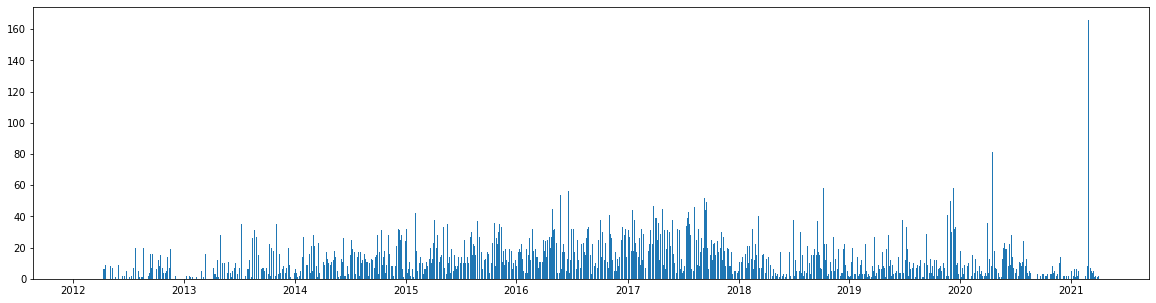

In [38]:
pdCommits = pd.read_sql_query("SELECT * FROM commits", db)

days = {(min_date+timedelta(days=x)).date() : 0 for x in range((max_date-min_date).days + 1)}

commit_dates = pdCommits['committer_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date()).value_counts()

for key in commit_dates.keys():
    days[key] = commit_dates.get(key)

keys = days.keys()
values = days.values()
plt.figure(figsize=(20,5))
plt.bar(keys, values)

## Bipartite networks
### Converting bipartite network into WOMP (weighted one-mode projection)

In [19]:
def collab_network(sqlite_db_file, git_repo_dir, t, node_info, min_date, max_date, file_base=True):
    if file_base:
        start = int(datetime.timestamp(min_date))
        end = int(datetime.timestamp(max_date))

        n = pp.Network.from_temporal_network(t, min_time=start, max_time=end)
        
        n = remove_duplicate_filenames(n, git_repo_dir)
        n = add_weights(n, node_info)
        
        new_n = copy.deepcopy(n)

        for node1 in n.nodes:
            if node_info['class'][node1] == 'author':
                for node2 in n.nodes:
                    if node_info['class'][node2] == 'author' and node1 != node2:
                        intersect = n.successors[node1].intersection(n.successors[node2])
                        w = 0
                        for file in intersect:
                            #print((node1, file), ':', n.edges[(node1, file)])
                            w = w + n.edges[(node1, file)]['wijLR']
                        if w > 0:
                            new_n.add_edge(node1, node2, weight=w)

        for node in n.nodes:
            if node_info['class'][node] == 'file':
                new_n.remove_node(node)

        return new_n
    else:
        n, node_info, edge_info = git2net.get_coauthorship_network(sqlite_db_file, time_from=min_date, time_to=max_date)
        return n

Funtion for removing file names from a network, which occur more than once in the given git repo. This is necessary because files that are named the same but are located in different folders are merged during the git2net network creation.

In [20]:
def remove_duplicate_filenames(n, git_repo_dir):
    all_files = []
    for path, subdirs, files in os.walk(git_repo_dir):
        for name in files:
            all_files.append(name)

    duplicates = [file for file in all_files if all_files.count(file) > 1]
    remove_files = set(duplicates)

    new_n = copy.deepcopy(n)
    for node in new_n.nodes:
        if node in remove_files:
            n.remove_node(node)
    del new_n
    return n

In [41]:
def duplicate_filenames(git_repo_dir):
    all_files = []
    for path, subdirs, files in os.walk(git_repo_dir):
        for name in files:
            all_files.append(name)

    duplicates = [file for file in all_files if all_files.count(file) > 1]
    remove_files = set(duplicates)
    print(len(remove_files))
    
    #keep_nodes = [f for f in all_files if f not in remove_files]
    #print(len(keep_nodes))
    #print(keep_nodes)
    
    #t = t.filter_nodes(keep_nodes)

    #new_n = copy.deepcopy(n)
    #for node in new_n.nodes:
    #    if node in remove_files:
    #        n.remove_node(node)
    #del new_n
    return remove_files

This function adds the total resources to the nodes, and the proportions to the edges.

In [22]:
def add_weights(n, node_info):
    for node in n.nodes:
        if node_info['class'][node] == 'author':
            s = 0
            for successor in n.successors[node]:
                for key in n.edges:
                    if key[0] == node and key[1] == successor:
                        s = s + n.edges[key]['weight']

        n.nodes[node]['WiL'] = s
    for edge in n.edges:
        n.edges[edge]['wijLR'] = n.edges[edge]['weight'] / n.nodes[edge[0]]['WiL']
    
    return n

In [48]:
def collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, min_date, max_date, duplicate_files, file_base=True):
    if file_base:
        start = int(datetime.timestamp(min_date))
        end = int(datetime.timestamp(max_date))
        
        #print('1. From temporal network...')
        n = pp.Network.from_temporal_network(t, min_time=start, max_time=end)
        
        #print('2. Remove duplicate files... SKIPPED')
        #n = remove_duplicate_filenames(n, git_repo_dir)
        
        #print('3. New empty network')
        new_n = pp.Network(directed=False)
        
        #print('4. Add authors to network')
        nn = copy.deepcopy(n.nodes)
        for node in nn:
            if node_info['class'][node] != 'file':
                new_n.add_node(node)
            elif node in duplicate_files:
                n.remove_node(node)
        
        #new_n = new_n.to_undirected()  
        
        print('5. Jaccard loop')
        visited_nodes = []
        for node1 in n.nodes:
            if node_info['class'][node1] == 'author':
                for node2 in n.nodes:
                    if node_info['class'][node2] == 'author' and node1 != node2 and not node2 in visited_nodes:
                        intersect = n.successors[node1].intersection(n.successors[node2])
                        w_min = 0
                        w_max = 0
                        for file in intersect:
                            #print((node1, file), ':', n.edges[(node1, file)])
                            w_min = w_min + min(n.edges[(node1, file)]['weight'], n.edges[(node2, file)]['weight'])
                            w_max = w_max + max(n.edges[(node1, file)]['weight'], n.edges[(node2, file)]['weight'])
                        if w_max > 0:
                            new_n.add_edge(node1, node2, weight=w_min/w_max)
                visited_nodes.append(node1)
                
                
        return new_n
    else:
        n, node_info, edge_info = git2net.get_coauthorship_network(sqlite_db_file, time_from=min_date, time_to=max_date)
        return n

In [107]:
t, node_info, edge_info = git2net.get_bipartite_network(sqlite_db_file)
nj1 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2015, 12, 31), True)
nj2 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 12, 31), True)
nj3 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 6, 30), True)
nj4 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 3, 31), True)
nj5 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 1, 31), True)
nj6 = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 1, 8), True)
n1 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2015, 12, 31), True)
n2 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 12, 31), True)
n3 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 6, 30), True)
n4 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 3, 31), True)
n5 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 1, 31), True)
n6 = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2014, 1, 1), datetime(2014, 1, 8), True)

In [63]:
#t, node_info, edge_info = git2net.get_bipartite_network(sqlite_db_file, time_from=datetime(2019, 1, 1), time_to=datetime(2020, 12, 31))
nj = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, datetime(2020, 1, 31), datetime(2020, 2, 28), True)
#n = collab_network(sqlite_db_file, git_repo_dir, t, node_info, datetime(2020, 1, 31), datetime(2020, 2, 28), True)
nj

In [61]:
nj

In [60]:
style = {
    'edge_arrows': False,
    #'node_size': {v: 3+u['WiL'] for v,u in n.nodes.items()},
    'edge_width': {v: u['weight'] for v,u in nj.edges.items()},
    'width': 600,
    'height': 600,
    'label_size': '9px',
}
pp.visualisation.plot(nj, **style)

### Network statistics

In [26]:
def network_stats(n, directed=False):
    d = {}
    N = len(n.nodes)
    
    # Node count
    d['N'] = N
    
    # Network density
    d['Network density'] = len(n.edges) / (N * (N - 1)) if N > 1 else 0
    
    # Clustering coefficient
    d['Clustering coeff.'] = pp.algorithms.statistics.avg_clustering_coefficient(n)
    
    # COnnected components
    try:
        d['Number of Components'] = len(pp.algorithms.components.connected_components(n))
    except ValueError:
        d['Number of Components'] = -1
    #d['Connected Components'] = pp.algorithms.components.connected_components(n)
    
    # Average degree
    if directed:
        d['Mean degree'] = pp.algorithms.statistics.mean_degree(n, degree='indegree')
    else:
        d['Mean degree'] = pp.algorithms.statistics.mean_degree(n, degree='degree')
    #d['Mean outdegree'] = pp.algorithms.statistics.mean_degree(n, degree='indegree')
    return d

#print(network_stats(n1))

Plotting the degree distribution

### Network statistics over time plots

In [46]:
#stats = network_stats(n1)
#stats

db = sqlite3.connect(sqlite_db_file)
#max_date = datetime.strptime(pd.read_sql_query("SELECT max(committer_date) as max FROM commits", db)['max'].item(), '%Y-%m-%d %H:%M:%S')
#min_date = datetime.strptime(pd.read_sql_query("SELECT min(committer_date) as min FROM commits", db)['min'].item(), '%Y-%m-%d %H:%M:%S')
max_date = datetime.strptime('2020-12-31 00:00:00', '%Y-%m-%d %H:%M:%S')
min_date = datetime.strptime('2019-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')

print('Min date: ', min_date)
print('Max date: ', max_date)

t, node_info, edge_info = git2net.get_bipartite_network(sqlite_db_file, time_from=min_date, time_to=max_date)
print('0. Remove duplicate files')
duplicate_files = duplicate_filenames(git_repo_dir)

timespan = timedelta(days=30) # Timespan to be considered for the stats
days = {(min_date+timedelta(days=x)).date() : 0 for x in range((max_date-min_date-timespan).days + 1)}
mx, myj1, myj2, myj3, myj4, myj5 = [], [], [], [], [], []
my1, my2, my3, my4, my5 = [], [], [], [], []

for day in days:
    print(day.strftime('%Y-%m-%d'))
    mx.append(day)
    start = datetime.combine(day, datetime.min.time())
    end = datetime.combine(day+timespan, datetime.min.time())
    #n = collab_network(sqlite_db_file, git_repo_dir, t, node_info, day, day+timespan, True)
    n = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, start, end, duplicate_files, True)
    stats=network_stats(n)
    myj1.append(stats['N'])
    myj2.append(stats['Network density'])
    myj3.append(stats['Clustering coeff.'])
    myj4.append(stats['Number of Components'])
    myj5.append(stats['Mean degree'])
    #n = collab_network(sqlite_db_file, git_repo_dir, t, node_info, start, end, True)
    #stats=network_stats(n, True)
    #my1.append(stats['N'])
    #my2.append(stats['Network density'])
    #my3.append(stats['Clustering coeff.'])
    #my4.append(stats['Number of Components'])
    #my5.append(stats['Mean degree'])



Min date:  2019-01-01 00:00:00
Max date:  2020-12-31 00:00:00
0. Remove duplicate files
8133
2019-01-01
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-01-02
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-01-03
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-01-04
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-01-05
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-01-06
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-01-07
1. From temporal network...
2. Remove duplicate files... SKIPP

2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-03-03
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-03-04
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-03-05
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-03-06
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-03-07
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-03-08
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-03-09
1. From temporal network...
2. Remove duplicate files..

2019-05-02
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-05-03
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-05-04
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-05-05
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-05-06
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-05-07
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-05-08
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-05-09
1. From temporal

2019-07-01
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-07-02
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-07-03
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-07-04
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-07-05
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-07-06
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-07-07
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-07-08
1. From temporal

5. Jaccard loop
2019-08-29
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-08-30
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-08-31
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-09-01
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-09-02
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-09-03
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-09-04
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-09-05


2019-10-28
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-10-29
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-10-30
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-10-31
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-11-01
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-11-02
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-11-03
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-11-04
1. From temporal

2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-12-28
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-12-29
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-12-30
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2019-12-31
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-01-01
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-01-02
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-01-03
1. From temporal network...
2. Remove duplicate files..

2020-02-25
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-02-26
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-02-27
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-02-28
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-02-29
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-03-01
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-03-02
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-03-03
1. From temporal

2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-04-25
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-04-26
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-04-27
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-04-28
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-04-29
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-04-30
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-05-01
1. From temporal network...
2. Remove duplicate files..

2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-06-24
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-06-25
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-06-26
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-06-27
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-06-28
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-06-29
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-06-30
1. From temporal network...
2. Remove duplicate files..

2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-08-31
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-09-01
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-09-02
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-09-03
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-09-04
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-09-05
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-09-06
1. From temporal network...
2. Remove duplicate files..

5. Jaccard loop
2020-10-29
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-10-30
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-10-31
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-11-01
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-11-02
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-11-03
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-11-04
1. From temporal network...
2. Remove duplicate files... SKIPPED
3. New empty network
4. Add authors to network
5. Jaccard loop
2020-11-05


In [38]:
help(pp.Network)

Help on class Network in module pathpy.classes.network:

class Network(builtins.object)
 |  Network(directed=False)
 |  
 |  A graph or network that can be directed, undirected, unweighted or weighted
 |  and whose edges can contain arbitrary attributes. This is the base class for
 |  HigherOrderNetwork
 |  
 |  Attributes
 |  ----------
 |  
 |  nodes : list
 |      A list of (string) nodes.
 |  edges : dictionary
 |      A dictionary containing edges (as tuple-valued keys) and their attributes (as value)
 |  
 |  Methods defined here:
 |  
 |  __add__(self, other)
 |      Add two networks and return the union of both
 |      
 |      Parameters
 |      ----------
 |      other : Network
 |      
 |      Returns
 |      -------
 |      Network
 |          Default operator +, which returns the sum of two Network objects
 |  
 |  __init__(self, directed=False)
 |      Generates an empty network.
 |  
 |  __str__(self)
 |      Returns the default string representation of this network ins

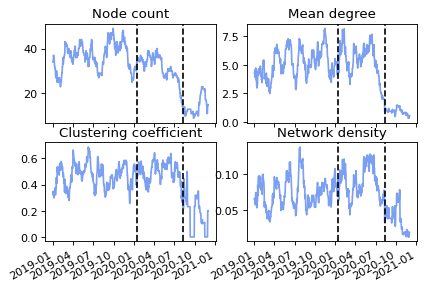

In [47]:
fig = plt.figure(figsize=(6, 4), dpi=80)
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.18)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex=True)
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True)
myFmt = mdates.DateFormatter('%Y-%m')
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
#fig.suptitle('{repo_name} network stats around major event (2020-08-11)'.format(repo_name=repo_name))
ax1.set_title('Node count')
#ax1.plot(mx, my1, label = "N (m)", color = "#212AA5")
ax1.plot(mx, myj1, label = "N (mj)", color = "#7B9FF2")
#ax1.plot(wx, wy1, label = "N (w)", color = "#9E1711")
#ax1.plot(wx, wyj1, label = "N (wj)", color = "#D65D72")
ax1.axvline(x=datetime(2020, 1, 15), color='black', ls='--')
ax1.axvline(x=datetime(2020, 8, 11), color='black', ls='--')
ax1.xaxis.set_major_formatter(myFmt)
#ax1.legend()
ax4.set_title('Network density')
#ax4.plot(mx, my2, label = "Network density (m)", color = "#212AA5")
ax4.plot(mx, myj2, label = "Network density (mj)", color = "#7B9FF2")
#ax4.plot(wx, wy2, label = "Network density (weekly)", color = "#9E1711")
#ax4.plot(wx, wyj2, label = "Network density (weekly, jaccard)", color = "#D65D72")
ax4.axvline(x=datetime(2020, 1, 15), color='black', ls='--')
ax4.axvline(x=datetime(2020, 8, 11), color='black', ls='--')
ax4.xaxis.set_major_formatter(myFmt)
#ax4.legend()
ax3.set_title('Clustering coefficient')
#ax3.plot(mx, my3, label = "Clustering coeff. (m)", color = "#212AA5")
ax3.plot(mx, myj3, label = "Clustering coeff. (mj)", color = "#7B9FF2")
#ax3.plot(wx, wy3, label = "Clustering coeff. (weekly)", color = "#9E1711")
#ax3.plot(wx, wyj3, label = "Clustering coeff. (weekly, jaccard)", color = "#D65D72")
ax3.axvline(x=datetime(2020, 1, 15), color='black', ls='--')
ax3.axvline(x=datetime(2020, 8, 11), color='black', ls='--')
ax3.xaxis.set_major_formatter(myFmt)
#ax3.legend()
#ax4.plot(mx, my4, label = "Number of Components (monthly)", color = "#212AA5")
#ax4.plot(mx, myj4, label = "Number of Components (monthly, jaccard)", color = "#7B9FF2")
#ax4.plot(wx, wy4, label = "Number of Components (weekly)", color = "#9E1711")
#ax4.plot(wx, wyj4, label = "Number of Components (weekly, jaccard)", color = "#D65D72")
#ax4.legend()
ax2.set_title('Mean degree')
#ax2.plot(mx, my5, label = "Mean degree (m)", color = "#212AA5")
ax2.plot(mx, myj5, label = "Mean degree (mj)", color = "#7B9FF2")
#ax2.plot(wx, wy5, label = "Mean degree (w)", color = "#9E1711")
#ax2.plot(wx, wyj5, label = "Mean degree (wj)", color = "#D65D72")
ax2.axvline(x=datetime(2020, 1, 15), color='black', ls='--')
ax2.axvline(x=datetime(2020, 8, 11), color='black', ls='--')
ax2.xaxis.set_major_formatter(myFmt)
#ax2.legend()
fig.autofmt_xdate()